# Machine Learning Nanodegree - Capstone Project

## Who is in the photo?

The proposal of this project is to build a model that allow to recognize persons in the image using Deep Learning.

### Step 0: Import dataset

In [1]:
%matplotlib inline

from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

def load_face_dataset(path):
    data = load_files(path)
    general_targets = data['target']
    face_files = np.array(data['filenames'])
    face_targets = np_utils.to_categorical(np.array(data['target']), 83)
    return face_files, face_targets

train_files, train_targets = load_face_dataset('faces/train')
valid_files, valid_targets = load_face_dataset('faces/valid')
test_files, test_targets = load_face_dataset('faces/test')

person_names = [item[12:-1] for item in sorted(glob("faces/train/*/"))]


print('There are %d total person names.' % len(person_names))
print('There are %s total face images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training face images.' % len(train_files))
print('There are %d validation face images.' % len(valid_files))
print('There are %d test face images.'% len(test_files))

Using TensorFlow backend.


There are 83 total person names.
There are 13823 total face images.

There are 11071 training face images.
There are 1364 validation face images.
There are 1388 test face images.


#### Loading image data into array

In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path, target_size=(100,100)):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, target_size=(100,100)):
    list_of_tensors = [path_to_tensor(img_path, target_size) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

#### Loading Image for baseline model

In [144]:
import cv2
from scipy.misc import imread
from scipy.misc import imresize

def load_image_from(img_path):    
   img = cv2.imread(img_path)
#    img = cv2.resize(img,(100,100))
   return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def load_images_from(img_paths):
    images = [load_image_from(path) for path in tqdm(img_paths)]
    return np.array(images)

#### Load tensors to train, test and validations

In [3]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255



100%|████████████████████████████████████| 1388/1388 [00:00<00:00, 1450.28it/s]


#### Load image to train, test and validations of a baseline model

In [146]:
# base model
base_train_images = load_images_from(train_files).astype('float32')/255
base_test_images = load_images_from(test_files).astype('float32')/255
base_valid_images = load_images_from(valid_files).astype('float32')/255



  0%|          | 0/11071 [00:00<?, ?it/s]

  3%|▎         | 312/11071 [00:00<00:03, 3119.51it/s]

  6%|▌         | 620/11071 [00:00<00:03, 3103.96it/s]

  8%|▊         | 934/11071 [00:00<00:03, 3114.42it/s]

 11%|█         | 1245/11071 [00:00<00:03, 3108.58it/s]

 14%|█▍        | 1561/11071 [00:00<00:03, 3123.26it/s]

 17%|█▋        | 1875/11071 [00:00<00:02, 3126.92it/s]

 20%|█▉        | 2191/11071 [00:00<00:02, 3136.66it/s]

 23%|██▎       | 2503/11071 [00:00<00:02, 3130.66it/s]

 25%|██▌       | 2816/11071 [00:00<00:02, 3127.77it/s]

 28%|██▊       | 3125/11071 [00:01<00:02, 3116.22it/s]

 31%|███       | 3437/11071 [00:01<00:02, 3115.76it/s]

 34%|███▍      | 3750/11071 [00:01<00:02, 3105.84it/s]

 37%|███▋      | 4064/11071 [00:01<00:02, 3115.11it/s]

 40%|███▉      | 4379/11071 [00:01<00:02, 3124.97it/s]

 42%|████▏     | 4695/11071 [00:01<00:02, 3127.83it/s]

 45%|████▌     | 5009/11071 [00:01<00:01, 3130.87it/s]

 48%|████▊     | 5326/11071 [00:01<00:01, 3135.20it/s]

 51%|█

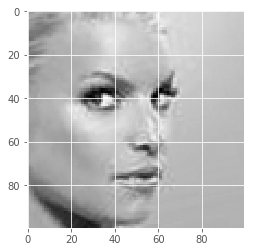

In [147]:
import matplotlib.pyplot as plt                        

img = base_train_images[0]
plt.imshow(img,cmap='gray')
plt.show()

### Step 1:  Train a base line model

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from time import time


#### Create a lookup table

In [8]:
def create_lookup_table(targets):
    lookup = []
    for target in targets:
        index = np.where(target==1)[0]
        lookup.append(index[0])
    return np.array(lookup)


In [9]:
base_train_targets = create_lookup_table(train_targets)
base_test_targets = create_lookup_table(test_targets)
base_valid_targets = create_lookup_table(valid_targets)


#### Creating a function to execute a PCA

In [10]:
def execute_pca(train, test, n_components):
    print("Extracting the top %d eigenfaces from %d faces"
        % (n_components, train.shape[0]))
    t0 = time()
    pca = PCA(n_components=n_components, svd_solver='randomized',
            whiten=True).fit(train)

    print("done in %0.3fs" % (time() - t0))
    # eigenfaces = pca.components_.reshape((n_components, h, w))
    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    X_train_pca = pca.transform(train)
    X_test_pca = pca.transform(test)
    print("done in %0.3fs" % (time() - t0))
    return X_train_pca, X_test_pca


#### Creating a function to training a model 

In [11]:
def apply_svm(X_train, y_train):
    # Train a SVM classification model
    print("Fitting the classifier to the training set")
#     param_grid = {
#     'C': [1, 5, 10, 50, 100],
#     'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
#     }
#     param_grid = {
#         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
#         'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
#     }
    
    param_grid = [
        {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]},
        {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
    ]

    clf = GridSearchCV(SVC(kernel='rbf',class_weight='balanced'), param_grid)
    clf = clf.fit(X_train, y_train)
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    return clf


### Exploring and Normalize the dataset

#### Create a function to visualize the dataset

In [13]:
def image_grid(D,H,W,cols=10,scale=1, rows_count=None):
    """ display a grid of images
        H,W: Height and width of the images
        cols: number of columns = number of images in each row
        scale: 1 to fill screen
    """
    n = np.shape(D)[0]
    if rows_count:
        n = rows_count 
    rows = int(math.ceil((n+0.0)/cols))
    fig = plt.figure(1,figsize=[scale*20.0/H*W,scale*20.0/cols*rows],dpi=300)
    for i in range(n):
        plt.subplot(rows,cols,i+1)
        fig=plt.imshow(np.reshape(D[i,:],[H,W]), cmap = plt.get_cmap("gray"))
        plt.axis('off')

#### Transform the image Matrix in a vector to use in PCA analysis

In [14]:
from PIL import Image       
import glob
import math

def image_to_vector(image_paths, H,W):
    image_count = len(image_paths)
    # and columns as pixels
    arr = np.zeros([image_count,H*W])
    for i in range(image_count):
        im = Image.open(image_paths[i]).convert("L")
        arr[i,:] = np.reshape(np.asarray(im),[1,H*W])
    return arr

In [15]:
def extract_mean(images):
    return np.mean(images, axis=0)


In [16]:
def centralize(images, mean_image, H,W):
    im_number = len(images)
    
    arr_norm = np.zeros([im_number, H*W])
    arr_norm = images - mean_image
    return arr_norm

#### Show some image examples

shape:  (100, 100)


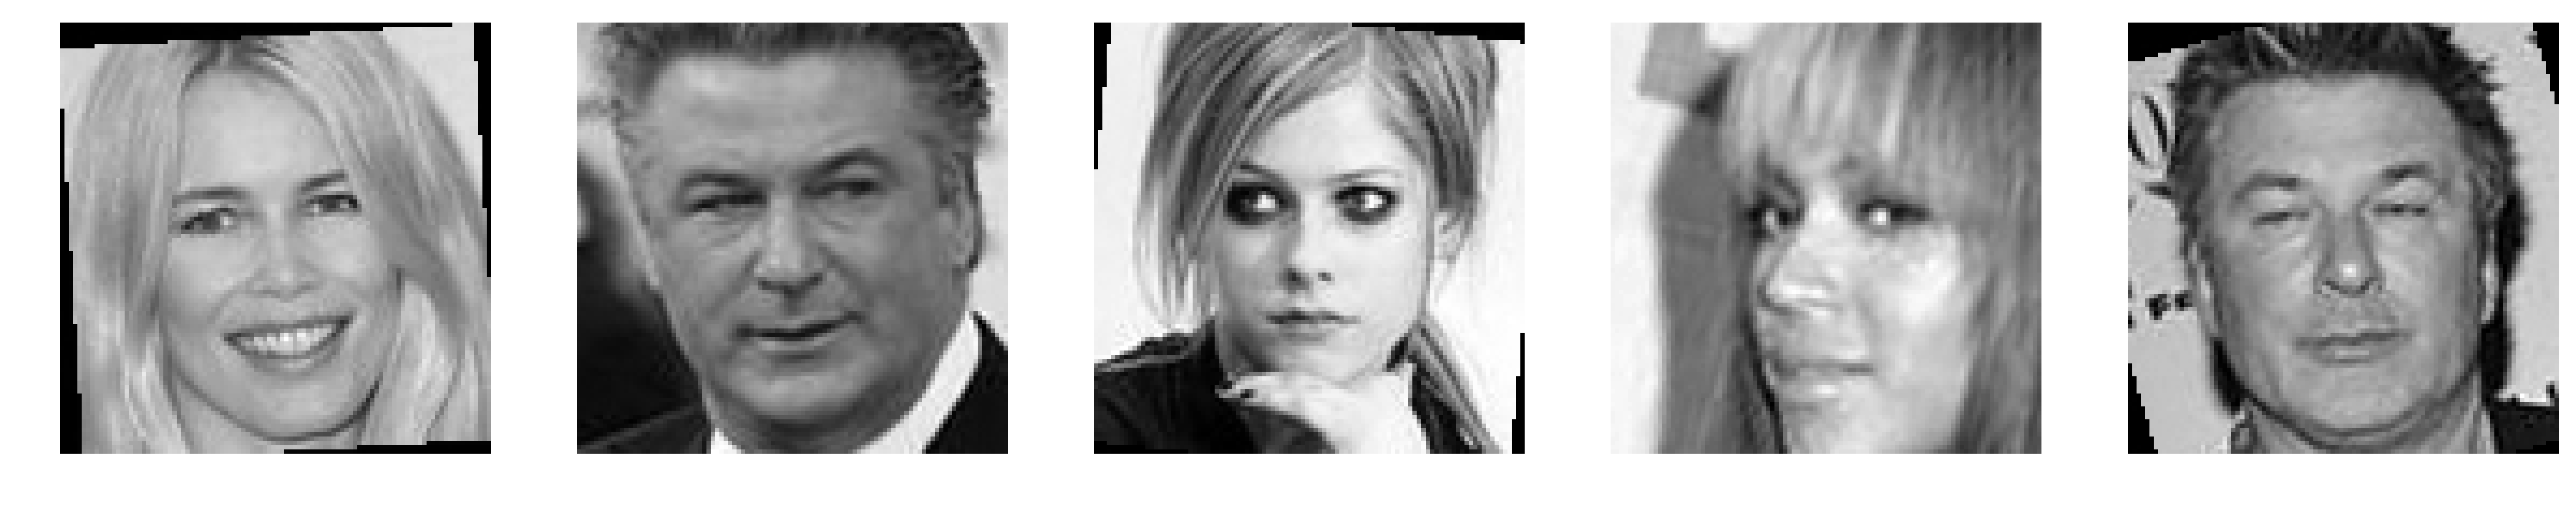

In [17]:

file_list = train_files
im = Image.open(file_list[4]).convert("L")
H,W = np.shape(im)
print('shape: ', (H,W))

arr = image_to_vector(train_files, H,W)
image_grid(arr,H,W,cols=5,rows_count=5)


#### Apply the mean in the images

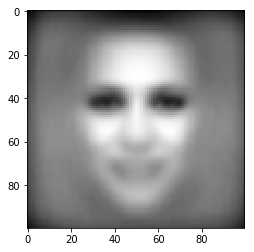

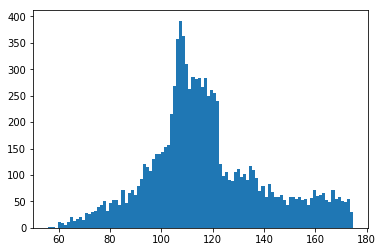

In [18]:
# let's find the mean_image
# mean_image = np.mean(arr, axis=0)
mean_image = extract_mean(arr)

plt.imshow(np.reshape(mean_image,[H,W]), cmap = plt.get_cmap("gray"))
plt.figure()
plt.hist(mean_image,bins=100);

#### Centralize the image

In [19]:
# centering the data (subtract mean face)
# arr_norm = np.zeros([im_number, H*W])
# arr_norm = arr - mean_image
arr_norm = centralize(arr, mean_image, H,W)

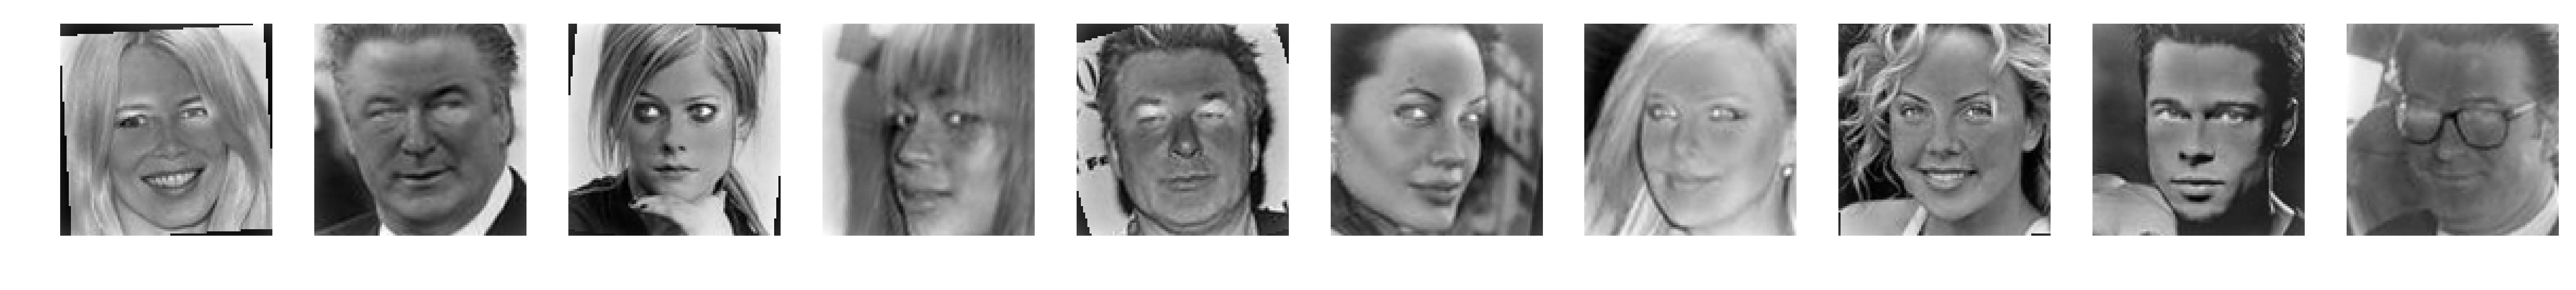

In [20]:
image_grid(arr_norm[:10,:],H,W)

### Train the base model

After some feature engineering, now we can train the model and check the results  .

In [21]:
X_train = base_train_images
y_train = base_train_targets


X_test  = base_test_images
y_test  = base_test_targets


In [23]:
im = Image.open(test_files[0]).convert("L")
H,W = np.shape(im)
print('shape: ', (H,W))

X_test = image_to_vector(test_files,H,W)
mean_test = extract_mean(X_test)
X_test = centralize(X_test, mean_test, H,W)
print(arr_norm.shape)
print(X_test.shape)

X_train_pca, X_test_pca = execute_pca(arr_norm, X_test, n_components=160)
pca = PCA(n_components=160, svd_solver='randomized')
pca.fit(arr_norm)

shape:  (100, 100)
(2245, 10000)
(281, 10000)
Extracting the top 160 eigenfaces from 2245 faces
done in 3.737s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.272s


PCA(copy=True, iterated_power='auto', n_components=160, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)

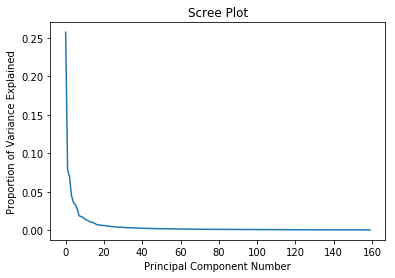

In [24]:
# Let's make a scree plot
pve = pca.explained_variance_ratio_
pve.shape
plt.plot(range(len(pve)), pve)
plt.title("Scree Plot")
plt.ylabel("Proportion of Variance Explained")
plt.xlabel("Principal Component Number")


#### Check the eingenfaces

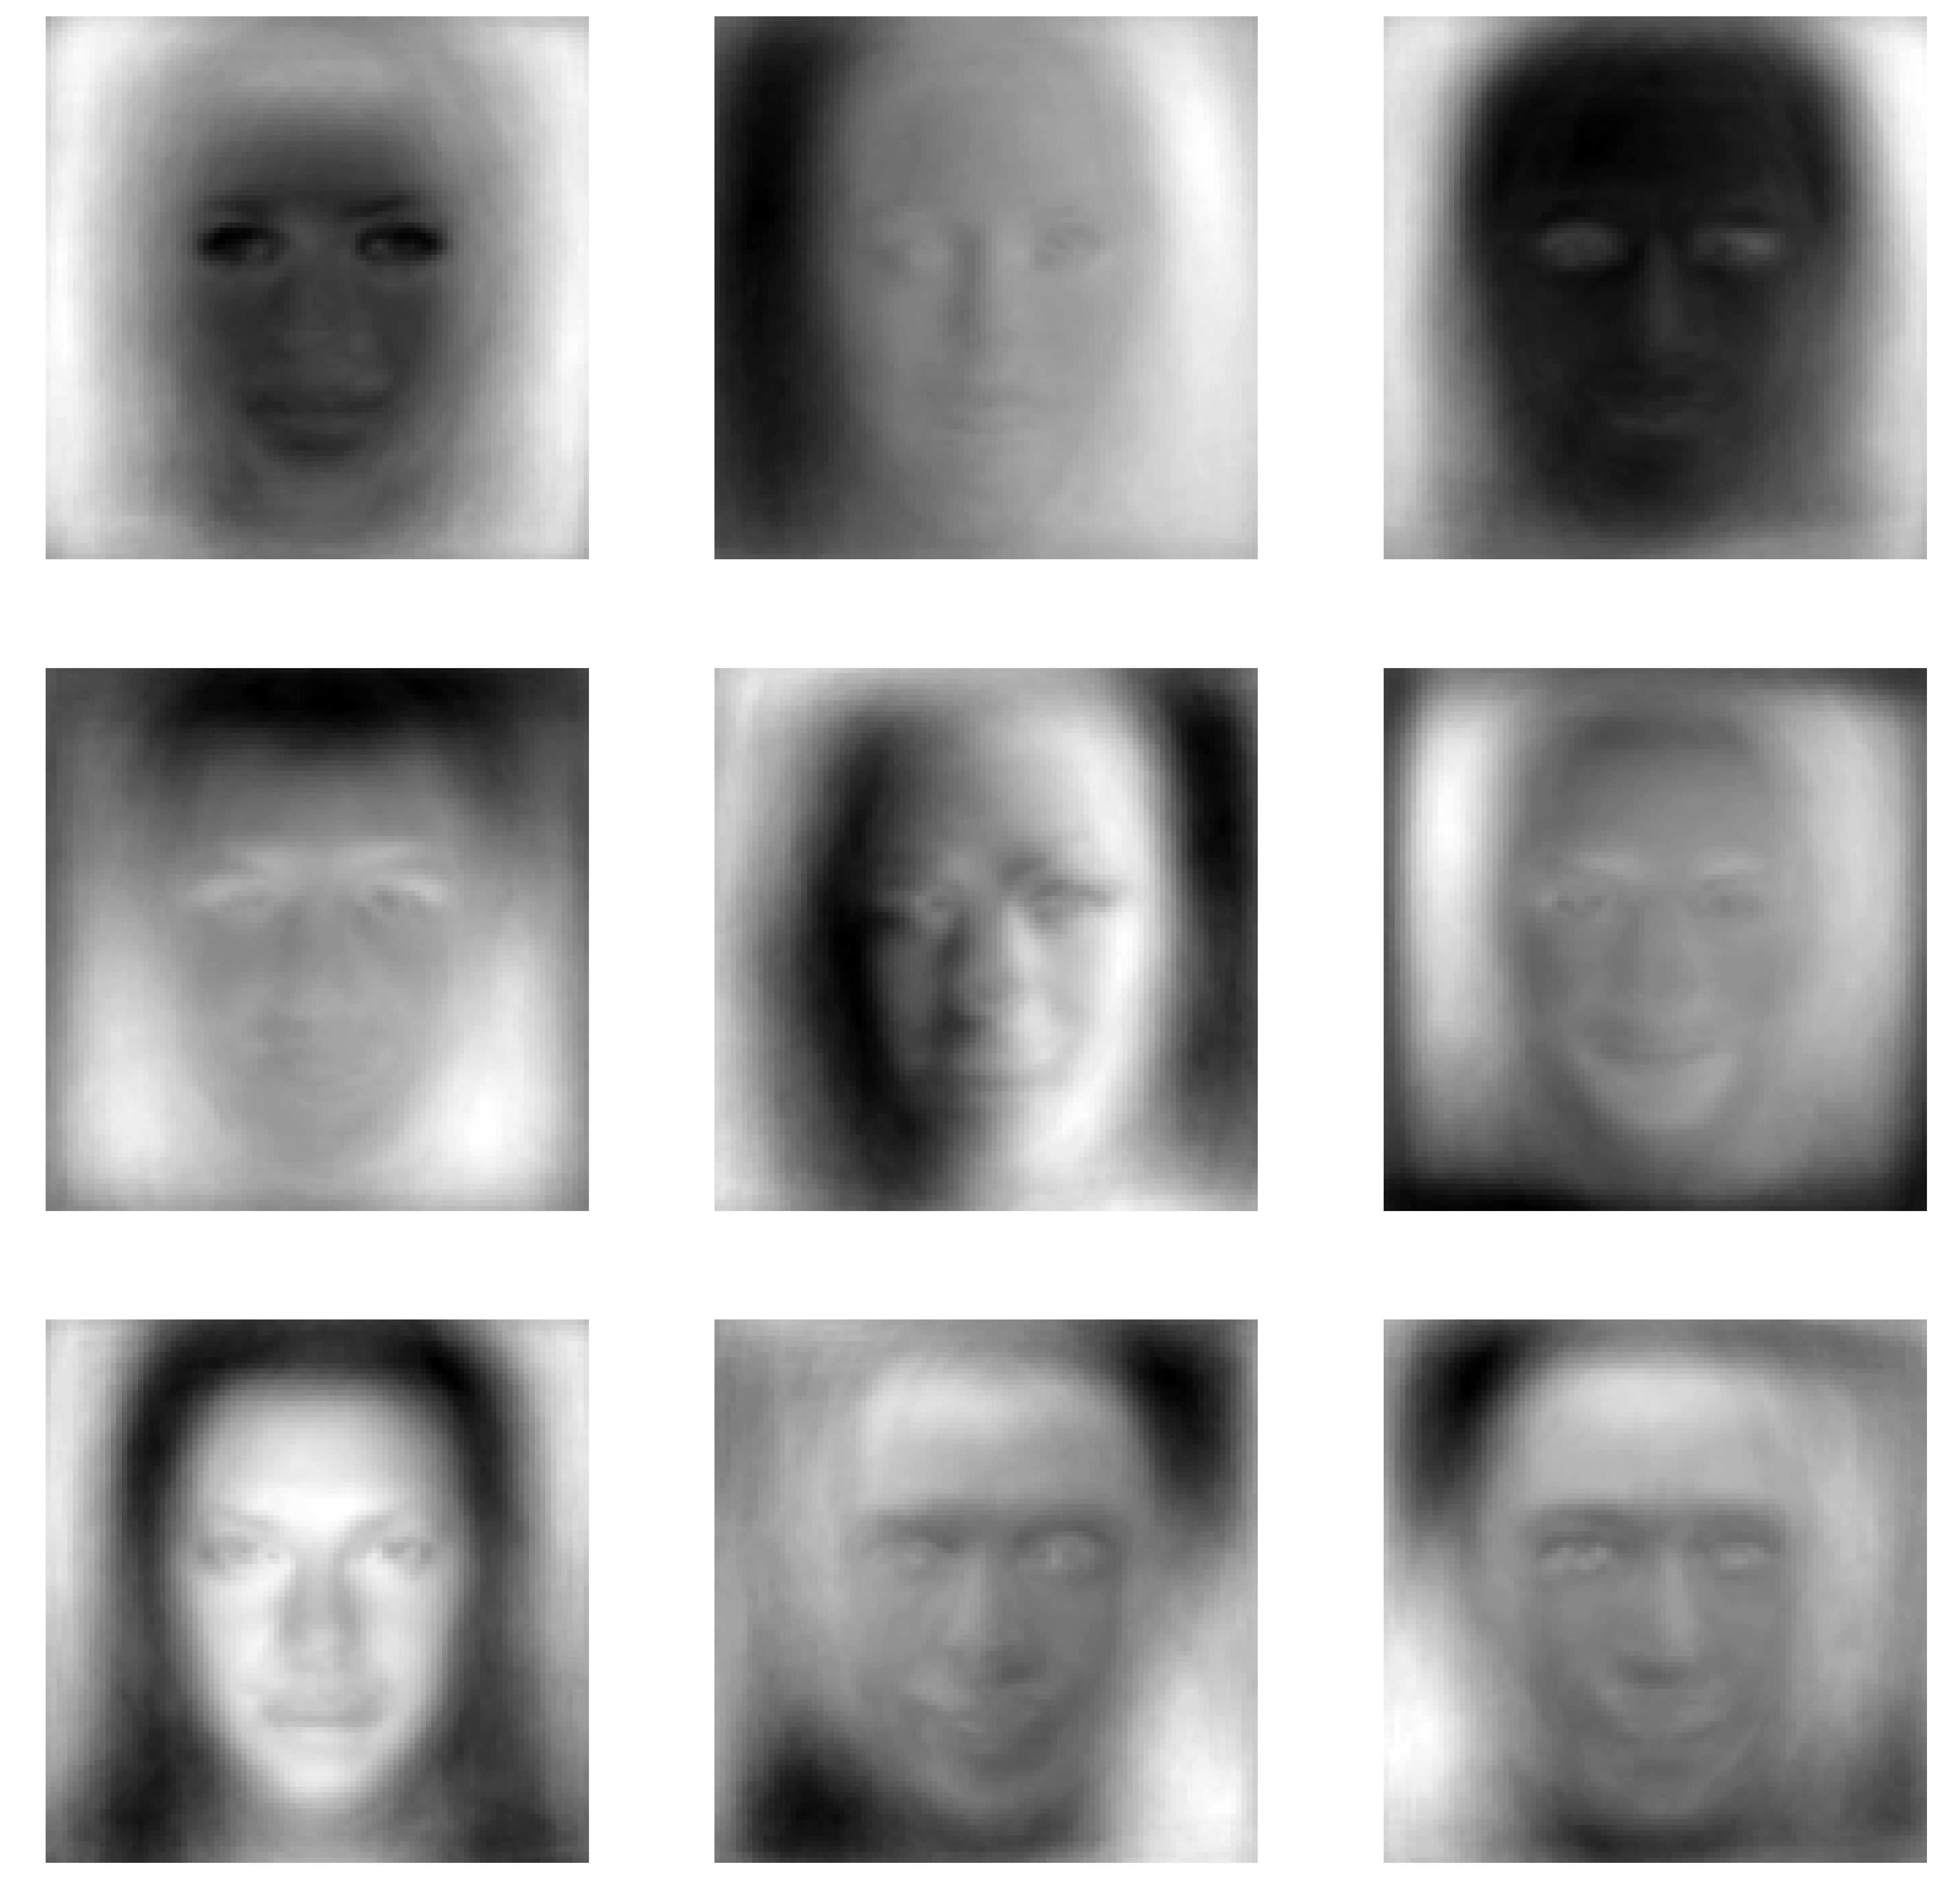

In [25]:
eigenfaces = pca.components_
image_grid(eigenfaces[:9,:], H, W, cols=3)

In [26]:
clf = apply_svm(X_train_pca, y_train)


Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [28]:
y_pred = clf.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=person_names))

print(confusion_matrix(y_test, y_pred, labels=range(len(person_names))))


                   precision    recall  f1-score   support

    /Adam Sandler       0.38      0.55      0.44        11
    /Alec Baldwin       0.44      0.70      0.54        10
  /Angelina Jolie       0.50      0.48      0.49        21
 /Anna Kournikova       0.29      0.35      0.32        17
  /Ashton Kutcher       0.60      0.60      0.60        10
   /Avril Lavigne       0.54      0.50      0.52        30
    /Barack Obama       0.50      0.44      0.47        27
     /Ben Affleck       0.18      0.25      0.21        12
 /Beyonce Knowles       0.78      0.54      0.64        13
       /Brad Pitt       0.58      0.50      0.54        30
    /Cameron Diaz       0.57      0.48      0.52        25
  /Cate Blanchett       0.58      0.44      0.50        16
 /Charlize Theron       0.33      0.40      0.36        20
 /Christina Ricci       0.46      0.43      0.44        14
/Claudia Schiffer       0.29      0.33      0.31        12
      /Clive Owen       0.60      0.46      0.52       

In [29]:
from sklearn.metrics import accuracy_score


In [30]:
accuracy_score(y_test, y_pred)

0.46263345195729538

### Training a haar_cascade model with OpenCV

In [34]:
import cv2
import face_recognition

def get_label(path):
    values = path.split('/')
    if not values:
        return ''
    return values[2]

def trainning_dataset(paths, detect_faces=False):
    recognizer = cv2.face.LBPHFaceRecognizer_create()
    detector= cv2.CascadeClassifier("/usr/share/opencv/haarcascades/haarcascade_frontalface_default.xml");
    images = []
    labels = []
    description_labels = {}
    id = 0
    paths.sort()
    current_label = get_label(paths[0])
    for image_path in tqdm(paths):
        if current_label != get_label(image_path):
            description_labels[id] = current_label
            current_label = get_label(image_path)
            id += 1
        image_pil = Image.open(image_path).convert('L')
        image = np.array(image_pil, 'uint8')
        image = cv2.equalizeHist(image)
        if detect_faces:
            faces = detector.detectMultiScale(image)
            #If a face is there then append that in the list as well as Id of it
            for (x,y,w,h) in faces:
                images.append(image[y:y+h,x:x+w])
                labels.append(id)
        else:
            images.append(image)
            labels.append(id)
                
    recognizer.train(images, np.array(labels))
    recognizer.save('trainning/trainner.yml')
    return recognizer, description_labels 

   
def preprocessing(paths):
    file_list = paths
    im = Image.open(file_list[0]).convert("L")
    H,W = np.shape(im)
    arr = image_to_vector(file_list, H,W)
    mean_image = extract_mean(arr)
    arr_norm = centralize(arr, mean_image, H,W)
    return arr_norm
    #return np.reshape(arr_norm,[H,W])

    
def trainning_with_preprocessing(paths, detect_faces=False):
    recognizer = cv2.face.LBPHFaceRecognizer_create()
    detector= cv2.CascadeClassifier("/usr/share/opencv/haarcascades/haarcascade_frontalface_default.xml");
    images = []
    labels = []
    description_labels = {}
    id = 0
    paths.sort()
    current_label = get_label(paths[0])
    load_images = preprocessing(paths)
    
    for i,image in enumerate(tqdm(load_images)):
        if current_label != get_label(paths[i]):
            description_labels[id] = current_label
            current_label = get_label(paths[i])
            id += 1
        image = np.array(image, 'uint8')
        if detect_faces:
            faces = detector.detectMultiScale(image)
            #If a face is there then append that in the list as well as Id of it
            for (x,y,w,h) in faces:
                images.append(image[y:y+h,x:x+w])
                labels.append(id)
        else:
            images.append(image)
            labels.append(id)

    image_pil = Image.open(paths[0]).convert('L') 
    image_pil = np.array(image, 'uint8')

        
    recognizer.train(images, np.array(labels))
    recognizer.save('trainning/trainner.yml')
    return recognizer, description_labels 
        
        
    

ModuleNotFoundError: No module named 'face_recognition'

  1%|          | 17/2245 [00:00<00:13, 164.68it/s]

tá indo


100%|██████████| 2245/2245 [00:13<00:00, 163.74it/s]


{0: 'Adam Sandler', 1: 'Alec Baldwin', 2: 'Angelina Jolie', 3: 'Anna Kournikova', 4: 'Ashton Kutcher', 5: 'Avril Lavigne', 6: 'Barack Obama', 7: 'Ben Affleck', 8: 'Beyonce Knowles', 9: 'Brad Pitt', 10: 'Cameron Diaz', 11: 'Cate Blanchett', 12: 'Charlize Theron', 13: 'Christina Ricci', 14: 'Claudia Schiffer'}


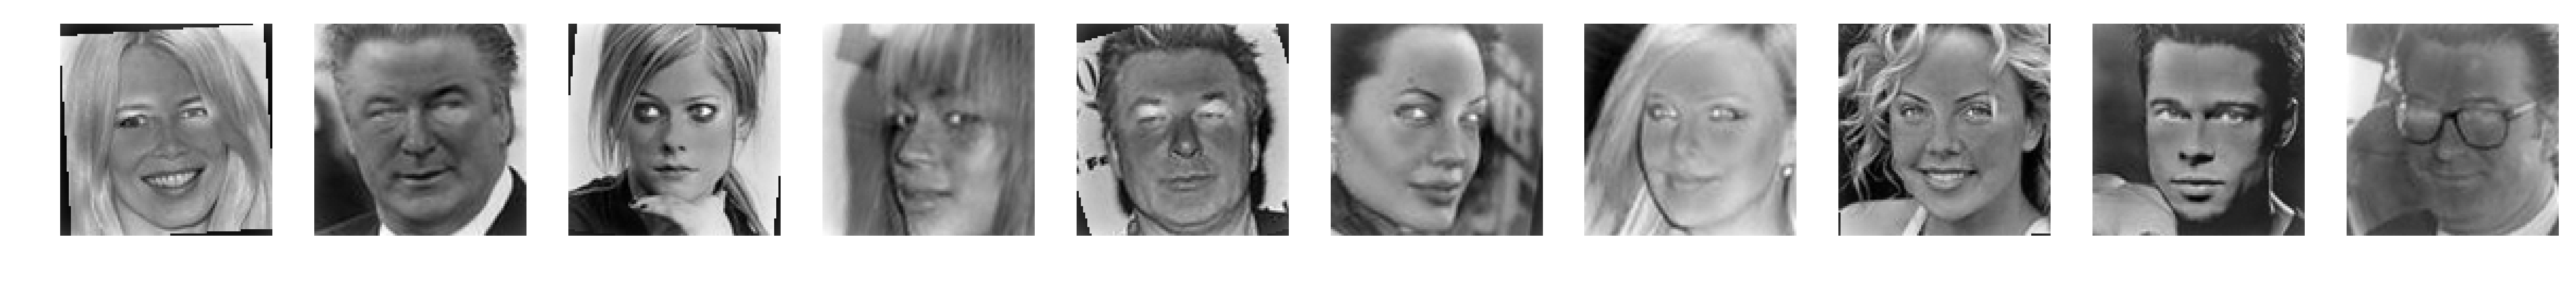

In [29]:
image_pil = preprocessing(train_files)
image_grid(image_pil[:10,:],H,W)


recognizer, labels = trainning_dataset(train_files, True)
print labels

#### Checking accuracy

In [30]:
def check_accuracy(image_paths,labels,recognizer, detect_faces=False):
    detector= cv2.CascadeClassifier("/usr/share/opencv/haarcascades/haarcascade_frontalface_default.xml");
    image_paths.sort()
    accuracy_list = []
    for image_path in image_paths:
#         predict_image_pil  = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        predict_image_pil = Image.open(image_path).convert('L')
        predict_image = np.array(predict_image_pil, np.uint8)
        predict_image = cv2.equalizeHist(predict_image)
        print image_path
        if detect_faces:
            faces = detector.detectMultiScale(predict_image)
            for (x, y, w, h) in faces:
                nbr_predicted, conf = recognizer.predict(predict_image[y: y + h, x: x + w])
                if nbr_predicted not in labels.keys():
                    accuracy_list.append(0)
                    continue
                predicted = labels[nbr_predicted]
                atual = get_label(image_path)
                if atual == predicted:
                    accuracy_list.append(1)
                    print "{} is Correctly Recognized with confidence {}".format(atual, conf)
                else:
                    accuracy_list.append(0)
                    print "{} is Incorrectly Recognized as {}".format(atual, predicted)
        else:
            nbr_predicted, conf = recognizer.predict(predict_image)
            atual = get_label(image_path)
            if nbr_predicted not in labels.keys():
                accuracy_list.append(0)
                continue
                
            predicted = labels[nbr_predicted]
            if atual == predicted:
                accuracy_list.append(1)
                print "{} is Correctly Recognized with confidence {}".format(atual, conf)
            else:
                accuracy_list.append(0)
                print "{} is Incorrectly Recognized as {}".format(atual, predicted)
    
    print "Total: {}".format(len(accuracy_list))
    accuracy_list = np.array(accuracy_list)
    found = np.where(accuracy_list == 1)
    print found
    print "Found: {}".format(len(found[0]))

    accuracy = float(len(found[0])) / len(accuracy_list)
    print "Accuracy is {}".format(accuracy)
    
    

In [31]:

check_accuracy(test_files,labels,recognizer, detect_faces=True )

faces2/test/Adam Sandler/103.jpg
faces2/test/Adam Sandler/132.jpg
Adam Sandler is Incorrectly Recognized as Brad Pitt
faces2/test/Adam Sandler/136.jpg
Adam Sandler is Correctly Recognized with confidence 105.470327437
faces2/test/Adam Sandler/26.jpg
Adam Sandler is Correctly Recognized with confidence 90.8368069765
faces2/test/Adam Sandler/270.jpg
Adam Sandler is Correctly Recognized with confidence 90.318389026
faces2/test/Adam Sandler/33.jpg
Adam Sandler is Correctly Recognized with confidence 105.790623606
faces2/test/Adam Sandler/37.jpg
Adam Sandler is Correctly Recognized with confidence 101.548561209
faces2/test/Adam Sandler/38.jpg
Adam Sandler is Correctly Recognized with confidence 99.6399284944
faces2/test/Adam Sandler/5.jpg
Adam Sandler is Correctly Recognized with confidence 96.8302654409
faces2/test/Adam Sandler/61.jpg
Adam Sandler is Correctly Recognized with confidence 105.177851566
faces2/test/Adam Sandler/80.jpg
Adam Sandler is Correctly Recognized with confidence 87.06

Avril Lavigne is Correctly Recognized with confidence 113.016839873
faces2/test/Avril Lavigne/659.jpg
Avril Lavigne is Correctly Recognized with confidence 109.021137556
faces2/test/Avril Lavigne/661.jpg
Avril Lavigne is Correctly Recognized with confidence 103.487892029
faces2/test/Avril Lavigne/695.jpg
faces2/test/Avril Lavigne/698.jpg
Avril Lavigne is Correctly Recognized with confidence 93.8365991692
faces2/test/Avril Lavigne/702.jpg
Avril Lavigne is Incorrectly Recognized as Cameron Diaz
faces2/test/Avril Lavigne/737.jpg
Avril Lavigne is Correctly Recognized with confidence 109.736573046
faces2/test/Avril Lavigne/75.jpg
Avril Lavigne is Incorrectly Recognized as Angelina Jolie
faces2/test/Barack Obama/100.jpg
Barack Obama is Correctly Recognized with confidence 110.643372549
faces2/test/Barack Obama/103.jpg
Barack Obama is Correctly Recognized with confidence 96.3672921248
faces2/test/Barack Obama/109.jpg
Barack Obama is Correctly Recognized with confidence 107.449245987
faces2/te

Brad Pitt is Correctly Recognized with confidence 125.457241136
faces2/test/Cameron Diaz/103.jpg
Cameron Diaz is Incorrectly Recognized as Anna Kournikova
faces2/test/Cameron Diaz/132.jpg
Cameron Diaz is Correctly Recognized with confidence 115.42562256
faces2/test/Cameron Diaz/138.jpg
faces2/test/Cameron Diaz/142.jpg
Cameron Diaz is Incorrectly Recognized as Claudia Schiffer
faces2/test/Cameron Diaz/160.jpg
Cameron Diaz is Correctly Recognized with confidence 104.777097715
faces2/test/Cameron Diaz/167.jpg
Cameron Diaz is Correctly Recognized with confidence 101.365212837
faces2/test/Cameron Diaz/185.jpg
Cameron Diaz is Correctly Recognized with confidence 100.217852659
faces2/test/Cameron Diaz/203.jpg
Cameron Diaz is Correctly Recognized with confidence 106.518880835
faces2/test/Cameron Diaz/211.jpg
Cameron Diaz is Correctly Recognized with confidence 109.981010387
faces2/test/Cameron Diaz/215.jpg
Cameron Diaz is Correctly Recognized with confidence 94.3898173897
faces2/test/Cameron D

Claudia Schiffer is Correctly Recognized with confidence 111.378234024
faces2/test/Claudia Schiffer/53.jpg
Claudia Schiffer is Correctly Recognized with confidence 103.619147441
faces2/test/Claudia Schiffer/80.jpg
Claudia Schiffer is Incorrectly Recognized as Barack Obama
faces2/test/Clive Owen/100.jpg
faces2/test/Clive Owen/103.jpg
faces2/test/Clive Owen/138.jpg
faces2/test/Clive Owen/142.jpg
faces2/test/Clive Owen/160.jpg
faces2/test/Clive Owen/210.jpg
faces2/test/Clive Owen/211.jpg
faces2/test/Clive Owen/215.jpg
faces2/test/Clive Owen/218.jpg
faces2/test/Clive Owen/255.jpg
faces2/test/Clive Owen/37.jpg
faces2/test/Clive Owen/75.jpg
Clive Owen is Incorrectly Recognized as Cate Blanchett
faces2/test/Clive Owen/91.jpg
Total: 273
(array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  14,  16,
        18,  19,  20,  22,  23,  25,  28,  29,  30,  32,  33,  35,  39,
        41,  42,  43,  44,  45,  46,  47,  50,  51,  52,  53,  64,  66,
        67,  69,  70,  71,  72,  74,  75,  7

### A Deep Learning Model

#### Custom Model

In [107]:
import time
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, adam
from keras.callbacks import TensorBoard



model = Sequential()

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',input_shape=(100,100,3)))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.5))
 
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(83, activation='softmax'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_79 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 25, 25, 128)       73856     
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 12, 12, 256)       295168    
__________

In [108]:
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [105]:
from keras.callbacks import ModelCheckpoint  
from time import time

### TODO: specify the number of epochs that you would like to use to train the model.
epochs = 50

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.custom.model_{}.hdf5'.format("pc50-batch20-ada"), 
                               verbose=1, save_best_only=True)

tensorboard = TensorBoard(log_dir="logs/custom_{}".format(time()))
#tensorboard = TensorBoard(log_dir="logs/vgg16_{}".format(time()),write_images=True,write_grads=True, histogram_freq=5.0)


trainning_result = model.fit(train_tensors, train_targets, 
           validation_data=(valid_tensors, valid_targets),
           epochs=epochs, batch_size=20, callbacks=[checkpointer,tensorboard], verbose=1)

Train on 11071 samples, validate on 1364 samples
Epoch 1/50


 8440/11071 [=====================>........] - ETA: 24:20 - loss: 4.4190 - acc: 0.0000e+ - ETA: 8:15 - loss: 4.4032 - acc: 0.0167     - ETA: 5:02 - loss: 4.4294 - acc: 0.010 - ETA: 3:39 - loss: 4.4311 - acc: 0.014 - ETA: 2:53 - loss: 4.4265 - acc: 0.011 - ETA: 2:24 - loss: 4.4262 - acc: 0.009 - ETA: 2:04 - loss: 4.4206 - acc: 0.011 - ETA: 1:49 - loss: 4.4188 - acc: 0.013 - ETA: 1:38 - loss: 4.4213 - acc: 0.011 - ETA: 1:29 - loss: 4.4195 - acc: 0.010 - ETA: 1:22 - loss: 4.4169 - acc: 0.009 - ETA: 1:16 - loss: 4.4191 - acc: 0.008 - ETA: 1:11 - loss: 4.4155 - acc: 0.010 - ETA: 1:06 - loss: 4.4161 - acc: 0.011 - ETA: 1:03 - loss: 4.4155 - acc: 0.010 - ETA: 59s - loss: 4.4152 - acc: 0.009 - ETA: 56s - loss: 4.4166 - acc: 0.01 - ETA: 54s - loss: 4.4145 - acc: 0.01 - ETA: 51s - loss: 4.4107 - acc: 0.01 - ETA: 49s - loss: 4.4082 - acc: 0.01 - ETA: 48s - loss: 4.4117 - acc: 0.01 - ETA: 46s - loss: 4.4122 - acc: 0.01 - ETA: 44s - loss: 4.4123 - acc: 0.01 - ETA: 43s - loss: 4.4108 - acc: 0.01 - E

11040/11071 [============================>.] - ETA: 4s - loss: 4.3763 - acc: 0.026 - ETA: 4s - loss: 4.3763 - acc: 0.026 - ETA: 4s - loss: 4.3762 - acc: 0.026 - ETA: 4s - loss: 4.3757 - acc: 0.026 - ETA: 4s - loss: 4.3758 - acc: 0.026 - ETA: 4s - loss: 4.3762 - acc: 0.026 - ETA: 4s - loss: 4.3761 - acc: 0.026 - ETA: 4s - loss: 4.3760 - acc: 0.026 - ETA: 4s - loss: 4.3760 - acc: 0.026 - ETA: 3s - loss: 4.3756 - acc: 0.026 - ETA: 3s - loss: 4.3755 - acc: 0.026 - ETA: 3s - loss: 4.3753 - acc: 0.026 - ETA: 3s - loss: 4.3750 - acc: 0.026 - ETA: 3s - loss: 4.3742 - acc: 0.026 - ETA: 3s - loss: 4.3745 - acc: 0.026 - ETA: 3s - loss: 4.3740 - acc: 0.026 - ETA: 3s - loss: 4.3731 - acc: 0.026 - ETA: 3s - loss: 4.3732 - acc: 0.026 - ETA: 3s - loss: 4.3723 - acc: 0.027 - ETA: 3s - loss: 4.3720 - acc: 0.027 - ETA: 3s - loss: 4.3719 - acc: 0.027 - ETA: 3s - loss: 4.3717 - acc: 0.027 - ETA: 3s - loss: 4.3718 - acc: 0.027 - ETA: 2s - loss: 4.3718 - acc: 0.027 - ETA: 2s - loss: 4.3716 - acc: 0.027 - ETA

InvalidArgumentError: You must feed a value for placeholder tensor 'dense_36_target' with dtype float
	 [[Node: dense_36_target = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: conv2d_71/kernel_0_grad/values/_9147 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_18677_conv2d_71/kernel_0_grad/values", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'dense_36_target', defined at:
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2856, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-101-bfcb2626cca1>", line 1, in <module>
    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\keras\models.py", line 821, in compile
    **kwargs)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 755, in compile
    dtype=K.dtype(self.outputs[i]))
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py", line 492, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1502, in placeholder
    name=name)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 2149, in _placeholder
    name=name)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'dense_36_target' with dtype float
	 [[Node: dense_36_target = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: conv2d_71/kernel_0_grad/values/_9147 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_18677_conv2d_71/kernel_0_grad/values", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [109]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'faces/train',
        target_size=(100, 100),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        'faces/valid',
        target_size=(100, 100),
        batch_size=32,
        class_mode='categorical')

trainning_result = model.fit_generator(
        train_generator,
        steps_per_epoch=11071 // 32,
        epochs=70,
        callbacks=[checkpointer],
        validation_data=validation_generator,
        validation_steps=1364 // 32)


Found 11071 images belonging to 83 classes.
Found 1364 images belonging to 83 classes.
Epoch 1/70
 52/345 [===>..........................] - ETA: 21:51 - loss: 4.4213 - acc: 0.0000e+ - ETA: 11:05 - loss: 4.4103 - acc: 0.0000e+ - ETA: 7:28 - loss: 4.4147 - acc: 0.0000e+00 - ETA: 5:39 - loss: 4.4074 - acc: 0.0156    - ETA: 4:36 - loss: 4.4051 - acc: 0.018 - ETA: 3:53 - loss: 4.4058 - acc: 0.015 - ETA: 3:23 - loss: 4.4055 - acc: 0.013 - ETA: 3:15 - loss: 4.4091 - acc: 0.015 - ETA: 3:10 - loss: 4.4119 - acc: 0.017 - ETA: 3:06 - loss: 4.4112 - acc: 0.021 - ETA: 3:03 - loss: 4.4123 - acc: 0.019 - ETA: 3:00 - loss: 4.4089 - acc: 0.020 - ETA: 2:58 - loss: 4.4059 - acc: 0.021 - ETA: 2:59 - loss: 4.4150 - acc: 0.020 - ETA: 2:56 - loss: 4.4134 - acc: 0.020 - ETA: 2:54 - loss: 4.4147 - acc: 0.019 - ETA: 2:52 - loss: 4.4133 - acc: 0.020 - ETA: 2:52 - loss: 4.4144 - acc: 0.020 - ETA: 2:51 - loss: 4.4124 - acc: 0.019 - ETA: 2:49 - loss: 4.4116 - acc: 0.018 - ETA: 2:47 - loss: 4.4125 - acc: 0.017 - ET

KeyboardInterrupt: 

### Visualize the model performance

In [93]:
import matplotlib.pyplot as plt                        

train_loss = trainning_result.history['loss']
validation_loss = trainning_result.history['val_loss']
train_acc = trainning_result.history['acc']
validation_acc = trainning_result.history['val_acc']
xc = range(50)

#### Visualizing Loss

In [40]:
def visualize_loss(xc, train_loss, validation_loss):
    plt.figure(1,figsize=(7,5))
    plt.plot(xc, train_loss)
    plt.plot(xc, validation_loss)
    plt.xlabel('num of epochs')
    plt.ylabel('loss')
    plt.title('Train Loss vs Validation Loss')
    plt.grid(True)
    plt.legend(['train', 'validation'])
    plt.style.use(['ggplot'])
    plt.show()


#### Visualizing Accuracy

In [41]:
def visualize_acc(xc, train_acc, validation_acc):
    plt.figure(1,figsize=(7,5))
    plt.plot(xc, train_acc)
    plt.plot(xc, validation_acc)
    plt.xlabel('num of epochs')
    plt.ylabel('loss')
    plt.title('Train Accuracy vs Validation Accuracy')
    plt.grid(True)
    plt.legend(['train', 'validation'])
    plt.style.use(['ggplot'])
    plt.show()

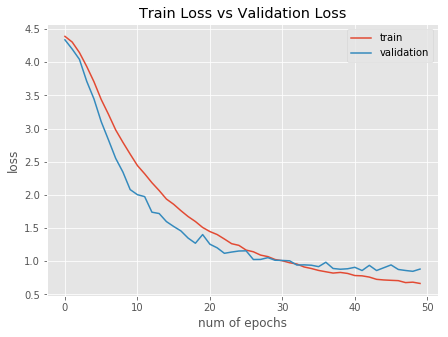

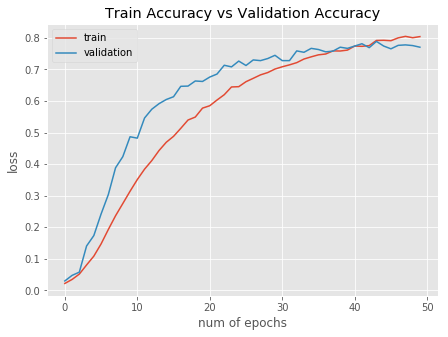

In [94]:
# print(train_loss.shape)
# print(validation_loss.shape)

visualize_loss(xc,train_loss, validation_loss)
visualize_acc(xc, train_acc, validation_acc)

In [95]:
score = model.evaluate(test_tensors,test_targets, verbose=0)

In [96]:
print('Test Loss: ', score[0])
print('Test Accurary: ', score[1])

Test Loss:  0.892472921943
Test Accurary:  0.778818443804


In [18]:
test_image = path_to_tensor('obama.jpeg')
# test_image = cv2.imread('obama.jpeg')
# test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
# test_image = cv2.resize(test_image, (100,100))
# test_image = np.array(test_image)
# test_image = test_image.astype('float32')
# test_image /= 255
# print (test_image.shape)

# test_image = np.expand_dims(test_image, axis=0)
print (test_image.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'obama.jpeg'

In [57]:
print(model.predict_proba(test_image))
print(model.predict_classes(test_image))

1/1 [==============================] - 0s
[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
1/1 [==============================] - 0s
[6]


#### Visualizing the layers

In [51]:
from keras import backend as K

def get_featuresmaps(model, layer_index, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer_index].output,])
    activations = get_activations([X_batch, 0])
    return activations

In [63]:
layer_num=1
filter_num=0
activations = get_featuresmaps(model, int(layer_num), test_image)

print(np.shape(activations))
feature_maps = activations[0][0]
print(np.shape(feature_maps))

(1, 1, 100, 100, 32)
(100, 100, 32)


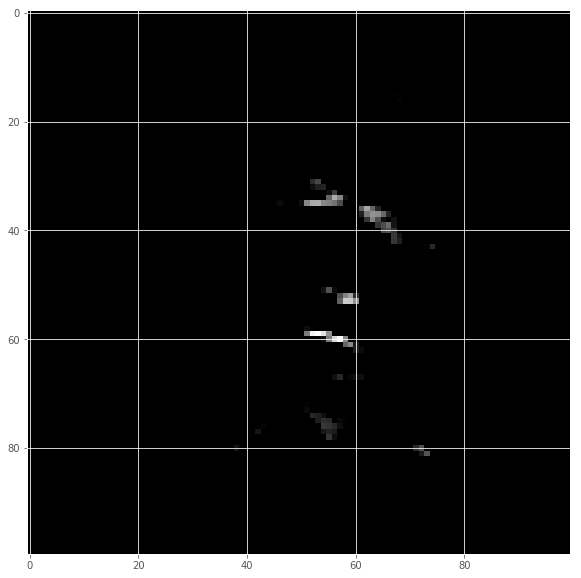

In [64]:
fit = plt.figure(figsize=(10,10))
plt.imshow(feature_maps[:,:, filter_num], cmap='gray')
plt.savefig("featuremaps-layer-{}".format(layer_num)+"-filternum-{}".format(filter_num)+".jpg")

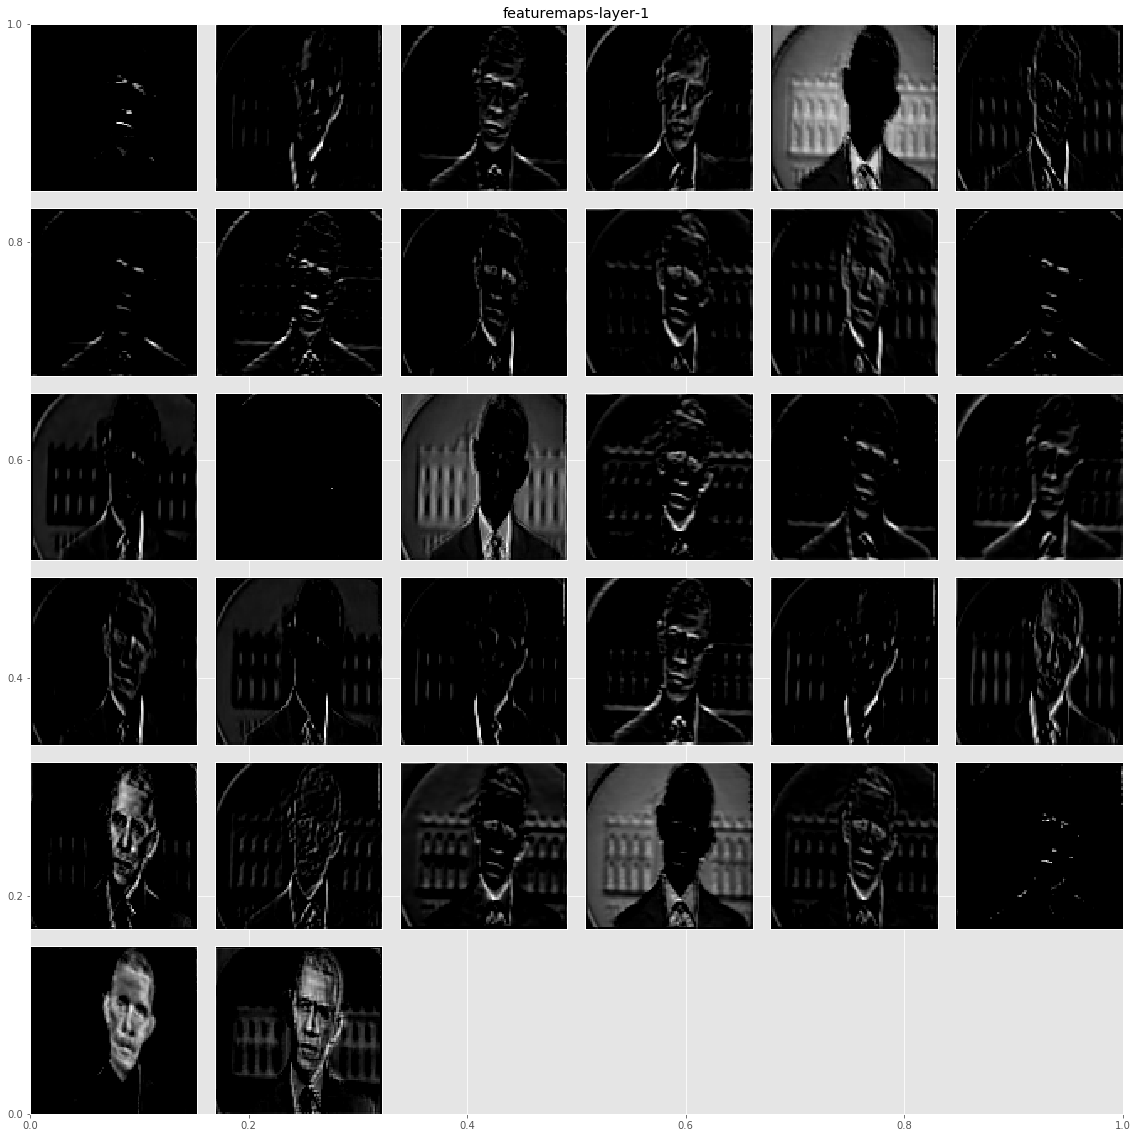

In [65]:
num_of_featuremaps=feature_maps.shape[2]
fig = plt.figure(figsize=(16,16))
plt.title("featuremaps-layer-{}".format(layer_num))
subplot_num=int(np.ceil(np.sqrt(num_of_featuremaps)))
for i in range(int(num_of_featuremaps)):
    ax = fig.add_subplot(subplot_num, subplot_num, i+1)
    ax.imshow(feature_maps[:,:,i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()
fig.savefig('featuremaps-layer-{}'.format(layer_num)+'.jpg')

#### Confusion Matrix

In [20]:
from sklearn.metrics import classification_report
import itertools

Y_pred = model.predict(valid_tensors)
print(Y_pred)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)

[[  7.81038949e-12   1.36816903e-12   7.68600323e-04 ...,   3.47928975e-09
    2.51904227e-11   3.73185722e-13]
 [  3.29081793e-08   1.84980422e-06   6.04180459e-05 ...,   1.62938959e-05
    2.04345312e-07   1.18782717e-08]
 [  4.66394820e-04   9.89980399e-05   7.17371950e-06 ...,   1.03874825e-07
    7.77463594e-10   8.14704690e-03]
 ..., 
 [  6.81626255e-10   2.45559506e-09   7.40514565e-08 ...,   1.30022973e-13
    2.54428098e-12   6.49695986e-09]
 [  2.36241358e-05   1.40438233e-05   8.78343442e-09 ...,   3.76055004e-06
    3.59242108e-07   2.42265707e-10]
 [  3.58001423e-14   5.18506454e-16   4.68778696e-11 ...,   2.46865896e-12
    8.21111235e-11   2.34285819e-16]]
[70 57 71 ..., 73 34 41]


In [21]:
person_names.append('unknown')
print(classification_report(np.argmax(valid_targets, axis=1), y_pred, target_names=person_names))
print(confusion_matrix(np.argmax(valid_targets, axis=1), y_pred))

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 83, does not match size of target_names, 84
  .format(len(labels), len(target_names))


                      precision    recall  f1-score   support

        Adam Sandler       0.90      0.82      0.86        11
        Alec Baldwin       1.00      0.90      0.95        10
      Angelina Jolie       0.47      0.67      0.55        21
     Anna Kournikova       0.93      0.76      0.84        17
      Ashton Kutcher       0.50      0.50      0.50        10
       Avril Lavigne       0.90      0.90      0.90        30
        Barack Obama       0.96      0.96      0.96        27
         Ben Affleck       0.60      0.55      0.57        11
     Beyonce Knowles       0.78      0.58      0.67        12
           Brad Pitt       0.66      0.83      0.74        30
        Cameron Diaz       0.91      0.83      0.87        24
      Cate Blanchett       0.74      0.88      0.80        16
     Charlize Theron       0.63      0.63      0.63        19
     Christina Ricci       0.91      0.71      0.80        14
    Claudia Schiffer       0.91      0.83      0.87        12
       

NameError: name 'confusion_matrix' is not defined

### Transfer Learning

#### VGG16 fine tune

In [15]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D,Dropout, Flatten, Dense



In [16]:
vgg16_model = VGG16(input_tensor=Input(shape=(100,100,3)),include_top=False,weights='imagenet')
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [17]:
last_layer = vgg16_model.get_layer('block5_pool').output
custom_layer = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(last_layer)
custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

custom_layer = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(last_layer)
custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)


custom_layer = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(last_layer)
custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

custom_layer = Dropout(0.5)(custom_layer)

custom_layer = Flatten()(custom_layer)
custom_layer = Dense(100, activation='relu')(custom_layer)
output = Dense(83, activation='softmax')(custom_layer)

# custom_layer = Flatten()(last_layer)
# custom_layer = Dense(128, activation='relu')(custom_layer)
# custom_layer = Dense(128, activation='relu')(custom_layer)

# output = Dense(16, activation='softmax')(custom_layer)

custom_vgg16_model = Model(vgg16_model.input, output)
custom_vgg16_model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [24]:
#for layer in custom_vgg16_model.layers:
    #layer.trainable = False

In [18]:
#custom_vgg16_model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
custom_vgg16_model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.005), metrics=['accuracy'])


In [19]:
from keras.callbacks import ModelCheckpoint  
from time import time

### TODO: specify the number of epochs that you would like to use to train the model.
epochs =70

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/custom_vgg16_weights.custom.model_{}.hdf5'.format(time()), 
                               verbose=1, save_best_only=True)

#tensorboard = TensorBoard(log_dir="logs/vgg16_{}".format(time()),write_images=True,write_grads=True)

trainning_result = custom_vgg16_model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=10, callbacks=[checkpointer], verbose=1)

Train on 11071 samples, validate on 1364 samples
Epoch 1/70


 2010/11071 [====>.........................] - ETA: 17:48 - loss: 4.8239 - acc: 0.0000e+ - ETA: 9:58 - loss: 4.6787 - acc: 0.0000e+00 - ETA: 7:22 - loss: 4.7152 - acc: 0.0000e+0 - ETA: 6:03 - loss: 4.6851 - acc: 0.0000e+0 - ETA: 5:15 - loss: 4.6698 - acc: 0.0000e+0 - ETA: 4:42 - loss: 4.6135 - acc: 0.0000e+0 - ETA: 4:19 - loss: 4.5988 - acc: 0.0000e+0 - ETA: 4:02 - loss: 4.5849 - acc: 0.0000e+0 - ETA: 3:48 - loss: 4.5851 - acc: 0.0000e+0 - ETA: 3:38 - loss: 4.5651 - acc: 0.0000e+0 - ETA: 3:29 - loss: 4.5409 - acc: 0.0000e+0 - ETA: 3:21 - loss: 4.5241 - acc: 0.0000e+0 - ETA: 3:15 - loss: 4.5227 - acc: 0.0000e+0 - ETA: 3:10 - loss: 4.5289 - acc: 0.0000e+0 - ETA: 3:05 - loss: 4.5304 - acc: 0.0067    - ETA: 3:01 - loss: 4.5126 - acc: 0.012 - ETA: 2:57 - loss: 4.5295 - acc: 0.011 - ETA: 2:54 - loss: 4.5264 - acc: 0.011 - ETA: 2:51 - loss: 4.5364 - acc: 0.010 - ETA: 2:48 - loss: 4.5317 - acc: 0.010 - ETA: 2:46 - loss: 4.5243 - acc: 0.009 - ETA: 2:44 - loss: 4.5227 - acc: 0.009 - ETA: 2:42 - 

 4050/11071 [=========>....................] - ETA: 1:48 - loss: 4.4367 - acc: 0.017 - ETA: 1:48 - loss: 4.4366 - acc: 0.017 - ETA: 1:47 - loss: 4.4365 - acc: 0.017 - ETA: 1:47 - loss: 4.4364 - acc: 0.017 - ETA: 1:47 - loss: 4.4363 - acc: 0.017 - ETA: 1:47 - loss: 4.4362 - acc: 0.016 - ETA: 1:47 - loss: 4.4361 - acc: 0.016 - ETA: 1:47 - loss: 4.4360 - acc: 0.016 - ETA: 1:47 - loss: 4.4359 - acc: 0.016 - ETA: 1:47 - loss: 4.4359 - acc: 0.016 - ETA: 1:46 - loss: 4.4358 - acc: 0.016 - ETA: 1:46 - loss: 4.4357 - acc: 0.016 - ETA: 1:46 - loss: 4.4356 - acc: 0.016 - ETA: 1:46 - loss: 4.4355 - acc: 0.016 - ETA: 1:46 - loss: 4.4355 - acc: 0.016 - ETA: 1:46 - loss: 4.4354 - acc: 0.016 - ETA: 1:46 - loss: 4.4353 - acc: 0.016 - ETA: 1:45 - loss: 4.4352 - acc: 0.016 - ETA: 1:45 - loss: 4.4351 - acc: 0.016 - ETA: 1:45 - loss: 4.4351 - acc: 0.016 - ETA: 1:45 - loss: 4.4350 - acc: 0.016 - ETA: 1:45 - loss: 4.4349 - acc: 0.016 - ETA: 1:45 - loss: 4.4349 - acc: 0.016 - ETA: 1:45 - loss: 4.4348 - acc: 0

 6100/11071 [===============>..............] - ETA: 1:23 - loss: 4.4264 - acc: 0.021 - ETA: 1:23 - loss: 4.4264 - acc: 0.021 - ETA: 1:23 - loss: 4.4263 - acc: 0.021 - ETA: 1:22 - loss: 4.4263 - acc: 0.021 - ETA: 1:22 - loss: 4.4263 - acc: 0.021 - ETA: 1:22 - loss: 4.4263 - acc: 0.020 - ETA: 1:22 - loss: 4.4263 - acc: 0.020 - ETA: 1:22 - loss: 4.4263 - acc: 0.020 - ETA: 1:22 - loss: 4.4262 - acc: 0.021 - ETA: 1:22 - loss: 4.4262 - acc: 0.021 - ETA: 1:22 - loss: 4.4261 - acc: 0.020 - ETA: 1:22 - loss: 4.4261 - acc: 0.021 - ETA: 1:21 - loss: 4.4261 - acc: 0.021 - ETA: 1:21 - loss: 4.4260 - acc: 0.021 - ETA: 1:21 - loss: 4.4260 - acc: 0.021 - ETA: 1:21 - loss: 4.4260 - acc: 0.021 - ETA: 1:21 - loss: 4.4259 - acc: 0.021 - ETA: 1:21 - loss: 4.4260 - acc: 0.021 - ETA: 1:21 - loss: 4.4259 - acc: 0.021 - ETA: 1:21 - loss: 4.4259 - acc: 0.021 - ETA: 1:20 - loss: 4.4259 - acc: 0.021 - ETA: 1:20 - loss: 4.4259 - acc: 0.021 - ETA: 1:20 - loss: 4.4259 - acc: 0.021 - ETA: 1:20 - loss: 4.4258 - acc: 0

 8250/11071 [=====================>........] - ETA: 58s - loss: 4.4215 - acc: 0.02 - ETA: 58s - loss: 4.4215 - acc: 0.02 - ETA: 58s - loss: 4.4216 - acc: 0.02 - ETA: 58s - loss: 4.4215 - acc: 0.02 - ETA: 58s - loss: 4.4214 - acc: 0.02 - ETA: 58s - loss: 4.4214 - acc: 0.02 - ETA: 58s - loss: 4.4214 - acc: 0.02 - ETA: 57s - loss: 4.4213 - acc: 0.02 - ETA: 57s - loss: 4.4214 - acc: 0.02 - ETA: 57s - loss: 4.4214 - acc: 0.02 - ETA: 57s - loss: 4.4213 - acc: 0.02 - ETA: 57s - loss: 4.4214 - acc: 0.02 - ETA: 57s - loss: 4.4214 - acc: 0.02 - ETA: 57s - loss: 4.4214 - acc: 0.02 - ETA: 57s - loss: 4.4214 - acc: 0.02 - ETA: 56s - loss: 4.4214 - acc: 0.02 - ETA: 56s - loss: 4.4214 - acc: 0.02 - ETA: 56s - loss: 4.4214 - acc: 0.02 - ETA: 56s - loss: 4.4214 - acc: 0.02 - ETA: 56s - loss: 4.4215 - acc: 0.02 - ETA: 56s - loss: 4.4214 - acc: 0.02 - ETA: 56s - loss: 4.4214 - acc: 0.02 - ETA: 56s - loss: 4.4213 - acc: 0.02 - ETA: 56s - loss: 4.4213 - acc: 0.02 - ETA: 55s - loss: 4.4213 - acc: 0.02 - ETA

10400/11071 [===========================>..] - ETA: 33s - loss: 4.4188 - acc: 0.02 - ETA: 33s - loss: 4.4188 - acc: 0.02 - ETA: 32s - loss: 4.4188 - acc: 0.02 - ETA: 32s - loss: 4.4187 - acc: 0.02 - ETA: 32s - loss: 4.4187 - acc: 0.02 - ETA: 32s - loss: 4.4187 - acc: 0.02 - ETA: 32s - loss: 4.4187 - acc: 0.02 - ETA: 32s - loss: 4.4187 - acc: 0.02 - ETA: 32s - loss: 4.4187 - acc: 0.02 - ETA: 32s - loss: 4.4186 - acc: 0.02 - ETA: 31s - loss: 4.4187 - acc: 0.02 - ETA: 31s - loss: 4.4186 - acc: 0.02 - ETA: 31s - loss: 4.4187 - acc: 0.01 - ETA: 31s - loss: 4.4187 - acc: 0.01 - ETA: 31s - loss: 4.4186 - acc: 0.01 - ETA: 31s - loss: 4.4186 - acc: 0.01 - ETA: 31s - loss: 4.4185 - acc: 0.02 - ETA: 31s - loss: 4.4185 - acc: 0.02 - ETA: 30s - loss: 4.4184 - acc: 0.02 - ETA: 30s - loss: 4.4184 - acc: 0.02 - ETA: 30s - loss: 4.4184 - acc: 0.02 - ETA: 30s - loss: 4.4184 - acc: 0.02 - ETA: 30s - loss: 4.4183 - acc: 0.02 - ETA: 30s - loss: 4.4184 - acc: 0.02 - ETA: 30s - loss: 4.4185 - acc: 0.02 - ETA

11071/11071 [==============================] - 135s 12ms/step - loss: 4.4141 - acc: 0.0210 - val_loss: 4.3893 - val_acc: 0.0257
Epoch 2/70


 2040/11071 [====>.........................] - ETA: 1:58 - loss: 4.2884 - acc: 0.200 - ETA: 1:58 - loss: 4.3699 - acc: 0.100 - ETA: 1:59 - loss: 4.3899 - acc: 0.066 - ETA: 2:00 - loss: 4.4033 - acc: 0.050 - ETA: 2:00 - loss: 4.3878 - acc: 0.040 - ETA: 2:00 - loss: 4.3697 - acc: 0.050 - ETA: 2:00 - loss: 4.3845 - acc: 0.042 - ETA: 2:00 - loss: 4.3799 - acc: 0.037 - ETA: 2:00 - loss: 4.3831 - acc: 0.033 - ETA: 2:00 - loss: 4.3883 - acc: 0.030 - ETA: 2:00 - loss: 4.3916 - acc: 0.036 - ETA: 2:00 - loss: 4.3949 - acc: 0.033 - ETA: 2:00 - loss: 4.3960 - acc: 0.030 - ETA: 1:59 - loss: 4.3985 - acc: 0.035 - ETA: 1:59 - loss: 4.3995 - acc: 0.033 - ETA: 1:59 - loss: 4.4021 - acc: 0.031 - ETA: 1:59 - loss: 4.4025 - acc: 0.029 - ETA: 1:59 - loss: 4.4031 - acc: 0.033 - ETA: 1:59 - loss: 4.4021 - acc: 0.031 - ETA: 1:59 - loss: 4.4031 - acc: 0.030 - ETA: 1:59 - loss: 4.4032 - acc: 0.028 - ETA: 1:59 - loss: 4.4042 - acc: 0.027 - ETA: 1:59 - loss: 4.4041 - acc: 0.026 - ETA: 1:59 - loss: 4.4051 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:40 - loss: 4.3962 - acc: 0.019 - ETA: 1:40 - loss: 4.3962 - acc: 0.019 - ETA: 1:39 - loss: 4.3961 - acc: 0.019 - ETA: 1:39 - loss: 4.3962 - acc: 0.019 - ETA: 1:39 - loss: 4.3961 - acc: 0.020 - ETA: 1:39 - loss: 4.3959 - acc: 0.020 - ETA: 1:39 - loss: 4.3956 - acc: 0.020 - ETA: 1:39 - loss: 4.3951 - acc: 0.021 - ETA: 1:39 - loss: 4.3953 - acc: 0.021 - ETA: 1:39 - loss: 4.3954 - acc: 0.021 - ETA: 1:39 - loss: 4.3952 - acc: 0.021 - ETA: 1:39 - loss: 4.3956 - acc: 0.021 - ETA: 1:38 - loss: 4.3959 - acc: 0.021 - ETA: 1:38 - loss: 4.3957 - acc: 0.021 - ETA: 1:38 - loss: 4.3955 - acc: 0.021 - ETA: 1:38 - loss: 4.3953 - acc: 0.021 - ETA: 1:38 - loss: 4.3949 - acc: 0.021 - ETA: 1:38 - loss: 4.3947 - acc: 0.021 - ETA: 1:38 - loss: 4.3939 - acc: 0.021 - ETA: 1:38 - loss: 4.3942 - acc: 0.021 - ETA: 1:38 - loss: 4.3948 - acc: 0.021 - ETA: 1:38 - loss: 4.3943 - acc: 0.021 - ETA: 1:38 - loss: 4.3945 - acc: 0.021 - ETA: 1:38 - loss: 4.3946 - acc: 0

 6120/11071 [===============>..............] - ETA: 1:22 - loss: 4.3919 - acc: 0.019 - ETA: 1:22 - loss: 4.3922 - acc: 0.019 - ETA: 1:21 - loss: 4.3921 - acc: 0.019 - ETA: 1:21 - loss: 4.3922 - acc: 0.019 - ETA: 1:21 - loss: 4.3923 - acc: 0.019 - ETA: 1:21 - loss: 4.3924 - acc: 0.019 - ETA: 1:21 - loss: 4.3919 - acc: 0.020 - ETA: 1:21 - loss: 4.3916 - acc: 0.020 - ETA: 1:21 - loss: 4.3915 - acc: 0.019 - ETA: 1:21 - loss: 4.3915 - acc: 0.019 - ETA: 1:21 - loss: 4.3912 - acc: 0.019 - ETA: 1:21 - loss: 4.3908 - acc: 0.020 - ETA: 1:20 - loss: 4.3909 - acc: 0.020 - ETA: 1:20 - loss: 4.3912 - acc: 0.019 - ETA: 1:20 - loss: 4.3914 - acc: 0.019 - ETA: 1:20 - loss: 4.3909 - acc: 0.020 - ETA: 1:20 - loss: 4.3910 - acc: 0.020 - ETA: 1:20 - loss: 4.3909 - acc: 0.020 - ETA: 1:20 - loss: 4.3909 - acc: 0.019 - ETA: 1:20 - loss: 4.3910 - acc: 0.019 - ETA: 1:20 - loss: 4.3908 - acc: 0.019 - ETA: 1:20 - loss: 4.3910 - acc: 0.019 - ETA: 1:19 - loss: 4.3911 - acc: 0.019 - ETA: 1:19 - loss: 4.3906 - acc: 0

 8270/11071 [=====================>........] - ETA: 59s - loss: 4.3802 - acc: 0.02 - ETA: 59s - loss: 4.3800 - acc: 0.02 - ETA: 59s - loss: 4.3801 - acc: 0.02 - ETA: 59s - loss: 4.3799 - acc: 0.02 - ETA: 59s - loss: 4.3798 - acc: 0.02 - ETA: 59s - loss: 4.3794 - acc: 0.02 - ETA: 59s - loss: 4.3794 - acc: 0.02 - ETA: 58s - loss: 4.3792 - acc: 0.02 - ETA: 58s - loss: 4.3788 - acc: 0.02 - ETA: 58s - loss: 4.3786 - acc: 0.02 - ETA: 58s - loss: 4.3786 - acc: 0.02 - ETA: 58s - loss: 4.3789 - acc: 0.02 - ETA: 58s - loss: 4.3790 - acc: 0.02 - ETA: 58s - loss: 4.3791 - acc: 0.02 - ETA: 58s - loss: 4.3791 - acc: 0.02 - ETA: 58s - loss: 4.3787 - acc: 0.02 - ETA: 57s - loss: 4.3787 - acc: 0.02 - ETA: 57s - loss: 4.3788 - acc: 0.02 - ETA: 57s - loss: 4.3789 - acc: 0.02 - ETA: 57s - loss: 4.3789 - acc: 0.02 - ETA: 57s - loss: 4.3785 - acc: 0.02 - ETA: 57s - loss: 4.3786 - acc: 0.02 - ETA: 57s - loss: 4.3787 - acc: 0.02 - ETA: 57s - loss: 4.3785 - acc: 0.02 - ETA: 56s - loss: 4.3786 - acc: 0.02 - ETA

10420/11071 [===========================>..] - ETA: 33s - loss: 4.3645 - acc: 0.02 - ETA: 33s - loss: 4.3643 - acc: 0.02 - ETA: 33s - loss: 4.3641 - acc: 0.02 - ETA: 32s - loss: 4.3637 - acc: 0.02 - ETA: 32s - loss: 4.3637 - acc: 0.02 - ETA: 32s - loss: 4.3637 - acc: 0.02 - ETA: 32s - loss: 4.3637 - acc: 0.02 - ETA: 32s - loss: 4.3636 - acc: 0.02 - ETA: 32s - loss: 4.3633 - acc: 0.02 - ETA: 32s - loss: 4.3631 - acc: 0.02 - ETA: 32s - loss: 4.3629 - acc: 0.02 - ETA: 31s - loss: 4.3629 - acc: 0.02 - ETA: 31s - loss: 4.3629 - acc: 0.02 - ETA: 31s - loss: 4.3627 - acc: 0.02 - ETA: 31s - loss: 4.3627 - acc: 0.02 - ETA: 31s - loss: 4.3628 - acc: 0.02 - ETA: 31s - loss: 4.3628 - acc: 0.02 - ETA: 31s - loss: 4.3627 - acc: 0.02 - ETA: 31s - loss: 4.3629 - acc: 0.02 - ETA: 31s - loss: 4.3630 - acc: 0.02 - ETA: 30s - loss: 4.3630 - acc: 0.02 - ETA: 30s - loss: 4.3629 - acc: 0.02 - ETA: 30s - loss: 4.3628 - acc: 0.02 - ETA: 30s - loss: 4.3626 - acc: 0.02 - ETA: 30s - loss: 4.3627 - acc: 0.02 - ETA

11071/11071 [==============================] - 136s 12ms/step - loss: 4.3435 - acc: 0.0230 - val_loss: 4.3858 - val_acc: 0.0271
Epoch 3/70


 2030/11071 [====>.........................] - ETA: 2:08 - loss: 4.3944 - acc: 0.0000e+0 - ETA: 2:09 - loss: 4.4067 - acc: 0.0000e+0 - ETA: 2:10 - loss: 4.3918 - acc: 0.0000e+0 - ETA: 2:11 - loss: 4.3802 - acc: 0.0000e+0 - ETA: 2:10 - loss: 4.3786 - acc: 0.0000e+0 - ETA: 2:09 - loss: 4.3766 - acc: 0.0000e+0 - ETA: 2:10 - loss: 4.3582 - acc: 0.0000e+0 - ETA: 2:09 - loss: 4.3494 - acc: 0.0000e+0 - ETA: 2:09 - loss: 4.3486 - acc: 0.0000e+0 - ETA: 2:09 - loss: 4.3449 - acc: 0.0000e+0 - ETA: 2:08 - loss: 4.3309 - acc: 0.0273    - ETA: 2:08 - loss: 4.3391 - acc: 0.025 - ETA: 2:07 - loss: 4.3421 - acc: 0.023 - ETA: 2:07 - loss: 4.3263 - acc: 0.021 - ETA: 2:07 - loss: 4.3231 - acc: 0.020 - ETA: 2:06 - loss: 4.3227 - acc: 0.018 - ETA: 2:06 - loss: 4.3228 - acc: 0.017 - ETA: 2:05 - loss: 4.3356 - acc: 0.016 - ETA: 2:05 - loss: 4.3404 - acc: 0.021 - ETA: 2:05 - loss: 4.3310 - acc: 0.025 - ETA: 2:05 - loss: 4.3318 - acc: 0.023 - ETA: 2:04 - loss: 4.3466 - acc: 0.022 - ETA: 2:04 - loss: 4.3426 - ac

 4070/11071 [==========>...................] - ETA: 1:45 - loss: 4.2375 - acc: 0.029 - ETA: 1:44 - loss: 4.2376 - acc: 0.029 - ETA: 1:44 - loss: 4.2369 - acc: 0.030 - ETA: 1:44 - loss: 4.2372 - acc: 0.030 - ETA: 1:44 - loss: 4.2369 - acc: 0.030 - ETA: 1:44 - loss: 4.2364 - acc: 0.030 - ETA: 1:44 - loss: 4.2372 - acc: 0.030 - ETA: 1:44 - loss: 4.2377 - acc: 0.029 - ETA: 1:43 - loss: 4.2374 - acc: 0.029 - ETA: 1:43 - loss: 4.2373 - acc: 0.029 - ETA: 1:43 - loss: 4.2382 - acc: 0.029 - ETA: 1:43 - loss: 4.2377 - acc: 0.029 - ETA: 1:43 - loss: 4.2367 - acc: 0.029 - ETA: 1:43 - loss: 4.2354 - acc: 0.029 - ETA: 1:43 - loss: 4.2361 - acc: 0.028 - ETA: 1:43 - loss: 4.2355 - acc: 0.029 - ETA: 1:42 - loss: 4.2368 - acc: 0.029 - ETA: 1:42 - loss: 4.2371 - acc: 0.029 - ETA: 1:42 - loss: 4.2350 - acc: 0.028 - ETA: 1:42 - loss: 4.2347 - acc: 0.028 - ETA: 1:42 - loss: 4.2354 - acc: 0.029 - ETA: 1:42 - loss: 4.2347 - acc: 0.029 - ETA: 1:42 - loss: 4.2349 - acc: 0.030 - ETA: 1:41 - loss: 4.2330 - acc: 0

 6130/11071 [===============>..............] - ETA: 1:20 - loss: 4.2211 - acc: 0.030 - ETA: 1:19 - loss: 4.2210 - acc: 0.030 - ETA: 1:19 - loss: 4.2211 - acc: 0.030 - ETA: 1:19 - loss: 4.2209 - acc: 0.030 - ETA: 1:19 - loss: 4.2199 - acc: 0.030 - ETA: 1:19 - loss: 4.2196 - acc: 0.030 - ETA: 1:19 - loss: 4.2194 - acc: 0.030 - ETA: 1:19 - loss: 4.2191 - acc: 0.030 - ETA: 1:19 - loss: 4.2184 - acc: 0.030 - ETA: 1:19 - loss: 4.2177 - acc: 0.031 - ETA: 1:18 - loss: 4.2180 - acc: 0.031 - ETA: 1:18 - loss: 4.2177 - acc: 0.031 - ETA: 1:18 - loss: 4.2175 - acc: 0.031 - ETA: 1:18 - loss: 4.2180 - acc: 0.030 - ETA: 1:18 - loss: 4.2178 - acc: 0.031 - ETA: 1:18 - loss: 4.2178 - acc: 0.031 - ETA: 1:18 - loss: 4.2171 - acc: 0.031 - ETA: 1:18 - loss: 4.2169 - acc: 0.031 - ETA: 1:17 - loss: 4.2173 - acc: 0.031 - ETA: 1:17 - loss: 4.2173 - acc: 0.030 - ETA: 1:17 - loss: 4.2168 - acc: 0.030 - ETA: 1:17 - loss: 4.2168 - acc: 0.030 - ETA: 1:17 - loss: 4.2162 - acc: 0.030 - ETA: 1:17 - loss: 4.2166 - acc: 0

 8280/11071 [=====================>........] - ETA: 56s - loss: 4.2136 - acc: 0.03 - ETA: 56s - loss: 4.2137 - acc: 0.03 - ETA: 56s - loss: 4.2132 - acc: 0.03 - ETA: 55s - loss: 4.2131 - acc: 0.03 - ETA: 55s - loss: 4.2127 - acc: 0.03 - ETA: 55s - loss: 4.2128 - acc: 0.03 - ETA: 55s - loss: 4.2130 - acc: 0.03 - ETA: 55s - loss: 4.2130 - acc: 0.03 - ETA: 55s - loss: 4.2132 - acc: 0.03 - ETA: 55s - loss: 4.2133 - acc: 0.03 - ETA: 55s - loss: 4.2134 - acc: 0.03 - ETA: 55s - loss: 4.2132 - acc: 0.03 - ETA: 54s - loss: 4.2132 - acc: 0.03 - ETA: 54s - loss: 4.2129 - acc: 0.03 - ETA: 54s - loss: 4.2127 - acc: 0.03 - ETA: 54s - loss: 4.2127 - acc: 0.03 - ETA: 54s - loss: 4.2123 - acc: 0.03 - ETA: 54s - loss: 4.2123 - acc: 0.03 - ETA: 54s - loss: 4.2122 - acc: 0.03 - ETA: 54s - loss: 4.2122 - acc: 0.03 - ETA: 54s - loss: 4.2116 - acc: 0.03 - ETA: 53s - loss: 4.2126 - acc: 0.03 - ETA: 53s - loss: 4.2128 - acc: 0.03 - ETA: 53s - loss: 4.2125 - acc: 0.03 - ETA: 53s - loss: 4.2126 - acc: 0.03 - ETA

10430/11071 [===========================>..] - ETA: 31s - loss: 4.2022 - acc: 0.03 - ETA: 31s - loss: 4.2023 - acc: 0.03 - ETA: 31s - loss: 4.2020 - acc: 0.03 - ETA: 31s - loss: 4.2021 - acc: 0.03 - ETA: 31s - loss: 4.2021 - acc: 0.03 - ETA: 31s - loss: 4.2023 - acc: 0.03 - ETA: 30s - loss: 4.2023 - acc: 0.03 - ETA: 30s - loss: 4.2023 - acc: 0.03 - ETA: 30s - loss: 4.2021 - acc: 0.03 - ETA: 30s - loss: 4.2023 - acc: 0.03 - ETA: 30s - loss: 4.2020 - acc: 0.03 - ETA: 30s - loss: 4.2016 - acc: 0.03 - ETA: 30s - loss: 4.2015 - acc: 0.03 - ETA: 30s - loss: 4.2019 - acc: 0.03 - ETA: 30s - loss: 4.2019 - acc: 0.03 - ETA: 29s - loss: 4.2022 - acc: 0.03 - ETA: 29s - loss: 4.2024 - acc: 0.03 - ETA: 29s - loss: 4.2024 - acc: 0.03 - ETA: 29s - loss: 4.2024 - acc: 0.03 - ETA: 29s - loss: 4.2021 - acc: 0.03 - ETA: 29s - loss: 4.2019 - acc: 0.03 - ETA: 29s - loss: 4.2016 - acc: 0.03 - ETA: 29s - loss: 4.2015 - acc: 0.03 - ETA: 29s - loss: 4.2015 - acc: 0.03 - ETA: 28s - loss: 4.2016 - acc: 0.03 - ETA

11071/11071 [==============================] - 130s 12ms/step - loss: 4.1891 - acc: 0.0370 - val_loss: 4.2756 - val_acc: 0.0403
Epoch 4/70


 2040/11071 [====>.........................] - ETA: 2:00 - loss: 4.4820 - acc: 0.0000e+0 - ETA: 2:01 - loss: 4.2256 - acc: 0.1000    - ETA: 2:02 - loss: 4.1971 - acc: 0.066 - ETA: 2:03 - loss: 4.2257 - acc: 0.050 - ETA: 2:04 - loss: 4.1625 - acc: 0.060 - ETA: 2:03 - loss: 4.1779 - acc: 0.050 - ETA: 2:04 - loss: 4.1916 - acc: 0.042 - ETA: 2:05 - loss: 4.1545 - acc: 0.050 - ETA: 2:04 - loss: 4.1580 - acc: 0.044 - ETA: 2:04 - loss: 4.1466 - acc: 0.040 - ETA: 2:03 - loss: 4.1625 - acc: 0.036 - ETA: 2:03 - loss: 4.1472 - acc: 0.033 - ETA: 2:03 - loss: 4.1124 - acc: 0.038 - ETA: 2:03 - loss: 4.1153 - acc: 0.035 - ETA: 2:03 - loss: 4.1215 - acc: 0.033 - ETA: 2:03 - loss: 4.1138 - acc: 0.037 - ETA: 2:02 - loss: 4.1234 - acc: 0.035 - ETA: 2:02 - loss: 4.1121 - acc: 0.038 - ETA: 2:02 - loss: 4.0998 - acc: 0.036 - ETA: 2:02 - loss: 4.1065 - acc: 0.035 - ETA: 2:02 - loss: 4.1124 - acc: 0.038 - ETA: 2:02 - loss: 4.1040 - acc: 0.040 - ETA: 2:02 - loss: 4.1215 - acc: 0.039 - ETA: 2:01 - loss: 4.1122 

 4080/11071 [==========>...................] - ETA: 1:43 - loss: 4.0864 - acc: 0.053 - ETA: 1:43 - loss: 4.0859 - acc: 0.053 - ETA: 1:43 - loss: 4.0869 - acc: 0.053 - ETA: 1:43 - loss: 4.0869 - acc: 0.053 - ETA: 1:43 - loss: 4.0863 - acc: 0.054 - ETA: 1:43 - loss: 4.0867 - acc: 0.053 - ETA: 1:42 - loss: 4.0882 - acc: 0.053 - ETA: 1:42 - loss: 4.0876 - acc: 0.053 - ETA: 1:42 - loss: 4.0888 - acc: 0.053 - ETA: 1:42 - loss: 4.0898 - acc: 0.052 - ETA: 1:42 - loss: 4.0888 - acc: 0.053 - ETA: 1:42 - loss: 4.0871 - acc: 0.053 - ETA: 1:42 - loss: 4.0867 - acc: 0.053 - ETA: 1:42 - loss: 4.0863 - acc: 0.053 - ETA: 1:42 - loss: 4.0866 - acc: 0.053 - ETA: 1:41 - loss: 4.0865 - acc: 0.052 - ETA: 1:41 - loss: 4.0866 - acc: 0.052 - ETA: 1:41 - loss: 4.0848 - acc: 0.053 - ETA: 1:41 - loss: 4.0842 - acc: 0.054 - ETA: 1:41 - loss: 4.0837 - acc: 0.054 - ETA: 1:41 - loss: 4.0818 - acc: 0.054 - ETA: 1:41 - loss: 4.0824 - acc: 0.054 - ETA: 1:41 - loss: 4.0802 - acc: 0.054 - ETA: 1:40 - loss: 4.0813 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:19 - loss: 4.0954 - acc: 0.051 - ETA: 1:19 - loss: 4.0959 - acc: 0.051 - ETA: 1:19 - loss: 4.0960 - acc: 0.051 - ETA: 1:19 - loss: 4.0959 - acc: 0.051 - ETA: 1:19 - loss: 4.0952 - acc: 0.051 - ETA: 1:19 - loss: 4.0943 - acc: 0.051 - ETA: 1:19 - loss: 4.0936 - acc: 0.051 - ETA: 1:19 - loss: 4.0927 - acc: 0.051 - ETA: 1:18 - loss: 4.0936 - acc: 0.051 - ETA: 1:18 - loss: 4.0939 - acc: 0.051 - ETA: 1:18 - loss: 4.0943 - acc: 0.051 - ETA: 1:18 - loss: 4.0949 - acc: 0.051 - ETA: 1:18 - loss: 4.0943 - acc: 0.051 - ETA: 1:18 - loss: 4.0935 - acc: 0.051 - ETA: 1:18 - loss: 4.0940 - acc: 0.051 - ETA: 1:18 - loss: 4.0937 - acc: 0.051 - ETA: 1:17 - loss: 4.0933 - acc: 0.052 - ETA: 1:17 - loss: 4.0936 - acc: 0.051 - ETA: 1:17 - loss: 4.0941 - acc: 0.051 - ETA: 1:17 - loss: 4.0941 - acc: 0.051 - ETA: 1:17 - loss: 4.0950 - acc: 0.051 - ETA: 1:17 - loss: 4.0950 - acc: 0.051 - ETA: 1:17 - loss: 4.0944 - acc: 0.051 - ETA: 1:17 - loss: 4.0941 - acc: 0

 8290/11071 [=====================>........] - ETA: 56s - loss: 4.0865 - acc: 0.05 - ETA: 55s - loss: 4.0865 - acc: 0.05 - ETA: 55s - loss: 4.0864 - acc: 0.05 - ETA: 55s - loss: 4.0865 - acc: 0.05 - ETA: 55s - loss: 4.0867 - acc: 0.05 - ETA: 55s - loss: 4.0872 - acc: 0.05 - ETA: 55s - loss: 4.0871 - acc: 0.05 - ETA: 55s - loss: 4.0869 - acc: 0.05 - ETA: 55s - loss: 4.0868 - acc: 0.05 - ETA: 55s - loss: 4.0867 - acc: 0.05 - ETA: 54s - loss: 4.0871 - acc: 0.05 - ETA: 54s - loss: 4.0872 - acc: 0.05 - ETA: 54s - loss: 4.0864 - acc: 0.05 - ETA: 54s - loss: 4.0860 - acc: 0.05 - ETA: 54s - loss: 4.0854 - acc: 0.05 - ETA: 54s - loss: 4.0854 - acc: 0.05 - ETA: 54s - loss: 4.0851 - acc: 0.05 - ETA: 54s - loss: 4.0848 - acc: 0.05 - ETA: 54s - loss: 4.0853 - acc: 0.05 - ETA: 54s - loss: 4.0854 - acc: 0.05 - ETA: 53s - loss: 4.0857 - acc: 0.05 - ETA: 53s - loss: 4.0860 - acc: 0.05 - ETA: 53s - loss: 4.0859 - acc: 0.05 - ETA: 53s - loss: 4.0854 - acc: 0.05 - ETA: 53s - loss: 4.0847 - acc: 0.05 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 4.0728 - acc: 0.05 - ETA: 31s - loss: 4.0729 - acc: 0.05 - ETA: 31s - loss: 4.0729 - acc: 0.05 - ETA: 31s - loss: 4.0731 - acc: 0.05 - ETA: 31s - loss: 4.0731 - acc: 0.05 - ETA: 31s - loss: 4.0731 - acc: 0.05 - ETA: 30s - loss: 4.0732 - acc: 0.05 - ETA: 30s - loss: 4.0731 - acc: 0.05 - ETA: 30s - loss: 4.0732 - acc: 0.05 - ETA: 30s - loss: 4.0732 - acc: 0.05 - ETA: 30s - loss: 4.0730 - acc: 0.05 - ETA: 30s - loss: 4.0726 - acc: 0.05 - ETA: 30s - loss: 4.0725 - acc: 0.05 - ETA: 30s - loss: 4.0725 - acc: 0.05 - ETA: 30s - loss: 4.0724 - acc: 0.05 - ETA: 29s - loss: 4.0722 - acc: 0.05 - ETA: 29s - loss: 4.0717 - acc: 0.05 - ETA: 29s - loss: 4.0720 - acc: 0.05 - ETA: 29s - loss: 4.0723 - acc: 0.05 - ETA: 29s - loss: 4.0722 - acc: 0.05 - ETA: 29s - loss: 4.0722 - acc: 0.05 - ETA: 29s - loss: 4.0719 - acc: 0.05 - ETA: 29s - loss: 4.0724 - acc: 0.05 - ETA: 29s - loss: 4.0720 - acc: 0.05 - ETA: 28s - loss: 4.0722 - acc: 0.05 - ETA

11071/11071 [==============================] - 131s 12ms/step - loss: 4.0558 - acc: 0.0565 - val_loss: 3.9562 - val_acc: 0.0740
Epoch 5/70


 2040/11071 [====>.........................] - ETA: 2:00 - loss: 3.7794 - acc: 0.100 - ETA: 1:59 - loss: 3.8001 - acc: 0.100 - ETA: 2:00 - loss: 3.7438 - acc: 0.166 - ETA: 2:01 - loss: 3.7622 - acc: 0.150 - ETA: 2:01 - loss: 3.7893 - acc: 0.140 - ETA: 2:02 - loss: 3.8481 - acc: 0.150 - ETA: 2:03 - loss: 3.8776 - acc: 0.128 - ETA: 2:03 - loss: 3.8181 - acc: 0.137 - ETA: 2:02 - loss: 3.8553 - acc: 0.122 - ETA: 2:02 - loss: 3.8861 - acc: 0.110 - ETA: 2:02 - loss: 3.9134 - acc: 0.109 - ETA: 2:02 - loss: 3.8859 - acc: 0.125 - ETA: 2:01 - loss: 3.8872 - acc: 0.123 - ETA: 2:01 - loss: 3.8762 - acc: 0.121 - ETA: 2:01 - loss: 3.9144 - acc: 0.113 - ETA: 2:01 - loss: 3.9071 - acc: 0.106 - ETA: 2:01 - loss: 3.9115 - acc: 0.100 - ETA: 2:00 - loss: 3.9138 - acc: 0.094 - ETA: 2:00 - loss: 3.9180 - acc: 0.094 - ETA: 2:00 - loss: 3.9185 - acc: 0.090 - ETA: 2:00 - loss: 3.8889 - acc: 0.095 - ETA: 2:00 - loss: 3.8950 - acc: 0.095 - ETA: 2:00 - loss: 3.8963 - acc: 0.095 - ETA: 2:00 - loss: 3.8996 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:39 - loss: 3.9736 - acc: 0.067 - ETA: 1:39 - loss: 3.9753 - acc: 0.067 - ETA: 1:39 - loss: 3.9770 - acc: 0.066 - ETA: 1:39 - loss: 3.9770 - acc: 0.066 - ETA: 1:39 - loss: 3.9768 - acc: 0.066 - ETA: 1:39 - loss: 3.9755 - acc: 0.067 - ETA: 1:38 - loss: 3.9755 - acc: 0.066 - ETA: 1:38 - loss: 3.9772 - acc: 0.066 - ETA: 1:38 - loss: 3.9776 - acc: 0.066 - ETA: 1:38 - loss: 3.9783 - acc: 0.065 - ETA: 1:38 - loss: 3.9792 - acc: 0.065 - ETA: 1:38 - loss: 3.9782 - acc: 0.065 - ETA: 1:38 - loss: 3.9776 - acc: 0.066 - ETA: 1:38 - loss: 3.9790 - acc: 0.066 - ETA: 1:38 - loss: 3.9801 - acc: 0.066 - ETA: 1:37 - loss: 3.9777 - acc: 0.065 - ETA: 1:37 - loss: 3.9802 - acc: 0.066 - ETA: 1:37 - loss: 3.9813 - acc: 0.065 - ETA: 1:37 - loss: 3.9786 - acc: 0.066 - ETA: 1:37 - loss: 3.9790 - acc: 0.066 - ETA: 1:37 - loss: 3.9794 - acc: 0.066 - ETA: 1:37 - loss: 3.9822 - acc: 0.066 - ETA: 1:37 - loss: 3.9827 - acc: 0.066 - ETA: 1:37 - loss: 3.9845 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:17 - loss: 3.9684 - acc: 0.070 - ETA: 1:16 - loss: 3.9694 - acc: 0.070 - ETA: 1:16 - loss: 3.9694 - acc: 0.070 - ETA: 1:16 - loss: 3.9693 - acc: 0.070 - ETA: 1:16 - loss: 3.9695 - acc: 0.070 - ETA: 1:16 - loss: 3.9697 - acc: 0.070 - ETA: 1:16 - loss: 3.9705 - acc: 0.070 - ETA: 1:16 - loss: 3.9701 - acc: 0.070 - ETA: 1:16 - loss: 3.9694 - acc: 0.070 - ETA: 1:16 - loss: 3.9699 - acc: 0.070 - ETA: 1:15 - loss: 3.9706 - acc: 0.070 - ETA: 1:15 - loss: 3.9710 - acc: 0.070 - ETA: 1:15 - loss: 3.9711 - acc: 0.069 - ETA: 1:15 - loss: 3.9708 - acc: 0.069 - ETA: 1:15 - loss: 3.9710 - acc: 0.069 - ETA: 1:15 - loss: 3.9706 - acc: 0.070 - ETA: 1:15 - loss: 3.9713 - acc: 0.069 - ETA: 1:15 - loss: 3.9713 - acc: 0.070 - ETA: 1:15 - loss: 3.9712 - acc: 0.070 - ETA: 1:15 - loss: 3.9714 - acc: 0.070 - ETA: 1:14 - loss: 3.9724 - acc: 0.070 - ETA: 1:14 - loss: 3.9708 - acc: 0.070 - ETA: 1:14 - loss: 3.9702 - acc: 0.070 - ETA: 1:14 - loss: 3.9694 - acc: 0

 8300/11071 [=====================>........] - ETA: 54s - loss: 3.9639 - acc: 0.07 - ETA: 54s - loss: 3.9631 - acc: 0.07 - ETA: 54s - loss: 3.9625 - acc: 0.07 - ETA: 53s - loss: 3.9624 - acc: 0.07 - ETA: 53s - loss: 3.9628 - acc: 0.07 - ETA: 53s - loss: 3.9625 - acc: 0.07 - ETA: 53s - loss: 3.9625 - acc: 0.07 - ETA: 53s - loss: 3.9625 - acc: 0.07 - ETA: 53s - loss: 3.9622 - acc: 0.07 - ETA: 53s - loss: 3.9618 - acc: 0.07 - ETA: 53s - loss: 3.9625 - acc: 0.07 - ETA: 53s - loss: 3.9626 - acc: 0.07 - ETA: 52s - loss: 3.9632 - acc: 0.07 - ETA: 52s - loss: 3.9624 - acc: 0.07 - ETA: 52s - loss: 3.9619 - acc: 0.07 - ETA: 52s - loss: 3.9603 - acc: 0.07 - ETA: 52s - loss: 3.9606 - acc: 0.07 - ETA: 52s - loss: 3.9604 - acc: 0.07 - ETA: 52s - loss: 3.9609 - acc: 0.07 - ETA: 52s - loss: 3.9608 - acc: 0.07 - ETA: 52s - loss: 3.9609 - acc: 0.07 - ETA: 51s - loss: 3.9605 - acc: 0.07 - ETA: 51s - loss: 3.9603 - acc: 0.07 - ETA: 51s - loss: 3.9597 - acc: 0.07 - ETA: 51s - loss: 3.9593 - acc: 0.07 - ETA

10450/11071 [===========================>..] - ETA: 30s - loss: 3.9402 - acc: 0.07 - ETA: 30s - loss: 3.9404 - acc: 0.07 - ETA: 30s - loss: 3.9406 - acc: 0.07 - ETA: 30s - loss: 3.9405 - acc: 0.07 - ETA: 30s - loss: 3.9405 - acc: 0.07 - ETA: 29s - loss: 3.9405 - acc: 0.07 - ETA: 29s - loss: 3.9396 - acc: 0.07 - ETA: 29s - loss: 3.9392 - acc: 0.07 - ETA: 29s - loss: 3.9395 - acc: 0.07 - ETA: 29s - loss: 3.9399 - acc: 0.07 - ETA: 29s - loss: 3.9402 - acc: 0.07 - ETA: 29s - loss: 3.9400 - acc: 0.07 - ETA: 29s - loss: 3.9402 - acc: 0.07 - ETA: 29s - loss: 3.9404 - acc: 0.07 - ETA: 28s - loss: 3.9396 - acc: 0.07 - ETA: 28s - loss: 3.9398 - acc: 0.07 - ETA: 28s - loss: 3.9401 - acc: 0.07 - ETA: 28s - loss: 3.9398 - acc: 0.07 - ETA: 28s - loss: 3.9397 - acc: 0.07 - ETA: 28s - loss: 3.9395 - acc: 0.07 - ETA: 28s - loss: 3.9392 - acc: 0.07 - ETA: 28s - loss: 3.9394 - acc: 0.07 - ETA: 28s - loss: 3.9393 - acc: 0.07 - ETA: 27s - loss: 3.9393 - acc: 0.07 - ETA: 27s - loss: 3.9391 - acc: 0.07 - ETA

11071/11071 [==============================] - 126s 11ms/step - loss: 3.9167 - acc: 0.0751 - val_loss: 5.2300 - val_acc: 0.0696
Epoch 6/70


 2040/11071 [====>.........................] - ETA: 1:58 - loss: 5.0056 - acc: 0.100 - ETA: 1:58 - loss: 4.4489 - acc: 0.050 - ETA: 1:59 - loss: 4.5419 - acc: 0.033 - ETA: 1:59 - loss: 4.3431 - acc: 0.050 - ETA: 1:59 - loss: 4.2129 - acc: 0.080 - ETA: 1:59 - loss: 4.1895 - acc: 0.066 - ETA: 1:58 - loss: 4.1088 - acc: 0.071 - ETA: 1:58 - loss: 4.0805 - acc: 0.075 - ETA: 1:58 - loss: 4.0304 - acc: 0.077 - ETA: 1:58 - loss: 4.0256 - acc: 0.090 - ETA: 1:58 - loss: 4.0086 - acc: 0.081 - ETA: 1:58 - loss: 4.0145 - acc: 0.075 - ETA: 1:58 - loss: 4.0027 - acc: 0.069 - ETA: 1:58 - loss: 4.0021 - acc: 0.064 - ETA: 1:58 - loss: 3.9936 - acc: 0.060 - ETA: 1:58 - loss: 3.9822 - acc: 0.056 - ETA: 1:58 - loss: 3.9800 - acc: 0.052 - ETA: 1:58 - loss: 3.9921 - acc: 0.050 - ETA: 1:58 - loss: 3.9772 - acc: 0.057 - ETA: 1:58 - loss: 3.9714 - acc: 0.060 - ETA: 1:58 - loss: 3.9605 - acc: 0.057 - ETA: 1:58 - loss: 3.9355 - acc: 0.063 - ETA: 1:58 - loss: 3.9081 - acc: 0.065 - ETA: 1:58 - loss: 3.8922 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:39 - loss: 3.8034 - acc: 0.085 - ETA: 1:39 - loss: 3.8045 - acc: 0.085 - ETA: 1:38 - loss: 3.8053 - acc: 0.085 - ETA: 1:38 - loss: 3.8059 - acc: 0.085 - ETA: 1:38 - loss: 3.8078 - acc: 0.085 - ETA: 1:38 - loss: 3.8081 - acc: 0.085 - ETA: 1:38 - loss: 3.8073 - acc: 0.085 - ETA: 1:38 - loss: 3.8068 - acc: 0.085 - ETA: 1:38 - loss: 3.8058 - acc: 0.085 - ETA: 1:38 - loss: 3.8076 - acc: 0.085 - ETA: 1:38 - loss: 3.8086 - acc: 0.084 - ETA: 1:38 - loss: 3.8091 - acc: 0.084 - ETA: 1:37 - loss: 3.8097 - acc: 0.083 - ETA: 1:37 - loss: 3.8077 - acc: 0.084 - ETA: 1:37 - loss: 3.8082 - acc: 0.084 - ETA: 1:37 - loss: 3.8070 - acc: 0.083 - ETA: 1:37 - loss: 3.8059 - acc: 0.083 - ETA: 1:37 - loss: 3.8044 - acc: 0.083 - ETA: 1:37 - loss: 3.8052 - acc: 0.083 - ETA: 1:37 - loss: 3.8038 - acc: 0.083 - ETA: 1:37 - loss: 3.8025 - acc: 0.084 - ETA: 1:36 - loss: 3.8069 - acc: 0.083 - ETA: 1:36 - loss: 3.8062 - acc: 0.083 - ETA: 1:36 - loss: 3.8070 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:16 - loss: 3.7847 - acc: 0.087 - ETA: 1:16 - loss: 3.7840 - acc: 0.087 - ETA: 1:16 - loss: 3.7842 - acc: 0.086 - ETA: 1:16 - loss: 3.7846 - acc: 0.086 - ETA: 1:16 - loss: 3.7844 - acc: 0.086 - ETA: 1:16 - loss: 3.7841 - acc: 0.086 - ETA: 1:16 - loss: 3.7837 - acc: 0.086 - ETA: 1:16 - loss: 3.7843 - acc: 0.086 - ETA: 1:15 - loss: 3.7850 - acc: 0.086 - ETA: 1:15 - loss: 3.7841 - acc: 0.086 - ETA: 1:15 - loss: 3.7830 - acc: 0.087 - ETA: 1:15 - loss: 3.7834 - acc: 0.086 - ETA: 1:15 - loss: 3.7832 - acc: 0.086 - ETA: 1:15 - loss: 3.7838 - acc: 0.086 - ETA: 1:15 - loss: 3.7838 - acc: 0.087 - ETA: 1:15 - loss: 3.7817 - acc: 0.087 - ETA: 1:15 - loss: 3.7815 - acc: 0.087 - ETA: 1:14 - loss: 3.7824 - acc: 0.086 - ETA: 1:14 - loss: 3.7828 - acc: 0.086 - ETA: 1:14 - loss: 3.7816 - acc: 0.086 - ETA: 1:14 - loss: 3.7805 - acc: 0.086 - ETA: 1:14 - loss: 3.7812 - acc: 0.086 - ETA: 1:14 - loss: 3.7812 - acc: 0.086 - ETA: 1:14 - loss: 3.7816 - acc: 0

 8300/11071 [=====================>........] - ETA: 54s - loss: 3.7561 - acc: 0.09 - ETA: 53s - loss: 3.7554 - acc: 0.09 - ETA: 53s - loss: 3.7547 - acc: 0.09 - ETA: 53s - loss: 3.7550 - acc: 0.09 - ETA: 53s - loss: 3.7550 - acc: 0.09 - ETA: 53s - loss: 3.7554 - acc: 0.09 - ETA: 53s - loss: 3.7552 - acc: 0.09 - ETA: 53s - loss: 3.7560 - acc: 0.09 - ETA: 53s - loss: 3.7559 - acc: 0.09 - ETA: 53s - loss: 3.7556 - acc: 0.09 - ETA: 52s - loss: 3.7552 - acc: 0.09 - ETA: 52s - loss: 3.7556 - acc: 0.09 - ETA: 52s - loss: 3.7557 - acc: 0.09 - ETA: 52s - loss: 3.7561 - acc: 0.09 - ETA: 52s - loss: 3.7566 - acc: 0.09 - ETA: 52s - loss: 3.7550 - acc: 0.09 - ETA: 52s - loss: 3.7539 - acc: 0.09 - ETA: 52s - loss: 3.7539 - acc: 0.09 - ETA: 52s - loss: 3.7537 - acc: 0.09 - ETA: 51s - loss: 3.7533 - acc: 0.09 - ETA: 51s - loss: 3.7532 - acc: 0.09 - ETA: 51s - loss: 3.7529 - acc: 0.09 - ETA: 51s - loss: 3.7533 - acc: 0.09 - ETA: 51s - loss: 3.7528 - acc: 0.09 - ETA: 51s - loss: 3.7525 - acc: 0.09 - ETA

10450/11071 [===========================>..] - ETA: 30s - loss: 3.7273 - acc: 0.09 - ETA: 30s - loss: 3.7277 - acc: 0.09 - ETA: 30s - loss: 3.7275 - acc: 0.09 - ETA: 30s - loss: 3.7268 - acc: 0.09 - ETA: 29s - loss: 3.7267 - acc: 0.09 - ETA: 29s - loss: 3.7263 - acc: 0.09 - ETA: 29s - loss: 3.7265 - acc: 0.09 - ETA: 29s - loss: 3.7260 - acc: 0.09 - ETA: 29s - loss: 3.7262 - acc: 0.09 - ETA: 29s - loss: 3.7259 - acc: 0.09 - ETA: 29s - loss: 3.7252 - acc: 0.09 - ETA: 29s - loss: 3.7256 - acc: 0.09 - ETA: 29s - loss: 3.7254 - acc: 0.09 - ETA: 28s - loss: 3.7251 - acc: 0.09 - ETA: 28s - loss: 3.7248 - acc: 0.09 - ETA: 28s - loss: 3.7242 - acc: 0.09 - ETA: 28s - loss: 3.7236 - acc: 0.09 - ETA: 28s - loss: 3.7239 - acc: 0.09 - ETA: 28s - loss: 3.7240 - acc: 0.09 - ETA: 28s - loss: 3.7236 - acc: 0.09 - ETA: 28s - loss: 3.7237 - acc: 0.09 - ETA: 28s - loss: 3.7238 - acc: 0.09 - ETA: 27s - loss: 3.7230 - acc: 0.09 - ETA: 27s - loss: 3.7234 - acc: 0.09 - ETA: 27s - loss: 3.7235 - acc: 0.09 - ETA

11071/11071 [==============================] - 127s 11ms/step - loss: 3.6922 - acc: 0.1029 - val_loss: 3.4520 - val_acc: 0.1562
Epoch 7/70


 2040/11071 [====>.........................] - ETA: 1:57 - loss: 4.0901 - acc: 0.0000e+0 - ETA: 1:59 - loss: 3.9674 - acc: 0.0500    - ETA: 2:01 - loss: 3.8384 - acc: 0.066 - ETA: 2:01 - loss: 3.7704 - acc: 0.075 - ETA: 2:01 - loss: 3.7249 - acc: 0.080 - ETA: 2:01 - loss: 3.6575 - acc: 0.100 - ETA: 2:01 - loss: 3.6151 - acc: 0.100 - ETA: 2:02 - loss: 3.6631 - acc: 0.087 - ETA: 2:02 - loss: 3.6858 - acc: 0.088 - ETA: 2:02 - loss: 3.5862 - acc: 0.120 - ETA: 2:02 - loss: 3.5348 - acc: 0.136 - ETA: 2:02 - loss: 3.5009 - acc: 0.141 - ETA: 2:02 - loss: 3.4869 - acc: 0.138 - ETA: 2:02 - loss: 3.5180 - acc: 0.135 - ETA: 2:02 - loss: 3.5150 - acc: 0.133 - ETA: 2:02 - loss: 3.5212 - acc: 0.131 - ETA: 2:01 - loss: 3.5234 - acc: 0.129 - ETA: 2:01 - loss: 3.5014 - acc: 0.133 - ETA: 2:01 - loss: 3.5351 - acc: 0.136 - ETA: 2:01 - loss: 3.5299 - acc: 0.140 - ETA: 2:01 - loss: 3.5508 - acc: 0.133 - ETA: 2:01 - loss: 3.5963 - acc: 0.131 - ETA: 2:01 - loss: 3.6076 - acc: 0.126 - ETA: 2:01 - loss: 3.6031 

 4080/11071 [==========>...................] - ETA: 1:40 - loss: 3.4567 - acc: 0.151 - ETA: 1:40 - loss: 3.4587 - acc: 0.150 - ETA: 1:40 - loss: 3.4603 - acc: 0.150 - ETA: 1:39 - loss: 3.4573 - acc: 0.151 - ETA: 1:39 - loss: 3.4585 - acc: 0.151 - ETA: 1:39 - loss: 3.4588 - acc: 0.151 - ETA: 1:39 - loss: 3.4582 - acc: 0.150 - ETA: 1:39 - loss: 3.4592 - acc: 0.149 - ETA: 1:39 - loss: 3.4630 - acc: 0.148 - ETA: 1:39 - loss: 3.4639 - acc: 0.148 - ETA: 1:39 - loss: 3.4615 - acc: 0.149 - ETA: 1:39 - loss: 3.4595 - acc: 0.150 - ETA: 1:38 - loss: 3.4599 - acc: 0.149 - ETA: 1:38 - loss: 3.4624 - acc: 0.149 - ETA: 1:38 - loss: 3.4642 - acc: 0.148 - ETA: 1:38 - loss: 3.4657 - acc: 0.148 - ETA: 1:38 - loss: 3.4613 - acc: 0.148 - ETA: 1:38 - loss: 3.4608 - acc: 0.148 - ETA: 1:38 - loss: 3.4617 - acc: 0.148 - ETA: 1:38 - loss: 3.4634 - acc: 0.147 - ETA: 1:37 - loss: 3.4623 - acc: 0.148 - ETA: 1:37 - loss: 3.4635 - acc: 0.147 - ETA: 1:37 - loss: 3.4653 - acc: 0.147 - ETA: 1:37 - loss: 3.4651 - acc: 0

 6130/11071 [===============>..............] - ETA: 1:18 - loss: 3.4530 - acc: 0.146 - ETA: 1:18 - loss: 3.4529 - acc: 0.145 - ETA: 1:18 - loss: 3.4525 - acc: 0.146 - ETA: 1:18 - loss: 3.4533 - acc: 0.146 - ETA: 1:18 - loss: 3.4536 - acc: 0.146 - ETA: 1:18 - loss: 3.4528 - acc: 0.147 - ETA: 1:18 - loss: 3.4535 - acc: 0.147 - ETA: 1:17 - loss: 3.4543 - acc: 0.147 - ETA: 1:17 - loss: 3.4539 - acc: 0.146 - ETA: 1:17 - loss: 3.4533 - acc: 0.146 - ETA: 1:17 - loss: 3.4524 - acc: 0.146 - ETA: 1:17 - loss: 3.4526 - acc: 0.146 - ETA: 1:17 - loss: 3.4520 - acc: 0.146 - ETA: 1:17 - loss: 3.4531 - acc: 0.146 - ETA: 1:17 - loss: 3.4533 - acc: 0.146 - ETA: 1:17 - loss: 3.4518 - acc: 0.146 - ETA: 1:17 - loss: 3.4531 - acc: 0.146 - ETA: 1:17 - loss: 3.4530 - acc: 0.146 - ETA: 1:16 - loss: 3.4518 - acc: 0.146 - ETA: 1:16 - loss: 3.4527 - acc: 0.146 - ETA: 1:16 - loss: 3.4532 - acc: 0.146 - ETA: 1:16 - loss: 3.4547 - acc: 0.146 - ETA: 1:16 - loss: 3.4548 - acc: 0.146 - ETA: 1:16 - loss: 3.4542 - acc: 0

 8280/11071 [=====================>........] - ETA: 57s - loss: 3.4259 - acc: 0.14 - ETA: 57s - loss: 3.4254 - acc: 0.14 - ETA: 57s - loss: 3.4249 - acc: 0.14 - ETA: 57s - loss: 3.4240 - acc: 0.14 - ETA: 56s - loss: 3.4243 - acc: 0.14 - ETA: 56s - loss: 3.4238 - acc: 0.14 - ETA: 56s - loss: 3.4243 - acc: 0.14 - ETA: 56s - loss: 3.4238 - acc: 0.14 - ETA: 56s - loss: 3.4241 - acc: 0.14 - ETA: 56s - loss: 3.4236 - acc: 0.14 - ETA: 56s - loss: 3.4234 - acc: 0.14 - ETA: 56s - loss: 3.4232 - acc: 0.14 - ETA: 56s - loss: 3.4231 - acc: 0.15 - ETA: 55s - loss: 3.4239 - acc: 0.14 - ETA: 55s - loss: 3.4247 - acc: 0.14 - ETA: 55s - loss: 3.4241 - acc: 0.14 - ETA: 55s - loss: 3.4247 - acc: 0.14 - ETA: 55s - loss: 3.4255 - acc: 0.14 - ETA: 55s - loss: 3.4245 - acc: 0.14 - ETA: 55s - loss: 3.4240 - acc: 0.14 - ETA: 55s - loss: 3.4232 - acc: 0.14 - ETA: 54s - loss: 3.4223 - acc: 0.15 - ETA: 54s - loss: 3.4228 - acc: 0.14 - ETA: 54s - loss: 3.4220 - acc: 0.15 - ETA: 54s - loss: 3.4217 - acc: 0.15 - ETA

10430/11071 [===========================>..] - ETA: 32s - loss: 3.3879 - acc: 0.15 - ETA: 32s - loss: 3.3884 - acc: 0.15 - ETA: 31s - loss: 3.3882 - acc: 0.15 - ETA: 31s - loss: 3.3882 - acc: 0.15 - ETA: 31s - loss: 3.3874 - acc: 0.15 - ETA: 31s - loss: 3.3869 - acc: 0.15 - ETA: 31s - loss: 3.3875 - acc: 0.15 - ETA: 31s - loss: 3.3868 - acc: 0.15 - ETA: 31s - loss: 3.3862 - acc: 0.15 - ETA: 31s - loss: 3.3859 - acc: 0.15 - ETA: 31s - loss: 3.3854 - acc: 0.15 - ETA: 30s - loss: 3.3856 - acc: 0.15 - ETA: 30s - loss: 3.3848 - acc: 0.15 - ETA: 30s - loss: 3.3850 - acc: 0.15 - ETA: 30s - loss: 3.3846 - acc: 0.15 - ETA: 30s - loss: 3.3851 - acc: 0.15 - ETA: 30s - loss: 3.3842 - acc: 0.15 - ETA: 30s - loss: 3.3835 - acc: 0.15 - ETA: 30s - loss: 3.3825 - acc: 0.15 - ETA: 30s - loss: 3.3828 - acc: 0.15 - ETA: 29s - loss: 3.3827 - acc: 0.15 - ETA: 29s - loss: 3.3824 - acc: 0.15 - ETA: 29s - loss: 3.3826 - acc: 0.15 - ETA: 29s - loss: 3.3820 - acc: 0.15 - ETA: 29s - loss: 3.3815 - acc: 0.15 - ETA

11071/11071 [==============================] - 132s 12ms/step - loss: 3.3495 - acc: 0.1572 - val_loss: 3.2027 - val_acc: 0.2045
Epoch 8/70


 2040/11071 [====>.........................] - ETA: 2:01 - loss: 3.3597 - acc: 0.200 - ETA: 2:03 - loss: 3.2051 - acc: 0.150 - ETA: 2:04 - loss: 2.9220 - acc: 0.200 - ETA: 2:05 - loss: 2.9552 - acc: 0.200 - ETA: 2:05 - loss: 3.0032 - acc: 0.200 - ETA: 2:05 - loss: 2.9747 - acc: 0.216 - ETA: 2:04 - loss: 2.9698 - acc: 0.228 - ETA: 2:03 - loss: 2.9878 - acc: 0.225 - ETA: 2:03 - loss: 3.0215 - acc: 0.211 - ETA: 2:03 - loss: 3.1015 - acc: 0.190 - ETA: 2:03 - loss: 3.1320 - acc: 0.190 - ETA: 2:03 - loss: 3.1165 - acc: 0.208 - ETA: 2:02 - loss: 3.1022 - acc: 0.215 - ETA: 2:02 - loss: 3.0879 - acc: 0.221 - ETA: 2:02 - loss: 3.1230 - acc: 0.213 - ETA: 2:02 - loss: 3.1258 - acc: 0.212 - ETA: 2:02 - loss: 3.1670 - acc: 0.205 - ETA: 2:02 - loss: 3.1447 - acc: 0.205 - ETA: 2:02 - loss: 3.1078 - acc: 0.210 - ETA: 2:02 - loss: 3.0961 - acc: 0.220 - ETA: 2:02 - loss: 3.1035 - acc: 0.219 - ETA: 2:01 - loss: 3.1303 - acc: 0.213 - ETA: 2:01 - loss: 3.1323 - acc: 0.217 - ETA: 2:01 - loss: 3.1158 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:42 - loss: 3.0595 - acc: 0.213 - ETA: 1:42 - loss: 3.0609 - acc: 0.213 - ETA: 1:42 - loss: 3.0612 - acc: 0.213 - ETA: 1:42 - loss: 3.0597 - acc: 0.213 - ETA: 1:41 - loss: 3.0621 - acc: 0.212 - ETA: 1:41 - loss: 3.0615 - acc: 0.212 - ETA: 1:41 - loss: 3.0605 - acc: 0.212 - ETA: 1:41 - loss: 3.0607 - acc: 0.212 - ETA: 1:41 - loss: 3.0593 - acc: 0.213 - ETA: 1:41 - loss: 3.0596 - acc: 0.213 - ETA: 1:41 - loss: 3.0621 - acc: 0.213 - ETA: 1:41 - loss: 3.0599 - acc: 0.213 - ETA: 1:41 - loss: 3.0593 - acc: 0.214 - ETA: 1:40 - loss: 3.0596 - acc: 0.213 - ETA: 1:40 - loss: 3.0605 - acc: 0.212 - ETA: 1:40 - loss: 3.0591 - acc: 0.212 - ETA: 1:40 - loss: 3.0624 - acc: 0.211 - ETA: 1:40 - loss: 3.0633 - acc: 0.210 - ETA: 1:40 - loss: 3.0660 - acc: 0.210 - ETA: 1:40 - loss: 3.0670 - acc: 0.210 - ETA: 1:40 - loss: 3.0696 - acc: 0.210 - ETA: 1:39 - loss: 3.0702 - acc: 0.210 - ETA: 1:39 - loss: 3.0693 - acc: 0.210 - ETA: 1:39 - loss: 3.0674 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:19 - loss: 3.0525 - acc: 0.209 - ETA: 1:19 - loss: 3.0527 - acc: 0.209 - ETA: 1:18 - loss: 3.0523 - acc: 0.209 - ETA: 1:18 - loss: 3.0524 - acc: 0.209 - ETA: 1:18 - loss: 3.0536 - acc: 0.209 - ETA: 1:18 - loss: 3.0531 - acc: 0.209 - ETA: 1:18 - loss: 3.0531 - acc: 0.209 - ETA: 1:18 - loss: 3.0539 - acc: 0.208 - ETA: 1:18 - loss: 3.0531 - acc: 0.209 - ETA: 1:18 - loss: 3.0534 - acc: 0.209 - ETA: 1:18 - loss: 3.0533 - acc: 0.209 - ETA: 1:17 - loss: 3.0539 - acc: 0.208 - ETA: 1:17 - loss: 3.0534 - acc: 0.208 - ETA: 1:17 - loss: 3.0534 - acc: 0.208 - ETA: 1:17 - loss: 3.0544 - acc: 0.208 - ETA: 1:17 - loss: 3.0533 - acc: 0.209 - ETA: 1:17 - loss: 3.0545 - acc: 0.209 - ETA: 1:17 - loss: 3.0545 - acc: 0.209 - ETA: 1:17 - loss: 3.0551 - acc: 0.209 - ETA: 1:17 - loss: 3.0555 - acc: 0.209 - ETA: 1:16 - loss: 3.0536 - acc: 0.209 - ETA: 1:16 - loss: 3.0552 - acc: 0.209 - ETA: 1:16 - loss: 3.0553 - acc: 0.209 - ETA: 1:16 - loss: 3.0564 - acc: 0

 8290/11071 [=====================>........] - ETA: 55s - loss: 3.0388 - acc: 0.21 - ETA: 55s - loss: 3.0389 - acc: 0.21 - ETA: 55s - loss: 3.0384 - acc: 0.21 - ETA: 55s - loss: 3.0365 - acc: 0.21 - ETA: 55s - loss: 3.0372 - acc: 0.21 - ETA: 55s - loss: 3.0374 - acc: 0.21 - ETA: 55s - loss: 3.0371 - acc: 0.21 - ETA: 55s - loss: 3.0372 - acc: 0.21 - ETA: 54s - loss: 3.0353 - acc: 0.21 - ETA: 54s - loss: 3.0346 - acc: 0.21 - ETA: 54s - loss: 3.0351 - acc: 0.21 - ETA: 54s - loss: 3.0335 - acc: 0.21 - ETA: 54s - loss: 3.0341 - acc: 0.21 - ETA: 54s - loss: 3.0329 - acc: 0.21 - ETA: 54s - loss: 3.0332 - acc: 0.21 - ETA: 54s - loss: 3.0334 - acc: 0.21 - ETA: 54s - loss: 3.0340 - acc: 0.21 - ETA: 53s - loss: 3.0334 - acc: 0.21 - ETA: 53s - loss: 3.0345 - acc: 0.21 - ETA: 53s - loss: 3.0353 - acc: 0.21 - ETA: 53s - loss: 3.0346 - acc: 0.21 - ETA: 53s - loss: 3.0341 - acc: 0.21 - ETA: 53s - loss: 3.0345 - acc: 0.21 - ETA: 53s - loss: 3.0337 - acc: 0.21 - ETA: 53s - loss: 3.0335 - acc: 0.21 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 3.0032 - acc: 0.21 - ETA: 31s - loss: 3.0034 - acc: 0.21 - ETA: 31s - loss: 3.0032 - acc: 0.21 - ETA: 31s - loss: 3.0031 - acc: 0.21 - ETA: 31s - loss: 3.0027 - acc: 0.21 - ETA: 30s - loss: 3.0031 - acc: 0.21 - ETA: 30s - loss: 3.0023 - acc: 0.21 - ETA: 30s - loss: 3.0020 - acc: 0.21 - ETA: 30s - loss: 3.0016 - acc: 0.21 - ETA: 30s - loss: 3.0019 - acc: 0.21 - ETA: 30s - loss: 3.0020 - acc: 0.21 - ETA: 30s - loss: 3.0021 - acc: 0.21 - ETA: 30s - loss: 3.0023 - acc: 0.21 - ETA: 29s - loss: 3.0017 - acc: 0.21 - ETA: 29s - loss: 3.0015 - acc: 0.21 - ETA: 29s - loss: 3.0020 - acc: 0.21 - ETA: 29s - loss: 3.0022 - acc: 0.21 - ETA: 29s - loss: 3.0022 - acc: 0.21 - ETA: 29s - loss: 3.0018 - acc: 0.21 - ETA: 29s - loss: 3.0015 - acc: 0.21 - ETA: 29s - loss: 3.0005 - acc: 0.21 - ETA: 29s - loss: 3.0003 - acc: 0.21 - ETA: 28s - loss: 3.0013 - acc: 0.21 - ETA: 28s - loss: 3.0028 - acc: 0.21 - ETA: 28s - loss: 3.0026 - acc: 0.21 - ETA

11071/11071 [==============================] - 130s 12ms/step - loss: 2.9608 - acc: 0.2287 - val_loss: 2.7687 - val_acc: 0.2735
Epoch 9/70


 2040/11071 [====>.........................] - ETA: 2:00 - loss: 2.3295 - acc: 0.400 - ETA: 2:00 - loss: 2.9737 - acc: 0.250 - ETA: 2:01 - loss: 2.8460 - acc: 0.266 - ETA: 2:02 - loss: 2.7618 - acc: 0.300 - ETA: 2:03 - loss: 2.7344 - acc: 0.300 - ETA: 2:03 - loss: 2.6711 - acc: 0.316 - ETA: 2:03 - loss: 2.7137 - acc: 0.285 - ETA: 2:03 - loss: 2.6518 - acc: 0.275 - ETA: 2:03 - loss: 2.6597 - acc: 0.277 - ETA: 2:03 - loss: 2.7560 - acc: 0.250 - ETA: 2:03 - loss: 2.7622 - acc: 0.254 - ETA: 2:03 - loss: 2.7226 - acc: 0.258 - ETA: 2:02 - loss: 2.7543 - acc: 0.253 - ETA: 2:02 - loss: 2.7740 - acc: 0.250 - ETA: 2:02 - loss: 2.8266 - acc: 0.240 - ETA: 2:03 - loss: 2.8072 - acc: 0.256 - ETA: 2:02 - loss: 2.8044 - acc: 0.258 - ETA: 2:02 - loss: 2.7720 - acc: 0.261 - ETA: 2:02 - loss: 2.7721 - acc: 0.268 - ETA: 2:02 - loss: 2.7686 - acc: 0.265 - ETA: 2:02 - loss: 2.7609 - acc: 0.271 - ETA: 2:02 - loss: 2.7773 - acc: 0.263 - ETA: 2:01 - loss: 2.7485 - acc: 0.273 - ETA: 2:01 - loss: 2.7608 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:42 - loss: 2.6647 - acc: 0.286 - ETA: 1:42 - loss: 2.6638 - acc: 0.285 - ETA: 1:41 - loss: 2.6711 - acc: 0.285 - ETA: 1:41 - loss: 2.6711 - acc: 0.285 - ETA: 1:41 - loss: 2.6739 - acc: 0.285 - ETA: 1:41 - loss: 2.6741 - acc: 0.285 - ETA: 1:41 - loss: 2.6727 - acc: 0.285 - ETA: 1:41 - loss: 2.6728 - acc: 0.285 - ETA: 1:41 - loss: 2.6718 - acc: 0.286 - ETA: 1:41 - loss: 2.6671 - acc: 0.287 - ETA: 1:41 - loss: 2.6663 - acc: 0.287 - ETA: 1:40 - loss: 2.6643 - acc: 0.287 - ETA: 1:40 - loss: 2.6621 - acc: 0.287 - ETA: 1:40 - loss: 2.6662 - acc: 0.286 - ETA: 1:40 - loss: 2.6657 - acc: 0.286 - ETA: 1:40 - loss: 2.6625 - acc: 0.286 - ETA: 1:40 - loss: 2.6586 - acc: 0.287 - ETA: 1:40 - loss: 2.6560 - acc: 0.288 - ETA: 1:40 - loss: 2.6518 - acc: 0.289 - ETA: 1:40 - loss: 2.6548 - acc: 0.288 - ETA: 1:39 - loss: 2.6511 - acc: 0.290 - ETA: 1:39 - loss: 2.6490 - acc: 0.291 - ETA: 1:39 - loss: 2.6483 - acc: 0.291 - ETA: 1:39 - loss: 2.6491 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:19 - loss: 2.5906 - acc: 0.303 - ETA: 1:19 - loss: 2.5906 - acc: 0.303 - ETA: 1:19 - loss: 2.5909 - acc: 0.303 - ETA: 1:19 - loss: 2.5911 - acc: 0.303 - ETA: 1:19 - loss: 2.5914 - acc: 0.302 - ETA: 1:19 - loss: 2.5907 - acc: 0.302 - ETA: 1:19 - loss: 2.5895 - acc: 0.303 - ETA: 1:19 - loss: 2.5884 - acc: 0.303 - ETA: 1:19 - loss: 2.5888 - acc: 0.303 - ETA: 1:18 - loss: 2.5898 - acc: 0.303 - ETA: 1:18 - loss: 2.5910 - acc: 0.302 - ETA: 1:18 - loss: 2.5904 - acc: 0.303 - ETA: 1:18 - loss: 2.5897 - acc: 0.303 - ETA: 1:18 - loss: 2.5895 - acc: 0.303 - ETA: 1:18 - loss: 2.5880 - acc: 0.304 - ETA: 1:18 - loss: 2.5878 - acc: 0.304 - ETA: 1:18 - loss: 2.5867 - acc: 0.304 - ETA: 1:18 - loss: 2.5849 - acc: 0.304 - ETA: 1:17 - loss: 2.5859 - acc: 0.303 - ETA: 1:17 - loss: 2.5861 - acc: 0.303 - ETA: 1:17 - loss: 2.5870 - acc: 0.303 - ETA: 1:17 - loss: 2.5859 - acc: 0.304 - ETA: 1:17 - loss: 2.5853 - acc: 0.304 - ETA: 1:17 - loss: 2.5853 - acc: 0

 8290/11071 [=====================>........] - ETA: 56s - loss: 2.5665 - acc: 0.30 - ETA: 56s - loss: 2.5675 - acc: 0.30 - ETA: 55s - loss: 2.5683 - acc: 0.30 - ETA: 55s - loss: 2.5682 - acc: 0.30 - ETA: 55s - loss: 2.5696 - acc: 0.30 - ETA: 55s - loss: 2.5686 - acc: 0.30 - ETA: 55s - loss: 2.5684 - acc: 0.30 - ETA: 55s - loss: 2.5677 - acc: 0.30 - ETA: 55s - loss: 2.5688 - acc: 0.30 - ETA: 55s - loss: 2.5690 - acc: 0.30 - ETA: 55s - loss: 2.5687 - acc: 0.30 - ETA: 54s - loss: 2.5693 - acc: 0.30 - ETA: 54s - loss: 2.5687 - acc: 0.30 - ETA: 54s - loss: 2.5673 - acc: 0.30 - ETA: 54s - loss: 2.5662 - acc: 0.30 - ETA: 54s - loss: 2.5656 - acc: 0.30 - ETA: 54s - loss: 2.5655 - acc: 0.30 - ETA: 54s - loss: 2.5645 - acc: 0.30 - ETA: 54s - loss: 2.5654 - acc: 0.30 - ETA: 54s - loss: 2.5652 - acc: 0.30 - ETA: 53s - loss: 2.5662 - acc: 0.30 - ETA: 53s - loss: 2.5660 - acc: 0.30 - ETA: 53s - loss: 2.5659 - acc: 0.30 - ETA: 53s - loss: 2.5658 - acc: 0.30 - ETA: 53s - loss: 2.5644 - acc: 0.30 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 2.5545 - acc: 0.31 - ETA: 31s - loss: 2.5541 - acc: 0.31 - ETA: 31s - loss: 2.5541 - acc: 0.31 - ETA: 31s - loss: 2.5547 - acc: 0.31 - ETA: 31s - loss: 2.5544 - acc: 0.31 - ETA: 31s - loss: 2.5529 - acc: 0.31 - ETA: 30s - loss: 2.5535 - acc: 0.31 - ETA: 30s - loss: 2.5534 - acc: 0.31 - ETA: 30s - loss: 2.5529 - acc: 0.31 - ETA: 30s - loss: 2.5532 - acc: 0.31 - ETA: 30s - loss: 2.5524 - acc: 0.31 - ETA: 30s - loss: 2.5520 - acc: 0.31 - ETA: 30s - loss: 2.5524 - acc: 0.31 - ETA: 30s - loss: 2.5525 - acc: 0.31 - ETA: 30s - loss: 2.5524 - acc: 0.31 - ETA: 29s - loss: 2.5518 - acc: 0.31 - ETA: 29s - loss: 2.5515 - acc: 0.31 - ETA: 29s - loss: 2.5507 - acc: 0.31 - ETA: 29s - loss: 2.5504 - acc: 0.31 - ETA: 29s - loss: 2.5501 - acc: 0.31 - ETA: 29s - loss: 2.5502 - acc: 0.31 - ETA: 29s - loss: 2.5509 - acc: 0.31 - ETA: 29s - loss: 2.5502 - acc: 0.31 - ETA: 29s - loss: 2.5504 - acc: 0.31 - ETA: 28s - loss: 2.5508 - acc: 0.31 - ETA

11071/11071 [==============================] - 131s 12ms/step - loss: 2.5157 - acc: 0.3230 - val_loss: 3.0471 - val_acc: 0.2478
Epoch 10/70


 2040/11071 [====>.........................] - ETA: 1:59 - loss: 2.3348 - acc: 0.300 - ETA: 2:02 - loss: 2.4299 - acc: 0.200 - ETA: 2:03 - loss: 2.5149 - acc: 0.166 - ETA: 2:03 - loss: 2.5512 - acc: 0.150 - ETA: 2:04 - loss: 2.4433 - acc: 0.200 - ETA: 2:04 - loss: 2.3918 - acc: 0.233 - ETA: 2:04 - loss: 2.3989 - acc: 0.242 - ETA: 2:04 - loss: 2.3134 - acc: 0.287 - ETA: 2:04 - loss: 2.3580 - acc: 0.300 - ETA: 2:03 - loss: 2.3016 - acc: 0.310 - ETA: 2:03 - loss: 2.2767 - acc: 0.327 - ETA: 2:03 - loss: 2.2388 - acc: 0.341 - ETA: 2:03 - loss: 2.1517 - acc: 0.369 - ETA: 2:03 - loss: 2.2044 - acc: 0.357 - ETA: 2:02 - loss: 2.1946 - acc: 0.373 - ETA: 2:02 - loss: 2.2071 - acc: 0.368 - ETA: 2:02 - loss: 2.2223 - acc: 0.358 - ETA: 2:02 - loss: 2.2063 - acc: 0.366 - ETA: 2:02 - loss: 2.2259 - acc: 0.373 - ETA: 2:02 - loss: 2.2235 - acc: 0.370 - ETA: 2:02 - loss: 2.2205 - acc: 0.366 - ETA: 2:02 - loss: 2.2365 - acc: 0.368 - ETA: 2:01 - loss: 2.2244 - acc: 0.369 - ETA: 2:02 - loss: 2.2455 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:42 - loss: 2.1346 - acc: 0.398 - ETA: 1:42 - loss: 2.1388 - acc: 0.397 - ETA: 1:42 - loss: 2.1439 - acc: 0.396 - ETA: 1:42 - loss: 2.1423 - acc: 0.397 - ETA: 1:41 - loss: 2.1404 - acc: 0.397 - ETA: 1:41 - loss: 2.1406 - acc: 0.397 - ETA: 1:41 - loss: 2.1416 - acc: 0.397 - ETA: 1:41 - loss: 2.1409 - acc: 0.398 - ETA: 1:41 - loss: 2.1381 - acc: 0.399 - ETA: 1:41 - loss: 2.1396 - acc: 0.399 - ETA: 1:41 - loss: 2.1395 - acc: 0.399 - ETA: 1:41 - loss: 2.1374 - acc: 0.400 - ETA: 1:41 - loss: 2.1353 - acc: 0.400 - ETA: 1:40 - loss: 2.1319 - acc: 0.400 - ETA: 1:40 - loss: 2.1323 - acc: 0.401 - ETA: 1:40 - loss: 2.1336 - acc: 0.400 - ETA: 1:40 - loss: 2.1353 - acc: 0.400 - ETA: 1:40 - loss: 2.1349 - acc: 0.400 - ETA: 1:40 - loss: 2.1404 - acc: 0.399 - ETA: 1:40 - loss: 2.1396 - acc: 0.398 - ETA: 1:40 - loss: 2.1381 - acc: 0.398 - ETA: 1:40 - loss: 2.1375 - acc: 0.398 - ETA: 1:39 - loss: 2.1386 - acc: 0.398 - ETA: 1:39 - loss: 2.1369 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:19 - loss: 2.0868 - acc: 0.413 - ETA: 1:19 - loss: 2.0869 - acc: 0.413 - ETA: 1:19 - loss: 2.0870 - acc: 0.413 - ETA: 1:18 - loss: 2.0861 - acc: 0.413 - ETA: 1:18 - loss: 2.0868 - acc: 0.413 - ETA: 1:18 - loss: 2.0882 - acc: 0.412 - ETA: 1:18 - loss: 2.0879 - acc: 0.412 - ETA: 1:18 - loss: 2.0892 - acc: 0.412 - ETA: 1:18 - loss: 2.0916 - acc: 0.412 - ETA: 1:18 - loss: 2.0925 - acc: 0.412 - ETA: 1:18 - loss: 2.0929 - acc: 0.412 - ETA: 1:18 - loss: 2.0935 - acc: 0.412 - ETA: 1:17 - loss: 2.0928 - acc: 0.412 - ETA: 1:17 - loss: 2.0940 - acc: 0.411 - ETA: 1:17 - loss: 2.0928 - acc: 0.412 - ETA: 1:17 - loss: 2.0919 - acc: 0.413 - ETA: 1:17 - loss: 2.0914 - acc: 0.412 - ETA: 1:17 - loss: 2.0904 - acc: 0.412 - ETA: 1:17 - loss: 2.0930 - acc: 0.412 - ETA: 1:17 - loss: 2.0936 - acc: 0.411 - ETA: 1:16 - loss: 2.0956 - acc: 0.411 - ETA: 1:16 - loss: 2.0971 - acc: 0.411 - ETA: 1:16 - loss: 2.0958 - acc: 0.411 - ETA: 1:16 - loss: 2.0946 - acc: 0

 8290/11071 [=====================>........] - ETA: 55s - loss: 2.0835 - acc: 0.41 - ETA: 55s - loss: 2.0821 - acc: 0.41 - ETA: 55s - loss: 2.0823 - acc: 0.41 - ETA: 55s - loss: 2.0832 - acc: 0.41 - ETA: 55s - loss: 2.0839 - acc: 0.41 - ETA: 54s - loss: 2.0852 - acc: 0.41 - ETA: 54s - loss: 2.0834 - acc: 0.41 - ETA: 54s - loss: 2.0821 - acc: 0.41 - ETA: 54s - loss: 2.0818 - acc: 0.41 - ETA: 54s - loss: 2.0837 - acc: 0.41 - ETA: 54s - loss: 2.0828 - acc: 0.41 - ETA: 54s - loss: 2.0832 - acc: 0.41 - ETA: 54s - loss: 2.0829 - acc: 0.41 - ETA: 53s - loss: 2.0825 - acc: 0.41 - ETA: 53s - loss: 2.0824 - acc: 0.41 - ETA: 53s - loss: 2.0818 - acc: 0.41 - ETA: 53s - loss: 2.0816 - acc: 0.41 - ETA: 53s - loss: 2.0830 - acc: 0.41 - ETA: 53s - loss: 2.0831 - acc: 0.41 - ETA: 53s - loss: 2.0839 - acc: 0.41 - ETA: 53s - loss: 2.0836 - acc: 0.41 - ETA: 53s - loss: 2.0838 - acc: 0.41 - ETA: 52s - loss: 2.0826 - acc: 0.41 - ETA: 52s - loss: 2.0832 - acc: 0.41 - ETA: 52s - loss: 2.0825 - acc: 0.41 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 2.0617 - acc: 0.42 - ETA: 30s - loss: 2.0614 - acc: 0.42 - ETA: 30s - loss: 2.0616 - acc: 0.42 - ETA: 30s - loss: 2.0611 - acc: 0.42 - ETA: 30s - loss: 2.0616 - acc: 0.42 - ETA: 30s - loss: 2.0613 - acc: 0.42 - ETA: 30s - loss: 2.0609 - acc: 0.42 - ETA: 30s - loss: 2.0613 - acc: 0.42 - ETA: 30s - loss: 2.0627 - acc: 0.42 - ETA: 30s - loss: 2.0626 - acc: 0.42 - ETA: 29s - loss: 2.0625 - acc: 0.42 - ETA: 29s - loss: 2.0613 - acc: 0.42 - ETA: 29s - loss: 2.0621 - acc: 0.42 - ETA: 29s - loss: 2.0616 - acc: 0.42 - ETA: 29s - loss: 2.0611 - acc: 0.42 - ETA: 29s - loss: 2.0624 - acc: 0.42 - ETA: 29s - loss: 2.0628 - acc: 0.42 - ETA: 29s - loss: 2.0633 - acc: 0.42 - ETA: 29s - loss: 2.0626 - acc: 0.42 - ETA: 28s - loss: 2.0622 - acc: 0.42 - ETA: 28s - loss: 2.0618 - acc: 0.42 - ETA: 28s - loss: 2.0611 - acc: 0.42 - ETA: 28s - loss: 2.0628 - acc: 0.42 - ETA: 28s - loss: 2.0634 - acc: 0.42 - ETA: 28s - loss: 2.0629 - acc: 0.42 - ETA

11071/11071 [==============================] - 128s 12ms/step - loss: 2.0318 - acc: 0.4356 - val_loss: 6.1521 - val_acc: 0.0630
Epoch 11/70


 2040/11071 [====>.........................] - ETA: 1:58 - loss: 9.2731 - acc: 0.0000e+0 - ETA: 1:58 - loss: 6.3845 - acc: 0.0500    - ETA: 2:01 - loss: 5.3883 - acc: 0.066 - ETA: 2:01 - loss: 4.6686 - acc: 0.100 - ETA: 2:00 - loss: 4.2319 - acc: 0.160 - ETA: 2:00 - loss: 3.9526 - acc: 0.200 - ETA: 1:59 - loss: 3.8033 - acc: 0.185 - ETA: 1:59 - loss: 3.5919 - acc: 0.212 - ETA: 1:59 - loss: 3.4070 - acc: 0.244 - ETA: 2:00 - loss: 3.3125 - acc: 0.260 - ETA: 2:00 - loss: 3.2434 - acc: 0.263 - ETA: 2:00 - loss: 3.1586 - acc: 0.266 - ETA: 2:00 - loss: 3.0586 - acc: 0.292 - ETA: 1:59 - loss: 2.9786 - acc: 0.307 - ETA: 1:59 - loss: 2.9073 - acc: 0.320 - ETA: 1:59 - loss: 2.8635 - acc: 0.331 - ETA: 1:59 - loss: 2.8130 - acc: 0.329 - ETA: 1:59 - loss: 2.7913 - acc: 0.327 - ETA: 1:59 - loss: 2.7242 - acc: 0.331 - ETA: 1:59 - loss: 2.6689 - acc: 0.345 - ETA: 1:59 - loss: 2.6082 - acc: 0.352 - ETA: 1:59 - loss: 2.5878 - acc: 0.363 - ETA: 1:59 - loss: 2.5817 - acc: 0.356 - ETA: 1:59 - loss: 2.5213 

 4080/11071 [==========>...................] - ETA: 1:39 - loss: 1.7895 - acc: 0.488 - ETA: 1:39 - loss: 1.7922 - acc: 0.487 - ETA: 1:39 - loss: 1.7928 - acc: 0.487 - ETA: 1:39 - loss: 1.7916 - acc: 0.487 - ETA: 1:38 - loss: 1.7920 - acc: 0.487 - ETA: 1:38 - loss: 1.7912 - acc: 0.487 - ETA: 1:38 - loss: 1.7950 - acc: 0.488 - ETA: 1:38 - loss: 1.7940 - acc: 0.488 - ETA: 1:38 - loss: 1.7911 - acc: 0.488 - ETA: 1:38 - loss: 1.7905 - acc: 0.488 - ETA: 1:38 - loss: 1.7902 - acc: 0.488 - ETA: 1:38 - loss: 1.7918 - acc: 0.488 - ETA: 1:38 - loss: 1.7912 - acc: 0.487 - ETA: 1:38 - loss: 1.7900 - acc: 0.487 - ETA: 1:37 - loss: 1.7879 - acc: 0.488 - ETA: 1:37 - loss: 1.7854 - acc: 0.489 - ETA: 1:37 - loss: 1.7842 - acc: 0.489 - ETA: 1:37 - loss: 1.7831 - acc: 0.489 - ETA: 1:37 - loss: 1.7858 - acc: 0.489 - ETA: 1:37 - loss: 1.7830 - acc: 0.490 - ETA: 1:37 - loss: 1.7817 - acc: 0.490 - ETA: 1:37 - loss: 1.7827 - acc: 0.490 - ETA: 1:37 - loss: 1.7814 - acc: 0.490 - ETA: 1:36 - loss: 1.7782 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:16 - loss: 1.7406 - acc: 0.504 - ETA: 1:16 - loss: 1.7399 - acc: 0.504 - ETA: 1:16 - loss: 1.7408 - acc: 0.504 - ETA: 1:16 - loss: 1.7383 - acc: 0.505 - ETA: 1:16 - loss: 1.7382 - acc: 0.505 - ETA: 1:16 - loss: 1.7400 - acc: 0.504 - ETA: 1:16 - loss: 1.7422 - acc: 0.504 - ETA: 1:16 - loss: 1.7435 - acc: 0.503 - ETA: 1:15 - loss: 1.7456 - acc: 0.503 - ETA: 1:15 - loss: 1.7445 - acc: 0.503 - ETA: 1:15 - loss: 1.7449 - acc: 0.503 - ETA: 1:15 - loss: 1.7438 - acc: 0.503 - ETA: 1:15 - loss: 1.7447 - acc: 0.503 - ETA: 1:15 - loss: 1.7439 - acc: 0.503 - ETA: 1:15 - loss: 1.7437 - acc: 0.503 - ETA: 1:15 - loss: 1.7439 - acc: 0.503 - ETA: 1:15 - loss: 1.7430 - acc: 0.503 - ETA: 1:14 - loss: 1.7448 - acc: 0.503 - ETA: 1:14 - loss: 1.7457 - acc: 0.502 - ETA: 1:14 - loss: 1.7447 - acc: 0.502 - ETA: 1:14 - loss: 1.7433 - acc: 0.503 - ETA: 1:14 - loss: 1.7421 - acc: 0.503 - ETA: 1:14 - loss: 1.7400 - acc: 0.504 - ETA: 1:14 - loss: 1.7383 - acc: 0

 8300/11071 [=====================>........] - ETA: 54s - loss: 1.7120 - acc: 0.51 - ETA: 53s - loss: 1.7125 - acc: 0.51 - ETA: 53s - loss: 1.7118 - acc: 0.51 - ETA: 53s - loss: 1.7107 - acc: 0.51 - ETA: 53s - loss: 1.7091 - acc: 0.51 - ETA: 53s - loss: 1.7093 - acc: 0.51 - ETA: 53s - loss: 1.7091 - acc: 0.51 - ETA: 53s - loss: 1.7098 - acc: 0.51 - ETA: 53s - loss: 1.7089 - acc: 0.51 - ETA: 53s - loss: 1.7080 - acc: 0.51 - ETA: 52s - loss: 1.7067 - acc: 0.51 - ETA: 52s - loss: 1.7074 - acc: 0.51 - ETA: 52s - loss: 1.7083 - acc: 0.51 - ETA: 52s - loss: 1.7089 - acc: 0.51 - ETA: 52s - loss: 1.7090 - acc: 0.51 - ETA: 52s - loss: 1.7078 - acc: 0.51 - ETA: 52s - loss: 1.7077 - acc: 0.51 - ETA: 52s - loss: 1.7080 - acc: 0.51 - ETA: 52s - loss: 1.7093 - acc: 0.51 - ETA: 51s - loss: 1.7084 - acc: 0.51 - ETA: 51s - loss: 1.7095 - acc: 0.51 - ETA: 51s - loss: 1.7091 - acc: 0.51 - ETA: 51s - loss: 1.7090 - acc: 0.51 - ETA: 51s - loss: 1.7093 - acc: 0.51 - ETA: 51s - loss: 1.7090 - acc: 0.51 - ETA

11070/11071 [============================>.] - ETA: 30s - loss: 1.6743 - acc: 0.52 - ETA: 30s - loss: 1.6749 - acc: 0.52 - ETA: 30s - loss: 1.6747 - acc: 0.52 - ETA: 30s - loss: 1.6744 - acc: 0.52 - ETA: 29s - loss: 1.6736 - acc: 0.52 - ETA: 29s - loss: 1.6746 - acc: 0.52 - ETA: 29s - loss: 1.6754 - acc: 0.52 - ETA: 29s - loss: 1.6752 - acc: 0.52 - ETA: 29s - loss: 1.6752 - acc: 0.52 - ETA: 29s - loss: 1.6742 - acc: 0.52 - ETA: 29s - loss: 1.6739 - acc: 0.52 - ETA: 29s - loss: 1.6739 - acc: 0.52 - ETA: 29s - loss: 1.6746 - acc: 0.52 - ETA: 28s - loss: 1.6764 - acc: 0.52 - ETA: 28s - loss: 1.6775 - acc: 0.52 - ETA: 28s - loss: 1.6776 - acc: 0.52 - ETA: 28s - loss: 1.6773 - acc: 0.52 - ETA: 28s - loss: 1.6768 - acc: 0.52 - ETA: 28s - loss: 1.6775 - acc: 0.52 - ETA: 28s - loss: 1.6773 - acc: 0.52 - ETA: 28s - loss: 1.6779 - acc: 0.52 - ETA: 28s - loss: 1.6779 - acc: 0.52 - ETA: 27s - loss: 1.6774 - acc: 0.52 - ETA: 27s - loss: 1.6764 - acc: 0.52 - ETA: 27s - loss: 1.6759 - acc: 0.52 - ETA


11071/11071 [==============================] - 119s 11ms/step - loss: 1.6466 - acc: 0.5361 - val_loss: 1.5721 - val_acc: 0.5674
Epoch 12/70


 2040/11071 [====>.........................] - ETA: 1:57 - loss: 1.4313 - acc: 0.400 - ETA: 1:59 - loss: 1.6516 - acc: 0.450 - ETA: 1:59 - loss: 1.4930 - acc: 0.500 - ETA: 1:59 - loss: 1.5063 - acc: 0.525 - ETA: 1:59 - loss: 1.6399 - acc: 0.500 - ETA: 1:59 - loss: 1.5713 - acc: 0.533 - ETA: 1:59 - loss: 1.4974 - acc: 0.542 - ETA: 1:59 - loss: 1.4579 - acc: 0.562 - ETA: 1:59 - loss: 1.4272 - acc: 0.555 - ETA: 1:59 - loss: 1.4054 - acc: 0.580 - ETA: 1:59 - loss: 1.3498 - acc: 0.600 - ETA: 1:59 - loss: 1.3658 - acc: 0.600 - ETA: 1:59 - loss: 1.3681 - acc: 0.592 - ETA: 1:59 - loss: 1.3182 - acc: 0.607 - ETA: 1:58 - loss: 1.3418 - acc: 0.613 - ETA: 1:59 - loss: 1.4001 - acc: 0.618 - ETA: 1:58 - loss: 1.3768 - acc: 0.629 - ETA: 1:58 - loss: 1.3925 - acc: 0.633 - ETA: 1:58 - loss: 1.3780 - acc: 0.636 - ETA: 1:58 - loss: 1.4144 - acc: 0.625 - ETA: 1:58 - loss: 1.4639 - acc: 0.604 - ETA: 1:58 - loss: 1.4549 - acc: 0.609 - ETA: 1:58 - loss: 1.4286 - acc: 0.608 - ETA: 1:58 - loss: 1.4048 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:39 - loss: 1.3391 - acc: 0.619 - ETA: 1:39 - loss: 1.3375 - acc: 0.618 - ETA: 1:39 - loss: 1.3351 - acc: 0.619 - ETA: 1:39 - loss: 1.3333 - acc: 0.619 - ETA: 1:38 - loss: 1.3348 - acc: 0.619 - ETA: 1:38 - loss: 1.3345 - acc: 0.618 - ETA: 1:38 - loss: 1.3317 - acc: 0.619 - ETA: 1:38 - loss: 1.3361 - acc: 0.618 - ETA: 1:38 - loss: 1.3407 - acc: 0.616 - ETA: 1:38 - loss: 1.3440 - acc: 0.616 - ETA: 1:38 - loss: 1.3437 - acc: 0.616 - ETA: 1:38 - loss: 1.3414 - acc: 0.617 - ETA: 1:38 - loss: 1.3421 - acc: 0.618 - ETA: 1:37 - loss: 1.3441 - acc: 0.617 - ETA: 1:37 - loss: 1.3427 - acc: 0.617 - ETA: 1:37 - loss: 1.3430 - acc: 0.617 - ETA: 1:37 - loss: 1.3445 - acc: 0.616 - ETA: 1:37 - loss: 1.3420 - acc: 0.617 - ETA: 1:37 - loss: 1.3404 - acc: 0.617 - ETA: 1:37 - loss: 1.3387 - acc: 0.617 - ETA: 1:37 - loss: 1.3359 - acc: 0.618 - ETA: 1:37 - loss: 1.3351 - acc: 0.619 - ETA: 1:37 - loss: 1.3326 - acc: 0.619 - ETA: 1:36 - loss: 1.3295 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:16 - loss: 1.3310 - acc: 0.620 - ETA: 1:16 - loss: 1.3312 - acc: 0.620 - ETA: 1:16 - loss: 1.3297 - acc: 0.620 - ETA: 1:16 - loss: 1.3291 - acc: 0.621 - ETA: 1:16 - loss: 1.3287 - acc: 0.621 - ETA: 1:16 - loss: 1.3277 - acc: 0.621 - ETA: 1:16 - loss: 1.3276 - acc: 0.621 - ETA: 1:16 - loss: 1.3279 - acc: 0.621 - ETA: 1:15 - loss: 1.3299 - acc: 0.621 - ETA: 1:15 - loss: 1.3306 - acc: 0.620 - ETA: 1:15 - loss: 1.3298 - acc: 0.621 - ETA: 1:15 - loss: 1.3296 - acc: 0.621 - ETA: 1:15 - loss: 1.3286 - acc: 0.621 - ETA: 1:15 - loss: 1.3280 - acc: 0.621 - ETA: 1:15 - loss: 1.3278 - acc: 0.621 - ETA: 1:15 - loss: 1.3287 - acc: 0.621 - ETA: 1:15 - loss: 1.3291 - acc: 0.620 - ETA: 1:15 - loss: 1.3283 - acc: 0.620 - ETA: 1:14 - loss: 1.3281 - acc: 0.620 - ETA: 1:14 - loss: 1.3273 - acc: 0.620 - ETA: 1:14 - loss: 1.3266 - acc: 0.620 - ETA: 1:14 - loss: 1.3267 - acc: 0.620 - ETA: 1:14 - loss: 1.3269 - acc: 0.620 - ETA: 1:14 - loss: 1.3266 - acc: 0

 8300/11071 [=====================>........] - ETA: 54s - loss: 1.3015 - acc: 0.63 - ETA: 53s - loss: 1.3004 - acc: 0.63 - ETA: 53s - loss: 1.2993 - acc: 0.63 - ETA: 53s - loss: 1.2993 - acc: 0.63 - ETA: 53s - loss: 1.2986 - acc: 0.63 - ETA: 53s - loss: 1.2977 - acc: 0.63 - ETA: 53s - loss: 1.2970 - acc: 0.63 - ETA: 53s - loss: 1.2956 - acc: 0.63 - ETA: 53s - loss: 1.2957 - acc: 0.63 - ETA: 53s - loss: 1.2956 - acc: 0.63 - ETA: 52s - loss: 1.2954 - acc: 0.63 - ETA: 52s - loss: 1.2948 - acc: 0.63 - ETA: 52s - loss: 1.2933 - acc: 0.63 - ETA: 52s - loss: 1.2939 - acc: 0.63 - ETA: 52s - loss: 1.2931 - acc: 0.63 - ETA: 52s - loss: 1.2956 - acc: 0.63 - ETA: 52s - loss: 1.2957 - acc: 0.63 - ETA: 52s - loss: 1.2949 - acc: 0.63 - ETA: 52s - loss: 1.2945 - acc: 0.63 - ETA: 51s - loss: 1.2944 - acc: 0.63 - ETA: 51s - loss: 1.2933 - acc: 0.63 - ETA: 51s - loss: 1.2937 - acc: 0.63 - ETA: 51s - loss: 1.2932 - acc: 0.63 - ETA: 51s - loss: 1.2937 - acc: 0.63 - ETA: 51s - loss: 1.2930 - acc: 0.63 - ETA

10450/11071 [===========================>..] - ETA: 30s - loss: 1.2639 - acc: 0.64 - ETA: 30s - loss: 1.2636 - acc: 0.64 - ETA: 30s - loss: 1.2634 - acc: 0.64 - ETA: 30s - loss: 1.2627 - acc: 0.64 - ETA: 30s - loss: 1.2624 - acc: 0.64 - ETA: 29s - loss: 1.2613 - acc: 0.64 - ETA: 29s - loss: 1.2608 - acc: 0.64 - ETA: 29s - loss: 1.2607 - acc: 0.64 - ETA: 29s - loss: 1.2601 - acc: 0.64 - ETA: 29s - loss: 1.2599 - acc: 0.64 - ETA: 29s - loss: 1.2584 - acc: 0.64 - ETA: 29s - loss: 1.2587 - acc: 0.64 - ETA: 29s - loss: 1.2596 - acc: 0.64 - ETA: 29s - loss: 1.2595 - acc: 0.64 - ETA: 28s - loss: 1.2593 - acc: 0.64 - ETA: 28s - loss: 1.2591 - acc: 0.64 - ETA: 28s - loss: 1.2594 - acc: 0.64 - ETA: 28s - loss: 1.2607 - acc: 0.64 - ETA: 28s - loss: 1.2609 - acc: 0.64 - ETA: 28s - loss: 1.2608 - acc: 0.64 - ETA: 28s - loss: 1.2604 - acc: 0.64 - ETA: 28s - loss: 1.2606 - acc: 0.64 - ETA: 28s - loss: 1.2594 - acc: 0.64 - ETA: 27s - loss: 1.2587 - acc: 0.64 - ETA: 27s - loss: 1.2594 - acc: 0.64 - ETA

11071/11071 [==============================] - 126s 11ms/step - loss: 1.2587 - acc: 0.6449 - val_loss: 12.6066 - val_acc: 0.0264
Epoch 13/70


 2030/11071 [====>.........................] - ETA: 1:55 - loss: 14.3058 - acc: 0.0000e+ - ETA: 1:59 - loss: 10.0808 - acc: 0.0000e+ - ETA: 2:00 - loss: 8.3565 - acc: 0.0000e+00 - ETA: 2:00 - loss: 7.3689 - acc: 0.0000e+0 - ETA: 2:01 - loss: 6.7992 - acc: 0.0000e+0 - ETA: 2:00 - loss: 6.3930 - acc: 0.0000e+0 - ETA: 2:00 - loss: 6.0967 - acc: 0.0286    - ETA: 2:00 - loss: 5.8944 - acc: 0.025 - ETA: 2:00 - loss: 5.7370 - acc: 0.033 - ETA: 2:00 - loss: 5.6237 - acc: 0.030 - ETA: 2:00 - loss: 5.5099 - acc: 0.036 - ETA: 2:00 - loss: 5.4345 - acc: 0.033 - ETA: 2:00 - loss: 5.3679 - acc: 0.030 - ETA: 2:00 - loss: 5.3027 - acc: 0.028 - ETA: 1:59 - loss: 5.2546 - acc: 0.026 - ETA: 1:59 - loss: 5.2120 - acc: 0.025 - ETA: 1:59 - loss: 5.1798 - acc: 0.023 - ETA: 1:59 - loss: 5.1377 - acc: 0.022 - ETA: 1:59 - loss: 5.0999 - acc: 0.021 - ETA: 1:59 - loss: 5.0606 - acc: 0.020 - ETA: 1:58 - loss: 5.0389 - acc: 0.019 - ETA: 1:58 - loss: 5.0075 - acc: 0.018 - ETA: 1:58 - loss: 4.9998 - acc: 0.017 - ETA:

 4070/11071 [==========>...................] - ETA: 1:39 - loss: 2.8925 - acc: 0.335 - ETA: 1:39 - loss: 2.8840 - acc: 0.337 - ETA: 1:38 - loss: 2.8797 - acc: 0.338 - ETA: 1:38 - loss: 2.8672 - acc: 0.341 - ETA: 1:38 - loss: 2.8578 - acc: 0.343 - ETA: 1:38 - loss: 2.8495 - acc: 0.345 - ETA: 1:38 - loss: 2.8400 - acc: 0.347 - ETA: 1:38 - loss: 2.8341 - acc: 0.347 - ETA: 1:38 - loss: 2.8268 - acc: 0.349 - ETA: 1:38 - loss: 2.8166 - acc: 0.350 - ETA: 1:38 - loss: 2.8108 - acc: 0.351 - ETA: 1:37 - loss: 2.8022 - acc: 0.353 - ETA: 1:37 - loss: 2.7932 - acc: 0.354 - ETA: 1:37 - loss: 2.7825 - acc: 0.356 - ETA: 1:37 - loss: 2.7765 - acc: 0.357 - ETA: 1:37 - loss: 2.7681 - acc: 0.359 - ETA: 1:37 - loss: 2.7566 - acc: 0.362 - ETA: 1:37 - loss: 2.7479 - acc: 0.363 - ETA: 1:37 - loss: 2.7409 - acc: 0.364 - ETA: 1:37 - loss: 2.7329 - acc: 0.365 - ETA: 1:36 - loss: 2.7306 - acc: 0.366 - ETA: 1:36 - loss: 2.7224 - acc: 0.368 - ETA: 1:36 - loss: 2.7144 - acc: 0.370 - ETA: 1:36 - loss: 2.7069 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:17 - loss: 1.9579 - acc: 0.518 - ETA: 1:16 - loss: 1.9555 - acc: 0.519 - ETA: 1:16 - loss: 1.9524 - acc: 0.519 - ETA: 1:16 - loss: 1.9507 - acc: 0.520 - ETA: 1:16 - loss: 1.9472 - acc: 0.520 - ETA: 1:16 - loss: 1.9443 - acc: 0.521 - ETA: 1:16 - loss: 1.9428 - acc: 0.521 - ETA: 1:16 - loss: 1.9412 - acc: 0.521 - ETA: 1:16 - loss: 1.9381 - acc: 0.522 - ETA: 1:16 - loss: 1.9358 - acc: 0.523 - ETA: 1:15 - loss: 1.9339 - acc: 0.523 - ETA: 1:15 - loss: 1.9300 - acc: 0.524 - ETA: 1:15 - loss: 1.9265 - acc: 0.525 - ETA: 1:15 - loss: 1.9248 - acc: 0.525 - ETA: 1:15 - loss: 1.9234 - acc: 0.525 - ETA: 1:15 - loss: 1.9226 - acc: 0.525 - ETA: 1:15 - loss: 1.9200 - acc: 0.526 - ETA: 1:15 - loss: 1.9160 - acc: 0.527 - ETA: 1:15 - loss: 1.9143 - acc: 0.527 - ETA: 1:14 - loss: 1.9116 - acc: 0.528 - ETA: 1:14 - loss: 1.9099 - acc: 0.528 - ETA: 1:14 - loss: 1.9103 - acc: 0.528 - ETA: 1:14 - loss: 1.9083 - acc: 0.529 - ETA: 1:14 - loss: 1.9055 - acc: 0

 8290/11071 [=====================>........] - ETA: 54s - loss: 1.6323 - acc: 0.58 - ETA: 53s - loss: 1.6312 - acc: 0.58 - ETA: 53s - loss: 1.6303 - acc: 0.58 - ETA: 53s - loss: 1.6295 - acc: 0.58 - ETA: 53s - loss: 1.6279 - acc: 0.58 - ETA: 53s - loss: 1.6272 - acc: 0.58 - ETA: 53s - loss: 1.6264 - acc: 0.58 - ETA: 53s - loss: 1.6250 - acc: 0.58 - ETA: 53s - loss: 1.6238 - acc: 0.58 - ETA: 53s - loss: 1.6221 - acc: 0.58 - ETA: 52s - loss: 1.6216 - acc: 0.58 - ETA: 52s - loss: 1.6199 - acc: 0.58 - ETA: 52s - loss: 1.6182 - acc: 0.58 - ETA: 52s - loss: 1.6162 - acc: 0.58 - ETA: 52s - loss: 1.6148 - acc: 0.58 - ETA: 52s - loss: 1.6131 - acc: 0.58 - ETA: 52s - loss: 1.6112 - acc: 0.58 - ETA: 52s - loss: 1.6095 - acc: 0.58 - ETA: 52s - loss: 1.6081 - acc: 0.58 - ETA: 52s - loss: 1.6080 - acc: 0.58 - ETA: 51s - loss: 1.6065 - acc: 0.58 - ETA: 51s - loss: 1.6062 - acc: 0.58 - ETA: 51s - loss: 1.6060 - acc: 0.59 - ETA: 51s - loss: 1.6051 - acc: 0.59 - ETA: 51s - loss: 1.6043 - acc: 0.59 - ETA

10440/11071 [===========================>..] - ETA: 30s - loss: 1.4533 - acc: 0.62 - ETA: 30s - loss: 1.4533 - acc: 0.62 - ETA: 30s - loss: 1.4531 - acc: 0.62 - ETA: 30s - loss: 1.4519 - acc: 0.62 - ETA: 30s - loss: 1.4511 - acc: 0.62 - ETA: 29s - loss: 1.4504 - acc: 0.62 - ETA: 29s - loss: 1.4497 - acc: 0.62 - ETA: 29s - loss: 1.4491 - acc: 0.62 - ETA: 29s - loss: 1.4484 - acc: 0.62 - ETA: 29s - loss: 1.4474 - acc: 0.62 - ETA: 29s - loss: 1.4475 - acc: 0.62 - ETA: 29s - loss: 1.4463 - acc: 0.62 - ETA: 29s - loss: 1.4458 - acc: 0.62 - ETA: 29s - loss: 1.4452 - acc: 0.62 - ETA: 28s - loss: 1.4454 - acc: 0.62 - ETA: 28s - loss: 1.4442 - acc: 0.62 - ETA: 28s - loss: 1.4430 - acc: 0.62 - ETA: 28s - loss: 1.4422 - acc: 0.62 - ETA: 28s - loss: 1.4414 - acc: 0.62 - ETA: 28s - loss: 1.4404 - acc: 0.62 - ETA: 28s - loss: 1.4391 - acc: 0.62 - ETA: 28s - loss: 1.4395 - acc: 0.62 - ETA: 28s - loss: 1.4394 - acc: 0.62 - ETA: 27s - loss: 1.4389 - acc: 0.62 - ETA: 27s - loss: 1.4384 - acc: 0.62 - ETA

11071/11071 [==============================] - 128s 12ms/step - loss: 1.3235 - acc: 0.6504 - val_loss: 3.7583 - val_acc: 0.3519
Epoch 14/70


 2040/11071 [====>.........................] - ETA: 1:59 - loss: 5.2764 - acc: 0.200 - ETA: 2:01 - loss: 3.1840 - acc: 0.450 - ETA: 2:01 - loss: 2.4314 - acc: 0.566 - ETA: 2:01 - loss: 2.0379 - acc: 0.625 - ETA: 2:01 - loss: 1.8661 - acc: 0.660 - ETA: 2:01 - loss: 2.0240 - acc: 0.583 - ETA: 2:01 - loss: 1.9127 - acc: 0.585 - ETA: 2:01 - loss: 1.8088 - acc: 0.600 - ETA: 2:01 - loss: 1.6886 - acc: 0.622 - ETA: 2:01 - loss: 1.5902 - acc: 0.640 - ETA: 2:02 - loss: 1.5141 - acc: 0.654 - ETA: 2:02 - loss: 1.4456 - acc: 0.675 - ETA: 2:02 - loss: 1.3808 - acc: 0.684 - ETA: 2:01 - loss: 1.3733 - acc: 0.671 - ETA: 2:02 - loss: 1.3906 - acc: 0.680 - ETA: 2:01 - loss: 1.3601 - acc: 0.693 - ETA: 2:01 - loss: 1.3136 - acc: 0.694 - ETA: 2:01 - loss: 1.2657 - acc: 0.705 - ETA: 2:01 - loss: 1.2441 - acc: 0.710 - ETA: 2:01 - loss: 1.2136 - acc: 0.715 - ETA: 2:01 - loss: 1.2156 - acc: 0.714 - ETA: 2:01 - loss: 1.1792 - acc: 0.722 - ETA: 2:01 - loss: 1.1550 - acc: 0.726 - ETA: 2:01 - loss: 1.1130 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:41 - loss: 0.8234 - acc: 0.761 - ETA: 1:41 - loss: 0.8307 - acc: 0.760 - ETA: 1:41 - loss: 0.8341 - acc: 0.758 - ETA: 1:41 - loss: 0.8367 - acc: 0.757 - ETA: 1:40 - loss: 0.8354 - acc: 0.758 - ETA: 1:40 - loss: 0.8368 - acc: 0.757 - ETA: 1:40 - loss: 0.8348 - acc: 0.757 - ETA: 1:40 - loss: 0.8331 - acc: 0.758 - ETA: 1:40 - loss: 0.8317 - acc: 0.758 - ETA: 1:40 - loss: 0.8387 - acc: 0.757 - ETA: 1:40 - loss: 0.8395 - acc: 0.757 - ETA: 1:40 - loss: 0.8399 - acc: 0.756 - ETA: 1:39 - loss: 0.8372 - acc: 0.757 - ETA: 1:39 - loss: 0.8438 - acc: 0.756 - ETA: 1:39 - loss: 0.8417 - acc: 0.757 - ETA: 1:39 - loss: 0.8427 - acc: 0.756 - ETA: 1:39 - loss: 0.8443 - acc: 0.756 - ETA: 1:39 - loss: 0.8423 - acc: 0.756 - ETA: 1:39 - loss: 0.8401 - acc: 0.756 - ETA: 1:39 - loss: 0.8412 - acc: 0.756 - ETA: 1:39 - loss: 0.8413 - acc: 0.756 - ETA: 1:38 - loss: 0.8415 - acc: 0.757 - ETA: 1:38 - loss: 0.8392 - acc: 0.757 - ETA: 1:38 - loss: 0.8386 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:17 - loss: 0.8100 - acc: 0.766 - ETA: 1:17 - loss: 0.8101 - acc: 0.766 - ETA: 1:17 - loss: 0.8116 - acc: 0.765 - ETA: 1:17 - loss: 0.8107 - acc: 0.766 - ETA: 1:17 - loss: 0.8101 - acc: 0.766 - ETA: 1:17 - loss: 0.8110 - acc: 0.766 - ETA: 1:17 - loss: 0.8107 - acc: 0.766 - ETA: 1:17 - loss: 0.8112 - acc: 0.766 - ETA: 1:17 - loss: 0.8098 - acc: 0.766 - ETA: 1:16 - loss: 0.8086 - acc: 0.766 - ETA: 1:16 - loss: 0.8078 - acc: 0.767 - ETA: 1:16 - loss: 0.8080 - acc: 0.766 - ETA: 1:16 - loss: 0.8067 - acc: 0.767 - ETA: 1:16 - loss: 0.8065 - acc: 0.767 - ETA: 1:16 - loss: 0.8059 - acc: 0.767 - ETA: 1:16 - loss: 0.8069 - acc: 0.767 - ETA: 1:16 - loss: 0.8053 - acc: 0.767 - ETA: 1:15 - loss: 0.8043 - acc: 0.767 - ETA: 1:15 - loss: 0.8028 - acc: 0.768 - ETA: 1:15 - loss: 0.8013 - acc: 0.768 - ETA: 1:15 - loss: 0.8006 - acc: 0.768 - ETA: 1:15 - loss: 0.8012 - acc: 0.768 - ETA: 1:15 - loss: 0.8009 - acc: 0.768 - ETA: 1:15 - loss: 0.8015 - acc: 0

 8290/11071 [=====================>........] - ETA: 54s - loss: 0.7937 - acc: 0.76 - ETA: 54s - loss: 0.7943 - acc: 0.76 - ETA: 54s - loss: 0.7942 - acc: 0.76 - ETA: 54s - loss: 0.7930 - acc: 0.76 - ETA: 54s - loss: 0.7926 - acc: 0.76 - ETA: 54s - loss: 0.7921 - acc: 0.76 - ETA: 54s - loss: 0.7926 - acc: 0.76 - ETA: 54s - loss: 0.7931 - acc: 0.76 - ETA: 53s - loss: 0.7939 - acc: 0.76 - ETA: 53s - loss: 0.7929 - acc: 0.76 - ETA: 53s - loss: 0.7927 - acc: 0.76 - ETA: 53s - loss: 0.7923 - acc: 0.76 - ETA: 53s - loss: 0.7923 - acc: 0.76 - ETA: 53s - loss: 0.7922 - acc: 0.76 - ETA: 53s - loss: 0.7923 - acc: 0.76 - ETA: 53s - loss: 0.7913 - acc: 0.76 - ETA: 53s - loss: 0.7915 - acc: 0.76 - ETA: 52s - loss: 0.7911 - acc: 0.76 - ETA: 52s - loss: 0.7902 - acc: 0.76 - ETA: 52s - loss: 0.7904 - acc: 0.76 - ETA: 52s - loss: 0.7896 - acc: 0.76 - ETA: 52s - loss: 0.7890 - acc: 0.76 - ETA: 52s - loss: 0.7884 - acc: 0.76 - ETA: 52s - loss: 0.7887 - acc: 0.76 - ETA: 52s - loss: 0.7887 - acc: 0.76 - ETA

10440/11071 [===========================>..] - ETA: 30s - loss: 0.7696 - acc: 0.77 - ETA: 30s - loss: 0.7693 - acc: 0.77 - ETA: 30s - loss: 0.7688 - acc: 0.77 - ETA: 30s - loss: 0.7689 - acc: 0.77 - ETA: 30s - loss: 0.7692 - acc: 0.77 - ETA: 30s - loss: 0.7691 - acc: 0.77 - ETA: 30s - loss: 0.7687 - acc: 0.77 - ETA: 30s - loss: 0.7692 - acc: 0.77 - ETA: 29s - loss: 0.7691 - acc: 0.77 - ETA: 29s - loss: 0.7691 - acc: 0.77 - ETA: 29s - loss: 0.7693 - acc: 0.77 - ETA: 29s - loss: 0.7694 - acc: 0.77 - ETA: 29s - loss: 0.7695 - acc: 0.77 - ETA: 29s - loss: 0.7691 - acc: 0.77 - ETA: 29s - loss: 0.7691 - acc: 0.77 - ETA: 29s - loss: 0.7683 - acc: 0.77 - ETA: 29s - loss: 0.7681 - acc: 0.77 - ETA: 28s - loss: 0.7689 - acc: 0.77 - ETA: 28s - loss: 0.7687 - acc: 0.77 - ETA: 28s - loss: 0.7686 - acc: 0.77 - ETA: 28s - loss: 0.7684 - acc: 0.77 - ETA: 28s - loss: 0.7682 - acc: 0.77 - ETA: 28s - loss: 0.7678 - acc: 0.77 - ETA: 28s - loss: 0.7684 - acc: 0.77 - ETA: 28s - loss: 0.7680 - acc: 0.77 - ETA

11071/11071 [==============================] - 128s 12ms/step - loss: 0.7602 - acc: 0.7764 - val_loss: 1.1091 - val_acc: 0.7045
Epoch 15/70


 2040/11071 [====>.........................] - ETA: 1:56 - loss: 1.1288 - acc: 0.700 - ETA: 2:01 - loss: 0.7091 - acc: 0.800 - ETA: 2:02 - loss: 0.7266 - acc: 0.800 - ETA: 2:02 - loss: 0.7095 - acc: 0.800 - ETA: 2:01 - loss: 0.7265 - acc: 0.800 - ETA: 2:01 - loss: 0.6936 - acc: 0.800 - ETA: 2:01 - loss: 0.7650 - acc: 0.785 - ETA: 2:01 - loss: 0.7604 - acc: 0.800 - ETA: 2:01 - loss: 0.7221 - acc: 0.800 - ETA: 2:01 - loss: 0.7059 - acc: 0.800 - ETA: 2:01 - loss: 0.7258 - acc: 0.790 - ETA: 2:01 - loss: 0.6893 - acc: 0.800 - ETA: 2:00 - loss: 0.6578 - acc: 0.815 - ETA: 2:00 - loss: 0.6249 - acc: 0.821 - ETA: 2:01 - loss: 0.5941 - acc: 0.833 - ETA: 2:01 - loss: 0.5785 - acc: 0.837 - ETA: 2:00 - loss: 0.5500 - acc: 0.847 - ETA: 2:00 - loss: 0.5634 - acc: 0.850 - ETA: 2:00 - loss: 0.5535 - acc: 0.852 - ETA: 2:00 - loss: 0.5616 - acc: 0.855 - ETA: 2:00 - loss: 0.5981 - acc: 0.838 - ETA: 2:00 - loss: 0.5881 - acc: 0.840 - ETA: 2:00 - loss: 0.5790 - acc: 0.843 - ETA: 2:00 - loss: 0.5840 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:40 - loss: 0.5688 - acc: 0.828 - ETA: 1:40 - loss: 0.5688 - acc: 0.828 - ETA: 1:40 - loss: 0.5679 - acc: 0.828 - ETA: 1:40 - loss: 0.5677 - acc: 0.828 - ETA: 1:40 - loss: 0.5686 - acc: 0.828 - ETA: 1:40 - loss: 0.5707 - acc: 0.828 - ETA: 1:40 - loss: 0.5720 - acc: 0.828 - ETA: 1:40 - loss: 0.5729 - acc: 0.828 - ETA: 1:40 - loss: 0.5775 - acc: 0.828 - ETA: 1:39 - loss: 0.5780 - acc: 0.828 - ETA: 1:39 - loss: 0.5812 - acc: 0.827 - ETA: 1:39 - loss: 0.5798 - acc: 0.827 - ETA: 1:39 - loss: 0.5810 - acc: 0.827 - ETA: 1:39 - loss: 0.5818 - acc: 0.827 - ETA: 1:39 - loss: 0.5841 - acc: 0.826 - ETA: 1:39 - loss: 0.5839 - acc: 0.826 - ETA: 1:39 - loss: 0.5836 - acc: 0.826 - ETA: 1:39 - loss: 0.5826 - acc: 0.827 - ETA: 1:38 - loss: 0.5803 - acc: 0.827 - ETA: 1:38 - loss: 0.5791 - acc: 0.828 - ETA: 1:38 - loss: 0.5767 - acc: 0.829 - ETA: 1:38 - loss: 0.5764 - acc: 0.829 - ETA: 1:38 - loss: 0.5777 - acc: 0.829 - ETA: 1:38 - loss: 0.5754 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:17 - loss: 0.5633 - acc: 0.833 - ETA: 1:17 - loss: 0.5634 - acc: 0.833 - ETA: 1:17 - loss: 0.5623 - acc: 0.833 - ETA: 1:17 - loss: 0.5648 - acc: 0.833 - ETA: 1:17 - loss: 0.5643 - acc: 0.833 - ETA: 1:17 - loss: 0.5636 - acc: 0.833 - ETA: 1:17 - loss: 0.5644 - acc: 0.833 - ETA: 1:16 - loss: 0.5645 - acc: 0.833 - ETA: 1:16 - loss: 0.5665 - acc: 0.833 - ETA: 1:16 - loss: 0.5660 - acc: 0.833 - ETA: 1:16 - loss: 0.5654 - acc: 0.832 - ETA: 1:16 - loss: 0.5662 - acc: 0.832 - ETA: 1:16 - loss: 0.5677 - acc: 0.832 - ETA: 1:16 - loss: 0.5674 - acc: 0.832 - ETA: 1:16 - loss: 0.5680 - acc: 0.832 - ETA: 1:16 - loss: 0.5685 - acc: 0.832 - ETA: 1:15 - loss: 0.5700 - acc: 0.832 - ETA: 1:15 - loss: 0.5699 - acc: 0.832 - ETA: 1:15 - loss: 0.5689 - acc: 0.832 - ETA: 1:15 - loss: 0.5694 - acc: 0.832 - ETA: 1:15 - loss: 0.5698 - acc: 0.831 - ETA: 1:15 - loss: 0.5698 - acc: 0.831 - ETA: 1:15 - loss: 0.5687 - acc: 0.832 - ETA: 1:15 - loss: 0.5680 - acc: 0

 8290/11071 [=====================>........] - ETA: 54s - loss: 0.5894 - acc: 0.82 - ETA: 54s - loss: 0.5897 - acc: 0.82 - ETA: 54s - loss: 0.5894 - acc: 0.82 - ETA: 54s - loss: 0.5906 - acc: 0.82 - ETA: 54s - loss: 0.5907 - acc: 0.82 - ETA: 54s - loss: 0.5905 - acc: 0.82 - ETA: 54s - loss: 0.5902 - acc: 0.82 - ETA: 54s - loss: 0.5905 - acc: 0.82 - ETA: 53s - loss: 0.5906 - acc: 0.82 - ETA: 53s - loss: 0.5903 - acc: 0.82 - ETA: 53s - loss: 0.5910 - acc: 0.82 - ETA: 53s - loss: 0.5911 - acc: 0.82 - ETA: 53s - loss: 0.5914 - acc: 0.82 - ETA: 53s - loss: 0.5911 - acc: 0.82 - ETA: 53s - loss: 0.5906 - acc: 0.82 - ETA: 53s - loss: 0.5897 - acc: 0.82 - ETA: 53s - loss: 0.5900 - acc: 0.82 - ETA: 52s - loss: 0.5894 - acc: 0.83 - ETA: 52s - loss: 0.5886 - acc: 0.83 - ETA: 52s - loss: 0.5881 - acc: 0.83 - ETA: 52s - loss: 0.5873 - acc: 0.83 - ETA: 52s - loss: 0.5868 - acc: 0.83 - ETA: 52s - loss: 0.5866 - acc: 0.83 - ETA: 52s - loss: 0.5864 - acc: 0.83 - ETA: 52s - loss: 0.5862 - acc: 0.83 - ETA

10440/11071 [===========================>..] - ETA: 30s - loss: 0.5841 - acc: 0.83 - ETA: 30s - loss: 0.5838 - acc: 0.83 - ETA: 30s - loss: 0.5832 - acc: 0.83 - ETA: 30s - loss: 0.5826 - acc: 0.83 - ETA: 30s - loss: 0.5823 - acc: 0.83 - ETA: 30s - loss: 0.5819 - acc: 0.83 - ETA: 30s - loss: 0.5815 - acc: 0.83 - ETA: 29s - loss: 0.5810 - acc: 0.83 - ETA: 29s - loss: 0.5804 - acc: 0.83 - ETA: 29s - loss: 0.5807 - acc: 0.83 - ETA: 29s - loss: 0.5800 - acc: 0.83 - ETA: 29s - loss: 0.5807 - acc: 0.83 - ETA: 29s - loss: 0.5802 - acc: 0.83 - ETA: 29s - loss: 0.5800 - acc: 0.83 - ETA: 29s - loss: 0.5799 - acc: 0.83 - ETA: 29s - loss: 0.5796 - acc: 0.83 - ETA: 28s - loss: 0.5790 - acc: 0.83 - ETA: 28s - loss: 0.5786 - acc: 0.83 - ETA: 28s - loss: 0.5784 - acc: 0.83 - ETA: 28s - loss: 0.5780 - acc: 0.83 - ETA: 28s - loss: 0.5781 - acc: 0.83 - ETA: 28s - loss: 0.5783 - acc: 0.83 - ETA: 28s - loss: 0.5785 - acc: 0.83 - ETA: 28s - loss: 0.5784 - acc: 0.83 - ETA: 28s - loss: 0.5787 - acc: 0.83 - ETA

11071/11071 [==============================] - 126s 11ms/step - loss: 0.5760 - acc: 0.8337 - val_loss: 1.8529 - val_acc: 0.5850
Epoch 16/70


 2040/11071 [====>.........................] - ETA: 1:55 - loss: 1.2340 - acc: 0.700 - ETA: 1:57 - loss: 1.1083 - acc: 0.700 - ETA: 1:58 - loss: 0.9034 - acc: 0.766 - ETA: 1:59 - loss: 0.7605 - acc: 0.800 - ETA: 1:59 - loss: 0.6630 - acc: 0.820 - ETA: 1:58 - loss: 0.6231 - acc: 0.833 - ETA: 1:58 - loss: 0.5560 - acc: 0.857 - ETA: 1:58 - loss: 0.5603 - acc: 0.837 - ETA: 1:59 - loss: 0.5722 - acc: 0.811 - ETA: 1:59 - loss: 0.5193 - acc: 0.830 - ETA: 1:59 - loss: 0.4790 - acc: 0.845 - ETA: 1:59 - loss: 0.4539 - acc: 0.850 - ETA: 1:59 - loss: 0.4258 - acc: 0.861 - ETA: 2:00 - loss: 0.4061 - acc: 0.864 - ETA: 1:59 - loss: 0.4069 - acc: 0.860 - ETA: 1:59 - loss: 0.4288 - acc: 0.856 - ETA: 1:59 - loss: 0.5095 - acc: 0.847 - ETA: 1:59 - loss: 0.5364 - acc: 0.838 - ETA: 1:59 - loss: 0.5238 - acc: 0.847 - ETA: 1:59 - loss: 0.5344 - acc: 0.845 - ETA: 1:59 - loss: 0.5342 - acc: 0.842 - ETA: 1:59 - loss: 0.5113 - acc: 0.850 - ETA: 1:59 - loss: 0.4979 - acc: 0.852 - ETA: 1:59 - loss: 0.4955 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:39 - loss: 0.4398 - acc: 0.871 - ETA: 1:39 - loss: 0.4394 - acc: 0.871 - ETA: 1:39 - loss: 0.4380 - acc: 0.871 - ETA: 1:39 - loss: 0.4367 - acc: 0.872 - ETA: 1:39 - loss: 0.4397 - acc: 0.871 - ETA: 1:38 - loss: 0.4392 - acc: 0.872 - ETA: 1:38 - loss: 0.4381 - acc: 0.872 - ETA: 1:38 - loss: 0.4372 - acc: 0.873 - ETA: 1:38 - loss: 0.4373 - acc: 0.873 - ETA: 1:38 - loss: 0.4398 - acc: 0.872 - ETA: 1:38 - loss: 0.4388 - acc: 0.873 - ETA: 1:38 - loss: 0.4399 - acc: 0.872 - ETA: 1:38 - loss: 0.4385 - acc: 0.873 - ETA: 1:38 - loss: 0.4371 - acc: 0.873 - ETA: 1:37 - loss: 0.4354 - acc: 0.874 - ETA: 1:37 - loss: 0.4347 - acc: 0.874 - ETA: 1:37 - loss: 0.4366 - acc: 0.874 - ETA: 1:37 - loss: 0.4359 - acc: 0.874 - ETA: 1:37 - loss: 0.4369 - acc: 0.874 - ETA: 1:37 - loss: 0.4374 - acc: 0.874 - ETA: 1:37 - loss: 0.4415 - acc: 0.872 - ETA: 1:37 - loss: 0.4441 - acc: 0.871 - ETA: 1:37 - loss: 0.4464 - acc: 0.871 - ETA: 1:36 - loss: 0.4461 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:17 - loss: 0.4250 - acc: 0.875 - ETA: 1:17 - loss: 0.4246 - acc: 0.876 - ETA: 1:17 - loss: 0.4241 - acc: 0.876 - ETA: 1:17 - loss: 0.4238 - acc: 0.876 - ETA: 1:17 - loss: 0.4241 - acc: 0.875 - ETA: 1:17 - loss: 0.4235 - acc: 0.876 - ETA: 1:17 - loss: 0.4245 - acc: 0.875 - ETA: 1:17 - loss: 0.4240 - acc: 0.875 - ETA: 1:16 - loss: 0.4230 - acc: 0.875 - ETA: 1:16 - loss: 0.4234 - acc: 0.875 - ETA: 1:16 - loss: 0.4228 - acc: 0.876 - ETA: 1:16 - loss: 0.4237 - acc: 0.875 - ETA: 1:16 - loss: 0.4232 - acc: 0.875 - ETA: 1:16 - loss: 0.4240 - acc: 0.875 - ETA: 1:16 - loss: 0.4236 - acc: 0.875 - ETA: 1:16 - loss: 0.4229 - acc: 0.875 - ETA: 1:16 - loss: 0.4222 - acc: 0.876 - ETA: 1:16 - loss: 0.4215 - acc: 0.876 - ETA: 1:15 - loss: 0.4209 - acc: 0.876 - ETA: 1:15 - loss: 0.4206 - acc: 0.876 - ETA: 1:15 - loss: 0.4199 - acc: 0.876 - ETA: 1:15 - loss: 0.4203 - acc: 0.877 - ETA: 1:15 - loss: 0.4209 - acc: 0.877 - ETA: 1:15 - loss: 0.4225 - acc: 0

 8290/11071 [=====================>........] - ETA: 56s - loss: 0.4295 - acc: 0.87 - ETA: 56s - loss: 0.4294 - acc: 0.87 - ETA: 56s - loss: 0.4298 - acc: 0.87 - ETA: 55s - loss: 0.4296 - acc: 0.87 - ETA: 55s - loss: 0.4297 - acc: 0.87 - ETA: 55s - loss: 0.4292 - acc: 0.87 - ETA: 55s - loss: 0.4292 - acc: 0.87 - ETA: 55s - loss: 0.4287 - acc: 0.87 - ETA: 55s - loss: 0.4293 - acc: 0.87 - ETA: 55s - loss: 0.4303 - acc: 0.87 - ETA: 55s - loss: 0.4301 - acc: 0.87 - ETA: 55s - loss: 0.4312 - acc: 0.87 - ETA: 54s - loss: 0.4309 - acc: 0.87 - ETA: 54s - loss: 0.4316 - acc: 0.87 - ETA: 54s - loss: 0.4318 - acc: 0.87 - ETA: 54s - loss: 0.4312 - acc: 0.87 - ETA: 54s - loss: 0.4312 - acc: 0.87 - ETA: 54s - loss: 0.4320 - acc: 0.87 - ETA: 54s - loss: 0.4315 - acc: 0.87 - ETA: 54s - loss: 0.4310 - acc: 0.87 - ETA: 54s - loss: 0.4314 - acc: 0.87 - ETA: 54s - loss: 0.4311 - acc: 0.87 - ETA: 53s - loss: 0.4315 - acc: 0.87 - ETA: 53s - loss: 0.4309 - acc: 0.87 - ETA: 53s - loss: 0.4310 - acc: 0.87 - ETA

10440/11071 [===========================>..] - ETA: 32s - loss: 0.4358 - acc: 0.86 - ETA: 31s - loss: 0.4355 - acc: 0.86 - ETA: 31s - loss: 0.4351 - acc: 0.86 - ETA: 31s - loss: 0.4348 - acc: 0.87 - ETA: 31s - loss: 0.4343 - acc: 0.87 - ETA: 31s - loss: 0.4338 - acc: 0.87 - ETA: 31s - loss: 0.4335 - acc: 0.87 - ETA: 31s - loss: 0.4336 - acc: 0.87 - ETA: 31s - loss: 0.4332 - acc: 0.87 - ETA: 31s - loss: 0.4330 - acc: 0.87 - ETA: 30s - loss: 0.4327 - acc: 0.87 - ETA: 30s - loss: 0.4325 - acc: 0.87 - ETA: 30s - loss: 0.4322 - acc: 0.87 - ETA: 30s - loss: 0.4320 - acc: 0.87 - ETA: 30s - loss: 0.4318 - acc: 0.87 - ETA: 30s - loss: 0.4318 - acc: 0.87 - ETA: 30s - loss: 0.4315 - acc: 0.87 - ETA: 30s - loss: 0.4314 - acc: 0.87 - ETA: 30s - loss: 0.4313 - acc: 0.87 - ETA: 29s - loss: 0.4308 - acc: 0.87 - ETA: 29s - loss: 0.4308 - acc: 0.87 - ETA: 29s - loss: 0.4314 - acc: 0.87 - ETA: 29s - loss: 0.4319 - acc: 0.87 - ETA: 29s - loss: 0.4319 - acc: 0.87 - ETA: 29s - loss: 0.4334 - acc: 0.87 - ETA

11071/11071 [==============================] - 134s 12ms/step - loss: 0.4324 - acc: 0.8709 - val_loss: 0.8823 - val_acc: 0.7793
Epoch 17/70


 2040/11071 [====>.........................] - ETA: 1:59 - loss: 0.3167 - acc: 1.000 - ETA: 2:04 - loss: 0.2669 - acc: 0.950 - ETA: 2:06 - loss: 0.2870 - acc: 0.866 - ETA: 2:06 - loss: 0.3102 - acc: 0.875 - ETA: 2:06 - loss: 0.2859 - acc: 0.880 - ETA: 2:05 - loss: 0.2839 - acc: 0.900 - ETA: 2:04 - loss: 0.2587 - acc: 0.900 - ETA: 2:04 - loss: 0.2461 - acc: 0.912 - ETA: 2:03 - loss: 0.2228 - acc: 0.922 - ETA: 2:04 - loss: 0.2342 - acc: 0.920 - ETA: 2:03 - loss: 0.2483 - acc: 0.918 - ETA: 2:04 - loss: 0.2299 - acc: 0.925 - ETA: 2:04 - loss: 0.2358 - acc: 0.923 - ETA: 2:05 - loss: 0.2443 - acc: 0.914 - ETA: 2:04 - loss: 0.2309 - acc: 0.920 - ETA: 2:06 - loss: 0.2325 - acc: 0.918 - ETA: 2:07 - loss: 0.2534 - acc: 0.905 - ETA: 2:08 - loss: 0.2420 - acc: 0.911 - ETA: 2:09 - loss: 0.2379 - acc: 0.915 - ETA: 2:10 - loss: 0.2321 - acc: 0.920 - ETA: 2:10 - loss: 0.2298 - acc: 0.919 - ETA: 2:10 - loss: 0.2259 - acc: 0.922 - ETA: 2:10 - loss: 0.2228 - acc: 0.926 - ETA: 2:09 - loss: 0.2202 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:45 - loss: 0.3376 - acc: 0.902 - ETA: 1:45 - loss: 0.3370 - acc: 0.902 - ETA: 1:45 - loss: 0.3363 - acc: 0.902 - ETA: 1:44 - loss: 0.3363 - acc: 0.902 - ETA: 1:44 - loss: 0.3352 - acc: 0.902 - ETA: 1:44 - loss: 0.3346 - acc: 0.902 - ETA: 1:44 - loss: 0.3332 - acc: 0.902 - ETA: 1:44 - loss: 0.3342 - acc: 0.902 - ETA: 1:44 - loss: 0.3337 - acc: 0.902 - ETA: 1:44 - loss: 0.3353 - acc: 0.901 - ETA: 1:44 - loss: 0.3339 - acc: 0.902 - ETA: 1:44 - loss: 0.3346 - acc: 0.902 - ETA: 1:43 - loss: 0.3340 - acc: 0.902 - ETA: 1:43 - loss: 0.3339 - acc: 0.902 - ETA: 1:43 - loss: 0.3336 - acc: 0.902 - ETA: 1:43 - loss: 0.3330 - acc: 0.902 - ETA: 1:43 - loss: 0.3319 - acc: 0.902 - ETA: 1:43 - loss: 0.3346 - acc: 0.901 - ETA: 1:43 - loss: 0.3339 - acc: 0.902 - ETA: 1:43 - loss: 0.3381 - acc: 0.901 - ETA: 1:42 - loss: 0.3376 - acc: 0.901 - ETA: 1:42 - loss: 0.3387 - acc: 0.901 - ETA: 1:42 - loss: 0.3378 - acc: 0.902 - ETA: 1:42 - loss: 0.3370 - acc: 0

 6120/11071 [===============>..............] - ETA: 1:22 - loss: 0.3501 - acc: 0.897 - ETA: 1:22 - loss: 0.3496 - acc: 0.897 - ETA: 1:22 - loss: 0.3491 - acc: 0.897 - ETA: 1:22 - loss: 0.3485 - acc: 0.898 - ETA: 1:22 - loss: 0.3492 - acc: 0.897 - ETA: 1:22 - loss: 0.3486 - acc: 0.898 - ETA: 1:21 - loss: 0.3488 - acc: 0.898 - ETA: 1:21 - loss: 0.3486 - acc: 0.898 - ETA: 1:21 - loss: 0.3478 - acc: 0.898 - ETA: 1:21 - loss: 0.3500 - acc: 0.898 - ETA: 1:21 - loss: 0.3503 - acc: 0.897 - ETA: 1:21 - loss: 0.3503 - acc: 0.897 - ETA: 1:21 - loss: 0.3500 - acc: 0.897 - ETA: 1:21 - loss: 0.3509 - acc: 0.897 - ETA: 1:20 - loss: 0.3503 - acc: 0.897 - ETA: 1:20 - loss: 0.3507 - acc: 0.897 - ETA: 1:20 - loss: 0.3504 - acc: 0.897 - ETA: 1:20 - loss: 0.3499 - acc: 0.897 - ETA: 1:20 - loss: 0.3511 - acc: 0.897 - ETA: 1:20 - loss: 0.3520 - acc: 0.897 - ETA: 1:20 - loss: 0.3522 - acc: 0.897 - ETA: 1:20 - loss: 0.3521 - acc: 0.897 - ETA: 1:20 - loss: 0.3517 - acc: 0.897 - ETA: 1:19 - loss: 0.3513 - acc: 0

 8270/11071 [=====================>........] - ETA: 59s - loss: 0.3493 - acc: 0.89 - ETA: 58s - loss: 0.3488 - acc: 0.89 - ETA: 58s - loss: 0.3490 - acc: 0.89 - ETA: 58s - loss: 0.3485 - acc: 0.89 - ETA: 58s - loss: 0.3500 - acc: 0.89 - ETA: 58s - loss: 0.3500 - acc: 0.89 - ETA: 58s - loss: 0.3502 - acc: 0.89 - ETA: 58s - loss: 0.3503 - acc: 0.89 - ETA: 58s - loss: 0.3500 - acc: 0.89 - ETA: 58s - loss: 0.3502 - acc: 0.89 - ETA: 57s - loss: 0.3500 - acc: 0.89 - ETA: 57s - loss: 0.3501 - acc: 0.89 - ETA: 57s - loss: 0.3507 - acc: 0.89 - ETA: 57s - loss: 0.3513 - acc: 0.89 - ETA: 57s - loss: 0.3509 - acc: 0.89 - ETA: 57s - loss: 0.3505 - acc: 0.89 - ETA: 57s - loss: 0.3503 - acc: 0.89 - ETA: 57s - loss: 0.3502 - acc: 0.89 - ETA: 56s - loss: 0.3497 - acc: 0.89 - ETA: 56s - loss: 0.3495 - acc: 0.89 - ETA: 56s - loss: 0.3490 - acc: 0.89 - ETA: 56s - loss: 0.3490 - acc: 0.89 - ETA: 56s - loss: 0.3488 - acc: 0.89 - ETA: 56s - loss: 0.3488 - acc: 0.89 - ETA: 56s - loss: 0.3490 - acc: 0.89 - ETA

10420/11071 [===========================>..] - ETA: 33s - loss: 0.3325 - acc: 0.90 - ETA: 33s - loss: 0.3322 - acc: 0.90 - ETA: 33s - loss: 0.3323 - acc: 0.90 - ETA: 33s - loss: 0.3326 - acc: 0.90 - ETA: 33s - loss: 0.3329 - acc: 0.90 - ETA: 32s - loss: 0.3333 - acc: 0.90 - ETA: 32s - loss: 0.3347 - acc: 0.90 - ETA: 32s - loss: 0.3349 - acc: 0.90 - ETA: 32s - loss: 0.3366 - acc: 0.90 - ETA: 32s - loss: 0.3368 - acc: 0.90 - ETA: 32s - loss: 0.3365 - acc: 0.90 - ETA: 32s - loss: 0.3369 - acc: 0.90 - ETA: 32s - loss: 0.3369 - acc: 0.90 - ETA: 32s - loss: 0.3378 - acc: 0.90 - ETA: 31s - loss: 0.3386 - acc: 0.90 - ETA: 31s - loss: 0.3387 - acc: 0.90 - ETA: 31s - loss: 0.3389 - acc: 0.90 - ETA: 31s - loss: 0.3389 - acc: 0.90 - ETA: 31s - loss: 0.3390 - acc: 0.90 - ETA: 31s - loss: 0.3386 - acc: 0.90 - ETA: 31s - loss: 0.3387 - acc: 0.90 - ETA: 31s - loss: 0.3385 - acc: 0.90 - ETA: 30s - loss: 0.3387 - acc: 0.90 - ETA: 30s - loss: 0.3387 - acc: 0.90 - ETA: 30s - loss: 0.3388 - acc: 0.90 - ETA

11071/11071 [==============================] - 138s 12ms/step - loss: 0.3437 - acc: 0.9006 - val_loss: 3.3686 - val_acc: 0.3255
Epoch 18/70


 2040/11071 [====>.........................] - ETA: 1:59 - loss: 1.2060 - acc: 0.600 - ETA: 2:02 - loss: 1.3137 - acc: 0.750 - ETA: 2:03 - loss: 1.0544 - acc: 0.800 - ETA: 2:03 - loss: 0.8688 - acc: 0.825 - ETA: 2:03 - loss: 0.7238 - acc: 0.860 - ETA: 2:03 - loss: 0.6703 - acc: 0.850 - ETA: 2:05 - loss: 0.5820 - acc: 0.871 - ETA: 2:05 - loss: 0.5672 - acc: 0.862 - ETA: 2:05 - loss: 0.5516 - acc: 0.866 - ETA: 2:05 - loss: 0.5182 - acc: 0.870 - ETA: 2:05 - loss: 0.4778 - acc: 0.881 - ETA: 2:05 - loss: 0.4976 - acc: 0.875 - ETA: 2:05 - loss: 0.5010 - acc: 0.861 - ETA: 2:05 - loss: 0.4973 - acc: 0.857 - ETA: 2:05 - loss: 0.5121 - acc: 0.860 - ETA: 2:04 - loss: 0.4831 - acc: 0.868 - ETA: 2:04 - loss: 0.4853 - acc: 0.870 - ETA: 2:04 - loss: 0.4817 - acc: 0.872 - ETA: 2:04 - loss: 0.4854 - acc: 0.873 - ETA: 2:04 - loss: 0.4784 - acc: 0.875 - ETA: 2:04 - loss: 0.4803 - acc: 0.876 - ETA: 2:03 - loss: 0.4615 - acc: 0.881 - ETA: 2:03 - loss: 0.4470 - acc: 0.882 - ETA: 2:03 - loss: 0.4341 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:43 - loss: 0.2859 - acc: 0.914 - ETA: 1:43 - loss: 0.2850 - acc: 0.914 - ETA: 1:43 - loss: 0.2857 - acc: 0.914 - ETA: 1:43 - loss: 0.2847 - acc: 0.914 - ETA: 1:43 - loss: 0.2836 - acc: 0.915 - ETA: 1:42 - loss: 0.2824 - acc: 0.915 - ETA: 1:42 - loss: 0.2815 - acc: 0.915 - ETA: 1:42 - loss: 0.2803 - acc: 0.916 - ETA: 1:42 - loss: 0.2790 - acc: 0.916 - ETA: 1:42 - loss: 0.2777 - acc: 0.916 - ETA: 1:42 - loss: 0.2765 - acc: 0.917 - ETA: 1:42 - loss: 0.2764 - acc: 0.917 - ETA: 1:42 - loss: 0.2753 - acc: 0.917 - ETA: 1:42 - loss: 0.2745 - acc: 0.917 - ETA: 1:42 - loss: 0.2735 - acc: 0.918 - ETA: 1:41 - loss: 0.2738 - acc: 0.918 - ETA: 1:41 - loss: 0.2729 - acc: 0.918 - ETA: 1:41 - loss: 0.2717 - acc: 0.918 - ETA: 1:41 - loss: 0.2709 - acc: 0.918 - ETA: 1:41 - loss: 0.2697 - acc: 0.919 - ETA: 1:41 - loss: 0.2688 - acc: 0.919 - ETA: 1:41 - loss: 0.2681 - acc: 0.919 - ETA: 1:41 - loss: 0.2672 - acc: 0.920 - ETA: 1:40 - loss: 0.2663 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:19 - loss: 0.2441 - acc: 0.928 - ETA: 1:19 - loss: 0.2437 - acc: 0.928 - ETA: 1:19 - loss: 0.2435 - acc: 0.928 - ETA: 1:19 - loss: 0.2437 - acc: 0.928 - ETA: 1:19 - loss: 0.2432 - acc: 0.928 - ETA: 1:19 - loss: 0.2430 - acc: 0.928 - ETA: 1:19 - loss: 0.2437 - acc: 0.928 - ETA: 1:19 - loss: 0.2431 - acc: 0.928 - ETA: 1:18 - loss: 0.2428 - acc: 0.928 - ETA: 1:18 - loss: 0.2422 - acc: 0.928 - ETA: 1:18 - loss: 0.2420 - acc: 0.929 - ETA: 1:18 - loss: 0.2417 - acc: 0.929 - ETA: 1:18 - loss: 0.2412 - acc: 0.929 - ETA: 1:18 - loss: 0.2408 - acc: 0.929 - ETA: 1:18 - loss: 0.2407 - acc: 0.929 - ETA: 1:18 - loss: 0.2404 - acc: 0.929 - ETA: 1:17 - loss: 0.2409 - acc: 0.929 - ETA: 1:17 - loss: 0.2404 - acc: 0.929 - ETA: 1:17 - loss: 0.2410 - acc: 0.929 - ETA: 1:17 - loss: 0.2407 - acc: 0.929 - ETA: 1:17 - loss: 0.2404 - acc: 0.929 - ETA: 1:17 - loss: 0.2399 - acc: 0.929 - ETA: 1:17 - loss: 0.2400 - acc: 0.929 - ETA: 1:17 - loss: 0.2397 - acc: 0

 8290/11071 [=====================>........] - ETA: 56s - loss: 0.2500 - acc: 0.92 - ETA: 56s - loss: 0.2497 - acc: 0.92 - ETA: 55s - loss: 0.2497 - acc: 0.92 - ETA: 55s - loss: 0.2500 - acc: 0.92 - ETA: 55s - loss: 0.2501 - acc: 0.92 - ETA: 55s - loss: 0.2501 - acc: 0.92 - ETA: 55s - loss: 0.2499 - acc: 0.92 - ETA: 55s - loss: 0.2496 - acc: 0.92 - ETA: 55s - loss: 0.2492 - acc: 0.92 - ETA: 55s - loss: 0.2489 - acc: 0.92 - ETA: 54s - loss: 0.2490 - acc: 0.92 - ETA: 54s - loss: 0.2501 - acc: 0.92 - ETA: 54s - loss: 0.2507 - acc: 0.92 - ETA: 54s - loss: 0.2525 - acc: 0.92 - ETA: 54s - loss: 0.2525 - acc: 0.92 - ETA: 54s - loss: 0.2528 - acc: 0.92 - ETA: 54s - loss: 0.2528 - acc: 0.92 - ETA: 54s - loss: 0.2539 - acc: 0.92 - ETA: 54s - loss: 0.2535 - acc: 0.92 - ETA: 54s - loss: 0.2534 - acc: 0.92 - ETA: 54s - loss: 0.2533 - acc: 0.92 - ETA: 53s - loss: 0.2537 - acc: 0.92 - ETA: 53s - loss: 0.2536 - acc: 0.92 - ETA: 53s - loss: 0.2533 - acc: 0.92 - ETA: 53s - loss: 0.2541 - acc: 0.92 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.2516 - acc: 0.92 - ETA: 31s - loss: 0.2519 - acc: 0.92 - ETA: 31s - loss: 0.2519 - acc: 0.92 - ETA: 31s - loss: 0.2517 - acc: 0.92 - ETA: 31s - loss: 0.2514 - acc: 0.92 - ETA: 31s - loss: 0.2516 - acc: 0.92 - ETA: 31s - loss: 0.2514 - acc: 0.92 - ETA: 30s - loss: 0.2513 - acc: 0.92 - ETA: 30s - loss: 0.2510 - acc: 0.92 - ETA: 30s - loss: 0.2508 - acc: 0.92 - ETA: 30s - loss: 0.2505 - acc: 0.92 - ETA: 30s - loss: 0.2503 - acc: 0.92 - ETA: 30s - loss: 0.2505 - acc: 0.92 - ETA: 30s - loss: 0.2505 - acc: 0.92 - ETA: 30s - loss: 0.2505 - acc: 0.92 - ETA: 29s - loss: 0.2514 - acc: 0.92 - ETA: 29s - loss: 0.2513 - acc: 0.92 - ETA: 29s - loss: 0.2511 - acc: 0.92 - ETA: 29s - loss: 0.2509 - acc: 0.92 - ETA: 29s - loss: 0.2512 - acc: 0.92 - ETA: 29s - loss: 0.2512 - acc: 0.92 - ETA: 29s - loss: 0.2515 - acc: 0.92 - ETA: 29s - loss: 0.2514 - acc: 0.92 - ETA: 29s - loss: 0.2512 - acc: 0.92 - ETA: 28s - loss: 0.2510 - acc: 0.92 - ETA

11071/11071 [==============================] - 130s 12ms/step - loss: 0.2599 - acc: 0.9219 - val_loss: 6.1375 - val_acc: 0.1818
Epoch 19/70


 2040/11071 [====>.........................] - ETA: 1:59 - loss: 3.5693 - acc: 0.300 - ETA: 2:01 - loss: 2.7334 - acc: 0.400 - ETA: 2:01 - loss: 2.1371 - acc: 0.500 - ETA: 2:03 - loss: 1.8115 - acc: 0.575 - ETA: 2:04 - loss: 1.7365 - acc: 0.580 - ETA: 2:05 - loss: 1.6628 - acc: 0.600 - ETA: 2:06 - loss: 1.5817 - acc: 0.600 - ETA: 2:06 - loss: 1.4310 - acc: 0.637 - ETA: 2:06 - loss: 1.2908 - acc: 0.677 - ETA: 2:05 - loss: 1.2913 - acc: 0.690 - ETA: 2:05 - loss: 1.1879 - acc: 0.709 - ETA: 2:05 - loss: 1.1175 - acc: 0.725 - ETA: 2:05 - loss: 1.0465 - acc: 0.738 - ETA: 2:05 - loss: 0.9893 - acc: 0.757 - ETA: 2:04 - loss: 0.9477 - acc: 0.766 - ETA: 2:04 - loss: 0.9086 - acc: 0.775 - ETA: 2:04 - loss: 0.8613 - acc: 0.788 - ETA: 2:04 - loss: 0.8228 - acc: 0.800 - ETA: 2:04 - loss: 0.7936 - acc: 0.800 - ETA: 2:04 - loss: 0.7580 - acc: 0.810 - ETA: 2:04 - loss: 0.7361 - acc: 0.814 - ETA: 2:04 - loss: 0.7195 - acc: 0.818 - ETA: 2:04 - loss: 0.7038 - acc: 0.821 - ETA: 2:03 - loss: 0.6813 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:42 - loss: 0.2388 - acc: 0.931 - ETA: 1:42 - loss: 0.2377 - acc: 0.932 - ETA: 1:42 - loss: 0.2366 - acc: 0.932 - ETA: 1:42 - loss: 0.2359 - acc: 0.932 - ETA: 1:42 - loss: 0.2349 - acc: 0.933 - ETA: 1:41 - loss: 0.2352 - acc: 0.932 - ETA: 1:41 - loss: 0.2349 - acc: 0.933 - ETA: 1:41 - loss: 0.2342 - acc: 0.933 - ETA: 1:41 - loss: 0.2332 - acc: 0.933 - ETA: 1:41 - loss: 0.2322 - acc: 0.934 - ETA: 1:41 - loss: 0.2314 - acc: 0.934 - ETA: 1:41 - loss: 0.2319 - acc: 0.934 - ETA: 1:41 - loss: 0.2336 - acc: 0.934 - ETA: 1:41 - loss: 0.2401 - acc: 0.933 - ETA: 1:40 - loss: 0.2405 - acc: 0.933 - ETA: 1:40 - loss: 0.2396 - acc: 0.934 - ETA: 1:40 - loss: 0.2397 - acc: 0.933 - ETA: 1:40 - loss: 0.2398 - acc: 0.933 - ETA: 1:40 - loss: 0.2388 - acc: 0.934 - ETA: 1:40 - loss: 0.2379 - acc: 0.934 - ETA: 1:40 - loss: 0.2382 - acc: 0.934 - ETA: 1:40 - loss: 0.2396 - acc: 0.934 - ETA: 1:39 - loss: 0.2390 - acc: 0.934 - ETA: 1:39 - loss: 0.2386 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:19 - loss: 0.2291 - acc: 0.933 - ETA: 1:18 - loss: 0.2290 - acc: 0.933 - ETA: 1:18 - loss: 0.2287 - acc: 0.933 - ETA: 1:18 - loss: 0.2281 - acc: 0.933 - ETA: 1:18 - loss: 0.2281 - acc: 0.933 - ETA: 1:18 - loss: 0.2275 - acc: 0.933 - ETA: 1:18 - loss: 0.2270 - acc: 0.933 - ETA: 1:18 - loss: 0.2266 - acc: 0.933 - ETA: 1:18 - loss: 0.2268 - acc: 0.933 - ETA: 1:18 - loss: 0.2276 - acc: 0.933 - ETA: 1:17 - loss: 0.2278 - acc: 0.933 - ETA: 1:17 - loss: 0.2282 - acc: 0.933 - ETA: 1:17 - loss: 0.2279 - acc: 0.933 - ETA: 1:17 - loss: 0.2274 - acc: 0.933 - ETA: 1:17 - loss: 0.2269 - acc: 0.933 - ETA: 1:17 - loss: 0.2266 - acc: 0.933 - ETA: 1:17 - loss: 0.2261 - acc: 0.933 - ETA: 1:17 - loss: 0.2256 - acc: 0.933 - ETA: 1:17 - loss: 0.2251 - acc: 0.934 - ETA: 1:16 - loss: 0.2247 - acc: 0.934 - ETA: 1:16 - loss: 0.2242 - acc: 0.934 - ETA: 1:16 - loss: 0.2238 - acc: 0.934 - ETA: 1:16 - loss: 0.2234 - acc: 0.934 - ETA: 1:16 - loss: 0.2232 - acc: 0

 8290/11071 [=====================>........] - ETA: 55s - loss: 0.2157 - acc: 0.93 - ETA: 55s - loss: 0.2158 - acc: 0.93 - ETA: 55s - loss: 0.2158 - acc: 0.93 - ETA: 55s - loss: 0.2157 - acc: 0.93 - ETA: 55s - loss: 0.2157 - acc: 0.93 - ETA: 55s - loss: 0.2156 - acc: 0.93 - ETA: 54s - loss: 0.2156 - acc: 0.93 - ETA: 54s - loss: 0.2154 - acc: 0.93 - ETA: 54s - loss: 0.2159 - acc: 0.93 - ETA: 54s - loss: 0.2156 - acc: 0.93 - ETA: 54s - loss: 0.2155 - acc: 0.93 - ETA: 54s - loss: 0.2153 - acc: 0.93 - ETA: 54s - loss: 0.2150 - acc: 0.93 - ETA: 54s - loss: 0.2147 - acc: 0.93 - ETA: 54s - loss: 0.2146 - acc: 0.93 - ETA: 53s - loss: 0.2147 - acc: 0.93 - ETA: 53s - loss: 0.2144 - acc: 0.93 - ETA: 53s - loss: 0.2144 - acc: 0.93 - ETA: 53s - loss: 0.2142 - acc: 0.93 - ETA: 53s - loss: 0.2139 - acc: 0.93 - ETA: 53s - loss: 0.2138 - acc: 0.93 - ETA: 53s - loss: 0.2135 - acc: 0.93 - ETA: 53s - loss: 0.2132 - acc: 0.93 - ETA: 53s - loss: 0.2132 - acc: 0.93 - ETA: 52s - loss: 0.2129 - acc: 0.93 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.1998 - acc: 0.94 - ETA: 31s - loss: 0.2000 - acc: 0.94 - ETA: 31s - loss: 0.1998 - acc: 0.94 - ETA: 31s - loss: 0.1999 - acc: 0.94 - ETA: 30s - loss: 0.1997 - acc: 0.94 - ETA: 30s - loss: 0.1996 - acc: 0.94 - ETA: 30s - loss: 0.1994 - acc: 0.94 - ETA: 30s - loss: 0.1993 - acc: 0.94 - ETA: 30s - loss: 0.2001 - acc: 0.93 - ETA: 30s - loss: 0.2001 - acc: 0.93 - ETA: 30s - loss: 0.1999 - acc: 0.93 - ETA: 30s - loss: 0.2004 - acc: 0.93 - ETA: 29s - loss: 0.2004 - acc: 0.93 - ETA: 29s - loss: 0.2003 - acc: 0.93 - ETA: 29s - loss: 0.2008 - acc: 0.93 - ETA: 29s - loss: 0.2006 - acc: 0.93 - ETA: 29s - loss: 0.2010 - acc: 0.93 - ETA: 29s - loss: 0.2010 - acc: 0.93 - ETA: 29s - loss: 0.2018 - acc: 0.93 - ETA: 29s - loss: 0.2017 - acc: 0.93 - ETA: 29s - loss: 0.2015 - acc: 0.93 - ETA: 28s - loss: 0.2013 - acc: 0.93 - ETA: 28s - loss: 0.2013 - acc: 0.93 - ETA: 28s - loss: 0.2011 - acc: 0.93 - ETA: 28s - loss: 0.2012 - acc: 0.93 - ETA

11071/11071 [==============================] - 129s 12ms/step - loss: 0.2133 - acc: 0.9369 - val_loss: 0.9188 - val_acc: 0.7720
Epoch 20/70


 2040/11071 [====>.........................] - ETA: 2:00 - loss: 0.3543 - acc: 0.900 - ETA: 2:03 - loss: 0.2149 - acc: 0.950 - ETA: 2:04 - loss: 0.1646 - acc: 0.966 - ETA: 2:03 - loss: 0.1461 - acc: 0.975 - ETA: 2:04 - loss: 0.1873 - acc: 0.960 - ETA: 2:04 - loss: 0.1590 - acc: 0.966 - ETA: 2:03 - loss: 0.1982 - acc: 0.957 - ETA: 2:03 - loss: 0.1848 - acc: 0.962 - ETA: 2:02 - loss: 0.1911 - acc: 0.955 - ETA: 2:02 - loss: 0.1723 - acc: 0.960 - ETA: 2:02 - loss: 0.1573 - acc: 0.963 - ETA: 2:02 - loss: 0.1590 - acc: 0.966 - ETA: 2:02 - loss: 0.1591 - acc: 0.961 - ETA: 2:02 - loss: 0.1591 - acc: 0.957 - ETA: 2:02 - loss: 0.1654 - acc: 0.953 - ETA: 2:02 - loss: 0.1657 - acc: 0.950 - ETA: 2:02 - loss: 0.1564 - acc: 0.952 - ETA: 2:02 - loss: 0.1502 - acc: 0.955 - ETA: 2:01 - loss: 0.1461 - acc: 0.957 - ETA: 2:01 - loss: 0.1389 - acc: 0.960 - ETA: 2:01 - loss: 0.1403 - acc: 0.957 - ETA: 2:01 - loss: 0.1345 - acc: 0.959 - ETA: 2:01 - loss: 0.1294 - acc: 0.960 - ETA: 2:01 - loss: 0.1282 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:42 - loss: 0.1323 - acc: 0.961 - ETA: 1:42 - loss: 0.1332 - acc: 0.960 - ETA: 1:42 - loss: 0.1327 - acc: 0.960 - ETA: 1:41 - loss: 0.1331 - acc: 0.960 - ETA: 1:41 - loss: 0.1355 - acc: 0.959 - ETA: 1:41 - loss: 0.1362 - acc: 0.959 - ETA: 1:41 - loss: 0.1364 - acc: 0.958 - ETA: 1:41 - loss: 0.1359 - acc: 0.959 - ETA: 1:41 - loss: 0.1373 - acc: 0.958 - ETA: 1:41 - loss: 0.1392 - acc: 0.958 - ETA: 1:41 - loss: 0.1411 - acc: 0.957 - ETA: 1:40 - loss: 0.1448 - acc: 0.956 - ETA: 1:40 - loss: 0.1466 - acc: 0.956 - ETA: 1:40 - loss: 0.1468 - acc: 0.956 - ETA: 1:40 - loss: 0.1477 - acc: 0.955 - ETA: 1:40 - loss: 0.1488 - acc: 0.955 - ETA: 1:40 - loss: 0.1496 - acc: 0.954 - ETA: 1:40 - loss: 0.1489 - acc: 0.955 - ETA: 1:40 - loss: 0.1492 - acc: 0.954 - ETA: 1:40 - loss: 0.1486 - acc: 0.954 - ETA: 1:39 - loss: 0.1480 - acc: 0.955 - ETA: 1:39 - loss: 0.1480 - acc: 0.955 - ETA: 1:39 - loss: 0.1480 - acc: 0.955 - ETA: 1:39 - loss: 0.1476 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:18 - loss: 0.1584 - acc: 0.950 - ETA: 1:18 - loss: 0.1589 - acc: 0.950 - ETA: 1:18 - loss: 0.1586 - acc: 0.950 - ETA: 1:18 - loss: 0.1582 - acc: 0.950 - ETA: 1:18 - loss: 0.1589 - acc: 0.950 - ETA: 1:18 - loss: 0.1589 - acc: 0.950 - ETA: 1:18 - loss: 0.1588 - acc: 0.949 - ETA: 1:18 - loss: 0.1597 - acc: 0.949 - ETA: 1:18 - loss: 0.1593 - acc: 0.949 - ETA: 1:17 - loss: 0.1597 - acc: 0.949 - ETA: 1:17 - loss: 0.1598 - acc: 0.949 - ETA: 1:17 - loss: 0.1596 - acc: 0.949 - ETA: 1:17 - loss: 0.1592 - acc: 0.949 - ETA: 1:17 - loss: 0.1590 - acc: 0.950 - ETA: 1:17 - loss: 0.1588 - acc: 0.950 - ETA: 1:17 - loss: 0.1585 - acc: 0.950 - ETA: 1:17 - loss: 0.1586 - acc: 0.950 - ETA: 1:17 - loss: 0.1582 - acc: 0.950 - ETA: 1:16 - loss: 0.1579 - acc: 0.950 - ETA: 1:16 - loss: 0.1584 - acc: 0.950 - ETA: 1:16 - loss: 0.1581 - acc: 0.950 - ETA: 1:16 - loss: 0.1593 - acc: 0.950 - ETA: 1:16 - loss: 0.1591 - acc: 0.950 - ETA: 1:16 - loss: 0.1597 - acc: 0

 8290/11071 [=====================>........] - ETA: 55s - loss: 0.1534 - acc: 0.95 - ETA: 55s - loss: 0.1541 - acc: 0.95 - ETA: 55s - loss: 0.1538 - acc: 0.95 - ETA: 55s - loss: 0.1536 - acc: 0.95 - ETA: 55s - loss: 0.1536 - acc: 0.95 - ETA: 55s - loss: 0.1536 - acc: 0.95 - ETA: 54s - loss: 0.1534 - acc: 0.95 - ETA: 54s - loss: 0.1533 - acc: 0.95 - ETA: 54s - loss: 0.1532 - acc: 0.95 - ETA: 54s - loss: 0.1529 - acc: 0.95 - ETA: 54s - loss: 0.1528 - acc: 0.95 - ETA: 54s - loss: 0.1525 - acc: 0.95 - ETA: 54s - loss: 0.1523 - acc: 0.95 - ETA: 54s - loss: 0.1522 - acc: 0.95 - ETA: 54s - loss: 0.1520 - acc: 0.95 - ETA: 53s - loss: 0.1519 - acc: 0.95 - ETA: 53s - loss: 0.1517 - acc: 0.95 - ETA: 53s - loss: 0.1517 - acc: 0.95 - ETA: 53s - loss: 0.1521 - acc: 0.95 - ETA: 53s - loss: 0.1519 - acc: 0.95 - ETA: 53s - loss: 0.1522 - acc: 0.95 - ETA: 53s - loss: 0.1520 - acc: 0.95 - ETA: 53s - loss: 0.1524 - acc: 0.95 - ETA: 53s - loss: 0.1522 - acc: 0.95 - ETA: 52s - loss: 0.1521 - acc: 0.95 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.1523 - acc: 0.95 - ETA: 31s - loss: 0.1521 - acc: 0.95 - ETA: 31s - loss: 0.1521 - acc: 0.95 - ETA: 31s - loss: 0.1519 - acc: 0.95 - ETA: 30s - loss: 0.1518 - acc: 0.95 - ETA: 30s - loss: 0.1516 - acc: 0.95 - ETA: 30s - loss: 0.1515 - acc: 0.95 - ETA: 30s - loss: 0.1513 - acc: 0.95 - ETA: 30s - loss: 0.1515 - acc: 0.95 - ETA: 30s - loss: 0.1515 - acc: 0.95 - ETA: 30s - loss: 0.1514 - acc: 0.95 - ETA: 30s - loss: 0.1514 - acc: 0.95 - ETA: 30s - loss: 0.1515 - acc: 0.95 - ETA: 29s - loss: 0.1514 - acc: 0.95 - ETA: 29s - loss: 0.1512 - acc: 0.95 - ETA: 29s - loss: 0.1511 - acc: 0.95 - ETA: 29s - loss: 0.1511 - acc: 0.95 - ETA: 29s - loss: 0.1509 - acc: 0.95 - ETA: 29s - loss: 0.1508 - acc: 0.95 - ETA: 29s - loss: 0.1506 - acc: 0.95 - ETA: 29s - loss: 0.1505 - acc: 0.95 - ETA: 28s - loss: 0.1503 - acc: 0.95 - ETA: 28s - loss: 0.1503 - acc: 0.95 - ETA: 28s - loss: 0.1503 - acc: 0.95 - ETA: 28s - loss: 0.1502 - acc: 0.95 - ETA

11071/11071 [==============================] - 130s 12ms/step - loss: 0.1464 - acc: 0.9571 - val_loss: 0.8634 - val_acc: 0.8116
Epoch 21/70


 2040/11071 [====>.........................] - ETA: 1:59 - loss: 0.4351 - acc: 0.800 - ETA: 2:02 - loss: 0.2622 - acc: 0.850 - ETA: 2:01 - loss: 0.1784 - acc: 0.900 - ETA: 2:03 - loss: 0.1778 - acc: 0.900 - ETA: 2:03 - loss: 0.1435 - acc: 0.920 - ETA: 2:04 - loss: 0.1212 - acc: 0.933 - ETA: 2:04 - loss: 0.1424 - acc: 0.928 - ETA: 2:07 - loss: 0.1340 - acc: 0.937 - ETA: 2:06 - loss: 0.1421 - acc: 0.933 - ETA: 2:06 - loss: 0.1473 - acc: 0.930 - ETA: 2:06 - loss: 0.1445 - acc: 0.936 - ETA: 2:05 - loss: 0.1353 - acc: 0.941 - ETA: 2:05 - loss: 0.1256 - acc: 0.946 - ETA: 2:04 - loss: 0.1218 - acc: 0.950 - ETA: 2:04 - loss: 0.1151 - acc: 0.953 - ETA: 2:04 - loss: 0.1138 - acc: 0.956 - ETA: 2:04 - loss: 0.1081 - acc: 0.958 - ETA: 2:04 - loss: 0.1027 - acc: 0.961 - ETA: 2:04 - loss: 0.0977 - acc: 0.963 - ETA: 2:04 - loss: 0.0930 - acc: 0.965 - ETA: 2:04 - loss: 0.0890 - acc: 0.966 - ETA: 2:03 - loss: 0.0880 - acc: 0.968 - ETA: 2:03 - loss: 0.0848 - acc: 0.969 - ETA: 2:03 - loss: 0.0896 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:43 - loss: 0.1382 - acc: 0.955 - ETA: 1:43 - loss: 0.1377 - acc: 0.955 - ETA: 1:43 - loss: 0.1370 - acc: 0.956 - ETA: 1:43 - loss: 0.1376 - acc: 0.955 - ETA: 1:42 - loss: 0.1384 - acc: 0.955 - ETA: 1:42 - loss: 0.1383 - acc: 0.954 - ETA: 1:42 - loss: 0.1382 - acc: 0.954 - ETA: 1:42 - loss: 0.1376 - acc: 0.954 - ETA: 1:42 - loss: 0.1375 - acc: 0.954 - ETA: 1:42 - loss: 0.1369 - acc: 0.955 - ETA: 1:42 - loss: 0.1367 - acc: 0.955 - ETA: 1:42 - loss: 0.1361 - acc: 0.955 - ETA: 1:41 - loss: 0.1357 - acc: 0.955 - ETA: 1:41 - loss: 0.1360 - acc: 0.955 - ETA: 1:41 - loss: 0.1360 - acc: 0.955 - ETA: 1:41 - loss: 0.1399 - acc: 0.954 - ETA: 1:41 - loss: 0.1393 - acc: 0.954 - ETA: 1:41 - loss: 0.1398 - acc: 0.954 - ETA: 1:41 - loss: 0.1392 - acc: 0.954 - ETA: 1:41 - loss: 0.1388 - acc: 0.954 - ETA: 1:41 - loss: 0.1383 - acc: 0.955 - ETA: 1:40 - loss: 0.1377 - acc: 0.955 - ETA: 1:40 - loss: 0.1372 - acc: 0.955 - ETA: 1:40 - loss: 0.1369 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:19 - loss: 0.1472 - acc: 0.953 - ETA: 1:19 - loss: 0.1469 - acc: 0.953 - ETA: 1:19 - loss: 0.1468 - acc: 0.953 - ETA: 1:19 - loss: 0.1470 - acc: 0.953 - ETA: 1:19 - loss: 0.1468 - acc: 0.953 - ETA: 1:19 - loss: 0.1465 - acc: 0.953 - ETA: 1:19 - loss: 0.1463 - acc: 0.953 - ETA: 1:18 - loss: 0.1460 - acc: 0.953 - ETA: 1:18 - loss: 0.1461 - acc: 0.953 - ETA: 1:18 - loss: 0.1458 - acc: 0.953 - ETA: 1:18 - loss: 0.1455 - acc: 0.953 - ETA: 1:18 - loss: 0.1452 - acc: 0.954 - ETA: 1:18 - loss: 0.1452 - acc: 0.953 - ETA: 1:18 - loss: 0.1449 - acc: 0.954 - ETA: 1:18 - loss: 0.1448 - acc: 0.953 - ETA: 1:18 - loss: 0.1447 - acc: 0.953 - ETA: 1:17 - loss: 0.1451 - acc: 0.953 - ETA: 1:17 - loss: 0.1448 - acc: 0.953 - ETA: 1:17 - loss: 0.1446 - acc: 0.953 - ETA: 1:17 - loss: 0.1447 - acc: 0.953 - ETA: 1:17 - loss: 0.1446 - acc: 0.953 - ETA: 1:17 - loss: 0.1443 - acc: 0.953 - ETA: 1:17 - loss: 0.1440 - acc: 0.953 - ETA: 1:17 - loss: 0.1438 - acc: 0

 8290/11071 [=====================>........] - ETA: 56s - loss: 0.1298 - acc: 0.96 - ETA: 55s - loss: 0.1296 - acc: 0.96 - ETA: 55s - loss: 0.1294 - acc: 0.96 - ETA: 55s - loss: 0.1292 - acc: 0.96 - ETA: 55s - loss: 0.1292 - acc: 0.96 - ETA: 55s - loss: 0.1290 - acc: 0.96 - ETA: 55s - loss: 0.1289 - acc: 0.96 - ETA: 55s - loss: 0.1287 - acc: 0.96 - ETA: 55s - loss: 0.1285 - acc: 0.96 - ETA: 55s - loss: 0.1283 - acc: 0.96 - ETA: 54s - loss: 0.1285 - acc: 0.96 - ETA: 54s - loss: 0.1283 - acc: 0.96 - ETA: 54s - loss: 0.1281 - acc: 0.96 - ETA: 54s - loss: 0.1281 - acc: 0.96 - ETA: 54s - loss: 0.1280 - acc: 0.96 - ETA: 54s - loss: 0.1281 - acc: 0.96 - ETA: 54s - loss: 0.1279 - acc: 0.96 - ETA: 54s - loss: 0.1277 - acc: 0.96 - ETA: 53s - loss: 0.1283 - acc: 0.96 - ETA: 53s - loss: 0.1290 - acc: 0.96 - ETA: 53s - loss: 0.1288 - acc: 0.96 - ETA: 53s - loss: 0.1289 - acc: 0.96 - ETA: 53s - loss: 0.1293 - acc: 0.96 - ETA: 53s - loss: 0.1296 - acc: 0.96 - ETA: 53s - loss: 0.1295 - acc: 0.96 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.1326 - acc: 0.96 - ETA: 31s - loss: 0.1331 - acc: 0.96 - ETA: 31s - loss: 0.1334 - acc: 0.96 - ETA: 31s - loss: 0.1333 - acc: 0.96 - ETA: 31s - loss: 0.1333 - acc: 0.96 - ETA: 30s - loss: 0.1335 - acc: 0.96 - ETA: 30s - loss: 0.1335 - acc: 0.96 - ETA: 30s - loss: 0.1334 - acc: 0.96 - ETA: 30s - loss: 0.1338 - acc: 0.96 - ETA: 30s - loss: 0.1337 - acc: 0.96 - ETA: 30s - loss: 0.1337 - acc: 0.96 - ETA: 30s - loss: 0.1336 - acc: 0.96 - ETA: 30s - loss: 0.1338 - acc: 0.96 - ETA: 30s - loss: 0.1339 - acc: 0.96 - ETA: 29s - loss: 0.1337 - acc: 0.96 - ETA: 29s - loss: 0.1336 - acc: 0.96 - ETA: 29s - loss: 0.1334 - acc: 0.96 - ETA: 29s - loss: 0.1333 - acc: 0.96 - ETA: 29s - loss: 0.1332 - acc: 0.96 - ETA: 29s - loss: 0.1331 - acc: 0.96 - ETA: 29s - loss: 0.1330 - acc: 0.96 - ETA: 29s - loss: 0.1330 - acc: 0.96 - ETA: 29s - loss: 0.1328 - acc: 0.96 - ETA: 28s - loss: 0.1327 - acc: 0.96 - ETA: 28s - loss: 0.1327 - acc: 0.96 - ETA

11071/11071 [==============================] - 130s 12ms/step - loss: 0.1275 - acc: 0.9629 - val_loss: 0.9396 - val_acc: 0.8087
Epoch 22/70


 2040/11071 [====>.........................] - ETA: 2:06 - loss: 0.0700 - acc: 1.000 - ETA: 2:04 - loss: 0.0476 - acc: 1.000 - ETA: 2:06 - loss: 0.0321 - acc: 1.000 - ETA: 2:05 - loss: 0.0269 - acc: 1.000 - ETA: 2:04 - loss: 0.0257 - acc: 1.000 - ETA: 2:04 - loss: 0.0267 - acc: 1.000 - ETA: 2:04 - loss: 0.0238 - acc: 1.000 - ETA: 2:03 - loss: 0.0237 - acc: 1.000 - ETA: 2:03 - loss: 0.0217 - acc: 1.000 - ETA: 2:03 - loss: 0.0201 - acc: 1.000 - ETA: 2:02 - loss: 0.0324 - acc: 0.990 - ETA: 2:02 - loss: 0.0298 - acc: 0.991 - ETA: 2:02 - loss: 0.0397 - acc: 0.984 - ETA: 2:02 - loss: 0.0397 - acc: 0.985 - ETA: 2:02 - loss: 0.0374 - acc: 0.986 - ETA: 2:02 - loss: 0.0363 - acc: 0.987 - ETA: 2:01 - loss: 0.0528 - acc: 0.982 - ETA: 2:01 - loss: 0.0518 - acc: 0.983 - ETA: 2:01 - loss: 0.0512 - acc: 0.984 - ETA: 2:02 - loss: 0.0502 - acc: 0.985 - ETA: 2:02 - loss: 0.0498 - acc: 0.985 - ETA: 2:01 - loss: 0.0482 - acc: 0.986 - ETA: 2:01 - loss: 0.0465 - acc: 0.987 - ETA: 2:01 - loss: 0.0447 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:41 - loss: 0.1269 - acc: 0.967 - ETA: 1:41 - loss: 0.1273 - acc: 0.967 - ETA: 1:41 - loss: 0.1267 - acc: 0.967 - ETA: 1:41 - loss: 0.1261 - acc: 0.967 - ETA: 1:41 - loss: 0.1258 - acc: 0.967 - ETA: 1:41 - loss: 0.1253 - acc: 0.968 - ETA: 1:40 - loss: 0.1248 - acc: 0.968 - ETA: 1:40 - loss: 0.1242 - acc: 0.968 - ETA: 1:40 - loss: 0.1236 - acc: 0.968 - ETA: 1:40 - loss: 0.1239 - acc: 0.968 - ETA: 1:40 - loss: 0.1234 - acc: 0.968 - ETA: 1:40 - loss: 0.1229 - acc: 0.968 - ETA: 1:40 - loss: 0.1223 - acc: 0.968 - ETA: 1:40 - loss: 0.1218 - acc: 0.968 - ETA: 1:40 - loss: 0.1214 - acc: 0.968 - ETA: 1:39 - loss: 0.1220 - acc: 0.968 - ETA: 1:39 - loss: 0.1215 - acc: 0.968 - ETA: 1:39 - loss: 0.1210 - acc: 0.968 - ETA: 1:39 - loss: 0.1205 - acc: 0.969 - ETA: 1:39 - loss: 0.1200 - acc: 0.969 - ETA: 1:39 - loss: 0.1196 - acc: 0.969 - ETA: 1:39 - loss: 0.1191 - acc: 0.969 - ETA: 1:39 - loss: 0.1186 - acc: 0.969 - ETA: 1:38 - loss: 0.1181 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:18 - loss: 0.1035 - acc: 0.969 - ETA: 1:18 - loss: 0.1033 - acc: 0.970 - ETA: 1:18 - loss: 0.1031 - acc: 0.970 - ETA: 1:18 - loss: 0.1029 - acc: 0.970 - ETA: 1:17 - loss: 0.1028 - acc: 0.970 - ETA: 1:17 - loss: 0.1026 - acc: 0.970 - ETA: 1:17 - loss: 0.1023 - acc: 0.970 - ETA: 1:17 - loss: 0.1025 - acc: 0.970 - ETA: 1:17 - loss: 0.1028 - acc: 0.970 - ETA: 1:17 - loss: 0.1026 - acc: 0.970 - ETA: 1:17 - loss: 0.1033 - acc: 0.969 - ETA: 1:17 - loss: 0.1032 - acc: 0.970 - ETA: 1:17 - loss: 0.1031 - acc: 0.970 - ETA: 1:16 - loss: 0.1029 - acc: 0.970 - ETA: 1:16 - loss: 0.1030 - acc: 0.970 - ETA: 1:16 - loss: 0.1028 - acc: 0.970 - ETA: 1:16 - loss: 0.1039 - acc: 0.969 - ETA: 1:16 - loss: 0.1048 - acc: 0.969 - ETA: 1:16 - loss: 0.1055 - acc: 0.969 - ETA: 1:16 - loss: 0.1057 - acc: 0.969 - ETA: 1:16 - loss: 0.1065 - acc: 0.969 - ETA: 1:16 - loss: 0.1063 - acc: 0.969 - ETA: 1:15 - loss: 0.1061 - acc: 0.969 - ETA: 1:15 - loss: 0.1059 - acc: 0

 8290/11071 [=====================>........] - ETA: 55s - loss: 0.1027 - acc: 0.96 - ETA: 55s - loss: 0.1028 - acc: 0.96 - ETA: 55s - loss: 0.1026 - acc: 0.96 - ETA: 54s - loss: 0.1025 - acc: 0.96 - ETA: 54s - loss: 0.1023 - acc: 0.96 - ETA: 54s - loss: 0.1026 - acc: 0.96 - ETA: 54s - loss: 0.1027 - acc: 0.96 - ETA: 54s - loss: 0.1026 - acc: 0.96 - ETA: 54s - loss: 0.1031 - acc: 0.96 - ETA: 54s - loss: 0.1037 - acc: 0.96 - ETA: 54s - loss: 0.1035 - acc: 0.96 - ETA: 54s - loss: 0.1034 - acc: 0.96 - ETA: 53s - loss: 0.1033 - acc: 0.96 - ETA: 53s - loss: 0.1031 - acc: 0.96 - ETA: 53s - loss: 0.1031 - acc: 0.96 - ETA: 53s - loss: 0.1029 - acc: 0.96 - ETA: 53s - loss: 0.1030 - acc: 0.96 - ETA: 53s - loss: 0.1028 - acc: 0.96 - ETA: 53s - loss: 0.1028 - acc: 0.96 - ETA: 53s - loss: 0.1026 - acc: 0.96 - ETA: 53s - loss: 0.1024 - acc: 0.96 - ETA: 52s - loss: 0.1025 - acc: 0.96 - ETA: 52s - loss: 0.1024 - acc: 0.96 - ETA: 52s - loss: 0.1023 - acc: 0.96 - ETA: 52s - loss: 0.1022 - acc: 0.96 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.1072 - acc: 0.96 - ETA: 31s - loss: 0.1075 - acc: 0.96 - ETA: 30s - loss: 0.1073 - acc: 0.96 - ETA: 30s - loss: 0.1072 - acc: 0.96 - ETA: 30s - loss: 0.1073 - acc: 0.96 - ETA: 30s - loss: 0.1072 - acc: 0.96 - ETA: 30s - loss: 0.1071 - acc: 0.96 - ETA: 30s - loss: 0.1071 - acc: 0.96 - ETA: 30s - loss: 0.1071 - acc: 0.96 - ETA: 30s - loss: 0.1071 - acc: 0.96 - ETA: 30s - loss: 0.1069 - acc: 0.96 - ETA: 29s - loss: 0.1068 - acc: 0.96 - ETA: 29s - loss: 0.1069 - acc: 0.96 - ETA: 29s - loss: 0.1068 - acc: 0.96 - ETA: 29s - loss: 0.1067 - acc: 0.96 - ETA: 29s - loss: 0.1066 - acc: 0.96 - ETA: 29s - loss: 0.1066 - acc: 0.96 - ETA: 29s - loss: 0.1067 - acc: 0.96 - ETA: 29s - loss: 0.1067 - acc: 0.96 - ETA: 29s - loss: 0.1068 - acc: 0.96 - ETA: 28s - loss: 0.1067 - acc: 0.96 - ETA: 28s - loss: 0.1067 - acc: 0.96 - ETA: 28s - loss: 0.1066 - acc: 0.96 - ETA: 28s - loss: 0.1066 - acc: 0.96 - ETA: 28s - loss: 0.1067 - acc: 0.96 - ETA

11071/11071 [==============================] - 130s 12ms/step - loss: 0.1160 - acc: 0.9665 - val_loss: 0.8037 - val_acc: 0.8314
Epoch 23/70


 2040/11071 [====>.........................] - ETA: 2:02 - loss: 0.0065 - acc: 1.000 - ETA: 2:01 - loss: 0.0363 - acc: 1.000 - ETA: 2:04 - loss: 0.0351 - acc: 1.000 - ETA: 2:05 - loss: 0.0368 - acc: 1.000 - ETA: 2:05 - loss: 0.0347 - acc: 1.000 - ETA: 2:05 - loss: 0.0440 - acc: 1.000 - ETA: 2:04 - loss: 0.0453 - acc: 1.000 - ETA: 2:04 - loss: 0.0503 - acc: 1.000 - ETA: 2:05 - loss: 0.1122 - acc: 0.988 - ETA: 2:04 - loss: 0.1015 - acc: 0.990 - ETA: 2:04 - loss: 0.0927 - acc: 0.990 - ETA: 2:03 - loss: 0.1371 - acc: 0.975 - ETA: 2:03 - loss: 0.1273 - acc: 0.976 - ETA: 2:03 - loss: 0.1205 - acc: 0.978 - ETA: 2:03 - loss: 0.1137 - acc: 0.980 - ETA: 2:03 - loss: 0.1083 - acc: 0.981 - ETA: 2:03 - loss: 0.1068 - acc: 0.982 - ETA: 2:02 - loss: 0.1120 - acc: 0.977 - ETA: 2:02 - loss: 0.1074 - acc: 0.978 - ETA: 2:02 - loss: 0.1028 - acc: 0.980 - ETA: 2:02 - loss: 0.0981 - acc: 0.981 - ETA: 2:02 - loss: 0.0963 - acc: 0.981 - ETA: 2:02 - loss: 0.0928 - acc: 0.982 - ETA: 2:02 - loss: 0.1110 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:43 - loss: 0.1262 - acc: 0.969 - ETA: 1:43 - loss: 0.1256 - acc: 0.969 - ETA: 1:43 - loss: 0.1250 - acc: 0.969 - ETA: 1:42 - loss: 0.1244 - acc: 0.969 - ETA: 1:42 - loss: 0.1239 - acc: 0.969 - ETA: 1:42 - loss: 0.1233 - acc: 0.970 - ETA: 1:42 - loss: 0.1228 - acc: 0.970 - ETA: 1:42 - loss: 0.1222 - acc: 0.970 - ETA: 1:42 - loss: 0.1216 - acc: 0.970 - ETA: 1:42 - loss: 0.1216 - acc: 0.970 - ETA: 1:42 - loss: 0.1212 - acc: 0.970 - ETA: 1:41 - loss: 0.1206 - acc: 0.970 - ETA: 1:41 - loss: 0.1202 - acc: 0.971 - ETA: 1:41 - loss: 0.1201 - acc: 0.971 - ETA: 1:41 - loss: 0.1196 - acc: 0.971 - ETA: 1:41 - loss: 0.1191 - acc: 0.971 - ETA: 1:41 - loss: 0.1187 - acc: 0.971 - ETA: 1:41 - loss: 0.1182 - acc: 0.971 - ETA: 1:41 - loss: 0.1177 - acc: 0.971 - ETA: 1:41 - loss: 0.1173 - acc: 0.971 - ETA: 1:41 - loss: 0.1167 - acc: 0.972 - ETA: 1:40 - loss: 0.1162 - acc: 0.972 - ETA: 1:40 - loss: 0.1159 - acc: 0.972 - ETA: 1:40 - loss: 0.1154 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:19 - loss: 0.0921 - acc: 0.977 - ETA: 1:19 - loss: 0.0919 - acc: 0.977 - ETA: 1:19 - loss: 0.0918 - acc: 0.977 - ETA: 1:19 - loss: 0.0916 - acc: 0.977 - ETA: 1:19 - loss: 0.0914 - acc: 0.977 - ETA: 1:19 - loss: 0.0912 - acc: 0.977 - ETA: 1:19 - loss: 0.0910 - acc: 0.977 - ETA: 1:18 - loss: 0.0909 - acc: 0.977 - ETA: 1:18 - loss: 0.0907 - acc: 0.977 - ETA: 1:18 - loss: 0.0905 - acc: 0.977 - ETA: 1:18 - loss: 0.0903 - acc: 0.977 - ETA: 1:18 - loss: 0.0901 - acc: 0.977 - ETA: 1:18 - loss: 0.0905 - acc: 0.977 - ETA: 1:18 - loss: 0.0906 - acc: 0.977 - ETA: 1:18 - loss: 0.0904 - acc: 0.977 - ETA: 1:18 - loss: 0.0906 - acc: 0.977 - ETA: 1:17 - loss: 0.0904 - acc: 0.977 - ETA: 1:17 - loss: 0.0905 - acc: 0.977 - ETA: 1:17 - loss: 0.0903 - acc: 0.977 - ETA: 1:17 - loss: 0.0901 - acc: 0.977 - ETA: 1:17 - loss: 0.0899 - acc: 0.977 - ETA: 1:17 - loss: 0.0898 - acc: 0.977 - ETA: 1:17 - loss: 0.0899 - acc: 0.977 - ETA: 1:17 - loss: 0.0897 - acc: 0

 8290/11071 [=====================>........] - ETA: 56s - loss: 0.0808 - acc: 0.97 - ETA: 56s - loss: 0.0806 - acc: 0.97 - ETA: 55s - loss: 0.0805 - acc: 0.97 - ETA: 55s - loss: 0.0804 - acc: 0.97 - ETA: 55s - loss: 0.0803 - acc: 0.97 - ETA: 55s - loss: 0.0801 - acc: 0.97 - ETA: 55s - loss: 0.0800 - acc: 0.97 - ETA: 55s - loss: 0.0799 - acc: 0.97 - ETA: 55s - loss: 0.0798 - acc: 0.97 - ETA: 55s - loss: 0.0797 - acc: 0.97 - ETA: 55s - loss: 0.0796 - acc: 0.97 - ETA: 54s - loss: 0.0797 - acc: 0.97 - ETA: 54s - loss: 0.0796 - acc: 0.97 - ETA: 54s - loss: 0.0795 - acc: 0.97 - ETA: 54s - loss: 0.0794 - acc: 0.97 - ETA: 54s - loss: 0.0794 - acc: 0.97 - ETA: 54s - loss: 0.0793 - acc: 0.97 - ETA: 54s - loss: 0.0791 - acc: 0.97 - ETA: 54s - loss: 0.0790 - acc: 0.97 - ETA: 53s - loss: 0.0789 - acc: 0.97 - ETA: 53s - loss: 0.0788 - acc: 0.97 - ETA: 53s - loss: 0.0787 - acc: 0.97 - ETA: 53s - loss: 0.0786 - acc: 0.97 - ETA: 53s - loss: 0.0785 - acc: 0.97 - ETA: 53s - loss: 0.0783 - acc: 0.97 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.0806 - acc: 0.97 - ETA: 31s - loss: 0.0805 - acc: 0.97 - ETA: 31s - loss: 0.0804 - acc: 0.97 - ETA: 31s - loss: 0.0807 - acc: 0.97 - ETA: 31s - loss: 0.0806 - acc: 0.97 - ETA: 31s - loss: 0.0808 - acc: 0.97 - ETA: 30s - loss: 0.0808 - acc: 0.97 - ETA: 30s - loss: 0.0808 - acc: 0.97 - ETA: 30s - loss: 0.0808 - acc: 0.97 - ETA: 30s - loss: 0.0809 - acc: 0.97 - ETA: 30s - loss: 0.0808 - acc: 0.97 - ETA: 30s - loss: 0.0808 - acc: 0.97 - ETA: 30s - loss: 0.0807 - acc: 0.97 - ETA: 30s - loss: 0.0809 - acc: 0.97 - ETA: 30s - loss: 0.0811 - acc: 0.97 - ETA: 29s - loss: 0.0811 - acc: 0.97 - ETA: 29s - loss: 0.0810 - acc: 0.97 - ETA: 29s - loss: 0.0809 - acc: 0.97 - ETA: 29s - loss: 0.0809 - acc: 0.97 - ETA: 29s - loss: 0.0811 - acc: 0.97 - ETA: 29s - loss: 0.0810 - acc: 0.97 - ETA: 29s - loss: 0.0809 - acc: 0.97 - ETA: 29s - loss: 0.0808 - acc: 0.97 - ETA: 29s - loss: 0.0807 - acc: 0.97 - ETA: 28s - loss: 0.0808 - acc: 0.97 - ETA

11071/11071 [==============================] - 131s 12ms/step - loss: 0.0827 - acc: 0.9777 - val_loss: 1.2703 - val_acc: 0.7603
Epoch 24/70


 2040/11071 [====>.........................] - ETA: 1:58 - loss: 0.0726 - acc: 1.000 - ETA: 2:00 - loss: 0.0971 - acc: 0.950 - ETA: 2:01 - loss: 0.0676 - acc: 0.966 - ETA: 2:02 - loss: 0.0554 - acc: 0.975 - ETA: 2:02 - loss: 0.0492 - acc: 0.980 - ETA: 2:02 - loss: 0.1390 - acc: 0.966 - ETA: 2:03 - loss: 0.1298 - acc: 0.971 - ETA: 2:03 - loss: 0.1304 - acc: 0.975 - ETA: 2:04 - loss: 0.1561 - acc: 0.966 - ETA: 2:05 - loss: 0.1412 - acc: 0.970 - ETA: 2:05 - loss: 0.1395 - acc: 0.972 - ETA: 2:05 - loss: 0.1289 - acc: 0.975 - ETA: 2:05 - loss: 0.1213 - acc: 0.976 - ETA: 2:05 - loss: 0.1128 - acc: 0.978 - ETA: 2:05 - loss: 0.1068 - acc: 0.980 - ETA: 2:04 - loss: 0.1002 - acc: 0.981 - ETA: 2:04 - loss: 0.0960 - acc: 0.982 - ETA: 2:04 - loss: 0.1003 - acc: 0.983 - ETA: 2:03 - loss: 0.1044 - acc: 0.984 - ETA: 2:04 - loss: 0.1011 - acc: 0.985 - ETA: 2:04 - loss: 0.0965 - acc: 0.985 - ETA: 2:04 - loss: 0.0925 - acc: 0.986 - ETA: 2:04 - loss: 0.0892 - acc: 0.987 - ETA: 2:03 - loss: 0.0856 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:42 - loss: 0.0526 - acc: 0.987 - ETA: 1:42 - loss: 0.0525 - acc: 0.987 - ETA: 1:42 - loss: 0.0522 - acc: 0.987 - ETA: 1:42 - loss: 0.0520 - acc: 0.987 - ETA: 1:42 - loss: 0.0518 - acc: 0.987 - ETA: 1:42 - loss: 0.0516 - acc: 0.987 - ETA: 1:42 - loss: 0.0520 - acc: 0.987 - ETA: 1:42 - loss: 0.0518 - acc: 0.987 - ETA: 1:41 - loss: 0.0516 - acc: 0.987 - ETA: 1:41 - loss: 0.0514 - acc: 0.987 - ETA: 1:41 - loss: 0.0515 - acc: 0.987 - ETA: 1:41 - loss: 0.0527 - acc: 0.986 - ETA: 1:41 - loss: 0.0525 - acc: 0.986 - ETA: 1:41 - loss: 0.0523 - acc: 0.986 - ETA: 1:41 - loss: 0.0520 - acc: 0.986 - ETA: 1:41 - loss: 0.0518 - acc: 0.986 - ETA: 1:40 - loss: 0.0516 - acc: 0.986 - ETA: 1:40 - loss: 0.0514 - acc: 0.986 - ETA: 1:40 - loss: 0.0512 - acc: 0.987 - ETA: 1:40 - loss: 0.0518 - acc: 0.986 - ETA: 1:40 - loss: 0.0517 - acc: 0.986 - ETA: 1:40 - loss: 0.0516 - acc: 0.986 - ETA: 1:40 - loss: 0.0514 - acc: 0.986 - ETA: 1:40 - loss: 0.0512 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:19 - loss: 0.0477 - acc: 0.988 - ETA: 1:19 - loss: 0.0476 - acc: 0.988 - ETA: 1:19 - loss: 0.0479 - acc: 0.988 - ETA: 1:19 - loss: 0.0479 - acc: 0.988 - ETA: 1:19 - loss: 0.0481 - acc: 0.988 - ETA: 1:18 - loss: 0.0480 - acc: 0.988 - ETA: 1:18 - loss: 0.0479 - acc: 0.988 - ETA: 1:18 - loss: 0.0478 - acc: 0.988 - ETA: 1:18 - loss: 0.0477 - acc: 0.988 - ETA: 1:18 - loss: 0.0479 - acc: 0.988 - ETA: 1:18 - loss: 0.0480 - acc: 0.988 - ETA: 1:18 - loss: 0.0479 - acc: 0.988 - ETA: 1:18 - loss: 0.0478 - acc: 0.988 - ETA: 1:18 - loss: 0.0479 - acc: 0.988 - ETA: 1:17 - loss: 0.0480 - acc: 0.988 - ETA: 1:17 - loss: 0.0478 - acc: 0.988 - ETA: 1:17 - loss: 0.0477 - acc: 0.988 - ETA: 1:17 - loss: 0.0477 - acc: 0.988 - ETA: 1:17 - loss: 0.0477 - acc: 0.988 - ETA: 1:17 - loss: 0.0477 - acc: 0.988 - ETA: 1:17 - loss: 0.0476 - acc: 0.988 - ETA: 1:17 - loss: 0.0475 - acc: 0.988 - ETA: 1:16 - loss: 0.0478 - acc: 0.988 - ETA: 1:16 - loss: 0.0477 - acc: 0

 8290/11071 [=====================>........] - ETA: 55s - loss: 0.0565 - acc: 0.98 - ETA: 55s - loss: 0.0564 - acc: 0.98 - ETA: 55s - loss: 0.0566 - acc: 0.98 - ETA: 55s - loss: 0.0566 - acc: 0.98 - ETA: 55s - loss: 0.0566 - acc: 0.98 - ETA: 55s - loss: 0.0565 - acc: 0.98 - ETA: 55s - loss: 0.0566 - acc: 0.98 - ETA: 55s - loss: 0.0566 - acc: 0.98 - ETA: 55s - loss: 0.0568 - acc: 0.98 - ETA: 54s - loss: 0.0568 - acc: 0.98 - ETA: 54s - loss: 0.0568 - acc: 0.98 - ETA: 54s - loss: 0.0568 - acc: 0.98 - ETA: 54s - loss: 0.0570 - acc: 0.98 - ETA: 54s - loss: 0.0569 - acc: 0.98 - ETA: 54s - loss: 0.0568 - acc: 0.98 - ETA: 54s - loss: 0.0576 - acc: 0.98 - ETA: 54s - loss: 0.0576 - acc: 0.98 - ETA: 53s - loss: 0.0580 - acc: 0.98 - ETA: 53s - loss: 0.0597 - acc: 0.98 - ETA: 53s - loss: 0.0600 - acc: 0.98 - ETA: 53s - loss: 0.0606 - acc: 0.98 - ETA: 53s - loss: 0.0606 - acc: 0.98 - ETA: 53s - loss: 0.0608 - acc: 0.98 - ETA: 53s - loss: 0.0608 - acc: 0.98 - ETA: 53s - loss: 0.0607 - acc: 0.98 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.0776 - acc: 0.97 - ETA: 31s - loss: 0.0775 - acc: 0.97 - ETA: 31s - loss: 0.0774 - acc: 0.97 - ETA: 31s - loss: 0.0774 - acc: 0.97 - ETA: 31s - loss: 0.0774 - acc: 0.97 - ETA: 30s - loss: 0.0773 - acc: 0.97 - ETA: 30s - loss: 0.0772 - acc: 0.97 - ETA: 30s - loss: 0.0771 - acc: 0.97 - ETA: 30s - loss: 0.0771 - acc: 0.97 - ETA: 30s - loss: 0.0771 - acc: 0.97 - ETA: 30s - loss: 0.0770 - acc: 0.97 - ETA: 30s - loss: 0.0769 - acc: 0.97 - ETA: 30s - loss: 0.0768 - acc: 0.97 - ETA: 30s - loss: 0.0767 - acc: 0.97 - ETA: 29s - loss: 0.0767 - acc: 0.97 - ETA: 29s - loss: 0.0766 - acc: 0.97 - ETA: 29s - loss: 0.0766 - acc: 0.97 - ETA: 29s - loss: 0.0767 - acc: 0.97 - ETA: 29s - loss: 0.0766 - acc: 0.97 - ETA: 29s - loss: 0.0766 - acc: 0.97 - ETA: 29s - loss: 0.0765 - acc: 0.97 - ETA: 29s - loss: 0.0764 - acc: 0.97 - ETA: 28s - loss: 0.0764 - acc: 0.97 - ETA: 28s - loss: 0.0763 - acc: 0.97 - ETA: 28s - loss: 0.0762 - acc: 0.97 - ETA

11071/11071 [==============================] - 130s 12ms/step - loss: 0.0789 - acc: 0.9768 - val_loss: 0.7358 - val_acc: 0.8409
Epoch 25/70


 2040/11071 [====>.........................] - ETA: 2:00 - loss: 0.0028 - acc: 1.000 - ETA: 2:01 - loss: 0.0092 - acc: 1.000 - ETA: 2:01 - loss: 0.0082 - acc: 1.000 - ETA: 2:02 - loss: 0.0064 - acc: 1.000 - ETA: 2:03 - loss: 0.0081 - acc: 1.000 - ETA: 2:03 - loss: 0.0077 - acc: 1.000 - ETA: 2:04 - loss: 0.0071 - acc: 1.000 - ETA: 2:04 - loss: 0.0063 - acc: 1.000 - ETA: 2:03 - loss: 0.0056 - acc: 1.000 - ETA: 2:03 - loss: 0.0053 - acc: 1.000 - ETA: 2:03 - loss: 0.0061 - acc: 1.000 - ETA: 2:03 - loss: 0.0074 - acc: 1.000 - ETA: 2:03 - loss: 0.0071 - acc: 1.000 - ETA: 2:03 - loss: 0.0069 - acc: 1.000 - ETA: 2:03 - loss: 0.0068 - acc: 1.000 - ETA: 2:02 - loss: 0.0310 - acc: 0.993 - ETA: 2:02 - loss: 0.0293 - acc: 0.994 - ETA: 2:02 - loss: 0.0323 - acc: 0.988 - ETA: 2:02 - loss: 0.0306 - acc: 0.989 - ETA: 2:02 - loss: 0.0338 - acc: 0.985 - ETA: 2:02 - loss: 0.0556 - acc: 0.981 - ETA: 2:02 - loss: 0.0534 - acc: 0.981 - ETA: 2:02 - loss: 0.0518 - acc: 0.982 - ETA: 2:02 - loss: 0.0497 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:42 - loss: 0.0306 - acc: 0.991 - ETA: 1:42 - loss: 0.0305 - acc: 0.991 - ETA: 1:41 - loss: 0.0310 - acc: 0.990 - ETA: 1:41 - loss: 0.0309 - acc: 0.990 - ETA: 1:41 - loss: 0.0308 - acc: 0.990 - ETA: 1:41 - loss: 0.0306 - acc: 0.991 - ETA: 1:41 - loss: 0.0305 - acc: 0.991 - ETA: 1:41 - loss: 0.0305 - acc: 0.991 - ETA: 1:41 - loss: 0.0304 - acc: 0.991 - ETA: 1:41 - loss: 0.0302 - acc: 0.991 - ETA: 1:41 - loss: 0.0301 - acc: 0.991 - ETA: 1:40 - loss: 0.0300 - acc: 0.991 - ETA: 1:40 - loss: 0.0299 - acc: 0.991 - ETA: 1:40 - loss: 0.0298 - acc: 0.991 - ETA: 1:40 - loss: 0.0297 - acc: 0.991 - ETA: 1:40 - loss: 0.0296 - acc: 0.991 - ETA: 1:40 - loss: 0.0296 - acc: 0.991 - ETA: 1:40 - loss: 0.0295 - acc: 0.991 - ETA: 1:40 - loss: 0.0294 - acc: 0.991 - ETA: 1:40 - loss: 0.0296 - acc: 0.991 - ETA: 1:39 - loss: 0.0299 - acc: 0.991 - ETA: 1:39 - loss: 0.0301 - acc: 0.991 - ETA: 1:39 - loss: 0.0299 - acc: 0.991 - ETA: 1:39 - loss: 0.0300 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:19 - loss: 0.0434 - acc: 0.987 - ETA: 1:19 - loss: 0.0433 - acc: 0.987 - ETA: 1:18 - loss: 0.0432 - acc: 0.987 - ETA: 1:18 - loss: 0.0432 - acc: 0.987 - ETA: 1:18 - loss: 0.0432 - acc: 0.987 - ETA: 1:18 - loss: 0.0451 - acc: 0.987 - ETA: 1:18 - loss: 0.0450 - acc: 0.987 - ETA: 1:18 - loss: 0.0449 - acc: 0.987 - ETA: 1:18 - loss: 0.0448 - acc: 0.987 - ETA: 1:18 - loss: 0.0447 - acc: 0.987 - ETA: 1:18 - loss: 0.0447 - acc: 0.987 - ETA: 1:17 - loss: 0.0446 - acc: 0.987 - ETA: 1:17 - loss: 0.0445 - acc: 0.987 - ETA: 1:17 - loss: 0.0444 - acc: 0.987 - ETA: 1:17 - loss: 0.0445 - acc: 0.987 - ETA: 1:17 - loss: 0.0447 - acc: 0.987 - ETA: 1:17 - loss: 0.0450 - acc: 0.987 - ETA: 1:17 - loss: 0.0450 - acc: 0.987 - ETA: 1:17 - loss: 0.0455 - acc: 0.987 - ETA: 1:17 - loss: 0.0456 - acc: 0.987 - ETA: 1:16 - loss: 0.0458 - acc: 0.986 - ETA: 1:16 - loss: 0.0458 - acc: 0.987 - ETA: 1:16 - loss: 0.0458 - acc: 0.987 - ETA: 1:16 - loss: 0.0457 - acc: 0

 8290/11071 [=====================>........] - ETA: 55s - loss: 0.0391 - acc: 0.98 - ETA: 55s - loss: 0.0390 - acc: 0.98 - ETA: 55s - loss: 0.0390 - acc: 0.98 - ETA: 55s - loss: 0.0390 - acc: 0.98 - ETA: 55s - loss: 0.0390 - acc: 0.98 - ETA: 55s - loss: 0.0394 - acc: 0.98 - ETA: 55s - loss: 0.0393 - acc: 0.98 - ETA: 55s - loss: 0.0392 - acc: 0.98 - ETA: 54s - loss: 0.0392 - acc: 0.98 - ETA: 54s - loss: 0.0393 - acc: 0.98 - ETA: 54s - loss: 0.0393 - acc: 0.98 - ETA: 54s - loss: 0.0392 - acc: 0.98 - ETA: 54s - loss: 0.0392 - acc: 0.98 - ETA: 54s - loss: 0.0391 - acc: 0.98 - ETA: 54s - loss: 0.0390 - acc: 0.98 - ETA: 54s - loss: 0.0390 - acc: 0.98 - ETA: 54s - loss: 0.0392 - acc: 0.98 - ETA: 53s - loss: 0.0392 - acc: 0.98 - ETA: 53s - loss: 0.0391 - acc: 0.98 - ETA: 53s - loss: 0.0391 - acc: 0.98 - ETA: 53s - loss: 0.0390 - acc: 0.98 - ETA: 53s - loss: 0.0390 - acc: 0.98 - ETA: 53s - loss: 0.0389 - acc: 0.98 - ETA: 53s - loss: 0.0389 - acc: 0.98 - ETA: 53s - loss: 0.0390 - acc: 0.98 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.0473 - acc: 0.98 - ETA: 31s - loss: 0.0474 - acc: 0.98 - ETA: 31s - loss: 0.0474 - acc: 0.98 - ETA: 31s - loss: 0.0475 - acc: 0.98 - ETA: 30s - loss: 0.0478 - acc: 0.98 - ETA: 30s - loss: 0.0480 - acc: 0.98 - ETA: 30s - loss: 0.0482 - acc: 0.98 - ETA: 30s - loss: 0.0481 - acc: 0.98 - ETA: 30s - loss: 0.0482 - acc: 0.98 - ETA: 30s - loss: 0.0482 - acc: 0.98 - ETA: 30s - loss: 0.0481 - acc: 0.98 - ETA: 30s - loss: 0.0481 - acc: 0.98 - ETA: 30s - loss: 0.0481 - acc: 0.98 - ETA: 29s - loss: 0.0480 - acc: 0.98 - ETA: 29s - loss: 0.0480 - acc: 0.98 - ETA: 29s - loss: 0.0480 - acc: 0.98 - ETA: 29s - loss: 0.0479 - acc: 0.98 - ETA: 29s - loss: 0.0478 - acc: 0.98 - ETA: 29s - loss: 0.0478 - acc: 0.98 - ETA: 29s - loss: 0.0477 - acc: 0.98 - ETA: 29s - loss: 0.0481 - acc: 0.98 - ETA: 29s - loss: 0.0481 - acc: 0.98 - ETA: 28s - loss: 0.0482 - acc: 0.98 - ETA: 28s - loss: 0.0481 - acc: 0.98 - ETA: 28s - loss: 0.0480 - acc: 0.98 - ETA

11071/11071 [==============================] - 130s 12ms/step - loss: 0.0497 - acc: 0.9849 - val_loss: 0.9436 - val_acc: 0.8182
Epoch 26/70


 2040/11071 [====>.........................] - ETA: 2:06 - loss: 0.0279 - acc: 1.000 - ETA: 2:04 - loss: 0.0144 - acc: 1.000 - ETA: 2:03 - loss: 0.0120 - acc: 1.000 - ETA: 2:03 - loss: 0.0526 - acc: 0.975 - ETA: 2:04 - loss: 0.0513 - acc: 0.980 - ETA: 2:04 - loss: 0.1117 - acc: 0.950 - ETA: 2:05 - loss: 0.0967 - acc: 0.957 - ETA: 2:05 - loss: 0.2539 - acc: 0.937 - ETA: 2:05 - loss: 0.2688 - acc: 0.933 - ETA: 2:05 - loss: 0.2528 - acc: 0.940 - ETA: 2:04 - loss: 0.2396 - acc: 0.945 - ETA: 2:04 - loss: 0.2393 - acc: 0.941 - ETA: 2:04 - loss: 0.2212 - acc: 0.946 - ETA: 2:03 - loss: 0.2059 - acc: 0.950 - ETA: 2:04 - loss: 0.1940 - acc: 0.953 - ETA: 2:03 - loss: 0.1820 - acc: 0.956 - ETA: 2:03 - loss: 0.2008 - acc: 0.952 - ETA: 2:03 - loss: 0.1966 - acc: 0.955 - ETA: 2:03 - loss: 0.1865 - acc: 0.957 - ETA: 2:03 - loss: 0.1772 - acc: 0.960 - ETA: 2:03 - loss: 0.1688 - acc: 0.961 - ETA: 2:03 - loss: 0.1615 - acc: 0.963 - ETA: 2:03 - loss: 0.1566 - acc: 0.965 - ETA: 2:02 - loss: 0.1502 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:41 - loss: 0.0533 - acc: 0.985 - ETA: 1:41 - loss: 0.0531 - acc: 0.985 - ETA: 1:41 - loss: 0.0529 - acc: 0.986 - ETA: 1:41 - loss: 0.0527 - acc: 0.986 - ETA: 1:41 - loss: 0.0525 - acc: 0.986 - ETA: 1:41 - loss: 0.0522 - acc: 0.986 - ETA: 1:41 - loss: 0.0527 - acc: 0.985 - ETA: 1:41 - loss: 0.0524 - acc: 0.985 - ETA: 1:40 - loss: 0.0523 - acc: 0.985 - ETA: 1:40 - loss: 0.0522 - acc: 0.986 - ETA: 1:40 - loss: 0.0520 - acc: 0.986 - ETA: 1:40 - loss: 0.0518 - acc: 0.986 - ETA: 1:40 - loss: 0.0516 - acc: 0.986 - ETA: 1:40 - loss: 0.0513 - acc: 0.986 - ETA: 1:40 - loss: 0.0512 - acc: 0.986 - ETA: 1:40 - loss: 0.0510 - acc: 0.986 - ETA: 1:40 - loss: 0.0508 - acc: 0.986 - ETA: 1:39 - loss: 0.0505 - acc: 0.986 - ETA: 1:39 - loss: 0.0503 - acc: 0.986 - ETA: 1:39 - loss: 0.0501 - acc: 0.986 - ETA: 1:39 - loss: 0.0502 - acc: 0.986 - ETA: 1:39 - loss: 0.0500 - acc: 0.986 - ETA: 1:39 - loss: 0.0499 - acc: 0.986 - ETA: 1:39 - loss: 0.0498 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:18 - loss: 0.0650 - acc: 0.982 - ETA: 1:18 - loss: 0.0658 - acc: 0.982 - ETA: 1:18 - loss: 0.0657 - acc: 0.982 - ETA: 1:18 - loss: 0.0670 - acc: 0.982 - ETA: 1:18 - loss: 0.0669 - acc: 0.982 - ETA: 1:18 - loss: 0.0668 - acc: 0.982 - ETA: 1:18 - loss: 0.0666 - acc: 0.982 - ETA: 1:17 - loss: 0.0665 - acc: 0.982 - ETA: 1:17 - loss: 0.0668 - acc: 0.982 - ETA: 1:17 - loss: 0.0666 - acc: 0.982 - ETA: 1:17 - loss: 0.0671 - acc: 0.982 - ETA: 1:17 - loss: 0.0670 - acc: 0.982 - ETA: 1:17 - loss: 0.0668 - acc: 0.982 - ETA: 1:17 - loss: 0.0667 - acc: 0.982 - ETA: 1:17 - loss: 0.0665 - acc: 0.982 - ETA: 1:17 - loss: 0.0673 - acc: 0.982 - ETA: 1:16 - loss: 0.0671 - acc: 0.982 - ETA: 1:16 - loss: 0.0675 - acc: 0.981 - ETA: 1:16 - loss: 0.0673 - acc: 0.982 - ETA: 1:16 - loss: 0.0672 - acc: 0.982 - ETA: 1:16 - loss: 0.0671 - acc: 0.982 - ETA: 1:16 - loss: 0.0669 - acc: 0.982 - ETA: 1:16 - loss: 0.0668 - acc: 0.982 - ETA: 1:16 - loss: 0.0666 - acc: 0

 8290/11071 [=====================>........] - ETA: 55s - loss: 0.0757 - acc: 0.97 - ETA: 55s - loss: 0.0757 - acc: 0.97 - ETA: 55s - loss: 0.0756 - acc: 0.97 - ETA: 55s - loss: 0.0755 - acc: 0.97 - ETA: 55s - loss: 0.0754 - acc: 0.97 - ETA: 55s - loss: 0.0753 - acc: 0.97 - ETA: 55s - loss: 0.0752 - acc: 0.97 - ETA: 54s - loss: 0.0755 - acc: 0.97 - ETA: 54s - loss: 0.0754 - acc: 0.97 - ETA: 54s - loss: 0.0753 - acc: 0.97 - ETA: 54s - loss: 0.0752 - acc: 0.97 - ETA: 54s - loss: 0.0752 - acc: 0.97 - ETA: 54s - loss: 0.0751 - acc: 0.97 - ETA: 54s - loss: 0.0752 - acc: 0.97 - ETA: 54s - loss: 0.0751 - acc: 0.97 - ETA: 54s - loss: 0.0750 - acc: 0.97 - ETA: 53s - loss: 0.0749 - acc: 0.97 - ETA: 53s - loss: 0.0748 - acc: 0.97 - ETA: 53s - loss: 0.0747 - acc: 0.97 - ETA: 53s - loss: 0.0746 - acc: 0.98 - ETA: 53s - loss: 0.0745 - acc: 0.98 - ETA: 53s - loss: 0.0744 - acc: 0.98 - ETA: 53s - loss: 0.0745 - acc: 0.98 - ETA: 53s - loss: 0.0744 - acc: 0.98 - ETA: 53s - loss: 0.0744 - acc: 0.98 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.0748 - acc: 0.97 - ETA: 31s - loss: 0.0748 - acc: 0.97 - ETA: 31s - loss: 0.0747 - acc: 0.97 - ETA: 31s - loss: 0.0746 - acc: 0.97 - ETA: 30s - loss: 0.0745 - acc: 0.97 - ETA: 30s - loss: 0.0744 - acc: 0.97 - ETA: 30s - loss: 0.0744 - acc: 0.97 - ETA: 30s - loss: 0.0744 - acc: 0.97 - ETA: 30s - loss: 0.0743 - acc: 0.97 - ETA: 30s - loss: 0.0744 - acc: 0.97 - ETA: 30s - loss: 0.0743 - acc: 0.97 - ETA: 30s - loss: 0.0743 - acc: 0.97 - ETA: 30s - loss: 0.0743 - acc: 0.97 - ETA: 29s - loss: 0.0742 - acc: 0.97 - ETA: 29s - loss: 0.0741 - acc: 0.97 - ETA: 29s - loss: 0.0741 - acc: 0.97 - ETA: 29s - loss: 0.0740 - acc: 0.97 - ETA: 29s - loss: 0.0739 - acc: 0.97 - ETA: 29s - loss: 0.0739 - acc: 0.97 - ETA: 29s - loss: 0.0738 - acc: 0.97 - ETA: 29s - loss: 0.0738 - acc: 0.97 - ETA: 29s - loss: 0.0738 - acc: 0.97 - ETA: 28s - loss: 0.0737 - acc: 0.97 - ETA: 28s - loss: 0.0739 - acc: 0.97 - ETA: 28s - loss: 0.0738 - acc: 0.97 - ETA

11071/11071 [==============================] - 130s 12ms/step - loss: 0.0758 - acc: 0.9790 - val_loss: 1.1420 - val_acc: 0.7507
Epoch 27/70


 2040/11071 [====>.........................] - ETA: 1:57 - loss: 0.0133 - acc: 1.000 - ETA: 1:58 - loss: 0.3111 - acc: 0.900 - ETA: 1:59 - loss: 0.2251 - acc: 0.933 - ETA: 2:00 - loss: 0.1860 - acc: 0.950 - ETA: 2:02 - loss: 0.1497 - acc: 0.960 - ETA: 2:02 - loss: 0.1262 - acc: 0.966 - ETA: 2:01 - loss: 0.1095 - acc: 0.971 - ETA: 2:02 - loss: 0.0970 - acc: 0.975 - ETA: 2:02 - loss: 0.1003 - acc: 0.977 - ETA: 2:02 - loss: 0.0918 - acc: 0.980 - ETA: 2:01 - loss: 0.1060 - acc: 0.972 - ETA: 2:02 - loss: 0.1042 - acc: 0.975 - ETA: 2:02 - loss: 0.0970 - acc: 0.976 - ETA: 2:01 - loss: 0.0937 - acc: 0.978 - ETA: 2:01 - loss: 0.0877 - acc: 0.980 - ETA: 2:02 - loss: 0.0822 - acc: 0.981 - ETA: 2:02 - loss: 0.0778 - acc: 0.982 - ETA: 2:02 - loss: 0.0755 - acc: 0.983 - ETA: 2:02 - loss: 0.0783 - acc: 0.978 - ETA: 2:02 - loss: 0.0819 - acc: 0.975 - ETA: 2:02 - loss: 0.1255 - acc: 0.971 - ETA: 2:02 - loss: 0.1223 - acc: 0.972 - ETA: 2:02 - loss: 0.1352 - acc: 0.969 - ETA: 2:02 - loss: 0.1339 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:42 - loss: 0.0538 - acc: 0.984 - ETA: 1:42 - loss: 0.0536 - acc: 0.984 - ETA: 1:42 - loss: 0.0537 - acc: 0.984 - ETA: 1:41 - loss: 0.0541 - acc: 0.983 - ETA: 1:41 - loss: 0.0539 - acc: 0.983 - ETA: 1:41 - loss: 0.0537 - acc: 0.983 - ETA: 1:41 - loss: 0.0534 - acc: 0.983 - ETA: 1:41 - loss: 0.0532 - acc: 0.984 - ETA: 1:41 - loss: 0.0530 - acc: 0.984 - ETA: 1:41 - loss: 0.0528 - acc: 0.984 - ETA: 1:41 - loss: 0.0526 - acc: 0.984 - ETA: 1:41 - loss: 0.0524 - acc: 0.984 - ETA: 1:40 - loss: 0.0524 - acc: 0.984 - ETA: 1:40 - loss: 0.0537 - acc: 0.983 - ETA: 1:40 - loss: 0.0535 - acc: 0.984 - ETA: 1:40 - loss: 0.0533 - acc: 0.984 - ETA: 1:40 - loss: 0.0531 - acc: 0.984 - ETA: 1:40 - loss: 0.0531 - acc: 0.984 - ETA: 1:40 - loss: 0.0528 - acc: 0.984 - ETA: 1:40 - loss: 0.0527 - acc: 0.984 - ETA: 1:39 - loss: 0.0526 - acc: 0.984 - ETA: 1:39 - loss: 0.0524 - acc: 0.984 - ETA: 1:39 - loss: 0.0521 - acc: 0.984 - ETA: 1:39 - loss: 0.0519 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:19 - loss: 0.0498 - acc: 0.986 - ETA: 1:19 - loss: 0.0497 - acc: 0.986 - ETA: 1:18 - loss: 0.0495 - acc: 0.986 - ETA: 1:18 - loss: 0.0494 - acc: 0.986 - ETA: 1:18 - loss: 0.0493 - acc: 0.986 - ETA: 1:18 - loss: 0.0492 - acc: 0.986 - ETA: 1:18 - loss: 0.0491 - acc: 0.986 - ETA: 1:18 - loss: 0.0490 - acc: 0.986 - ETA: 1:18 - loss: 0.0488 - acc: 0.986 - ETA: 1:18 - loss: 0.0488 - acc: 0.986 - ETA: 1:18 - loss: 0.0487 - acc: 0.986 - ETA: 1:17 - loss: 0.0486 - acc: 0.986 - ETA: 1:17 - loss: 0.0485 - acc: 0.986 - ETA: 1:17 - loss: 0.0484 - acc: 0.987 - ETA: 1:17 - loss: 0.0483 - acc: 0.987 - ETA: 1:17 - loss: 0.0482 - acc: 0.987 - ETA: 1:17 - loss: 0.0481 - acc: 0.987 - ETA: 1:17 - loss: 0.0480 - acc: 0.987 - ETA: 1:17 - loss: 0.0479 - acc: 0.987 - ETA: 1:17 - loss: 0.0478 - acc: 0.987 - ETA: 1:16 - loss: 0.0477 - acc: 0.987 - ETA: 1:16 - loss: 0.0476 - acc: 0.987 - ETA: 1:16 - loss: 0.0475 - acc: 0.987 - ETA: 1:16 - loss: 0.0474 - acc: 0

 8290/11071 [=====================>........] - ETA: 55s - loss: 0.0443 - acc: 0.98 - ETA: 55s - loss: 0.0443 - acc: 0.98 - ETA: 55s - loss: 0.0449 - acc: 0.98 - ETA: 55s - loss: 0.0448 - acc: 0.98 - ETA: 55s - loss: 0.0448 - acc: 0.98 - ETA: 55s - loss: 0.0447 - acc: 0.98 - ETA: 55s - loss: 0.0447 - acc: 0.98 - ETA: 54s - loss: 0.0446 - acc: 0.98 - ETA: 54s - loss: 0.0446 - acc: 0.98 - ETA: 54s - loss: 0.0445 - acc: 0.98 - ETA: 54s - loss: 0.0445 - acc: 0.98 - ETA: 54s - loss: 0.0444 - acc: 0.98 - ETA: 54s - loss: 0.0447 - acc: 0.98 - ETA: 54s - loss: 0.0447 - acc: 0.98 - ETA: 54s - loss: 0.0446 - acc: 0.98 - ETA: 54s - loss: 0.0447 - acc: 0.98 - ETA: 53s - loss: 0.0446 - acc: 0.98 - ETA: 53s - loss: 0.0446 - acc: 0.98 - ETA: 53s - loss: 0.0447 - acc: 0.98 - ETA: 53s - loss: 0.0446 - acc: 0.98 - ETA: 53s - loss: 0.0446 - acc: 0.98 - ETA: 53s - loss: 0.0446 - acc: 0.98 - ETA: 53s - loss: 0.0445 - acc: 0.98 - ETA: 53s - loss: 0.0447 - acc: 0.98 - ETA: 53s - loss: 0.0447 - acc: 0.98 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.0436 - acc: 0.98 - ETA: 31s - loss: 0.0435 - acc: 0.98 - ETA: 31s - loss: 0.0435 - acc: 0.98 - ETA: 31s - loss: 0.0434 - acc: 0.98 - ETA: 30s - loss: 0.0434 - acc: 0.98 - ETA: 30s - loss: 0.0433 - acc: 0.98 - ETA: 30s - loss: 0.0433 - acc: 0.98 - ETA: 30s - loss: 0.0434 - acc: 0.98 - ETA: 30s - loss: 0.0434 - acc: 0.98 - ETA: 30s - loss: 0.0434 - acc: 0.98 - ETA: 30s - loss: 0.0434 - acc: 0.98 - ETA: 30s - loss: 0.0433 - acc: 0.98 - ETA: 30s - loss: 0.0433 - acc: 0.98 - ETA: 29s - loss: 0.0433 - acc: 0.98 - ETA: 29s - loss: 0.0433 - acc: 0.98 - ETA: 29s - loss: 0.0433 - acc: 0.98 - ETA: 29s - loss: 0.0432 - acc: 0.98 - ETA: 29s - loss: 0.0432 - acc: 0.98 - ETA: 29s - loss: 0.0431 - acc: 0.98 - ETA: 29s - loss: 0.0431 - acc: 0.98 - ETA: 29s - loss: 0.0430 - acc: 0.98 - ETA: 29s - loss: 0.0431 - acc: 0.98 - ETA: 28s - loss: 0.0431 - acc: 0.98 - ETA: 28s - loss: 0.0430 - acc: 0.98 - ETA: 28s - loss: 0.0430 - acc: 0.98 - ETA

11071/11071 [==============================] - 130s 12ms/step - loss: 0.0396 - acc: 0.9894 - val_loss: 0.8630 - val_acc: 0.8438
Epoch 28/70


 2040/11071 [====>.........................] - ETA: 1:56 - loss: 0.0025 - acc: 1.000 - ETA: 2:12 - loss: 0.0018 - acc: 1.000 - ETA: 2:13 - loss: 0.0017 - acc: 1.000 - ETA: 2:10 - loss: 0.0087 - acc: 1.000 - ETA: 2:08 - loss: 0.0073 - acc: 1.000 - ETA: 2:07 - loss: 0.0061 - acc: 1.000 - ETA: 2:06 - loss: 0.0221 - acc: 0.985 - ETA: 2:05 - loss: 0.0210 - acc: 0.987 - ETA: 2:05 - loss: 0.0195 - acc: 0.988 - ETA: 2:04 - loss: 0.0302 - acc: 0.980 - ETA: 2:04 - loss: 0.0275 - acc: 0.981 - ETA: 2:04 - loss: 0.0287 - acc: 0.983 - ETA: 2:04 - loss: 0.0266 - acc: 0.984 - ETA: 2:04 - loss: 0.0247 - acc: 0.985 - ETA: 2:03 - loss: 0.0232 - acc: 0.986 - ETA: 2:03 - loss: 0.0228 - acc: 0.987 - ETA: 2:04 - loss: 0.0289 - acc: 0.982 - ETA: 2:03 - loss: 0.0273 - acc: 0.983 - ETA: 2:03 - loss: 0.0262 - acc: 0.984 - ETA: 2:03 - loss: 0.0261 - acc: 0.985 - ETA: 2:03 - loss: 0.0280 - acc: 0.985 - ETA: 2:03 - loss: 0.0268 - acc: 0.986 - ETA: 2:02 - loss: 0.0257 - acc: 0.987 - ETA: 2:02 - loss: 0.0246 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:41 - loss: 0.0338 - acc: 0.987 - ETA: 1:41 - loss: 0.0336 - acc: 0.987 - ETA: 1:41 - loss: 0.0351 - acc: 0.987 - ETA: 1:41 - loss: 0.0349 - acc: 0.987 - ETA: 1:41 - loss: 0.0348 - acc: 0.987 - ETA: 1:41 - loss: 0.0347 - acc: 0.987 - ETA: 1:41 - loss: 0.0346 - acc: 0.987 - ETA: 1:41 - loss: 0.0350 - acc: 0.986 - ETA: 1:41 - loss: 0.0361 - acc: 0.986 - ETA: 1:40 - loss: 0.0360 - acc: 0.986 - ETA: 1:40 - loss: 0.0361 - acc: 0.986 - ETA: 1:40 - loss: 0.0379 - acc: 0.986 - ETA: 1:40 - loss: 0.0382 - acc: 0.986 - ETA: 1:40 - loss: 0.0381 - acc: 0.986 - ETA: 1:40 - loss: 0.0379 - acc: 0.986 - ETA: 1:40 - loss: 0.0380 - acc: 0.986 - ETA: 1:40 - loss: 0.0378 - acc: 0.986 - ETA: 1:40 - loss: 0.0377 - acc: 0.986 - ETA: 1:39 - loss: 0.0380 - acc: 0.986 - ETA: 1:39 - loss: 0.0379 - acc: 0.986 - ETA: 1:39 - loss: 0.0395 - acc: 0.985 - ETA: 1:39 - loss: 0.0473 - acc: 0.984 - ETA: 1:39 - loss: 0.0564 - acc: 0.983 - ETA: 1:39 - loss: 0.0678 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:18 - loss: 0.0680 - acc: 0.982 - ETA: 1:18 - loss: 0.0680 - acc: 0.982 - ETA: 1:18 - loss: 0.0679 - acc: 0.982 - ETA: 1:18 - loss: 0.0677 - acc: 0.982 - ETA: 1:18 - loss: 0.0676 - acc: 0.982 - ETA: 1:18 - loss: 0.0674 - acc: 0.982 - ETA: 1:18 - loss: 0.0673 - acc: 0.982 - ETA: 1:18 - loss: 0.0671 - acc: 0.982 - ETA: 1:17 - loss: 0.0669 - acc: 0.983 - ETA: 1:17 - loss: 0.0668 - acc: 0.983 - ETA: 1:17 - loss: 0.0666 - acc: 0.983 - ETA: 1:17 - loss: 0.0669 - acc: 0.982 - ETA: 1:17 - loss: 0.0667 - acc: 0.982 - ETA: 1:17 - loss: 0.0666 - acc: 0.982 - ETA: 1:17 - loss: 0.0664 - acc: 0.983 - ETA: 1:17 - loss: 0.0663 - acc: 0.983 - ETA: 1:17 - loss: 0.0662 - acc: 0.983 - ETA: 1:16 - loss: 0.0660 - acc: 0.983 - ETA: 1:16 - loss: 0.0659 - acc: 0.983 - ETA: 1:16 - loss: 0.0658 - acc: 0.983 - ETA: 1:16 - loss: 0.0656 - acc: 0.983 - ETA: 1:16 - loss: 0.0655 - acc: 0.983 - ETA: 1:16 - loss: 0.0654 - acc: 0.983 - ETA: 1:16 - loss: 0.0654 - acc: 0

 8290/11071 [=====================>........] - ETA: 55s - loss: 0.0504 - acc: 0.98 - ETA: 55s - loss: 0.0503 - acc: 0.98 - ETA: 55s - loss: 0.0503 - acc: 0.98 - ETA: 55s - loss: 0.0502 - acc: 0.98 - ETA: 55s - loss: 0.0505 - acc: 0.98 - ETA: 55s - loss: 0.0504 - acc: 0.98 - ETA: 54s - loss: 0.0503 - acc: 0.98 - ETA: 54s - loss: 0.0503 - acc: 0.98 - ETA: 54s - loss: 0.0502 - acc: 0.98 - ETA: 54s - loss: 0.0502 - acc: 0.98 - ETA: 54s - loss: 0.0501 - acc: 0.98 - ETA: 54s - loss: 0.0500 - acc: 0.98 - ETA: 54s - loss: 0.0499 - acc: 0.98 - ETA: 54s - loss: 0.0499 - acc: 0.98 - ETA: 54s - loss: 0.0498 - acc: 0.98 - ETA: 53s - loss: 0.0497 - acc: 0.98 - ETA: 53s - loss: 0.0497 - acc: 0.98 - ETA: 53s - loss: 0.0496 - acc: 0.98 - ETA: 53s - loss: 0.0495 - acc: 0.98 - ETA: 53s - loss: 0.0495 - acc: 0.98 - ETA: 53s - loss: 0.0494 - acc: 0.98 - ETA: 53s - loss: 0.0493 - acc: 0.98 - ETA: 53s - loss: 0.0492 - acc: 0.98 - ETA: 53s - loss: 0.0492 - acc: 0.98 - ETA: 52s - loss: 0.0491 - acc: 0.98 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.0450 - acc: 0.98 - ETA: 31s - loss: 0.0450 - acc: 0.98 - ETA: 31s - loss: 0.0449 - acc: 0.98 - ETA: 30s - loss: 0.0449 - acc: 0.98 - ETA: 30s - loss: 0.0448 - acc: 0.98 - ETA: 30s - loss: 0.0455 - acc: 0.98 - ETA: 30s - loss: 0.0454 - acc: 0.98 - ETA: 30s - loss: 0.0454 - acc: 0.98 - ETA: 30s - loss: 0.0454 - acc: 0.98 - ETA: 30s - loss: 0.0454 - acc: 0.98 - ETA: 30s - loss: 0.0453 - acc: 0.98 - ETA: 30s - loss: 0.0453 - acc: 0.98 - ETA: 29s - loss: 0.0452 - acc: 0.98 - ETA: 29s - loss: 0.0452 - acc: 0.98 - ETA: 29s - loss: 0.0451 - acc: 0.98 - ETA: 29s - loss: 0.0451 - acc: 0.98 - ETA: 29s - loss: 0.0452 - acc: 0.98 - ETA: 29s - loss: 0.0451 - acc: 0.98 - ETA: 29s - loss: 0.0451 - acc: 0.98 - ETA: 29s - loss: 0.0450 - acc: 0.98 - ETA: 29s - loss: 0.0452 - acc: 0.98 - ETA: 28s - loss: 0.0451 - acc: 0.98 - ETA: 28s - loss: 0.0451 - acc: 0.98 - ETA: 28s - loss: 0.0450 - acc: 0.98 - ETA: 28s - loss: 0.0450 - acc: 0.98 - ETA

11071/11071 [==============================] - 129s 12ms/step - loss: 0.0510 - acc: 0.9862 - val_loss: 0.9334 - val_acc: 0.8218
Epoch 29/70


 2040/11071 [====>.........................] - ETA: 1:58 - loss: 0.0071 - acc: 1.000 - ETA: 2:02 - loss: 0.0037 - acc: 1.000 - ETA: 2:02 - loss: 0.0048 - acc: 1.000 - ETA: 2:02 - loss: 0.0066 - acc: 1.000 - ETA: 2:01 - loss: 0.0186 - acc: 1.000 - ETA: 2:02 - loss: 0.0160 - acc: 1.000 - ETA: 2:02 - loss: 0.0143 - acc: 1.000 - ETA: 2:02 - loss: 0.0158 - acc: 1.000 - ETA: 2:01 - loss: 0.0141 - acc: 1.000 - ETA: 2:01 - loss: 0.0414 - acc: 0.990 - ETA: 2:01 - loss: 0.0394 - acc: 0.990 - ETA: 2:01 - loss: 0.0385 - acc: 0.991 - ETA: 2:02 - loss: 0.0359 - acc: 0.992 - ETA: 2:01 - loss: 0.0340 - acc: 0.992 - ETA: 2:01 - loss: 0.0346 - acc: 0.993 - ETA: 2:01 - loss: 0.0324 - acc: 0.993 - ETA: 2:01 - loss: 0.0306 - acc: 0.994 - ETA: 2:01 - loss: 0.0295 - acc: 0.994 - ETA: 2:01 - loss: 0.0280 - acc: 0.994 - ETA: 2:01 - loss: 0.0266 - acc: 0.995 - ETA: 2:01 - loss: 0.0253 - acc: 0.995 - ETA: 2:01 - loss: 0.0242 - acc: 0.995 - ETA: 2:01 - loss: 0.0241 - acc: 0.995 - ETA: 2:01 - loss: 0.0255 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:41 - loss: 0.0342 - acc: 0.989 - ETA: 1:41 - loss: 0.0341 - acc: 0.989 - ETA: 1:41 - loss: 0.0339 - acc: 0.989 - ETA: 1:41 - loss: 0.0338 - acc: 0.989 - ETA: 1:41 - loss: 0.0336 - acc: 0.990 - ETA: 1:41 - loss: 0.0335 - acc: 0.990 - ETA: 1:40 - loss: 0.0333 - acc: 0.990 - ETA: 1:40 - loss: 0.0332 - acc: 0.990 - ETA: 1:40 - loss: 0.0330 - acc: 0.990 - ETA: 1:40 - loss: 0.0329 - acc: 0.990 - ETA: 1:40 - loss: 0.0327 - acc: 0.990 - ETA: 1:40 - loss: 0.0330 - acc: 0.990 - ETA: 1:40 - loss: 0.0333 - acc: 0.989 - ETA: 1:40 - loss: 0.0332 - acc: 0.989 - ETA: 1:40 - loss: 0.0331 - acc: 0.990 - ETA: 1:39 - loss: 0.0329 - acc: 0.990 - ETA: 1:39 - loss: 0.0328 - acc: 0.990 - ETA: 1:39 - loss: 0.0327 - acc: 0.990 - ETA: 1:39 - loss: 0.0326 - acc: 0.990 - ETA: 1:39 - loss: 0.0325 - acc: 0.990 - ETA: 1:39 - loss: 0.0323 - acc: 0.990 - ETA: 1:39 - loss: 0.0322 - acc: 0.990 - ETA: 1:39 - loss: 0.0322 - acc: 0.990 - ETA: 1:39 - loss: 0.0320 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:18 - loss: 0.0309 - acc: 0.990 - ETA: 1:18 - loss: 0.0309 - acc: 0.990 - ETA: 1:18 - loss: 0.0308 - acc: 0.990 - ETA: 1:18 - loss: 0.0307 - acc: 0.990 - ETA: 1:18 - loss: 0.0307 - acc: 0.990 - ETA: 1:18 - loss: 0.0306 - acc: 0.990 - ETA: 1:18 - loss: 0.0306 - acc: 0.990 - ETA: 1:18 - loss: 0.0305 - acc: 0.990 - ETA: 1:18 - loss: 0.0304 - acc: 0.990 - ETA: 1:17 - loss: 0.0304 - acc: 0.990 - ETA: 1:17 - loss: 0.0307 - acc: 0.990 - ETA: 1:17 - loss: 0.0306 - acc: 0.990 - ETA: 1:17 - loss: 0.0306 - acc: 0.990 - ETA: 1:17 - loss: 0.0305 - acc: 0.990 - ETA: 1:17 - loss: 0.0307 - acc: 0.989 - ETA: 1:17 - loss: 0.0306 - acc: 0.989 - ETA: 1:17 - loss: 0.0305 - acc: 0.989 - ETA: 1:17 - loss: 0.0305 - acc: 0.989 - ETA: 1:16 - loss: 0.0304 - acc: 0.989 - ETA: 1:16 - loss: 0.0303 - acc: 0.990 - ETA: 1:16 - loss: 0.0303 - acc: 0.990 - ETA: 1:16 - loss: 0.0302 - acc: 0.990 - ETA: 1:16 - loss: 0.0302 - acc: 0.990 - ETA: 1:16 - loss: 0.0301 - acc: 0

 8290/11071 [=====================>........] - ETA: 55s - loss: 0.0285 - acc: 0.99 - ETA: 55s - loss: 0.0285 - acc: 0.99 - ETA: 55s - loss: 0.0285 - acc: 0.99 - ETA: 55s - loss: 0.0285 - acc: 0.99 - ETA: 55s - loss: 0.0284 - acc: 0.99 - ETA: 55s - loss: 0.0285 - acc: 0.99 - ETA: 55s - loss: 0.0284 - acc: 0.99 - ETA: 54s - loss: 0.0284 - acc: 0.99 - ETA: 54s - loss: 0.0284 - acc: 0.99 - ETA: 54s - loss: 0.0283 - acc: 0.99 - ETA: 54s - loss: 0.0283 - acc: 0.99 - ETA: 54s - loss: 0.0282 - acc: 0.99 - ETA: 54s - loss: 0.0282 - acc: 0.99 - ETA: 54s - loss: 0.0282 - acc: 0.99 - ETA: 54s - loss: 0.0281 - acc: 0.99 - ETA: 54s - loss: 0.0281 - acc: 0.99 - ETA: 53s - loss: 0.0281 - acc: 0.99 - ETA: 53s - loss: 0.0280 - acc: 0.99 - ETA: 53s - loss: 0.0280 - acc: 0.99 - ETA: 53s - loss: 0.0279 - acc: 0.99 - ETA: 53s - loss: 0.0279 - acc: 0.99 - ETA: 53s - loss: 0.0279 - acc: 0.99 - ETA: 53s - loss: 0.0279 - acc: 0.99 - ETA: 53s - loss: 0.0278 - acc: 0.99 - ETA: 52s - loss: 0.0278 - acc: 0.99 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.0303 - acc: 0.98 - ETA: 31s - loss: 0.0308 - acc: 0.98 - ETA: 31s - loss: 0.0308 - acc: 0.98 - ETA: 31s - loss: 0.0312 - acc: 0.98 - ETA: 30s - loss: 0.0311 - acc: 0.98 - ETA: 30s - loss: 0.0311 - acc: 0.98 - ETA: 30s - loss: 0.0311 - acc: 0.98 - ETA: 30s - loss: 0.0311 - acc: 0.98 - ETA: 30s - loss: 0.0313 - acc: 0.98 - ETA: 30s - loss: 0.0314 - acc: 0.98 - ETA: 30s - loss: 0.0315 - acc: 0.98 - ETA: 30s - loss: 0.0315 - acc: 0.98 - ETA: 30s - loss: 0.0315 - acc: 0.98 - ETA: 29s - loss: 0.0315 - acc: 0.98 - ETA: 29s - loss: 0.0317 - acc: 0.98 - ETA: 29s - loss: 0.0317 - acc: 0.98 - ETA: 29s - loss: 0.0318 - acc: 0.98 - ETA: 29s - loss: 0.0317 - acc: 0.98 - ETA: 29s - loss: 0.0317 - acc: 0.98 - ETA: 29s - loss: 0.0317 - acc: 0.98 - ETA: 29s - loss: 0.0318 - acc: 0.98 - ETA: 28s - loss: 0.0317 - acc: 0.98 - ETA: 28s - loss: 0.0317 - acc: 0.98 - ETA: 28s - loss: 0.0317 - acc: 0.98 - ETA: 28s - loss: 0.0318 - acc: 0.98 - ETA

11071/11071 [==============================] - 129s 12ms/step - loss: 0.0306 - acc: 0.9897 - val_loss: 0.8654 - val_acc: 0.8380
Epoch 30/70


 2040/11071 [====>.........................] - ETA: 1:59 - loss: 0.0027 - acc: 1.000 - ETA: 2:01 - loss: 0.0018 - acc: 1.000 - ETA: 2:02 - loss: 0.0012 - acc: 1.000 - ETA: 2:03 - loss: 9.7130e-04 - acc: 1.000 - ETA: 2:03 - loss: 0.0233 - acc: 1.0000    - ETA: 2:03 - loss: 0.0216 - acc: 1.000 - ETA: 2:03 - loss: 0.0200 - acc: 1.000 - ETA: 2:03 - loss: 0.0181 - acc: 1.000 - ETA: 2:03 - loss: 0.0169 - acc: 1.000 - ETA: 2:03 - loss: 0.0152 - acc: 1.000 - ETA: 2:03 - loss: 0.0139 - acc: 1.000 - ETA: 2:03 - loss: 0.0128 - acc: 1.000 - ETA: 2:03 - loss: 0.0135 - acc: 1.000 - ETA: 2:02 - loss: 0.0126 - acc: 1.000 - ETA: 2:02 - loss: 0.0117 - acc: 1.000 - ETA: 2:02 - loss: 0.0113 - acc: 1.000 - ETA: 2:02 - loss: 0.0168 - acc: 0.994 - ETA: 2:02 - loss: 0.0161 - acc: 0.994 - ETA: 2:02 - loss: 0.0171 - acc: 0.994 - ETA: 2:02 - loss: 0.0169 - acc: 0.995 - ETA: 2:01 - loss: 0.0197 - acc: 0.995 - ETA: 2:01 - loss: 0.0193 - acc: 0.995 - ETA: 2:01 - loss: 0.0209 - acc: 0.995 - ETA: 2:01 - loss: 0.0206 

 4080/11071 [==========>...................] - ETA: 1:42 - loss: 0.0413 - acc: 0.985 - ETA: 1:42 - loss: 0.0411 - acc: 0.985 - ETA: 1:42 - loss: 0.0410 - acc: 0.985 - ETA: 1:42 - loss: 0.0408 - acc: 0.985 - ETA: 1:41 - loss: 0.0417 - acc: 0.985 - ETA: 1:41 - loss: 0.0415 - acc: 0.985 - ETA: 1:41 - loss: 0.0414 - acc: 0.985 - ETA: 1:41 - loss: 0.0418 - acc: 0.984 - ETA: 1:41 - loss: 0.0416 - acc: 0.985 - ETA: 1:41 - loss: 0.0416 - acc: 0.985 - ETA: 1:41 - loss: 0.0414 - acc: 0.985 - ETA: 1:41 - loss: 0.0412 - acc: 0.985 - ETA: 1:41 - loss: 0.0412 - acc: 0.985 - ETA: 1:40 - loss: 0.0410 - acc: 0.985 - ETA: 1:40 - loss: 0.0418 - acc: 0.984 - ETA: 1:40 - loss: 0.0417 - acc: 0.985 - ETA: 1:40 - loss: 0.0415 - acc: 0.985 - ETA: 1:40 - loss: 0.0413 - acc: 0.985 - ETA: 1:40 - loss: 0.0412 - acc: 0.985 - ETA: 1:40 - loss: 0.0410 - acc: 0.985 - ETA: 1:40 - loss: 0.0409 - acc: 0.985 - ETA: 1:39 - loss: 0.0416 - acc: 0.985 - ETA: 1:39 - loss: 0.0415 - acc: 0.985 - ETA: 1:39 - loss: 0.0416 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:19 - loss: 0.0497 - acc: 0.983 - ETA: 1:19 - loss: 0.0497 - acc: 0.983 - ETA: 1:18 - loss: 0.0499 - acc: 0.983 - ETA: 1:18 - loss: 0.0499 - acc: 0.983 - ETA: 1:18 - loss: 0.0498 - acc: 0.983 - ETA: 1:18 - loss: 0.0504 - acc: 0.983 - ETA: 1:18 - loss: 0.0503 - acc: 0.983 - ETA: 1:18 - loss: 0.0514 - acc: 0.983 - ETA: 1:18 - loss: 0.0517 - acc: 0.983 - ETA: 1:18 - loss: 0.0518 - acc: 0.983 - ETA: 1:18 - loss: 0.0517 - acc: 0.983 - ETA: 1:17 - loss: 0.0516 - acc: 0.983 - ETA: 1:17 - loss: 0.0515 - acc: 0.983 - ETA: 1:17 - loss: 0.0514 - acc: 0.983 - ETA: 1:17 - loss: 0.0513 - acc: 0.983 - ETA: 1:17 - loss: 0.0513 - acc: 0.983 - ETA: 1:17 - loss: 0.0512 - acc: 0.983 - ETA: 1:17 - loss: 0.0515 - acc: 0.983 - ETA: 1:17 - loss: 0.0515 - acc: 0.983 - ETA: 1:17 - loss: 0.0517 - acc: 0.982 - ETA: 1:16 - loss: 0.0517 - acc: 0.983 - ETA: 1:16 - loss: 0.0516 - acc: 0.983 - ETA: 1:16 - loss: 0.0515 - acc: 0.983 - ETA: 1:16 - loss: 0.0514 - acc: 0

 8290/11071 [=====================>........] - ETA: 55s - loss: 0.0668 - acc: 0.98 - ETA: 55s - loss: 0.0668 - acc: 0.98 - ETA: 55s - loss: 0.0670 - acc: 0.98 - ETA: 55s - loss: 0.0669 - acc: 0.98 - ETA: 55s - loss: 0.0668 - acc: 0.98 - ETA: 55s - loss: 0.0669 - acc: 0.98 - ETA: 55s - loss: 0.0668 - acc: 0.98 - ETA: 54s - loss: 0.0668 - acc: 0.98 - ETA: 54s - loss: 0.0670 - acc: 0.98 - ETA: 54s - loss: 0.0670 - acc: 0.98 - ETA: 54s - loss: 0.0669 - acc: 0.98 - ETA: 54s - loss: 0.0668 - acc: 0.98 - ETA: 54s - loss: 0.0668 - acc: 0.98 - ETA: 54s - loss: 0.0667 - acc: 0.98 - ETA: 54s - loss: 0.0672 - acc: 0.98 - ETA: 54s - loss: 0.0672 - acc: 0.98 - ETA: 53s - loss: 0.0671 - acc: 0.98 - ETA: 53s - loss: 0.0670 - acc: 0.98 - ETA: 53s - loss: 0.0672 - acc: 0.98 - ETA: 53s - loss: 0.0672 - acc: 0.98 - ETA: 53s - loss: 0.0672 - acc: 0.98 - ETA: 53s - loss: 0.0673 - acc: 0.98 - ETA: 53s - loss: 0.0672 - acc: 0.98 - ETA: 53s - loss: 0.0671 - acc: 0.98 - ETA: 53s - loss: 0.0670 - acc: 0.98 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.0587 - acc: 0.98 - ETA: 31s - loss: 0.0586 - acc: 0.98 - ETA: 31s - loss: 0.0589 - acc: 0.98 - ETA: 31s - loss: 0.0588 - acc: 0.98 - ETA: 30s - loss: 0.0589 - acc: 0.98 - ETA: 30s - loss: 0.0588 - acc: 0.98 - ETA: 30s - loss: 0.0590 - acc: 0.98 - ETA: 30s - loss: 0.0590 - acc: 0.98 - ETA: 30s - loss: 0.0591 - acc: 0.98 - ETA: 30s - loss: 0.0590 - acc: 0.98 - ETA: 30s - loss: 0.0590 - acc: 0.98 - ETA: 30s - loss: 0.0591 - acc: 0.98 - ETA: 30s - loss: 0.0597 - acc: 0.98 - ETA: 29s - loss: 0.0597 - acc: 0.98 - ETA: 29s - loss: 0.0596 - acc: 0.98 - ETA: 29s - loss: 0.0596 - acc: 0.98 - ETA: 29s - loss: 0.0597 - acc: 0.98 - ETA: 29s - loss: 0.0599 - acc: 0.98 - ETA: 29s - loss: 0.0598 - acc: 0.98 - ETA: 29s - loss: 0.0599 - acc: 0.98 - ETA: 29s - loss: 0.0599 - acc: 0.98 - ETA: 29s - loss: 0.0598 - acc: 0.98 - ETA: 28s - loss: 0.0598 - acc: 0.98 - ETA: 28s - loss: 0.0598 - acc: 0.98 - ETA: 28s - loss: 0.0599 - acc: 0.98 - ETA

11071/11071 [==============================] - 130s 12ms/step - loss: 0.0508 - acc: 0.9850 - val_loss: 0.7396 - val_acc: 0.8504
Epoch 31/70


 2040/11071 [====>.........................] - ETA: 2:00 - loss: 5.4403e-05 - acc: 1.000 - ETA: 2:04 - loss: 5.9323e-04 - acc: 1.000 - ETA: 2:04 - loss: 0.0040 - acc: 1.0000    - ETA: 2:04 - loss: 0.0033 - acc: 1.000 - ETA: 2:05 - loss: 0.0046 - acc: 1.000 - ETA: 2:04 - loss: 0.0039 - acc: 1.000 - ETA: 2:04 - loss: 0.0040 - acc: 1.000 - ETA: 2:05 - loss: 0.0100 - acc: 1.000 - ETA: 2:04 - loss: 0.0089 - acc: 1.000 - ETA: 2:04 - loss: 0.0080 - acc: 1.000 - ETA: 2:04 - loss: 0.0075 - acc: 1.000 - ETA: 2:04 - loss: 0.0069 - acc: 1.000 - ETA: 2:04 - loss: 0.0064 - acc: 1.000 - ETA: 2:04 - loss: 0.0060 - acc: 1.000 - ETA: 2:03 - loss: 0.0056 - acc: 1.000 - ETA: 2:03 - loss: 0.0058 - acc: 1.000 - ETA: 2:03 - loss: 0.0055 - acc: 1.000 - ETA: 2:03 - loss: 0.0052 - acc: 1.000 - ETA: 2:02 - loss: 0.0050 - acc: 1.000 - ETA: 2:02 - loss: 0.0049 - acc: 1.000 - ETA: 2:02 - loss: 0.0046 - acc: 1.000 - ETA: 2:02 - loss: 0.0045 - acc: 1.000 - ETA: 2:02 - loss: 0.0043 - acc: 1.000 - ETA: 2:02 - loss: 0.0

 4080/11071 [==========>...................] - ETA: 1:42 - loss: 0.0098 - acc: 0.997 - ETA: 1:42 - loss: 0.0098 - acc: 0.997 - ETA: 1:41 - loss: 0.0097 - acc: 0.997 - ETA: 1:41 - loss: 0.0097 - acc: 0.997 - ETA: 1:41 - loss: 0.0097 - acc: 0.997 - ETA: 1:41 - loss: 0.0096 - acc: 0.997 - ETA: 1:41 - loss: 0.0096 - acc: 0.997 - ETA: 1:41 - loss: 0.0095 - acc: 0.997 - ETA: 1:41 - loss: 0.0095 - acc: 0.997 - ETA: 1:41 - loss: 0.0117 - acc: 0.996 - ETA: 1:41 - loss: 0.0134 - acc: 0.995 - ETA: 1:40 - loss: 0.0133 - acc: 0.995 - ETA: 1:40 - loss: 0.0185 - acc: 0.994 - ETA: 1:40 - loss: 0.0194 - acc: 0.994 - ETA: 1:40 - loss: 0.0200 - acc: 0.994 - ETA: 1:40 - loss: 0.0200 - acc: 0.994 - ETA: 1:40 - loss: 0.0205 - acc: 0.993 - ETA: 1:40 - loss: 0.0224 - acc: 0.993 - ETA: 1:40 - loss: 0.0283 - acc: 0.992 - ETA: 1:39 - loss: 0.0287 - acc: 0.992 - ETA: 1:39 - loss: 0.0290 - acc: 0.992 - ETA: 1:39 - loss: 0.0290 - acc: 0.992 - ETA: 1:39 - loss: 0.0290 - acc: 0.993 - ETA: 1:39 - loss: 0.0289 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:19 - loss: 0.0264 - acc: 0.992 - ETA: 1:19 - loss: 0.0263 - acc: 0.992 - ETA: 1:19 - loss: 0.0263 - acc: 0.992 - ETA: 1:18 - loss: 0.0262 - acc: 0.993 - ETA: 1:18 - loss: 0.0262 - acc: 0.993 - ETA: 1:18 - loss: 0.0261 - acc: 0.993 - ETA: 1:18 - loss: 0.0260 - acc: 0.993 - ETA: 1:18 - loss: 0.0260 - acc: 0.993 - ETA: 1:18 - loss: 0.0259 - acc: 0.993 - ETA: 1:18 - loss: 0.0259 - acc: 0.993 - ETA: 1:18 - loss: 0.0258 - acc: 0.993 - ETA: 1:18 - loss: 0.0258 - acc: 0.993 - ETA: 1:17 - loss: 0.0257 - acc: 0.993 - ETA: 1:17 - loss: 0.0260 - acc: 0.992 - ETA: 1:17 - loss: 0.0260 - acc: 0.992 - ETA: 1:17 - loss: 0.0260 - acc: 0.992 - ETA: 1:17 - loss: 0.0259 - acc: 0.992 - ETA: 1:17 - loss: 0.0260 - acc: 0.993 - ETA: 1:17 - loss: 0.0261 - acc: 0.993 - ETA: 1:17 - loss: 0.0260 - acc: 0.993 - ETA: 1:16 - loss: 0.0260 - acc: 0.993 - ETA: 1:16 - loss: 0.0259 - acc: 0.993 - ETA: 1:16 - loss: 0.0260 - acc: 0.992 - ETA: 1:16 - loss: 0.0260 - acc: 0

 8290/11071 [=====================>........] - ETA: 55s - loss: 0.0224 - acc: 0.99 - ETA: 55s - loss: 0.0224 - acc: 0.99 - ETA: 55s - loss: 0.0223 - acc: 0.99 - ETA: 55s - loss: 0.0223 - acc: 0.99 - ETA: 55s - loss: 0.0223 - acc: 0.99 - ETA: 55s - loss: 0.0222 - acc: 0.99 - ETA: 55s - loss: 0.0222 - acc: 0.99 - ETA: 54s - loss: 0.0221 - acc: 0.99 - ETA: 54s - loss: 0.0221 - acc: 0.99 - ETA: 54s - loss: 0.0221 - acc: 0.99 - ETA: 54s - loss: 0.0220 - acc: 0.99 - ETA: 54s - loss: 0.0220 - acc: 0.99 - ETA: 54s - loss: 0.0220 - acc: 0.99 - ETA: 54s - loss: 0.0220 - acc: 0.99 - ETA: 54s - loss: 0.0220 - acc: 0.99 - ETA: 54s - loss: 0.0219 - acc: 0.99 - ETA: 53s - loss: 0.0219 - acc: 0.99 - ETA: 53s - loss: 0.0219 - acc: 0.99 - ETA: 53s - loss: 0.0219 - acc: 0.99 - ETA: 53s - loss: 0.0218 - acc: 0.99 - ETA: 53s - loss: 0.0218 - acc: 0.99 - ETA: 53s - loss: 0.0218 - acc: 0.99 - ETA: 53s - loss: 0.0217 - acc: 0.99 - ETA: 53s - loss: 0.0218 - acc: 0.99 - ETA: 53s - loss: 0.0217 - acc: 0.99 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.0194 - acc: 0.99 - ETA: 31s - loss: 0.0196 - acc: 0.99 - ETA: 31s - loss: 0.0195 - acc: 0.99 - ETA: 31s - loss: 0.0195 - acc: 0.99 - ETA: 30s - loss: 0.0195 - acc: 0.99 - ETA: 30s - loss: 0.0195 - acc: 0.99 - ETA: 30s - loss: 0.0195 - acc: 0.99 - ETA: 30s - loss: 0.0195 - acc: 0.99 - ETA: 30s - loss: 0.0194 - acc: 0.99 - ETA: 30s - loss: 0.0194 - acc: 0.99 - ETA: 30s - loss: 0.0194 - acc: 0.99 - ETA: 30s - loss: 0.0194 - acc: 0.99 - ETA: 30s - loss: 0.0194 - acc: 0.99 - ETA: 29s - loss: 0.0193 - acc: 0.99 - ETA: 29s - loss: 0.0193 - acc: 0.99 - ETA: 29s - loss: 0.0193 - acc: 0.99 - ETA: 29s - loss: 0.0193 - acc: 0.99 - ETA: 29s - loss: 0.0193 - acc: 0.99 - ETA: 29s - loss: 0.0192 - acc: 0.99 - ETA: 29s - loss: 0.0192 - acc: 0.99 - ETA: 29s - loss: 0.0192 - acc: 0.99 - ETA: 29s - loss: 0.0192 - acc: 0.99 - ETA: 28s - loss: 0.0192 - acc: 0.99 - ETA: 28s - loss: 0.0192 - acc: 0.99 - ETA: 28s - loss: 0.0192 - acc: 0.99 - ETA

11071/11071 [==============================] - 130s 12ms/step - loss: 0.0194 - acc: 0.9942 - val_loss: 0.8040 - val_acc: 0.8438
Epoch 32/70


 2040/11071 [====>.........................] - ETA: 1:59 - loss: 2.2703e-04 - acc: 1.000 - ETA: 2:01 - loss: 0.0015 - acc: 1.0000    - ETA: 2:01 - loss: 0.0022 - acc: 1.000 - ETA: 2:03 - loss: 0.0018 - acc: 1.000 - ETA: 2:02 - loss: 0.0033 - acc: 1.000 - ETA: 2:04 - loss: 0.0028 - acc: 1.000 - ETA: 2:03 - loss: 0.0024 - acc: 1.000 - ETA: 2:03 - loss: 0.0023 - acc: 1.000 - ETA: 2:03 - loss: 0.0021 - acc: 1.000 - ETA: 2:03 - loss: 0.0019 - acc: 1.000 - ETA: 2:03 - loss: 0.0025 - acc: 1.000 - ETA: 2:03 - loss: 0.0028 - acc: 1.000 - ETA: 2:03 - loss: 0.0026 - acc: 1.000 - ETA: 2:03 - loss: 0.0025 - acc: 1.000 - ETA: 2:03 - loss: 0.0034 - acc: 1.000 - ETA: 2:03 - loss: 0.0032 - acc: 1.000 - ETA: 2:03 - loss: 0.0030 - acc: 1.000 - ETA: 2:03 - loss: 0.0029 - acc: 1.000 - ETA: 2:02 - loss: 0.0030 - acc: 1.000 - ETA: 2:02 - loss: 0.0032 - acc: 1.000 - ETA: 2:02 - loss: 0.0031 - acc: 1.000 - ETA: 2:02 - loss: 0.0030 - acc: 1.000 - ETA: 2:02 - loss: 0.0030 - acc: 1.000 - ETA: 2:01 - loss: 0.0028 

 4080/11071 [==========>...................] - ETA: 1:42 - loss: 0.0071 - acc: 0.998 - ETA: 1:42 - loss: 0.0071 - acc: 0.998 - ETA: 1:42 - loss: 0.0071 - acc: 0.998 - ETA: 1:42 - loss: 0.0071 - acc: 0.998 - ETA: 1:42 - loss: 0.0071 - acc: 0.998 - ETA: 1:42 - loss: 0.0070 - acc: 0.998 - ETA: 1:42 - loss: 0.0070 - acc: 0.998 - ETA: 1:41 - loss: 0.0070 - acc: 0.998 - ETA: 1:41 - loss: 0.0070 - acc: 0.998 - ETA: 1:41 - loss: 0.0069 - acc: 0.998 - ETA: 1:41 - loss: 0.0069 - acc: 0.998 - ETA: 1:41 - loss: 0.0069 - acc: 0.998 - ETA: 1:41 - loss: 0.0069 - acc: 0.998 - ETA: 1:41 - loss: 0.0069 - acc: 0.998 - ETA: 1:41 - loss: 0.0069 - acc: 0.998 - ETA: 1:40 - loss: 0.0068 - acc: 0.998 - ETA: 1:40 - loss: 0.0068 - acc: 0.998 - ETA: 1:40 - loss: 0.0068 - acc: 0.998 - ETA: 1:40 - loss: 0.0067 - acc: 0.998 - ETA: 1:40 - loss: 0.0067 - acc: 0.998 - ETA: 1:40 - loss: 0.0067 - acc: 0.998 - ETA: 1:40 - loss: 0.0067 - acc: 0.998 - ETA: 1:40 - loss: 0.0066 - acc: 0.998 - ETA: 1:40 - loss: 0.0066 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:19 - loss: 0.0051 - acc: 0.998 - ETA: 1:19 - loss: 0.0051 - acc: 0.998 - ETA: 1:18 - loss: 0.0051 - acc: 0.998 - ETA: 1:18 - loss: 0.0050 - acc: 0.998 - ETA: 1:18 - loss: 0.0050 - acc: 0.998 - ETA: 1:18 - loss: 0.0050 - acc: 0.998 - ETA: 1:18 - loss: 0.0050 - acc: 0.998 - ETA: 1:18 - loss: 0.0050 - acc: 0.998 - ETA: 1:18 - loss: 0.0050 - acc: 0.998 - ETA: 1:18 - loss: 0.0050 - acc: 0.998 - ETA: 1:18 - loss: 0.0050 - acc: 0.998 - ETA: 1:17 - loss: 0.0050 - acc: 0.998 - ETA: 1:17 - loss: 0.0050 - acc: 0.998 - ETA: 1:17 - loss: 0.0050 - acc: 0.998 - ETA: 1:17 - loss: 0.0049 - acc: 0.998 - ETA: 1:17 - loss: 0.0049 - acc: 0.998 - ETA: 1:17 - loss: 0.0049 - acc: 0.998 - ETA: 1:17 - loss: 0.0049 - acc: 0.998 - ETA: 1:17 - loss: 0.0049 - acc: 0.998 - ETA: 1:17 - loss: 0.0049 - acc: 0.998 - ETA: 1:16 - loss: 0.0049 - acc: 0.998 - ETA: 1:16 - loss: 0.0049 - acc: 0.998 - ETA: 1:16 - loss: 0.0049 - acc: 0.998 - ETA: 1:16 - loss: 0.0050 - acc: 0

 8290/11071 [=====================>........] - ETA: 56s - loss: 0.0178 - acc: 0.99 - ETA: 56s - loss: 0.0178 - acc: 0.99 - ETA: 56s - loss: 0.0178 - acc: 0.99 - ETA: 56s - loss: 0.0192 - acc: 0.99 - ETA: 56s - loss: 0.0191 - acc: 0.99 - ETA: 55s - loss: 0.0192 - acc: 0.99 - ETA: 55s - loss: 0.0192 - acc: 0.99 - ETA: 55s - loss: 0.0191 - acc: 0.99 - ETA: 55s - loss: 0.0192 - acc: 0.99 - ETA: 55s - loss: 0.0192 - acc: 0.99 - ETA: 55s - loss: 0.0192 - acc: 0.99 - ETA: 55s - loss: 0.0192 - acc: 0.99 - ETA: 55s - loss: 0.0191 - acc: 0.99 - ETA: 54s - loss: 0.0191 - acc: 0.99 - ETA: 54s - loss: 0.0191 - acc: 0.99 - ETA: 54s - loss: 0.0191 - acc: 0.99 - ETA: 54s - loss: 0.0191 - acc: 0.99 - ETA: 54s - loss: 0.0191 - acc: 0.99 - ETA: 54s - loss: 0.0191 - acc: 0.99 - ETA: 54s - loss: 0.0190 - acc: 0.99 - ETA: 54s - loss: 0.0190 - acc: 0.99 - ETA: 54s - loss: 0.0190 - acc: 0.99 - ETA: 53s - loss: 0.0190 - acc: 0.99 - ETA: 53s - loss: 0.0189 - acc: 0.99 - ETA: 53s - loss: 0.0189 - acc: 0.99 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.0196 - acc: 0.99 - ETA: 31s - loss: 0.0196 - acc: 0.99 - ETA: 31s - loss: 0.0195 - acc: 0.99 - ETA: 31s - loss: 0.0198 - acc: 0.99 - ETA: 31s - loss: 0.0198 - acc: 0.99 - ETA: 31s - loss: 0.0198 - acc: 0.99 - ETA: 31s - loss: 0.0198 - acc: 0.99 - ETA: 31s - loss: 0.0198 - acc: 0.99 - ETA: 30s - loss: 0.0197 - acc: 0.99 - ETA: 30s - loss: 0.0198 - acc: 0.99 - ETA: 30s - loss: 0.0197 - acc: 0.99 - ETA: 30s - loss: 0.0197 - acc: 0.99 - ETA: 30s - loss: 0.0197 - acc: 0.99 - ETA: 30s - loss: 0.0197 - acc: 0.99 - ETA: 30s - loss: 0.0196 - acc: 0.99 - ETA: 30s - loss: 0.0196 - acc: 0.99 - ETA: 30s - loss: 0.0196 - acc: 0.99 - ETA: 29s - loss: 0.0196 - acc: 0.99 - ETA: 29s - loss: 0.0196 - acc: 0.99 - ETA: 29s - loss: 0.0195 - acc: 0.99 - ETA: 29s - loss: 0.0195 - acc: 0.99 - ETA: 29s - loss: 0.0195 - acc: 0.99 - ETA: 29s - loss: 0.0195 - acc: 0.99 - ETA: 29s - loss: 0.0195 - acc: 0.99 - ETA: 29s - loss: 0.0195 - acc: 0.99 - ETA

11071/11071 [==============================] - 131s 12ms/step - loss: 0.0234 - acc: 0.9939 - val_loss: 0.8353 - val_acc: 0.8343
Epoch 33/70


 2040/11071 [====>.........................] - ETA: 1:59 - loss: 0.0020 - acc: 1.000 - ETA: 2:00 - loss: 0.0011 - acc: 1.000 - ETA: 2:01 - loss: 7.5281e-04 - acc: 1.000 - ETA: 2:01 - loss: 0.0012 - acc: 1.0000    - ETA: 2:03 - loss: 0.0038 - acc: 1.000 - ETA: 2:03 - loss: 0.0057 - acc: 1.000 - ETA: 2:04 - loss: 0.0049 - acc: 1.000 - ETA: 2:06 - loss: 0.0048 - acc: 1.000 - ETA: 2:06 - loss: 0.0043 - acc: 1.000 - ETA: 2:05 - loss: 0.0039 - acc: 1.000 - ETA: 2:05 - loss: 0.0037 - acc: 1.000 - ETA: 2:04 - loss: 0.0034 - acc: 1.000 - ETA: 2:04 - loss: 0.0032 - acc: 1.000 - ETA: 2:04 - loss: 0.0044 - acc: 1.000 - ETA: 2:03 - loss: 0.0041 - acc: 1.000 - ETA: 2:03 - loss: 0.0042 - acc: 1.000 - ETA: 2:03 - loss: 0.0039 - acc: 1.000 - ETA: 2:03 - loss: 0.0069 - acc: 1.000 - ETA: 2:03 - loss: 0.0075 - acc: 1.000 - ETA: 2:03 - loss: 0.0072 - acc: 1.000 - ETA: 2:02 - loss: 0.0068 - acc: 1.000 - ETA: 2:02 - loss: 0.0296 - acc: 0.995 - ETA: 2:02 - loss: 0.0284 - acc: 0.995 - ETA: 2:02 - loss: 0.0313 

 4080/11071 [==========>...................] - ETA: 1:42 - loss: 0.0371 - acc: 0.989 - ETA: 1:42 - loss: 0.0385 - acc: 0.989 - ETA: 1:41 - loss: 0.0383 - acc: 0.989 - ETA: 1:41 - loss: 0.0382 - acc: 0.989 - ETA: 1:41 - loss: 0.0380 - acc: 0.989 - ETA: 1:41 - loss: 0.0378 - acc: 0.989 - ETA: 1:41 - loss: 0.0378 - acc: 0.989 - ETA: 1:41 - loss: 0.0377 - acc: 0.989 - ETA: 1:41 - loss: 0.0376 - acc: 0.989 - ETA: 1:41 - loss: 0.0375 - acc: 0.989 - ETA: 1:41 - loss: 0.0373 - acc: 0.989 - ETA: 1:40 - loss: 0.0374 - acc: 0.989 - ETA: 1:40 - loss: 0.0373 - acc: 0.989 - ETA: 1:40 - loss: 0.0371 - acc: 0.989 - ETA: 1:40 - loss: 0.0370 - acc: 0.990 - ETA: 1:40 - loss: 0.0369 - acc: 0.990 - ETA: 1:40 - loss: 0.0373 - acc: 0.989 - ETA: 1:40 - loss: 0.0377 - acc: 0.989 - ETA: 1:40 - loss: 0.0382 - acc: 0.988 - ETA: 1:39 - loss: 0.0380 - acc: 0.988 - ETA: 1:39 - loss: 0.0385 - acc: 0.988 - ETA: 1:39 - loss: 0.0385 - acc: 0.988 - ETA: 1:39 - loss: 0.0384 - acc: 0.988 - ETA: 1:39 - loss: 0.0384 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:19 - loss: 0.0335 - acc: 0.990 - ETA: 1:18 - loss: 0.0334 - acc: 0.990 - ETA: 1:18 - loss: 0.0333 - acc: 0.990 - ETA: 1:18 - loss: 0.0333 - acc: 0.990 - ETA: 1:18 - loss: 0.0332 - acc: 0.990 - ETA: 1:18 - loss: 0.0332 - acc: 0.990 - ETA: 1:18 - loss: 0.0331 - acc: 0.990 - ETA: 1:18 - loss: 0.0330 - acc: 0.990 - ETA: 1:18 - loss: 0.0329 - acc: 0.990 - ETA: 1:18 - loss: 0.0329 - acc: 0.990 - ETA: 1:17 - loss: 0.0328 - acc: 0.990 - ETA: 1:17 - loss: 0.0327 - acc: 0.990 - ETA: 1:17 - loss: 0.0327 - acc: 0.990 - ETA: 1:17 - loss: 0.0326 - acc: 0.990 - ETA: 1:17 - loss: 0.0325 - acc: 0.990 - ETA: 1:17 - loss: 0.0325 - acc: 0.990 - ETA: 1:17 - loss: 0.0324 - acc: 0.990 - ETA: 1:17 - loss: 0.0323 - acc: 0.990 - ETA: 1:17 - loss: 0.0323 - acc: 0.990 - ETA: 1:16 - loss: 0.0327 - acc: 0.990 - ETA: 1:16 - loss: 0.0327 - acc: 0.990 - ETA: 1:16 - loss: 0.0326 - acc: 0.990 - ETA: 1:16 - loss: 0.0325 - acc: 0.990 - ETA: 1:16 - loss: 0.0325 - acc: 0

 8290/11071 [=====================>........] - ETA: 56s - loss: 0.0316 - acc: 0.99 - ETA: 56s - loss: 0.0316 - acc: 0.99 - ETA: 56s - loss: 0.0315 - acc: 0.99 - ETA: 55s - loss: 0.0315 - acc: 0.99 - ETA: 55s - loss: 0.0314 - acc: 0.99 - ETA: 55s - loss: 0.0314 - acc: 0.99 - ETA: 55s - loss: 0.0314 - acc: 0.99 - ETA: 55s - loss: 0.0314 - acc: 0.99 - ETA: 55s - loss: 0.0313 - acc: 0.99 - ETA: 55s - loss: 0.0314 - acc: 0.99 - ETA: 55s - loss: 0.0313 - acc: 0.99 - ETA: 55s - loss: 0.0313 - acc: 0.99 - ETA: 55s - loss: 0.0313 - acc: 0.99 - ETA: 54s - loss: 0.0313 - acc: 0.99 - ETA: 54s - loss: 0.0312 - acc: 0.99 - ETA: 54s - loss: 0.0312 - acc: 0.99 - ETA: 54s - loss: 0.0311 - acc: 0.99 - ETA: 54s - loss: 0.0311 - acc: 0.99 - ETA: 54s - loss: 0.0311 - acc: 0.99 - ETA: 54s - loss: 0.0310 - acc: 0.99 - ETA: 54s - loss: 0.0310 - acc: 0.99 - ETA: 54s - loss: 0.0310 - acc: 0.99 - ETA: 54s - loss: 0.0309 - acc: 0.99 - ETA: 53s - loss: 0.0309 - acc: 0.99 - ETA: 53s - loss: 0.0309 - acc: 0.99 - ETA

10440/11071 [===========================>..] - ETA: 32s - loss: 0.0269 - acc: 0.99 - ETA: 31s - loss: 0.0269 - acc: 0.99 - ETA: 31s - loss: 0.0268 - acc: 0.99 - ETA: 31s - loss: 0.0268 - acc: 0.99 - ETA: 31s - loss: 0.0268 - acc: 0.99 - ETA: 31s - loss: 0.0268 - acc: 0.99 - ETA: 31s - loss: 0.0267 - acc: 0.99 - ETA: 31s - loss: 0.0267 - acc: 0.99 - ETA: 31s - loss: 0.0267 - acc: 0.99 - ETA: 31s - loss: 0.0267 - acc: 0.99 - ETA: 30s - loss: 0.0266 - acc: 0.99 - ETA: 30s - loss: 0.0266 - acc: 0.99 - ETA: 30s - loss: 0.0266 - acc: 0.99 - ETA: 30s - loss: 0.0266 - acc: 0.99 - ETA: 30s - loss: 0.0265 - acc: 0.99 - ETA: 30s - loss: 0.0265 - acc: 0.99 - ETA: 30s - loss: 0.0265 - acc: 0.99 - ETA: 30s - loss: 0.0265 - acc: 0.99 - ETA: 29s - loss: 0.0264 - acc: 0.99 - ETA: 29s - loss: 0.0264 - acc: 0.99 - ETA: 29s - loss: 0.0264 - acc: 0.99 - ETA: 29s - loss: 0.0263 - acc: 0.99 - ETA: 29s - loss: 0.0263 - acc: 0.99 - ETA: 29s - loss: 0.0263 - acc: 0.99 - ETA: 29s - loss: 0.0262 - acc: 0.99 - ETA

11071/11071 [==============================] - 131s 12ms/step - loss: 0.0281 - acc: 0.9920 - val_loss: 0.7850 - val_acc: 0.8402
Epoch 34/70


 2040/11071 [====>.........................] - ETA: 1:57 - loss: 0.0224 - acc: 1.000 - ETA: 1:59 - loss: 0.0142 - acc: 1.000 - ETA: 1:59 - loss: 0.0096 - acc: 1.000 - ETA: 2:00 - loss: 0.0076 - acc: 1.000 - ETA: 2:01 - loss: 0.0126 - acc: 1.000 - ETA: 2:01 - loss: 0.0106 - acc: 1.000 - ETA: 2:01 - loss: 0.0113 - acc: 1.000 - ETA: 2:01 - loss: 0.0100 - acc: 1.000 - ETA: 2:01 - loss: 0.0090 - acc: 1.000 - ETA: 2:01 - loss: 0.0097 - acc: 1.000 - ETA: 2:01 - loss: 0.0089 - acc: 1.000 - ETA: 2:01 - loss: 0.0089 - acc: 1.000 - ETA: 2:01 - loss: 0.0082 - acc: 1.000 - ETA: 2:02 - loss: 0.0079 - acc: 1.000 - ETA: 2:01 - loss: 0.0135 - acc: 0.993 - ETA: 2:01 - loss: 0.0127 - acc: 0.993 - ETA: 2:01 - loss: 0.0120 - acc: 0.994 - ETA: 2:01 - loss: 0.0129 - acc: 0.994 - ETA: 2:01 - loss: 0.0123 - acc: 0.994 - ETA: 2:01 - loss: 0.0118 - acc: 0.995 - ETA: 2:01 - loss: 0.0112 - acc: 0.995 - ETA: 2:01 - loss: 0.0117 - acc: 0.995 - ETA: 2:01 - loss: 0.0112 - acc: 0.995 - ETA: 2:01 - loss: 0.0107 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:41 - loss: 0.0260 - acc: 0.993 - ETA: 1:41 - loss: 0.0258 - acc: 0.993 - ETA: 1:41 - loss: 0.0257 - acc: 0.993 - ETA: 1:41 - loss: 0.0256 - acc: 0.993 - ETA: 1:41 - loss: 0.0255 - acc: 0.993 - ETA: 1:41 - loss: 0.0256 - acc: 0.993 - ETA: 1:41 - loss: 0.0257 - acc: 0.993 - ETA: 1:40 - loss: 0.0256 - acc: 0.993 - ETA: 1:40 - loss: 0.0255 - acc: 0.993 - ETA: 1:40 - loss: 0.0254 - acc: 0.993 - ETA: 1:40 - loss: 0.0253 - acc: 0.993 - ETA: 1:40 - loss: 0.0251 - acc: 0.993 - ETA: 1:40 - loss: 0.0251 - acc: 0.993 - ETA: 1:40 - loss: 0.0250 - acc: 0.993 - ETA: 1:40 - loss: 0.0249 - acc: 0.993 - ETA: 1:40 - loss: 0.0247 - acc: 0.993 - ETA: 1:39 - loss: 0.0248 - acc: 0.993 - ETA: 1:39 - loss: 0.0248 - acc: 0.993 - ETA: 1:39 - loss: 0.0248 - acc: 0.993 - ETA: 1:39 - loss: 0.0248 - acc: 0.993 - ETA: 1:39 - loss: 0.0247 - acc: 0.993 - ETA: 1:39 - loss: 0.0247 - acc: 0.993 - ETA: 1:39 - loss: 0.0246 - acc: 0.993 - ETA: 1:39 - loss: 0.0246 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:18 - loss: 0.0284 - acc: 0.991 - ETA: 1:18 - loss: 0.0283 - acc: 0.991 - ETA: 1:18 - loss: 0.0282 - acc: 0.991 - ETA: 1:18 - loss: 0.0282 - acc: 0.991 - ETA: 1:18 - loss: 0.0281 - acc: 0.991 - ETA: 1:18 - loss: 0.0281 - acc: 0.991 - ETA: 1:18 - loss: 0.0280 - acc: 0.991 - ETA: 1:18 - loss: 0.0280 - acc: 0.991 - ETA: 1:17 - loss: 0.0280 - acc: 0.991 - ETA: 1:17 - loss: 0.0280 - acc: 0.991 - ETA: 1:17 - loss: 0.0279 - acc: 0.991 - ETA: 1:17 - loss: 0.0278 - acc: 0.991 - ETA: 1:17 - loss: 0.0278 - acc: 0.991 - ETA: 1:17 - loss: 0.0277 - acc: 0.991 - ETA: 1:17 - loss: 0.0277 - acc: 0.992 - ETA: 1:17 - loss: 0.0276 - acc: 0.992 - ETA: 1:17 - loss: 0.0279 - acc: 0.991 - ETA: 1:16 - loss: 0.0279 - acc: 0.991 - ETA: 1:16 - loss: 0.0279 - acc: 0.991 - ETA: 1:16 - loss: 0.0279 - acc: 0.991 - ETA: 1:16 - loss: 0.0278 - acc: 0.991 - ETA: 1:16 - loss: 0.0278 - acc: 0.991 - ETA: 1:16 - loss: 0.0278 - acc: 0.991 - ETA: 1:16 - loss: 0.0278 - acc: 0

 8290/11071 [=====================>........] - ETA: 55s - loss: 0.0515 - acc: 0.98 - ETA: 55s - loss: 0.0516 - acc: 0.98 - ETA: 55s - loss: 0.0516 - acc: 0.98 - ETA: 55s - loss: 0.0515 - acc: 0.98 - ETA: 55s - loss: 0.0515 - acc: 0.98 - ETA: 55s - loss: 0.0514 - acc: 0.98 - ETA: 54s - loss: 0.0513 - acc: 0.98 - ETA: 54s - loss: 0.0514 - acc: 0.98 - ETA: 54s - loss: 0.0513 - acc: 0.98 - ETA: 54s - loss: 0.0514 - acc: 0.98 - ETA: 54s - loss: 0.0514 - acc: 0.98 - ETA: 54s - loss: 0.0513 - acc: 0.98 - ETA: 54s - loss: 0.0512 - acc: 0.98 - ETA: 54s - loss: 0.0512 - acc: 0.98 - ETA: 54s - loss: 0.0512 - acc: 0.98 - ETA: 53s - loss: 0.0511 - acc: 0.98 - ETA: 53s - loss: 0.0510 - acc: 0.98 - ETA: 53s - loss: 0.0510 - acc: 0.98 - ETA: 53s - loss: 0.0509 - acc: 0.98 - ETA: 53s - loss: 0.0508 - acc: 0.98 - ETA: 53s - loss: 0.0508 - acc: 0.98 - ETA: 53s - loss: 0.0508 - acc: 0.98 - ETA: 53s - loss: 0.0507 - acc: 0.98 - ETA: 53s - loss: 0.0507 - acc: 0.98 - ETA: 52s - loss: 0.0506 - acc: 0.98 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.0479 - acc: 0.98 - ETA: 31s - loss: 0.0479 - acc: 0.98 - ETA: 31s - loss: 0.0478 - acc: 0.98 - ETA: 31s - loss: 0.0478 - acc: 0.98 - ETA: 30s - loss: 0.0478 - acc: 0.98 - ETA: 30s - loss: 0.0478 - acc: 0.98 - ETA: 30s - loss: 0.0477 - acc: 0.98 - ETA: 30s - loss: 0.0477 - acc: 0.98 - ETA: 30s - loss: 0.0476 - acc: 0.98 - ETA: 30s - loss: 0.0476 - acc: 0.98 - ETA: 30s - loss: 0.0475 - acc: 0.98 - ETA: 30s - loss: 0.0475 - acc: 0.98 - ETA: 30s - loss: 0.0474 - acc: 0.98 - ETA: 29s - loss: 0.0474 - acc: 0.98 - ETA: 29s - loss: 0.0473 - acc: 0.98 - ETA: 29s - loss: 0.0473 - acc: 0.98 - ETA: 29s - loss: 0.0472 - acc: 0.98 - ETA: 29s - loss: 0.0472 - acc: 0.98 - ETA: 29s - loss: 0.0472 - acc: 0.98 - ETA: 29s - loss: 0.0471 - acc: 0.98 - ETA: 29s - loss: 0.0471 - acc: 0.98 - ETA: 28s - loss: 0.0470 - acc: 0.98 - ETA: 28s - loss: 0.0470 - acc: 0.98 - ETA: 28s - loss: 0.0469 - acc: 0.98 - ETA: 28s - loss: 0.0469 - acc: 0.98 - ETA

11071/11071 [==============================] - 130s 12ms/step - loss: 0.0450 - acc: 0.9882 - val_loss: 0.7827 - val_acc: 0.8446
Epoch 35/70


 2040/11071 [====>.........................] - ETA: 1:59 - loss: 0.0076 - acc: 1.000 - ETA: 2:01 - loss: 0.0040 - acc: 1.000 - ETA: 2:01 - loss: 0.0051 - acc: 1.000 - ETA: 2:03 - loss: 0.0048 - acc: 1.000 - ETA: 2:02 - loss: 0.0042 - acc: 1.000 - ETA: 2:03 - loss: 0.0038 - acc: 1.000 - ETA: 2:02 - loss: 0.0039 - acc: 1.000 - ETA: 2:02 - loss: 0.0040 - acc: 1.000 - ETA: 2:02 - loss: 0.0038 - acc: 1.000 - ETA: 2:02 - loss: 0.0050 - acc: 1.000 - ETA: 2:02 - loss: 0.0051 - acc: 1.000 - ETA: 2:01 - loss: 0.0047 - acc: 1.000 - ETA: 2:01 - loss: 0.0046 - acc: 1.000 - ETA: 2:02 - loss: 0.0046 - acc: 1.000 - ETA: 2:01 - loss: 0.0044 - acc: 1.000 - ETA: 2:01 - loss: 0.0098 - acc: 0.993 - ETA: 2:01 - loss: 0.0095 - acc: 0.994 - ETA: 2:01 - loss: 0.0134 - acc: 0.994 - ETA: 2:01 - loss: 0.0127 - acc: 0.994 - ETA: 2:01 - loss: 0.0136 - acc: 0.995 - ETA: 2:01 - loss: 0.0131 - acc: 0.995 - ETA: 2:01 - loss: 0.0129 - acc: 0.995 - ETA: 2:01 - loss: 0.0127 - acc: 0.995 - ETA: 2:00 - loss: 0.0122 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:41 - loss: 0.0307 - acc: 0.992 - ETA: 1:41 - loss: 0.0310 - acc: 0.991 - ETA: 1:41 - loss: 0.0308 - acc: 0.991 - ETA: 1:41 - loss: 0.0307 - acc: 0.991 - ETA: 1:40 - loss: 0.0306 - acc: 0.991 - ETA: 1:40 - loss: 0.0308 - acc: 0.991 - ETA: 1:40 - loss: 0.0307 - acc: 0.991 - ETA: 1:40 - loss: 0.0305 - acc: 0.991 - ETA: 1:40 - loss: 0.0304 - acc: 0.991 - ETA: 1:40 - loss: 0.0302 - acc: 0.991 - ETA: 1:40 - loss: 0.0301 - acc: 0.991 - ETA: 1:40 - loss: 0.0300 - acc: 0.991 - ETA: 1:40 - loss: 0.0298 - acc: 0.991 - ETA: 1:39 - loss: 0.0297 - acc: 0.991 - ETA: 1:39 - loss: 0.0296 - acc: 0.991 - ETA: 1:39 - loss: 0.0294 - acc: 0.991 - ETA: 1:39 - loss: 0.0293 - acc: 0.991 - ETA: 1:39 - loss: 0.0293 - acc: 0.991 - ETA: 1:39 - loss: 0.0291 - acc: 0.991 - ETA: 1:39 - loss: 0.0292 - acc: 0.992 - ETA: 1:39 - loss: 0.0291 - acc: 0.992 - ETA: 1:39 - loss: 0.0290 - acc: 0.992 - ETA: 1:38 - loss: 0.0288 - acc: 0.992 - ETA: 1:38 - loss: 0.0287 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:18 - loss: 0.0437 - acc: 0.989 - ETA: 1:18 - loss: 0.0437 - acc: 0.989 - ETA: 1:18 - loss: 0.0437 - acc: 0.989 - ETA: 1:18 - loss: 0.0436 - acc: 0.989 - ETA: 1:18 - loss: 0.0435 - acc: 0.989 - ETA: 1:18 - loss: 0.0434 - acc: 0.989 - ETA: 1:18 - loss: 0.0433 - acc: 0.989 - ETA: 1:18 - loss: 0.0432 - acc: 0.989 - ETA: 1:17 - loss: 0.0431 - acc: 0.989 - ETA: 1:17 - loss: 0.0431 - acc: 0.989 - ETA: 1:17 - loss: 0.0430 - acc: 0.989 - ETA: 1:17 - loss: 0.0429 - acc: 0.989 - ETA: 1:17 - loss: 0.0428 - acc: 0.989 - ETA: 1:17 - loss: 0.0427 - acc: 0.989 - ETA: 1:17 - loss: 0.0426 - acc: 0.989 - ETA: 1:17 - loss: 0.0425 - acc: 0.989 - ETA: 1:17 - loss: 0.0424 - acc: 0.989 - ETA: 1:16 - loss: 0.0424 - acc: 0.989 - ETA: 1:16 - loss: 0.0423 - acc: 0.989 - ETA: 1:16 - loss: 0.0422 - acc: 0.989 - ETA: 1:16 - loss: 0.0421 - acc: 0.989 - ETA: 1:16 - loss: 0.0421 - acc: 0.989 - ETA: 1:16 - loss: 0.0420 - acc: 0.989 - ETA: 1:16 - loss: 0.0419 - acc: 0

 8290/11071 [=====================>........] - ETA: 55s - loss: 0.0417 - acc: 0.99 - ETA: 55s - loss: 0.0416 - acc: 0.99 - ETA: 55s - loss: 0.0416 - acc: 0.99 - ETA: 55s - loss: 0.0415 - acc: 0.99 - ETA: 55s - loss: 0.0415 - acc: 0.99 - ETA: 55s - loss: 0.0414 - acc: 0.99 - ETA: 54s - loss: 0.0413 - acc: 0.99 - ETA: 54s - loss: 0.0413 - acc: 0.99 - ETA: 54s - loss: 0.0418 - acc: 0.99 - ETA: 54s - loss: 0.0417 - acc: 0.99 - ETA: 54s - loss: 0.0416 - acc: 0.99 - ETA: 54s - loss: 0.0416 - acc: 0.99 - ETA: 54s - loss: 0.0416 - acc: 0.99 - ETA: 54s - loss: 0.0415 - acc: 0.99 - ETA: 54s - loss: 0.0414 - acc: 0.99 - ETA: 53s - loss: 0.0415 - acc: 0.99 - ETA: 53s - loss: 0.0414 - acc: 0.99 - ETA: 53s - loss: 0.0415 - acc: 0.99 - ETA: 53s - loss: 0.0417 - acc: 0.99 - ETA: 53s - loss: 0.0417 - acc: 0.99 - ETA: 53s - loss: 0.0416 - acc: 0.99 - ETA: 53s - loss: 0.0416 - acc: 0.99 - ETA: 53s - loss: 0.0417 - acc: 0.99 - ETA: 53s - loss: 0.0417 - acc: 0.99 - ETA: 52s - loss: 0.0416 - acc: 0.99 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.0357 - acc: 0.99 - ETA: 31s - loss: 0.0357 - acc: 0.99 - ETA: 31s - loss: 0.0357 - acc: 0.99 - ETA: 30s - loss: 0.0356 - acc: 0.99 - ETA: 30s - loss: 0.0356 - acc: 0.99 - ETA: 30s - loss: 0.0355 - acc: 0.99 - ETA: 30s - loss: 0.0355 - acc: 0.99 - ETA: 30s - loss: 0.0355 - acc: 0.99 - ETA: 30s - loss: 0.0354 - acc: 0.99 - ETA: 30s - loss: 0.0354 - acc: 0.99 - ETA: 30s - loss: 0.0354 - acc: 0.99 - ETA: 30s - loss: 0.0353 - acc: 0.99 - ETA: 29s - loss: 0.0353 - acc: 0.99 - ETA: 29s - loss: 0.0353 - acc: 0.99 - ETA: 29s - loss: 0.0353 - acc: 0.99 - ETA: 29s - loss: 0.0353 - acc: 0.99 - ETA: 29s - loss: 0.0352 - acc: 0.99 - ETA: 29s - loss: 0.0352 - acc: 0.99 - ETA: 29s - loss: 0.0351 - acc: 0.99 - ETA: 29s - loss: 0.0351 - acc: 0.99 - ETA: 29s - loss: 0.0351 - acc: 0.99 - ETA: 28s - loss: 0.0350 - acc: 0.99 - ETA: 28s - loss: 0.0350 - acc: 0.99 - ETA: 28s - loss: 0.0350 - acc: 0.99 - ETA: 28s - loss: 0.0349 - acc: 0.99 - ETA

11071/11071 [==============================] - 129s 12ms/step - loss: 0.0280 - acc: 0.9937 - val_loss: 0.7578 - val_acc: 0.8534
Epoch 36/70


 2030/11071 [====>.........................] - ETA: 1:57 - loss: 1.2682e-04 - acc: 1.000 - ETA: 2:01 - loss: 2.3441e-04 - acc: 1.000 - ETA: 2:02 - loss: 4.5163e-04 - acc: 1.000 - ETA: 2:03 - loss: 3.4599e-04 - acc: 1.000 - ETA: 2:04 - loss: 2.9914e-04 - acc: 1.000 - ETA: 2:03 - loss: 5.0131e-04 - acc: 1.000 - ETA: 2:04 - loss: 0.0117 - acc: 1.0000    - ETA: 2:03 - loss: 0.0103 - acc: 1.000 - ETA: 2:03 - loss: 0.0092 - acc: 1.000 - ETA: 2:04 - loss: 0.0083 - acc: 1.000 - ETA: 2:04 - loss: 0.0075 - acc: 1.000 - ETA: 2:04 - loss: 0.0069 - acc: 1.000 - ETA: 2:04 - loss: 0.0066 - acc: 1.000 - ETA: 2:03 - loss: 0.0061 - acc: 1.000 - ETA: 2:03 - loss: 0.0057 - acc: 1.000 - ETA: 2:03 - loss: 0.0054 - acc: 1.000 - ETA: 2:02 - loss: 0.0051 - acc: 1.000 - ETA: 2:02 - loss: 0.0048 - acc: 1.000 - ETA: 2:02 - loss: 0.0047 - acc: 1.000 - ETA: 2:02 - loss: 0.0045 - acc: 1.000 - ETA: 2:02 - loss: 0.0044 - acc: 1.000 - ETA: 2:02 - loss: 0.0050 - acc: 1.000 - ETA: 2:02 - loss: 0.0048 - acc: 1.000 - ETA: 

 4070/11071 [==========>...................] - ETA: 1:41 - loss: 0.0045 - acc: 0.998 - ETA: 1:41 - loss: 0.0045 - acc: 0.998 - ETA: 1:41 - loss: 0.0045 - acc: 0.998 - ETA: 1:41 - loss: 0.0044 - acc: 0.998 - ETA: 1:41 - loss: 0.0044 - acc: 0.998 - ETA: 1:41 - loss: 0.0044 - acc: 0.998 - ETA: 1:41 - loss: 0.0044 - acc: 0.998 - ETA: 1:41 - loss: 0.0044 - acc: 0.998 - ETA: 1:40 - loss: 0.0044 - acc: 0.998 - ETA: 1:40 - loss: 0.0044 - acc: 0.998 - ETA: 1:40 - loss: 0.0044 - acc: 0.998 - ETA: 1:40 - loss: 0.0044 - acc: 0.998 - ETA: 1:40 - loss: 0.0044 - acc: 0.998 - ETA: 1:40 - loss: 0.0043 - acc: 0.998 - ETA: 1:40 - loss: 0.0043 - acc: 0.998 - ETA: 1:40 - loss: 0.0043 - acc: 0.998 - ETA: 1:40 - loss: 0.0044 - acc: 0.998 - ETA: 1:40 - loss: 0.0045 - acc: 0.998 - ETA: 1:40 - loss: 0.0046 - acc: 0.998 - ETA: 1:39 - loss: 0.0046 - acc: 0.998 - ETA: 1:39 - loss: 0.0045 - acc: 0.998 - ETA: 1:39 - loss: 0.0050 - acc: 0.998 - ETA: 1:39 - loss: 0.0051 - acc: 0.998 - ETA: 1:39 - loss: 0.0051 - acc: 0

 6130/11071 [===============>..............] - ETA: 1:19 - loss: 0.0076 - acc: 0.997 - ETA: 1:18 - loss: 0.0076 - acc: 0.997 - ETA: 1:18 - loss: 0.0075 - acc: 0.997 - ETA: 1:18 - loss: 0.0075 - acc: 0.997 - ETA: 1:18 - loss: 0.0076 - acc: 0.997 - ETA: 1:18 - loss: 0.0075 - acc: 0.997 - ETA: 1:18 - loss: 0.0076 - acc: 0.997 - ETA: 1:18 - loss: 0.0075 - acc: 0.997 - ETA: 1:18 - loss: 0.0075 - acc: 0.997 - ETA: 1:17 - loss: 0.0075 - acc: 0.997 - ETA: 1:17 - loss: 0.0075 - acc: 0.997 - ETA: 1:17 - loss: 0.0075 - acc: 0.997 - ETA: 1:17 - loss: 0.0075 - acc: 0.997 - ETA: 1:17 - loss: 0.0076 - acc: 0.997 - ETA: 1:17 - loss: 0.0076 - acc: 0.997 - ETA: 1:17 - loss: 0.0076 - acc: 0.997 - ETA: 1:17 - loss: 0.0078 - acc: 0.997 - ETA: 1:17 - loss: 0.0077 - acc: 0.997 - ETA: 1:16 - loss: 0.0077 - acc: 0.997 - ETA: 1:16 - loss: 0.0077 - acc: 0.997 - ETA: 1:16 - loss: 0.0079 - acc: 0.997 - ETA: 1:16 - loss: 0.0078 - acc: 0.997 - ETA: 1:16 - loss: 0.0078 - acc: 0.997 - ETA: 1:16 - loss: 0.0078 - acc: 0

 8280/11071 [=====================>........] - ETA: 55s - loss: 0.0078 - acc: 0.99 - ETA: 55s - loss: 0.0077 - acc: 0.99 - ETA: 55s - loss: 0.0077 - acc: 0.99 - ETA: 55s - loss: 0.0077 - acc: 0.99 - ETA: 55s - loss: 0.0077 - acc: 0.99 - ETA: 55s - loss: 0.0077 - acc: 0.99 - ETA: 55s - loss: 0.0077 - acc: 0.99 - ETA: 54s - loss: 0.0077 - acc: 0.99 - ETA: 54s - loss: 0.0077 - acc: 0.99 - ETA: 54s - loss: 0.0077 - acc: 0.99 - ETA: 54s - loss: 0.0076 - acc: 0.99 - ETA: 54s - loss: 0.0076 - acc: 0.99 - ETA: 54s - loss: 0.0076 - acc: 0.99 - ETA: 54s - loss: 0.0076 - acc: 0.99 - ETA: 54s - loss: 0.0076 - acc: 0.99 - ETA: 54s - loss: 0.0076 - acc: 0.99 - ETA: 53s - loss: 0.0076 - acc: 0.99 - ETA: 53s - loss: 0.0076 - acc: 0.99 - ETA: 53s - loss: 0.0076 - acc: 0.99 - ETA: 53s - loss: 0.0076 - acc: 0.99 - ETA: 53s - loss: 0.0076 - acc: 0.99 - ETA: 53s - loss: 0.0076 - acc: 0.99 - ETA: 53s - loss: 0.0076 - acc: 0.99 - ETA: 53s - loss: 0.0076 - acc: 0.99 - ETA: 53s - loss: 0.0076 - acc: 0.99 - ETA

10430/11071 [===========================>..] - ETA: 31s - loss: 0.0065 - acc: 0.99 - ETA: 31s - loss: 0.0065 - acc: 0.99 - ETA: 31s - loss: 0.0065 - acc: 0.99 - ETA: 31s - loss: 0.0065 - acc: 0.99 - ETA: 30s - loss: 0.0065 - acc: 0.99 - ETA: 30s - loss: 0.0065 - acc: 0.99 - ETA: 30s - loss: 0.0064 - acc: 0.99 - ETA: 30s - loss: 0.0064 - acc: 0.99 - ETA: 30s - loss: 0.0064 - acc: 0.99 - ETA: 30s - loss: 0.0064 - acc: 0.99 - ETA: 30s - loss: 0.0064 - acc: 0.99 - ETA: 30s - loss: 0.0064 - acc: 0.99 - ETA: 30s - loss: 0.0064 - acc: 0.99 - ETA: 29s - loss: 0.0064 - acc: 0.99 - ETA: 29s - loss: 0.0064 - acc: 0.99 - ETA: 29s - loss: 0.0064 - acc: 0.99 - ETA: 29s - loss: 0.0064 - acc: 0.99 - ETA: 29s - loss: 0.0064 - acc: 0.99 - ETA: 29s - loss: 0.0064 - acc: 0.99 - ETA: 29s - loss: 0.0064 - acc: 0.99 - ETA: 29s - loss: 0.0064 - acc: 0.99 - ETA: 29s - loss: 0.0064 - acc: 0.99 - ETA: 28s - loss: 0.0063 - acc: 0.99 - ETA: 28s - loss: 0.0063 - acc: 0.99 - ETA: 28s - loss: 0.0063 - acc: 0.99 - ETA

11071/11071 [==============================] - 129s 12ms/step - loss: 0.0051 - acc: 0.9985 - val_loss: 0.8130 - val_acc: 0.8512
Epoch 37/70


 1860/11071 [====>.........................] - ETA: 1:59 - loss: 6.1815e-04 - acc: 1.000 - ETA: 2:01 - loss: 3.5547e-04 - acc: 1.000 - ETA: 2:01 - loss: 2.5359e-04 - acc: 1.000 - ETA: 2:02 - loss: 3.6006e-04 - acc: 1.000 - ETA: 2:03 - loss: 5.5123e-04 - acc: 1.000 - ETA: 2:04 - loss: 4.9012e-04 - acc: 1.000 - ETA: 2:05 - loss: 7.4826e-04 - acc: 1.000 - ETA: 2:04 - loss: 6.5480e-04 - acc: 1.000 - ETA: 2:04 - loss: 7.2313e-04 - acc: 1.000 - ETA: 2:04 - loss: 6.5092e-04 - acc: 1.000 - ETA: 2:05 - loss: 6.2237e-04 - acc: 1.000 - ETA: 2:04 - loss: 5.7158e-04 - acc: 1.000 - ETA: 2:04 - loss: 5.3674e-04 - acc: 1.000 - ETA: 2:04 - loss: 4.9976e-04 - acc: 1.000 - ETA: 2:03 - loss: 5.0289e-04 - acc: 1.000 - ETA: 2:03 - loss: 4.7505e-04 - acc: 1.000 - ETA: 2:04 - loss: 4.5125e-04 - acc: 1.000 - ETA: 2:04 - loss: 4.3264e-04 - acc: 1.000 - ETA: 2:04 - loss: 4.2048e-04 - acc: 1.000 - ETA: 2:04 - loss: 4.0042e-04 - acc: 1.000 - ETA: 2:04 - loss: 3.8297e-04 - acc: 1.000 - ETA: 2:04 - loss: 3.6656e-04 

 3720/11071 [=========>....................] - ETA: 1:44 - loss: 7.0970e-04 - acc: 1.000 - ETA: 1:44 - loss: 7.1507e-04 - acc: 1.000 - ETA: 1:44 - loss: 7.1152e-04 - acc: 1.000 - ETA: 1:44 - loss: 7.0827e-04 - acc: 1.000 - ETA: 1:44 - loss: 7.0504e-04 - acc: 1.000 - ETA: 1:44 - loss: 7.0265e-04 - acc: 1.000 - ETA: 1:44 - loss: 6.9918e-04 - acc: 1.000 - ETA: 1:44 - loss: 6.9559e-04 - acc: 1.000 - ETA: 1:43 - loss: 7.0350e-04 - acc: 1.000 - ETA: 1:43 - loss: 7.0001e-04 - acc: 1.000 - ETA: 1:43 - loss: 6.9880e-04 - acc: 1.000 - ETA: 1:43 - loss: 6.9658e-04 - acc: 1.000 - ETA: 1:43 - loss: 7.0624e-04 - acc: 1.000 - ETA: 1:43 - loss: 7.0276e-04 - acc: 1.000 - ETA: 1:43 - loss: 6.9951e-04 - acc: 1.000 - ETA: 1:43 - loss: 6.9679e-04 - acc: 1.000 - ETA: 1:42 - loss: 6.9341e-04 - acc: 1.000 - ETA: 1:42 - loss: 6.9044e-04 - acc: 1.000 - ETA: 1:42 - loss: 6.8728e-04 - acc: 1.000 - ETA: 1:42 - loss: 6.8414e-04 - acc: 1.000 - ETA: 1:42 - loss: 6.8108e-04 - acc: 1.000 - ETA: 1:42 - loss: 6.7801e-04 

 5680/11071 [==============>...............] - ETA: 1:23 - loss: 7.3543e-04 - acc: 1.000 - ETA: 1:23 - loss: 7.3349e-04 - acc: 1.000 - ETA: 1:23 - loss: 7.3155e-04 - acc: 1.000 - ETA: 1:23 - loss: 7.9054e-04 - acc: 1.000 - ETA: 1:22 - loss: 7.8847e-04 - acc: 1.000 - ETA: 1:22 - loss: 7.9047e-04 - acc: 1.000 - ETA: 1:22 - loss: 0.0010 - acc: 0.9997    - ETA: 1:22 - loss: 0.0010 - acc: 0.999 - ETA: 1:22 - loss: 0.0010 - acc: 0.999 - ETA: 1:22 - loss: 0.0010 - acc: 0.999 - ETA: 1:22 - loss: 0.0010 - acc: 0.999 - ETA: 1:22 - loss: 0.0010 - acc: 0.999 - ETA: 1:22 - loss: 0.0010 - acc: 0.999 - ETA: 1:21 - loss: 0.0010 - acc: 0.999 - ETA: 1:21 - loss: 0.0010 - acc: 0.999 - ETA: 1:21 - loss: 0.0010 - acc: 0.999 - ETA: 1:21 - loss: 0.0010 - acc: 0.999 - ETA: 1:21 - loss: 0.0010 - acc: 0.999 - ETA: 1:21 - loss: 0.0010 - acc: 0.999 - ETA: 1:21 - loss: 0.0010 - acc: 0.999 - ETA: 1:21 - loss: 0.0010 - acc: 0.999 - ETA: 1:21 - loss: 0.0010 - acc: 0.999 - ETA: 1:20 - loss: 0.0010 - acc: 0.999 - ETA: 

 7820/11071 [====================>.........] - ETA: 1:00 - loss: 0.0012 - acc: 0.999 - ETA: 1:00 - loss: 0.0012 - acc: 0.999 - ETA: 1:00 - loss: 0.0012 - acc: 0.999 - ETA: 1:00 - loss: 0.0012 - acc: 0.999 - ETA: 1:00 - loss: 0.0012 - acc: 0.999 - ETA: 1:00 - loss: 0.0012 - acc: 0.999 - ETA: 1:00 - loss: 0.0012 - acc: 0.999 - ETA: 1:00 - loss: 0.0012 - acc: 0.999 - ETA: 1:00 - loss: 0.0012 - acc: 0.999 - ETA: 59s - loss: 0.0012 - acc: 0.999 - ETA: 59s - loss: 0.0012 - acc: 0.99 - ETA: 59s - loss: 0.0012 - acc: 0.99 - ETA: 59s - loss: 0.0012 - acc: 0.99 - ETA: 59s - loss: 0.0012 - acc: 0.99 - ETA: 59s - loss: 0.0012 - acc: 0.99 - ETA: 59s - loss: 0.0012 - acc: 0.99 - ETA: 59s - loss: 0.0012 - acc: 0.99 - ETA: 59s - loss: 0.0012 - acc: 0.99 - ETA: 58s - loss: 0.0012 - acc: 0.99 - ETA: 58s - loss: 0.0012 - acc: 0.99 - ETA: 58s - loss: 0.0012 - acc: 0.99 - ETA: 58s - loss: 0.0012 - acc: 0.99 - ETA: 58s - loss: 0.0012 - acc: 0.99 - ETA: 58s - loss: 0.0012 - acc: 0.99 - ETA: 58s - loss: 0.001

 9970/11071 [==========================>...] - ETA: 36s - loss: 0.0023 - acc: 0.99 - ETA: 36s - loss: 0.0026 - acc: 0.99 - ETA: 36s - loss: 0.0026 - acc: 0.99 - ETA: 36s - loss: 0.0027 - acc: 0.99 - ETA: 36s - loss: 0.0027 - acc: 0.99 - ETA: 36s - loss: 0.0027 - acc: 0.99 - ETA: 36s - loss: 0.0027 - acc: 0.99 - ETA: 35s - loss: 0.0027 - acc: 0.99 - ETA: 35s - loss: 0.0027 - acc: 0.99 - ETA: 35s - loss: 0.0027 - acc: 0.99 - ETA: 35s - loss: 0.0027 - acc: 0.99 - ETA: 35s - loss: 0.0027 - acc: 0.99 - ETA: 35s - loss: 0.0027 - acc: 0.99 - ETA: 35s - loss: 0.0027 - acc: 0.99 - ETA: 35s - loss: 0.0029 - acc: 0.99 - ETA: 35s - loss: 0.0029 - acc: 0.99 - ETA: 34s - loss: 0.0029 - acc: 0.99 - ETA: 34s - loss: 0.0029 - acc: 0.99 - ETA: 34s - loss: 0.0031 - acc: 0.99 - ETA: 34s - loss: 0.0031 - acc: 0.99 - ETA: 34s - loss: 0.0031 - acc: 0.99 - ETA: 34s - loss: 0.0031 - acc: 0.99 - ETA: 34s - loss: 0.0032 - acc: 0.99 - ETA: 34s - loss: 0.0031 - acc: 0.99 - ETA: 34s - loss: 0.0031 - acc: 0.99 - ETA

11071/11071 [==============================] - 130s 12ms/step - loss: 0.0053 - acc: 0.9982 - val_loss: 0.9063 - val_acc: 0.8343
Epoch 38/70


 2040/11071 [====>.........................] - ETA: 1:59 - loss: 6.7353e-07 - acc: 1.000 - ETA: 2:03 - loss: 0.0013 - acc: 1.0000    - ETA: 2:03 - loss: 0.0175 - acc: 1.000 - ETA: 2:03 - loss: 0.0131 - acc: 1.000 - ETA: 2:04 - loss: 0.0106 - acc: 1.000 - ETA: 2:04 - loss: 0.0088 - acc: 1.000 - ETA: 2:04 - loss: 0.0083 - acc: 1.000 - ETA: 2:03 - loss: 0.0083 - acc: 1.000 - ETA: 2:03 - loss: 0.0074 - acc: 1.000 - ETA: 2:03 - loss: 0.0068 - acc: 1.000 - ETA: 2:03 - loss: 0.0065 - acc: 1.000 - ETA: 2:03 - loss: 0.0060 - acc: 1.000 - ETA: 2:03 - loss: 0.0055 - acc: 1.000 - ETA: 2:03 - loss: 0.0051 - acc: 1.000 - ETA: 2:03 - loss: 0.0049 - acc: 1.000 - ETA: 2:03 - loss: 0.0047 - acc: 1.000 - ETA: 2:03 - loss: 0.0044 - acc: 1.000 - ETA: 2:02 - loss: 0.0042 - acc: 1.000 - ETA: 2:02 - loss: 0.0050 - acc: 1.000 - ETA: 2:02 - loss: 0.0048 - acc: 1.000 - ETA: 2:02 - loss: 0.0046 - acc: 1.000 - ETA: 2:02 - loss: 0.0044 - acc: 1.000 - ETA: 2:02 - loss: 0.0043 - acc: 1.000 - ETA: 2:02 - loss: 0.0041 

 4080/11071 [==========>...................] - ETA: 1:42 - loss: 0.0462 - acc: 0.988 - ETA: 1:42 - loss: 0.0462 - acc: 0.988 - ETA: 1:41 - loss: 0.0460 - acc: 0.988 - ETA: 1:41 - loss: 0.0459 - acc: 0.988 - ETA: 1:41 - loss: 0.0459 - acc: 0.989 - ETA: 1:41 - loss: 0.0457 - acc: 0.989 - ETA: 1:41 - loss: 0.0455 - acc: 0.989 - ETA: 1:41 - loss: 0.0453 - acc: 0.989 - ETA: 1:41 - loss: 0.0467 - acc: 0.988 - ETA: 1:41 - loss: 0.0464 - acc: 0.988 - ETA: 1:40 - loss: 0.0462 - acc: 0.988 - ETA: 1:40 - loss: 0.0462 - acc: 0.988 - ETA: 1:40 - loss: 0.0460 - acc: 0.988 - ETA: 1:40 - loss: 0.0458 - acc: 0.989 - ETA: 1:40 - loss: 0.0457 - acc: 0.989 - ETA: 1:40 - loss: 0.0455 - acc: 0.989 - ETA: 1:40 - loss: 0.0455 - acc: 0.989 - ETA: 1:40 - loss: 0.0454 - acc: 0.989 - ETA: 1:40 - loss: 0.0451 - acc: 0.989 - ETA: 1:39 - loss: 0.0451 - acc: 0.989 - ETA: 1:39 - loss: 0.0449 - acc: 0.989 - ETA: 1:39 - loss: 0.0447 - acc: 0.989 - ETA: 1:39 - loss: 0.0445 - acc: 0.989 - ETA: 1:39 - loss: 0.0443 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:19 - loss: 0.0394 - acc: 0.990 - ETA: 1:19 - loss: 0.0393 - acc: 0.990 - ETA: 1:19 - loss: 0.0392 - acc: 0.990 - ETA: 1:18 - loss: 0.0391 - acc: 0.990 - ETA: 1:18 - loss: 0.0391 - acc: 0.990 - ETA: 1:18 - loss: 0.0390 - acc: 0.990 - ETA: 1:18 - loss: 0.0389 - acc: 0.990 - ETA: 1:18 - loss: 0.0388 - acc: 0.990 - ETA: 1:18 - loss: 0.0387 - acc: 0.990 - ETA: 1:18 - loss: 0.0386 - acc: 0.990 - ETA: 1:18 - loss: 0.0386 - acc: 0.990 - ETA: 1:18 - loss: 0.0385 - acc: 0.990 - ETA: 1:17 - loss: 0.0384 - acc: 0.990 - ETA: 1:17 - loss: 0.0384 - acc: 0.990 - ETA: 1:17 - loss: 0.0383 - acc: 0.990 - ETA: 1:17 - loss: 0.0382 - acc: 0.990 - ETA: 1:17 - loss: 0.0381 - acc: 0.990 - ETA: 1:17 - loss: 0.0380 - acc: 0.990 - ETA: 1:17 - loss: 0.0379 - acc: 0.990 - ETA: 1:17 - loss: 0.0378 - acc: 0.990 - ETA: 1:16 - loss: 0.0378 - acc: 0.990 - ETA: 1:16 - loss: 0.0377 - acc: 0.990 - ETA: 1:16 - loss: 0.0376 - acc: 0.990 - ETA: 1:16 - loss: 0.0375 - acc: 0

 8290/11071 [=====================>........] - ETA: 55s - loss: 0.0311 - acc: 0.99 - ETA: 55s - loss: 0.0311 - acc: 0.99 - ETA: 55s - loss: 0.0311 - acc: 0.99 - ETA: 55s - loss: 0.0310 - acc: 0.99 - ETA: 55s - loss: 0.0310 - acc: 0.99 - ETA: 55s - loss: 0.0309 - acc: 0.99 - ETA: 55s - loss: 0.0310 - acc: 0.99 - ETA: 54s - loss: 0.0309 - acc: 0.99 - ETA: 54s - loss: 0.0309 - acc: 0.99 - ETA: 54s - loss: 0.0309 - acc: 0.99 - ETA: 54s - loss: 0.0308 - acc: 0.99 - ETA: 54s - loss: 0.0308 - acc: 0.99 - ETA: 54s - loss: 0.0307 - acc: 0.99 - ETA: 54s - loss: 0.0307 - acc: 0.99 - ETA: 54s - loss: 0.0306 - acc: 0.99 - ETA: 54s - loss: 0.0306 - acc: 0.99 - ETA: 53s - loss: 0.0307 - acc: 0.99 - ETA: 53s - loss: 0.0307 - acc: 0.99 - ETA: 53s - loss: 0.0306 - acc: 0.99 - ETA: 53s - loss: 0.0307 - acc: 0.99 - ETA: 53s - loss: 0.0306 - acc: 0.99 - ETA: 53s - loss: 0.0306 - acc: 0.99 - ETA: 53s - loss: 0.0306 - acc: 0.99 - ETA: 53s - loss: 0.0305 - acc: 0.99 - ETA: 53s - loss: 0.0305 - acc: 0.99 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.0288 - acc: 0.99 - ETA: 31s - loss: 0.0290 - acc: 0.99 - ETA: 31s - loss: 0.0289 - acc: 0.99 - ETA: 31s - loss: 0.0291 - acc: 0.99 - ETA: 30s - loss: 0.0291 - acc: 0.99 - ETA: 30s - loss: 0.0291 - acc: 0.99 - ETA: 30s - loss: 0.0290 - acc: 0.99 - ETA: 30s - loss: 0.0290 - acc: 0.99 - ETA: 30s - loss: 0.0290 - acc: 0.99 - ETA: 30s - loss: 0.0290 - acc: 0.99 - ETA: 30s - loss: 0.0289 - acc: 0.99 - ETA: 30s - loss: 0.0289 - acc: 0.99 - ETA: 30s - loss: 0.0290 - acc: 0.99 - ETA: 29s - loss: 0.0290 - acc: 0.99 - ETA: 29s - loss: 0.0289 - acc: 0.99 - ETA: 29s - loss: 0.0289 - acc: 0.99 - ETA: 29s - loss: 0.0289 - acc: 0.99 - ETA: 29s - loss: 0.0288 - acc: 0.99 - ETA: 29s - loss: 0.0288 - acc: 0.99 - ETA: 29s - loss: 0.0289 - acc: 0.99 - ETA: 29s - loss: 0.0289 - acc: 0.99 - ETA: 28s - loss: 0.0289 - acc: 0.99 - ETA: 28s - loss: 0.0289 - acc: 0.99 - ETA: 28s - loss: 0.0289 - acc: 0.99 - ETA: 28s - loss: 0.0289 - acc: 0.99 - ETA

11071/11071 [==============================] - 130s 12ms/step - loss: 0.0298 - acc: 0.9927 - val_loss: 0.8763 - val_acc: 0.8174
Epoch 39/70


 2040/11071 [====>.........................] - ETA: 2:02 - loss: 0.0090 - acc: 1.000 - ETA: 2:02 - loss: 0.0048 - acc: 1.000 - ETA: 2:02 - loss: 0.0055 - acc: 1.000 - ETA: 2:04 - loss: 0.0084 - acc: 1.000 - ETA: 2:05 - loss: 0.0083 - acc: 1.000 - ETA: 2:04 - loss: 0.0070 - acc: 1.000 - ETA: 2:04 - loss: 0.0063 - acc: 1.000 - ETA: 2:04 - loss: 0.0055 - acc: 1.000 - ETA: 2:04 - loss: 0.0061 - acc: 1.000 - ETA: 2:03 - loss: 0.0067 - acc: 1.000 - ETA: 2:03 - loss: 0.0153 - acc: 0.990 - ETA: 2:03 - loss: 0.0145 - acc: 0.991 - ETA: 2:03 - loss: 0.0134 - acc: 0.992 - ETA: 2:03 - loss: 0.0165 - acc: 0.992 - ETA: 2:03 - loss: 0.0163 - acc: 0.993 - ETA: 2:03 - loss: 0.0247 - acc: 0.987 - ETA: 2:02 - loss: 0.0233 - acc: 0.988 - ETA: 2:02 - loss: 0.0272 - acc: 0.988 - ETA: 2:02 - loss: 0.0273 - acc: 0.989 - ETA: 2:02 - loss: 0.0261 - acc: 0.990 - ETA: 2:02 - loss: 0.0260 - acc: 0.990 - ETA: 2:02 - loss: 0.0266 - acc: 0.990 - ETA: 2:02 - loss: 0.0255 - acc: 0.991 - ETA: 2:02 - loss: 0.0269 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:41 - loss: 0.0099 - acc: 0.998 - ETA: 1:41 - loss: 0.0098 - acc: 0.998 - ETA: 1:41 - loss: 0.0098 - acc: 0.998 - ETA: 1:41 - loss: 0.0098 - acc: 0.998 - ETA: 1:41 - loss: 0.0098 - acc: 0.998 - ETA: 1:41 - loss: 0.0098 - acc: 0.998 - ETA: 1:41 - loss: 0.0098 - acc: 0.998 - ETA: 1:41 - loss: 0.0097 - acc: 0.998 - ETA: 1:40 - loss: 0.0097 - acc: 0.998 - ETA: 1:40 - loss: 0.0096 - acc: 0.998 - ETA: 1:40 - loss: 0.0096 - acc: 0.998 - ETA: 1:40 - loss: 0.0096 - acc: 0.998 - ETA: 1:40 - loss: 0.0096 - acc: 0.998 - ETA: 1:40 - loss: 0.0096 - acc: 0.998 - ETA: 1:40 - loss: 0.0096 - acc: 0.998 - ETA: 1:40 - loss: 0.0097 - acc: 0.998 - ETA: 1:40 - loss: 0.0097 - acc: 0.998 - ETA: 1:39 - loss: 0.0096 - acc: 0.998 - ETA: 1:39 - loss: 0.0096 - acc: 0.998 - ETA: 1:39 - loss: 0.0095 - acc: 0.998 - ETA: 1:39 - loss: 0.0095 - acc: 0.998 - ETA: 1:39 - loss: 0.0098 - acc: 0.998 - ETA: 1:39 - loss: 0.0098 - acc: 0.998 - ETA: 1:39 - loss: 0.0098 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:18 - loss: 0.0135 - acc: 0.996 - ETA: 1:18 - loss: 0.0135 - acc: 0.996 - ETA: 1:18 - loss: 0.0135 - acc: 0.996 - ETA: 1:18 - loss: 0.0134 - acc: 0.996 - ETA: 1:18 - loss: 0.0134 - acc: 0.996 - ETA: 1:18 - loss: 0.0134 - acc: 0.996 - ETA: 1:18 - loss: 0.0134 - acc: 0.996 - ETA: 1:18 - loss: 0.0134 - acc: 0.996 - ETA: 1:18 - loss: 0.0133 - acc: 0.996 - ETA: 1:17 - loss: 0.0133 - acc: 0.996 - ETA: 1:17 - loss: 0.0133 - acc: 0.996 - ETA: 1:17 - loss: 0.0133 - acc: 0.996 - ETA: 1:17 - loss: 0.0133 - acc: 0.996 - ETA: 1:17 - loss: 0.0132 - acc: 0.996 - ETA: 1:17 - loss: 0.0132 - acc: 0.996 - ETA: 1:17 - loss: 0.0132 - acc: 0.996 - ETA: 1:17 - loss: 0.0132 - acc: 0.996 - ETA: 1:17 - loss: 0.0132 - acc: 0.996 - ETA: 1:16 - loss: 0.0131 - acc: 0.996 - ETA: 1:16 - loss: 0.0132 - acc: 0.996 - ETA: 1:16 - loss: 0.0131 - acc: 0.996 - ETA: 1:16 - loss: 0.0131 - acc: 0.996 - ETA: 1:16 - loss: 0.0131 - acc: 0.996 - ETA: 1:16 - loss: 0.0131 - acc: 0

 8290/11071 [=====================>........] - ETA: 55s - loss: 0.0124 - acc: 0.99 - ETA: 55s - loss: 0.0124 - acc: 0.99 - ETA: 55s - loss: 0.0123 - acc: 0.99 - ETA: 55s - loss: 0.0123 - acc: 0.99 - ETA: 55s - loss: 0.0123 - acc: 0.99 - ETA: 55s - loss: 0.0124 - acc: 0.99 - ETA: 55s - loss: 0.0123 - acc: 0.99 - ETA: 54s - loss: 0.0124 - acc: 0.99 - ETA: 54s - loss: 0.0123 - acc: 0.99 - ETA: 54s - loss: 0.0123 - acc: 0.99 - ETA: 54s - loss: 0.0123 - acc: 0.99 - ETA: 54s - loss: 0.0123 - acc: 0.99 - ETA: 54s - loss: 0.0123 - acc: 0.99 - ETA: 54s - loss: 0.0123 - acc: 0.99 - ETA: 54s - loss: 0.0125 - acc: 0.99 - ETA: 54s - loss: 0.0126 - acc: 0.99 - ETA: 53s - loss: 0.0126 - acc: 0.99 - ETA: 53s - loss: 0.0125 - acc: 0.99 - ETA: 53s - loss: 0.0125 - acc: 0.99 - ETA: 53s - loss: 0.0125 - acc: 0.99 - ETA: 53s - loss: 0.0125 - acc: 0.99 - ETA: 53s - loss: 0.0125 - acc: 0.99 - ETA: 53s - loss: 0.0125 - acc: 0.99 - ETA: 53s - loss: 0.0124 - acc: 0.99 - ETA: 52s - loss: 0.0124 - acc: 0.99 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.0112 - acc: 0.99 - ETA: 31s - loss: 0.0112 - acc: 0.99 - ETA: 31s - loss: 0.0112 - acc: 0.99 - ETA: 31s - loss: 0.0112 - acc: 0.99 - ETA: 30s - loss: 0.0112 - acc: 0.99 - ETA: 30s - loss: 0.0112 - acc: 0.99 - ETA: 30s - loss: 0.0112 - acc: 0.99 - ETA: 30s - loss: 0.0112 - acc: 0.99 - ETA: 30s - loss: 0.0112 - acc: 0.99 - ETA: 30s - loss: 0.0112 - acc: 0.99 - ETA: 30s - loss: 0.0111 - acc: 0.99 - ETA: 30s - loss: 0.0111 - acc: 0.99 - ETA: 30s - loss: 0.0111 - acc: 0.99 - ETA: 29s - loss: 0.0111 - acc: 0.99 - ETA: 29s - loss: 0.0111 - acc: 0.99 - ETA: 29s - loss: 0.0111 - acc: 0.99 - ETA: 29s - loss: 0.0111 - acc: 0.99 - ETA: 29s - loss: 0.0111 - acc: 0.99 - ETA: 29s - loss: 0.0110 - acc: 0.99 - ETA: 29s - loss: 0.0110 - acc: 0.99 - ETA: 29s - loss: 0.0110 - acc: 0.99 - ETA: 28s - loss: 0.0110 - acc: 0.99 - ETA: 28s - loss: 0.0110 - acc: 0.99 - ETA: 28s - loss: 0.0110 - acc: 0.99 - ETA: 28s - loss: 0.0110 - acc: 0.99 - ETA

11071/11071 [==============================] - 129s 12ms/step - loss: 0.0130 - acc: 0.9962 - val_loss: 3.8184 - val_acc: 0.5469
Epoch 40/70


 2040/11071 [====>.........................] - ETA: 1:58 - loss: 1.8835 - acc: 0.600 - ETA: 2:02 - loss: 3.9998 - acc: 0.400 - ETA: 2:02 - loss: 2.7291 - acc: 0.600 - ETA: 2:03 - loss: 2.1281 - acc: 0.675 - ETA: 2:03 - loss: 1.7076 - acc: 0.740 - ETA: 2:03 - loss: 1.5294 - acc: 0.766 - ETA: 2:03 - loss: 1.3197 - acc: 0.800 - ETA: 2:03 - loss: 1.1743 - acc: 0.812 - ETA: 2:03 - loss: 1.0477 - acc: 0.833 - ETA: 2:02 - loss: 0.9564 - acc: 0.840 - ETA: 2:02 - loss: 0.8718 - acc: 0.854 - ETA: 2:03 - loss: 0.8097 - acc: 0.858 - ETA: 2:03 - loss: 0.8852 - acc: 0.853 - ETA: 2:02 - loss: 0.8570 - acc: 0.857 - ETA: 2:02 - loss: 0.8010 - acc: 0.866 - ETA: 2:02 - loss: 0.7843 - acc: 0.868 - ETA: 2:03 - loss: 0.7669 - acc: 0.870 - ETA: 2:02 - loss: 0.7246 - acc: 0.877 - ETA: 2:02 - loss: 0.6929 - acc: 0.878 - ETA: 2:02 - loss: 0.6724 - acc: 0.880 - ETA: 2:06 - loss: 0.6423 - acc: 0.885 - ETA: 2:06 - loss: 0.6218 - acc: 0.886 - ETA: 2:06 - loss: 0.5958 - acc: 0.891 - ETA: 2:05 - loss: 0.5725 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:42 - loss: 0.1176 - acc: 0.974 - ETA: 1:42 - loss: 0.1170 - acc: 0.974 - ETA: 1:41 - loss: 0.1165 - acc: 0.974 - ETA: 1:41 - loss: 0.1159 - acc: 0.975 - ETA: 1:41 - loss: 0.1154 - acc: 0.975 - ETA: 1:41 - loss: 0.1148 - acc: 0.975 - ETA: 1:41 - loss: 0.1143 - acc: 0.975 - ETA: 1:41 - loss: 0.1138 - acc: 0.975 - ETA: 1:41 - loss: 0.1132 - acc: 0.975 - ETA: 1:41 - loss: 0.1128 - acc: 0.975 - ETA: 1:41 - loss: 0.1123 - acc: 0.975 - ETA: 1:40 - loss: 0.1118 - acc: 0.975 - ETA: 1:40 - loss: 0.1113 - acc: 0.976 - ETA: 1:40 - loss: 0.1108 - acc: 0.976 - ETA: 1:40 - loss: 0.1103 - acc: 0.976 - ETA: 1:40 - loss: 0.1098 - acc: 0.976 - ETA: 1:40 - loss: 0.1093 - acc: 0.976 - ETA: 1:40 - loss: 0.1088 - acc: 0.976 - ETA: 1:40 - loss: 0.1088 - acc: 0.976 - ETA: 1:40 - loss: 0.1084 - acc: 0.976 - ETA: 1:39 - loss: 0.1079 - acc: 0.976 - ETA: 1:39 - loss: 0.1074 - acc: 0.976 - ETA: 1:39 - loss: 0.1069 - acc: 0.976 - ETA: 1:39 - loss: 0.1065 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:19 - loss: 0.0729 - acc: 0.985 - ETA: 1:18 - loss: 0.0728 - acc: 0.985 - ETA: 1:18 - loss: 0.0726 - acc: 0.985 - ETA: 1:18 - loss: 0.0724 - acc: 0.985 - ETA: 1:18 - loss: 0.0722 - acc: 0.985 - ETA: 1:18 - loss: 0.0721 - acc: 0.985 - ETA: 1:18 - loss: 0.0719 - acc: 0.985 - ETA: 1:18 - loss: 0.0717 - acc: 0.985 - ETA: 1:18 - loss: 0.0715 - acc: 0.985 - ETA: 1:18 - loss: 0.0714 - acc: 0.985 - ETA: 1:17 - loss: 0.0712 - acc: 0.985 - ETA: 1:17 - loss: 0.0711 - acc: 0.985 - ETA: 1:17 - loss: 0.0710 - acc: 0.985 - ETA: 1:17 - loss: 0.0708 - acc: 0.985 - ETA: 1:17 - loss: 0.0706 - acc: 0.985 - ETA: 1:17 - loss: 0.0705 - acc: 0.985 - ETA: 1:17 - loss: 0.0704 - acc: 0.985 - ETA: 1:17 - loss: 0.0702 - acc: 0.985 - ETA: 1:17 - loss: 0.0701 - acc: 0.985 - ETA: 1:16 - loss: 0.0699 - acc: 0.985 - ETA: 1:16 - loss: 0.0697 - acc: 0.985 - ETA: 1:16 - loss: 0.0696 - acc: 0.985 - ETA: 1:16 - loss: 0.0694 - acc: 0.985 - ETA: 1:16 - loss: 0.0693 - acc: 0

 8290/11071 [=====================>........] - ETA: 56s - loss: 0.0513 - acc: 0.98 - ETA: 56s - loss: 0.0513 - acc: 0.98 - ETA: 56s - loss: 0.0512 - acc: 0.98 - ETA: 55s - loss: 0.0511 - acc: 0.98 - ETA: 55s - loss: 0.0510 - acc: 0.98 - ETA: 55s - loss: 0.0510 - acc: 0.98 - ETA: 55s - loss: 0.0509 - acc: 0.98 - ETA: 55s - loss: 0.0508 - acc: 0.98 - ETA: 55s - loss: 0.0508 - acc: 0.98 - ETA: 55s - loss: 0.0507 - acc: 0.98 - ETA: 55s - loss: 0.0506 - acc: 0.98 - ETA: 55s - loss: 0.0505 - acc: 0.98 - ETA: 54s - loss: 0.0505 - acc: 0.98 - ETA: 54s - loss: 0.0504 - acc: 0.98 - ETA: 54s - loss: 0.0503 - acc: 0.98 - ETA: 54s - loss: 0.0502 - acc: 0.98 - ETA: 54s - loss: 0.0501 - acc: 0.98 - ETA: 54s - loss: 0.0501 - acc: 0.98 - ETA: 54s - loss: 0.0500 - acc: 0.98 - ETA: 54s - loss: 0.0499 - acc: 0.98 - ETA: 54s - loss: 0.0499 - acc: 0.98 - ETA: 53s - loss: 0.0498 - acc: 0.98 - ETA: 53s - loss: 0.0497 - acc: 0.98 - ETA: 53s - loss: 0.0496 - acc: 0.98 - ETA: 53s - loss: 0.0496 - acc: 0.98 - ETA

10440/11071 [===========================>..] - ETA: 32s - loss: 0.0430 - acc: 0.99 - ETA: 31s - loss: 0.0430 - acc: 0.99 - ETA: 31s - loss: 0.0429 - acc: 0.99 - ETA: 31s - loss: 0.0429 - acc: 0.99 - ETA: 31s - loss: 0.0428 - acc: 0.99 - ETA: 31s - loss: 0.0428 - acc: 0.99 - ETA: 31s - loss: 0.0429 - acc: 0.99 - ETA: 31s - loss: 0.0429 - acc: 0.99 - ETA: 31s - loss: 0.0428 - acc: 0.99 - ETA: 31s - loss: 0.0428 - acc: 0.99 - ETA: 30s - loss: 0.0427 - acc: 0.99 - ETA: 30s - loss: 0.0427 - acc: 0.99 - ETA: 30s - loss: 0.0426 - acc: 0.99 - ETA: 30s - loss: 0.0426 - acc: 0.99 - ETA: 30s - loss: 0.0426 - acc: 0.99 - ETA: 30s - loss: 0.0426 - acc: 0.99 - ETA: 30s - loss: 0.0426 - acc: 0.99 - ETA: 30s - loss: 0.0425 - acc: 0.99 - ETA: 29s - loss: 0.0425 - acc: 0.99 - ETA: 29s - loss: 0.0424 - acc: 0.99 - ETA: 29s - loss: 0.0424 - acc: 0.99 - ETA: 29s - loss: 0.0423 - acc: 0.99 - ETA: 29s - loss: 0.0423 - acc: 0.99 - ETA: 29s - loss: 0.0422 - acc: 0.99 - ETA: 29s - loss: 0.0422 - acc: 0.99 - ETA

11071/11071 [==============================] - 132s 12ms/step - loss: 0.0404 - acc: 0.9903 - val_loss: 0.8657 - val_acc: 0.8321
Epoch 41/70


 2040/11071 [====>.........................] - ETA: 1:58 - loss: 0.0012 - acc: 1.000 - ETA: 2:00 - loss: 0.0045 - acc: 1.000 - ETA: 2:01 - loss: 0.0030 - acc: 1.000 - ETA: 2:02 - loss: 0.0066 - acc: 1.000 - ETA: 2:04 - loss: 0.0059 - acc: 1.000 - ETA: 2:03 - loss: 0.0500 - acc: 0.983 - ETA: 2:03 - loss: 0.0434 - acc: 0.985 - ETA: 2:03 - loss: 0.0392 - acc: 0.987 - ETA: 2:03 - loss: 0.0355 - acc: 0.988 - ETA: 2:03 - loss: 0.0320 - acc: 0.990 - ETA: 2:02 - loss: 0.0306 - acc: 0.990 - ETA: 2:02 - loss: 0.0351 - acc: 0.991 - ETA: 2:03 - loss: 0.0325 - acc: 0.992 - ETA: 2:03 - loss: 0.0303 - acc: 0.992 - ETA: 2:03 - loss: 0.0300 - acc: 0.993 - ETA: 2:03 - loss: 0.0282 - acc: 0.993 - ETA: 2:03 - loss: 0.0269 - acc: 0.994 - ETA: 2:03 - loss: 0.0256 - acc: 0.994 - ETA: 2:03 - loss: 0.0244 - acc: 0.994 - ETA: 2:03 - loss: 0.0238 - acc: 0.995 - ETA: 2:02 - loss: 0.0227 - acc: 0.995 - ETA: 2:02 - loss: 0.0218 - acc: 0.995 - ETA: 2:02 - loss: 0.0209 - acc: 0.995 - ETA: 2:02 - loss: 0.0200 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:42 - loss: 0.0093 - acc: 0.997 - ETA: 1:42 - loss: 0.0093 - acc: 0.997 - ETA: 1:41 - loss: 0.0092 - acc: 0.997 - ETA: 1:41 - loss: 0.0092 - acc: 0.997 - ETA: 1:41 - loss: 0.0093 - acc: 0.997 - ETA: 1:41 - loss: 0.0092 - acc: 0.997 - ETA: 1:41 - loss: 0.0092 - acc: 0.997 - ETA: 1:41 - loss: 0.0095 - acc: 0.997 - ETA: 1:41 - loss: 0.0095 - acc: 0.997 - ETA: 1:41 - loss: 0.0094 - acc: 0.997 - ETA: 1:40 - loss: 0.0094 - acc: 0.997 - ETA: 1:40 - loss: 0.0093 - acc: 0.997 - ETA: 1:40 - loss: 0.0093 - acc: 0.997 - ETA: 1:40 - loss: 0.0093 - acc: 0.997 - ETA: 1:40 - loss: 0.0092 - acc: 0.997 - ETA: 1:40 - loss: 0.0092 - acc: 0.997 - ETA: 1:40 - loss: 0.0092 - acc: 0.997 - ETA: 1:40 - loss: 0.0091 - acc: 0.997 - ETA: 1:40 - loss: 0.0091 - acc: 0.997 - ETA: 1:39 - loss: 0.0091 - acc: 0.997 - ETA: 1:39 - loss: 0.0090 - acc: 0.997 - ETA: 1:39 - loss: 0.0090 - acc: 0.997 - ETA: 1:39 - loss: 0.0090 - acc: 0.997 - ETA: 1:39 - loss: 0.0090 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:19 - loss: 0.0276 - acc: 0.994 - ETA: 1:19 - loss: 0.0276 - acc: 0.994 - ETA: 1:18 - loss: 0.0276 - acc: 0.994 - ETA: 1:18 - loss: 0.0276 - acc: 0.994 - ETA: 1:18 - loss: 0.0275 - acc: 0.994 - ETA: 1:18 - loss: 0.0275 - acc: 0.994 - ETA: 1:18 - loss: 0.0274 - acc: 0.994 - ETA: 1:18 - loss: 0.0273 - acc: 0.994 - ETA: 1:18 - loss: 0.0274 - acc: 0.994 - ETA: 1:18 - loss: 0.0274 - acc: 0.994 - ETA: 1:18 - loss: 0.0273 - acc: 0.994 - ETA: 1:17 - loss: 0.0273 - acc: 0.994 - ETA: 1:17 - loss: 0.0272 - acc: 0.994 - ETA: 1:17 - loss: 0.0274 - acc: 0.994 - ETA: 1:17 - loss: 0.0274 - acc: 0.994 - ETA: 1:17 - loss: 0.0273 - acc: 0.994 - ETA: 1:17 - loss: 0.0272 - acc: 0.994 - ETA: 1:17 - loss: 0.0272 - acc: 0.994 - ETA: 1:17 - loss: 0.0272 - acc: 0.994 - ETA: 1:16 - loss: 0.0271 - acc: 0.994 - ETA: 1:16 - loss: 0.0271 - acc: 0.994 - ETA: 1:16 - loss: 0.0271 - acc: 0.994 - ETA: 1:16 - loss: 0.0274 - acc: 0.994 - ETA: 1:16 - loss: 0.0273 - acc: 0

 8290/11071 [=====================>........] - ETA: 55s - loss: 0.0297 - acc: 0.99 - ETA: 55s - loss: 0.0297 - acc: 0.99 - ETA: 55s - loss: 0.0296 - acc: 0.99 - ETA: 55s - loss: 0.0296 - acc: 0.99 - ETA: 55s - loss: 0.0295 - acc: 0.99 - ETA: 55s - loss: 0.0295 - acc: 0.99 - ETA: 55s - loss: 0.0294 - acc: 0.99 - ETA: 55s - loss: 0.0295 - acc: 0.99 - ETA: 54s - loss: 0.0295 - acc: 0.99 - ETA: 54s - loss: 0.0295 - acc: 0.99 - ETA: 54s - loss: 0.0295 - acc: 0.99 - ETA: 54s - loss: 0.0294 - acc: 0.99 - ETA: 54s - loss: 0.0294 - acc: 0.99 - ETA: 54s - loss: 0.0296 - acc: 0.99 - ETA: 54s - loss: 0.0295 - acc: 0.99 - ETA: 54s - loss: 0.0295 - acc: 0.99 - ETA: 54s - loss: 0.0294 - acc: 0.99 - ETA: 53s - loss: 0.0294 - acc: 0.99 - ETA: 53s - loss: 0.0293 - acc: 0.99 - ETA: 53s - loss: 0.0293 - acc: 0.99 - ETA: 53s - loss: 0.0293 - acc: 0.99 - ETA: 53s - loss: 0.0292 - acc: 0.99 - ETA: 53s - loss: 0.0292 - acc: 0.99 - ETA: 53s - loss: 0.0292 - acc: 0.99 - ETA: 53s - loss: 0.0291 - acc: 0.99 - ETA

10440/11071 [===========================>..] - ETA: 32s - loss: 0.0263 - acc: 0.99 - ETA: 32s - loss: 0.0263 - acc: 0.99 - ETA: 31s - loss: 0.0263 - acc: 0.99 - ETA: 31s - loss: 0.0262 - acc: 0.99 - ETA: 31s - loss: 0.0262 - acc: 0.99 - ETA: 31s - loss: 0.0262 - acc: 0.99 - ETA: 31s - loss: 0.0262 - acc: 0.99 - ETA: 31s - loss: 0.0261 - acc: 0.99 - ETA: 31s - loss: 0.0261 - acc: 0.99 - ETA: 31s - loss: 0.0261 - acc: 0.99 - ETA: 31s - loss: 0.0260 - acc: 0.99 - ETA: 30s - loss: 0.0260 - acc: 0.99 - ETA: 30s - loss: 0.0260 - acc: 0.99 - ETA: 30s - loss: 0.0260 - acc: 0.99 - ETA: 30s - loss: 0.0259 - acc: 0.99 - ETA: 30s - loss: 0.0259 - acc: 0.99 - ETA: 30s - loss: 0.0259 - acc: 0.99 - ETA: 30s - loss: 0.0259 - acc: 0.99 - ETA: 30s - loss: 0.0258 - acc: 0.99 - ETA: 30s - loss: 0.0258 - acc: 0.99 - ETA: 29s - loss: 0.0258 - acc: 0.99 - ETA: 29s - loss: 0.0258 - acc: 0.99 - ETA: 29s - loss: 0.0258 - acc: 0.99 - ETA: 29s - loss: 0.0257 - acc: 0.99 - ETA: 29s - loss: 0.0257 - acc: 0.99 - ETA

11071/11071 [==============================] - 132s 12ms/step - loss: 0.0308 - acc: 0.9922 - val_loss: 0.8948 - val_acc: 0.8270
Epoch 42/70


 2040/11071 [====>.........................] - ETA: 1:58 - loss: 0.0038 - acc: 1.000 - ETA: 1:58 - loss: 0.0726 - acc: 1.000 - ETA: 1:59 - loss: 0.0497 - acc: 1.000 - ETA: 1:59 - loss: 0.0375 - acc: 1.000 - ETA: 2:00 - loss: 0.0302 - acc: 1.000 - ETA: 2:00 - loss: 0.0381 - acc: 1.000 - ETA: 2:00 - loss: 0.0328 - acc: 1.000 - ETA: 2:00 - loss: 0.0329 - acc: 1.000 - ETA: 2:00 - loss: 0.0293 - acc: 1.000 - ETA: 2:00 - loss: 0.0283 - acc: 1.000 - ETA: 2:00 - loss: 0.0260 - acc: 1.000 - ETA: 2:00 - loss: 0.0284 - acc: 1.000 - ETA: 2:00 - loss: 0.0262 - acc: 1.000 - ETA: 2:00 - loss: 0.0244 - acc: 1.000 - ETA: 2:00 - loss: 0.0446 - acc: 0.993 - ETA: 2:00 - loss: 0.0419 - acc: 0.993 - ETA: 2:00 - loss: 0.0395 - acc: 0.994 - ETA: 2:01 - loss: 0.0374 - acc: 0.994 - ETA: 2:01 - loss: 0.0462 - acc: 0.989 - ETA: 2:01 - loss: 0.0439 - acc: 0.990 - ETA: 2:01 - loss: 0.0419 - acc: 0.990 - ETA: 2:01 - loss: 0.0401 - acc: 0.990 - ETA: 2:01 - loss: 0.0383 - acc: 0.991 - ETA: 2:01 - loss: 0.0371 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:41 - loss: 0.0197 - acc: 0.994 - ETA: 1:41 - loss: 0.0196 - acc: 0.994 - ETA: 1:41 - loss: 0.0196 - acc: 0.994 - ETA: 1:41 - loss: 0.0195 - acc: 0.994 - ETA: 1:41 - loss: 0.0194 - acc: 0.994 - ETA: 1:41 - loss: 0.0193 - acc: 0.994 - ETA: 1:41 - loss: 0.0192 - acc: 0.994 - ETA: 1:41 - loss: 0.0193 - acc: 0.994 - ETA: 1:41 - loss: 0.0193 - acc: 0.994 - ETA: 1:40 - loss: 0.0192 - acc: 0.994 - ETA: 1:40 - loss: 0.0191 - acc: 0.994 - ETA: 1:40 - loss: 0.0190 - acc: 0.994 - ETA: 1:40 - loss: 0.0189 - acc: 0.994 - ETA: 1:40 - loss: 0.0189 - acc: 0.994 - ETA: 1:40 - loss: 0.0189 - acc: 0.994 - ETA: 1:40 - loss: 0.0188 - acc: 0.994 - ETA: 1:40 - loss: 0.0188 - acc: 0.994 - ETA: 1:39 - loss: 0.0187 - acc: 0.994 - ETA: 1:39 - loss: 0.0186 - acc: 0.994 - ETA: 1:39 - loss: 0.0185 - acc: 0.994 - ETA: 1:39 - loss: 0.0184 - acc: 0.994 - ETA: 1:39 - loss: 0.0184 - acc: 0.994 - ETA: 1:39 - loss: 0.0183 - acc: 0.994 - ETA: 1:39 - loss: 0.0182 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:18 - loss: 0.0142 - acc: 0.996 - ETA: 1:18 - loss: 0.0142 - acc: 0.996 - ETA: 1:18 - loss: 0.0141 - acc: 0.996 - ETA: 1:18 - loss: 0.0142 - acc: 0.996 - ETA: 1:18 - loss: 0.0141 - acc: 0.996 - ETA: 1:18 - loss: 0.0141 - acc: 0.996 - ETA: 1:18 - loss: 0.0141 - acc: 0.996 - ETA: 1:18 - loss: 0.0140 - acc: 0.996 - ETA: 1:17 - loss: 0.0140 - acc: 0.996 - ETA: 1:17 - loss: 0.0140 - acc: 0.996 - ETA: 1:17 - loss: 0.0140 - acc: 0.996 - ETA: 1:17 - loss: 0.0139 - acc: 0.996 - ETA: 1:17 - loss: 0.0139 - acc: 0.996 - ETA: 1:17 - loss: 0.0139 - acc: 0.996 - ETA: 1:17 - loss: 0.0139 - acc: 0.996 - ETA: 1:17 - loss: 0.0138 - acc: 0.996 - ETA: 1:17 - loss: 0.0138 - acc: 0.996 - ETA: 1:16 - loss: 0.0138 - acc: 0.996 - ETA: 1:16 - loss: 0.0138 - acc: 0.996 - ETA: 1:16 - loss: 0.0137 - acc: 0.996 - ETA: 1:16 - loss: 0.0137 - acc: 0.996 - ETA: 1:16 - loss: 0.0137 - acc: 0.996 - ETA: 1:16 - loss: 0.0136 - acc: 0.996 - ETA: 1:16 - loss: 0.0136 - acc: 0

 8290/11071 [=====================>........] - ETA: 55s - loss: 0.0187 - acc: 0.99 - ETA: 55s - loss: 0.0187 - acc: 0.99 - ETA: 55s - loss: 0.0187 - acc: 0.99 - ETA: 55s - loss: 0.0187 - acc: 0.99 - ETA: 55s - loss: 0.0186 - acc: 0.99 - ETA: 55s - loss: 0.0186 - acc: 0.99 - ETA: 54s - loss: 0.0186 - acc: 0.99 - ETA: 54s - loss: 0.0186 - acc: 0.99 - ETA: 54s - loss: 0.0186 - acc: 0.99 - ETA: 54s - loss: 0.0185 - acc: 0.99 - ETA: 54s - loss: 0.0185 - acc: 0.99 - ETA: 54s - loss: 0.0185 - acc: 0.99 - ETA: 54s - loss: 0.0184 - acc: 0.99 - ETA: 54s - loss: 0.0184 - acc: 0.99 - ETA: 54s - loss: 0.0184 - acc: 0.99 - ETA: 53s - loss: 0.0184 - acc: 0.99 - ETA: 53s - loss: 0.0184 - acc: 0.99 - ETA: 53s - loss: 0.0184 - acc: 0.99 - ETA: 53s - loss: 0.0184 - acc: 0.99 - ETA: 53s - loss: 0.0183 - acc: 0.99 - ETA: 53s - loss: 0.0183 - acc: 0.99 - ETA: 53s - loss: 0.0183 - acc: 0.99 - ETA: 53s - loss: 0.0182 - acc: 0.99 - ETA: 52s - loss: 0.0182 - acc: 0.99 - ETA: 52s - loss: 0.0182 - acc: 0.99 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.0160 - acc: 0.99 - ETA: 31s - loss: 0.0160 - acc: 0.99 - ETA: 31s - loss: 0.0160 - acc: 0.99 - ETA: 30s - loss: 0.0160 - acc: 0.99 - ETA: 30s - loss: 0.0160 - acc: 0.99 - ETA: 30s - loss: 0.0160 - acc: 0.99 - ETA: 30s - loss: 0.0160 - acc: 0.99 - ETA: 30s - loss: 0.0160 - acc: 0.99 - ETA: 30s - loss: 0.0160 - acc: 0.99 - ETA: 30s - loss: 0.0160 - acc: 0.99 - ETA: 30s - loss: 0.0160 - acc: 0.99 - ETA: 30s - loss: 0.0160 - acc: 0.99 - ETA: 29s - loss: 0.0162 - acc: 0.99 - ETA: 29s - loss: 0.0162 - acc: 0.99 - ETA: 29s - loss: 0.0161 - acc: 0.99 - ETA: 29s - loss: 0.0161 - acc: 0.99 - ETA: 29s - loss: 0.0161 - acc: 0.99 - ETA: 29s - loss: 0.0161 - acc: 0.99 - ETA: 29s - loss: 0.0161 - acc: 0.99 - ETA: 29s - loss: 0.0161 - acc: 0.99 - ETA: 29s - loss: 0.0161 - acc: 0.99 - ETA: 28s - loss: 0.0160 - acc: 0.99 - ETA: 28s - loss: 0.0160 - acc: 0.99 - ETA: 28s - loss: 0.0160 - acc: 0.99 - ETA: 28s - loss: 0.0160 - acc: 0.99 - ETA

11071/11071 [==============================] - 129s 12ms/step - loss: 0.0139 - acc: 0.9967 - val_loss: 0.8285 - val_acc: 0.8468
Epoch 43/70


 2040/11071 [====>.........................] - ETA: 1:58 - loss: 1.8884e-05 - acc: 1.000 - ETA: 1:58 - loss: 6.2464e-04 - acc: 1.000 - ETA: 2:00 - loss: 0.0034 - acc: 1.0000    - ETA: 2:01 - loss: 0.0026 - acc: 1.000 - ETA: 2:02 - loss: 0.0173 - acc: 1.000 - ETA: 2:02 - loss: 0.0407 - acc: 0.983 - ETA: 2:02 - loss: 0.0351 - acc: 0.985 - ETA: 2:02 - loss: 0.0307 - acc: 0.987 - ETA: 2:03 - loss: 0.0273 - acc: 0.988 - ETA: 2:04 - loss: 0.0246 - acc: 0.990 - ETA: 2:03 - loss: 0.0234 - acc: 0.990 - ETA: 2:03 - loss: 0.0218 - acc: 0.991 - ETA: 2:03 - loss: 0.0212 - acc: 0.992 - ETA: 2:03 - loss: 0.0197 - acc: 0.992 - ETA: 2:03 - loss: 0.0184 - acc: 0.993 - ETA: 2:03 - loss: 0.0172 - acc: 0.993 - ETA: 2:02 - loss: 0.0162 - acc: 0.994 - ETA: 2:02 - loss: 0.0179 - acc: 0.994 - ETA: 2:02 - loss: 0.0169 - acc: 0.994 - ETA: 2:02 - loss: 0.0162 - acc: 0.995 - ETA: 2:02 - loss: 0.0154 - acc: 0.995 - ETA: 2:02 - loss: 0.0152 - acc: 0.995 - ETA: 2:02 - loss: 0.0152 - acc: 0.995 - ETA: 2:02 - loss: 0.0

 4080/11071 [==========>...................] - ETA: 1:41 - loss: 0.0047 - acc: 0.998 - ETA: 1:41 - loss: 0.0047 - acc: 0.998 - ETA: 1:41 - loss: 0.0047 - acc: 0.998 - ETA: 1:41 - loss: 0.0047 - acc: 0.998 - ETA: 1:41 - loss: 0.0047 - acc: 0.998 - ETA: 1:41 - loss: 0.0046 - acc: 0.998 - ETA: 1:41 - loss: 0.0046 - acc: 0.998 - ETA: 1:41 - loss: 0.0046 - acc: 0.998 - ETA: 1:40 - loss: 0.0046 - acc: 0.998 - ETA: 1:40 - loss: 0.0046 - acc: 0.998 - ETA: 1:40 - loss: 0.0045 - acc: 0.998 - ETA: 1:40 - loss: 0.0045 - acc: 0.998 - ETA: 1:40 - loss: 0.0045 - acc: 0.998 - ETA: 1:40 - loss: 0.0045 - acc: 0.998 - ETA: 1:40 - loss: 0.0045 - acc: 0.998 - ETA: 1:40 - loss: 0.0045 - acc: 0.998 - ETA: 1:40 - loss: 0.0044 - acc: 0.998 - ETA: 1:40 - loss: 0.0044 - acc: 0.998 - ETA: 1:40 - loss: 0.0044 - acc: 0.998 - ETA: 1:40 - loss: 0.0044 - acc: 0.998 - ETA: 1:40 - loss: 0.0044 - acc: 0.998 - ETA: 1:39 - loss: 0.0044 - acc: 0.998 - ETA: 1:39 - loss: 0.0046 - acc: 0.998 - ETA: 1:39 - loss: 0.0046 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:19 - loss: 0.0047 - acc: 0.998 - ETA: 1:19 - loss: 0.0048 - acc: 0.998 - ETA: 1:19 - loss: 0.0048 - acc: 0.998 - ETA: 1:19 - loss: 0.0049 - acc: 0.998 - ETA: 1:18 - loss: 0.0049 - acc: 0.998 - ETA: 1:18 - loss: 0.0049 - acc: 0.998 - ETA: 1:18 - loss: 0.0049 - acc: 0.998 - ETA: 1:18 - loss: 0.0049 - acc: 0.998 - ETA: 1:18 - loss: 0.0049 - acc: 0.998 - ETA: 1:18 - loss: 0.0049 - acc: 0.998 - ETA: 1:18 - loss: 0.0049 - acc: 0.998 - ETA: 1:18 - loss: 0.0049 - acc: 0.998 - ETA: 1:18 - loss: 0.0049 - acc: 0.998 - ETA: 1:17 - loss: 0.0048 - acc: 0.998 - ETA: 1:17 - loss: 0.0048 - acc: 0.998 - ETA: 1:17 - loss: 0.0048 - acc: 0.998 - ETA: 1:17 - loss: 0.0048 - acc: 0.998 - ETA: 1:17 - loss: 0.0048 - acc: 0.998 - ETA: 1:17 - loss: 0.0048 - acc: 0.998 - ETA: 1:17 - loss: 0.0048 - acc: 0.998 - ETA: 1:17 - loss: 0.0048 - acc: 0.998 - ETA: 1:16 - loss: 0.0048 - acc: 0.998 - ETA: 1:16 - loss: 0.0048 - acc: 0.998 - ETA: 1:16 - loss: 0.0048 - acc: 0

 8290/11071 [=====================>........] - ETA: 55s - loss: 0.0053 - acc: 0.99 - ETA: 55s - loss: 0.0053 - acc: 0.99 - ETA: 55s - loss: 0.0053 - acc: 0.99 - ETA: 55s - loss: 0.0053 - acc: 0.99 - ETA: 55s - loss: 0.0053 - acc: 0.99 - ETA: 55s - loss: 0.0053 - acc: 0.99 - ETA: 55s - loss: 0.0053 - acc: 0.99 - ETA: 55s - loss: 0.0053 - acc: 0.99 - ETA: 54s - loss: 0.0053 - acc: 0.99 - ETA: 54s - loss: 0.0053 - acc: 0.99 - ETA: 54s - loss: 0.0053 - acc: 0.99 - ETA: 54s - loss: 0.0053 - acc: 0.99 - ETA: 54s - loss: 0.0053 - acc: 0.99 - ETA: 54s - loss: 0.0053 - acc: 0.99 - ETA: 54s - loss: 0.0053 - acc: 0.99 - ETA: 54s - loss: 0.0053 - acc: 0.99 - ETA: 53s - loss: 0.0052 - acc: 0.99 - ETA: 53s - loss: 0.0052 - acc: 0.99 - ETA: 53s - loss: 0.0052 - acc: 0.99 - ETA: 53s - loss: 0.0052 - acc: 0.99 - ETA: 53s - loss: 0.0052 - acc: 0.99 - ETA: 53s - loss: 0.0052 - acc: 0.99 - ETA: 53s - loss: 0.0052 - acc: 0.99 - ETA: 53s - loss: 0.0052 - acc: 0.99 - ETA: 53s - loss: 0.0052 - acc: 0.99 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.0091 - acc: 0.99 - ETA: 31s - loss: 0.0091 - acc: 0.99 - ETA: 31s - loss: 0.0090 - acc: 0.99 - ETA: 31s - loss: 0.0090 - acc: 0.99 - ETA: 30s - loss: 0.0090 - acc: 0.99 - ETA: 30s - loss: 0.0090 - acc: 0.99 - ETA: 30s - loss: 0.0090 - acc: 0.99 - ETA: 30s - loss: 0.0090 - acc: 0.99 - ETA: 30s - loss: 0.0090 - acc: 0.99 - ETA: 30s - loss: 0.0090 - acc: 0.99 - ETA: 30s - loss: 0.0090 - acc: 0.99 - ETA: 30s - loss: 0.0090 - acc: 0.99 - ETA: 30s - loss: 0.0090 - acc: 0.99 - ETA: 29s - loss: 0.0090 - acc: 0.99 - ETA: 29s - loss: 0.0090 - acc: 0.99 - ETA: 29s - loss: 0.0090 - acc: 0.99 - ETA: 29s - loss: 0.0090 - acc: 0.99 - ETA: 29s - loss: 0.0090 - acc: 0.99 - ETA: 29s - loss: 0.0090 - acc: 0.99 - ETA: 29s - loss: 0.0089 - acc: 0.99 - ETA: 29s - loss: 0.0089 - acc: 0.99 - ETA: 29s - loss: 0.0089 - acc: 0.99 - ETA: 28s - loss: 0.0089 - acc: 0.99 - ETA: 28s - loss: 0.0089 - acc: 0.99 - ETA: 28s - loss: 0.0089 - acc: 0.99 - ETA

11071/11071 [==============================] - 130s 12ms/step - loss: 0.0110 - acc: 0.9967 - val_loss: 0.8768 - val_acc: 0.8292
Epoch 44/70


 2040/11071 [====>.........................] - ETA: 1:57 - loss: 0.0021 - acc: 1.000 - ETA: 1:59 - loss: 0.0204 - acc: 1.000 - ETA: 2:01 - loss: 0.0136 - acc: 1.000 - ETA: 2:01 - loss: 0.0868 - acc: 0.975 - ETA: 2:01 - loss: 0.0699 - acc: 0.980 - ETA: 2:02 - loss: 0.0583 - acc: 0.983 - ETA: 2:03 - loss: 0.0501 - acc: 0.985 - ETA: 2:02 - loss: 0.0440 - acc: 0.987 - ETA: 2:03 - loss: 0.0461 - acc: 0.988 - ETA: 2:03 - loss: 0.0418 - acc: 0.990 - ETA: 2:02 - loss: 0.0382 - acc: 0.990 - ETA: 2:02 - loss: 0.0350 - acc: 0.991 - ETA: 2:02 - loss: 0.0323 - acc: 0.992 - ETA: 2:02 - loss: 0.0649 - acc: 0.985 - ETA: 2:02 - loss: 0.0606 - acc: 0.986 - ETA: 2:02 - loss: 0.0568 - acc: 0.987 - ETA: 2:01 - loss: 0.0547 - acc: 0.988 - ETA: 2:01 - loss: 0.0522 - acc: 0.988 - ETA: 2:01 - loss: 0.0499 - acc: 0.989 - ETA: 2:01 - loss: 0.0609 - acc: 0.985 - ETA: 2:01 - loss: 0.0646 - acc: 0.981 - ETA: 2:01 - loss: 0.0621 - acc: 0.981 - ETA: 2:01 - loss: 0.0595 - acc: 0.982 - ETA: 2:01 - loss: 0.0570 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:41 - loss: 0.0476 - acc: 0.987 - ETA: 1:41 - loss: 0.0474 - acc: 0.987 - ETA: 1:41 - loss: 0.0472 - acc: 0.987 - ETA: 1:41 - loss: 0.0470 - acc: 0.988 - ETA: 1:41 - loss: 0.0467 - acc: 0.988 - ETA: 1:41 - loss: 0.0465 - acc: 0.988 - ETA: 1:41 - loss: 0.0464 - acc: 0.988 - ETA: 1:41 - loss: 0.0461 - acc: 0.988 - ETA: 1:41 - loss: 0.0459 - acc: 0.988 - ETA: 1:40 - loss: 0.0458 - acc: 0.988 - ETA: 1:40 - loss: 0.0456 - acc: 0.988 - ETA: 1:40 - loss: 0.0466 - acc: 0.988 - ETA: 1:40 - loss: 0.0464 - acc: 0.988 - ETA: 1:40 - loss: 0.0462 - acc: 0.988 - ETA: 1:40 - loss: 0.0460 - acc: 0.988 - ETA: 1:40 - loss: 0.0458 - acc: 0.988 - ETA: 1:40 - loss: 0.0456 - acc: 0.988 - ETA: 1:40 - loss: 0.0457 - acc: 0.988 - ETA: 1:39 - loss: 0.0455 - acc: 0.988 - ETA: 1:39 - loss: 0.0453 - acc: 0.988 - ETA: 1:39 - loss: 0.0451 - acc: 0.988 - ETA: 1:39 - loss: 0.0449 - acc: 0.988 - ETA: 1:39 - loss: 0.0448 - acc: 0.988 - ETA: 1:39 - loss: 0.0446 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:19 - loss: 0.0271 - acc: 0.993 - ETA: 1:18 - loss: 0.0271 - acc: 0.993 - ETA: 1:18 - loss: 0.0270 - acc: 0.993 - ETA: 1:18 - loss: 0.0269 - acc: 0.993 - ETA: 1:18 - loss: 0.0269 - acc: 0.993 - ETA: 1:18 - loss: 0.0268 - acc: 0.993 - ETA: 1:18 - loss: 0.0268 - acc: 0.993 - ETA: 1:18 - loss: 0.0267 - acc: 0.993 - ETA: 1:18 - loss: 0.0266 - acc: 0.993 - ETA: 1:18 - loss: 0.0266 - acc: 0.993 - ETA: 1:17 - loss: 0.0265 - acc: 0.993 - ETA: 1:17 - loss: 0.0265 - acc: 0.993 - ETA: 1:17 - loss: 0.0264 - acc: 0.993 - ETA: 1:17 - loss: 0.0264 - acc: 0.993 - ETA: 1:17 - loss: 0.0263 - acc: 0.993 - ETA: 1:17 - loss: 0.0263 - acc: 0.993 - ETA: 1:17 - loss: 0.0262 - acc: 0.993 - ETA: 1:17 - loss: 0.0262 - acc: 0.993 - ETA: 1:16 - loss: 0.0261 - acc: 0.993 - ETA: 1:16 - loss: 0.0260 - acc: 0.993 - ETA: 1:16 - loss: 0.0260 - acc: 0.993 - ETA: 1:16 - loss: 0.0259 - acc: 0.993 - ETA: 1:16 - loss: 0.0259 - acc: 0.993 - ETA: 1:16 - loss: 0.0258 - acc: 0

 8290/11071 [=====================>........] - ETA: 55s - loss: 0.0211 - acc: 0.99 - ETA: 55s - loss: 0.0211 - acc: 0.99 - ETA: 55s - loss: 0.0210 - acc: 0.99 - ETA: 55s - loss: 0.0210 - acc: 0.99 - ETA: 55s - loss: 0.0210 - acc: 0.99 - ETA: 55s - loss: 0.0209 - acc: 0.99 - ETA: 55s - loss: 0.0209 - acc: 0.99 - ETA: 54s - loss: 0.0209 - acc: 0.99 - ETA: 54s - loss: 0.0208 - acc: 0.99 - ETA: 54s - loss: 0.0208 - acc: 0.99 - ETA: 54s - loss: 0.0208 - acc: 0.99 - ETA: 54s - loss: 0.0208 - acc: 0.99 - ETA: 54s - loss: 0.0208 - acc: 0.99 - ETA: 54s - loss: 0.0208 - acc: 0.99 - ETA: 54s - loss: 0.0208 - acc: 0.99 - ETA: 54s - loss: 0.0207 - acc: 0.99 - ETA: 53s - loss: 0.0207 - acc: 0.99 - ETA: 53s - loss: 0.0207 - acc: 0.99 - ETA: 53s - loss: 0.0207 - acc: 0.99 - ETA: 53s - loss: 0.0206 - acc: 0.99 - ETA: 53s - loss: 0.0206 - acc: 0.99 - ETA: 53s - loss: 0.0206 - acc: 0.99 - ETA: 53s - loss: 0.0205 - acc: 0.99 - ETA: 53s - loss: 0.0205 - acc: 0.99 - ETA: 53s - loss: 0.0205 - acc: 0.99 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.0165 - acc: 0.99 - ETA: 31s - loss: 0.0165 - acc: 0.99 - ETA: 31s - loss: 0.0165 - acc: 0.99 - ETA: 31s - loss: 0.0165 - acc: 0.99 - ETA: 31s - loss: 0.0165 - acc: 0.99 - ETA: 30s - loss: 0.0164 - acc: 0.99 - ETA: 30s - loss: 0.0164 - acc: 0.99 - ETA: 30s - loss: 0.0164 - acc: 0.99 - ETA: 30s - loss: 0.0164 - acc: 0.99 - ETA: 30s - loss: 0.0164 - acc: 0.99 - ETA: 30s - loss: 0.0164 - acc: 0.99 - ETA: 30s - loss: 0.0163 - acc: 0.99 - ETA: 30s - loss: 0.0163 - acc: 0.99 - ETA: 30s - loss: 0.0163 - acc: 0.99 - ETA: 29s - loss: 0.0163 - acc: 0.99 - ETA: 29s - loss: 0.0163 - acc: 0.99 - ETA: 29s - loss: 0.0162 - acc: 0.99 - ETA: 29s - loss: 0.0162 - acc: 0.99 - ETA: 29s - loss: 0.0162 - acc: 0.99 - ETA: 29s - loss: 0.0162 - acc: 0.99 - ETA: 29s - loss: 0.0162 - acc: 0.99 - ETA: 29s - loss: 0.0161 - acc: 0.99 - ETA: 28s - loss: 0.0161 - acc: 0.99 - ETA: 28s - loss: 0.0161 - acc: 0.99 - ETA: 28s - loss: 0.0161 - acc: 0.99 - ETA

11071/11071 [==============================] - 130s 12ms/step - loss: 0.0162 - acc: 0.9958 - val_loss: 1.0462 - val_acc: 0.8321
Epoch 45/70


 2040/11071 [====>.........................] - ETA: 2:02 - loss: 0.0161 - acc: 1.000 - ETA: 2:01 - loss: 0.0086 - acc: 1.000 - ETA: 2:02 - loss: 0.0058 - acc: 1.000 - ETA: 2:02 - loss: 0.0331 - acc: 0.975 - ETA: 2:03 - loss: 0.0477 - acc: 0.960 - ETA: 2:02 - loss: 0.0398 - acc: 0.966 - ETA: 2:02 - loss: 0.0341 - acc: 0.971 - ETA: 2:02 - loss: 0.0359 - acc: 0.975 - ETA: 2:02 - loss: 0.0319 - acc: 0.977 - ETA: 2:02 - loss: 0.0287 - acc: 0.980 - ETA: 2:02 - loss: 0.0264 - acc: 0.981 - ETA: 2:02 - loss: 0.0243 - acc: 0.983 - ETA: 2:02 - loss: 0.0333 - acc: 0.984 - ETA: 2:02 - loss: 0.0309 - acc: 0.985 - ETA: 2:02 - loss: 0.0289 - acc: 0.986 - ETA: 2:01 - loss: 0.0271 - acc: 0.987 - ETA: 2:01 - loss: 0.0256 - acc: 0.988 - ETA: 2:01 - loss: 0.0242 - acc: 0.988 - ETA: 2:01 - loss: 0.0232 - acc: 0.989 - ETA: 2:01 - loss: 0.0221 - acc: 0.990 - ETA: 2:01 - loss: 0.0211 - acc: 0.990 - ETA: 2:01 - loss: 0.0202 - acc: 0.990 - ETA: 2:01 - loss: 0.0193 - acc: 0.991 - ETA: 2:00 - loss: 0.0186 - acc: 0

 4080/11071 [==========>...................] - ETA: 1:42 - loss: 0.0073 - acc: 0.998 - ETA: 1:42 - loss: 0.0073 - acc: 0.998 - ETA: 1:42 - loss: 0.0075 - acc: 0.998 - ETA: 1:42 - loss: 0.0074 - acc: 0.998 - ETA: 1:42 - loss: 0.0074 - acc: 0.998 - ETA: 1:42 - loss: 0.0074 - acc: 0.998 - ETA: 1:42 - loss: 0.0073 - acc: 0.998 - ETA: 1:42 - loss: 0.0073 - acc: 0.998 - ETA: 1:42 - loss: 0.0073 - acc: 0.998 - ETA: 1:41 - loss: 0.0072 - acc: 0.998 - ETA: 1:41 - loss: 0.0086 - acc: 0.998 - ETA: 1:41 - loss: 0.0087 - acc: 0.998 - ETA: 1:41 - loss: 0.0087 - acc: 0.998 - ETA: 1:41 - loss: 0.0087 - acc: 0.998 - ETA: 1:41 - loss: 0.0086 - acc: 0.998 - ETA: 1:41 - loss: 0.0086 - acc: 0.998 - ETA: 1:41 - loss: 0.0086 - acc: 0.998 - ETA: 1:40 - loss: 0.0085 - acc: 0.998 - ETA: 1:40 - loss: 0.0085 - acc: 0.998 - ETA: 1:40 - loss: 0.0084 - acc: 0.998 - ETA: 1:40 - loss: 0.0084 - acc: 0.998 - ETA: 1:40 - loss: 0.0084 - acc: 0.998 - ETA: 1:40 - loss: 0.0083 - acc: 0.998 - ETA: 1:40 - loss: 0.0083 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:19 - loss: 0.0236 - acc: 0.994 - ETA: 1:19 - loss: 0.0236 - acc: 0.994 - ETA: 1:19 - loss: 0.0235 - acc: 0.994 - ETA: 1:18 - loss: 0.0235 - acc: 0.994 - ETA: 1:18 - loss: 0.0234 - acc: 0.994 - ETA: 1:18 - loss: 0.0233 - acc: 0.994 - ETA: 1:18 - loss: 0.0233 - acc: 0.994 - ETA: 1:18 - loss: 0.0233 - acc: 0.995 - ETA: 1:18 - loss: 0.0232 - acc: 0.995 - ETA: 1:18 - loss: 0.0232 - acc: 0.995 - ETA: 1:18 - loss: 0.0232 - acc: 0.995 - ETA: 1:18 - loss: 0.0231 - acc: 0.995 - ETA: 1:17 - loss: 0.0231 - acc: 0.995 - ETA: 1:17 - loss: 0.0237 - acc: 0.994 - ETA: 1:17 - loss: 0.0236 - acc: 0.994 - ETA: 1:17 - loss: 0.0236 - acc: 0.994 - ETA: 1:17 - loss: 0.0235 - acc: 0.994 - ETA: 1:17 - loss: 0.0235 - acc: 0.994 - ETA: 1:17 - loss: 0.0235 - acc: 0.994 - ETA: 1:17 - loss: 0.0234 - acc: 0.994 - ETA: 1:16 - loss: 0.0234 - acc: 0.994 - ETA: 1:16 - loss: 0.0233 - acc: 0.994 - ETA: 1:16 - loss: 0.0233 - acc: 0.994 - ETA: 1:16 - loss: 0.0235 - acc: 0

 8290/11071 [=====================>........] - ETA: 55s - loss: 0.0267 - acc: 0.99 - ETA: 55s - loss: 0.0268 - acc: 0.99 - ETA: 55s - loss: 0.0269 - acc: 0.99 - ETA: 55s - loss: 0.0268 - acc: 0.99 - ETA: 55s - loss: 0.0268 - acc: 0.99 - ETA: 55s - loss: 0.0267 - acc: 0.99 - ETA: 55s - loss: 0.0267 - acc: 0.99 - ETA: 55s - loss: 0.0268 - acc: 0.99 - ETA: 54s - loss: 0.0268 - acc: 0.99 - ETA: 54s - loss: 0.0268 - acc: 0.99 - ETA: 54s - loss: 0.0267 - acc: 0.99 - ETA: 54s - loss: 0.0267 - acc: 0.99 - ETA: 54s - loss: 0.0266 - acc: 0.99 - ETA: 54s - loss: 0.0266 - acc: 0.99 - ETA: 54s - loss: 0.0266 - acc: 0.99 - ETA: 54s - loss: 0.0265 - acc: 0.99 - ETA: 54s - loss: 0.0265 - acc: 0.99 - ETA: 53s - loss: 0.0265 - acc: 0.99 - ETA: 53s - loss: 0.0264 - acc: 0.99 - ETA: 53s - loss: 0.0264 - acc: 0.99 - ETA: 53s - loss: 0.0264 - acc: 0.99 - ETA: 53s - loss: 0.0263 - acc: 0.99 - ETA: 53s - loss: 0.0264 - acc: 0.99 - ETA: 53s - loss: 0.0263 - acc: 0.99 - ETA: 53s - loss: 0.0263 - acc: 0.99 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.0255 - acc: 0.99 - ETA: 31s - loss: 0.0255 - acc: 0.99 - ETA: 31s - loss: 0.0255 - acc: 0.99 - ETA: 31s - loss: 0.0254 - acc: 0.99 - ETA: 30s - loss: 0.0254 - acc: 0.99 - ETA: 30s - loss: 0.0254 - acc: 0.99 - ETA: 30s - loss: 0.0254 - acc: 0.99 - ETA: 30s - loss: 0.0254 - acc: 0.99 - ETA: 30s - loss: 0.0254 - acc: 0.99 - ETA: 30s - loss: 0.0253 - acc: 0.99 - ETA: 30s - loss: 0.0253 - acc: 0.99 - ETA: 30s - loss: 0.0253 - acc: 0.99 - ETA: 30s - loss: 0.0253 - acc: 0.99 - ETA: 29s - loss: 0.0252 - acc: 0.99 - ETA: 29s - loss: 0.0252 - acc: 0.99 - ETA: 29s - loss: 0.0252 - acc: 0.99 - ETA: 29s - loss: 0.0252 - acc: 0.99 - ETA: 29s - loss: 0.0252 - acc: 0.99 - ETA: 29s - loss: 0.0252 - acc: 0.99 - ETA: 29s - loss: 0.0251 - acc: 0.99 - ETA: 29s - loss: 0.0251 - acc: 0.99 - ETA: 29s - loss: 0.0251 - acc: 0.99 - ETA: 28s - loss: 0.0250 - acc: 0.99 - ETA: 28s - loss: 0.0250 - acc: 0.99 - ETA: 28s - loss: 0.0250 - acc: 0.99 - ETA

11071/11071 [==============================] - 130s 12ms/step - loss: 0.0263 - acc: 0.9940 - val_loss: 0.8759 - val_acc: 0.8402
Epoch 46/70


 2040/11071 [====>.........................] - ETA: 1:58 - loss: 0.0044 - acc: 1.000 - ETA: 2:02 - loss: 0.0032 - acc: 1.000 - ETA: 2:03 - loss: 0.0024 - acc: 1.000 - ETA: 2:03 - loss: 0.0047 - acc: 1.000 - ETA: 2:04 - loss: 0.0041 - acc: 1.000 - ETA: 2:03 - loss: 0.0034 - acc: 1.000 - ETA: 2:03 - loss: 0.0037 - acc: 1.000 - ETA: 2:03 - loss: 0.0048 - acc: 1.000 - ETA: 2:03 - loss: 0.0076 - acc: 1.000 - ETA: 2:03 - loss: 0.0070 - acc: 1.000 - ETA: 2:03 - loss: 0.0068 - acc: 1.000 - ETA: 2:03 - loss: 0.0098 - acc: 1.000 - ETA: 2:03 - loss: 0.0090 - acc: 1.000 - ETA: 2:02 - loss: 0.0084 - acc: 1.000 - ETA: 2:02 - loss: 0.0079 - acc: 1.000 - ETA: 2:02 - loss: 0.0077 - acc: 1.000 - ETA: 2:02 - loss: 0.0073 - acc: 1.000 - ETA: 2:02 - loss: 0.0070 - acc: 1.000 - ETA: 2:02 - loss: 0.0066 - acc: 1.000 - ETA: 2:02 - loss: 0.0063 - acc: 1.000 - ETA: 2:02 - loss: 0.0063 - acc: 1.000 - ETA: 2:02 - loss: 0.0074 - acc: 1.000 - ETA: 2:02 - loss: 0.0087 - acc: 1.000 - ETA: 2:02 - loss: 0.0085 - acc: 1

 4080/11071 [==========>...................] - ETA: 1:42 - loss: 0.0367 - acc: 0.989 - ETA: 1:42 - loss: 0.0365 - acc: 0.989 - ETA: 1:42 - loss: 0.0363 - acc: 0.989 - ETA: 1:42 - loss: 0.0362 - acc: 0.989 - ETA: 1:41 - loss: 0.0360 - acc: 0.989 - ETA: 1:41 - loss: 0.0360 - acc: 0.989 - ETA: 1:41 - loss: 0.0359 - acc: 0.989 - ETA: 1:41 - loss: 0.0357 - acc: 0.989 - ETA: 1:41 - loss: 0.0356 - acc: 0.989 - ETA: 1:41 - loss: 0.0355 - acc: 0.989 - ETA: 1:41 - loss: 0.0353 - acc: 0.989 - ETA: 1:41 - loss: 0.0352 - acc: 0.989 - ETA: 1:40 - loss: 0.0350 - acc: 0.989 - ETA: 1:40 - loss: 0.0349 - acc: 0.989 - ETA: 1:40 - loss: 0.0347 - acc: 0.990 - ETA: 1:40 - loss: 0.0346 - acc: 0.990 - ETA: 1:40 - loss: 0.0351 - acc: 0.989 - ETA: 1:40 - loss: 0.0350 - acc: 0.989 - ETA: 1:40 - loss: 0.0348 - acc: 0.989 - ETA: 1:40 - loss: 0.0347 - acc: 0.989 - ETA: 1:40 - loss: 0.0346 - acc: 0.989 - ETA: 1:39 - loss: 0.0344 - acc: 0.989 - ETA: 1:39 - loss: 0.0343 - acc: 0.989 - ETA: 1:39 - loss: 0.0342 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:19 - loss: 0.0214 - acc: 0.994 - ETA: 1:19 - loss: 0.0214 - acc: 0.994 - ETA: 1:19 - loss: 0.0213 - acc: 0.994 - ETA: 1:18 - loss: 0.0213 - acc: 0.994 - ETA: 1:18 - loss: 0.0212 - acc: 0.994 - ETA: 1:18 - loss: 0.0212 - acc: 0.994 - ETA: 1:18 - loss: 0.0211 - acc: 0.994 - ETA: 1:18 - loss: 0.0211 - acc: 0.994 - ETA: 1:18 - loss: 0.0210 - acc: 0.994 - ETA: 1:18 - loss: 0.0210 - acc: 0.994 - ETA: 1:18 - loss: 0.0210 - acc: 0.994 - ETA: 1:18 - loss: 0.0209 - acc: 0.994 - ETA: 1:17 - loss: 0.0209 - acc: 0.994 - ETA: 1:17 - loss: 0.0208 - acc: 0.994 - ETA: 1:17 - loss: 0.0208 - acc: 0.994 - ETA: 1:17 - loss: 0.0207 - acc: 0.994 - ETA: 1:17 - loss: 0.0207 - acc: 0.994 - ETA: 1:17 - loss: 0.0207 - acc: 0.994 - ETA: 1:17 - loss: 0.0206 - acc: 0.994 - ETA: 1:17 - loss: 0.0206 - acc: 0.994 - ETA: 1:16 - loss: 0.0205 - acc: 0.994 - ETA: 1:16 - loss: 0.0205 - acc: 0.994 - ETA: 1:16 - loss: 0.0204 - acc: 0.994 - ETA: 1:16 - loss: 0.0204 - acc: 0

 8290/11071 [=====================>........] - ETA: 56s - loss: 0.0150 - acc: 0.99 - ETA: 56s - loss: 0.0150 - acc: 0.99 - ETA: 55s - loss: 0.0150 - acc: 0.99 - ETA: 55s - loss: 0.0149 - acc: 0.99 - ETA: 55s - loss: 0.0149 - acc: 0.99 - ETA: 55s - loss: 0.0149 - acc: 0.99 - ETA: 55s - loss: 0.0149 - acc: 0.99 - ETA: 55s - loss: 0.0149 - acc: 0.99 - ETA: 55s - loss: 0.0148 - acc: 0.99 - ETA: 55s - loss: 0.0148 - acc: 0.99 - ETA: 55s - loss: 0.0148 - acc: 0.99 - ETA: 54s - loss: 0.0148 - acc: 0.99 - ETA: 54s - loss: 0.0147 - acc: 0.99 - ETA: 54s - loss: 0.0147 - acc: 0.99 - ETA: 54s - loss: 0.0147 - acc: 0.99 - ETA: 54s - loss: 0.0147 - acc: 0.99 - ETA: 54s - loss: 0.0147 - acc: 0.99 - ETA: 54s - loss: 0.0146 - acc: 0.99 - ETA: 54s - loss: 0.0146 - acc: 0.99 - ETA: 54s - loss: 0.0146 - acc: 0.99 - ETA: 53s - loss: 0.0146 - acc: 0.99 - ETA: 53s - loss: 0.0145 - acc: 0.99 - ETA: 53s - loss: 0.0145 - acc: 0.99 - ETA: 53s - loss: 0.0145 - acc: 0.99 - ETA: 53s - loss: 0.0145 - acc: 0.99 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.0143 - acc: 0.99 - ETA: 31s - loss: 0.0143 - acc: 0.99 - ETA: 31s - loss: 0.0143 - acc: 0.99 - ETA: 31s - loss: 0.0142 - acc: 0.99 - ETA: 31s - loss: 0.0142 - acc: 0.99 - ETA: 31s - loss: 0.0142 - acc: 0.99 - ETA: 31s - loss: 0.0142 - acc: 0.99 - ETA: 30s - loss: 0.0142 - acc: 0.99 - ETA: 30s - loss: 0.0142 - acc: 0.99 - ETA: 30s - loss: 0.0141 - acc: 0.99 - ETA: 30s - loss: 0.0141 - acc: 0.99 - ETA: 30s - loss: 0.0141 - acc: 0.99 - ETA: 30s - loss: 0.0141 - acc: 0.99 - ETA: 30s - loss: 0.0141 - acc: 0.99 - ETA: 30s - loss: 0.0141 - acc: 0.99 - ETA: 29s - loss: 0.0141 - acc: 0.99 - ETA: 29s - loss: 0.0140 - acc: 0.99 - ETA: 29s - loss: 0.0140 - acc: 0.99 - ETA: 29s - loss: 0.0140 - acc: 0.99 - ETA: 29s - loss: 0.0140 - acc: 0.99 - ETA: 29s - loss: 0.0140 - acc: 0.99 - ETA: 29s - loss: 0.0140 - acc: 0.99 - ETA: 29s - loss: 0.0140 - acc: 0.99 - ETA: 29s - loss: 0.0139 - acc: 0.99 - ETA: 28s - loss: 0.0139 - acc: 0.99 - ETA

11071/11071 [==============================] - 130s 12ms/step - loss: 0.0128 - acc: 0.9964 - val_loss: 0.9236 - val_acc: 0.8343
Epoch 47/70


 2040/11071 [====>.........................] - ETA: 1:59 - loss: 8.5976e-05 - acc: 1.000 - ETA: 1:59 - loss: 0.0023 - acc: 1.0000    - ETA: 2:01 - loss: 0.0033 - acc: 1.000 - ETA: 2:03 - loss: 0.0262 - acc: 0.975 - ETA: 2:04 - loss: 0.0210 - acc: 0.980 - ETA: 2:03 - loss: 0.0255 - acc: 0.983 - ETA: 2:03 - loss: 0.0219 - acc: 0.985 - ETA: 2:03 - loss: 0.0191 - acc: 0.987 - ETA: 2:03 - loss: 0.0170 - acc: 0.988 - ETA: 2:03 - loss: 0.0153 - acc: 0.990 - ETA: 2:03 - loss: 0.0140 - acc: 0.990 - ETA: 2:03 - loss: 0.0129 - acc: 0.991 - ETA: 2:03 - loss: 0.0134 - acc: 0.992 - ETA: 2:02 - loss: 0.0125 - acc: 0.992 - ETA: 2:02 - loss: 0.0117 - acc: 0.993 - ETA: 2:02 - loss: 0.0112 - acc: 0.993 - ETA: 2:02 - loss: 0.0130 - acc: 0.994 - ETA: 2:02 - loss: 0.0165 - acc: 0.994 - ETA: 2:02 - loss: 0.0157 - acc: 0.994 - ETA: 2:02 - loss: 0.0149 - acc: 0.995 - ETA: 2:02 - loss: 0.0142 - acc: 0.995 - ETA: 2:01 - loss: 0.0136 - acc: 0.995 - ETA: 2:01 - loss: 0.0130 - acc: 0.995 - ETA: 2:01 - loss: 0.0125 

 4080/11071 [==========>...................] - ETA: 1:41 - loss: 0.0059 - acc: 0.999 - ETA: 1:41 - loss: 0.0060 - acc: 0.999 - ETA: 1:41 - loss: 0.0059 - acc: 0.999 - ETA: 1:41 - loss: 0.0059 - acc: 0.999 - ETA: 1:41 - loss: 0.0059 - acc: 0.999 - ETA: 1:41 - loss: 0.0059 - acc: 0.999 - ETA: 1:41 - loss: 0.0058 - acc: 0.999 - ETA: 1:40 - loss: 0.0058 - acc: 0.999 - ETA: 1:40 - loss: 0.0058 - acc: 0.999 - ETA: 1:40 - loss: 0.0058 - acc: 0.999 - ETA: 1:40 - loss: 0.0057 - acc: 0.999 - ETA: 1:40 - loss: 0.0061 - acc: 0.998 - ETA: 1:40 - loss: 0.0067 - acc: 0.998 - ETA: 1:40 - loss: 0.0067 - acc: 0.998 - ETA: 1:40 - loss: 0.0066 - acc: 0.998 - ETA: 1:39 - loss: 0.0066 - acc: 0.998 - ETA: 1:39 - loss: 0.0066 - acc: 0.998 - ETA: 1:39 - loss: 0.0066 - acc: 0.998 - ETA: 1:39 - loss: 0.0066 - acc: 0.998 - ETA: 1:39 - loss: 0.0066 - acc: 0.998 - ETA: 1:39 - loss: 0.0066 - acc: 0.998 - ETA: 1:39 - loss: 0.0066 - acc: 0.998 - ETA: 1:39 - loss: 0.0065 - acc: 0.998 - ETA: 1:39 - loss: 0.0065 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:18 - loss: 0.0064 - acc: 0.998 - ETA: 1:18 - loss: 0.0063 - acc: 0.998 - ETA: 1:18 - loss: 0.0063 - acc: 0.998 - ETA: 1:18 - loss: 0.0063 - acc: 0.998 - ETA: 1:18 - loss: 0.0063 - acc: 0.998 - ETA: 1:18 - loss: 0.0063 - acc: 0.998 - ETA: 1:18 - loss: 0.0063 - acc: 0.998 - ETA: 1:17 - loss: 0.0063 - acc: 0.998 - ETA: 1:17 - loss: 0.0063 - acc: 0.998 - ETA: 1:17 - loss: 0.0062 - acc: 0.998 - ETA: 1:17 - loss: 0.0062 - acc: 0.998 - ETA: 1:17 - loss: 0.0062 - acc: 0.998 - ETA: 1:17 - loss: 0.0062 - acc: 0.998 - ETA: 1:17 - loss: 0.0062 - acc: 0.998 - ETA: 1:17 - loss: 0.0062 - acc: 0.998 - ETA: 1:17 - loss: 0.0062 - acc: 0.998 - ETA: 1:16 - loss: 0.0063 - acc: 0.998 - ETA: 1:16 - loss: 0.0063 - acc: 0.998 - ETA: 1:16 - loss: 0.0063 - acc: 0.998 - ETA: 1:16 - loss: 0.0063 - acc: 0.998 - ETA: 1:16 - loss: 0.0063 - acc: 0.998 - ETA: 1:16 - loss: 0.0063 - acc: 0.998 - ETA: 1:16 - loss: 0.0063 - acc: 0.998 - ETA: 1:16 - loss: 0.0063 - acc: 0

 8290/11071 [=====================>........] - ETA: 55s - loss: 0.0058 - acc: 0.99 - ETA: 55s - loss: 0.0058 - acc: 0.99 - ETA: 55s - loss: 0.0058 - acc: 0.99 - ETA: 55s - loss: 0.0058 - acc: 0.99 - ETA: 55s - loss: 0.0058 - acc: 0.99 - ETA: 55s - loss: 0.0058 - acc: 0.99 - ETA: 54s - loss: 0.0058 - acc: 0.99 - ETA: 54s - loss: 0.0058 - acc: 0.99 - ETA: 54s - loss: 0.0058 - acc: 0.99 - ETA: 54s - loss: 0.0058 - acc: 0.99 - ETA: 54s - loss: 0.0058 - acc: 0.99 - ETA: 54s - loss: 0.0058 - acc: 0.99 - ETA: 54s - loss: 0.0057 - acc: 0.99 - ETA: 54s - loss: 0.0057 - acc: 0.99 - ETA: 54s - loss: 0.0057 - acc: 0.99 - ETA: 53s - loss: 0.0057 - acc: 0.99 - ETA: 53s - loss: 0.0057 - acc: 0.99 - ETA: 53s - loss: 0.0057 - acc: 0.99 - ETA: 53s - loss: 0.0057 - acc: 0.99 - ETA: 53s - loss: 0.0057 - acc: 0.99 - ETA: 53s - loss: 0.0057 - acc: 0.99 - ETA: 53s - loss: 0.0057 - acc: 0.99 - ETA: 53s - loss: 0.0057 - acc: 0.99 - ETA: 53s - loss: 0.0057 - acc: 0.99 - ETA: 52s - loss: 0.0056 - acc: 0.99 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.0055 - acc: 0.99 - ETA: 31s - loss: 0.0055 - acc: 0.99 - ETA: 31s - loss: 0.0055 - acc: 0.99 - ETA: 30s - loss: 0.0055 - acc: 0.99 - ETA: 30s - loss: 0.0055 - acc: 0.99 - ETA: 30s - loss: 0.0055 - acc: 0.99 - ETA: 30s - loss: 0.0055 - acc: 0.99 - ETA: 30s - loss: 0.0054 - acc: 0.99 - ETA: 30s - loss: 0.0054 - acc: 0.99 - ETA: 30s - loss: 0.0054 - acc: 0.99 - ETA: 30s - loss: 0.0054 - acc: 0.99 - ETA: 30s - loss: 0.0054 - acc: 0.99 - ETA: 29s - loss: 0.0054 - acc: 0.99 - ETA: 29s - loss: 0.0054 - acc: 0.99 - ETA: 29s - loss: 0.0054 - acc: 0.99 - ETA: 29s - loss: 0.0054 - acc: 0.99 - ETA: 29s - loss: 0.0054 - acc: 0.99 - ETA: 29s - loss: 0.0054 - acc: 0.99 - ETA: 29s - loss: 0.0054 - acc: 0.99 - ETA: 29s - loss: 0.0054 - acc: 0.99 - ETA: 29s - loss: 0.0054 - acc: 0.99 - ETA: 28s - loss: 0.0054 - acc: 0.99 - ETA: 28s - loss: 0.0054 - acc: 0.99 - ETA: 28s - loss: 0.0054 - acc: 0.99 - ETA: 28s - loss: 0.0054 - acc: 0.99 - ETA

11071/11071 [==============================] - 129s 12ms/step - loss: 0.0077 - acc: 0.9978 - val_loss: 0.8747 - val_acc: 0.8365
Epoch 48/70


 2040/11071 [====>.........................] - ETA: 1:59 - loss: 2.0385e-06 - acc: 1.000 - ETA: 1:59 - loss: 0.0011 - acc: 1.0000    - ETA: 2:01 - loss: 7.8189e-04 - acc: 1.000 - ETA: 2:01 - loss: 5.8892e-04 - acc: 1.000 - ETA: 2:03 - loss: 0.0167 - acc: 1.0000    - ETA: 2:02 - loss: 0.0140 - acc: 1.000 - ETA: 2:03 - loss: 0.0122 - acc: 1.000 - ETA: 2:03 - loss: 0.0106 - acc: 1.000 - ETA: 2:02 - loss: 0.0095 - acc: 1.000 - ETA: 2:03 - loss: 0.0094 - acc: 1.000 - ETA: 2:02 - loss: 0.0085 - acc: 1.000 - ETA: 2:03 - loss: 0.0082 - acc: 1.000 - ETA: 2:02 - loss: 0.0076 - acc: 1.000 - ETA: 2:02 - loss: 0.0072 - acc: 1.000 - ETA: 2:02 - loss: 0.0068 - acc: 1.000 - ETA: 2:02 - loss: 0.0063 - acc: 1.000 - ETA: 2:02 - loss: 0.0060 - acc: 1.000 - ETA: 2:02 - loss: 0.0056 - acc: 1.000 - ETA: 2:02 - loss: 0.0055 - acc: 1.000 - ETA: 2:02 - loss: 0.0052 - acc: 1.000 - ETA: 2:02 - loss: 0.0050 - acc: 1.000 - ETA: 2:01 - loss: 0.0048 - acc: 1.000 - ETA: 2:01 - loss: 0.0046 - acc: 1.000 - ETA: 2:01 - l

 4080/11071 [==========>...................] - ETA: 1:42 - loss: 0.0431 - acc: 0.989 - ETA: 1:41 - loss: 0.0429 - acc: 0.989 - ETA: 1:41 - loss: 0.0427 - acc: 0.989 - ETA: 1:41 - loss: 0.0425 - acc: 0.989 - ETA: 1:41 - loss: 0.0423 - acc: 0.990 - ETA: 1:41 - loss: 0.0421 - acc: 0.990 - ETA: 1:41 - loss: 0.0423 - acc: 0.990 - ETA: 1:41 - loss: 0.0421 - acc: 0.990 - ETA: 1:41 - loss: 0.0419 - acc: 0.990 - ETA: 1:40 - loss: 0.0417 - acc: 0.990 - ETA: 1:40 - loss: 0.0415 - acc: 0.990 - ETA: 1:40 - loss: 0.0413 - acc: 0.990 - ETA: 1:40 - loss: 0.0412 - acc: 0.990 - ETA: 1:40 - loss: 0.0410 - acc: 0.990 - ETA: 1:40 - loss: 0.0408 - acc: 0.990 - ETA: 1:40 - loss: 0.0406 - acc: 0.990 - ETA: 1:40 - loss: 0.0404 - acc: 0.990 - ETA: 1:40 - loss: 0.0402 - acc: 0.990 - ETA: 1:39 - loss: 0.0401 - acc: 0.990 - ETA: 1:39 - loss: 0.0399 - acc: 0.990 - ETA: 1:39 - loss: 0.0397 - acc: 0.990 - ETA: 1:39 - loss: 0.0396 - acc: 0.990 - ETA: 1:39 - loss: 0.0395 - acc: 0.990 - ETA: 1:39 - loss: 0.0393 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:19 - loss: 0.0254 - acc: 0.993 - ETA: 1:18 - loss: 0.0262 - acc: 0.993 - ETA: 1:18 - loss: 0.0262 - acc: 0.993 - ETA: 1:18 - loss: 0.0261 - acc: 0.993 - ETA: 1:18 - loss: 0.0261 - acc: 0.993 - ETA: 1:18 - loss: 0.0260 - acc: 0.993 - ETA: 1:18 - loss: 0.0259 - acc: 0.993 - ETA: 1:18 - loss: 0.0259 - acc: 0.993 - ETA: 1:18 - loss: 0.0271 - acc: 0.993 - ETA: 1:18 - loss: 0.0282 - acc: 0.993 - ETA: 1:17 - loss: 0.0282 - acc: 0.993 - ETA: 1:17 - loss: 0.0281 - acc: 0.993 - ETA: 1:17 - loss: 0.0297 - acc: 0.993 - ETA: 1:17 - loss: 0.0297 - acc: 0.993 - ETA: 1:17 - loss: 0.0299 - acc: 0.993 - ETA: 1:17 - loss: 0.0308 - acc: 0.992 - ETA: 1:17 - loss: 0.0308 - acc: 0.992 - ETA: 1:17 - loss: 0.0312 - acc: 0.992 - ETA: 1:17 - loss: 0.0311 - acc: 0.992 - ETA: 1:16 - loss: 0.0310 - acc: 0.992 - ETA: 1:16 - loss: 0.0310 - acc: 0.992 - ETA: 1:16 - loss: 0.0309 - acc: 0.992 - ETA: 1:16 - loss: 0.0308 - acc: 0.992 - ETA: 1:16 - loss: 0.0308 - acc: 0

 8290/11071 [=====================>........] - ETA: 55s - loss: 0.0265 - acc: 0.99 - ETA: 55s - loss: 0.0265 - acc: 0.99 - ETA: 55s - loss: 0.0264 - acc: 0.99 - ETA: 55s - loss: 0.0264 - acc: 0.99 - ETA: 55s - loss: 0.0263 - acc: 0.99 - ETA: 55s - loss: 0.0263 - acc: 0.99 - ETA: 55s - loss: 0.0263 - acc: 0.99 - ETA: 54s - loss: 0.0262 - acc: 0.99 - ETA: 54s - loss: 0.0262 - acc: 0.99 - ETA: 54s - loss: 0.0261 - acc: 0.99 - ETA: 54s - loss: 0.0261 - acc: 0.99 - ETA: 54s - loss: 0.0261 - acc: 0.99 - ETA: 54s - loss: 0.0260 - acc: 0.99 - ETA: 54s - loss: 0.0260 - acc: 0.99 - ETA: 54s - loss: 0.0259 - acc: 0.99 - ETA: 54s - loss: 0.0259 - acc: 0.99 - ETA: 54s - loss: 0.0259 - acc: 0.99 - ETA: 53s - loss: 0.0258 - acc: 0.99 - ETA: 53s - loss: 0.0258 - acc: 0.99 - ETA: 53s - loss: 0.0257 - acc: 0.99 - ETA: 53s - loss: 0.0257 - acc: 0.99 - ETA: 53s - loss: 0.0257 - acc: 0.99 - ETA: 53s - loss: 0.0256 - acc: 0.99 - ETA: 53s - loss: 0.0256 - acc: 0.99 - ETA: 53s - loss: 0.0256 - acc: 0.99 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.0208 - acc: 0.99 - ETA: 31s - loss: 0.0208 - acc: 0.99 - ETA: 31s - loss: 0.0208 - acc: 0.99 - ETA: 31s - loss: 0.0207 - acc: 0.99 - ETA: 30s - loss: 0.0207 - acc: 0.99 - ETA: 30s - loss: 0.0207 - acc: 0.99 - ETA: 30s - loss: 0.0207 - acc: 0.99 - ETA: 30s - loss: 0.0206 - acc: 0.99 - ETA: 30s - loss: 0.0206 - acc: 0.99 - ETA: 30s - loss: 0.0206 - acc: 0.99 - ETA: 30s - loss: 0.0206 - acc: 0.99 - ETA: 30s - loss: 0.0205 - acc: 0.99 - ETA: 30s - loss: 0.0205 - acc: 0.99 - ETA: 29s - loss: 0.0205 - acc: 0.99 - ETA: 29s - loss: 0.0205 - acc: 0.99 - ETA: 29s - loss: 0.0205 - acc: 0.99 - ETA: 29s - loss: 0.0204 - acc: 0.99 - ETA: 29s - loss: 0.0204 - acc: 0.99 - ETA: 29s - loss: 0.0204 - acc: 0.99 - ETA: 29s - loss: 0.0204 - acc: 0.99 - ETA: 29s - loss: 0.0203 - acc: 0.99 - ETA: 29s - loss: 0.0203 - acc: 0.99 - ETA: 28s - loss: 0.0203 - acc: 0.99 - ETA: 28s - loss: 0.0203 - acc: 0.99 - ETA: 28s - loss: 0.0203 - acc: 0.99 - ETA

11071/11071 [==============================] - 130s 12ms/step - loss: 0.0172 - acc: 0.9956 - val_loss: 0.8160 - val_acc: 0.8497
Epoch 49/70


 1970/11071 [====>.........................] - ETA: 1:58 - loss: 4.7494e-04 - acc: 1.000 - ETA: 2:01 - loss: 2.4564e-04 - acc: 1.000 - ETA: 2:01 - loss: 2.7799e-04 - acc: 1.000 - ETA: 2:01 - loss: 2.1179e-04 - acc: 1.000 - ETA: 2:01 - loss: 1.7377e-04 - acc: 1.000 - ETA: 2:02 - loss: 1.4599e-04 - acc: 1.000 - ETA: 2:03 - loss: 1.5367e-04 - acc: 1.000 - ETA: 2:02 - loss: 1.3461e-04 - acc: 1.000 - ETA: 2:03 - loss: 1.2572e-04 - acc: 1.000 - ETA: 2:03 - loss: 1.2430e-04 - acc: 1.000 - ETA: 2:03 - loss: 4.5264e-04 - acc: 1.000 - ETA: 2:03 - loss: 4.2211e-04 - acc: 1.000 - ETA: 2:03 - loss: 3.9014e-04 - acc: 1.000 - ETA: 2:03 - loss: 8.4541e-04 - acc: 1.000 - ETA: 2:03 - loss: 7.9218e-04 - acc: 1.000 - ETA: 2:03 - loss: 7.5171e-04 - acc: 1.000 - ETA: 2:02 - loss: 7.1765e-04 - acc: 1.000 - ETA: 2:02 - loss: 7.3653e-04 - acc: 1.000 - ETA: 2:02 - loss: 7.0971e-04 - acc: 1.000 - ETA: 2:02 - loss: 6.8197e-04 - acc: 1.000 - ETA: 2:02 - loss: 6.5130e-04 - acc: 1.000 - ETA: 2:02 - loss: 6.2454e-04 

 4010/11071 [=========>....................] - ETA: 1:42 - loss: 0.0030 - acc: 0.999 - ETA: 1:42 - loss: 0.0030 - acc: 0.999 - ETA: 1:42 - loss: 0.0030 - acc: 0.999 - ETA: 1:42 - loss: 0.0030 - acc: 0.999 - ETA: 1:42 - loss: 0.0030 - acc: 0.999 - ETA: 1:41 - loss: 0.0030 - acc: 0.999 - ETA: 1:41 - loss: 0.0030 - acc: 0.999 - ETA: 1:41 - loss: 0.0030 - acc: 0.999 - ETA: 1:41 - loss: 0.0030 - acc: 0.999 - ETA: 1:41 - loss: 0.0030 - acc: 0.999 - ETA: 1:41 - loss: 0.0029 - acc: 0.999 - ETA: 1:41 - loss: 0.0029 - acc: 0.999 - ETA: 1:41 - loss: 0.0029 - acc: 0.999 - ETA: 1:41 - loss: 0.0029 - acc: 0.999 - ETA: 1:40 - loss: 0.0029 - acc: 0.999 - ETA: 1:40 - loss: 0.0029 - acc: 0.999 - ETA: 1:40 - loss: 0.0029 - acc: 0.999 - ETA: 1:40 - loss: 0.0029 - acc: 0.999 - ETA: 1:40 - loss: 0.0029 - acc: 0.999 - ETA: 1:40 - loss: 0.0029 - acc: 0.999 - ETA: 1:40 - loss: 0.0028 - acc: 0.999 - ETA: 1:40 - loss: 0.0028 - acc: 0.999 - ETA: 1:40 - loss: 0.0028 - acc: 0.999 - ETA: 1:39 - loss: 0.0028 - acc: 0

 6070/11071 [===============>..............] - ETA: 1:19 - loss: 0.0020 - acc: 0.999 - ETA: 1:19 - loss: 0.0020 - acc: 0.999 - ETA: 1:19 - loss: 0.0019 - acc: 0.999 - ETA: 1:19 - loss: 0.0019 - acc: 0.999 - ETA: 1:19 - loss: 0.0019 - acc: 0.999 - ETA: 1:19 - loss: 0.0019 - acc: 0.999 - ETA: 1:19 - loss: 0.0019 - acc: 0.999 - ETA: 1:18 - loss: 0.0019 - acc: 0.999 - ETA: 1:18 - loss: 0.0019 - acc: 0.999 - ETA: 1:18 - loss: 0.0019 - acc: 0.999 - ETA: 1:18 - loss: 0.0019 - acc: 0.999 - ETA: 1:18 - loss: 0.0019 - acc: 0.999 - ETA: 1:18 - loss: 0.0019 - acc: 0.999 - ETA: 1:18 - loss: 0.0019 - acc: 0.999 - ETA: 1:18 - loss: 0.0019 - acc: 0.999 - ETA: 1:18 - loss: 0.0019 - acc: 0.999 - ETA: 1:17 - loss: 0.0019 - acc: 0.999 - ETA: 1:17 - loss: 0.0019 - acc: 0.999 - ETA: 1:17 - loss: 0.0019 - acc: 0.999 - ETA: 1:17 - loss: 0.0019 - acc: 0.999 - ETA: 1:17 - loss: 0.0019 - acc: 0.999 - ETA: 1:17 - loss: 0.0019 - acc: 0.999 - ETA: 1:17 - loss: 0.0019 - acc: 0.999 - ETA: 1:17 - loss: 0.0019 - acc: 0

 8220/11071 [=====================>........] - ETA: 56s - loss: 0.0020 - acc: 0.99 - ETA: 56s - loss: 0.0020 - acc: 0.99 - ETA: 56s - loss: 0.0020 - acc: 0.99 - ETA: 56s - loss: 0.0020 - acc: 0.99 - ETA: 56s - loss: 0.0020 - acc: 0.99 - ETA: 55s - loss: 0.0020 - acc: 0.99 - ETA: 55s - loss: 0.0020 - acc: 0.99 - ETA: 55s - loss: 0.0020 - acc: 0.99 - ETA: 55s - loss: 0.0020 - acc: 0.99 - ETA: 55s - loss: 0.0020 - acc: 0.99 - ETA: 55s - loss: 0.0020 - acc: 0.99 - ETA: 55s - loss: 0.0020 - acc: 0.99 - ETA: 55s - loss: 0.0020 - acc: 0.99 - ETA: 54s - loss: 0.0020 - acc: 0.99 - ETA: 54s - loss: 0.0020 - acc: 0.99 - ETA: 54s - loss: 0.0020 - acc: 0.99 - ETA: 54s - loss: 0.0020 - acc: 0.99 - ETA: 54s - loss: 0.0020 - acc: 0.99 - ETA: 54s - loss: 0.0020 - acc: 0.99 - ETA: 54s - loss: 0.0020 - acc: 0.99 - ETA: 54s - loss: 0.0020 - acc: 0.99 - ETA: 54s - loss: 0.0020 - acc: 0.99 - ETA: 53s - loss: 0.0020 - acc: 0.99 - ETA: 53s - loss: 0.0020 - acc: 0.99 - ETA: 53s - loss: 0.0020 - acc: 0.99 - ETA

10370/11071 [===========================>..] - ETA: 32s - loss: 0.0020 - acc: 0.99 - ETA: 31s - loss: 0.0020 - acc: 0.99 - ETA: 31s - loss: 0.0020 - acc: 0.99 - ETA: 31s - loss: 0.0020 - acc: 0.99 - ETA: 31s - loss: 0.0020 - acc: 0.99 - ETA: 31s - loss: 0.0020 - acc: 0.99 - ETA: 31s - loss: 0.0020 - acc: 0.99 - ETA: 31s - loss: 0.0020 - acc: 0.99 - ETA: 31s - loss: 0.0020 - acc: 0.99 - ETA: 31s - loss: 0.0020 - acc: 0.99 - ETA: 30s - loss: 0.0020 - acc: 0.99 - ETA: 30s - loss: 0.0020 - acc: 0.99 - ETA: 30s - loss: 0.0020 - acc: 0.99 - ETA: 30s - loss: 0.0020 - acc: 0.99 - ETA: 30s - loss: 0.0020 - acc: 0.99 - ETA: 30s - loss: 0.0020 - acc: 0.99 - ETA: 30s - loss: 0.0020 - acc: 0.99 - ETA: 30s - loss: 0.0020 - acc: 0.99 - ETA: 30s - loss: 0.0020 - acc: 0.99 - ETA: 29s - loss: 0.0020 - acc: 0.99 - ETA: 29s - loss: 0.0020 - acc: 0.99 - ETA: 29s - loss: 0.0020 - acc: 0.99 - ETA: 29s - loss: 0.0020 - acc: 0.99 - ETA: 29s - loss: 0.0020 - acc: 0.99 - ETA: 29s - loss: 0.0020 - acc: 0.99 - ETA

11071/11071 [==============================] - 129s 12ms/step - loss: 0.0031 - acc: 0.9990 - val_loss: 0.8644 - val_acc: 0.8453
Epoch 50/70


 2040/11071 [====>.........................] - ETA: 2:00 - loss: 0.0585 - acc: 1.000 - ETA: 2:00 - loss: 0.0302 - acc: 1.000 - ETA: 2:01 - loss: 0.0202 - acc: 1.000 - ETA: 2:03 - loss: 0.0151 - acc: 1.000 - ETA: 2:03 - loss: 0.0123 - acc: 1.000 - ETA: 2:02 - loss: 0.0102 - acc: 1.000 - ETA: 2:02 - loss: 0.0099 - acc: 1.000 - ETA: 2:02 - loss: 0.0087 - acc: 1.000 - ETA: 2:02 - loss: 0.0077 - acc: 1.000 - ETA: 2:02 - loss: 0.0070 - acc: 1.000 - ETA: 2:02 - loss: 0.0064 - acc: 1.000 - ETA: 2:02 - loss: 0.0058 - acc: 1.000 - ETA: 2:02 - loss: 0.0054 - acc: 1.000 - ETA: 2:02 - loss: 0.0050 - acc: 1.000 - ETA: 2:02 - loss: 0.0047 - acc: 1.000 - ETA: 2:01 - loss: 0.0045 - acc: 1.000 - ETA: 2:01 - loss: 0.0042 - acc: 1.000 - ETA: 2:01 - loss: 0.0042 - acc: 1.000 - ETA: 2:01 - loss: 0.0039 - acc: 1.000 - ETA: 2:01 - loss: 0.0037 - acc: 1.000 - ETA: 2:01 - loss: 0.0036 - acc: 1.000 - ETA: 2:00 - loss: 0.0034 - acc: 1.000 - ETA: 2:00 - loss: 0.0039 - acc: 1.000 - ETA: 2:00 - loss: 0.0038 - acc: 1

 4080/11071 [==========>...................] - ETA: 1:42 - loss: 0.0393 - acc: 0.990 - ETA: 1:42 - loss: 0.0391 - acc: 0.990 - ETA: 1:42 - loss: 0.0389 - acc: 0.990 - ETA: 1:42 - loss: 0.0389 - acc: 0.990 - ETA: 1:42 - loss: 0.0387 - acc: 0.990 - ETA: 1:42 - loss: 0.0386 - acc: 0.991 - ETA: 1:42 - loss: 0.0384 - acc: 0.991 - ETA: 1:41 - loss: 0.0382 - acc: 0.991 - ETA: 1:41 - loss: 0.0380 - acc: 0.991 - ETA: 1:41 - loss: 0.0378 - acc: 0.991 - ETA: 1:41 - loss: 0.0377 - acc: 0.991 - ETA: 1:41 - loss: 0.0375 - acc: 0.991 - ETA: 1:41 - loss: 0.0374 - acc: 0.991 - ETA: 1:41 - loss: 0.0372 - acc: 0.991 - ETA: 1:41 - loss: 0.0371 - acc: 0.991 - ETA: 1:40 - loss: 0.0369 - acc: 0.991 - ETA: 1:40 - loss: 0.0367 - acc: 0.991 - ETA: 1:40 - loss: 0.0366 - acc: 0.991 - ETA: 1:40 - loss: 0.0364 - acc: 0.991 - ETA: 1:40 - loss: 0.0363 - acc: 0.991 - ETA: 1:40 - loss: 0.0361 - acc: 0.991 - ETA: 1:40 - loss: 0.0360 - acc: 0.991 - ETA: 1:40 - loss: 0.0358 - acc: 0.991 - ETA: 1:39 - loss: 0.0357 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:19 - loss: 0.0270 - acc: 0.994 - ETA: 1:19 - loss: 0.0269 - acc: 0.994 - ETA: 1:18 - loss: 0.0268 - acc: 0.994 - ETA: 1:18 - loss: 0.0268 - acc: 0.994 - ETA: 1:18 - loss: 0.0267 - acc: 0.994 - ETA: 1:18 - loss: 0.0266 - acc: 0.994 - ETA: 1:18 - loss: 0.0266 - acc: 0.994 - ETA: 1:18 - loss: 0.0265 - acc: 0.994 - ETA: 1:18 - loss: 0.0265 - acc: 0.994 - ETA: 1:18 - loss: 0.0264 - acc: 0.994 - ETA: 1:18 - loss: 0.0264 - acc: 0.994 - ETA: 1:17 - loss: 0.0264 - acc: 0.994 - ETA: 1:17 - loss: 0.0263 - acc: 0.994 - ETA: 1:17 - loss: 0.0263 - acc: 0.994 - ETA: 1:17 - loss: 0.0262 - acc: 0.994 - ETA: 1:17 - loss: 0.0262 - acc: 0.994 - ETA: 1:17 - loss: 0.0261 - acc: 0.994 - ETA: 1:17 - loss: 0.0260 - acc: 0.994 - ETA: 1:17 - loss: 0.0260 - acc: 0.994 - ETA: 1:16 - loss: 0.0259 - acc: 0.994 - ETA: 1:16 - loss: 0.0259 - acc: 0.994 - ETA: 1:16 - loss: 0.0258 - acc: 0.994 - ETA: 1:16 - loss: 0.0257 - acc: 0.994 - ETA: 1:16 - loss: 0.0257 - acc: 0

 8290/11071 [=====================>........] - ETA: 55s - loss: 0.0332 - acc: 0.99 - ETA: 55s - loss: 0.0332 - acc: 0.99 - ETA: 55s - loss: 0.0332 - acc: 0.99 - ETA: 55s - loss: 0.0331 - acc: 0.99 - ETA: 55s - loss: 0.0333 - acc: 0.99 - ETA: 55s - loss: 0.0333 - acc: 0.99 - ETA: 55s - loss: 0.0333 - acc: 0.99 - ETA: 54s - loss: 0.0332 - acc: 0.99 - ETA: 54s - loss: 0.0332 - acc: 0.99 - ETA: 54s - loss: 0.0332 - acc: 0.99 - ETA: 54s - loss: 0.0331 - acc: 0.99 - ETA: 54s - loss: 0.0333 - acc: 0.99 - ETA: 54s - loss: 0.0333 - acc: 0.99 - ETA: 54s - loss: 0.0332 - acc: 0.99 - ETA: 54s - loss: 0.0332 - acc: 0.99 - ETA: 54s - loss: 0.0331 - acc: 0.99 - ETA: 53s - loss: 0.0331 - acc: 0.99 - ETA: 53s - loss: 0.0330 - acc: 0.99 - ETA: 53s - loss: 0.0330 - acc: 0.99 - ETA: 53s - loss: 0.0329 - acc: 0.99 - ETA: 53s - loss: 0.0329 - acc: 0.99 - ETA: 53s - loss: 0.0328 - acc: 0.99 - ETA: 53s - loss: 0.0328 - acc: 0.99 - ETA: 53s - loss: 0.0327 - acc: 0.99 - ETA: 53s - loss: 0.0327 - acc: 0.99 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.0282 - acc: 0.99 - ETA: 31s - loss: 0.0282 - acc: 0.99 - ETA: 31s - loss: 0.0282 - acc: 0.99 - ETA: 31s - loss: 0.0281 - acc: 0.99 - ETA: 30s - loss: 0.0281 - acc: 0.99 - ETA: 30s - loss: 0.0281 - acc: 0.99 - ETA: 30s - loss: 0.0281 - acc: 0.99 - ETA: 30s - loss: 0.0280 - acc: 0.99 - ETA: 30s - loss: 0.0280 - acc: 0.99 - ETA: 30s - loss: 0.0280 - acc: 0.99 - ETA: 30s - loss: 0.0279 - acc: 0.99 - ETA: 30s - loss: 0.0279 - acc: 0.99 - ETA: 30s - loss: 0.0279 - acc: 0.99 - ETA: 29s - loss: 0.0278 - acc: 0.99 - ETA: 29s - loss: 0.0278 - acc: 0.99 - ETA: 29s - loss: 0.0278 - acc: 0.99 - ETA: 29s - loss: 0.0279 - acc: 0.99 - ETA: 29s - loss: 0.0279 - acc: 0.99 - ETA: 29s - loss: 0.0279 - acc: 0.99 - ETA: 29s - loss: 0.0278 - acc: 0.99 - ETA: 29s - loss: 0.0278 - acc: 0.99 - ETA: 28s - loss: 0.0278 - acc: 0.99 - ETA: 28s - loss: 0.0278 - acc: 0.99 - ETA: 28s - loss: 0.0280 - acc: 0.99 - ETA: 28s - loss: 0.0279 - acc: 0.99 - ETA

11071/11071 [==============================] - 130s 12ms/step - loss: 0.0223 - acc: 0.9954 - val_loss: 0.7212 - val_acc: 0.8658
Epoch 51/70


 2030/11071 [====>.........................] - ETA: 2:07 - loss: 0.0015 - acc: 1.000 - ETA: 2:04 - loss: 9.7937e-04 - acc: 1.000 - ETA: 2:05 - loss: 6.5888e-04 - acc: 1.000 - ETA: 2:05 - loss: 5.2502e-04 - acc: 1.000 - ETA: 2:05 - loss: 4.2682e-04 - acc: 1.000 - ETA: 2:04 - loss: 3.7657e-04 - acc: 1.000 - ETA: 2:04 - loss: 3.6105e-04 - acc: 1.000 - ETA: 2:04 - loss: 0.0030 - acc: 1.0000    - ETA: 2:04 - loss: 0.0028 - acc: 1.000 - ETA: 2:03 - loss: 0.0026 - acc: 1.000 - ETA: 2:04 - loss: 0.0025 - acc: 1.000 - ETA: 2:04 - loss: 0.0023 - acc: 1.000 - ETA: 2:04 - loss: 0.0021 - acc: 1.000 - ETA: 2:04 - loss: 0.0020 - acc: 1.000 - ETA: 2:04 - loss: 0.0019 - acc: 1.000 - ETA: 2:04 - loss: 0.0018 - acc: 1.000 - ETA: 2:03 - loss: 0.0017 - acc: 1.000 - ETA: 2:03 - loss: 0.0016 - acc: 1.000 - ETA: 2:03 - loss: 0.0016 - acc: 1.000 - ETA: 2:03 - loss: 0.0015 - acc: 1.000 - ETA: 2:03 - loss: 0.0014 - acc: 1.000 - ETA: 2:03 - loss: 0.0014 - acc: 1.000 - ETA: 2:03 - loss: 0.0014 - acc: 1.000 - ETA: 

 4070/11071 [==========>...................] - ETA: 1:43 - loss: 0.0014 - acc: 0.999 - ETA: 1:43 - loss: 0.0014 - acc: 0.999 - ETA: 1:43 - loss: 0.0014 - acc: 0.999 - ETA: 1:42 - loss: 0.0014 - acc: 0.999 - ETA: 1:42 - loss: 0.0014 - acc: 0.999 - ETA: 1:42 - loss: 0.0014 - acc: 0.999 - ETA: 1:42 - loss: 0.0014 - acc: 0.999 - ETA: 1:42 - loss: 0.0014 - acc: 0.999 - ETA: 1:42 - loss: 0.0014 - acc: 0.999 - ETA: 1:42 - loss: 0.0013 - acc: 0.999 - ETA: 1:42 - loss: 0.0013 - acc: 0.999 - ETA: 1:41 - loss: 0.0013 - acc: 0.999 - ETA: 1:41 - loss: 0.0013 - acc: 0.999 - ETA: 1:41 - loss: 0.0013 - acc: 0.999 - ETA: 1:41 - loss: 0.0013 - acc: 0.999 - ETA: 1:41 - loss: 0.0013 - acc: 0.999 - ETA: 1:41 - loss: 0.0013 - acc: 0.999 - ETA: 1:41 - loss: 0.0013 - acc: 0.999 - ETA: 1:41 - loss: 0.0013 - acc: 0.999 - ETA: 1:40 - loss: 0.0013 - acc: 0.999 - ETA: 1:40 - loss: 0.0013 - acc: 0.999 - ETA: 1:40 - loss: 0.0013 - acc: 0.999 - ETA: 1:40 - loss: 0.0013 - acc: 0.999 - ETA: 1:40 - loss: 0.0013 - acc: 0

 6130/11071 [===============>..............] - ETA: 1:19 - loss: 0.0031 - acc: 0.998 - ETA: 1:19 - loss: 0.0031 - acc: 0.998 - ETA: 1:19 - loss: 0.0032 - acc: 0.998 - ETA: 1:19 - loss: 0.0032 - acc: 0.998 - ETA: 1:18 - loss: 0.0032 - acc: 0.998 - ETA: 1:18 - loss: 0.0032 - acc: 0.998 - ETA: 1:18 - loss: 0.0032 - acc: 0.998 - ETA: 1:18 - loss: 0.0032 - acc: 0.998 - ETA: 1:18 - loss: 0.0032 - acc: 0.998 - ETA: 1:18 - loss: 0.0032 - acc: 0.998 - ETA: 1:18 - loss: 0.0032 - acc: 0.998 - ETA: 1:18 - loss: 0.0032 - acc: 0.998 - ETA: 1:18 - loss: 0.0032 - acc: 0.998 - ETA: 1:17 - loss: 0.0032 - acc: 0.998 - ETA: 1:17 - loss: 0.0032 - acc: 0.998 - ETA: 1:17 - loss: 0.0032 - acc: 0.998 - ETA: 1:17 - loss: 0.0031 - acc: 0.998 - ETA: 1:17 - loss: 0.0031 - acc: 0.998 - ETA: 1:17 - loss: 0.0031 - acc: 0.998 - ETA: 1:17 - loss: 0.0031 - acc: 0.998 - ETA: 1:17 - loss: 0.0031 - acc: 0.998 - ETA: 1:17 - loss: 0.0031 - acc: 0.998 - ETA: 1:16 - loss: 0.0031 - acc: 0.998 - ETA: 1:16 - loss: 0.0031 - acc: 0

 8280/11071 [=====================>........] - ETA: 55s - loss: 0.0107 - acc: 0.99 - ETA: 55s - loss: 0.0107 - acc: 0.99 - ETA: 55s - loss: 0.0107 - acc: 0.99 - ETA: 55s - loss: 0.0106 - acc: 0.99 - ETA: 55s - loss: 0.0106 - acc: 0.99 - ETA: 55s - loss: 0.0106 - acc: 0.99 - ETA: 55s - loss: 0.0106 - acc: 0.99 - ETA: 55s - loss: 0.0106 - acc: 0.99 - ETA: 55s - loss: 0.0106 - acc: 0.99 - ETA: 54s - loss: 0.0106 - acc: 0.99 - ETA: 54s - loss: 0.0105 - acc: 0.99 - ETA: 54s - loss: 0.0105 - acc: 0.99 - ETA: 54s - loss: 0.0105 - acc: 0.99 - ETA: 54s - loss: 0.0105 - acc: 0.99 - ETA: 54s - loss: 0.0105 - acc: 0.99 - ETA: 54s - loss: 0.0106 - acc: 0.99 - ETA: 54s - loss: 0.0106 - acc: 0.99 - ETA: 53s - loss: 0.0105 - acc: 0.99 - ETA: 53s - loss: 0.0105 - acc: 0.99 - ETA: 53s - loss: 0.0105 - acc: 0.99 - ETA: 53s - loss: 0.0105 - acc: 0.99 - ETA: 53s - loss: 0.0105 - acc: 0.99 - ETA: 53s - loss: 0.0105 - acc: 0.99 - ETA: 53s - loss: 0.0105 - acc: 0.99 - ETA: 53s - loss: 0.0105 - acc: 0.99 - ETA

10430/11071 [===========================>..] - ETA: 31s - loss: 0.0088 - acc: 0.99 - ETA: 31s - loss: 0.0088 - acc: 0.99 - ETA: 31s - loss: 0.0088 - acc: 0.99 - ETA: 31s - loss: 0.0088 - acc: 0.99 - ETA: 31s - loss: 0.0088 - acc: 0.99 - ETA: 30s - loss: 0.0088 - acc: 0.99 - ETA: 30s - loss: 0.0088 - acc: 0.99 - ETA: 30s - loss: 0.0088 - acc: 0.99 - ETA: 30s - loss: 0.0088 - acc: 0.99 - ETA: 30s - loss: 0.0088 - acc: 0.99 - ETA: 30s - loss: 0.0088 - acc: 0.99 - ETA: 30s - loss: 0.0087 - acc: 0.99 - ETA: 30s - loss: 0.0087 - acc: 0.99 - ETA: 30s - loss: 0.0087 - acc: 0.99 - ETA: 29s - loss: 0.0087 - acc: 0.99 - ETA: 29s - loss: 0.0087 - acc: 0.99 - ETA: 29s - loss: 0.0087 - acc: 0.99 - ETA: 29s - loss: 0.0087 - acc: 0.99 - ETA: 29s - loss: 0.0087 - acc: 0.99 - ETA: 29s - loss: 0.0087 - acc: 0.99 - ETA: 29s - loss: 0.0087 - acc: 0.99 - ETA: 29s - loss: 0.0087 - acc: 0.99 - ETA: 29s - loss: 0.0086 - acc: 0.99 - ETA: 28s - loss: 0.0086 - acc: 0.99 - ETA: 28s - loss: 0.0086 - acc: 0.99 - ETA

11071/11071 [==============================] - 130s 12ms/step - loss: 0.0073 - acc: 0.9979 - val_loss: 0.8140 - val_acc: 0.8490
Epoch 52/70


 2030/11071 [====>.........................] - ETA: 1:59 - loss: 3.1175e-04 - acc: 1.000 - ETA: 2:00 - loss: 1.5870e-04 - acc: 1.000 - ETA: 2:03 - loss: 2.5769e-04 - acc: 1.000 - ETA: 2:03 - loss: 1.9670e-04 - acc: 1.000 - ETA: 2:04 - loss: 4.9560e-04 - acc: 1.000 - ETA: 2:25 - loss: 4.1432e-04 - acc: 1.000 - ETA: 2:24 - loss: 3.8002e-04 - acc: 1.000 - ETA: 2:21 - loss: 3.4711e-04 - acc: 1.000 - ETA: 2:19 - loss: 0.0010 - acc: 1.0000    - ETA: 2:17 - loss: 9.4380e-04 - acc: 1.000 - ETA: 2:15 - loss: 0.0024 - acc: 1.0000    - ETA: 2:14 - loss: 0.0023 - acc: 1.000 - ETA: 2:13 - loss: 0.0021 - acc: 1.000 - ETA: 2:12 - loss: 0.0020 - acc: 1.000 - ETA: 2:11 - loss: 0.0019 - acc: 1.000 - ETA: 2:10 - loss: 0.0019 - acc: 1.000 - ETA: 2:09 - loss: 0.0018 - acc: 1.000 - ETA: 2:09 - loss: 0.0017 - acc: 1.000 - ETA: 2:08 - loss: 0.0018 - acc: 1.000 - ETA: 2:08 - loss: 0.0017 - acc: 1.000 - ETA: 2:08 - loss: 0.0046 - acc: 1.000 - ETA: 2:07 - loss: 0.0044 - acc: 1.000 - ETA: 2:07 - loss: 0.0042 - ac

 4070/11071 [==========>...................] - ETA: 1:43 - loss: 0.0133 - acc: 0.997 - ETA: 1:43 - loss: 0.0133 - acc: 0.997 - ETA: 1:42 - loss: 0.0133 - acc: 0.997 - ETA: 1:42 - loss: 0.0133 - acc: 0.997 - ETA: 1:42 - loss: 0.0132 - acc: 0.997 - ETA: 1:42 - loss: 0.0131 - acc: 0.997 - ETA: 1:42 - loss: 0.0131 - acc: 0.997 - ETA: 1:42 - loss: 0.0130 - acc: 0.997 - ETA: 1:42 - loss: 0.0130 - acc: 0.997 - ETA: 1:42 - loss: 0.0129 - acc: 0.997 - ETA: 1:41 - loss: 0.0128 - acc: 0.997 - ETA: 1:41 - loss: 0.0128 - acc: 0.997 - ETA: 1:41 - loss: 0.0127 - acc: 0.997 - ETA: 1:41 - loss: 0.0127 - acc: 0.997 - ETA: 1:41 - loss: 0.0128 - acc: 0.997 - ETA: 1:41 - loss: 0.0128 - acc: 0.997 - ETA: 1:41 - loss: 0.0127 - acc: 0.997 - ETA: 1:41 - loss: 0.0127 - acc: 0.997 - ETA: 1:41 - loss: 0.0126 - acc: 0.997 - ETA: 1:40 - loss: 0.0126 - acc: 0.997 - ETA: 1:40 - loss: 0.0125 - acc: 0.997 - ETA: 1:40 - loss: 0.0125 - acc: 0.997 - ETA: 1:40 - loss: 0.0125 - acc: 0.997 - ETA: 1:40 - loss: 0.0124 - acc: 0

 6130/11071 [===============>..............] - ETA: 1:19 - loss: 0.0104 - acc: 0.996 - ETA: 1:19 - loss: 0.0104 - acc: 0.996 - ETA: 1:19 - loss: 0.0104 - acc: 0.996 - ETA: 1:19 - loss: 0.0103 - acc: 0.996 - ETA: 1:18 - loss: 0.0103 - acc: 0.996 - ETA: 1:18 - loss: 0.0103 - acc: 0.996 - ETA: 1:18 - loss: 0.0103 - acc: 0.996 - ETA: 1:18 - loss: 0.0103 - acc: 0.996 - ETA: 1:18 - loss: 0.0103 - acc: 0.996 - ETA: 1:18 - loss: 0.0102 - acc: 0.996 - ETA: 1:18 - loss: 0.0102 - acc: 0.996 - ETA: 1:18 - loss: 0.0102 - acc: 0.996 - ETA: 1:17 - loss: 0.0102 - acc: 0.996 - ETA: 1:17 - loss: 0.0101 - acc: 0.996 - ETA: 1:17 - loss: 0.0101 - acc: 0.996 - ETA: 1:17 - loss: 0.0101 - acc: 0.996 - ETA: 1:17 - loss: 0.0101 - acc: 0.996 - ETA: 1:17 - loss: 0.0101 - acc: 0.996 - ETA: 1:17 - loss: 0.0102 - acc: 0.996 - ETA: 1:17 - loss: 0.0102 - acc: 0.997 - ETA: 1:17 - loss: 0.0101 - acc: 0.997 - ETA: 1:16 - loss: 0.0101 - acc: 0.997 - ETA: 1:16 - loss: 0.0101 - acc: 0.997 - ETA: 1:16 - loss: 0.0101 - acc: 0

 8280/11071 [=====================>........] - ETA: 55s - loss: 0.0078 - acc: 0.99 - ETA: 55s - loss: 0.0078 - acc: 0.99 - ETA: 55s - loss: 0.0078 - acc: 0.99 - ETA: 55s - loss: 0.0077 - acc: 0.99 - ETA: 55s - loss: 0.0077 - acc: 0.99 - ETA: 55s - loss: 0.0077 - acc: 0.99 - ETA: 55s - loss: 0.0077 - acc: 0.99 - ETA: 55s - loss: 0.0077 - acc: 0.99 - ETA: 54s - loss: 0.0077 - acc: 0.99 - ETA: 54s - loss: 0.0077 - acc: 0.99 - ETA: 54s - loss: 0.0077 - acc: 0.99 - ETA: 54s - loss: 0.0077 - acc: 0.99 - ETA: 54s - loss: 0.0077 - acc: 0.99 - ETA: 54s - loss: 0.0076 - acc: 0.99 - ETA: 54s - loss: 0.0076 - acc: 0.99 - ETA: 54s - loss: 0.0076 - acc: 0.99 - ETA: 54s - loss: 0.0076 - acc: 0.99 - ETA: 53s - loss: 0.0076 - acc: 0.99 - ETA: 53s - loss: 0.0076 - acc: 0.99 - ETA: 53s - loss: 0.0076 - acc: 0.99 - ETA: 53s - loss: 0.0076 - acc: 0.99 - ETA: 53s - loss: 0.0076 - acc: 0.99 - ETA: 53s - loss: 0.0075 - acc: 0.99 - ETA: 53s - loss: 0.0075 - acc: 0.99 - ETA: 53s - loss: 0.0075 - acc: 0.99 - ETA

10430/11071 [===========================>..] - ETA: 31s - loss: 0.0061 - acc: 0.99 - ETA: 31s - loss: 0.0061 - acc: 0.99 - ETA: 31s - loss: 0.0061 - acc: 0.99 - ETA: 31s - loss: 0.0061 - acc: 0.99 - ETA: 31s - loss: 0.0061 - acc: 0.99 - ETA: 30s - loss: 0.0061 - acc: 0.99 - ETA: 30s - loss: 0.0061 - acc: 0.99 - ETA: 30s - loss: 0.0061 - acc: 0.99 - ETA: 30s - loss: 0.0061 - acc: 0.99 - ETA: 30s - loss: 0.0061 - acc: 0.99 - ETA: 30s - loss: 0.0061 - acc: 0.99 - ETA: 30s - loss: 0.0061 - acc: 0.99 - ETA: 30s - loss: 0.0061 - acc: 0.99 - ETA: 29s - loss: 0.0061 - acc: 0.99 - ETA: 29s - loss: 0.0060 - acc: 0.99 - ETA: 29s - loss: 0.0060 - acc: 0.99 - ETA: 29s - loss: 0.0060 - acc: 0.99 - ETA: 29s - loss: 0.0060 - acc: 0.99 - ETA: 29s - loss: 0.0060 - acc: 0.99 - ETA: 29s - loss: 0.0060 - acc: 0.99 - ETA: 29s - loss: 0.0060 - acc: 0.99 - ETA: 29s - loss: 0.0060 - acc: 0.99 - ETA: 28s - loss: 0.0060 - acc: 0.99 - ETA: 28s - loss: 0.0060 - acc: 0.99 - ETA: 28s - loss: 0.0060 - acc: 0.99 - ETA

11071/11071 [==============================] - 129s 12ms/step - loss: 0.0051 - acc: 0.9986 - val_loss: 0.8110 - val_acc: 0.8651
Epoch 53/70


 1970/11071 [====>.........................] - ETA: 2:02 - loss: 1.9950e-05 - acc: 1.000 - ETA: 2:01 - loss: 5.6165e-04 - acc: 1.000 - ETA: 2:05 - loss: 4.9620e-04 - acc: 1.000 - ETA: 2:07 - loss: 3.7302e-04 - acc: 1.000 - ETA: 2:06 - loss: 2.9852e-04 - acc: 1.000 - ETA: 2:05 - loss: 2.8889e-04 - acc: 1.000 - ETA: 2:05 - loss: 4.6539e-04 - acc: 1.000 - ETA: 2:04 - loss: 4.1841e-04 - acc: 1.000 - ETA: 2:04 - loss: 3.7271e-04 - acc: 1.000 - ETA: 2:03 - loss: 3.9787e-04 - acc: 1.000 - ETA: 2:03 - loss: 3.7212e-04 - acc: 1.000 - ETA: 2:03 - loss: 3.4536e-04 - acc: 1.000 - ETA: 2:03 - loss: 3.1917e-04 - acc: 1.000 - ETA: 2:03 - loss: 2.9653e-04 - acc: 1.000 - ETA: 2:03 - loss: 3.2606e-04 - acc: 1.000 - ETA: 2:03 - loss: 3.0707e-04 - acc: 1.000 - ETA: 2:03 - loss: 4.1270e-04 - acc: 1.000 - ETA: 2:03 - loss: 3.9012e-04 - acc: 1.000 - ETA: 2:02 - loss: 3.6965e-04 - acc: 1.000 - ETA: 2:03 - loss: 3.5125e-04 - acc: 1.000 - ETA: 2:02 - loss: 3.3537e-04 - acc: 1.000 - ETA: 2:02 - loss: 3.2162e-04 

 3990/11071 [=========>....................] - ETA: 1:43 - loss: 9.8786e-04 - acc: 1.000 - ETA: 1:42 - loss: 9.8312e-04 - acc: 1.000 - ETA: 1:42 - loss: 9.7835e-04 - acc: 1.000 - ETA: 1:42 - loss: 9.7368e-04 - acc: 1.000 - ETA: 1:42 - loss: 9.7084e-04 - acc: 1.000 - ETA: 1:42 - loss: 9.6609e-04 - acc: 1.000 - ETA: 1:42 - loss: 9.6240e-04 - acc: 1.000 - ETA: 1:42 - loss: 9.5869e-04 - acc: 1.000 - ETA: 1:42 - loss: 9.5469e-04 - acc: 1.000 - ETA: 1:42 - loss: 9.5008e-04 - acc: 1.000 - ETA: 1:42 - loss: 9.4554e-04 - acc: 1.000 - ETA: 1:41 - loss: 9.4553e-04 - acc: 1.000 - ETA: 1:41 - loss: 9.4160e-04 - acc: 1.000 - ETA: 1:41 - loss: 9.3773e-04 - acc: 1.000 - ETA: 1:41 - loss: 9.5815e-04 - acc: 1.000 - ETA: 1:41 - loss: 9.5375e-04 - acc: 1.000 - ETA: 1:41 - loss: 9.4942e-04 - acc: 1.000 - ETA: 1:41 - loss: 9.4696e-04 - acc: 1.000 - ETA: 1:41 - loss: 9.4257e-04 - acc: 1.000 - ETA: 1:41 - loss: 9.3911e-04 - acc: 1.000 - ETA: 1:40 - loss: 9.3518e-04 - acc: 1.000 - ETA: 1:40 - loss: 9.3254e-04 

 6050/11071 [===============>..............] - ETA: 1:20 - loss: 0.0037 - acc: 0.999 - ETA: 1:19 - loss: 0.0037 - acc: 0.999 - ETA: 1:19 - loss: 0.0037 - acc: 0.999 - ETA: 1:19 - loss: 0.0037 - acc: 0.999 - ETA: 1:19 - loss: 0.0037 - acc: 0.999 - ETA: 1:19 - loss: 0.0037 - acc: 0.999 - ETA: 1:19 - loss: 0.0036 - acc: 0.999 - ETA: 1:19 - loss: 0.0036 - acc: 0.999 - ETA: 1:19 - loss: 0.0037 - acc: 0.999 - ETA: 1:19 - loss: 0.0037 - acc: 0.999 - ETA: 1:18 - loss: 0.0037 - acc: 0.999 - ETA: 1:18 - loss: 0.0037 - acc: 0.999 - ETA: 1:18 - loss: 0.0037 - acc: 0.999 - ETA: 1:18 - loss: 0.0037 - acc: 0.999 - ETA: 1:18 - loss: 0.0037 - acc: 0.999 - ETA: 1:18 - loss: 0.0037 - acc: 0.999 - ETA: 1:18 - loss: 0.0037 - acc: 0.999 - ETA: 1:18 - loss: 0.0037 - acc: 0.999 - ETA: 1:18 - loss: 0.0036 - acc: 0.999 - ETA: 1:17 - loss: 0.0036 - acc: 0.999 - ETA: 1:17 - loss: 0.0036 - acc: 0.999 - ETA: 1:17 - loss: 0.0036 - acc: 0.999 - ETA: 1:17 - loss: 0.0036 - acc: 0.999 - ETA: 1:17 - loss: 0.0036 - acc: 0

 8200/11071 [=====================>........] - ETA: 56s - loss: 0.0031 - acc: 0.99 - ETA: 56s - loss: 0.0031 - acc: 0.99 - ETA: 56s - loss: 0.0031 - acc: 0.99 - ETA: 56s - loss: 0.0031 - acc: 0.99 - ETA: 56s - loss: 0.0031 - acc: 0.99 - ETA: 56s - loss: 0.0031 - acc: 0.99 - ETA: 56s - loss: 0.0031 - acc: 0.99 - ETA: 55s - loss: 0.0031 - acc: 0.99 - ETA: 55s - loss: 0.0030 - acc: 0.99 - ETA: 55s - loss: 0.0030 - acc: 0.99 - ETA: 55s - loss: 0.0030 - acc: 0.99 - ETA: 55s - loss: 0.0030 - acc: 0.99 - ETA: 55s - loss: 0.0030 - acc: 0.99 - ETA: 55s - loss: 0.0030 - acc: 0.99 - ETA: 55s - loss: 0.0030 - acc: 0.99 - ETA: 55s - loss: 0.0030 - acc: 0.99 - ETA: 54s - loss: 0.0030 - acc: 0.99 - ETA: 54s - loss: 0.0030 - acc: 0.99 - ETA: 54s - loss: 0.0030 - acc: 0.99 - ETA: 54s - loss: 0.0030 - acc: 0.99 - ETA: 54s - loss: 0.0030 - acc: 0.99 - ETA: 54s - loss: 0.0030 - acc: 0.99 - ETA: 54s - loss: 0.0030 - acc: 0.99 - ETA: 54s - loss: 0.0030 - acc: 0.99 - ETA: 53s - loss: 0.0030 - acc: 0.99 - ETA

10350/11071 [===========================>..] - ETA: 32s - loss: 0.0024 - acc: 0.99 - ETA: 32s - loss: 0.0024 - acc: 0.99 - ETA: 32s - loss: 0.0024 - acc: 0.99 - ETA: 31s - loss: 0.0024 - acc: 0.99 - ETA: 31s - loss: 0.0024 - acc: 0.99 - ETA: 31s - loss: 0.0024 - acc: 0.99 - ETA: 31s - loss: 0.0024 - acc: 0.99 - ETA: 31s - loss: 0.0024 - acc: 0.99 - ETA: 31s - loss: 0.0024 - acc: 0.99 - ETA: 31s - loss: 0.0024 - acc: 0.99 - ETA: 31s - loss: 0.0024 - acc: 0.99 - ETA: 31s - loss: 0.0024 - acc: 0.99 - ETA: 30s - loss: 0.0024 - acc: 0.99 - ETA: 30s - loss: 0.0024 - acc: 0.99 - ETA: 30s - loss: 0.0024 - acc: 0.99 - ETA: 30s - loss: 0.0024 - acc: 0.99 - ETA: 30s - loss: 0.0024 - acc: 0.99 - ETA: 30s - loss: 0.0024 - acc: 0.99 - ETA: 30s - loss: 0.0024 - acc: 0.99 - ETA: 30s - loss: 0.0024 - acc: 0.99 - ETA: 30s - loss: 0.0024 - acc: 0.99 - ETA: 29s - loss: 0.0024 - acc: 0.99 - ETA: 29s - loss: 0.0024 - acc: 0.99 - ETA: 29s - loss: 0.0024 - acc: 0.99 - ETA: 29s - loss: 0.0024 - acc: 0.99 - ETA

11071/11071 [==============================] - 129s 12ms/step - loss: 0.0040 - acc: 0.9992 - val_loss: 1.0456 - val_acc: 0.8109
Epoch 54/70


 2040/11071 [====>.........................] - ETA: 2:01 - loss: 4.2166e-05 - acc: 1.000 - ETA: 2:01 - loss: 3.6290e-04 - acc: 1.000 - ETA: 2:02 - loss: 0.0040 - acc: 1.0000    - ETA: 2:03 - loss: 0.0030 - acc: 1.000 - ETA: 2:03 - loss: 0.0024 - acc: 1.000 - ETA: 2:02 - loss: 0.0020 - acc: 1.000 - ETA: 2:03 - loss: 0.0113 - acc: 1.000 - ETA: 2:03 - loss: 0.0105 - acc: 1.000 - ETA: 2:03 - loss: 0.0170 - acc: 1.000 - ETA: 2:03 - loss: 0.0166 - acc: 1.000 - ETA: 2:03 - loss: 0.0151 - acc: 1.000 - ETA: 2:03 - loss: 0.0139 - acc: 1.000 - ETA: 2:03 - loss: 0.0128 - acc: 1.000 - ETA: 2:02 - loss: 0.0122 - acc: 1.000 - ETA: 2:02 - loss: 0.0121 - acc: 1.000 - ETA: 2:02 - loss: 0.0115 - acc: 1.000 - ETA: 2:02 - loss: 0.0108 - acc: 1.000 - ETA: 2:02 - loss: 0.0102 - acc: 1.000 - ETA: 2:02 - loss: 0.0097 - acc: 1.000 - ETA: 2:01 - loss: 0.0190 - acc: 0.995 - ETA: 2:01 - loss: 0.0181 - acc: 0.995 - ETA: 2:01 - loss: 0.0179 - acc: 0.995 - ETA: 2:01 - loss: 0.0171 - acc: 0.995 - ETA: 2:01 - loss: 0.0

 4080/11071 [==========>...................] - ETA: 1:41 - loss: 0.0059 - acc: 0.998 - ETA: 1:41 - loss: 0.0059 - acc: 0.998 - ETA: 1:41 - loss: 0.0059 - acc: 0.998 - ETA: 1:41 - loss: 0.0059 - acc: 0.998 - ETA: 1:41 - loss: 0.0059 - acc: 0.998 - ETA: 1:41 - loss: 0.0058 - acc: 0.998 - ETA: 1:40 - loss: 0.0058 - acc: 0.998 - ETA: 1:40 - loss: 0.0058 - acc: 0.998 - ETA: 1:40 - loss: 0.0058 - acc: 0.998 - ETA: 1:40 - loss: 0.0058 - acc: 0.998 - ETA: 1:40 - loss: 0.0058 - acc: 0.998 - ETA: 1:40 - loss: 0.0058 - acc: 0.998 - ETA: 1:40 - loss: 0.0059 - acc: 0.998 - ETA: 1:40 - loss: 0.0058 - acc: 0.998 - ETA: 1:40 - loss: 0.0058 - acc: 0.998 - ETA: 1:39 - loss: 0.0058 - acc: 0.998 - ETA: 1:39 - loss: 0.0058 - acc: 0.998 - ETA: 1:39 - loss: 0.0057 - acc: 0.998 - ETA: 1:39 - loss: 0.0057 - acc: 0.998 - ETA: 1:39 - loss: 0.0057 - acc: 0.998 - ETA: 1:39 - loss: 0.0057 - acc: 0.998 - ETA: 1:39 - loss: 0.0056 - acc: 0.998 - ETA: 1:39 - loss: 0.0056 - acc: 0.998 - ETA: 1:39 - loss: 0.0056 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:18 - loss: 0.0118 - acc: 0.997 - ETA: 1:18 - loss: 0.0118 - acc: 0.997 - ETA: 1:18 - loss: 0.0117 - acc: 0.997 - ETA: 1:18 - loss: 0.0117 - acc: 0.997 - ETA: 1:18 - loss: 0.0117 - acc: 0.997 - ETA: 1:18 - loss: 0.0116 - acc: 0.997 - ETA: 1:18 - loss: 0.0116 - acc: 0.997 - ETA: 1:18 - loss: 0.0116 - acc: 0.997 - ETA: 1:18 - loss: 0.0116 - acc: 0.997 - ETA: 1:17 - loss: 0.0115 - acc: 0.997 - ETA: 1:17 - loss: 0.0115 - acc: 0.997 - ETA: 1:17 - loss: 0.0115 - acc: 0.997 - ETA: 1:17 - loss: 0.0115 - acc: 0.997 - ETA: 1:17 - loss: 0.0115 - acc: 0.997 - ETA: 1:17 - loss: 0.0115 - acc: 0.997 - ETA: 1:17 - loss: 0.0114 - acc: 0.997 - ETA: 1:17 - loss: 0.0114 - acc: 0.997 - ETA: 1:17 - loss: 0.0114 - acc: 0.997 - ETA: 1:17 - loss: 0.0114 - acc: 0.997 - ETA: 1:16 - loss: 0.0113 - acc: 0.997 - ETA: 1:16 - loss: 0.0113 - acc: 0.997 - ETA: 1:16 - loss: 0.0113 - acc: 0.997 - ETA: 1:16 - loss: 0.0113 - acc: 0.997 - ETA: 1:16 - loss: 0.0112 - acc: 0

 8290/11071 [=====================>........] - ETA: 55s - loss: 0.0102 - acc: 0.99 - ETA: 55s - loss: 0.0101 - acc: 0.99 - ETA: 55s - loss: 0.0101 - acc: 0.99 - ETA: 55s - loss: 0.0101 - acc: 0.99 - ETA: 55s - loss: 0.0101 - acc: 0.99 - ETA: 55s - loss: 0.0101 - acc: 0.99 - ETA: 55s - loss: 0.0101 - acc: 0.99 - ETA: 55s - loss: 0.0101 - acc: 0.99 - ETA: 54s - loss: 0.0100 - acc: 0.99 - ETA: 54s - loss: 0.0100 - acc: 0.99 - ETA: 54s - loss: 0.0105 - acc: 0.99 - ETA: 54s - loss: 0.0105 - acc: 0.99 - ETA: 54s - loss: 0.0105 - acc: 0.99 - ETA: 54s - loss: 0.0105 - acc: 0.99 - ETA: 54s - loss: 0.0105 - acc: 0.99 - ETA: 54s - loss: 0.0106 - acc: 0.99 - ETA: 54s - loss: 0.0106 - acc: 0.99 - ETA: 53s - loss: 0.0105 - acc: 0.99 - ETA: 53s - loss: 0.0105 - acc: 0.99 - ETA: 53s - loss: 0.0105 - acc: 0.99 - ETA: 53s - loss: 0.0105 - acc: 0.99 - ETA: 53s - loss: 0.0107 - acc: 0.99 - ETA: 53s - loss: 0.0107 - acc: 0.99 - ETA: 53s - loss: 0.0107 - acc: 0.99 - ETA: 53s - loss: 0.0107 - acc: 0.99 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.0144 - acc: 0.99 - ETA: 31s - loss: 0.0144 - acc: 0.99 - ETA: 31s - loss: 0.0144 - acc: 0.99 - ETA: 31s - loss: 0.0143 - acc: 0.99 - ETA: 30s - loss: 0.0143 - acc: 0.99 - ETA: 30s - loss: 0.0143 - acc: 0.99 - ETA: 30s - loss: 0.0143 - acc: 0.99 - ETA: 30s - loss: 0.0143 - acc: 0.99 - ETA: 30s - loss: 0.0143 - acc: 0.99 - ETA: 30s - loss: 0.0142 - acc: 0.99 - ETA: 30s - loss: 0.0142 - acc: 0.99 - ETA: 30s - loss: 0.0142 - acc: 0.99 - ETA: 30s - loss: 0.0142 - acc: 0.99 - ETA: 29s - loss: 0.0142 - acc: 0.99 - ETA: 29s - loss: 0.0142 - acc: 0.99 - ETA: 29s - loss: 0.0142 - acc: 0.99 - ETA: 29s - loss: 0.0141 - acc: 0.99 - ETA: 29s - loss: 0.0141 - acc: 0.99 - ETA: 29s - loss: 0.0141 - acc: 0.99 - ETA: 29s - loss: 0.0141 - acc: 0.99 - ETA: 29s - loss: 0.0141 - acc: 0.99 - ETA: 29s - loss: 0.0141 - acc: 0.99 - ETA: 28s - loss: 0.0141 - acc: 0.99 - ETA: 28s - loss: 0.0140 - acc: 0.99 - ETA: 28s - loss: 0.0140 - acc: 0.99 - ETA

11071/11071 [==============================] - 130s 12ms/step - loss: 0.0199 - acc: 0.9951 - val_loss: 0.8109 - val_acc: 0.8512
Epoch 55/70


 2020/11071 [====>.........................] - ETA: 2:01 - loss: 0.0032 - acc: 1.000 - ETA: 2:01 - loss: 0.0016 - acc: 1.000 - ETA: 2:01 - loss: 0.0011 - acc: 1.000 - ETA: 2:01 - loss: 9.1026e-04 - acc: 1.000 - ETA: 2:02 - loss: 7.8780e-04 - acc: 1.000 - ETA: 2:03 - loss: 6.5763e-04 - acc: 1.000 - ETA: 2:03 - loss: 6.6210e-04 - acc: 1.000 - ETA: 2:03 - loss: 6.7918e-04 - acc: 1.000 - ETA: 2:03 - loss: 6.0465e-04 - acc: 1.000 - ETA: 2:03 - loss: 5.4660e-04 - acc: 1.000 - ETA: 2:02 - loss: 5.0138e-04 - acc: 1.000 - ETA: 2:02 - loss: 4.9935e-04 - acc: 1.000 - ETA: 2:02 - loss: 4.7351e-04 - acc: 1.000 - ETA: 2:02 - loss: 0.0012 - acc: 1.0000    - ETA: 2:02 - loss: 0.0012 - acc: 1.000 - ETA: 2:02 - loss: 0.0011 - acc: 1.000 - ETA: 2:02 - loss: 0.0011 - acc: 1.000 - ETA: 2:02 - loss: 0.0010 - acc: 1.000 - ETA: 2:02 - loss: 9.8960e-04 - acc: 1.000 - ETA: 2:01 - loss: 9.4943e-04 - acc: 1.000 - ETA: 2:01 - loss: 9.0848e-04 - acc: 1.000 - ETA: 2:01 - loss: 8.6781e-04 - acc: 1.000 - ETA: 2:01 - l

 4060/11071 [==========>...................] - ETA: 1:42 - loss: 0.0073 - acc: 0.997 - ETA: 1:42 - loss: 0.0073 - acc: 0.997 - ETA: 1:42 - loss: 0.0073 - acc: 0.997 - ETA: 1:41 - loss: 0.0073 - acc: 0.997 - ETA: 1:41 - loss: 0.0074 - acc: 0.997 - ETA: 1:41 - loss: 0.0073 - acc: 0.997 - ETA: 1:41 - loss: 0.0073 - acc: 0.997 - ETA: 1:41 - loss: 0.0073 - acc: 0.997 - ETA: 1:41 - loss: 0.0072 - acc: 0.997 - ETA: 1:41 - loss: 0.0072 - acc: 0.997 - ETA: 1:41 - loss: 0.0072 - acc: 0.997 - ETA: 1:41 - loss: 0.0071 - acc: 0.997 - ETA: 1:40 - loss: 0.0071 - acc: 0.997 - ETA: 1:40 - loss: 0.0071 - acc: 0.997 - ETA: 1:40 - loss: 0.0071 - acc: 0.997 - ETA: 1:40 - loss: 0.0070 - acc: 0.997 - ETA: 1:40 - loss: 0.0070 - acc: 0.997 - ETA: 1:40 - loss: 0.0070 - acc: 0.997 - ETA: 1:40 - loss: 0.0071 - acc: 0.997 - ETA: 1:40 - loss: 0.0071 - acc: 0.997 - ETA: 1:40 - loss: 0.0071 - acc: 0.997 - ETA: 1:39 - loss: 0.0070 - acc: 0.997 - ETA: 1:39 - loss: 0.0070 - acc: 0.997 - ETA: 1:39 - loss: 0.0070 - acc: 0

 6120/11071 [===============>..............] - ETA: 1:19 - loss: 0.0053 - acc: 0.998 - ETA: 1:19 - loss: 0.0053 - acc: 0.998 - ETA: 1:18 - loss: 0.0052 - acc: 0.998 - ETA: 1:18 - loss: 0.0052 - acc: 0.998 - ETA: 1:18 - loss: 0.0052 - acc: 0.998 - ETA: 1:18 - loss: 0.0052 - acc: 0.998 - ETA: 1:18 - loss: 0.0052 - acc: 0.998 - ETA: 1:18 - loss: 0.0052 - acc: 0.998 - ETA: 1:18 - loss: 0.0052 - acc: 0.998 - ETA: 1:18 - loss: 0.0052 - acc: 0.998 - ETA: 1:18 - loss: 0.0052 - acc: 0.998 - ETA: 1:17 - loss: 0.0052 - acc: 0.998 - ETA: 1:17 - loss: 0.0052 - acc: 0.998 - ETA: 1:17 - loss: 0.0052 - acc: 0.998 - ETA: 1:17 - loss: 0.0052 - acc: 0.998 - ETA: 1:17 - loss: 0.0051 - acc: 0.998 - ETA: 1:17 - loss: 0.0051 - acc: 0.998 - ETA: 1:17 - loss: 0.0051 - acc: 0.998 - ETA: 1:17 - loss: 0.0051 - acc: 0.998 - ETA: 1:17 - loss: 0.0051 - acc: 0.998 - ETA: 1:16 - loss: 0.0051 - acc: 0.998 - ETA: 1:16 - loss: 0.0051 - acc: 0.998 - ETA: 1:16 - loss: 0.0051 - acc: 0.998 - ETA: 1:16 - loss: 0.0051 - acc: 0

 8270/11071 [=====================>........] - ETA: 55s - loss: 0.0067 - acc: 0.99 - ETA: 55s - loss: 0.0067 - acc: 0.99 - ETA: 55s - loss: 0.0067 - acc: 0.99 - ETA: 55s - loss: 0.0067 - acc: 0.99 - ETA: 55s - loss: 0.0067 - acc: 0.99 - ETA: 55s - loss: 0.0066 - acc: 0.99 - ETA: 55s - loss: 0.0066 - acc: 0.99 - ETA: 55s - loss: 0.0066 - acc: 0.99 - ETA: 55s - loss: 0.0066 - acc: 0.99 - ETA: 54s - loss: 0.0066 - acc: 0.99 - ETA: 54s - loss: 0.0066 - acc: 0.99 - ETA: 54s - loss: 0.0066 - acc: 0.99 - ETA: 54s - loss: 0.0066 - acc: 0.99 - ETA: 54s - loss: 0.0066 - acc: 0.99 - ETA: 54s - loss: 0.0066 - acc: 0.99 - ETA: 54s - loss: 0.0066 - acc: 0.99 - ETA: 54s - loss: 0.0066 - acc: 0.99 - ETA: 54s - loss: 0.0065 - acc: 0.99 - ETA: 53s - loss: 0.0065 - acc: 0.99 - ETA: 53s - loss: 0.0065 - acc: 0.99 - ETA: 53s - loss: 0.0065 - acc: 0.99 - ETA: 53s - loss: 0.0065 - acc: 0.99 - ETA: 53s - loss: 0.0065 - acc: 0.99 - ETA: 53s - loss: 0.0065 - acc: 0.99 - ETA: 53s - loss: 0.0065 - acc: 0.99 - ETA

10420/11071 [===========================>..] - ETA: 31s - loss: 0.0054 - acc: 0.99 - ETA: 31s - loss: 0.0054 - acc: 0.99 - ETA: 31s - loss: 0.0054 - acc: 0.99 - ETA: 31s - loss: 0.0054 - acc: 0.99 - ETA: 31s - loss: 0.0053 - acc: 0.99 - ETA: 31s - loss: 0.0053 - acc: 0.99 - ETA: 30s - loss: 0.0053 - acc: 0.99 - ETA: 30s - loss: 0.0053 - acc: 0.99 - ETA: 30s - loss: 0.0053 - acc: 0.99 - ETA: 30s - loss: 0.0053 - acc: 0.99 - ETA: 30s - loss: 0.0053 - acc: 0.99 - ETA: 30s - loss: 0.0053 - acc: 0.99 - ETA: 30s - loss: 0.0053 - acc: 0.99 - ETA: 30s - loss: 0.0053 - acc: 0.99 - ETA: 30s - loss: 0.0053 - acc: 0.99 - ETA: 29s - loss: 0.0053 - acc: 0.99 - ETA: 29s - loss: 0.0053 - acc: 0.99 - ETA: 29s - loss: 0.0053 - acc: 0.99 - ETA: 29s - loss: 0.0053 - acc: 0.99 - ETA: 29s - loss: 0.0053 - acc: 0.99 - ETA: 29s - loss: 0.0052 - acc: 0.99 - ETA: 29s - loss: 0.0052 - acc: 0.99 - ETA: 29s - loss: 0.0052 - acc: 0.99 - ETA: 28s - loss: 0.0052 - acc: 0.99 - ETA: 28s - loss: 0.0052 - acc: 0.99 - ETA

11071/11071 [==============================] - 130s 12ms/step - loss: 0.0044 - acc: 0.9985 - val_loss: 0.7784 - val_acc: 0.8622
Epoch 56/70


 1990/11071 [====>.........................] - ETA: 1:58 - loss: 0.0025 - acc: 1.000 - ETA: 2:01 - loss: 0.0017 - acc: 1.000 - ETA: 2:01 - loss: 0.0012 - acc: 1.000 - ETA: 2:01 - loss: 9.9553e-04 - acc: 1.000 - ETA: 2:02 - loss: 8.1379e-04 - acc: 1.000 - ETA: 2:03 - loss: 9.3289e-04 - acc: 1.000 - ETA: 2:04 - loss: 8.1415e-04 - acc: 1.000 - ETA: 2:04 - loss: 0.0017 - acc: 1.0000    - ETA: 2:04 - loss: 0.0022 - acc: 1.000 - ETA: 2:04 - loss: 0.0020 - acc: 1.000 - ETA: 2:04 - loss: 0.0018 - acc: 1.000 - ETA: 2:04 - loss: 0.0016 - acc: 1.000 - ETA: 2:04 - loss: 0.0015 - acc: 1.000 - ETA: 2:04 - loss: 0.0014 - acc: 1.000 - ETA: 2:04 - loss: 0.0013 - acc: 1.000 - ETA: 2:04 - loss: 0.0017 - acc: 1.000 - ETA: 2:04 - loss: 0.0016 - acc: 1.000 - ETA: 2:04 - loss: 0.0015 - acc: 1.000 - ETA: 2:04 - loss: 0.0014 - acc: 1.000 - ETA: 2:03 - loss: 0.0013 - acc: 1.000 - ETA: 2:03 - loss: 0.0013 - acc: 1.000 - ETA: 2:03 - loss: 0.0012 - acc: 1.000 - ETA: 2:03 - loss: 0.0012 - acc: 1.000 - ETA: 2:03 - l

 4030/11071 [=========>....................] - ETA: 1:42 - loss: 0.0016 - acc: 0.999 - ETA: 1:42 - loss: 0.0016 - acc: 0.999 - ETA: 1:42 - loss: 0.0016 - acc: 0.999 - ETA: 1:42 - loss: 0.0016 - acc: 0.999 - ETA: 1:42 - loss: 0.0016 - acc: 0.999 - ETA: 1:41 - loss: 0.0016 - acc: 0.999 - ETA: 1:41 - loss: 0.0016 - acc: 0.999 - ETA: 1:41 - loss: 0.0016 - acc: 0.999 - ETA: 1:41 - loss: 0.0016 - acc: 0.999 - ETA: 1:41 - loss: 0.0016 - acc: 0.999 - ETA: 1:41 - loss: 0.0016 - acc: 0.999 - ETA: 1:41 - loss: 0.0016 - acc: 0.999 - ETA: 1:41 - loss: 0.0016 - acc: 0.999 - ETA: 1:40 - loss: 0.0016 - acc: 0.999 - ETA: 1:40 - loss: 0.0016 - acc: 0.999 - ETA: 1:40 - loss: 0.0016 - acc: 0.999 - ETA: 1:40 - loss: 0.0016 - acc: 0.999 - ETA: 1:40 - loss: 0.0015 - acc: 0.999 - ETA: 1:40 - loss: 0.0015 - acc: 0.999 - ETA: 1:40 - loss: 0.0015 - acc: 0.999 - ETA: 1:40 - loss: 0.0015 - acc: 0.999 - ETA: 1:40 - loss: 0.0015 - acc: 0.999 - ETA: 1:39 - loss: 0.0015 - acc: 0.999 - ETA: 1:39 - loss: 0.0015 - acc: 0

 6090/11071 [===============>..............] - ETA: 1:19 - loss: 0.0012 - acc: 0.999 - ETA: 1:19 - loss: 0.0012 - acc: 0.999 - ETA: 1:19 - loss: 0.0012 - acc: 0.999 - ETA: 1:19 - loss: 0.0012 - acc: 0.999 - ETA: 1:18 - loss: 0.0012 - acc: 0.999 - ETA: 1:18 - loss: 0.0012 - acc: 0.999 - ETA: 1:18 - loss: 0.0012 - acc: 0.999 - ETA: 1:18 - loss: 0.0012 - acc: 0.999 - ETA: 1:18 - loss: 0.0012 - acc: 0.999 - ETA: 1:18 - loss: 0.0012 - acc: 0.999 - ETA: 1:18 - loss: 0.0012 - acc: 0.999 - ETA: 1:18 - loss: 0.0012 - acc: 0.999 - ETA: 1:18 - loss: 0.0012 - acc: 0.999 - ETA: 1:17 - loss: 0.0012 - acc: 0.999 - ETA: 1:17 - loss: 0.0012 - acc: 0.999 - ETA: 1:17 - loss: 0.0012 - acc: 0.999 - ETA: 1:17 - loss: 0.0012 - acc: 0.999 - ETA: 1:17 - loss: 0.0012 - acc: 0.999 - ETA: 1:17 - loss: 0.0012 - acc: 0.999 - ETA: 1:17 - loss: 0.0012 - acc: 0.999 - ETA: 1:17 - loss: 0.0011 - acc: 0.999 - ETA: 1:16 - loss: 0.0011 - acc: 0.999 - ETA: 1:16 - loss: 0.0011 - acc: 0.999 - ETA: 1:16 - loss: 0.0011 - acc: 0

 8240/11071 [=====================>........] - ETA: 56s - loss: 0.0025 - acc: 0.99 - ETA: 55s - loss: 0.0025 - acc: 0.99 - ETA: 55s - loss: 0.0025 - acc: 0.99 - ETA: 55s - loss: 0.0025 - acc: 0.99 - ETA: 55s - loss: 0.0025 - acc: 0.99 - ETA: 55s - loss: 0.0025 - acc: 0.99 - ETA: 55s - loss: 0.0025 - acc: 0.99 - ETA: 55s - loss: 0.0025 - acc: 0.99 - ETA: 55s - loss: 0.0025 - acc: 0.99 - ETA: 55s - loss: 0.0025 - acc: 0.99 - ETA: 54s - loss: 0.0025 - acc: 0.99 - ETA: 54s - loss: 0.0025 - acc: 0.99 - ETA: 54s - loss: 0.0025 - acc: 0.99 - ETA: 54s - loss: 0.0025 - acc: 0.99 - ETA: 54s - loss: 0.0024 - acc: 0.99 - ETA: 54s - loss: 0.0024 - acc: 0.99 - ETA: 54s - loss: 0.0024 - acc: 0.99 - ETA: 54s - loss: 0.0024 - acc: 0.99 - ETA: 54s - loss: 0.0024 - acc: 0.99 - ETA: 53s - loss: 0.0024 - acc: 0.99 - ETA: 53s - loss: 0.0024 - acc: 0.99 - ETA: 53s - loss: 0.0024 - acc: 0.99 - ETA: 53s - loss: 0.0024 - acc: 0.99 - ETA: 53s - loss: 0.0024 - acc: 0.99 - ETA: 53s - loss: 0.0024 - acc: 0.99 - ETA

10390/11071 [===========================>..] - ETA: 31s - loss: 0.0068 - acc: 0.99 - ETA: 31s - loss: 0.0068 - acc: 0.99 - ETA: 31s - loss: 0.0068 - acc: 0.99 - ETA: 31s - loss: 0.0068 - acc: 0.99 - ETA: 31s - loss: 0.0067 - acc: 0.99 - ETA: 31s - loss: 0.0067 - acc: 0.99 - ETA: 31s - loss: 0.0067 - acc: 0.99 - ETA: 31s - loss: 0.0067 - acc: 0.99 - ETA: 30s - loss: 0.0067 - acc: 0.99 - ETA: 30s - loss: 0.0067 - acc: 0.99 - ETA: 30s - loss: 0.0067 - acc: 0.99 - ETA: 30s - loss: 0.0067 - acc: 0.99 - ETA: 30s - loss: 0.0067 - acc: 0.99 - ETA: 30s - loss: 0.0067 - acc: 0.99 - ETA: 30s - loss: 0.0067 - acc: 0.99 - ETA: 30s - loss: 0.0067 - acc: 0.99 - ETA: 30s - loss: 0.0067 - acc: 0.99 - ETA: 29s - loss: 0.0067 - acc: 0.99 - ETA: 29s - loss: 0.0067 - acc: 0.99 - ETA: 29s - loss: 0.0067 - acc: 0.99 - ETA: 29s - loss: 0.0067 - acc: 0.99 - ETA: 29s - loss: 0.0067 - acc: 0.99 - ETA: 29s - loss: 0.0067 - acc: 0.99 - ETA: 29s - loss: 0.0067 - acc: 0.99 - ETA: 29s - loss: 0.0066 - acc: 0.99 - ETA

11071/11071 [==============================] - 129s 12ms/step - loss: 0.0072 - acc: 0.9986 - val_loss: 0.8911 - val_acc: 0.8438
Epoch 57/70


 2040/11071 [====>.........................] - ETA: 1:56 - loss: 2.1695e-04 - acc: 1.000 - ETA: 1:59 - loss: 0.0023 - acc: 1.0000    - ETA: 2:02 - loss: 0.0015 - acc: 1.000 - ETA: 2:01 - loss: 0.0012 - acc: 1.000 - ETA: 2:01 - loss: 0.0096 - acc: 1.000 - ETA: 2:02 - loss: 0.0082 - acc: 1.000 - ETA: 2:02 - loss: 0.0071 - acc: 1.000 - ETA: 2:03 - loss: 0.0073 - acc: 1.000 - ETA: 2:03 - loss: 0.0065 - acc: 1.000 - ETA: 2:03 - loss: 0.0059 - acc: 1.000 - ETA: 2:03 - loss: 0.0053 - acc: 1.000 - ETA: 2:03 - loss: 0.0049 - acc: 1.000 - ETA: 2:03 - loss: 0.0046 - acc: 1.000 - ETA: 2:03 - loss: 0.0043 - acc: 1.000 - ETA: 2:03 - loss: 0.0040 - acc: 1.000 - ETA: 2:03 - loss: 0.0044 - acc: 1.000 - ETA: 2:03 - loss: 0.0042 - acc: 1.000 - ETA: 2:03 - loss: 0.0040 - acc: 1.000 - ETA: 2:03 - loss: 0.0078 - acc: 0.994 - ETA: 2:03 - loss: 0.0074 - acc: 0.995 - ETA: 2:03 - loss: 0.0070 - acc: 0.995 - ETA: 2:03 - loss: 0.0067 - acc: 0.995 - ETA: 2:02 - loss: 0.0064 - acc: 0.995 - ETA: 2:02 - loss: 0.0062 

 4080/11071 [==========>...................] - ETA: 1:42 - loss: 0.0041 - acc: 0.999 - ETA: 1:42 - loss: 0.0041 - acc: 0.999 - ETA: 1:42 - loss: 0.0040 - acc: 0.999 - ETA: 1:42 - loss: 0.0041 - acc: 0.999 - ETA: 1:42 - loss: 0.0042 - acc: 0.999 - ETA: 1:41 - loss: 0.0042 - acc: 0.999 - ETA: 1:41 - loss: 0.0042 - acc: 0.999 - ETA: 1:41 - loss: 0.0042 - acc: 0.999 - ETA: 1:41 - loss: 0.0042 - acc: 0.999 - ETA: 1:41 - loss: 0.0042 - acc: 0.999 - ETA: 1:41 - loss: 0.0050 - acc: 0.998 - ETA: 1:41 - loss: 0.0050 - acc: 0.998 - ETA: 1:41 - loss: 0.0050 - acc: 0.998 - ETA: 1:41 - loss: 0.0050 - acc: 0.998 - ETA: 1:41 - loss: 0.0050 - acc: 0.998 - ETA: 1:40 - loss: 0.0072 - acc: 0.998 - ETA: 1:40 - loss: 0.0072 - acc: 0.998 - ETA: 1:40 - loss: 0.0071 - acc: 0.998 - ETA: 1:40 - loss: 0.0071 - acc: 0.998 - ETA: 1:40 - loss: 0.0090 - acc: 0.997 - ETA: 1:40 - loss: 0.0090 - acc: 0.997 - ETA: 1:40 - loss: 0.0106 - acc: 0.997 - ETA: 1:40 - loss: 0.0106 - acc: 0.997 - ETA: 1:40 - loss: 0.0105 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:19 - loss: 0.0142 - acc: 0.996 - ETA: 1:19 - loss: 0.0142 - acc: 0.996 - ETA: 1:19 - loss: 0.0142 - acc: 0.996 - ETA: 1:19 - loss: 0.0141 - acc: 0.996 - ETA: 1:19 - loss: 0.0141 - acc: 0.996 - ETA: 1:18 - loss: 0.0141 - acc: 0.996 - ETA: 1:18 - loss: 0.0140 - acc: 0.996 - ETA: 1:18 - loss: 0.0140 - acc: 0.996 - ETA: 1:18 - loss: 0.0140 - acc: 0.996 - ETA: 1:18 - loss: 0.0140 - acc: 0.996 - ETA: 1:18 - loss: 0.0140 - acc: 0.996 - ETA: 1:18 - loss: 0.0139 - acc: 0.996 - ETA: 1:18 - loss: 0.0139 - acc: 0.996 - ETA: 1:18 - loss: 0.0139 - acc: 0.996 - ETA: 1:17 - loss: 0.0138 - acc: 0.996 - ETA: 1:17 - loss: 0.0138 - acc: 0.996 - ETA: 1:17 - loss: 0.0138 - acc: 0.996 - ETA: 1:17 - loss: 0.0138 - acc: 0.996 - ETA: 1:17 - loss: 0.0137 - acc: 0.996 - ETA: 1:17 - loss: 0.0137 - acc: 0.996 - ETA: 1:17 - loss: 0.0137 - acc: 0.996 - ETA: 1:17 - loss: 0.0136 - acc: 0.996 - ETA: 1:17 - loss: 0.0136 - acc: 0.996 - ETA: 1:16 - loss: 0.0136 - acc: 0

 8290/11071 [=====================>........] - ETA: 55s - loss: 0.0111 - acc: 0.99 - ETA: 55s - loss: 0.0111 - acc: 0.99 - ETA: 55s - loss: 0.0111 - acc: 0.99 - ETA: 55s - loss: 0.0110 - acc: 0.99 - ETA: 55s - loss: 0.0110 - acc: 0.99 - ETA: 55s - loss: 0.0110 - acc: 0.99 - ETA: 55s - loss: 0.0110 - acc: 0.99 - ETA: 55s - loss: 0.0110 - acc: 0.99 - ETA: 54s - loss: 0.0110 - acc: 0.99 - ETA: 54s - loss: 0.0109 - acc: 0.99 - ETA: 54s - loss: 0.0109 - acc: 0.99 - ETA: 54s - loss: 0.0109 - acc: 0.99 - ETA: 54s - loss: 0.0109 - acc: 0.99 - ETA: 54s - loss: 0.0110 - acc: 0.99 - ETA: 54s - loss: 0.0110 - acc: 0.99 - ETA: 54s - loss: 0.0109 - acc: 0.99 - ETA: 54s - loss: 0.0109 - acc: 0.99 - ETA: 53s - loss: 0.0109 - acc: 0.99 - ETA: 53s - loss: 0.0109 - acc: 0.99 - ETA: 53s - loss: 0.0109 - acc: 0.99 - ETA: 53s - loss: 0.0109 - acc: 0.99 - ETA: 53s - loss: 0.0108 - acc: 0.99 - ETA: 53s - loss: 0.0109 - acc: 0.99 - ETA: 53s - loss: 0.0109 - acc: 0.99 - ETA: 53s - loss: 0.0109 - acc: 0.99 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.0148 - acc: 0.99 - ETA: 31s - loss: 0.0148 - acc: 0.99 - ETA: 31s - loss: 0.0148 - acc: 0.99 - ETA: 31s - loss: 0.0148 - acc: 0.99 - ETA: 30s - loss: 0.0148 - acc: 0.99 - ETA: 30s - loss: 0.0148 - acc: 0.99 - ETA: 30s - loss: 0.0148 - acc: 0.99 - ETA: 30s - loss: 0.0147 - acc: 0.99 - ETA: 30s - loss: 0.0147 - acc: 0.99 - ETA: 30s - loss: 0.0147 - acc: 0.99 - ETA: 30s - loss: 0.0147 - acc: 0.99 - ETA: 30s - loss: 0.0147 - acc: 0.99 - ETA: 30s - loss: 0.0147 - acc: 0.99 - ETA: 29s - loss: 0.0147 - acc: 0.99 - ETA: 29s - loss: 0.0146 - acc: 0.99 - ETA: 29s - loss: 0.0146 - acc: 0.99 - ETA: 29s - loss: 0.0146 - acc: 0.99 - ETA: 29s - loss: 0.0146 - acc: 0.99 - ETA: 29s - loss: 0.0146 - acc: 0.99 - ETA: 29s - loss: 0.0146 - acc: 0.99 - ETA: 29s - loss: 0.0145 - acc: 0.99 - ETA: 29s - loss: 0.0145 - acc: 0.99 - ETA: 28s - loss: 0.0147 - acc: 0.99 - ETA: 28s - loss: 0.0146 - acc: 0.99 - ETA: 28s - loss: 0.0146 - acc: 0.99 - ETA

11071/11071 [==============================] - 130s 12ms/step - loss: 0.0120 - acc: 0.9970 - val_loss: 0.7669 - val_acc: 0.8600
Epoch 58/70


 1940/11071 [====>.........................] - ETA: 1:58 - loss: 2.6932e-04 - acc: 1.000 - ETA: 2:00 - loss: 1.3474e-04 - acc: 1.000 - ETA: 2:01 - loss: 2.5356e-04 - acc: 1.000 - ETA: 2:03 - loss: 3.0013e-04 - acc: 1.000 - ETA: 2:03 - loss: 2.5685e-04 - acc: 1.000 - ETA: 2:03 - loss: 2.4515e-04 - acc: 1.000 - ETA: 2:03 - loss: 8.2931e-04 - acc: 1.000 - ETA: 2:04 - loss: 7.2978e-04 - acc: 1.000 - ETA: 2:03 - loss: 6.4894e-04 - acc: 1.000 - ETA: 2:03 - loss: 6.7131e-04 - acc: 1.000 - ETA: 2:03 - loss: 6.5338e-04 - acc: 1.000 - ETA: 2:03 - loss: 6.0637e-04 - acc: 1.000 - ETA: 2:03 - loss: 5.6571e-04 - acc: 1.000 - ETA: 2:03 - loss: 5.5176e-04 - acc: 1.000 - ETA: 2:03 - loss: 5.1691e-04 - acc: 1.000 - ETA: 2:03 - loss: 4.9091e-04 - acc: 1.000 - ETA: 2:03 - loss: 4.7217e-04 - acc: 1.000 - ETA: 2:03 - loss: 4.6580e-04 - acc: 1.000 - ETA: 2:02 - loss: 4.4200e-04 - acc: 1.000 - ETA: 2:02 - loss: 4.2201e-04 - acc: 1.000 - ETA: 2:02 - loss: 4.0991e-04 - acc: 1.000 - ETA: 2:02 - loss: 4.0796e-04 

 3980/11071 [=========>....................] - ETA: 1:43 - loss: 0.0013 - acc: 1.000 - ETA: 1:43 - loss: 0.0013 - acc: 1.000 - ETA: 1:42 - loss: 0.0013 - acc: 1.000 - ETA: 1:42 - loss: 0.0013 - acc: 1.000 - ETA: 1:42 - loss: 0.0013 - acc: 1.000 - ETA: 1:42 - loss: 0.0015 - acc: 1.000 - ETA: 1:42 - loss: 0.0015 - acc: 1.000 - ETA: 1:42 - loss: 0.0015 - acc: 1.000 - ETA: 1:42 - loss: 0.0014 - acc: 1.000 - ETA: 1:42 - loss: 0.0014 - acc: 1.000 - ETA: 1:42 - loss: 0.0014 - acc: 1.000 - ETA: 1:41 - loss: 0.0014 - acc: 1.000 - ETA: 1:41 - loss: 0.0014 - acc: 1.000 - ETA: 1:41 - loss: 0.0014 - acc: 1.000 - ETA: 1:41 - loss: 0.0014 - acc: 1.000 - ETA: 1:41 - loss: 0.0014 - acc: 1.000 - ETA: 1:41 - loss: 0.0014 - acc: 1.000 - ETA: 1:41 - loss: 0.0014 - acc: 1.000 - ETA: 1:41 - loss: 0.0014 - acc: 1.000 - ETA: 1:41 - loss: 0.0014 - acc: 1.000 - ETA: 1:40 - loss: 0.0014 - acc: 1.000 - ETA: 1:40 - loss: 0.0014 - acc: 1.000 - ETA: 1:40 - loss: 0.0014 - acc: 1.000 - ETA: 1:40 - loss: 0.0014 - acc: 1

 6040/11071 [===============>..............] - ETA: 1:19 - loss: 0.0385 - acc: 0.989 - ETA: 1:19 - loss: 0.0384 - acc: 0.989 - ETA: 1:19 - loss: 0.0384 - acc: 0.989 - ETA: 1:19 - loss: 0.0383 - acc: 0.989 - ETA: 1:19 - loss: 0.0382 - acc: 0.989 - ETA: 1:19 - loss: 0.0381 - acc: 0.989 - ETA: 1:19 - loss: 0.0380 - acc: 0.989 - ETA: 1:19 - loss: 0.0379 - acc: 0.989 - ETA: 1:18 - loss: 0.0382 - acc: 0.989 - ETA: 1:18 - loss: 0.0381 - acc: 0.989 - ETA: 1:18 - loss: 0.0380 - acc: 0.989 - ETA: 1:18 - loss: 0.0379 - acc: 0.989 - ETA: 1:18 - loss: 0.0378 - acc: 0.989 - ETA: 1:18 - loss: 0.0378 - acc: 0.989 - ETA: 1:18 - loss: 0.0377 - acc: 0.989 - ETA: 1:18 - loss: 0.0376 - acc: 0.989 - ETA: 1:18 - loss: 0.0375 - acc: 0.989 - ETA: 1:17 - loss: 0.0375 - acc: 0.989 - ETA: 1:17 - loss: 0.0375 - acc: 0.989 - ETA: 1:17 - loss: 0.0374 - acc: 0.990 - ETA: 1:17 - loss: 0.0373 - acc: 0.990 - ETA: 1:17 - loss: 0.0372 - acc: 0.990 - ETA: 1:17 - loss: 0.0371 - acc: 0.990 - ETA: 1:17 - loss: 0.0370 - acc: 0

 8190/11071 [=====================>........] - ETA: 56s - loss: 0.0298 - acc: 0.99 - ETA: 56s - loss: 0.0298 - acc: 0.99 - ETA: 56s - loss: 0.0297 - acc: 0.99 - ETA: 56s - loss: 0.0297 - acc: 0.99 - ETA: 56s - loss: 0.0297 - acc: 0.99 - ETA: 56s - loss: 0.0297 - acc: 0.99 - ETA: 55s - loss: 0.0296 - acc: 0.99 - ETA: 55s - loss: 0.0296 - acc: 0.99 - ETA: 55s - loss: 0.0295 - acc: 0.99 - ETA: 55s - loss: 0.0295 - acc: 0.99 - ETA: 55s - loss: 0.0295 - acc: 0.99 - ETA: 55s - loss: 0.0294 - acc: 0.99 - ETA: 55s - loss: 0.0294 - acc: 0.99 - ETA: 55s - loss: 0.0293 - acc: 0.99 - ETA: 55s - loss: 0.0293 - acc: 0.99 - ETA: 54s - loss: 0.0292 - acc: 0.99 - ETA: 54s - loss: 0.0292 - acc: 0.99 - ETA: 54s - loss: 0.0291 - acc: 0.99 - ETA: 54s - loss: 0.0291 - acc: 0.99 - ETA: 54s - loss: 0.0291 - acc: 0.99 - ETA: 54s - loss: 0.0290 - acc: 0.99 - ETA: 54s - loss: 0.0290 - acc: 0.99 - ETA: 54s - loss: 0.0289 - acc: 0.99 - ETA: 54s - loss: 0.0289 - acc: 0.99 - ETA: 53s - loss: 0.0288 - acc: 0.99 - ETA

10340/11071 [===========================>..] - ETA: 32s - loss: 0.0242 - acc: 0.99 - ETA: 32s - loss: 0.0242 - acc: 0.99 - ETA: 32s - loss: 0.0241 - acc: 0.99 - ETA: 32s - loss: 0.0241 - acc: 0.99 - ETA: 31s - loss: 0.0241 - acc: 0.99 - ETA: 31s - loss: 0.0240 - acc: 0.99 - ETA: 31s - loss: 0.0240 - acc: 0.99 - ETA: 31s - loss: 0.0240 - acc: 0.99 - ETA: 31s - loss: 0.0240 - acc: 0.99 - ETA: 31s - loss: 0.0239 - acc: 0.99 - ETA: 31s - loss: 0.0242 - acc: 0.99 - ETA: 31s - loss: 0.0241 - acc: 0.99 - ETA: 31s - loss: 0.0241 - acc: 0.99 - ETA: 30s - loss: 0.0241 - acc: 0.99 - ETA: 30s - loss: 0.0245 - acc: 0.99 - ETA: 30s - loss: 0.0245 - acc: 0.99 - ETA: 30s - loss: 0.0245 - acc: 0.99 - ETA: 30s - loss: 0.0244 - acc: 0.99 - ETA: 30s - loss: 0.0244 - acc: 0.99 - ETA: 30s - loss: 0.0244 - acc: 0.99 - ETA: 30s - loss: 0.0244 - acc: 0.99 - ETA: 30s - loss: 0.0243 - acc: 0.99 - ETA: 29s - loss: 0.0243 - acc: 0.99 - ETA: 29s - loss: 0.0243 - acc: 0.99 - ETA: 29s - loss: 0.0242 - acc: 0.99 - ETA

11071/11071 [==============================] - 129s 12ms/step - loss: 0.0233 - acc: 0.9941 - val_loss: 0.7630 - val_acc: 0.8490
Epoch 59/70


 2040/11071 [====>.........................] - ETA: 1:57 - loss: 2.3566e-04 - acc: 1.000 - ETA: 1:59 - loss: 9.3931e-04 - acc: 1.000 - ETA: 2:01 - loss: 0.0012 - acc: 1.0000    - ETA: 2:01 - loss: 0.0100 - acc: 1.000 - ETA: 2:02 - loss: 0.0080 - acc: 1.000 - ETA: 2:02 - loss: 0.0070 - acc: 1.000 - ETA: 2:03 - loss: 0.0060 - acc: 1.000 - ETA: 2:02 - loss: 0.0053 - acc: 1.000 - ETA: 2:02 - loss: 0.0053 - acc: 1.000 - ETA: 2:02 - loss: 0.0048 - acc: 1.000 - ETA: 2:03 - loss: 0.0044 - acc: 1.000 - ETA: 2:03 - loss: 0.0041 - acc: 1.000 - ETA: 2:03 - loss: 0.0038 - acc: 1.000 - ETA: 2:03 - loss: 0.0035 - acc: 1.000 - ETA: 2:03 - loss: 0.0033 - acc: 1.000 - ETA: 2:03 - loss: 0.0032 - acc: 1.000 - ETA: 2:02 - loss: 0.0030 - acc: 1.000 - ETA: 2:02 - loss: 0.0031 - acc: 1.000 - ETA: 2:02 - loss: 0.0063 - acc: 1.000 - ETA: 2:02 - loss: 0.0060 - acc: 1.000 - ETA: 2:02 - loss: 0.0058 - acc: 1.000 - ETA: 2:02 - loss: 0.0055 - acc: 1.000 - ETA: 2:02 - loss: 0.0053 - acc: 1.000 - ETA: 2:01 - loss: 0.0

 4080/11071 [==========>...................] - ETA: 1:42 - loss: 0.0099 - acc: 0.998 - ETA: 1:42 - loss: 0.0099 - acc: 0.998 - ETA: 1:42 - loss: 0.0099 - acc: 0.998 - ETA: 1:42 - loss: 0.0098 - acc: 0.998 - ETA: 1:42 - loss: 0.0098 - acc: 0.998 - ETA: 1:42 - loss: 0.0098 - acc: 0.998 - ETA: 1:42 - loss: 0.0097 - acc: 0.998 - ETA: 1:41 - loss: 0.0097 - acc: 0.998 - ETA: 1:41 - loss: 0.0097 - acc: 0.998 - ETA: 1:41 - loss: 0.0096 - acc: 0.998 - ETA: 1:41 - loss: 0.0096 - acc: 0.998 - ETA: 1:41 - loss: 0.0095 - acc: 0.998 - ETA: 1:41 - loss: 0.0095 - acc: 0.998 - ETA: 1:41 - loss: 0.0095 - acc: 0.998 - ETA: 1:41 - loss: 0.0094 - acc: 0.998 - ETA: 1:40 - loss: 0.0094 - acc: 0.998 - ETA: 1:40 - loss: 0.0093 - acc: 0.998 - ETA: 1:40 - loss: 0.0093 - acc: 0.998 - ETA: 1:40 - loss: 0.0093 - acc: 0.998 - ETA: 1:40 - loss: 0.0092 - acc: 0.998 - ETA: 1:40 - loss: 0.0092 - acc: 0.998 - ETA: 1:40 - loss: 0.0091 - acc: 0.998 - ETA: 1:40 - loss: 0.0091 - acc: 0.998 - ETA: 1:40 - loss: 0.0091 - acc: 0

 6140/11071 [===============>..............] - ETA: 1:19 - loss: 0.0189 - acc: 0.995 - ETA: 1:19 - loss: 0.0189 - acc: 0.995 - ETA: 1:19 - loss: 0.0188 - acc: 0.995 - ETA: 1:18 - loss: 0.0188 - acc: 0.995 - ETA: 1:18 - loss: 0.0188 - acc: 0.995 - ETA: 1:18 - loss: 0.0194 - acc: 0.995 - ETA: 1:18 - loss: 0.0193 - acc: 0.995 - ETA: 1:18 - loss: 0.0193 - acc: 0.995 - ETA: 1:18 - loss: 0.0193 - acc: 0.995 - ETA: 1:18 - loss: 0.0192 - acc: 0.995 - ETA: 1:18 - loss: 0.0192 - acc: 0.995 - ETA: 1:17 - loss: 0.0191 - acc: 0.995 - ETA: 1:17 - loss: 0.0191 - acc: 0.995 - ETA: 1:17 - loss: 0.0191 - acc: 0.995 - ETA: 1:17 - loss: 0.0190 - acc: 0.995 - ETA: 1:17 - loss: 0.0190 - acc: 0.995 - ETA: 1:17 - loss: 0.0190 - acc: 0.995 - ETA: 1:17 - loss: 0.0189 - acc: 0.995 - ETA: 1:17 - loss: 0.0189 - acc: 0.995 - ETA: 1:17 - loss: 0.0188 - acc: 0.995 - ETA: 1:16 - loss: 0.0190 - acc: 0.995 - ETA: 1:16 - loss: 0.0190 - acc: 0.995 - ETA: 1:16 - loss: 0.0190 - acc: 0.995 - ETA: 1:16 - loss: 0.0190 - acc: 0

 8290/11071 [=====================>........] - ETA: 55s - loss: 0.0171 - acc: 0.99 - ETA: 55s - loss: 0.0172 - acc: 0.99 - ETA: 55s - loss: 0.0171 - acc: 0.99 - ETA: 55s - loss: 0.0171 - acc: 0.99 - ETA: 55s - loss: 0.0171 - acc: 0.99 - ETA: 55s - loss: 0.0171 - acc: 0.99 - ETA: 55s - loss: 0.0171 - acc: 0.99 - ETA: 54s - loss: 0.0170 - acc: 0.99 - ETA: 54s - loss: 0.0170 - acc: 0.99 - ETA: 54s - loss: 0.0170 - acc: 0.99 - ETA: 54s - loss: 0.0170 - acc: 0.99 - ETA: 54s - loss: 0.0170 - acc: 0.99 - ETA: 54s - loss: 0.0169 - acc: 0.99 - ETA: 54s - loss: 0.0169 - acc: 0.99 - ETA: 54s - loss: 0.0169 - acc: 0.99 - ETA: 54s - loss: 0.0169 - acc: 0.99 - ETA: 53s - loss: 0.0168 - acc: 0.99 - ETA: 53s - loss: 0.0168 - acc: 0.99 - ETA: 53s - loss: 0.0168 - acc: 0.99 - ETA: 53s - loss: 0.0168 - acc: 0.99 - ETA: 53s - loss: 0.0168 - acc: 0.99 - ETA: 53s - loss: 0.0167 - acc: 0.99 - ETA: 53s - loss: 0.0167 - acc: 0.99 - ETA: 53s - loss: 0.0167 - acc: 0.99 - ETA: 53s - loss: 0.0167 - acc: 0.99 - ETA

10440/11071 [===========================>..] - ETA: 31s - loss: 0.0144 - acc: 0.99 - ETA: 31s - loss: 0.0144 - acc: 0.99 - ETA: 31s - loss: 0.0144 - acc: 0.99 - ETA: 31s - loss: 0.0144 - acc: 0.99 - ETA: 30s - loss: 0.0145 - acc: 0.99 - ETA: 30s - loss: 0.0145 - acc: 0.99 - ETA: 30s - loss: 0.0144 - acc: 0.99 - ETA: 30s - loss: 0.0144 - acc: 0.99 - ETA: 30s - loss: 0.0144 - acc: 0.99 - ETA: 30s - loss: 0.0144 - acc: 0.99 - ETA: 30s - loss: 0.0144 - acc: 0.99 - ETA: 30s - loss: 0.0145 - acc: 0.99 - ETA: 30s - loss: 0.0144 - acc: 0.99 - ETA: 29s - loss: 0.0144 - acc: 0.99 - ETA: 29s - loss: 0.0144 - acc: 0.99 - ETA: 29s - loss: 0.0144 - acc: 0.99 - ETA: 29s - loss: 0.0144 - acc: 0.99 - ETA: 29s - loss: 0.0144 - acc: 0.99 - ETA: 29s - loss: 0.0144 - acc: 0.99 - ETA: 29s - loss: 0.0143 - acc: 0.99 - ETA: 29s - loss: 0.0143 - acc: 0.99 - ETA: 29s - loss: 0.0143 - acc: 0.99 - ETA: 28s - loss: 0.0143 - acc: 0.99 - ETA: 28s - loss: 0.0143 - acc: 0.99 - ETA: 28s - loss: 0.0143 - acc: 0.99 - ETA

11071/11071 [==============================] - 130s 12ms/step - loss: 0.0119 - acc: 0.9968 - val_loss: 0.6922 - val_acc: 0.8658
Epoch 60/70


 2020/11071 [====>.........................] - ETA: 2:02 - loss: 3.5839e-05 - acc: 1.000 - ETA: 2:05 - loss: 1.8160e-04 - acc: 1.000 - ETA: 2:04 - loss: 0.0043 - acc: 1.0000    - ETA: 2:04 - loss: 0.0033 - acc: 1.000 - ETA: 2:05 - loss: 0.0032 - acc: 1.000 - ETA: 2:05 - loss: 0.0027 - acc: 1.000 - ETA: 2:05 - loss: 0.0033 - acc: 1.000 - ETA: 2:05 - loss: 0.0030 - acc: 1.000 - ETA: 2:05 - loss: 0.0027 - acc: 1.000 - ETA: 2:04 - loss: 0.0024 - acc: 1.000 - ETA: 2:04 - loss: 0.0022 - acc: 1.000 - ETA: 2:04 - loss: 0.0020 - acc: 1.000 - ETA: 2:04 - loss: 0.0020 - acc: 1.000 - ETA: 2:04 - loss: 0.0019 - acc: 1.000 - ETA: 2:04 - loss: 0.0018 - acc: 1.000 - ETA: 2:04 - loss: 0.0018 - acc: 1.000 - ETA: 2:04 - loss: 0.0017 - acc: 1.000 - ETA: 2:03 - loss: 0.0016 - acc: 1.000 - ETA: 2:03 - loss: 0.0016 - acc: 1.000 - ETA: 2:03 - loss: 0.0015 - acc: 1.000 - ETA: 2:03 - loss: 0.0015 - acc: 1.000 - ETA: 2:03 - loss: 0.0014 - acc: 1.000 - ETA: 2:03 - loss: 0.0013 - acc: 1.000 - ETA: 2:03 - loss: 0.0

 4060/11071 [==========>...................] - ETA: 1:43 - loss: 0.0024 - acc: 0.999 - ETA: 1:42 - loss: 0.0024 - acc: 0.999 - ETA: 1:42 - loss: 0.0024 - acc: 0.999 - ETA: 1:42 - loss: 0.0024 - acc: 0.999 - ETA: 1:42 - loss: 0.0024 - acc: 0.999 - ETA: 1:42 - loss: 0.0024 - acc: 0.999 - ETA: 1:42 - loss: 0.0024 - acc: 0.999 - ETA: 1:42 - loss: 0.0024 - acc: 0.999 - ETA: 1:42 - loss: 0.0024 - acc: 0.999 - ETA: 1:41 - loss: 0.0024 - acc: 0.999 - ETA: 1:41 - loss: 0.0024 - acc: 0.999 - ETA: 1:41 - loss: 0.0023 - acc: 0.999 - ETA: 1:41 - loss: 0.0023 - acc: 0.999 - ETA: 1:41 - loss: 0.0023 - acc: 0.999 - ETA: 1:41 - loss: 0.0023 - acc: 0.999 - ETA: 1:41 - loss: 0.0031 - acc: 0.998 - ETA: 1:41 - loss: 0.0030 - acc: 0.998 - ETA: 1:41 - loss: 0.0031 - acc: 0.998 - ETA: 1:40 - loss: 0.0049 - acc: 0.998 - ETA: 1:40 - loss: 0.0054 - acc: 0.998 - ETA: 1:40 - loss: 0.0053 - acc: 0.998 - ETA: 1:40 - loss: 0.0053 - acc: 0.998 - ETA: 1:40 - loss: 0.0053 - acc: 0.998 - ETA: 1:40 - loss: 0.0053 - acc: 0

 6120/11071 [===============>..............] - ETA: 1:19 - loss: 0.0093 - acc: 0.996 - ETA: 1:19 - loss: 0.0093 - acc: 0.996 - ETA: 1:19 - loss: 0.0093 - acc: 0.996 - ETA: 1:19 - loss: 0.0093 - acc: 0.996 - ETA: 1:19 - loss: 0.0093 - acc: 0.996 - ETA: 1:18 - loss: 0.0093 - acc: 0.996 - ETA: 1:18 - loss: 0.0093 - acc: 0.996 - ETA: 1:18 - loss: 0.0093 - acc: 0.996 - ETA: 1:18 - loss: 0.0093 - acc: 0.996 - ETA: 1:18 - loss: 0.0092 - acc: 0.996 - ETA: 1:18 - loss: 0.0092 - acc: 0.996 - ETA: 1:18 - loss: 0.0092 - acc: 0.996 - ETA: 1:18 - loss: 0.0092 - acc: 0.996 - ETA: 1:18 - loss: 0.0092 - acc: 0.996 - ETA: 1:17 - loss: 0.0091 - acc: 0.996 - ETA: 1:17 - loss: 0.0091 - acc: 0.996 - ETA: 1:17 - loss: 0.0091 - acc: 0.996 - ETA: 1:17 - loss: 0.0091 - acc: 0.996 - ETA: 1:17 - loss: 0.0091 - acc: 0.996 - ETA: 1:17 - loss: 0.0090 - acc: 0.996 - ETA: 1:17 - loss: 0.0090 - acc: 0.997 - ETA: 1:17 - loss: 0.0090 - acc: 0.997 - ETA: 1:17 - loss: 0.0090 - acc: 0.997 - ETA: 1:16 - loss: 0.0090 - acc: 0

 8270/11071 [=====================>........] - ETA: 56s - loss: 0.0066 - acc: 0.99 - ETA: 56s - loss: 0.0066 - acc: 0.99 - ETA: 55s - loss: 0.0066 - acc: 0.99 - ETA: 55s - loss: 0.0066 - acc: 0.99 - ETA: 55s - loss: 0.0066 - acc: 0.99 - ETA: 55s - loss: 0.0066 - acc: 0.99 - ETA: 55s - loss: 0.0066 - acc: 0.99 - ETA: 55s - loss: 0.0066 - acc: 0.99 - ETA: 55s - loss: 0.0066 - acc: 0.99 - ETA: 55s - loss: 0.0066 - acc: 0.99 - ETA: 54s - loss: 0.0065 - acc: 0.99 - ETA: 54s - loss: 0.0065 - acc: 0.99 - ETA: 54s - loss: 0.0065 - acc: 0.99 - ETA: 54s - loss: 0.0065 - acc: 0.99 - ETA: 54s - loss: 0.0065 - acc: 0.99 - ETA: 54s - loss: 0.0065 - acc: 0.99 - ETA: 54s - loss: 0.0065 - acc: 0.99 - ETA: 54s - loss: 0.0065 - acc: 0.99 - ETA: 54s - loss: 0.0065 - acc: 0.99 - ETA: 53s - loss: 0.0065 - acc: 0.99 - ETA: 53s - loss: 0.0064 - acc: 0.99 - ETA: 53s - loss: 0.0064 - acc: 0.99 - ETA: 53s - loss: 0.0064 - acc: 0.99 - ETA: 53s - loss: 0.0064 - acc: 0.99 - ETA: 53s - loss: 0.0064 - acc: 0.99 - ETA

10420/11071 [===========================>..] - ETA: 31s - loss: 0.0055 - acc: 0.99 - ETA: 31s - loss: 0.0055 - acc: 0.99 - ETA: 31s - loss: 0.0055 - acc: 0.99 - ETA: 31s - loss: 0.0055 - acc: 0.99 - ETA: 31s - loss: 0.0055 - acc: 0.99 - ETA: 31s - loss: 0.0055 - acc: 0.99 - ETA: 30s - loss: 0.0055 - acc: 0.99 - ETA: 30s - loss: 0.0055 - acc: 0.99 - ETA: 30s - loss: 0.0055 - acc: 0.99 - ETA: 30s - loss: 0.0055 - acc: 0.99 - ETA: 30s - loss: 0.0055 - acc: 0.99 - ETA: 30s - loss: 0.0056 - acc: 0.99 - ETA: 30s - loss: 0.0056 - acc: 0.99 - ETA: 30s - loss: 0.0055 - acc: 0.99 - ETA: 30s - loss: 0.0055 - acc: 0.99 - ETA: 29s - loss: 0.0055 - acc: 0.99 - ETA: 29s - loss: 0.0055 - acc: 0.99 - ETA: 29s - loss: 0.0055 - acc: 0.99 - ETA: 29s - loss: 0.0055 - acc: 0.99 - ETA: 29s - loss: 0.0055 - acc: 0.99 - ETA: 29s - loss: 0.0055 - acc: 0.99 - ETA: 29s - loss: 0.0055 - acc: 0.99 - ETA: 29s - loss: 0.0055 - acc: 0.99 - ETA: 29s - loss: 0.0055 - acc: 0.99 - ETA: 28s - loss: 0.0055 - acc: 0.99 - ETA

11071/11071 [==============================] - 130s 12ms/step - loss: 0.0044 - acc: 0.9986 - val_loss: 0.6889 - val_acc: 0.8724
Epoch 61/70


 1860/11071 [====>.........................] - ETA: 1:57 - loss: 5.6565e-06 - acc: 1.000 - ETA: 2:01 - loss: 3.0001e-05 - acc: 1.000 - ETA: 2:03 - loss: 3.1273e-05 - acc: 1.000 - ETA: 2:03 - loss: 2.7751e-05 - acc: 1.000 - ETA: 2:03 - loss: 2.6133e-05 - acc: 1.000 - ETA: 2:03 - loss: 2.5284e-05 - acc: 1.000 - ETA: 2:03 - loss: 2.2218e-05 - acc: 1.000 - ETA: 2:03 - loss: 1.9812e-05 - acc: 1.000 - ETA: 2:03 - loss: 3.1568e-05 - acc: 1.000 - ETA: 2:03 - loss: 4.2244e-05 - acc: 1.000 - ETA: 2:03 - loss: 9.2336e-05 - acc: 1.000 - ETA: 2:03 - loss: 9.5504e-05 - acc: 1.000 - ETA: 2:03 - loss: 9.1407e-05 - acc: 1.000 - ETA: 2:03 - loss: 4.5434e-04 - acc: 1.000 - ETA: 2:03 - loss: 4.3022e-04 - acc: 1.000 - ETA: 2:02 - loss: 4.0638e-04 - acc: 1.000 - ETA: 2:03 - loss: 3.9210e-04 - acc: 1.000 - ETA: 2:03 - loss: 3.7340e-04 - acc: 1.000 - ETA: 2:02 - loss: 4.3385e-04 - acc: 1.000 - ETA: 2:02 - loss: 4.1247e-04 - acc: 1.000 - ETA: 2:02 - loss: 3.9462e-04 - acc: 1.000 - ETA: 2:02 - loss: 3.7674e-04 

 3720/11071 [=========>....................] - ETA: 1:44 - loss: 5.5960e-04 - acc: 1.000 - ETA: 1:44 - loss: 5.5663e-04 - acc: 1.000 - ETA: 1:44 - loss: 5.5370e-04 - acc: 1.000 - ETA: 1:43 - loss: 5.5097e-04 - acc: 1.000 - ETA: 1:43 - loss: 5.4813e-04 - acc: 1.000 - ETA: 1:43 - loss: 5.4537e-04 - acc: 1.000 - ETA: 1:43 - loss: 5.4299e-04 - acc: 1.000 - ETA: 1:43 - loss: 5.4712e-04 - acc: 1.000 - ETA: 1:43 - loss: 5.4434e-04 - acc: 1.000 - ETA: 1:43 - loss: 5.4173e-04 - acc: 1.000 - ETA: 1:43 - loss: 5.4287e-04 - acc: 1.000 - ETA: 1:43 - loss: 5.4153e-04 - acc: 1.000 - ETA: 1:42 - loss: 5.4262e-04 - acc: 1.000 - ETA: 1:42 - loss: 5.3994e-04 - acc: 1.000 - ETA: 1:42 - loss: 5.3984e-04 - acc: 1.000 - ETA: 1:42 - loss: 5.3797e-04 - acc: 1.000 - ETA: 1:42 - loss: 5.3937e-04 - acc: 1.000 - ETA: 1:42 - loss: 5.4093e-04 - acc: 1.000 - ETA: 1:42 - loss: 5.3843e-04 - acc: 1.000 - ETA: 1:42 - loss: 5.3607e-04 - acc: 1.000 - ETA: 1:41 - loss: 5.3392e-04 - acc: 1.000 - ETA: 1:41 - loss: 5.3160e-04 

 5580/11071 [==============>...............] - ETA: 1:23 - loss: 4.4770e-04 - acc: 1.000 - ETA: 1:23 - loss: 4.4671e-04 - acc: 1.000 - ETA: 1:22 - loss: 4.4553e-04 - acc: 1.000 - ETA: 1:22 - loss: 4.4451e-04 - acc: 1.000 - ETA: 1:22 - loss: 4.4724e-04 - acc: 1.000 - ETA: 1:22 - loss: 4.4625e-04 - acc: 1.000 - ETA: 1:22 - loss: 4.4528e-04 - acc: 1.000 - ETA: 1:22 - loss: 4.4417e-04 - acc: 1.000 - ETA: 1:22 - loss: 4.4406e-04 - acc: 1.000 - ETA: 1:22 - loss: 4.4291e-04 - acc: 1.000 - ETA: 1:21 - loss: 4.4186e-04 - acc: 1.000 - ETA: 1:21 - loss: 4.4078e-04 - acc: 1.000 - ETA: 1:21 - loss: 4.3968e-04 - acc: 1.000 - ETA: 1:21 - loss: 4.4080e-04 - acc: 1.000 - ETA: 1:21 - loss: 4.3966e-04 - acc: 1.000 - ETA: 1:21 - loss: 4.3937e-04 - acc: 1.000 - ETA: 1:21 - loss: 4.3997e-04 - acc: 1.000 - ETA: 1:21 - loss: 4.3896e-04 - acc: 1.000 - ETA: 1:21 - loss: 4.3784e-04 - acc: 1.000 - ETA: 1:20 - loss: 4.3675e-04 - acc: 1.000 - ETA: 1:20 - loss: 4.4449e-04 - acc: 1.000 - ETA: 1:20 - loss: 4.4347e-04 

 7520/11071 [===================>..........] - ETA: 1:01 - loss: 4.1815e-04 - acc: 1.000 - ETA: 1:01 - loss: 4.1746e-04 - acc: 1.000 - ETA: 1:01 - loss: 4.1673e-04 - acc: 1.000 - ETA: 1:01 - loss: 4.1600e-04 - acc: 1.000 - ETA: 1:00 - loss: 4.1527e-04 - acc: 1.000 - ETA: 1:00 - loss: 4.1458e-04 - acc: 1.000 - ETA: 1:00 - loss: 4.1387e-04 - acc: 1.000 - ETA: 1:00 - loss: 4.1326e-04 - acc: 1.000 - ETA: 1:00 - loss: 4.1254e-04 - acc: 1.000 - ETA: 1:00 - loss: 4.1182e-04 - acc: 1.000 - ETA: 1:00 - loss: 4.1156e-04 - acc: 1.000 - ETA: 1:00 - loss: 4.1086e-04 - acc: 1.000 - ETA: 1:00 - loss: 4.1032e-04 - acc: 1.000 - ETA: 59s - loss: 4.2935e-04 - acc: 1.000 - ETA: 59s - loss: 4.2894e-04 - acc: 1.00 - ETA: 59s - loss: 4.2852e-04 - acc: 1.00 - ETA: 59s - loss: 4.3315e-04 - acc: 1.00 - ETA: 59s - loss: 4.3246e-04 - acc: 1.00 - ETA: 59s - loss: 4.9195e-04 - acc: 1.00 - ETA: 59s - loss: 4.9114e-04 - acc: 1.00 - ETA: 59s - loss: 4.9068e-04 - acc: 1.00 - ETA: 58s - loss: 4.8985e-04 - acc: 1.00 - ET

 9460/11071 [========================>.....] - ETA: 39s - loss: 4.9025e-04 - acc: 1.00 - ETA: 39s - loss: 4.8981e-04 - acc: 1.00 - ETA: 39s - loss: 4.8919e-04 - acc: 1.00 - ETA: 39s - loss: 4.8854e-04 - acc: 1.00 - ETA: 38s - loss: 4.8791e-04 - acc: 1.00 - ETA: 38s - loss: 4.8727e-04 - acc: 1.00 - ETA: 38s - loss: 4.8664e-04 - acc: 1.00 - ETA: 38s - loss: 4.8616e-04 - acc: 1.00 - ETA: 38s - loss: 4.8553e-04 - acc: 1.00 - ETA: 38s - loss: 4.8490e-04 - acc: 1.00 - ETA: 38s - loss: 4.8426e-04 - acc: 1.00 - ETA: 38s - loss: 4.8367e-04 - acc: 1.00 - ETA: 38s - loss: 4.8427e-04 - acc: 1.00 - ETA: 37s - loss: 4.8364e-04 - acc: 1.00 - ETA: 37s - loss: 4.8304e-04 - acc: 1.00 - ETA: 37s - loss: 4.8243e-04 - acc: 1.00 - ETA: 37s - loss: 4.8227e-04 - acc: 1.00 - ETA: 37s - loss: 4.8181e-04 - acc: 1.00 - ETA: 37s - loss: 4.8118e-04 - acc: 1.00 - ETA: 37s - loss: 4.8067e-04 - acc: 1.00 - ETA: 37s - loss: 4.8207e-04 - acc: 1.00 - ETA: 37s - loss: 4.8148e-04 - acc: 1.00 - ETA: 36s - loss: 4.8088e-04 -

11071/11071 [==============================] - 127s 11ms/step - loss: 5.8836e-04 - acc: 1.0000 - val_loss: 0.7224 - val_acc: 0.8739
Epoch 62/70


 1860/11071 [====>.........................] - ETA: 1:58 - loss: 2.8193e-06 - acc: 1.000 - ETA: 1:59 - loss: 2.7719e-05 - acc: 1.000 - ETA: 1:59 - loss: 4.2182e-05 - acc: 1.000 - ETA: 1:59 - loss: 8.9803e-05 - acc: 1.000 - ETA: 1:59 - loss: 8.6566e-05 - acc: 1.000 - ETA: 1:59 - loss: 7.2512e-05 - acc: 1.000 - ETA: 1:59 - loss: 9.8987e-05 - acc: 1.000 - ETA: 1:59 - loss: 8.8826e-05 - acc: 1.000 - ETA: 1:59 - loss: 1.3794e-04 - acc: 1.000 - ETA: 1:59 - loss: 6.2365e-04 - acc: 1.000 - ETA: 1:58 - loss: 5.7351e-04 - acc: 1.000 - ETA: 1:59 - loss: 5.2595e-04 - acc: 1.000 - ETA: 1:58 - loss: 4.9361e-04 - acc: 1.000 - ETA: 1:58 - loss: 4.6314e-04 - acc: 1.000 - ETA: 1:58 - loss: 4.3242e-04 - acc: 1.000 - ETA: 1:58 - loss: 4.3206e-04 - acc: 1.000 - ETA: 1:58 - loss: 4.0684e-04 - acc: 1.000 - ETA: 1:59 - loss: 3.9484e-04 - acc: 1.000 - ETA: 1:59 - loss: 3.7698e-04 - acc: 1.000 - ETA: 1:59 - loss: 3.7423e-04 - acc: 1.000 - ETA: 1:59 - loss: 3.5768e-04 - acc: 1.000 - ETA: 1:59 - loss: 3.5279e-04 

 3720/11071 [=========>....................] - ETA: 1:40 - loss: 3.9709e-04 - acc: 1.000 - ETA: 1:40 - loss: 3.9583e-04 - acc: 1.000 - ETA: 1:40 - loss: 3.9376e-04 - acc: 1.000 - ETA: 1:40 - loss: 3.9173e-04 - acc: 1.000 - ETA: 1:40 - loss: 3.8977e-04 - acc: 1.000 - ETA: 1:40 - loss: 4.1046e-04 - acc: 1.000 - ETA: 1:40 - loss: 4.0837e-04 - acc: 1.000 - ETA: 1:40 - loss: 4.0627e-04 - acc: 1.000 - ETA: 1:40 - loss: 4.0424e-04 - acc: 1.000 - ETA: 1:39 - loss: 4.0241e-04 - acc: 1.000 - ETA: 1:39 - loss: 4.0046e-04 - acc: 1.000 - ETA: 1:39 - loss: 3.9880e-04 - acc: 1.000 - ETA: 1:39 - loss: 3.9680e-04 - acc: 1.000 - ETA: 1:39 - loss: 3.9482e-04 - acc: 1.000 - ETA: 1:39 - loss: 3.9356e-04 - acc: 1.000 - ETA: 1:39 - loss: 3.9325e-04 - acc: 1.000 - ETA: 1:39 - loss: 3.9137e-04 - acc: 1.000 - ETA: 1:39 - loss: 3.9313e-04 - acc: 1.000 - ETA: 1:38 - loss: 3.9130e-04 - acc: 1.000 - ETA: 1:38 - loss: 3.9006e-04 - acc: 1.000 - ETA: 1:38 - loss: 3.8829e-04 - acc: 1.000 - ETA: 1:38 - loss: 3.8643e-04 

 5580/11071 [==============>...............] - ETA: 1:20 - loss: 3.9610e-04 - acc: 1.000 - ETA: 1:20 - loss: 3.9509e-04 - acc: 1.000 - ETA: 1:20 - loss: 3.9479e-04 - acc: 1.000 - ETA: 1:20 - loss: 3.9377e-04 - acc: 1.000 - ETA: 1:20 - loss: 3.9287e-04 - acc: 1.000 - ETA: 1:19 - loss: 3.9205e-04 - acc: 1.000 - ETA: 1:19 - loss: 3.9163e-04 - acc: 1.000 - ETA: 1:19 - loss: 3.9062e-04 - acc: 1.000 - ETA: 1:19 - loss: 3.8968e-04 - acc: 1.000 - ETA: 1:19 - loss: 3.8866e-04 - acc: 1.000 - ETA: 1:19 - loss: 3.8791e-04 - acc: 1.000 - ETA: 1:19 - loss: 3.8725e-04 - acc: 1.000 - ETA: 1:19 - loss: 3.8632e-04 - acc: 1.000 - ETA: 1:19 - loss: 3.8532e-04 - acc: 1.000 - ETA: 1:18 - loss: 3.8438e-04 - acc: 1.000 - ETA: 1:18 - loss: 3.9216e-04 - acc: 1.000 - ETA: 1:18 - loss: 3.9117e-04 - acc: 1.000 - ETA: 1:18 - loss: 3.9017e-04 - acc: 1.000 - ETA: 1:18 - loss: 3.8917e-04 - acc: 1.000 - ETA: 1:18 - loss: 3.8819e-04 - acc: 1.000 - ETA: 1:18 - loss: 3.8880e-04 - acc: 1.000 - ETA: 1:18 - loss: 3.8781e-04 

 7520/11071 [===================>..........] - ETA: 1:00 - loss: 4.1476e-04 - acc: 1.000 - ETA: 1:00 - loss: 4.1456e-04 - acc: 1.000 - ETA: 1:00 - loss: 4.1384e-04 - acc: 1.000 - ETA: 59s - loss: 4.1324e-04 - acc: 1.000 - ETA: 59s - loss: 4.1251e-04 - acc: 1.00 - ETA: 59s - loss: 4.1193e-04 - acc: 1.00 - ETA: 59s - loss: 4.1121e-04 - acc: 1.00 - ETA: 59s - loss: 4.1064e-04 - acc: 1.00 - ETA: 59s - loss: 4.0991e-04 - acc: 1.00 - ETA: 59s - loss: 4.0999e-04 - acc: 1.00 - ETA: 59s - loss: 4.0930e-04 - acc: 1.00 - ETA: 59s - loss: 4.0862e-04 - acc: 1.00 - ETA: 58s - loss: 4.2682e-04 - acc: 1.00 - ETA: 58s - loss: 4.2615e-04 - acc: 1.00 - ETA: 58s - loss: 4.2566e-04 - acc: 1.00 - ETA: 58s - loss: 4.2545e-04 - acc: 1.00 - ETA: 58s - loss: 4.2486e-04 - acc: 1.00 - ETA: 58s - loss: 4.2419e-04 - acc: 1.00 - ETA: 58s - loss: 4.2362e-04 - acc: 1.00 - ETA: 58s - loss: 4.2288e-04 - acc: 1.00 - ETA: 58s - loss: 4.2225e-04 - acc: 1.00 - ETA: 57s - loss: 4.2156e-04 - acc: 1.00 - ETA: 57s - loss: 4.208

 9460/11071 [========================>.....] - ETA: 38s - loss: 4.9187e-04 - acc: 1.00 - ETA: 38s - loss: 4.9123e-04 - acc: 1.00 - ETA: 38s - loss: 4.9059e-04 - acc: 1.00 - ETA: 38s - loss: 4.9002e-04 - acc: 1.00 - ETA: 38s - loss: 4.8940e-04 - acc: 1.00 - ETA: 38s - loss: 4.8876e-04 - acc: 1.00 - ETA: 38s - loss: 4.8815e-04 - acc: 1.00 - ETA: 38s - loss: 4.8755e-04 - acc: 1.00 - ETA: 37s - loss: 4.8699e-04 - acc: 1.00 - ETA: 37s - loss: 4.8635e-04 - acc: 1.00 - ETA: 37s - loss: 4.8591e-04 - acc: 1.00 - ETA: 37s - loss: 4.8545e-04 - acc: 1.00 - ETA: 37s - loss: 4.8498e-04 - acc: 1.00 - ETA: 37s - loss: 4.8436e-04 - acc: 1.00 - ETA: 37s - loss: 4.8373e-04 - acc: 1.00 - ETA: 37s - loss: 4.8342e-04 - acc: 1.00 - ETA: 37s - loss: 4.8439e-04 - acc: 1.00 - ETA: 36s - loss: 4.8380e-04 - acc: 1.00 - ETA: 36s - loss: 4.8398e-04 - acc: 1.00 - ETA: 36s - loss: 4.8337e-04 - acc: 1.00 - ETA: 36s - loss: 4.8284e-04 - acc: 1.00 - ETA: 36s - loss: 4.8230e-04 - acc: 1.00 - ETA: 36s - loss: 4.8168e-04 -

11071/11071 [==============================] - 126s 11ms/step - loss: 4.3826e-04 - acc: 1.0000 - val_loss: 0.7475 - val_acc: 0.8666
Epoch 63/70


 1860/11071 [====>.........................] - ETA: 1:57 - loss: 1.5580e-04 - acc: 1.000 - ETA: 1:57 - loss: 7.8385e-05 - acc: 1.000 - ETA: 1:58 - loss: 5.3765e-05 - acc: 1.000 - ETA: 1:58 - loss: 3.2008e-04 - acc: 1.000 - ETA: 1:58 - loss: 2.5683e-04 - acc: 1.000 - ETA: 1:58 - loss: 2.1438e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.8611e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.6320e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.4976e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.5215e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.6857e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.5723e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.4782e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.4079e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.3144e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.2694e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.1951e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.1292e-04 - acc: 1.000 - ETA: 1:57 - loss: 1.0721e-04 - acc: 1.000 - ETA: 1:57 - loss: 1.1982e-04 - acc: 1.000 - ETA: 1:57 - loss: 1.1467e-04 - acc: 1.000 - ETA: 1:57 - loss: 1.1981e-04 

 3720/11071 [=========>....................] - ETA: 1:40 - loss: 1.3789e-04 - acc: 1.000 - ETA: 1:40 - loss: 1.3718e-04 - acc: 1.000 - ETA: 1:40 - loss: 1.3646e-04 - acc: 1.000 - ETA: 1:39 - loss: 1.3578e-04 - acc: 1.000 - ETA: 1:39 - loss: 1.3544e-04 - acc: 1.000 - ETA: 1:39 - loss: 1.3486e-04 - acc: 1.000 - ETA: 1:39 - loss: 1.3417e-04 - acc: 1.000 - ETA: 1:39 - loss: 1.4335e-04 - acc: 1.000 - ETA: 1:39 - loss: 1.4401e-04 - acc: 1.000 - ETA: 1:39 - loss: 1.4331e-04 - acc: 1.000 - ETA: 1:39 - loss: 1.4591e-04 - acc: 1.000 - ETA: 1:39 - loss: 1.4524e-04 - acc: 1.000 - ETA: 1:38 - loss: 1.4457e-04 - acc: 1.000 - ETA: 1:38 - loss: 1.4396e-04 - acc: 1.000 - ETA: 1:38 - loss: 1.4327e-04 - acc: 1.000 - ETA: 1:38 - loss: 1.4260e-04 - acc: 1.000 - ETA: 1:38 - loss: 1.4199e-04 - acc: 1.000 - ETA: 1:38 - loss: 1.4214e-04 - acc: 1.000 - ETA: 1:38 - loss: 1.8790e-04 - acc: 1.000 - ETA: 1:38 - loss: 1.8724e-04 - acc: 1.000 - ETA: 1:38 - loss: 1.8635e-04 - acc: 1.000 - ETA: 1:37 - loss: 1.8587e-04 

 5580/11071 [==============>...............] - ETA: 1:20 - loss: 2.6545e-04 - acc: 1.000 - ETA: 1:20 - loss: 2.6481e-04 - acc: 1.000 - ETA: 1:19 - loss: 2.6411e-04 - acc: 1.000 - ETA: 1:19 - loss: 2.6341e-04 - acc: 1.000 - ETA: 1:19 - loss: 2.6293e-04 - acc: 1.000 - ETA: 1:19 - loss: 2.6252e-04 - acc: 1.000 - ETA: 1:19 - loss: 2.7891e-04 - acc: 1.000 - ETA: 1:19 - loss: 2.7838e-04 - acc: 1.000 - ETA: 1:19 - loss: 2.7792e-04 - acc: 1.000 - ETA: 1:19 - loss: 2.7721e-04 - acc: 1.000 - ETA: 1:19 - loss: 2.7659e-04 - acc: 1.000 - ETA: 1:18 - loss: 2.7590e-04 - acc: 1.000 - ETA: 1:18 - loss: 2.7519e-04 - acc: 1.000 - ETA: 1:18 - loss: 2.7448e-04 - acc: 1.000 - ETA: 1:18 - loss: 2.7377e-04 - acc: 1.000 - ETA: 1:18 - loss: 2.7307e-04 - acc: 1.000 - ETA: 1:18 - loss: 2.7530e-04 - acc: 1.000 - ETA: 1:18 - loss: 2.7463e-04 - acc: 1.000 - ETA: 1:18 - loss: 2.7411e-04 - acc: 1.000 - ETA: 1:18 - loss: 2.7342e-04 - acc: 1.000 - ETA: 1:17 - loss: 2.7275e-04 - acc: 1.000 - ETA: 1:17 - loss: 2.7207e-04 

 7520/11071 [===================>..........] - ETA: 59s - loss: 2.3740e-04 - acc: 1.00 - ETA: 59s - loss: 2.3698e-04 - acc: 1.00 - ETA: 59s - loss: 2.3664e-04 - acc: 1.00 - ETA: 59s - loss: 2.3624e-04 - acc: 1.00 - ETA: 59s - loss: 2.3582e-04 - acc: 1.00 - ETA: 59s - loss: 2.3542e-04 - acc: 1.00 - ETA: 59s - loss: 2.3500e-04 - acc: 1.00 - ETA: 59s - loss: 2.3462e-04 - acc: 1.00 - ETA: 58s - loss: 2.3421e-04 - acc: 1.00 - ETA: 58s - loss: 2.3384e-04 - acc: 1.00 - ETA: 58s - loss: 2.3343e-04 - acc: 1.00 - ETA: 58s - loss: 2.3304e-04 - acc: 1.00 - ETA: 58s - loss: 2.3342e-04 - acc: 1.00 - ETA: 58s - loss: 2.3324e-04 - acc: 1.00 - ETA: 58s - loss: 2.3423e-04 - acc: 1.00 - ETA: 58s - loss: 2.3384e-04 - acc: 1.00 - ETA: 58s - loss: 2.3344e-04 - acc: 1.00 - ETA: 57s - loss: 2.3304e-04 - acc: 1.00 - ETA: 57s - loss: 2.3263e-04 - acc: 1.00 - ETA: 57s - loss: 2.3224e-04 - acc: 1.00 - ETA: 57s - loss: 2.3187e-04 - acc: 1.00 - ETA: 57s - loss: 2.3151e-04 - acc: 1.00 - ETA: 57s - loss: 2.3114e-04 -

 9460/11071 [========================>.....] - ETA: 38s - loss: 5.0540e-04 - acc: 0.99 - ETA: 38s - loss: 5.0473e-04 - acc: 0.99 - ETA: 38s - loss: 5.0407e-04 - acc: 0.99 - ETA: 38s - loss: 5.0340e-04 - acc: 0.99 - ETA: 38s - loss: 5.0278e-04 - acc: 0.99 - ETA: 38s - loss: 5.0212e-04 - acc: 0.99 - ETA: 37s - loss: 5.0147e-04 - acc: 0.99 - ETA: 37s - loss: 5.0082e-04 - acc: 0.99 - ETA: 37s - loss: 5.0017e-04 - acc: 0.99 - ETA: 37s - loss: 4.9977e-04 - acc: 0.99 - ETA: 37s - loss: 4.9913e-04 - acc: 0.99 - ETA: 37s - loss: 4.9852e-04 - acc: 0.99 - ETA: 37s - loss: 4.9805e-04 - acc: 0.99 - ETA: 37s - loss: 4.9745e-04 - acc: 0.99 - ETA: 37s - loss: 4.9682e-04 - acc: 0.99 - ETA: 36s - loss: 4.9618e-04 - acc: 0.99 - ETA: 36s - loss: 4.9554e-04 - acc: 0.99 - ETA: 36s - loss: 4.9740e-04 - acc: 0.99 - ETA: 36s - loss: 4.9879e-04 - acc: 0.99 - ETA: 36s - loss: 4.9829e-04 - acc: 0.99 - ETA: 36s - loss: 4.9765e-04 - acc: 0.99 - ETA: 36s - loss: 4.9738e-04 - acc: 0.99 - ETA: 36s - loss: 4.9682e-04 -

11071/11071 [==============================] - 125s 11ms/step - loss: 5.1354e-04 - acc: 0.9999 - val_loss: 0.7459 - val_acc: 0.8702
Epoch 64/70


 1860/11071 [====>.........................] - ETA: 1:56 - loss: 1.4365e-05 - acc: 1.000 - ETA: 1:57 - loss: 7.9516e-06 - acc: 1.000 - ETA: 1:58 - loss: 5.7124e-06 - acc: 1.000 - ETA: 1:58 - loss: 2.0156e-05 - acc: 1.000 - ETA: 1:58 - loss: 1.6200e-05 - acc: 1.000 - ETA: 1:58 - loss: 3.6576e-05 - acc: 1.000 - ETA: 1:58 - loss: 3.2997e-05 - acc: 1.000 - ETA: 1:58 - loss: 3.2172e-04 - acc: 1.000 - ETA: 1:58 - loss: 4.9767e-04 - acc: 1.000 - ETA: 1:58 - loss: 4.4816e-04 - acc: 1.000 - ETA: 1:58 - loss: 4.1512e-04 - acc: 1.000 - ETA: 1:58 - loss: 3.8063e-04 - acc: 1.000 - ETA: 1:58 - loss: 3.5496e-04 - acc: 1.000 - ETA: 1:58 - loss: 3.4900e-04 - acc: 1.000 - ETA: 1:58 - loss: 3.4664e-04 - acc: 1.000 - ETA: 1:58 - loss: 4.1393e-04 - acc: 1.000 - ETA: 1:58 - loss: 3.9026e-04 - acc: 1.000 - ETA: 1:58 - loss: 3.6951e-04 - acc: 1.000 - ETA: 1:58 - loss: 3.5110e-04 - acc: 1.000 - ETA: 1:58 - loss: 3.3364e-04 - acc: 1.000 - ETA: 1:58 - loss: 3.1893e-04 - acc: 1.000 - ETA: 1:58 - loss: 3.4073e-04 

 3720/11071 [=========>....................] - ETA: 1:40 - loss: 3.8654e-04 - acc: 1.000 - ETA: 1:40 - loss: 3.8503e-04 - acc: 1.000 - ETA: 1:40 - loss: 3.8320e-04 - acc: 1.000 - ETA: 1:40 - loss: 3.8121e-04 - acc: 1.000 - ETA: 1:40 - loss: 3.7924e-04 - acc: 1.000 - ETA: 1:39 - loss: 3.7728e-04 - acc: 1.000 - ETA: 1:39 - loss: 3.7534e-04 - acc: 1.000 - ETA: 1:39 - loss: 3.7341e-04 - acc: 1.000 - ETA: 1:39 - loss: 3.7153e-04 - acc: 1.000 - ETA: 1:39 - loss: 3.7009e-04 - acc: 1.000 - ETA: 1:39 - loss: 3.6825e-04 - acc: 1.000 - ETA: 1:39 - loss: 3.6826e-04 - acc: 1.000 - ETA: 1:39 - loss: 3.6642e-04 - acc: 1.000 - ETA: 1:39 - loss: 3.6462e-04 - acc: 1.000 - ETA: 1:39 - loss: 3.6362e-04 - acc: 1.000 - ETA: 1:38 - loss: 3.6183e-04 - acc: 1.000 - ETA: 1:38 - loss: 3.6010e-04 - acc: 1.000 - ETA: 1:38 - loss: 3.5834e-04 - acc: 1.000 - ETA: 1:38 - loss: 3.5659e-04 - acc: 1.000 - ETA: 1:38 - loss: 3.5487e-04 - acc: 1.000 - ETA: 1:38 - loss: 3.5316e-04 - acc: 1.000 - ETA: 1:38 - loss: 3.5150e-04 

 5580/11071 [==============>...............] - ETA: 1:20 - loss: 4.3147e-04 - acc: 1.000 - ETA: 1:20 - loss: 4.3392e-04 - acc: 1.000 - ETA: 1:19 - loss: 4.3277e-04 - acc: 1.000 - ETA: 1:19 - loss: 4.3166e-04 - acc: 1.000 - ETA: 1:19 - loss: 4.3087e-04 - acc: 1.000 - ETA: 1:19 - loss: 4.2977e-04 - acc: 1.000 - ETA: 1:19 - loss: 4.2865e-04 - acc: 1.000 - ETA: 1:19 - loss: 4.2754e-04 - acc: 1.000 - ETA: 1:19 - loss: 4.2642e-04 - acc: 1.000 - ETA: 1:19 - loss: 4.2533e-04 - acc: 1.000 - ETA: 1:19 - loss: 4.2424e-04 - acc: 1.000 - ETA: 1:18 - loss: 4.2314e-04 - acc: 1.000 - ETA: 1:18 - loss: 4.2206e-04 - acc: 1.000 - ETA: 1:18 - loss: 4.2097e-04 - acc: 1.000 - ETA: 1:18 - loss: 4.1990e-04 - acc: 1.000 - ETA: 1:18 - loss: 4.1884e-04 - acc: 1.000 - ETA: 1:18 - loss: 4.1779e-04 - acc: 1.000 - ETA: 1:18 - loss: 4.1720e-04 - acc: 1.000 - ETA: 1:18 - loss: 4.1614e-04 - acc: 1.000 - ETA: 1:18 - loss: 4.1590e-04 - acc: 1.000 - ETA: 1:17 - loss: 4.1489e-04 - acc: 1.000 - ETA: 1:17 - loss: 4.1404e-04 

 7520/11071 [===================>..........] - ETA: 59s - loss: 3.3885e-04 - acc: 1.00 - ETA: 59s - loss: 3.3825e-04 - acc: 1.00 - ETA: 59s - loss: 3.3773e-04 - acc: 1.00 - ETA: 59s - loss: 3.3725e-04 - acc: 1.00 - ETA: 59s - loss: 3.3667e-04 - acc: 1.00 - ETA: 59s - loss: 3.3612e-04 - acc: 1.00 - ETA: 59s - loss: 3.3553e-04 - acc: 1.00 - ETA: 59s - loss: 3.3494e-04 - acc: 1.00 - ETA: 58s - loss: 3.3479e-04 - acc: 1.00 - ETA: 58s - loss: 3.3454e-04 - acc: 1.00 - ETA: 58s - loss: 3.3397e-04 - acc: 1.00 - ETA: 58s - loss: 3.3359e-04 - acc: 1.00 - ETA: 58s - loss: 3.3302e-04 - acc: 1.00 - ETA: 58s - loss: 3.3244e-04 - acc: 1.00 - ETA: 58s - loss: 3.3187e-04 - acc: 1.00 - ETA: 58s - loss: 3.3136e-04 - acc: 1.00 - ETA: 58s - loss: 3.3078e-04 - acc: 1.00 - ETA: 57s - loss: 3.3021e-04 - acc: 1.00 - ETA: 57s - loss: 3.2967e-04 - acc: 1.00 - ETA: 57s - loss: 3.2910e-04 - acc: 1.00 - ETA: 57s - loss: 3.2855e-04 - acc: 1.00 - ETA: 57s - loss: 3.2801e-04 - acc: 1.00 - ETA: 57s - loss: 3.2756e-04 -

 9460/11071 [========================>.....] - ETA: 38s - loss: 3.1592e-04 - acc: 1.00 - ETA: 38s - loss: 3.1551e-04 - acc: 1.00 - ETA: 38s - loss: 3.1511e-04 - acc: 1.00 - ETA: 38s - loss: 3.1469e-04 - acc: 1.00 - ETA: 38s - loss: 3.1428e-04 - acc: 1.00 - ETA: 38s - loss: 3.1417e-04 - acc: 1.00 - ETA: 37s - loss: 3.1396e-04 - acc: 1.00 - ETA: 37s - loss: 3.1355e-04 - acc: 1.00 - ETA: 37s - loss: 3.1314e-04 - acc: 1.00 - ETA: 37s - loss: 3.1274e-04 - acc: 1.00 - ETA: 37s - loss: 3.1262e-04 - acc: 1.00 - ETA: 37s - loss: 3.1221e-04 - acc: 1.00 - ETA: 37s - loss: 3.1186e-04 - acc: 1.00 - ETA: 37s - loss: 3.1145e-04 - acc: 1.00 - ETA: 37s - loss: 3.1115e-04 - acc: 1.00 - ETA: 36s - loss: 3.1088e-04 - acc: 1.00 - ETA: 36s - loss: 3.1095e-04 - acc: 1.00 - ETA: 36s - loss: 3.1055e-04 - acc: 1.00 - ETA: 36s - loss: 3.1090e-04 - acc: 1.00 - ETA: 36s - loss: 3.1051e-04 - acc: 1.00 - ETA: 36s - loss: 3.1013e-04 - acc: 1.00 - ETA: 36s - loss: 3.0973e-04 - acc: 1.00 - ETA: 36s - loss: 3.0933e-04 -

11071/11071 [==============================] - 125s 11ms/step - loss: 3.2055e-04 - acc: 1.0000 - val_loss: 0.7548 - val_acc: 0.8761
Epoch 65/70


 1860/11071 [====>.........................] - ETA: 1:56 - loss: 1.7643e-06 - acc: 1.000 - ETA: 1:57 - loss: 1.1593e-06 - acc: 1.000 - ETA: 1:57 - loss: 1.4643e-06 - acc: 1.000 - ETA: 1:58 - loss: 6.8312e-06 - acc: 1.000 - ETA: 1:58 - loss: 6.4115e-06 - acc: 1.000 - ETA: 1:59 - loss: 6.9454e-06 - acc: 1.000 - ETA: 1:59 - loss: 5.0181e-05 - acc: 1.000 - ETA: 1:59 - loss: 4.4307e-05 - acc: 1.000 - ETA: 1:59 - loss: 9.4966e-05 - acc: 1.000 - ETA: 1:59 - loss: 1.2546e-04 - acc: 1.000 - ETA: 1:59 - loss: 1.1414e-04 - acc: 1.000 - ETA: 1:59 - loss: 1.1008e-04 - acc: 1.000 - ETA: 1:59 - loss: 1.0212e-04 - acc: 1.000 - ETA: 1:59 - loss: 1.1212e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.2625e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.1841e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.1767e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.1486e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.0893e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.0465e-04 - acc: 1.000 - ETA: 1:58 - loss: 3.3129e-04 - acc: 1.000 - ETA: 1:58 - loss: 3.2772e-04 

 3720/11071 [=========>....................] - ETA: 1:40 - loss: 1.8705e-04 - acc: 1.000 - ETA: 1:40 - loss: 1.8652e-04 - acc: 1.000 - ETA: 1:40 - loss: 1.8556e-04 - acc: 1.000 - ETA: 1:40 - loss: 1.8459e-04 - acc: 1.000 - ETA: 1:40 - loss: 1.8531e-04 - acc: 1.000 - ETA: 1:40 - loss: 1.8557e-04 - acc: 1.000 - ETA: 1:39 - loss: 1.8464e-04 - acc: 1.000 - ETA: 1:39 - loss: 1.8369e-04 - acc: 1.000 - ETA: 1:39 - loss: 1.8789e-04 - acc: 1.000 - ETA: 1:39 - loss: 1.8765e-04 - acc: 1.000 - ETA: 1:39 - loss: 1.8782e-04 - acc: 1.000 - ETA: 1:39 - loss: 1.8688e-04 - acc: 1.000 - ETA: 1:39 - loss: 1.8596e-04 - acc: 1.000 - ETA: 1:39 - loss: 1.8539e-04 - acc: 1.000 - ETA: 1:39 - loss: 1.8459e-04 - acc: 1.000 - ETA: 1:39 - loss: 1.8368e-04 - acc: 1.000 - ETA: 1:38 - loss: 1.8441e-04 - acc: 1.000 - ETA: 1:38 - loss: 1.8356e-04 - acc: 1.000 - ETA: 1:38 - loss: 1.8266e-04 - acc: 1.000 - ETA: 1:38 - loss: 1.8178e-04 - acc: 1.000 - ETA: 1:38 - loss: 1.8090e-04 - acc: 1.000 - ETA: 1:38 - loss: 1.8004e-04 

 5580/11071 [==============>...............] - ETA: 1:20 - loss: 1.7217e-04 - acc: 1.000 - ETA: 1:20 - loss: 1.7172e-04 - acc: 1.000 - ETA: 1:20 - loss: 1.7140e-04 - acc: 1.000 - ETA: 1:20 - loss: 1.7095e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.7050e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.7011e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.6966e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.6922e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.6882e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.6839e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.6796e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.6817e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.6773e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.6730e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.6689e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.6648e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.6606e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.6576e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.6534e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.6633e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.6591e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.6559e-04 

 7520/11071 [===================>..........] - ETA: 59s - loss: 2.1051e-04 - acc: 1.000 - ETA: 59s - loss: 2.1015e-04 - acc: 1.00 - ETA: 59s - loss: 2.0977e-04 - acc: 1.00 - ETA: 59s - loss: 2.0949e-04 - acc: 1.00 - ETA: 59s - loss: 2.0927e-04 - acc: 1.00 - ETA: 59s - loss: 2.0897e-04 - acc: 1.00 - ETA: 59s - loss: 2.0861e-04 - acc: 1.00 - ETA: 59s - loss: 2.0825e-04 - acc: 1.00 - ETA: 59s - loss: 2.0789e-04 - acc: 1.00 - ETA: 58s - loss: 2.0753e-04 - acc: 1.00 - ETA: 58s - loss: 2.0731e-04 - acc: 1.00 - ETA: 58s - loss: 2.0703e-04 - acc: 1.00 - ETA: 58s - loss: 2.0667e-04 - acc: 1.00 - ETA: 58s - loss: 2.0648e-04 - acc: 1.00 - ETA: 58s - loss: 2.0612e-04 - acc: 1.00 - ETA: 58s - loss: 2.0589e-04 - acc: 1.00 - ETA: 58s - loss: 2.0562e-04 - acc: 1.00 - ETA: 58s - loss: 2.0528e-04 - acc: 1.00 - ETA: 57s - loss: 2.0495e-04 - acc: 1.00 - ETA: 57s - loss: 2.0463e-04 - acc: 1.00 - ETA: 57s - loss: 2.0427e-04 - acc: 1.00 - ETA: 57s - loss: 2.0430e-04 - acc: 1.00 - ETA: 57s - loss: 2.0420e-04 

 9460/11071 [========================>.....] - ETA: 38s - loss: 1.9097e-04 - acc: 1.00 - ETA: 38s - loss: 1.9074e-04 - acc: 1.00 - ETA: 38s - loss: 1.9064e-04 - acc: 1.00 - ETA: 38s - loss: 1.9039e-04 - acc: 1.00 - ETA: 38s - loss: 1.9014e-04 - acc: 1.00 - ETA: 38s - loss: 1.8989e-04 - acc: 1.00 - ETA: 38s - loss: 1.8964e-04 - acc: 1.00 - ETA: 37s - loss: 1.8961e-04 - acc: 1.00 - ETA: 37s - loss: 1.8984e-04 - acc: 1.00 - ETA: 37s - loss: 1.8960e-04 - acc: 1.00 - ETA: 37s - loss: 1.8945e-04 - acc: 1.00 - ETA: 37s - loss: 1.8963e-04 - acc: 1.00 - ETA: 37s - loss: 1.8939e-04 - acc: 1.00 - ETA: 37s - loss: 1.8942e-04 - acc: 1.00 - ETA: 37s - loss: 1.8917e-04 - acc: 1.00 - ETA: 37s - loss: 1.8893e-04 - acc: 1.00 - ETA: 36s - loss: 1.8868e-04 - acc: 1.00 - ETA: 36s - loss: 1.8844e-04 - acc: 1.00 - ETA: 36s - loss: 1.8820e-04 - acc: 1.00 - ETA: 36s - loss: 1.8796e-04 - acc: 1.00 - ETA: 36s - loss: 1.8773e-04 - acc: 1.00 - ETA: 36s - loss: 1.8780e-04 - acc: 1.00 - ETA: 36s - loss: 1.8756e-04 -

11071/11071 [==============================] - 125s 11ms/step - loss: 1.8102e-04 - acc: 1.0000 - val_loss: 0.7683 - val_acc: 0.8732
Epoch 66/70


 1860/11071 [====>.........................] - ETA: 1:57 - loss: 3.4571e-07 - acc: 1.000 - ETA: 1:58 - loss: 7.7372e-06 - acc: 1.000 - ETA: 1:58 - loss: 6.4417e-06 - acc: 1.000 - ETA: 1:58 - loss: 6.1903e-06 - acc: 1.000 - ETA: 1:58 - loss: 4.9772e-06 - acc: 1.000 - ETA: 1:58 - loss: 9.2273e-06 - acc: 1.000 - ETA: 1:59 - loss: 8.2548e-06 - acc: 1.000 - ETA: 1:58 - loss: 9.4710e-06 - acc: 1.000 - ETA: 1:58 - loss: 8.4862e-06 - acc: 1.000 - ETA: 1:59 - loss: 8.9811e-06 - acc: 1.000 - ETA: 1:58 - loss: 1.8512e-05 - acc: 1.000 - ETA: 1:58 - loss: 1.7004e-05 - acc: 1.000 - ETA: 1:58 - loss: 1.5818e-05 - acc: 1.000 - ETA: 1:58 - loss: 2.8137e-05 - acc: 1.000 - ETA: 1:58 - loss: 2.7916e-05 - acc: 1.000 - ETA: 1:58 - loss: 2.6357e-05 - acc: 1.000 - ETA: 1:58 - loss: 2.4893e-05 - acc: 1.000 - ETA: 1:58 - loss: 2.3557e-05 - acc: 1.000 - ETA: 1:58 - loss: 2.2363e-05 - acc: 1.000 - ETA: 1:58 - loss: 2.2592e-05 - acc: 1.000 - ETA: 1:58 - loss: 3.3976e-05 - acc: 1.000 - ETA: 1:57 - loss: 3.7855e-05 

 3720/11071 [=========>....................] - ETA: 1:40 - loss: 9.4459e-05 - acc: 1.000 - ETA: 1:40 - loss: 9.4159e-05 - acc: 1.000 - ETA: 1:40 - loss: 9.3676e-05 - acc: 1.000 - ETA: 1:39 - loss: 9.3187e-05 - acc: 1.000 - ETA: 1:39 - loss: 9.6345e-05 - acc: 1.000 - ETA: 1:39 - loss: 9.5843e-05 - acc: 1.000 - ETA: 1:39 - loss: 9.5348e-05 - acc: 1.000 - ETA: 1:39 - loss: 9.4930e-05 - acc: 1.000 - ETA: 1:39 - loss: 9.4480e-05 - acc: 1.000 - ETA: 1:39 - loss: 9.4000e-05 - acc: 1.000 - ETA: 1:39 - loss: 9.3668e-05 - acc: 1.000 - ETA: 1:39 - loss: 9.3217e-05 - acc: 1.000 - ETA: 1:38 - loss: 9.4997e-05 - acc: 1.000 - ETA: 1:38 - loss: 9.4523e-05 - acc: 1.000 - ETA: 1:38 - loss: 9.4176e-05 - acc: 1.000 - ETA: 1:38 - loss: 9.3731e-05 - acc: 1.000 - ETA: 1:38 - loss: 9.3281e-05 - acc: 1.000 - ETA: 1:38 - loss: 9.2847e-05 - acc: 1.000 - ETA: 1:38 - loss: 9.2466e-05 - acc: 1.000 - ETA: 1:38 - loss: 9.2316e-05 - acc: 1.000 - ETA: 1:38 - loss: 9.1872e-05 - acc: 1.000 - ETA: 1:38 - loss: 9.1432e-05 

 5580/11071 [==============>...............] - ETA: 1:20 - loss: 1.6866e-04 - acc: 1.000 - ETA: 1:20 - loss: 1.6821e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.6810e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.7004e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.6993e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.6949e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.6905e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.6860e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.6852e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.6813e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.6769e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.6728e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.6686e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.6643e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.6600e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.6558e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.6519e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.6477e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.6503e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.6556e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.6520e-04 - acc: 1.000 - ETA: 1:17 - loss: 1.6479e-04 

 7520/11071 [===================>..........] - ETA: 59s - loss: 1.6863e-04 - acc: 1.00 - ETA: 59s - loss: 1.6837e-04 - acc: 1.00 - ETA: 59s - loss: 1.6816e-04 - acc: 1.00 - ETA: 59s - loss: 1.6789e-04 - acc: 1.00 - ETA: 59s - loss: 1.6759e-04 - acc: 1.00 - ETA: 59s - loss: 1.6730e-04 - acc: 1.00 - ETA: 59s - loss: 1.6701e-04 - acc: 1.00 - ETA: 59s - loss: 1.6672e-04 - acc: 1.00 - ETA: 58s - loss: 1.6773e-04 - acc: 1.00 - ETA: 58s - loss: 1.6744e-04 - acc: 1.00 - ETA: 58s - loss: 1.6715e-04 - acc: 1.00 - ETA: 58s - loss: 1.6685e-04 - acc: 1.00 - ETA: 58s - loss: 1.6657e-04 - acc: 1.00 - ETA: 58s - loss: 1.6629e-04 - acc: 1.00 - ETA: 58s - loss: 1.6618e-04 - acc: 1.00 - ETA: 58s - loss: 1.6594e-04 - acc: 1.00 - ETA: 58s - loss: 1.6567e-04 - acc: 1.00 - ETA: 57s - loss: 1.6538e-04 - acc: 1.00 - ETA: 57s - loss: 1.6510e-04 - acc: 1.00 - ETA: 57s - loss: 1.6482e-04 - acc: 1.00 - ETA: 57s - loss: 1.6453e-04 - acc: 1.00 - ETA: 57s - loss: 1.6425e-04 - acc: 1.00 - ETA: 57s - loss: 1.6400e-04 -

 9460/11071 [========================>.....] - ETA: 38s - loss: 1.4795e-04 - acc: 1.00 - ETA: 38s - loss: 1.4775e-04 - acc: 1.00 - ETA: 38s - loss: 1.4769e-04 - acc: 1.00 - ETA: 38s - loss: 1.4750e-04 - acc: 1.00 - ETA: 38s - loss: 1.4730e-04 - acc: 1.00 - ETA: 38s - loss: 1.4712e-04 - acc: 1.00 - ETA: 37s - loss: 1.4694e-04 - acc: 1.00 - ETA: 37s - loss: 1.4675e-04 - acc: 1.00 - ETA: 37s - loss: 1.4656e-04 - acc: 1.00 - ETA: 37s - loss: 1.4637e-04 - acc: 1.00 - ETA: 37s - loss: 1.4618e-04 - acc: 1.00 - ETA: 37s - loss: 1.4599e-04 - acc: 1.00 - ETA: 37s - loss: 1.5661e-04 - acc: 1.00 - ETA: 37s - loss: 1.5648e-04 - acc: 1.00 - ETA: 37s - loss: 1.5628e-04 - acc: 1.00 - ETA: 36s - loss: 1.5761e-04 - acc: 1.00 - ETA: 36s - loss: 1.5742e-04 - acc: 1.00 - ETA: 36s - loss: 1.5721e-04 - acc: 1.00 - ETA: 36s - loss: 1.5721e-04 - acc: 1.00 - ETA: 36s - loss: 1.5700e-04 - acc: 1.00 - ETA: 36s - loss: 1.5681e-04 - acc: 1.00 - ETA: 36s - loss: 1.5664e-04 - acc: 1.00 - ETA: 36s - loss: 1.5650e-04 -

11071/11071 [==============================] - 125s 11ms/step - loss: 1.6939e-04 - acc: 1.0000 - val_loss: 0.7981 - val_acc: 0.8724
Epoch 67/70


 1860/11071 [====>.........................] - ETA: 1:57 - loss: 0.0014 - acc: 1.000 - ETA: 1:58 - loss: 7.2586e-04 - acc: 1.000 - ETA: 1:59 - loss: 4.8976e-04 - acc: 1.000 - ETA: 1:59 - loss: 3.6744e-04 - acc: 1.000 - ETA: 1:59 - loss: 2.9412e-04 - acc: 1.000 - ETA: 1:59 - loss: 2.4960e-04 - acc: 1.000 - ETA: 1:59 - loss: 2.1804e-04 - acc: 1.000 - ETA: 1:59 - loss: 1.9086e-04 - acc: 1.000 - ETA: 1:59 - loss: 1.7003e-04 - acc: 1.000 - ETA: 1:59 - loss: 1.5819e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.4482e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.3277e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.2640e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.1950e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.1215e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.0518e-04 - acc: 1.000 - ETA: 1:58 - loss: 9.9583e-05 - acc: 1.000 - ETA: 1:58 - loss: 1.0252e-04 - acc: 1.000 - ETA: 1:58 - loss: 9.7915e-05 - acc: 1.000 - ETA: 1:58 - loss: 9.3820e-05 - acc: 1.000 - ETA: 1:58 - loss: 8.9437e-05 - acc: 1.000 - ETA: 1:58 - loss: 8.5381e-05 - ac

 3720/11071 [=========>....................] - ETA: 1:40 - loss: 1.9157e-04 - acc: 1.000 - ETA: 1:40 - loss: 1.9056e-04 - acc: 1.000 - ETA: 1:40 - loss: 1.8956e-04 - acc: 1.000 - ETA: 1:39 - loss: 1.8857e-04 - acc: 1.000 - ETA: 1:39 - loss: 1.8764e-04 - acc: 1.000 - ETA: 1:39 - loss: 1.8667e-04 - acc: 1.000 - ETA: 1:39 - loss: 1.8576e-04 - acc: 1.000 - ETA: 1:39 - loss: 1.8552e-04 - acc: 1.000 - ETA: 1:39 - loss: 1.8481e-04 - acc: 1.000 - ETA: 1:39 - loss: 1.8387e-04 - acc: 1.000 - ETA: 1:39 - loss: 1.8295e-04 - acc: 1.000 - ETA: 1:39 - loss: 1.8207e-04 - acc: 1.000 - ETA: 1:38 - loss: 1.8258e-04 - acc: 1.000 - ETA: 1:38 - loss: 1.8187e-04 - acc: 1.000 - ETA: 1:38 - loss: 1.8159e-04 - acc: 1.000 - ETA: 1:38 - loss: 1.8100e-04 - acc: 1.000 - ETA: 1:38 - loss: 1.8015e-04 - acc: 1.000 - ETA: 1:38 - loss: 1.7937e-04 - acc: 1.000 - ETA: 1:38 - loss: 1.7865e-04 - acc: 1.000 - ETA: 1:38 - loss: 1.7782e-04 - acc: 1.000 - ETA: 1:38 - loss: 1.7697e-04 - acc: 1.000 - ETA: 1:37 - loss: 1.7613e-04 

 5580/11071 [==============>...............] - ETA: 1:20 - loss: 1.7355e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.7318e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.7275e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.7331e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.7287e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.7241e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.7197e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.7152e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.7114e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.7076e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.7038e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.7024e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.6994e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.6951e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.6907e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.6865e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.6823e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.6780e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.6738e-04 - acc: 1.000 - ETA: 1:17 - loss: 1.6714e-04 - acc: 1.000 - ETA: 1:17 - loss: 1.6676e-04 - acc: 1.000 - ETA: 1:17 - loss: 1.6637e-04 

 7520/11071 [===================>..........] - ETA: 59s - loss: 1.5814e-04 - acc: 1.00 - ETA: 59s - loss: 1.5793e-04 - acc: 1.00 - ETA: 59s - loss: 1.5766e-04 - acc: 1.00 - ETA: 59s - loss: 1.5864e-04 - acc: 1.00 - ETA: 59s - loss: 1.5836e-04 - acc: 1.00 - ETA: 59s - loss: 1.5813e-04 - acc: 1.00 - ETA: 59s - loss: 1.5807e-04 - acc: 1.00 - ETA: 58s - loss: 1.5794e-04 - acc: 1.00 - ETA: 58s - loss: 1.5771e-04 - acc: 1.00 - ETA: 58s - loss: 1.6178e-04 - acc: 1.00 - ETA: 58s - loss: 1.6150e-04 - acc: 1.00 - ETA: 58s - loss: 1.6122e-04 - acc: 1.00 - ETA: 58s - loss: 1.6094e-04 - acc: 1.00 - ETA: 58s - loss: 1.6066e-04 - acc: 1.00 - ETA: 58s - loss: 1.6043e-04 - acc: 1.00 - ETA: 58s - loss: 1.6015e-04 - acc: 1.00 - ETA: 58s - loss: 1.6028e-04 - acc: 1.00 - ETA: 57s - loss: 1.6003e-04 - acc: 1.00 - ETA: 57s - loss: 1.5975e-04 - acc: 1.00 - ETA: 57s - loss: 1.5948e-04 - acc: 1.00 - ETA: 57s - loss: 1.5921e-04 - acc: 1.00 - ETA: 57s - loss: 1.5905e-04 - acc: 1.00 - ETA: 57s - loss: 1.5879e-04 -

 9460/11071 [========================>.....] - ETA: 38s - loss: 1.9610e-04 - acc: 1.00 - ETA: 38s - loss: 1.9586e-04 - acc: 1.00 - ETA: 38s - loss: 1.9573e-04 - acc: 1.00 - ETA: 38s - loss: 1.9558e-04 - acc: 1.00 - ETA: 38s - loss: 1.9533e-04 - acc: 1.00 - ETA: 38s - loss: 1.9507e-04 - acc: 1.00 - ETA: 37s - loss: 1.9481e-04 - acc: 1.00 - ETA: 37s - loss: 1.9456e-04 - acc: 1.00 - ETA: 37s - loss: 1.9430e-04 - acc: 1.00 - ETA: 37s - loss: 1.9407e-04 - acc: 1.00 - ETA: 37s - loss: 1.9471e-04 - acc: 1.00 - ETA: 37s - loss: 1.9446e-04 - acc: 1.00 - ETA: 37s - loss: 1.9421e-04 - acc: 1.00 - ETA: 37s - loss: 1.9396e-04 - acc: 1.00 - ETA: 37s - loss: 1.9371e-04 - acc: 1.00 - ETA: 36s - loss: 1.9346e-04 - acc: 1.00 - ETA: 36s - loss: 1.9321e-04 - acc: 1.00 - ETA: 36s - loss: 1.9296e-04 - acc: 1.00 - ETA: 36s - loss: 1.9271e-04 - acc: 1.00 - ETA: 36s - loss: 1.9254e-04 - acc: 1.00 - ETA: 36s - loss: 1.9229e-04 - acc: 1.00 - ETA: 36s - loss: 1.9205e-04 - acc: 1.00 - ETA: 36s - loss: 1.9190e-04 -

11071/11071 [==============================] - 125s 11ms/step - loss: 1.7097e-04 - acc: 1.0000 - val_loss: 0.7904 - val_acc: 0.8724
Epoch 68/70


 1860/11071 [====>.........................] - ETA: 1:57 - loss: 4.6270e-05 - acc: 1.000 - ETA: 1:58 - loss: 2.3194e-05 - acc: 1.000 - ETA: 1:58 - loss: 1.7046e-05 - acc: 1.000 - ETA: 1:58 - loss: 2.6439e-05 - acc: 1.000 - ETA: 1:59 - loss: 2.1204e-05 - acc: 1.000 - ETA: 1:59 - loss: 1.7833e-05 - acc: 1.000 - ETA: 1:59 - loss: 4.2312e-05 - acc: 1.000 - ETA: 1:59 - loss: 3.7151e-05 - acc: 1.000 - ETA: 1:59 - loss: 1.2842e-04 - acc: 1.000 - ETA: 1:59 - loss: 1.1586e-04 - acc: 1.000 - ETA: 1:59 - loss: 1.0775e-04 - acc: 1.000 - ETA: 1:59 - loss: 9.8783e-05 - acc: 1.000 - ETA: 1:58 - loss: 9.1225e-05 - acc: 1.000 - ETA: 1:58 - loss: 8.6133e-05 - acc: 1.000 - ETA: 1:58 - loss: 1.3952e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.3160e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.2393e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.1710e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.1095e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.0577e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.0471e-04 - acc: 1.000 - ETA: 1:58 - loss: 1.0071e-04 

 3720/11071 [=========>....................] - ETA: 1:40 - loss: 6.4635e-05 - acc: 1.000 - ETA: 1:40 - loss: 6.4292e-05 - acc: 1.000 - ETA: 1:40 - loss: 6.3968e-05 - acc: 1.000 - ETA: 1:39 - loss: 6.3769e-05 - acc: 1.000 - ETA: 1:39 - loss: 6.3518e-05 - acc: 1.000 - ETA: 1:39 - loss: 6.3993e-05 - acc: 1.000 - ETA: 1:39 - loss: 6.4419e-05 - acc: 1.000 - ETA: 1:39 - loss: 6.4269e-05 - acc: 1.000 - ETA: 1:39 - loss: 6.3953e-05 - acc: 1.000 - ETA: 1:39 - loss: 6.4828e-05 - acc: 1.000 - ETA: 1:39 - loss: 6.4610e-05 - acc: 1.000 - ETA: 1:39 - loss: 6.4287e-05 - acc: 1.000 - ETA: 1:38 - loss: 6.8093e-05 - acc: 1.000 - ETA: 1:38 - loss: 6.7758e-05 - acc: 1.000 - ETA: 1:38 - loss: 6.7432e-05 - acc: 1.000 - ETA: 1:38 - loss: 6.8027e-05 - acc: 1.000 - ETA: 1:38 - loss: 6.7694e-05 - acc: 1.000 - ETA: 1:38 - loss: 6.7389e-05 - acc: 1.000 - ETA: 1:38 - loss: 6.7092e-05 - acc: 1.000 - ETA: 1:38 - loss: 6.6769e-05 - acc: 1.000 - ETA: 1:38 - loss: 6.6774e-05 - acc: 1.000 - ETA: 1:38 - loss: 6.6495e-05 

 5580/11071 [==============>...............] - ETA: 1:20 - loss: 7.4995e-05 - acc: 1.000 - ETA: 1:19 - loss: 7.4803e-05 - acc: 1.000 - ETA: 1:19 - loss: 8.3666e-05 - acc: 1.000 - ETA: 1:19 - loss: 8.3489e-05 - acc: 1.000 - ETA: 1:19 - loss: 8.3276e-05 - acc: 1.000 - ETA: 1:19 - loss: 8.3149e-05 - acc: 1.000 - ETA: 1:19 - loss: 8.3117e-05 - acc: 1.000 - ETA: 1:19 - loss: 8.2907e-05 - acc: 1.000 - ETA: 1:19 - loss: 8.2690e-05 - acc: 1.000 - ETA: 1:19 - loss: 8.2564e-05 - acc: 1.000 - ETA: 1:18 - loss: 8.2352e-05 - acc: 1.000 - ETA: 1:18 - loss: 8.2139e-05 - acc: 1.000 - ETA: 1:18 - loss: 1.1143e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.1114e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.1086e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.1057e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.1041e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.1012e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.0986e-04 - acc: 1.000 - ETA: 1:17 - loss: 1.1024e-04 - acc: 1.000 - ETA: 1:17 - loss: 1.1007e-04 - acc: 1.000 - ETA: 1:17 - loss: 1.1015e-04 

 7520/11071 [===================>..........] - ETA: 59s - loss: 1.6083e-04 - acc: 1.00 - ETA: 59s - loss: 1.6055e-04 - acc: 1.00 - ETA: 59s - loss: 1.6026e-04 - acc: 1.00 - ETA: 59s - loss: 1.5998e-04 - acc: 1.00 - ETA: 59s - loss: 1.5978e-04 - acc: 1.00 - ETA: 59s - loss: 1.5963e-04 - acc: 1.00 - ETA: 59s - loss: 1.5935e-04 - acc: 1.00 - ETA: 58s - loss: 1.5907e-04 - acc: 1.00 - ETA: 58s - loss: 1.5883e-04 - acc: 1.00 - ETA: 58s - loss: 1.5876e-04 - acc: 1.00 - ETA: 58s - loss: 1.5848e-04 - acc: 1.00 - ETA: 58s - loss: 1.5821e-04 - acc: 1.00 - ETA: 58s - loss: 1.5794e-04 - acc: 1.00 - ETA: 58s - loss: 1.6598e-04 - acc: 1.00 - ETA: 58s - loss: 1.6569e-04 - acc: 1.00 - ETA: 58s - loss: 1.6541e-04 - acc: 1.00 - ETA: 58s - loss: 1.6512e-04 - acc: 1.00 - ETA: 57s - loss: 1.6484e-04 - acc: 1.00 - ETA: 57s - loss: 1.6754e-04 - acc: 1.00 - ETA: 57s - loss: 1.6733e-04 - acc: 1.00 - ETA: 57s - loss: 1.6704e-04 - acc: 1.00 - ETA: 57s - loss: 1.6675e-04 - acc: 1.00 - ETA: 57s - loss: 1.6647e-04 -

 9460/11071 [========================>.....] - ETA: 38s - loss: 1.4709e-04 - acc: 1.00 - ETA: 38s - loss: 1.4695e-04 - acc: 1.00 - ETA: 38s - loss: 1.4690e-04 - acc: 1.00 - ETA: 38s - loss: 1.4671e-04 - acc: 1.00 - ETA: 38s - loss: 1.4653e-04 - acc: 1.00 - ETA: 38s - loss: 1.4692e-04 - acc: 1.00 - ETA: 38s - loss: 1.4702e-04 - acc: 1.00 - ETA: 37s - loss: 1.4682e-04 - acc: 1.00 - ETA: 37s - loss: 1.4663e-04 - acc: 1.00 - ETA: 37s - loss: 1.4644e-04 - acc: 1.00 - ETA: 37s - loss: 1.4627e-04 - acc: 1.00 - ETA: 37s - loss: 1.4609e-04 - acc: 1.00 - ETA: 37s - loss: 1.4590e-04 - acc: 1.00 - ETA: 37s - loss: 1.4571e-04 - acc: 1.00 - ETA: 37s - loss: 1.4552e-04 - acc: 1.00 - ETA: 37s - loss: 1.4533e-04 - acc: 1.00 - ETA: 36s - loss: 1.4515e-04 - acc: 1.00 - ETA: 36s - loss: 1.4497e-04 - acc: 1.00 - ETA: 36s - loss: 1.4479e-04 - acc: 1.00 - ETA: 36s - loss: 1.4463e-04 - acc: 1.00 - ETA: 36s - loss: 1.4444e-04 - acc: 1.00 - ETA: 36s - loss: 1.4518e-04 - acc: 1.00 - ETA: 36s - loss: 1.4500e-04 -

11071/11071 [==============================] - 125s 11ms/step - loss: 1.2310e-04 - acc: 1.0000 - val_loss: 0.7886 - val_acc: 0.8761
Epoch 69/70


 1860/11071 [====>.........................] - ETA: 1:56 - loss: 3.5703e-06 - acc: 1.000 - ETA: 1:58 - loss: 2.0027e-06 - acc: 1.000 - ETA: 1:58 - loss: 5.1005e-05 - acc: 1.000 - ETA: 1:59 - loss: 3.8953e-05 - acc: 1.000 - ETA: 1:59 - loss: 4.0051e-05 - acc: 1.000 - ETA: 1:59 - loss: 3.3396e-05 - acc: 1.000 - ETA: 1:59 - loss: 2.8652e-05 - acc: 1.000 - ETA: 1:58 - loss: 2.5257e-05 - acc: 1.000 - ETA: 1:58 - loss: 2.2465e-05 - acc: 1.000 - ETA: 1:58 - loss: 2.1293e-05 - acc: 1.000 - ETA: 1:58 - loss: 1.9843e-05 - acc: 1.000 - ETA: 1:58 - loss: 1.8396e-05 - acc: 1.000 - ETA: 1:58 - loss: 1.7033e-05 - acc: 1.000 - ETA: 1:58 - loss: 1.5837e-05 - acc: 1.000 - ETA: 1:58 - loss: 1.4789e-05 - acc: 1.000 - ETA: 1:58 - loss: 1.5198e-05 - acc: 1.000 - ETA: 1:57 - loss: 1.5590e-05 - acc: 1.000 - ETA: 1:57 - loss: 1.5034e-05 - acc: 1.000 - ETA: 1:57 - loss: 1.4451e-05 - acc: 1.000 - ETA: 1:57 - loss: 1.4040e-05 - acc: 1.000 - ETA: 1:57 - loss: 1.3505e-05 - acc: 1.000 - ETA: 1:57 - loss: 1.2897e-05 

 3720/11071 [=========>....................] - ETA: 1:40 - loss: 6.0970e-05 - acc: 1.000 - ETA: 1:40 - loss: 6.0661e-05 - acc: 1.000 - ETA: 1:40 - loss: 6.0341e-05 - acc: 1.000 - ETA: 1:40 - loss: 6.0033e-05 - acc: 1.000 - ETA: 1:40 - loss: 5.9721e-05 - acc: 1.000 - ETA: 1:40 - loss: 5.9443e-05 - acc: 1.000 - ETA: 1:39 - loss: 5.9139e-05 - acc: 1.000 - ETA: 1:39 - loss: 5.9506e-05 - acc: 1.000 - ETA: 1:39 - loss: 5.9204e-05 - acc: 1.000 - ETA: 1:39 - loss: 5.9373e-05 - acc: 1.000 - ETA: 1:39 - loss: 5.9072e-05 - acc: 1.000 - ETA: 1:39 - loss: 5.8792e-05 - acc: 1.000 - ETA: 1:39 - loss: 5.9216e-05 - acc: 1.000 - ETA: 1:39 - loss: 5.8958e-05 - acc: 1.000 - ETA: 1:39 - loss: 5.8667e-05 - acc: 1.000 - ETA: 1:38 - loss: 5.8379e-05 - acc: 1.000 - ETA: 1:38 - loss: 5.8092e-05 - acc: 1.000 - ETA: 1:38 - loss: 5.7868e-05 - acc: 1.000 - ETA: 1:38 - loss: 5.7586e-05 - acc: 1.000 - ETA: 1:38 - loss: 5.7308e-05 - acc: 1.000 - ETA: 1:38 - loss: 5.7033e-05 - acc: 1.000 - ETA: 1:38 - loss: 5.6764e-05 

 5580/11071 [==============>...............] - ETA: 1:20 - loss: 1.3396e-04 - acc: 1.000 - ETA: 1:20 - loss: 1.3387e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.3424e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.3389e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.3440e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.3405e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.3370e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.3335e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.3302e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.3267e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.3233e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.3198e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.3164e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.3130e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.3096e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.3065e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.3216e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.3184e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.3151e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.3139e-04 - acc: 1.000 - ETA: 1:17 - loss: 1.3110e-04 - acc: 1.000 - ETA: 1:17 - loss: 1.3079e-04 

 7520/11071 [===================>..........] - ETA: 59s - loss: 1.1008e-04 - acc: 1.00 - ETA: 59s - loss: 1.0989e-04 - acc: 1.00 - ETA: 59s - loss: 1.0972e-04 - acc: 1.00 - ETA: 59s - loss: 1.0981e-04 - acc: 1.00 - ETA: 59s - loss: 1.0965e-04 - acc: 1.00 - ETA: 59s - loss: 1.0945e-04 - acc: 1.00 - ETA: 59s - loss: 1.0927e-04 - acc: 1.00 - ETA: 58s - loss: 1.0908e-04 - acc: 1.00 - ETA: 58s - loss: 1.0896e-04 - acc: 1.00 - ETA: 58s - loss: 1.0879e-04 - acc: 1.00 - ETA: 58s - loss: 1.0864e-04 - acc: 1.00 - ETA: 58s - loss: 1.0845e-04 - acc: 1.00 - ETA: 58s - loss: 1.0829e-04 - acc: 1.00 - ETA: 58s - loss: 1.0810e-04 - acc: 1.00 - ETA: 58s - loss: 1.0792e-04 - acc: 1.00 - ETA: 58s - loss: 1.0793e-04 - acc: 1.00 - ETA: 57s - loss: 1.0775e-04 - acc: 1.00 - ETA: 57s - loss: 1.0756e-04 - acc: 1.00 - ETA: 57s - loss: 1.0739e-04 - acc: 1.00 - ETA: 57s - loss: 1.0723e-04 - acc: 1.00 - ETA: 57s - loss: 1.0705e-04 - acc: 1.00 - ETA: 57s - loss: 1.0686e-04 - acc: 1.00 - ETA: 57s - loss: 1.0668e-04 -

 9460/11071 [========================>.....] - ETA: 38s - loss: 9.5222e-05 - acc: 1.00 - ETA: 38s - loss: 9.5205e-05 - acc: 1.00 - ETA: 38s - loss: 9.5135e-05 - acc: 1.00 - ETA: 38s - loss: 9.5010e-05 - acc: 1.00 - ETA: 38s - loss: 9.4886e-05 - acc: 1.00 - ETA: 37s - loss: 9.5718e-05 - acc: 1.00 - ETA: 37s - loss: 9.5594e-05 - acc: 1.00 - ETA: 37s - loss: 9.5754e-05 - acc: 1.00 - ETA: 37s - loss: 9.5653e-05 - acc: 1.00 - ETA: 37s - loss: 9.5539e-05 - acc: 1.00 - ETA: 37s - loss: 9.5415e-05 - acc: 1.00 - ETA: 37s - loss: 9.5296e-05 - acc: 1.00 - ETA: 37s - loss: 9.5172e-05 - acc: 1.00 - ETA: 37s - loss: 9.5048e-05 - acc: 1.00 - ETA: 37s - loss: 9.5031e-05 - acc: 1.00 - ETA: 36s - loss: 9.4911e-05 - acc: 1.00 - ETA: 36s - loss: 9.4805e-05 - acc: 1.00 - ETA: 36s - loss: 9.4783e-05 - acc: 1.00 - ETA: 36s - loss: 9.4660e-05 - acc: 1.00 - ETA: 36s - loss: 9.4842e-05 - acc: 1.00 - ETA: 36s - loss: 9.4740e-05 - acc: 1.00 - ETA: 36s - loss: 9.4621e-05 - acc: 1.00 - ETA: 36s - loss: 9.4503e-05 -

11071/11071 [==============================] - 125s 11ms/step - loss: 8.7671e-05 - acc: 1.0000 - val_loss: 0.7870 - val_acc: 0.8739
Epoch 70/70


 1860/11071 [====>.........................] - ETA: 1:55 - loss: 2.0266e-07 - acc: 1.000 - ETA: 1:57 - loss: 1.7285e-07 - acc: 1.000 - ETA: 1:58 - loss: 2.5630e-07 - acc: 1.000 - ETA: 1:58 - loss: 4.6734e-06 - acc: 1.000 - ETA: 1:58 - loss: 8.4085e-06 - acc: 1.000 - ETA: 1:58 - loss: 7.3985e-06 - acc: 1.000 - ETA: 1:58 - loss: 6.3850e-06 - acc: 1.000 - ETA: 1:58 - loss: 5.6815e-06 - acc: 1.000 - ETA: 1:58 - loss: 5.4118e-06 - acc: 1.000 - ETA: 1:58 - loss: 4.8825e-06 - acc: 1.000 - ETA: 1:57 - loss: 4.4506e-06 - acc: 1.000 - ETA: 1:57 - loss: 4.0896e-06 - acc: 1.000 - ETA: 1:58 - loss: 3.8723e-06 - acc: 1.000 - ETA: 1:58 - loss: 5.2618e-06 - acc: 1.000 - ETA: 1:57 - loss: 4.9440e-06 - acc: 1.000 - ETA: 1:57 - loss: 4.6648e-06 - acc: 1.000 - ETA: 1:57 - loss: 4.6849e-06 - acc: 1.000 - ETA: 1:57 - loss: 9.4489e-06 - acc: 1.000 - ETA: 1:57 - loss: 1.8309e-05 - acc: 1.000 - ETA: 1:57 - loss: 1.7825e-05 - acc: 1.000 - ETA: 1:57 - loss: 1.8683e-05 - acc: 1.000 - ETA: 1:58 - loss: 1.7914e-05 

 3720/11071 [=========>....................] - ETA: 1:40 - loss: 9.6666e-05 - acc: 1.000 - ETA: 1:40 - loss: 9.6204e-05 - acc: 1.000 - ETA: 1:40 - loss: 9.5701e-05 - acc: 1.000 - ETA: 1:40 - loss: 9.5339e-05 - acc: 1.000 - ETA: 1:39 - loss: 9.5081e-05 - acc: 1.000 - ETA: 1:39 - loss: 9.5151e-05 - acc: 1.000 - ETA: 1:39 - loss: 9.4760e-05 - acc: 1.000 - ETA: 1:39 - loss: 9.4944e-05 - acc: 1.000 - ETA: 1:39 - loss: 9.4604e-05 - acc: 1.000 - ETA: 1:39 - loss: 9.4150e-05 - acc: 1.000 - ETA: 1:39 - loss: 9.3680e-05 - acc: 1.000 - ETA: 1:39 - loss: 9.3208e-05 - acc: 1.000 - ETA: 1:39 - loss: 9.2753e-05 - acc: 1.000 - ETA: 1:38 - loss: 9.2348e-05 - acc: 1.000 - ETA: 1:38 - loss: 9.1892e-05 - acc: 1.000 - ETA: 1:38 - loss: 9.1437e-05 - acc: 1.000 - ETA: 1:38 - loss: 9.0987e-05 - acc: 1.000 - ETA: 1:38 - loss: 9.0544e-05 - acc: 1.000 - ETA: 1:38 - loss: 9.0156e-05 - acc: 1.000 - ETA: 1:38 - loss: 8.9745e-05 - acc: 1.000 - ETA: 1:38 - loss: 8.9312e-05 - acc: 1.000 - ETA: 1:38 - loss: 8.8911e-05 

 5580/11071 [==============>...............] - ETA: 1:19 - loss: 1.4509e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.4471e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.4435e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.4396e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.4358e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.4451e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.4421e-04 - acc: 1.000 - ETA: 1:19 - loss: 1.4387e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.4349e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.4312e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.4275e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.4239e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.4215e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.4179e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.4181e-04 - acc: 1.000 - ETA: 1:18 - loss: 1.4145e-04 - acc: 1.000 - ETA: 1:18 - loss: 2.7937e-04 - acc: 1.000 - ETA: 1:17 - loss: 2.7865e-04 - acc: 1.000 - ETA: 1:17 - loss: 2.7794e-04 - acc: 1.000 - ETA: 1:17 - loss: 2.7723e-04 - acc: 1.000 - ETA: 1:17 - loss: 2.7658e-04 - acc: 1.000 - ETA: 1:17 - loss: 2.7613e-04 

 7520/11071 [===================>..........] - ETA: 59s - loss: 2.3802e-04 - acc: 1.00 - ETA: 59s - loss: 2.3762e-04 - acc: 1.00 - ETA: 59s - loss: 2.3766e-04 - acc: 1.00 - ETA: 59s - loss: 2.3724e-04 - acc: 1.00 - ETA: 59s - loss: 2.3683e-04 - acc: 1.00 - ETA: 59s - loss: 2.3641e-04 - acc: 1.00 - ETA: 58s - loss: 2.3604e-04 - acc: 1.00 - ETA: 58s - loss: 2.3565e-04 - acc: 1.00 - ETA: 58s - loss: 2.4103e-04 - acc: 1.00 - ETA: 58s - loss: 2.4061e-04 - acc: 1.00 - ETA: 58s - loss: 2.4019e-04 - acc: 1.00 - ETA: 58s - loss: 2.3976e-04 - acc: 1.00 - ETA: 58s - loss: 2.4581e-04 - acc: 1.00 - ETA: 58s - loss: 2.4539e-04 - acc: 1.00 - ETA: 58s - loss: 2.4546e-04 - acc: 1.00 - ETA: 57s - loss: 2.4504e-04 - acc: 1.00 - ETA: 57s - loss: 2.4463e-04 - acc: 1.00 - ETA: 57s - loss: 2.4420e-04 - acc: 1.00 - ETA: 57s - loss: 2.4381e-04 - acc: 1.00 - ETA: 57s - loss: 2.4339e-04 - acc: 1.00 - ETA: 57s - loss: 2.4318e-04 - acc: 1.00 - ETA: 57s - loss: 2.4277e-04 - acc: 1.00 - ETA: 57s - loss: 2.4238e-04 -

 9460/11071 [========================>.....] - ETA: 38s - loss: 2.1840e-04 - acc: 1.00 - ETA: 38s - loss: 2.1811e-04 - acc: 1.00 - ETA: 38s - loss: 2.1782e-04 - acc: 1.00 - ETA: 38s - loss: 2.1764e-04 - acc: 1.00 - ETA: 38s - loss: 2.1741e-04 - acc: 1.00 - ETA: 37s - loss: 2.1713e-04 - acc: 1.00 - ETA: 37s - loss: 2.1707e-04 - acc: 1.00 - ETA: 37s - loss: 2.1698e-04 - acc: 1.00 - ETA: 37s - loss: 2.1670e-04 - acc: 1.00 - ETA: 37s - loss: 2.1651e-04 - acc: 1.00 - ETA: 37s - loss: 2.1623e-04 - acc: 1.00 - ETA: 37s - loss: 2.1595e-04 - acc: 1.00 - ETA: 37s - loss: 2.1566e-04 - acc: 1.00 - ETA: 37s - loss: 2.1538e-04 - acc: 1.00 - ETA: 36s - loss: 2.1512e-04 - acc: 1.00 - ETA: 36s - loss: 2.1489e-04 - acc: 1.00 - ETA: 36s - loss: 2.1523e-04 - acc: 1.00 - ETA: 36s - loss: 2.1517e-04 - acc: 1.00 - ETA: 36s - loss: 2.1490e-04 - acc: 1.00 - ETA: 36s - loss: 2.1462e-04 - acc: 1.00 - ETA: 36s - loss: 2.1457e-04 - acc: 1.00 - ETA: 36s - loss: 2.1433e-04 - acc: 1.00 - ETA: 36s - loss: 2.1405e-04 -

11071/11071 [==============================] - 124s 11ms/step - loss: 5.0127e-04 - acc: 0.9998 - val_loss: 0.8684 - val_acc: 0.8644


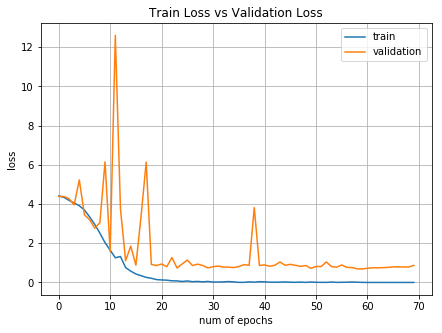

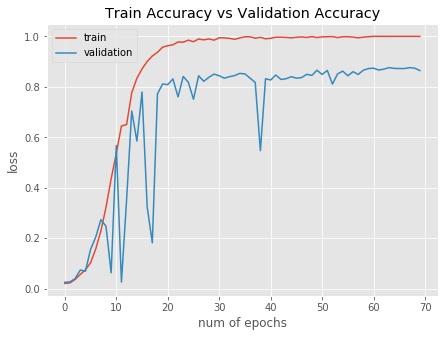

In [20]:
import matplotlib.pyplot as plt 
train_loss = trainning_result.history['loss']
validation_loss = trainning_result.history['val_loss']
train_acc = trainning_result.history['acc']
validation_acc = trainning_result.history['val_acc']
xc = range(epochs)

visualize_loss(xc, train_loss, validation_loss)
visualize_acc(xc, train_acc, validation_acc)

#### ResNet50

In [16]:
from keras.applications.resnet50 import ResNet50

# pre-process the data for Keras
train_tensors_224 = paths_to_tensor(train_files,target_size=(224,224)).astype('float32')/255
valid_tensors_224 = paths_to_tensor(valid_files,target_size=(224,224)).astype('float32')/255
test_tensors_224 = paths_to_tensor(test_files,target_size=(224,224)).astype('float32')/255

train_tensors_224 = train_tensors_224.reshape(train_tensors_224.shape[0], 224, 224, 3)
valid_tensors_224 = valid_tensors_224.reshape(valid_tensors_224.shape[0], 224, 224, 3)
test_tensors_224 = test_tensors_224.reshape(test_tensors_224.shape[0], 224, 224, 3)



100%|██████████████████████████████████████| 1388/1388 [00:36<00:00, 37.78it/s]


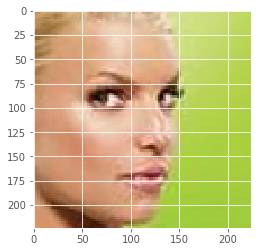

In [17]:
import matplotlib.pyplot as plt                        
img = train_tensors_224[0]
plt.imshow(img,cmap='gray')
plt.show()

In [31]:
resnet_model = ResNet50(input_tensor=Input(shape=(224,224,3)), include_top=False, weights='imagenet')
resnet_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

                                                                 activation_68[0][0]              
__________________________________________________________________________________________________
activation_71 (Activation)      (None, 28, 28, 512)  0           add_23[0][0]                     
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 14, 14, 256)  131328      activation_71[0][0]              
__________________________________________________________________________________________________
bn4a_branch2a (BatchNormalizati (None, 14, 14, 256)  1024        res4a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_72 (Activation)      (None, 14, 14, 256)  0           bn4a_branch2a[0][0]              
__________________________________________________________________________________________________
res4a_bran

__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 7, 7, 512)    2359808     activation_93[0][0]              
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 7, 7, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 7, 7, 512)    0           bn5b_branch2b[0][0]              
__________________________________________________________________________________________________
res5b_branch2c (Conv2D)         (None, 7, 7, 2048)   1050624     activation_94[0][0]              
__________________________________________________________________________________________________
bn5b_branch2c (BatchNormalizati (None, 7, 7, 2048)   8192        res5b_branch2c[0][0]             
__________

In [32]:
from keras.layers import GlobalAveragePooling2D

last_layer = resnet_model.get_layer('avg_pool').output

custom_layer = Conv2D(filters=32, kernel_size=4, padding='same', activation='relu')(last_layer)
# custom_layer = Conv2D(filters=64, kernel_size=4, padding='same', activation='relu')(custom_layer)
# custom_layer = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(custom_layer)
custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

custom_layer = Conv2D(filters=64, kernel_size=4, padding='same', activation='relu')(last_layer)
custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

custom_layer = Conv2D(filters=128, kernel_size=4, padding='same', activation='relu')(last_layer)
custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

custom_layer = Conv2D(filters=256, kernel_size=4, padding='same', activation='relu')(last_layer)
custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

# custom_layer = Conv2D(filters=512, kernel_size=4, padding='same', activation='relu')(last_layer)
# custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)


custom_layer = Dropout(0.5)(custom_layer)

custom_layer = Flatten()(custom_layer)
custom_layer = Dense(224, activation='relu')(custom_layer)
out = Dense(83, activation='softmax')(custom_layer)



custom_restnet_model = Model(resnet_model.input, out)
custom_restnet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

                                                                 activation_68[0][0]              
__________________________________________________________________________________________________
activation_71 (Activation)      (None, 28, 28, 512)  0           add_23[0][0]                     
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 14, 14, 256)  131328      activation_71[0][0]              
__________________________________________________________________________________________________
bn4a_branch2a (BatchNormalizati (None, 14, 14, 256)  1024        res4a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_72 (Activation)      (None, 14, 14, 256)  0           bn4a_branch2a[0][0]              
__________________________________________________________________________________________________
res4a_bran

__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 7, 7, 512)    2359808     activation_93[0][0]              
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 7, 7, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 7, 7, 512)    0           bn5b_branch2b[0][0]              
__________________________________________________________________________________________________
res5b_branch2c (Conv2D)         (None, 7, 7, 2048)   1050624     activation_94[0][0]              
__________________________________________________________________________________________________
bn5b_branch2c (BatchNormalizati (None, 7, 7, 2048)   8192        res5b_branch2c[0][0]             
__________

In [27]:
#for layer in custom_restnet_model.layers[:-1]:
#    layer.trainable = False

In [33]:
custom_restnet_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [34]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.
epochs = 70

### Do NOT modify the code below this line.
tensor = TensorBoard(log_dir="logs/resnet_{}".format(time()),write_images=True,write_grads=True)
checkpointer = ModelCheckpoint(filepath='saved_models/custom_resnet50_weights.custom.model.hdf5', 
                               verbose=1, save_best_only=True)

trainning_result = custom_restnet_model.fit(train_tensors_224, train_targets, 
          validation_data=(valid_tensors_224, valid_targets),
          epochs=epochs, batch_size=10, callbacks=[checkpointer,tensor], verbose=1)

Train on 11071 samples, validate on 1364 samples
Epoch 1/70


 2030/11071 [====>.........................] - ETA: 1:03:26 - loss: 4.3905 - acc: 0.10 - ETA: 36:21 - loss: 4.9168 - acc: 0.0500 - ETA: 28:02 - loss: 4.8543 - acc: 0.03 - ETA: 23:00 - loss: 4.8410 - acc: 0.02 - ETA: 20:05 - loss: 4.7798 - acc: 0.04 - ETA: 18:01 - loss: 4.7241 - acc: 0.03 - ETA: 16:38 - loss: 4.7393 - acc: 0.02 - ETA: 15:26 - loss: 4.7034 - acc: 0.02 - ETA: 14:39 - loss: 4.6628 - acc: 0.02 - ETA: 13:53 - loss: 4.6416 - acc: 0.03 - ETA: 13:16 - loss: 4.6335 - acc: 0.02 - ETA: 12:44 - loss: 4.6098 - acc: 0.02 - ETA: 12:19 - loss: 4.6005 - acc: 0.02 - ETA: 12:00 - loss: 4.5895 - acc: 0.02 - ETA: 11:40 - loss: 4.5804 - acc: 0.02 - ETA: 11:23 - loss: 4.5673 - acc: 0.01 - ETA: 11:07 - loss: 4.5598 - acc: 0.01 - ETA: 10:53 - loss: 4.5504 - acc: 0.01 - ETA: 10:44 - loss: 4.5480 - acc: 0.01 - ETA: 10:32 - loss: 4.5457 - acc: 0.01 - ETA: 10:21 - loss: 4.5507 - acc: 0.01 - ETA: 10:12 - loss: 4.5456 - acc: 0.01 - ETA: 10:08 - loss: 4.5411 - acc: 0.01 - ETA: 10:01 - loss: 4.5370 - a

 6110/11071 [===============>..............] - ETA: 4:45 - loss: 4.4187 - acc: 0.020 - ETA: 4:45 - loss: 4.4184 - acc: 0.020 - ETA: 4:44 - loss: 4.4180 - acc: 0.020 - ETA: 4:44 - loss: 4.4175 - acc: 0.020 - ETA: 4:43 - loss: 4.4190 - acc: 0.020 - ETA: 4:43 - loss: 4.4191 - acc: 0.020 - ETA: 4:42 - loss: 4.4189 - acc: 0.020 - ETA: 4:42 - loss: 4.4188 - acc: 0.020 - ETA: 4:42 - loss: 4.4188 - acc: 0.020 - ETA: 4:41 - loss: 4.4188 - acc: 0.020 - ETA: 4:41 - loss: 4.4188 - acc: 0.020 - ETA: 4:40 - loss: 4.4186 - acc: 0.020 - ETA: 4:40 - loss: 4.4189 - acc: 0.020 - ETA: 4:39 - loss: 4.4190 - acc: 0.020 - ETA: 4:39 - loss: 4.4189 - acc: 0.020 - ETA: 4:39 - loss: 4.4191 - acc: 0.020 - ETA: 4:38 - loss: 4.4188 - acc: 0.020 - ETA: 4:38 - loss: 4.4188 - acc: 0.020 - ETA: 4:37 - loss: 4.4188 - acc: 0.020 - ETA: 4:37 - loss: 4.4183 - acc: 0.020 - ETA: 4:37 - loss: 4.4179 - acc: 0.020 - ETA: 4:36 - loss: 4.4177 - acc: 0.020 - ETA: 4:36 - loss: 4.4175 - acc: 0.020 - ETA: 4:35 - loss: 4.4179 - acc: 0

 8150/11071 [=====================>........] - ETA: 3:20 - loss: 4.4062 - acc: 0.023 - ETA: 3:19 - loss: 4.4058 - acc: 0.023 - ETA: 3:19 - loss: 4.4053 - acc: 0.023 - ETA: 3:18 - loss: 4.4052 - acc: 0.023 - ETA: 3:18 - loss: 4.4052 - acc: 0.023 - ETA: 3:18 - loss: 4.4046 - acc: 0.023 - ETA: 3:17 - loss: 4.4049 - acc: 0.023 - ETA: 3:17 - loss: 4.4058 - acc: 0.023 - ETA: 3:16 - loss: 4.4061 - acc: 0.023 - ETA: 3:16 - loss: 4.4060 - acc: 0.023 - ETA: 3:16 - loss: 4.4059 - acc: 0.023 - ETA: 3:15 - loss: 4.4061 - acc: 0.023 - ETA: 3:15 - loss: 4.4061 - acc: 0.023 - ETA: 3:14 - loss: 4.4059 - acc: 0.023 - ETA: 3:14 - loss: 4.4058 - acc: 0.023 - ETA: 3:14 - loss: 4.4059 - acc: 0.023 - ETA: 3:13 - loss: 4.4057 - acc: 0.023 - ETA: 3:13 - loss: 4.4056 - acc: 0.023 - ETA: 3:12 - loss: 4.4055 - acc: 0.024 - ETA: 3:12 - loss: 4.4055 - acc: 0.024 - ETA: 3:11 - loss: 4.4053 - acc: 0.024 - ETA: 3:11 - loss: 4.4050 - acc: 0.024 - ETA: 3:11 - loss: 4.4052 - acc: 0.024 - ETA: 3:10 - loss: 4.4053 - acc: 0

10220/11071 [==========================>...] - ETA: 1:57 - loss: 4.3912 - acc: 0.024 - ETA: 1:56 - loss: 4.3911 - acc: 0.024 - ETA: 1:56 - loss: 4.3912 - acc: 0.024 - ETA: 1:55 - loss: 4.3909 - acc: 0.024 - ETA: 1:55 - loss: 4.3908 - acc: 0.024 - ETA: 1:55 - loss: 4.3906 - acc: 0.024 - ETA: 1:54 - loss: 4.3904 - acc: 0.024 - ETA: 1:54 - loss: 4.3902 - acc: 0.024 - ETA: 1:53 - loss: 4.3899 - acc: 0.024 - ETA: 1:53 - loss: 4.3899 - acc: 0.024 - ETA: 1:53 - loss: 4.3897 - acc: 0.024 - ETA: 1:52 - loss: 4.3897 - acc: 0.024 - ETA: 1:52 - loss: 4.3895 - acc: 0.024 - ETA: 1:51 - loss: 4.3890 - acc: 0.024 - ETA: 1:51 - loss: 4.3887 - acc: 0.024 - ETA: 1:51 - loss: 4.3886 - acc: 0.024 - ETA: 1:50 - loss: 4.3886 - acc: 0.024 - ETA: 1:50 - loss: 4.3885 - acc: 0.024 - ETA: 1:49 - loss: 4.3880 - acc: 0.024 - ETA: 1:49 - loss: 4.3881 - acc: 0.024 - ETA: 1:49 - loss: 4.3882 - acc: 0.024 - ETA: 1:48 - loss: 4.3880 - acc: 0.024 - ETA: 1:48 - loss: 4.3880 - acc: 0.024 - ETA: 1:47 - loss: 4.3880 - acc: 0

11071/11071 [==============================] - 477s 43ms/step - loss: 4.3640 - acc: 0.0261 - val_loss: 4.4033 - val_acc: 0.0220
Epoch 2/70


 2040/11071 [====>.........................] - ETA: 7:01 - loss: 4.3562 - acc: 0.0000e+0 - ETA: 7:08 - loss: 4.3598 - acc: 0.0000e+0 - ETA: 7:14 - loss: 4.2885 - acc: 0.0333    - ETA: 7:14 - loss: 4.3613 - acc: 0.025 - ETA: 7:14 - loss: 4.3653 - acc: 0.020 - ETA: 7:13 - loss: 4.3413 - acc: 0.016 - ETA: 7:15 - loss: 4.3130 - acc: 0.042 - ETA: 7:15 - loss: 4.3117 - acc: 0.037 - ETA: 7:14 - loss: 4.2949 - acc: 0.033 - ETA: 7:15 - loss: 4.2991 - acc: 0.030 - ETA: 7:14 - loss: 4.2762 - acc: 0.036 - ETA: 7:14 - loss: 4.2932 - acc: 0.033 - ETA: 7:13 - loss: 4.2835 - acc: 0.030 - ETA: 7:13 - loss: 4.2820 - acc: 0.028 - ETA: 7:13 - loss: 4.2895 - acc: 0.033 - ETA: 7:12 - loss: 4.2994 - acc: 0.031 - ETA: 7:12 - loss: 4.2933 - acc: 0.029 - ETA: 7:12 - loss: 4.2949 - acc: 0.027 - ETA: 7:12 - loss: 4.2826 - acc: 0.026 - ETA: 7:11 - loss: 4.2775 - acc: 0.040 - ETA: 7:11 - loss: 4.2845 - acc: 0.038 - ETA: 7:11 - loss: 4.2873 - acc: 0.036 - ETA: 7:10 - loss: 4.2825 - acc: 0.039 - ETA: 7:09 - loss: 4.2

 6120/11071 [===============>..............] - ETA: 4:37 - loss: 4.2135 - acc: 0.032 - ETA: 4:36 - loss: 4.2130 - acc: 0.032 - ETA: 4:36 - loss: 4.2133 - acc: 0.032 - ETA: 4:36 - loss: 4.2132 - acc: 0.032 - ETA: 4:35 - loss: 4.2135 - acc: 0.032 - ETA: 4:35 - loss: 4.2133 - acc: 0.032 - ETA: 4:34 - loss: 4.2127 - acc: 0.032 - ETA: 4:34 - loss: 4.2125 - acc: 0.032 - ETA: 4:33 - loss: 4.2130 - acc: 0.032 - ETA: 4:33 - loss: 4.2134 - acc: 0.032 - ETA: 4:33 - loss: 4.2132 - acc: 0.032 - ETA: 4:32 - loss: 4.2131 - acc: 0.032 - ETA: 4:32 - loss: 4.2132 - acc: 0.032 - ETA: 4:31 - loss: 4.2129 - acc: 0.032 - ETA: 4:31 - loss: 4.2125 - acc: 0.032 - ETA: 4:31 - loss: 4.2146 - acc: 0.032 - ETA: 4:30 - loss: 4.2143 - acc: 0.032 - ETA: 4:30 - loss: 4.2145 - acc: 0.032 - ETA: 4:30 - loss: 4.2144 - acc: 0.032 - ETA: 4:29 - loss: 4.2139 - acc: 0.032 - ETA: 4:29 - loss: 4.2136 - acc: 0.032 - ETA: 4:28 - loss: 4.2140 - acc: 0.032 - ETA: 4:28 - loss: 4.2137 - acc: 0.032 - ETA: 4:28 - loss: 4.2141 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:16 - loss: 4.2012 - acc: 0.032 - ETA: 3:15 - loss: 4.2005 - acc: 0.032 - ETA: 3:15 - loss: 4.2004 - acc: 0.032 - ETA: 3:14 - loss: 4.2002 - acc: 0.032 - ETA: 3:14 - loss: 4.1997 - acc: 0.032 - ETA: 3:14 - loss: 4.1986 - acc: 0.032 - ETA: 3:13 - loss: 4.1983 - acc: 0.032 - ETA: 3:13 - loss: 4.1977 - acc: 0.032 - ETA: 3:12 - loss: 4.1973 - acc: 0.032 - ETA: 3:12 - loss: 4.1971 - acc: 0.032 - ETA: 3:12 - loss: 4.1968 - acc: 0.032 - ETA: 3:11 - loss: 4.1974 - acc: 0.032 - ETA: 3:11 - loss: 4.1974 - acc: 0.032 - ETA: 3:10 - loss: 4.1981 - acc: 0.032 - ETA: 3:10 - loss: 4.1986 - acc: 0.032 - ETA: 3:10 - loss: 4.1983 - acc: 0.032 - ETA: 3:09 - loss: 4.1981 - acc: 0.032 - ETA: 3:09 - loss: 4.1979 - acc: 0.032 - ETA: 3:08 - loss: 4.1982 - acc: 0.032 - ETA: 3:08 - loss: 4.1978 - acc: 0.032 - ETA: 3:08 - loss: 4.1978 - acc: 0.032 - ETA: 3:07 - loss: 4.1979 - acc: 0.032 - ETA: 3:07 - loss: 4.1981 - acc: 0.032 - ETA: 3:06 - loss: 4.1981 - acc: 0

10230/11071 [==========================>...] - ETA: 1:55 - loss: 4.1849 - acc: 0.033 - ETA: 1:54 - loss: 4.1850 - acc: 0.033 - ETA: 1:54 - loss: 4.1850 - acc: 0.033 - ETA: 1:53 - loss: 4.1851 - acc: 0.033 - ETA: 1:53 - loss: 4.1851 - acc: 0.033 - ETA: 1:53 - loss: 4.1851 - acc: 0.033 - ETA: 1:52 - loss: 4.1849 - acc: 0.033 - ETA: 1:52 - loss: 4.1847 - acc: 0.033 - ETA: 1:51 - loss: 4.1842 - acc: 0.033 - ETA: 1:51 - loss: 4.1843 - acc: 0.034 - ETA: 1:51 - loss: 4.1845 - acc: 0.034 - ETA: 1:50 - loss: 4.1847 - acc: 0.034 - ETA: 1:50 - loss: 4.1847 - acc: 0.034 - ETA: 1:49 - loss: 4.1849 - acc: 0.034 - ETA: 1:49 - loss: 4.1845 - acc: 0.034 - ETA: 1:49 - loss: 4.1846 - acc: 0.034 - ETA: 1:48 - loss: 4.1843 - acc: 0.034 - ETA: 1:48 - loss: 4.1844 - acc: 0.034 - ETA: 1:47 - loss: 4.1841 - acc: 0.034 - ETA: 1:47 - loss: 4.1839 - acc: 0.034 - ETA: 1:47 - loss: 4.1837 - acc: 0.034 - ETA: 1:46 - loss: 4.1838 - acc: 0.034 - ETA: 1:46 - loss: 4.1837 - acc: 0.034 - ETA: 1:46 - loss: 4.1836 - acc: 0

11071/11071 [==============================] - 461s 42ms/step - loss: 4.1624 - acc: 0.0336 - val_loss: 4.2253 - val_acc: 0.0293
Epoch 3/70


 2040/11071 [====>.........................] - ETA: 7:18 - loss: 4.0546 - acc: 0.0000e+0 - ETA: 7:16 - loss: 3.9882 - acc: 0.1000    - ETA: 7:17 - loss: 3.9786 - acc: 0.066 - ETA: 7:18 - loss: 3.9959 - acc: 0.050 - ETA: 7:18 - loss: 4.0069 - acc: 0.060 - ETA: 7:18 - loss: 4.0240 - acc: 0.050 - ETA: 7:18 - loss: 4.0246 - acc: 0.042 - ETA: 7:17 - loss: 3.9957 - acc: 0.037 - ETA: 7:16 - loss: 4.0383 - acc: 0.033 - ETA: 7:15 - loss: 4.0434 - acc: 0.030 - ETA: 7:15 - loss: 4.0574 - acc: 0.027 - ETA: 7:14 - loss: 4.0739 - acc: 0.033 - ETA: 7:16 - loss: 4.0813 - acc: 0.030 - ETA: 7:15 - loss: 4.0871 - acc: 0.035 - ETA: 7:14 - loss: 4.0852 - acc: 0.033 - ETA: 7:14 - loss: 4.0872 - acc: 0.037 - ETA: 7:13 - loss: 4.0751 - acc: 0.035 - ETA: 7:13 - loss: 4.0737 - acc: 0.038 - ETA: 7:13 - loss: 4.0921 - acc: 0.036 - ETA: 7:12 - loss: 4.0857 - acc: 0.040 - ETA: 7:12 - loss: 4.0907 - acc: 0.038 - ETA: 7:12 - loss: 4.0988 - acc: 0.036 - ETA: 7:11 - loss: 4.0837 - acc: 0.034 - ETA: 7:10 - loss: 4.0800 

 6120/11071 [===============>..............] - ETA: 4:36 - loss: 4.0040 - acc: 0.042 - ETA: 4:36 - loss: 4.0042 - acc: 0.042 - ETA: 4:36 - loss: 4.0047 - acc: 0.042 - ETA: 4:35 - loss: 4.0048 - acc: 0.042 - ETA: 4:35 - loss: 4.0053 - acc: 0.042 - ETA: 4:34 - loss: 4.0057 - acc: 0.042 - ETA: 4:34 - loss: 4.0053 - acc: 0.042 - ETA: 4:34 - loss: 4.0053 - acc: 0.042 - ETA: 4:33 - loss: 4.0046 - acc: 0.042 - ETA: 4:33 - loss: 4.0048 - acc: 0.042 - ETA: 4:32 - loss: 4.0052 - acc: 0.042 - ETA: 4:32 - loss: 4.0043 - acc: 0.042 - ETA: 4:32 - loss: 4.0036 - acc: 0.042 - ETA: 4:31 - loss: 4.0036 - acc: 0.042 - ETA: 4:31 - loss: 4.0042 - acc: 0.042 - ETA: 4:30 - loss: 4.0050 - acc: 0.042 - ETA: 4:30 - loss: 4.0051 - acc: 0.042 - ETA: 4:30 - loss: 4.0054 - acc: 0.042 - ETA: 4:29 - loss: 4.0047 - acc: 0.042 - ETA: 4:29 - loss: 4.0042 - acc: 0.042 - ETA: 4:28 - loss: 4.0041 - acc: 0.042 - ETA: 4:28 - loss: 4.0043 - acc: 0.042 - ETA: 4:28 - loss: 4.0044 - acc: 0.042 - ETA: 4:27 - loss: 4.0039 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:15 - loss: 3.9794 - acc: 0.045 - ETA: 3:15 - loss: 3.9794 - acc: 0.045 - ETA: 3:15 - loss: 3.9794 - acc: 0.045 - ETA: 3:14 - loss: 3.9793 - acc: 0.045 - ETA: 3:14 - loss: 3.9793 - acc: 0.045 - ETA: 3:13 - loss: 3.9789 - acc: 0.045 - ETA: 3:13 - loss: 3.9787 - acc: 0.045 - ETA: 3:13 - loss: 3.9785 - acc: 0.046 - ETA: 3:12 - loss: 3.9785 - acc: 0.045 - ETA: 3:12 - loss: 3.9786 - acc: 0.045 - ETA: 3:12 - loss: 3.9783 - acc: 0.045 - ETA: 3:11 - loss: 3.9785 - acc: 0.045 - ETA: 3:11 - loss: 3.9781 - acc: 0.045 - ETA: 3:10 - loss: 3.9781 - acc: 0.045 - ETA: 3:10 - loss: 3.9772 - acc: 0.045 - ETA: 3:10 - loss: 3.9769 - acc: 0.046 - ETA: 3:09 - loss: 3.9767 - acc: 0.046 - ETA: 3:09 - loss: 3.9765 - acc: 0.046 - ETA: 3:08 - loss: 3.9771 - acc: 0.046 - ETA: 3:08 - loss: 3.9772 - acc: 0.046 - ETA: 3:08 - loss: 3.9775 - acc: 0.046 - ETA: 3:07 - loss: 3.9779 - acc: 0.046 - ETA: 3:07 - loss: 3.9775 - acc: 0.046 - ETA: 3:06 - loss: 3.9769 - acc: 0

10240/11071 [==========================>...] - ETA: 1:55 - loss: 3.9490 - acc: 0.049 - ETA: 1:54 - loss: 3.9489 - acc: 0.050 - ETA: 1:54 - loss: 3.9486 - acc: 0.050 - ETA: 1:53 - loss: 3.9489 - acc: 0.050 - ETA: 1:53 - loss: 3.9487 - acc: 0.049 - ETA: 1:53 - loss: 3.9495 - acc: 0.049 - ETA: 1:52 - loss: 3.9493 - acc: 0.049 - ETA: 1:52 - loss: 3.9493 - acc: 0.049 - ETA: 1:51 - loss: 3.9493 - acc: 0.049 - ETA: 1:51 - loss: 3.9489 - acc: 0.050 - ETA: 1:51 - loss: 3.9485 - acc: 0.050 - ETA: 1:50 - loss: 3.9488 - acc: 0.050 - ETA: 1:50 - loss: 3.9490 - acc: 0.049 - ETA: 1:49 - loss: 3.9492 - acc: 0.050 - ETA: 1:49 - loss: 3.9491 - acc: 0.049 - ETA: 1:49 - loss: 3.9490 - acc: 0.049 - ETA: 1:48 - loss: 3.9487 - acc: 0.049 - ETA: 1:48 - loss: 3.9485 - acc: 0.049 - ETA: 1:47 - loss: 3.9483 - acc: 0.050 - ETA: 1:47 - loss: 3.9478 - acc: 0.050 - ETA: 1:47 - loss: 3.9472 - acc: 0.050 - ETA: 1:46 - loss: 3.9467 - acc: 0.050 - ETA: 1:46 - loss: 3.9470 - acc: 0.050 - ETA: 1:45 - loss: 3.9467 - acc: 0

11071/11071 [==============================] - 457s 41ms/step - loss: 3.9154 - acc: 0.0534 - val_loss: 4.3654 - val_acc: 0.0403
Epoch 4/70


 2040/11071 [====>.........................] - ETA: 7:11 - loss: 3.5300 - acc: 0.100 - ETA: 7:14 - loss: 3.6472 - acc: 0.050 - ETA: 7:15 - loss: 3.5711 - acc: 0.066 - ETA: 7:16 - loss: 3.5654 - acc: 0.050 - ETA: 7:17 - loss: 3.6706 - acc: 0.040 - ETA: 7:17 - loss: 3.6389 - acc: 0.066 - ETA: 7:17 - loss: 3.5939 - acc: 0.071 - ETA: 7:15 - loss: 3.6108 - acc: 0.062 - ETA: 7:15 - loss: 3.5804 - acc: 0.055 - ETA: 7:14 - loss: 3.5846 - acc: 0.050 - ETA: 7:13 - loss: 3.6389 - acc: 0.045 - ETA: 7:13 - loss: 3.6716 - acc: 0.041 - ETA: 7:13 - loss: 3.7039 - acc: 0.038 - ETA: 7:13 - loss: 3.6944 - acc: 0.042 - ETA: 7:12 - loss: 3.7004 - acc: 0.046 - ETA: 7:12 - loss: 3.6881 - acc: 0.056 - ETA: 7:12 - loss: 3.6795 - acc: 0.052 - ETA: 7:11 - loss: 3.6918 - acc: 0.055 - ETA: 7:11 - loss: 3.6886 - acc: 0.057 - ETA: 7:11 - loss: 3.7153 - acc: 0.055 - ETA: 7:11 - loss: 3.7330 - acc: 0.057 - ETA: 7:10 - loss: 3.7116 - acc: 0.059 - ETA: 7:10 - loss: 3.7086 - acc: 0.056 - ETA: 7:09 - loss: 3.7302 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:36 - loss: 3.7524 - acc: 0.062 - ETA: 4:36 - loss: 3.7531 - acc: 0.062 - ETA: 4:36 - loss: 3.7532 - acc: 0.061 - ETA: 4:35 - loss: 3.7527 - acc: 0.061 - ETA: 4:35 - loss: 3.7533 - acc: 0.062 - ETA: 4:34 - loss: 3.7532 - acc: 0.061 - ETA: 4:34 - loss: 3.7530 - acc: 0.061 - ETA: 4:34 - loss: 3.7531 - acc: 0.061 - ETA: 4:33 - loss: 3.7531 - acc: 0.061 - ETA: 4:33 - loss: 3.7532 - acc: 0.061 - ETA: 4:32 - loss: 3.7546 - acc: 0.061 - ETA: 4:32 - loss: 3.7546 - acc: 0.061 - ETA: 4:32 - loss: 3.7539 - acc: 0.061 - ETA: 4:31 - loss: 3.7535 - acc: 0.061 - ETA: 4:31 - loss: 3.7533 - acc: 0.061 - ETA: 4:30 - loss: 3.7523 - acc: 0.061 - ETA: 4:30 - loss: 3.7523 - acc: 0.061 - ETA: 4:30 - loss: 3.7513 - acc: 0.062 - ETA: 4:29 - loss: 3.7528 - acc: 0.061 - ETA: 4:29 - loss: 3.7526 - acc: 0.061 - ETA: 4:28 - loss: 3.7522 - acc: 0.061 - ETA: 4:28 - loss: 3.7510 - acc: 0.062 - ETA: 4:28 - loss: 3.7505 - acc: 0.061 - ETA: 4:27 - loss: 3.7493 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:16 - loss: 3.7357 - acc: 0.060 - ETA: 3:15 - loss: 3.7355 - acc: 0.060 - ETA: 3:15 - loss: 3.7343 - acc: 0.061 - ETA: 3:14 - loss: 3.7348 - acc: 0.061 - ETA: 3:14 - loss: 3.7354 - acc: 0.061 - ETA: 3:14 - loss: 3.7344 - acc: 0.061 - ETA: 3:13 - loss: 3.7344 - acc: 0.061 - ETA: 3:13 - loss: 3.7341 - acc: 0.061 - ETA: 3:12 - loss: 3.7338 - acc: 0.061 - ETA: 3:12 - loss: 3.7336 - acc: 0.061 - ETA: 3:12 - loss: 3.7336 - acc: 0.061 - ETA: 3:11 - loss: 3.7344 - acc: 0.061 - ETA: 3:11 - loss: 3.7346 - acc: 0.061 - ETA: 3:10 - loss: 3.7350 - acc: 0.061 - ETA: 3:10 - loss: 3.7349 - acc: 0.061 - ETA: 3:10 - loss: 3.7347 - acc: 0.061 - ETA: 3:09 - loss: 3.7342 - acc: 0.061 - ETA: 3:09 - loss: 3.7341 - acc: 0.061 - ETA: 3:08 - loss: 3.7335 - acc: 0.061 - ETA: 3:08 - loss: 3.7327 - acc: 0.061 - ETA: 3:08 - loss: 3.7315 - acc: 0.061 - ETA: 3:07 - loss: 3.7313 - acc: 0.062 - ETA: 3:07 - loss: 3.7316 - acc: 0.061 - ETA: 3:06 - loss: 3.7317 - acc: 0

10230/11071 [==========================>...] - ETA: 1:55 - loss: 3.7239 - acc: 0.062 - ETA: 1:55 - loss: 3.7241 - acc: 0.062 - ETA: 1:54 - loss: 3.7248 - acc: 0.062 - ETA: 1:54 - loss: 3.7259 - acc: 0.062 - ETA: 1:54 - loss: 3.7260 - acc: 0.062 - ETA: 1:53 - loss: 3.7260 - acc: 0.062 - ETA: 1:53 - loss: 3.7258 - acc: 0.062 - ETA: 1:53 - loss: 3.7262 - acc: 0.062 - ETA: 1:52 - loss: 3.7258 - acc: 0.063 - ETA: 1:52 - loss: 3.7260 - acc: 0.063 - ETA: 1:51 - loss: 3.7258 - acc: 0.063 - ETA: 1:51 - loss: 3.7255 - acc: 0.063 - ETA: 1:51 - loss: 3.7252 - acc: 0.063 - ETA: 1:50 - loss: 3.7248 - acc: 0.063 - ETA: 1:50 - loss: 3.7244 - acc: 0.063 - ETA: 1:49 - loss: 3.7241 - acc: 0.063 - ETA: 1:49 - loss: 3.7239 - acc: 0.063 - ETA: 1:49 - loss: 3.7241 - acc: 0.063 - ETA: 1:48 - loss: 3.7239 - acc: 0.063 - ETA: 1:48 - loss: 3.7243 - acc: 0.063 - ETA: 1:47 - loss: 3.7238 - acc: 0.063 - ETA: 1:47 - loss: 3.7236 - acc: 0.063 - ETA: 1:47 - loss: 3.7236 - acc: 0.063 - ETA: 1:46 - loss: 3.7235 - acc: 0

11071/11071 [==============================] - 460s 42ms/step - loss: 3.6983 - acc: 0.0685 - val_loss: 3.7635 - val_acc: 0.0777
Epoch 5/70


 2040/11071 [====>.........................] - ETA: 7:06 - loss: 3.3063 - acc: 0.200 - ETA: 7:15 - loss: 3.7258 - acc: 0.100 - ETA: 7:14 - loss: 3.7902 - acc: 0.100 - ETA: 7:13 - loss: 3.7260 - acc: 0.100 - ETA: 7:12 - loss: 3.6751 - acc: 0.080 - ETA: 7:11 - loss: 3.7701 - acc: 0.066 - ETA: 7:11 - loss: 3.7137 - acc: 0.057 - ETA: 7:10 - loss: 3.6650 - acc: 0.062 - ETA: 7:11 - loss: 3.6292 - acc: 0.066 - ETA: 7:10 - loss: 3.5912 - acc: 0.070 - ETA: 7:10 - loss: 3.5870 - acc: 0.063 - ETA: 7:10 - loss: 3.5674 - acc: 0.083 - ETA: 7:10 - loss: 3.6097 - acc: 0.084 - ETA: 7:09 - loss: 3.6084 - acc: 0.085 - ETA: 7:10 - loss: 3.6418 - acc: 0.080 - ETA: 7:09 - loss: 3.6611 - acc: 0.075 - ETA: 7:10 - loss: 3.6447 - acc: 0.070 - ETA: 7:10 - loss: 3.6200 - acc: 0.072 - ETA: 7:09 - loss: 3.6122 - acc: 0.078 - ETA: 7:08 - loss: 3.5815 - acc: 0.085 - ETA: 7:09 - loss: 3.6221 - acc: 0.090 - ETA: 7:08 - loss: 3.6210 - acc: 0.090 - ETA: 7:08 - loss: 3.6259 - acc: 0.091 - ETA: 7:08 - loss: 3.6383 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:37 - loss: 3.5852 - acc: 0.084 - ETA: 4:36 - loss: 3.5861 - acc: 0.083 - ETA: 4:36 - loss: 3.5861 - acc: 0.083 - ETA: 4:36 - loss: 3.5863 - acc: 0.083 - ETA: 4:35 - loss: 3.5874 - acc: 0.083 - ETA: 4:35 - loss: 3.5878 - acc: 0.083 - ETA: 4:34 - loss: 3.5868 - acc: 0.083 - ETA: 4:34 - loss: 3.5872 - acc: 0.083 - ETA: 4:34 - loss: 3.5877 - acc: 0.083 - ETA: 4:33 - loss: 3.5880 - acc: 0.083 - ETA: 4:33 - loss: 3.5872 - acc: 0.083 - ETA: 4:32 - loss: 3.5869 - acc: 0.083 - ETA: 4:32 - loss: 3.5861 - acc: 0.083 - ETA: 4:32 - loss: 3.5858 - acc: 0.083 - ETA: 4:31 - loss: 3.5853 - acc: 0.084 - ETA: 4:31 - loss: 3.5858 - acc: 0.084 - ETA: 4:30 - loss: 3.5865 - acc: 0.083 - ETA: 4:30 - loss: 3.5868 - acc: 0.083 - ETA: 4:30 - loss: 3.5866 - acc: 0.083 - ETA: 4:29 - loss: 3.5882 - acc: 0.083 - ETA: 4:29 - loss: 3.5880 - acc: 0.083 - ETA: 4:28 - loss: 3.5889 - acc: 0.083 - ETA: 4:28 - loss: 3.5884 - acc: 0.083 - ETA: 4:28 - loss: 3.5880 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:16 - loss: 3.5809 - acc: 0.083 - ETA: 3:15 - loss: 3.5803 - acc: 0.083 - ETA: 3:15 - loss: 3.5797 - acc: 0.084 - ETA: 3:14 - loss: 3.5787 - acc: 0.083 - ETA: 3:14 - loss: 3.5778 - acc: 0.084 - ETA: 3:14 - loss: 3.5779 - acc: 0.083 - ETA: 3:13 - loss: 3.5774 - acc: 0.083 - ETA: 3:13 - loss: 3.5775 - acc: 0.083 - ETA: 3:12 - loss: 3.5773 - acc: 0.083 - ETA: 3:12 - loss: 3.5773 - acc: 0.083 - ETA: 3:12 - loss: 3.5772 - acc: 0.083 - ETA: 3:11 - loss: 3.5784 - acc: 0.083 - ETA: 3:11 - loss: 3.5786 - acc: 0.083 - ETA: 3:10 - loss: 3.5785 - acc: 0.083 - ETA: 3:10 - loss: 3.5790 - acc: 0.084 - ETA: 3:10 - loss: 3.5788 - acc: 0.084 - ETA: 3:09 - loss: 3.5790 - acc: 0.084 - ETA: 3:09 - loss: 3.5786 - acc: 0.084 - ETA: 3:08 - loss: 3.5790 - acc: 0.084 - ETA: 3:08 - loss: 3.5788 - acc: 0.084 - ETA: 3:08 - loss: 3.5786 - acc: 0.083 - ETA: 3:07 - loss: 3.5783 - acc: 0.083 - ETA: 3:07 - loss: 3.5786 - acc: 0.084 - ETA: 3:07 - loss: 3.5783 - acc: 0

10240/11071 [==========================>...] - ETA: 1:55 - loss: 3.5655 - acc: 0.084 - ETA: 1:54 - loss: 3.5657 - acc: 0.084 - ETA: 1:54 - loss: 3.5666 - acc: 0.084 - ETA: 1:53 - loss: 3.5667 - acc: 0.083 - ETA: 1:53 - loss: 3.5660 - acc: 0.084 - ETA: 1:53 - loss: 3.5657 - acc: 0.084 - ETA: 1:52 - loss: 3.5649 - acc: 0.084 - ETA: 1:52 - loss: 3.5645 - acc: 0.084 - ETA: 1:51 - loss: 3.5645 - acc: 0.084 - ETA: 1:51 - loss: 3.5651 - acc: 0.084 - ETA: 1:51 - loss: 3.5650 - acc: 0.084 - ETA: 1:50 - loss: 3.5649 - acc: 0.084 - ETA: 1:50 - loss: 3.5654 - acc: 0.084 - ETA: 1:49 - loss: 3.5655 - acc: 0.084 - ETA: 1:49 - loss: 3.5656 - acc: 0.083 - ETA: 1:49 - loss: 3.5663 - acc: 0.083 - ETA: 1:48 - loss: 3.5658 - acc: 0.083 - ETA: 1:48 - loss: 3.5659 - acc: 0.083 - ETA: 1:47 - loss: 3.5658 - acc: 0.083 - ETA: 1:47 - loss: 3.5665 - acc: 0.083 - ETA: 1:47 - loss: 3.5667 - acc: 0.083 - ETA: 1:46 - loss: 3.5664 - acc: 0.083 - ETA: 1:46 - loss: 3.5666 - acc: 0.083 - ETA: 1:46 - loss: 3.5665 - acc: 0

11071/11071 [==============================] - 457s 41ms/step - loss: 3.5475 - acc: 0.0873 - val_loss: 6.5988 - val_acc: 0.0286
Epoch 6/70


 2040/11071 [====>.........................] - ETA: 7:08 - loss: 3.3313 - acc: 0.100 - ETA: 7:13 - loss: 3.5126 - acc: 0.050 - ETA: 7:14 - loss: 3.4727 - acc: 0.066 - ETA: 7:15 - loss: 3.5978 - acc: 0.050 - ETA: 7:16 - loss: 3.5507 - acc: 0.060 - ETA: 7:15 - loss: 3.6002 - acc: 0.066 - ETA: 7:15 - loss: 3.5680 - acc: 0.071 - ETA: 7:16 - loss: 3.5529 - acc: 0.062 - ETA: 7:15 - loss: 3.4764 - acc: 0.077 - ETA: 7:14 - loss: 3.4846 - acc: 0.080 - ETA: 7:13 - loss: 3.4701 - acc: 0.072 - ETA: 7:13 - loss: 3.4932 - acc: 0.075 - ETA: 7:13 - loss: 3.4947 - acc: 0.076 - ETA: 7:13 - loss: 3.5229 - acc: 0.078 - ETA: 7:12 - loss: 3.5821 - acc: 0.080 - ETA: 7:12 - loss: 3.5685 - acc: 0.087 - ETA: 7:11 - loss: 3.5777 - acc: 0.082 - ETA: 7:11 - loss: 3.5625 - acc: 0.077 - ETA: 7:10 - loss: 3.5591 - acc: 0.084 - ETA: 7:10 - loss: 3.5512 - acc: 0.090 - ETA: 7:09 - loss: 3.5479 - acc: 0.090 - ETA: 7:10 - loss: 3.5318 - acc: 0.095 - ETA: 7:09 - loss: 3.5248 - acc: 0.091 - ETA: 7:09 - loss: 3.5175 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:36 - loss: 3.4486 - acc: 0.097 - ETA: 4:36 - loss: 3.4488 - acc: 0.096 - ETA: 4:36 - loss: 3.4479 - acc: 0.097 - ETA: 4:35 - loss: 3.4469 - acc: 0.097 - ETA: 4:35 - loss: 3.4476 - acc: 0.097 - ETA: 4:34 - loss: 3.4490 - acc: 0.097 - ETA: 4:34 - loss: 3.4490 - acc: 0.097 - ETA: 4:34 - loss: 3.4487 - acc: 0.097 - ETA: 4:33 - loss: 3.4490 - acc: 0.097 - ETA: 4:33 - loss: 3.4488 - acc: 0.097 - ETA: 4:32 - loss: 3.4490 - acc: 0.097 - ETA: 4:32 - loss: 3.4486 - acc: 0.097 - ETA: 4:32 - loss: 3.4491 - acc: 0.096 - ETA: 4:31 - loss: 3.4512 - acc: 0.096 - ETA: 4:31 - loss: 3.4514 - acc: 0.097 - ETA: 4:30 - loss: 3.4526 - acc: 0.096 - ETA: 4:30 - loss: 3.4513 - acc: 0.097 - ETA: 4:30 - loss: 3.4503 - acc: 0.097 - ETA: 4:29 - loss: 3.4510 - acc: 0.097 - ETA: 4:29 - loss: 3.4507 - acc: 0.097 - ETA: 4:28 - loss: 3.4503 - acc: 0.097 - ETA: 4:28 - loss: 3.4497 - acc: 0.097 - ETA: 4:28 - loss: 3.4496 - acc: 0.097 - ETA: 4:27 - loss: 3.4488 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:15 - loss: 3.4442 - acc: 0.097 - ETA: 3:15 - loss: 3.4447 - acc: 0.097 - ETA: 3:15 - loss: 3.4442 - acc: 0.097 - ETA: 3:14 - loss: 3.4436 - acc: 0.097 - ETA: 3:14 - loss: 3.4436 - acc: 0.097 - ETA: 3:14 - loss: 3.4435 - acc: 0.097 - ETA: 3:13 - loss: 3.4429 - acc: 0.097 - ETA: 3:13 - loss: 3.4424 - acc: 0.097 - ETA: 3:12 - loss: 3.4421 - acc: 0.097 - ETA: 3:12 - loss: 3.4416 - acc: 0.097 - ETA: 3:12 - loss: 3.4413 - acc: 0.097 - ETA: 3:11 - loss: 3.4405 - acc: 0.097 - ETA: 3:11 - loss: 3.4396 - acc: 0.097 - ETA: 3:10 - loss: 3.4392 - acc: 0.098 - ETA: 3:10 - loss: 3.4388 - acc: 0.098 - ETA: 3:10 - loss: 3.4394 - acc: 0.098 - ETA: 3:09 - loss: 3.4393 - acc: 0.097 - ETA: 3:09 - loss: 3.4386 - acc: 0.098 - ETA: 3:08 - loss: 3.4388 - acc: 0.098 - ETA: 3:08 - loss: 3.4384 - acc: 0.098 - ETA: 3:08 - loss: 3.4380 - acc: 0.098 - ETA: 3:07 - loss: 3.4374 - acc: 0.098 - ETA: 3:07 - loss: 3.4381 - acc: 0.098 - ETA: 3:06 - loss: 3.4387 - acc: 0

10240/11071 [==========================>...] - ETA: 1:55 - loss: 3.4361 - acc: 0.097 - ETA: 1:54 - loss: 3.4359 - acc: 0.098 - ETA: 1:54 - loss: 3.4365 - acc: 0.097 - ETA: 1:53 - loss: 3.4367 - acc: 0.097 - ETA: 1:53 - loss: 3.4365 - acc: 0.097 - ETA: 1:53 - loss: 3.4365 - acc: 0.097 - ETA: 1:52 - loss: 3.4364 - acc: 0.097 - ETA: 1:52 - loss: 3.4361 - acc: 0.097 - ETA: 1:51 - loss: 3.4357 - acc: 0.097 - ETA: 1:51 - loss: 3.4354 - acc: 0.097 - ETA: 1:51 - loss: 3.4353 - acc: 0.097 - ETA: 1:50 - loss: 3.4351 - acc: 0.097 - ETA: 1:50 - loss: 3.4367 - acc: 0.097 - ETA: 1:49 - loss: 3.4368 - acc: 0.097 - ETA: 1:49 - loss: 3.4365 - acc: 0.097 - ETA: 1:49 - loss: 3.4372 - acc: 0.097 - ETA: 1:48 - loss: 3.4374 - acc: 0.097 - ETA: 1:48 - loss: 3.4376 - acc: 0.097 - ETA: 1:47 - loss: 3.4379 - acc: 0.097 - ETA: 1:47 - loss: 3.4373 - acc: 0.097 - ETA: 1:47 - loss: 3.4367 - acc: 0.097 - ETA: 1:46 - loss: 3.4384 - acc: 0.097 - ETA: 1:46 - loss: 3.4383 - acc: 0.097 - ETA: 1:45 - loss: 3.4380 - acc: 0

11071/11071 [==============================] - 456s 41ms/step - loss: 3.4242 - acc: 0.1016 - val_loss: 3.9994 - val_acc: 0.0718
Epoch 7/70


 2040/11071 [====>.........................] - ETA: 7:09 - loss: 4.8200 - acc: 0.0000e+0 - ETA: 7:11 - loss: 3.9570 - acc: 0.0500    - ETA: 7:13 - loss: 3.7090 - acc: 0.066 - ETA: 7:14 - loss: 3.6574 - acc: 0.075 - ETA: 7:14 - loss: 3.6256 - acc: 0.060 - ETA: 7:13 - loss: 3.5696 - acc: 0.066 - ETA: 7:14 - loss: 3.5466 - acc: 0.071 - ETA: 7:13 - loss: 3.4883 - acc: 0.075 - ETA: 7:13 - loss: 3.4992 - acc: 0.077 - ETA: 7:13 - loss: 3.4551 - acc: 0.080 - ETA: 7:12 - loss: 3.4579 - acc: 0.072 - ETA: 7:12 - loss: 3.4600 - acc: 0.075 - ETA: 7:11 - loss: 3.4133 - acc: 0.100 - ETA: 7:11 - loss: 3.3741 - acc: 0.100 - ETA: 7:11 - loss: 3.3852 - acc: 0.093 - ETA: 7:11 - loss: 3.3607 - acc: 0.106 - ETA: 7:10 - loss: 3.3427 - acc: 0.105 - ETA: 7:10 - loss: 3.3277 - acc: 0.116 - ETA: 7:09 - loss: 3.3850 - acc: 0.115 - ETA: 7:09 - loss: 3.4118 - acc: 0.115 - ETA: 7:09 - loss: 3.4083 - acc: 0.109 - ETA: 7:08 - loss: 3.4013 - acc: 0.104 - ETA: 7:08 - loss: 3.3982 - acc: 0.100 - ETA: 7:08 - loss: 3.3895 

 6120/11071 [===============>..............] - ETA: 4:36 - loss: 3.3393 - acc: 0.123 - ETA: 4:36 - loss: 3.3388 - acc: 0.123 - ETA: 4:36 - loss: 3.3385 - acc: 0.123 - ETA: 4:35 - loss: 3.3379 - acc: 0.123 - ETA: 4:35 - loss: 3.3376 - acc: 0.123 - ETA: 4:34 - loss: 3.3369 - acc: 0.123 - ETA: 4:34 - loss: 3.3376 - acc: 0.123 - ETA: 4:34 - loss: 3.3418 - acc: 0.123 - ETA: 4:33 - loss: 3.3404 - acc: 0.123 - ETA: 4:33 - loss: 3.3404 - acc: 0.123 - ETA: 4:32 - loss: 3.3415 - acc: 0.123 - ETA: 4:32 - loss: 3.3430 - acc: 0.122 - ETA: 4:32 - loss: 3.3425 - acc: 0.122 - ETA: 4:31 - loss: 3.3412 - acc: 0.122 - ETA: 4:31 - loss: 3.3413 - acc: 0.122 - ETA: 4:30 - loss: 3.3415 - acc: 0.122 - ETA: 4:30 - loss: 3.3420 - acc: 0.122 - ETA: 4:30 - loss: 3.3417 - acc: 0.122 - ETA: 4:29 - loss: 3.3408 - acc: 0.122 - ETA: 4:29 - loss: 3.3420 - acc: 0.122 - ETA: 4:28 - loss: 3.3419 - acc: 0.122 - ETA: 4:28 - loss: 3.3422 - acc: 0.122 - ETA: 4:28 - loss: 3.3416 - acc: 0.122 - ETA: 4:27 - loss: 3.3409 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:15 - loss: 3.3419 - acc: 0.126 - ETA: 3:15 - loss: 3.3422 - acc: 0.126 - ETA: 3:15 - loss: 3.3422 - acc: 0.126 - ETA: 3:14 - loss: 3.3415 - acc: 0.126 - ETA: 3:14 - loss: 3.3418 - acc: 0.126 - ETA: 3:13 - loss: 3.3432 - acc: 0.126 - ETA: 3:13 - loss: 3.3434 - acc: 0.126 - ETA: 3:13 - loss: 3.3436 - acc: 0.126 - ETA: 3:12 - loss: 3.3429 - acc: 0.126 - ETA: 3:12 - loss: 3.3434 - acc: 0.126 - ETA: 3:12 - loss: 3.3437 - acc: 0.126 - ETA: 3:11 - loss: 3.3435 - acc: 0.126 - ETA: 3:11 - loss: 3.3439 - acc: 0.126 - ETA: 3:10 - loss: 3.3444 - acc: 0.125 - ETA: 3:10 - loss: 3.3438 - acc: 0.126 - ETA: 3:10 - loss: 3.3430 - acc: 0.126 - ETA: 3:09 - loss: 3.3420 - acc: 0.126 - ETA: 3:09 - loss: 3.3418 - acc: 0.126 - ETA: 3:08 - loss: 3.3413 - acc: 0.126 - ETA: 3:08 - loss: 3.3406 - acc: 0.126 - ETA: 3:08 - loss: 3.3404 - acc: 0.126 - ETA: 3:07 - loss: 3.3404 - acc: 0.127 - ETA: 3:07 - loss: 3.3401 - acc: 0.127 - ETA: 3:06 - loss: 3.3408 - acc: 0

10240/11071 [==========================>...] - ETA: 1:55 - loss: 3.3397 - acc: 0.125 - ETA: 1:54 - loss: 3.3392 - acc: 0.125 - ETA: 1:54 - loss: 3.3389 - acc: 0.125 - ETA: 1:53 - loss: 3.3385 - acc: 0.125 - ETA: 1:53 - loss: 3.3387 - acc: 0.125 - ETA: 1:53 - loss: 3.3380 - acc: 0.125 - ETA: 1:52 - loss: 3.3384 - acc: 0.125 - ETA: 1:52 - loss: 3.3382 - acc: 0.125 - ETA: 1:51 - loss: 3.3375 - acc: 0.125 - ETA: 1:51 - loss: 3.3378 - acc: 0.125 - ETA: 1:51 - loss: 3.3380 - acc: 0.125 - ETA: 1:50 - loss: 3.3374 - acc: 0.125 - ETA: 1:50 - loss: 3.3375 - acc: 0.125 - ETA: 1:49 - loss: 3.3366 - acc: 0.125 - ETA: 1:49 - loss: 3.3367 - acc: 0.125 - ETA: 1:49 - loss: 3.3370 - acc: 0.125 - ETA: 1:48 - loss: 3.3371 - acc: 0.125 - ETA: 1:48 - loss: 3.3373 - acc: 0.125 - ETA: 1:47 - loss: 3.3376 - acc: 0.125 - ETA: 1:47 - loss: 3.3370 - acc: 0.125 - ETA: 1:47 - loss: 3.3368 - acc: 0.125 - ETA: 1:46 - loss: 3.3380 - acc: 0.125 - ETA: 1:46 - loss: 3.3379 - acc: 0.125 - ETA: 1:45 - loss: 3.3377 - acc: 0

11071/11071 [==============================] - 458s 41ms/step - loss: 3.3234 - acc: 0.1272 - val_loss: 3.4082 - val_acc: 0.1386
Epoch 8/70


 2040/11071 [====>.........................] - ETA: 7:13 - loss: 3.2966 - acc: 0.100 - ETA: 7:17 - loss: 2.9939 - acc: 0.150 - ETA: 7:18 - loss: 3.0255 - acc: 0.166 - ETA: 7:19 - loss: 3.0521 - acc: 0.150 - ETA: 7:18 - loss: 3.2240 - acc: 0.140 - ETA: 7:18 - loss: 3.1213 - acc: 0.200 - ETA: 7:19 - loss: 3.1227 - acc: 0.185 - ETA: 7:19 - loss: 3.1936 - acc: 0.162 - ETA: 7:19 - loss: 3.2246 - acc: 0.155 - ETA: 7:18 - loss: 3.2024 - acc: 0.150 - ETA: 7:18 - loss: 3.2009 - acc: 0.145 - ETA: 7:18 - loss: 3.1823 - acc: 0.141 - ETA: 7:19 - loss: 3.2115 - acc: 0.138 - ETA: 7:18 - loss: 3.2752 - acc: 0.135 - ETA: 7:17 - loss: 3.2746 - acc: 0.133 - ETA: 7:17 - loss: 3.2860 - acc: 0.137 - ETA: 7:17 - loss: 3.2633 - acc: 0.147 - ETA: 7:17 - loss: 3.2438 - acc: 0.150 - ETA: 7:16 - loss: 3.2438 - acc: 0.157 - ETA: 7:15 - loss: 3.2319 - acc: 0.155 - ETA: 7:15 - loss: 3.2577 - acc: 0.152 - ETA: 7:14 - loss: 3.2641 - acc: 0.150 - ETA: 7:13 - loss: 3.2453 - acc: 0.156 - ETA: 7:13 - loss: 3.2390 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:37 - loss: 3.2337 - acc: 0.141 - ETA: 4:36 - loss: 3.2334 - acc: 0.141 - ETA: 4:36 - loss: 3.2331 - acc: 0.141 - ETA: 4:35 - loss: 3.2335 - acc: 0.141 - ETA: 4:35 - loss: 3.2336 - acc: 0.141 - ETA: 4:35 - loss: 3.2352 - acc: 0.141 - ETA: 4:34 - loss: 3.2347 - acc: 0.141 - ETA: 4:34 - loss: 3.2344 - acc: 0.141 - ETA: 4:33 - loss: 3.2340 - acc: 0.141 - ETA: 4:33 - loss: 3.2319 - acc: 0.141 - ETA: 4:33 - loss: 3.2321 - acc: 0.141 - ETA: 4:32 - loss: 3.2318 - acc: 0.141 - ETA: 4:32 - loss: 3.2342 - acc: 0.141 - ETA: 4:31 - loss: 3.2350 - acc: 0.141 - ETA: 4:31 - loss: 3.2350 - acc: 0.140 - ETA: 4:31 - loss: 3.2353 - acc: 0.140 - ETA: 4:30 - loss: 3.2355 - acc: 0.140 - ETA: 4:30 - loss: 3.2353 - acc: 0.140 - ETA: 4:29 - loss: 3.2351 - acc: 0.140 - ETA: 4:29 - loss: 3.2347 - acc: 0.140 - ETA: 4:29 - loss: 3.2349 - acc: 0.140 - ETA: 4:28 - loss: 3.2351 - acc: 0.140 - ETA: 4:28 - loss: 3.2349 - acc: 0.139 - ETA: 4:27 - loss: 3.2350 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:16 - loss: 3.2375 - acc: 0.137 - ETA: 3:15 - loss: 3.2379 - acc: 0.137 - ETA: 3:15 - loss: 3.2369 - acc: 0.137 - ETA: 3:14 - loss: 3.2370 - acc: 0.137 - ETA: 3:14 - loss: 3.2370 - acc: 0.137 - ETA: 3:14 - loss: 3.2366 - acc: 0.137 - ETA: 3:13 - loss: 3.2368 - acc: 0.137 - ETA: 3:13 - loss: 3.2363 - acc: 0.137 - ETA: 3:12 - loss: 3.2364 - acc: 0.137 - ETA: 3:12 - loss: 3.2362 - acc: 0.137 - ETA: 3:12 - loss: 3.2357 - acc: 0.137 - ETA: 3:11 - loss: 3.2357 - acc: 0.137 - ETA: 3:11 - loss: 3.2364 - acc: 0.137 - ETA: 3:10 - loss: 3.2367 - acc: 0.137 - ETA: 3:10 - loss: 3.2366 - acc: 0.137 - ETA: 3:10 - loss: 3.2359 - acc: 0.137 - ETA: 3:09 - loss: 3.2364 - acc: 0.137 - ETA: 3:09 - loss: 3.2362 - acc: 0.137 - ETA: 3:08 - loss: 3.2354 - acc: 0.137 - ETA: 3:08 - loss: 3.2355 - acc: 0.137 - ETA: 3:08 - loss: 3.2357 - acc: 0.137 - ETA: 3:07 - loss: 3.2350 - acc: 0.137 - ETA: 3:07 - loss: 3.2353 - acc: 0.137 - ETA: 3:06 - loss: 3.2360 - acc: 0

10230/11071 [==========================>...] - ETA: 1:55 - loss: 3.2282 - acc: 0.138 - ETA: 1:55 - loss: 3.2282 - acc: 0.139 - ETA: 1:55 - loss: 3.2285 - acc: 0.139 - ETA: 1:54 - loss: 3.2294 - acc: 0.138 - ETA: 1:54 - loss: 3.2295 - acc: 0.138 - ETA: 1:53 - loss: 3.2295 - acc: 0.138 - ETA: 1:53 - loss: 3.2292 - acc: 0.138 - ETA: 1:53 - loss: 3.2297 - acc: 0.138 - ETA: 1:52 - loss: 3.2296 - acc: 0.138 - ETA: 1:52 - loss: 3.2296 - acc: 0.138 - ETA: 1:51 - loss: 3.2295 - acc: 0.138 - ETA: 1:51 - loss: 3.2295 - acc: 0.138 - ETA: 1:51 - loss: 3.2293 - acc: 0.138 - ETA: 1:50 - loss: 3.2310 - acc: 0.138 - ETA: 1:50 - loss: 3.2310 - acc: 0.138 - ETA: 1:49 - loss: 3.2319 - acc: 0.138 - ETA: 1:49 - loss: 3.2324 - acc: 0.138 - ETA: 1:49 - loss: 3.2332 - acc: 0.137 - ETA: 1:48 - loss: 3.2333 - acc: 0.137 - ETA: 1:48 - loss: 3.2330 - acc: 0.137 - ETA: 1:47 - loss: 3.2330 - acc: 0.137 - ETA: 1:47 - loss: 3.2340 - acc: 0.137 - ETA: 1:47 - loss: 3.2342 - acc: 0.137 - ETA: 1:46 - loss: 3.2339 - acc: 0

11071/11071 [==============================] - 459s 41ms/step - loss: 3.2251 - acc: 0.1397 - val_loss: 3.6043 - val_acc: 0.0946
Epoch 9/70


 2040/11071 [====>.........................] - ETA: 7:24 - loss: 2.8794 - acc: 0.0000e+0 - ETA: 7:20 - loss: 3.2041 - acc: 0.0000e+0 - ETA: 7:19 - loss: 3.0820 - acc: 0.1000    - ETA: 7:19 - loss: 2.9461 - acc: 0.175 - ETA: 7:21 - loss: 2.9861 - acc: 0.140 - ETA: 7:22 - loss: 2.9361 - acc: 0.183 - ETA: 7:21 - loss: 2.9218 - acc: 0.171 - ETA: 7:21 - loss: 2.9424 - acc: 0.175 - ETA: 7:21 - loss: 2.9767 - acc: 0.166 - ETA: 7:20 - loss: 3.1307 - acc: 0.170 - ETA: 7:18 - loss: 3.1434 - acc: 0.163 - ETA: 7:18 - loss: 3.1297 - acc: 0.166 - ETA: 7:18 - loss: 3.1294 - acc: 0.161 - ETA: 7:17 - loss: 3.1253 - acc: 0.178 - ETA: 7:16 - loss: 3.1173 - acc: 0.180 - ETA: 7:16 - loss: 3.1413 - acc: 0.168 - ETA: 7:16 - loss: 3.1580 - acc: 0.158 - ETA: 7:15 - loss: 3.1601 - acc: 0.161 - ETA: 7:14 - loss: 3.1528 - acc: 0.157 - ETA: 7:14 - loss: 3.1627 - acc: 0.155 - ETA: 7:13 - loss: 3.1688 - acc: 0.157 - ETA: 7:13 - loss: 3.1420 - acc: 0.172 - ETA: 7:12 - loss: 3.1291 - acc: 0.173 - ETA: 7:12 - loss: 3.1

 6120/11071 [===============>..............] - ETA: 4:37 - loss: 3.1333 - acc: 0.161 - ETA: 4:36 - loss: 3.1332 - acc: 0.161 - ETA: 4:36 - loss: 3.1332 - acc: 0.161 - ETA: 4:36 - loss: 3.1335 - acc: 0.161 - ETA: 4:35 - loss: 3.1335 - acc: 0.161 - ETA: 4:35 - loss: 3.1325 - acc: 0.161 - ETA: 4:34 - loss: 3.1324 - acc: 0.161 - ETA: 4:34 - loss: 3.1353 - acc: 0.160 - ETA: 4:34 - loss: 3.1337 - acc: 0.161 - ETA: 4:33 - loss: 3.1320 - acc: 0.161 - ETA: 4:33 - loss: 3.1308 - acc: 0.162 - ETA: 4:32 - loss: 3.1299 - acc: 0.162 - ETA: 4:32 - loss: 3.1306 - acc: 0.161 - ETA: 4:32 - loss: 3.1302 - acc: 0.161 - ETA: 4:31 - loss: 3.1310 - acc: 0.161 - ETA: 4:31 - loss: 3.1312 - acc: 0.160 - ETA: 4:31 - loss: 3.1305 - acc: 0.161 - ETA: 4:30 - loss: 3.1307 - acc: 0.160 - ETA: 4:30 - loss: 3.1310 - acc: 0.161 - ETA: 4:29 - loss: 3.1308 - acc: 0.161 - ETA: 4:29 - loss: 3.1340 - acc: 0.160 - ETA: 4:28 - loss: 3.1341 - acc: 0.160 - ETA: 4:28 - loss: 3.1341 - acc: 0.160 - ETA: 4:28 - loss: 3.1322 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:16 - loss: 3.1237 - acc: 0.158 - ETA: 3:15 - loss: 3.1235 - acc: 0.158 - ETA: 3:15 - loss: 3.1229 - acc: 0.158 - ETA: 3:15 - loss: 3.1229 - acc: 0.158 - ETA: 3:14 - loss: 3.1243 - acc: 0.158 - ETA: 3:14 - loss: 3.1256 - acc: 0.158 - ETA: 3:13 - loss: 3.1250 - acc: 0.158 - ETA: 3:13 - loss: 3.1244 - acc: 0.159 - ETA: 3:13 - loss: 3.1251 - acc: 0.159 - ETA: 3:12 - loss: 3.1246 - acc: 0.159 - ETA: 3:12 - loss: 3.1240 - acc: 0.159 - ETA: 3:11 - loss: 3.1241 - acc: 0.159 - ETA: 3:11 - loss: 3.1246 - acc: 0.159 - ETA: 3:11 - loss: 3.1259 - acc: 0.158 - ETA: 3:10 - loss: 3.1262 - acc: 0.158 - ETA: 3:10 - loss: 3.1260 - acc: 0.158 - ETA: 3:09 - loss: 3.1255 - acc: 0.158 - ETA: 3:09 - loss: 3.1253 - acc: 0.158 - ETA: 3:09 - loss: 3.1252 - acc: 0.158 - ETA: 3:08 - loss: 3.1247 - acc: 0.158 - ETA: 3:08 - loss: 3.1242 - acc: 0.158 - ETA: 3:07 - loss: 3.1238 - acc: 0.158 - ETA: 3:07 - loss: 3.1234 - acc: 0.158 - ETA: 3:07 - loss: 3.1233 - acc: 0

10230/11071 [==========================>...] - ETA: 1:55 - loss: 3.1165 - acc: 0.164 - ETA: 1:54 - loss: 3.1165 - acc: 0.164 - ETA: 1:54 - loss: 3.1174 - acc: 0.164 - ETA: 1:54 - loss: 3.1172 - acc: 0.164 - ETA: 1:53 - loss: 3.1167 - acc: 0.163 - ETA: 1:53 - loss: 3.1166 - acc: 0.163 - ETA: 1:52 - loss: 3.1163 - acc: 0.163 - ETA: 1:52 - loss: 3.1159 - acc: 0.163 - ETA: 1:52 - loss: 3.1160 - acc: 0.163 - ETA: 1:51 - loss: 3.1159 - acc: 0.163 - ETA: 1:51 - loss: 3.1164 - acc: 0.163 - ETA: 1:50 - loss: 3.1163 - acc: 0.163 - ETA: 1:50 - loss: 3.1165 - acc: 0.163 - ETA: 1:50 - loss: 3.1161 - acc: 0.163 - ETA: 1:49 - loss: 3.1164 - acc: 0.163 - ETA: 1:49 - loss: 3.1161 - acc: 0.163 - ETA: 1:48 - loss: 3.1168 - acc: 0.163 - ETA: 1:48 - loss: 3.1171 - acc: 0.163 - ETA: 1:48 - loss: 3.1169 - acc: 0.163 - ETA: 1:47 - loss: 3.1162 - acc: 0.163 - ETA: 1:47 - loss: 3.1154 - acc: 0.164 - ETA: 1:46 - loss: 3.1163 - acc: 0.164 - ETA: 1:46 - loss: 3.1169 - acc: 0.163 - ETA: 1:46 - loss: 3.1160 - acc: 0

11071/11071 [==============================] - 459s 41ms/step - loss: 3.1131 - acc: 0.1667 - val_loss: 3.0677 - val_acc: 0.1708
Epoch 10/70


 2040/11071 [====>.........................] - ETA: 7:39 - loss: 2.8244 - acc: 0.200 - ETA: 7:36 - loss: 2.7840 - acc: 0.150 - ETA: 7:41 - loss: 2.8757 - acc: 0.200 - ETA: 7:40 - loss: 2.9226 - acc: 0.175 - ETA: 7:36 - loss: 2.9460 - acc: 0.180 - ETA: 7:44 - loss: 2.8937 - acc: 0.183 - ETA: 7:50 - loss: 3.1482 - acc: 0.185 - ETA: 7:56 - loss: 3.1132 - acc: 0.187 - ETA: 8:00 - loss: 3.0496 - acc: 0.177 - ETA: 7:56 - loss: 3.0663 - acc: 0.170 - ETA: 7:54 - loss: 3.0371 - acc: 0.181 - ETA: 7:50 - loss: 2.9808 - acc: 0.200 - ETA: 7:46 - loss: 3.0245 - acc: 0.192 - ETA: 7:44 - loss: 3.0108 - acc: 0.192 - ETA: 7:41 - loss: 3.0016 - acc: 0.186 - ETA: 7:39 - loss: 3.0409 - acc: 0.187 - ETA: 7:37 - loss: 3.0350 - acc: 0.188 - ETA: 7:35 - loss: 3.0321 - acc: 0.183 - ETA: 7:34 - loss: 3.0378 - acc: 0.184 - ETA: 7:32 - loss: 3.0158 - acc: 0.185 - ETA: 7:30 - loss: 2.9877 - acc: 0.200 - ETA: 7:29 - loss: 2.9888 - acc: 0.195 - ETA: 7:27 - loss: 2.9858 - acc: 0.195 - ETA: 7:26 - loss: 2.9833 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:30 - loss: 3.0496 - acc: 0.186 - ETA: 4:29 - loss: 3.0491 - acc: 0.186 - ETA: 4:29 - loss: 3.0486 - acc: 0.186 - ETA: 4:29 - loss: 3.0525 - acc: 0.186 - ETA: 4:28 - loss: 3.0520 - acc: 0.186 - ETA: 4:28 - loss: 3.0519 - acc: 0.186 - ETA: 4:27 - loss: 3.0534 - acc: 0.185 - ETA: 4:27 - loss: 3.0533 - acc: 0.185 - ETA: 4:27 - loss: 3.0537 - acc: 0.186 - ETA: 4:26 - loss: 3.0539 - acc: 0.185 - ETA: 4:26 - loss: 3.0549 - acc: 0.185 - ETA: 4:26 - loss: 3.0554 - acc: 0.185 - ETA: 4:25 - loss: 3.0545 - acc: 0.186 - ETA: 4:25 - loss: 3.0542 - acc: 0.185 - ETA: 4:24 - loss: 3.0550 - acc: 0.185 - ETA: 4:24 - loss: 3.0539 - acc: 0.185 - ETA: 4:24 - loss: 3.0533 - acc: 0.185 - ETA: 4:23 - loss: 3.0521 - acc: 0.185 - ETA: 4:23 - loss: 3.0520 - acc: 0.185 - ETA: 4:22 - loss: 3.0511 - acc: 0.186 - ETA: 4:22 - loss: 3.0507 - acc: 0.186 - ETA: 4:22 - loss: 3.0503 - acc: 0.187 - ETA: 4:21 - loss: 3.0494 - acc: 0.187 - ETA: 4:21 - loss: 3.0477 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:10 - loss: 3.0348 - acc: 0.182 - ETA: 3:10 - loss: 3.0338 - acc: 0.182 - ETA: 3:10 - loss: 3.0335 - acc: 0.183 - ETA: 3:09 - loss: 3.0329 - acc: 0.183 - ETA: 3:09 - loss: 3.0334 - acc: 0.183 - ETA: 3:08 - loss: 3.0325 - acc: 0.183 - ETA: 3:08 - loss: 3.0321 - acc: 0.183 - ETA: 3:08 - loss: 3.0329 - acc: 0.183 - ETA: 3:07 - loss: 3.0337 - acc: 0.183 - ETA: 3:07 - loss: 3.0341 - acc: 0.183 - ETA: 3:07 - loss: 3.0352 - acc: 0.183 - ETA: 3:06 - loss: 3.0349 - acc: 0.183 - ETA: 3:06 - loss: 3.0353 - acc: 0.183 - ETA: 3:05 - loss: 3.0350 - acc: 0.183 - ETA: 3:05 - loss: 3.0359 - acc: 0.183 - ETA: 3:05 - loss: 3.0365 - acc: 0.183 - ETA: 3:04 - loss: 3.0371 - acc: 0.183 - ETA: 3:04 - loss: 3.0373 - acc: 0.183 - ETA: 3:03 - loss: 3.0373 - acc: 0.183 - ETA: 3:03 - loss: 3.0382 - acc: 0.182 - ETA: 3:03 - loss: 3.0378 - acc: 0.182 - ETA: 3:02 - loss: 3.0382 - acc: 0.182 - ETA: 3:02 - loss: 3.0390 - acc: 0.182 - ETA: 3:02 - loss: 3.0389 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 3.0243 - acc: 0.184 - ETA: 1:51 - loss: 3.0252 - acc: 0.184 - ETA: 1:51 - loss: 3.0259 - acc: 0.184 - ETA: 1:50 - loss: 3.0250 - acc: 0.184 - ETA: 1:50 - loss: 3.0249 - acc: 0.184 - ETA: 1:50 - loss: 3.0253 - acc: 0.184 - ETA: 1:49 - loss: 3.0250 - acc: 0.184 - ETA: 1:49 - loss: 3.0250 - acc: 0.184 - ETA: 1:48 - loss: 3.0247 - acc: 0.184 - ETA: 1:48 - loss: 3.0248 - acc: 0.184 - ETA: 1:48 - loss: 3.0241 - acc: 0.184 - ETA: 1:47 - loss: 3.0240 - acc: 0.184 - ETA: 1:47 - loss: 3.0245 - acc: 0.184 - ETA: 1:46 - loss: 3.0239 - acc: 0.185 - ETA: 1:46 - loss: 3.0241 - acc: 0.185 - ETA: 1:46 - loss: 3.0247 - acc: 0.184 - ETA: 1:45 - loss: 3.0253 - acc: 0.184 - ETA: 1:45 - loss: 3.0251 - acc: 0.185 - ETA: 1:44 - loss: 3.0250 - acc: 0.185 - ETA: 1:44 - loss: 3.0260 - acc: 0.184 - ETA: 1:44 - loss: 3.0262 - acc: 0.184 - ETA: 1:43 - loss: 3.0264 - acc: 0.184 - ETA: 1:43 - loss: 3.0265 - acc: 0.185 - ETA: 1:43 - loss: 3.0266 - acc: 0

11071/11071 [==============================] - 444s 40ms/step - loss: 3.0241 - acc: 0.1858 - val_loss: 3.2085 - val_acc: 0.1672
Epoch 11/70


 2040/11071 [====>.........................] - ETA: 7:06 - loss: 2.7604 - acc: 0.200 - ETA: 7:07 - loss: 2.7691 - acc: 0.150 - ETA: 7:05 - loss: 2.7160 - acc: 0.133 - ETA: 7:04 - loss: 2.6384 - acc: 0.200 - ETA: 7:04 - loss: 2.6307 - acc: 0.200 - ETA: 7:04 - loss: 2.7232 - acc: 0.183 - ETA: 7:06 - loss: 2.7636 - acc: 0.214 - ETA: 7:05 - loss: 2.7849 - acc: 0.212 - ETA: 7:05 - loss: 2.8683 - acc: 0.188 - ETA: 7:06 - loss: 2.8799 - acc: 0.170 - ETA: 7:04 - loss: 2.8927 - acc: 0.181 - ETA: 7:04 - loss: 2.9292 - acc: 0.166 - ETA: 7:03 - loss: 2.9604 - acc: 0.169 - ETA: 7:03 - loss: 2.9606 - acc: 0.185 - ETA: 7:02 - loss: 2.9736 - acc: 0.173 - ETA: 7:01 - loss: 2.9638 - acc: 0.175 - ETA: 7:01 - loss: 2.9539 - acc: 0.164 - ETA: 7:00 - loss: 2.9606 - acc: 0.161 - ETA: 7:00 - loss: 2.9853 - acc: 0.152 - ETA: 7:00 - loss: 2.9446 - acc: 0.180 - ETA: 6:59 - loss: 2.9425 - acc: 0.171 - ETA: 6:59 - loss: 2.9513 - acc: 0.172 - ETA: 6:58 - loss: 2.9772 - acc: 0.173 - ETA: 6:58 - loss: 2.9672 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:28 - loss: 2.9566 - acc: 0.189 - ETA: 4:28 - loss: 2.9554 - acc: 0.189 - ETA: 4:27 - loss: 2.9586 - acc: 0.189 - ETA: 4:27 - loss: 2.9579 - acc: 0.189 - ETA: 4:27 - loss: 2.9573 - acc: 0.189 - ETA: 4:26 - loss: 2.9576 - acc: 0.189 - ETA: 4:26 - loss: 2.9592 - acc: 0.189 - ETA: 4:26 - loss: 2.9590 - acc: 0.188 - ETA: 4:25 - loss: 2.9588 - acc: 0.188 - ETA: 4:25 - loss: 2.9587 - acc: 0.188 - ETA: 4:24 - loss: 2.9590 - acc: 0.188 - ETA: 4:24 - loss: 2.9586 - acc: 0.188 - ETA: 4:24 - loss: 2.9593 - acc: 0.188 - ETA: 4:23 - loss: 2.9582 - acc: 0.188 - ETA: 4:23 - loss: 2.9571 - acc: 0.188 - ETA: 4:22 - loss: 2.9570 - acc: 0.188 - ETA: 4:22 - loss: 2.9571 - acc: 0.188 - ETA: 4:22 - loss: 2.9566 - acc: 0.188 - ETA: 4:21 - loss: 2.9581 - acc: 0.187 - ETA: 4:21 - loss: 2.9583 - acc: 0.187 - ETA: 4:21 - loss: 2.9572 - acc: 0.187 - ETA: 4:20 - loss: 2.9580 - acc: 0.187 - ETA: 4:20 - loss: 2.9574 - acc: 0.187 - ETA: 4:19 - loss: 2.9571 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:10 - loss: 2.9353 - acc: 0.193 - ETA: 3:09 - loss: 2.9344 - acc: 0.193 - ETA: 3:09 - loss: 2.9348 - acc: 0.193 - ETA: 3:09 - loss: 2.9341 - acc: 0.193 - ETA: 3:08 - loss: 2.9346 - acc: 0.192 - ETA: 3:08 - loss: 2.9337 - acc: 0.192 - ETA: 3:07 - loss: 2.9337 - acc: 0.192 - ETA: 3:07 - loss: 2.9337 - acc: 0.192 - ETA: 3:07 - loss: 2.9340 - acc: 0.192 - ETA: 3:06 - loss: 2.9333 - acc: 0.192 - ETA: 3:06 - loss: 2.9338 - acc: 0.192 - ETA: 3:05 - loss: 2.9341 - acc: 0.192 - ETA: 3:05 - loss: 2.9336 - acc: 0.192 - ETA: 3:05 - loss: 2.9338 - acc: 0.192 - ETA: 3:04 - loss: 2.9334 - acc: 0.192 - ETA: 3:04 - loss: 2.9324 - acc: 0.192 - ETA: 3:04 - loss: 2.9327 - acc: 0.193 - ETA: 3:03 - loss: 2.9328 - acc: 0.192 - ETA: 3:03 - loss: 2.9339 - acc: 0.192 - ETA: 3:02 - loss: 2.9337 - acc: 0.192 - ETA: 3:02 - loss: 2.9329 - acc: 0.192 - ETA: 3:02 - loss: 2.9327 - acc: 0.192 - ETA: 3:01 - loss: 2.9336 - acc: 0.192 - ETA: 3:01 - loss: 2.9338 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 2.9291 - acc: 0.195 - ETA: 1:51 - loss: 2.9296 - acc: 0.195 - ETA: 1:50 - loss: 2.9295 - acc: 0.195 - ETA: 1:50 - loss: 2.9288 - acc: 0.195 - ETA: 1:50 - loss: 2.9285 - acc: 0.195 - ETA: 1:49 - loss: 2.9278 - acc: 0.195 - ETA: 1:49 - loss: 2.9275 - acc: 0.195 - ETA: 1:49 - loss: 2.9274 - acc: 0.195 - ETA: 1:48 - loss: 2.9284 - acc: 0.195 - ETA: 1:48 - loss: 2.9294 - acc: 0.195 - ETA: 1:47 - loss: 2.9300 - acc: 0.195 - ETA: 1:47 - loss: 2.9308 - acc: 0.194 - ETA: 1:47 - loss: 2.9303 - acc: 0.194 - ETA: 1:46 - loss: 2.9301 - acc: 0.194 - ETA: 1:46 - loss: 2.9301 - acc: 0.194 - ETA: 1:45 - loss: 2.9297 - acc: 0.194 - ETA: 1:45 - loss: 2.9297 - acc: 0.194 - ETA: 1:45 - loss: 2.9296 - acc: 0.194 - ETA: 1:44 - loss: 2.9316 - acc: 0.194 - ETA: 1:44 - loss: 2.9310 - acc: 0.194 - ETA: 1:43 - loss: 2.9313 - acc: 0.194 - ETA: 1:43 - loss: 2.9324 - acc: 0.194 - ETA: 1:43 - loss: 2.9319 - acc: 0.194 - ETA: 1:42 - loss: 2.9325 - acc: 0

11071/11071 [==============================] - 445s 40ms/step - loss: 2.9310 - acc: 0.1944 - val_loss: 2.9861 - val_acc: 0.1935
Epoch 12/70


 2040/11071 [====>.........................] - ETA: 7:11 - loss: 2.6071 - acc: 0.200 - ETA: 7:10 - loss: 2.4953 - acc: 0.200 - ETA: 7:09 - loss: 2.7825 - acc: 0.200 - ETA: 7:07 - loss: 2.6169 - acc: 0.250 - ETA: 7:06 - loss: 2.6704 - acc: 0.240 - ETA: 7:04 - loss: 2.6607 - acc: 0.233 - ETA: 7:03 - loss: 2.7020 - acc: 0.214 - ETA: 7:03 - loss: 2.8378 - acc: 0.187 - ETA: 7:02 - loss: 2.8308 - acc: 0.188 - ETA: 7:01 - loss: 2.8182 - acc: 0.190 - ETA: 7:01 - loss: 2.7607 - acc: 0.218 - ETA: 7:00 - loss: 2.8813 - acc: 0.208 - ETA: 7:00 - loss: 2.8990 - acc: 0.207 - ETA: 7:00 - loss: 2.9265 - acc: 0.214 - ETA: 7:00 - loss: 2.9139 - acc: 0.226 - ETA: 6:59 - loss: 2.9328 - acc: 0.225 - ETA: 6:59 - loss: 2.9349 - acc: 0.223 - ETA: 6:59 - loss: 2.9649 - acc: 0.222 - ETA: 6:58 - loss: 3.0029 - acc: 0.215 - ETA: 6:58 - loss: 2.9800 - acc: 0.230 - ETA: 6:58 - loss: 2.9799 - acc: 0.223 - ETA: 6:58 - loss: 2.9751 - acc: 0.222 - ETA: 6:57 - loss: 2.9765 - acc: 0.217 - ETA: 6:57 - loss: 2.9785 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:28 - loss: 2.8272 - acc: 0.215 - ETA: 4:27 - loss: 2.8263 - acc: 0.215 - ETA: 4:27 - loss: 2.8248 - acc: 0.215 - ETA: 4:26 - loss: 2.8239 - acc: 0.215 - ETA: 4:26 - loss: 2.8235 - acc: 0.216 - ETA: 4:26 - loss: 2.8230 - acc: 0.216 - ETA: 4:25 - loss: 2.8229 - acc: 0.216 - ETA: 4:25 - loss: 2.8205 - acc: 0.216 - ETA: 4:25 - loss: 2.8198 - acc: 0.217 - ETA: 4:24 - loss: 2.8205 - acc: 0.217 - ETA: 4:24 - loss: 2.8209 - acc: 0.217 - ETA: 4:23 - loss: 2.8207 - acc: 0.216 - ETA: 4:23 - loss: 2.8190 - acc: 0.217 - ETA: 4:23 - loss: 2.8179 - acc: 0.217 - ETA: 4:22 - loss: 2.8170 - acc: 0.217 - ETA: 4:22 - loss: 2.8164 - acc: 0.217 - ETA: 4:21 - loss: 2.8158 - acc: 0.217 - ETA: 4:21 - loss: 2.8145 - acc: 0.217 - ETA: 4:21 - loss: 2.8138 - acc: 0.217 - ETA: 4:20 - loss: 2.8153 - acc: 0.217 - ETA: 4:20 - loss: 2.8173 - acc: 0.217 - ETA: 4:20 - loss: 2.8159 - acc: 0.217 - ETA: 4:19 - loss: 2.8152 - acc: 0.218 - ETA: 4:19 - loss: 2.8155 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 2.8322 - acc: 0.218 - ETA: 3:09 - loss: 2.8324 - acc: 0.218 - ETA: 3:08 - loss: 2.8329 - acc: 0.218 - ETA: 3:08 - loss: 2.8325 - acc: 0.218 - ETA: 3:08 - loss: 2.8320 - acc: 0.219 - ETA: 3:07 - loss: 2.8311 - acc: 0.219 - ETA: 3:07 - loss: 2.8297 - acc: 0.219 - ETA: 3:07 - loss: 2.8290 - acc: 0.219 - ETA: 3:06 - loss: 2.8273 - acc: 0.219 - ETA: 3:06 - loss: 2.8276 - acc: 0.219 - ETA: 3:05 - loss: 2.8281 - acc: 0.219 - ETA: 3:05 - loss: 2.8308 - acc: 0.219 - ETA: 3:05 - loss: 2.8302 - acc: 0.219 - ETA: 3:04 - loss: 2.8299 - acc: 0.219 - ETA: 3:04 - loss: 2.8287 - acc: 0.219 - ETA: 3:03 - loss: 2.8293 - acc: 0.219 - ETA: 3:03 - loss: 2.8298 - acc: 0.219 - ETA: 3:03 - loss: 2.8298 - acc: 0.219 - ETA: 3:02 - loss: 2.8290 - acc: 0.219 - ETA: 3:02 - loss: 2.8299 - acc: 0.219 - ETA: 3:02 - loss: 2.8298 - acc: 0.219 - ETA: 3:01 - loss: 2.8298 - acc: 0.219 - ETA: 3:01 - loss: 2.8286 - acc: 0.219 - ETA: 3:00 - loss: 2.8318 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 2.8286 - acc: 0.224 - ETA: 1:50 - loss: 2.8281 - acc: 0.224 - ETA: 1:50 - loss: 2.8286 - acc: 0.224 - ETA: 1:50 - loss: 2.8288 - acc: 0.224 - ETA: 1:49 - loss: 2.8287 - acc: 0.224 - ETA: 1:49 - loss: 2.8290 - acc: 0.224 - ETA: 1:49 - loss: 2.8288 - acc: 0.224 - ETA: 1:48 - loss: 2.8285 - acc: 0.224 - ETA: 1:48 - loss: 2.8280 - acc: 0.224 - ETA: 1:47 - loss: 2.8279 - acc: 0.224 - ETA: 1:47 - loss: 2.8273 - acc: 0.224 - ETA: 1:47 - loss: 2.8281 - acc: 0.224 - ETA: 1:46 - loss: 2.8274 - acc: 0.224 - ETA: 1:46 - loss: 2.8277 - acc: 0.224 - ETA: 1:45 - loss: 2.8270 - acc: 0.224 - ETA: 1:45 - loss: 2.8271 - acc: 0.224 - ETA: 1:45 - loss: 2.8274 - acc: 0.224 - ETA: 1:44 - loss: 2.8269 - acc: 0.224 - ETA: 1:44 - loss: 2.8266 - acc: 0.224 - ETA: 1:44 - loss: 2.8253 - acc: 0.224 - ETA: 1:43 - loss: 2.8250 - acc: 0.225 - ETA: 1:43 - loss: 2.8258 - acc: 0.224 - ETA: 1:42 - loss: 2.8250 - acc: 0.224 - ETA: 1:42 - loss: 2.8249 - acc: 0

11071/11071 [==============================] - 443s 40ms/step - loss: 2.8270 - acc: 0.2237 - val_loss: 3.7974 - val_acc: 0.1283
Epoch 13/70


 2040/11071 [====>.........................] - ETA: 7:02 - loss: 2.5160 - acc: 0.500 - ETA: 7:01 - loss: 2.6458 - acc: 0.400 - ETA: 7:03 - loss: 2.7080 - acc: 0.300 - ETA: 7:03 - loss: 2.6662 - acc: 0.300 - ETA: 7:03 - loss: 2.7791 - acc: 0.280 - ETA: 7:03 - loss: 2.6773 - acc: 0.300 - ETA: 7:02 - loss: 2.6869 - acc: 0.285 - ETA: 7:02 - loss: 2.6471 - acc: 0.275 - ETA: 7:01 - loss: 2.7032 - acc: 0.266 - ETA: 7:01 - loss: 2.6445 - acc: 0.280 - ETA: 7:00 - loss: 2.7372 - acc: 0.263 - ETA: 7:00 - loss: 2.7328 - acc: 0.250 - ETA: 7:00 - loss: 2.6840 - acc: 0.261 - ETA: 6:59 - loss: 2.6816 - acc: 0.264 - ETA: 6:59 - loss: 2.6582 - acc: 0.286 - ETA: 6:58 - loss: 2.6464 - acc: 0.287 - ETA: 6:58 - loss: 2.6548 - acc: 0.282 - ETA: 6:58 - loss: 2.6559 - acc: 0.277 - ETA: 6:57 - loss: 2.6958 - acc: 0.263 - ETA: 6:56 - loss: 2.7095 - acc: 0.260 - ETA: 6:56 - loss: 2.6988 - acc: 0.257 - ETA: 6:56 - loss: 2.6552 - acc: 0.268 - ETA: 6:55 - loss: 2.6203 - acc: 0.269 - ETA: 6:55 - loss: 2.6415 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 2.7165 - acc: 0.241 - ETA: 4:27 - loss: 2.7176 - acc: 0.241 - ETA: 4:26 - loss: 2.7169 - acc: 0.241 - ETA: 4:26 - loss: 2.7152 - acc: 0.241 - ETA: 4:25 - loss: 2.7158 - acc: 0.241 - ETA: 4:25 - loss: 2.7156 - acc: 0.240 - ETA: 4:25 - loss: 2.7155 - acc: 0.240 - ETA: 4:24 - loss: 2.7143 - acc: 0.240 - ETA: 4:24 - loss: 2.7155 - acc: 0.240 - ETA: 4:24 - loss: 2.7155 - acc: 0.240 - ETA: 4:23 - loss: 2.7149 - acc: 0.240 - ETA: 4:23 - loss: 2.7150 - acc: 0.240 - ETA: 4:22 - loss: 2.7151 - acc: 0.240 - ETA: 4:22 - loss: 2.7150 - acc: 0.240 - ETA: 4:22 - loss: 2.7139 - acc: 0.240 - ETA: 4:21 - loss: 2.7147 - acc: 0.240 - ETA: 4:21 - loss: 2.7154 - acc: 0.240 - ETA: 4:20 - loss: 2.7154 - acc: 0.240 - ETA: 4:20 - loss: 2.7145 - acc: 0.240 - ETA: 4:20 - loss: 2.7138 - acc: 0.240 - ETA: 4:19 - loss: 2.7162 - acc: 0.240 - ETA: 4:19 - loss: 2.7159 - acc: 0.240 - ETA: 4:19 - loss: 2.7172 - acc: 0.239 - ETA: 4:18 - loss: 2.7170 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 2.7254 - acc: 0.240 - ETA: 3:08 - loss: 2.7246 - acc: 0.240 - ETA: 3:08 - loss: 2.7245 - acc: 0.240 - ETA: 3:08 - loss: 2.7252 - acc: 0.240 - ETA: 3:07 - loss: 2.7257 - acc: 0.240 - ETA: 3:07 - loss: 2.7254 - acc: 0.240 - ETA: 3:07 - loss: 2.7248 - acc: 0.240 - ETA: 3:06 - loss: 2.7262 - acc: 0.240 - ETA: 3:06 - loss: 2.7280 - acc: 0.240 - ETA: 3:05 - loss: 2.7282 - acc: 0.240 - ETA: 3:05 - loss: 2.7280 - acc: 0.240 - ETA: 3:05 - loss: 2.7281 - acc: 0.240 - ETA: 3:04 - loss: 2.7286 - acc: 0.240 - ETA: 3:04 - loss: 2.7277 - acc: 0.240 - ETA: 3:03 - loss: 2.7284 - acc: 0.240 - ETA: 3:03 - loss: 2.7275 - acc: 0.240 - ETA: 3:03 - loss: 2.7268 - acc: 0.241 - ETA: 3:02 - loss: 2.7267 - acc: 0.241 - ETA: 3:02 - loss: 2.7289 - acc: 0.241 - ETA: 3:02 - loss: 2.7282 - acc: 0.241 - ETA: 3:01 - loss: 2.7264 - acc: 0.242 - ETA: 3:01 - loss: 2.7257 - acc: 0.242 - ETA: 3:00 - loss: 2.7256 - acc: 0.242 - ETA: 3:00 - loss: 2.7258 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 2.7266 - acc: 0.244 - ETA: 1:50 - loss: 2.7276 - acc: 0.244 - ETA: 1:50 - loss: 2.7278 - acc: 0.244 - ETA: 1:50 - loss: 2.7270 - acc: 0.245 - ETA: 1:49 - loss: 2.7260 - acc: 0.245 - ETA: 1:49 - loss: 2.7263 - acc: 0.245 - ETA: 1:48 - loss: 2.7264 - acc: 0.245 - ETA: 1:48 - loss: 2.7268 - acc: 0.245 - ETA: 1:48 - loss: 2.7271 - acc: 0.245 - ETA: 1:47 - loss: 2.7273 - acc: 0.245 - ETA: 1:47 - loss: 2.7273 - acc: 0.245 - ETA: 1:46 - loss: 2.7271 - acc: 0.244 - ETA: 1:46 - loss: 2.7271 - acc: 0.245 - ETA: 1:46 - loss: 2.7265 - acc: 0.245 - ETA: 1:45 - loss: 2.7262 - acc: 0.245 - ETA: 1:45 - loss: 2.7261 - acc: 0.245 - ETA: 1:45 - loss: 2.7265 - acc: 0.245 - ETA: 1:44 - loss: 2.7263 - acc: 0.245 - ETA: 1:44 - loss: 2.7266 - acc: 0.245 - ETA: 1:43 - loss: 2.7268 - acc: 0.245 - ETA: 1:43 - loss: 2.7270 - acc: 0.245 - ETA: 1:43 - loss: 2.7272 - acc: 0.244 - ETA: 1:42 - loss: 2.7267 - acc: 0.245 - ETA: 1:42 - loss: 2.7267 - acc: 0

11071/11071 [==============================] - 443s 40ms/step - loss: 2.7396 - acc: 0.2467 - val_loss: 2.8481 - val_acc: 0.2735
Epoch 14/70


 2040/11071 [====>.........................] - ETA: 7:05 - loss: 2.6098 - acc: 0.400 - ETA: 7:05 - loss: 2.8976 - acc: 0.350 - ETA: 7:09 - loss: 2.8325 - acc: 0.300 - ETA: 7:08 - loss: 2.7267 - acc: 0.300 - ETA: 7:07 - loss: 2.6303 - acc: 0.320 - ETA: 7:07 - loss: 2.6134 - acc: 0.333 - ETA: 7:06 - loss: 2.6303 - acc: 0.328 - ETA: 7:05 - loss: 2.6157 - acc: 0.325 - ETA: 7:04 - loss: 2.6011 - acc: 0.322 - ETA: 7:03 - loss: 2.6395 - acc: 0.310 - ETA: 7:02 - loss: 2.5344 - acc: 0.345 - ETA: 7:02 - loss: 2.5718 - acc: 0.341 - ETA: 7:01 - loss: 2.5186 - acc: 0.353 - ETA: 7:01 - loss: 2.5248 - acc: 0.335 - ETA: 7:00 - loss: 2.5208 - acc: 0.333 - ETA: 7:00 - loss: 2.5242 - acc: 0.337 - ETA: 6:59 - loss: 2.5364 - acc: 0.317 - ETA: 6:59 - loss: 2.4948 - acc: 0.333 - ETA: 6:58 - loss: 2.4535 - acc: 0.347 - ETA: 6:58 - loss: 2.4680 - acc: 0.345 - ETA: 6:57 - loss: 2.4842 - acc: 0.333 - ETA: 6:56 - loss: 2.4522 - acc: 0.340 - ETA: 6:57 - loss: 2.4955 - acc: 0.339 - ETA: 6:56 - loss: 2.4676 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 2.6623 - acc: 0.261 - ETA: 4:27 - loss: 2.6628 - acc: 0.261 - ETA: 4:27 - loss: 2.6647 - acc: 0.261 - ETA: 4:26 - loss: 2.6643 - acc: 0.261 - ETA: 4:26 - loss: 2.6651 - acc: 0.261 - ETA: 4:25 - loss: 2.6656 - acc: 0.261 - ETA: 4:25 - loss: 2.6652 - acc: 0.261 - ETA: 4:25 - loss: 2.6646 - acc: 0.261 - ETA: 4:24 - loss: 2.6659 - acc: 0.261 - ETA: 4:24 - loss: 2.6657 - acc: 0.261 - ETA: 4:24 - loss: 2.6675 - acc: 0.260 - ETA: 4:23 - loss: 2.6678 - acc: 0.260 - ETA: 4:23 - loss: 2.6686 - acc: 0.260 - ETA: 4:22 - loss: 2.6701 - acc: 0.260 - ETA: 4:22 - loss: 2.6697 - acc: 0.260 - ETA: 4:22 - loss: 2.6683 - acc: 0.260 - ETA: 4:21 - loss: 2.6678 - acc: 0.261 - ETA: 4:21 - loss: 2.6682 - acc: 0.261 - ETA: 4:20 - loss: 2.6695 - acc: 0.260 - ETA: 4:20 - loss: 2.6693 - acc: 0.260 - ETA: 4:20 - loss: 2.6688 - acc: 0.261 - ETA: 4:19 - loss: 2.6703 - acc: 0.260 - ETA: 4:19 - loss: 2.6709 - acc: 0.260 - ETA: 4:19 - loss: 2.6699 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 2.6640 - acc: 0.257 - ETA: 3:09 - loss: 2.6634 - acc: 0.257 - ETA: 3:08 - loss: 2.6647 - acc: 0.257 - ETA: 3:08 - loss: 2.6640 - acc: 0.257 - ETA: 3:07 - loss: 2.6640 - acc: 0.257 - ETA: 3:07 - loss: 2.6627 - acc: 0.257 - ETA: 3:07 - loss: 2.6626 - acc: 0.258 - ETA: 3:06 - loss: 2.6647 - acc: 0.258 - ETA: 3:06 - loss: 2.6637 - acc: 0.258 - ETA: 3:06 - loss: 2.6644 - acc: 0.258 - ETA: 3:05 - loss: 2.6637 - acc: 0.258 - ETA: 3:05 - loss: 2.6637 - acc: 0.258 - ETA: 3:04 - loss: 2.6637 - acc: 0.259 - ETA: 3:04 - loss: 2.6638 - acc: 0.258 - ETA: 3:04 - loss: 2.6626 - acc: 0.259 - ETA: 3:03 - loss: 2.6636 - acc: 0.259 - ETA: 3:03 - loss: 2.6637 - acc: 0.259 - ETA: 3:02 - loss: 2.6625 - acc: 0.259 - ETA: 3:02 - loss: 2.6632 - acc: 0.259 - ETA: 3:02 - loss: 2.6636 - acc: 0.259 - ETA: 3:01 - loss: 2.6640 - acc: 0.259 - ETA: 3:01 - loss: 2.6628 - acc: 0.259 - ETA: 3:01 - loss: 2.6640 - acc: 0.259 - ETA: 3:00 - loss: 2.6636 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 2.6624 - acc: 0.259 - ETA: 1:50 - loss: 2.6620 - acc: 0.259 - ETA: 1:50 - loss: 2.6622 - acc: 0.259 - ETA: 1:50 - loss: 2.6624 - acc: 0.259 - ETA: 1:49 - loss: 2.6619 - acc: 0.259 - ETA: 1:49 - loss: 2.6623 - acc: 0.259 - ETA: 1:48 - loss: 2.6639 - acc: 0.259 - ETA: 1:48 - loss: 2.6642 - acc: 0.259 - ETA: 1:48 - loss: 2.6640 - acc: 0.259 - ETA: 1:47 - loss: 2.6633 - acc: 0.259 - ETA: 1:47 - loss: 2.6638 - acc: 0.259 - ETA: 1:47 - loss: 2.6639 - acc: 0.259 - ETA: 1:46 - loss: 2.6640 - acc: 0.259 - ETA: 1:46 - loss: 2.6640 - acc: 0.259 - ETA: 1:45 - loss: 2.6664 - acc: 0.259 - ETA: 1:45 - loss: 2.6672 - acc: 0.259 - ETA: 1:45 - loss: 2.6672 - acc: 0.259 - ETA: 1:44 - loss: 2.6675 - acc: 0.259 - ETA: 1:44 - loss: 2.6670 - acc: 0.259 - ETA: 1:43 - loss: 2.6672 - acc: 0.259 - ETA: 1:43 - loss: 2.6670 - acc: 0.258 - ETA: 1:43 - loss: 2.6668 - acc: 0.258 - ETA: 1:42 - loss: 2.6683 - acc: 0.259 - ETA: 1:42 - loss: 2.6683 - acc: 0

11071/11071 [==============================] - 442s 40ms/step - loss: 2.6673 - acc: 0.2588 - val_loss: 3.0728 - val_acc: 0.2148
Epoch 15/70


 2040/11071 [====>.........................] - ETA: 6:58 - loss: 2.8300 - acc: 0.500 - ETA: 7:03 - loss: 2.4141 - acc: 0.450 - ETA: 7:03 - loss: 2.7108 - acc: 0.333 - ETA: 7:03 - loss: 2.6933 - acc: 0.300 - ETA: 7:02 - loss: 2.7001 - acc: 0.240 - ETA: 7:02 - loss: 2.6453 - acc: 0.283 - ETA: 7:02 - loss: 2.6103 - acc: 0.285 - ETA: 7:02 - loss: 2.5029 - acc: 0.300 - ETA: 7:01 - loss: 2.4968 - acc: 0.300 - ETA: 7:00 - loss: 2.4399 - acc: 0.320 - ETA: 7:00 - loss: 2.4677 - acc: 0.318 - ETA: 6:59 - loss: 2.5298 - acc: 0.308 - ETA: 6:59 - loss: 2.4939 - acc: 0.330 - ETA: 6:58 - loss: 2.4836 - acc: 0.328 - ETA: 6:58 - loss: 2.4840 - acc: 0.340 - ETA: 6:57 - loss: 2.4985 - acc: 0.331 - ETA: 6:57 - loss: 2.5016 - acc: 0.335 - ETA: 6:56 - loss: 2.4968 - acc: 0.327 - ETA: 6:56 - loss: 2.4948 - acc: 0.321 - ETA: 6:55 - loss: 2.4480 - acc: 0.335 - ETA: 6:55 - loss: 2.4585 - acc: 0.323 - ETA: 6:55 - loss: 2.4931 - acc: 0.313 - ETA: 6:55 - loss: 2.5011 - acc: 0.313 - ETA: 6:54 - loss: 2.5135 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 2.6076 - acc: 0.283 - ETA: 4:27 - loss: 2.6076 - acc: 0.282 - ETA: 4:26 - loss: 2.6073 - acc: 0.283 - ETA: 4:26 - loss: 2.6066 - acc: 0.283 - ETA: 4:25 - loss: 2.6078 - acc: 0.283 - ETA: 4:25 - loss: 2.6078 - acc: 0.282 - ETA: 4:25 - loss: 2.6059 - acc: 0.282 - ETA: 4:24 - loss: 2.6059 - acc: 0.282 - ETA: 4:24 - loss: 2.6086 - acc: 0.281 - ETA: 4:24 - loss: 2.6092 - acc: 0.281 - ETA: 4:23 - loss: 2.6094 - acc: 0.281 - ETA: 4:23 - loss: 2.6089 - acc: 0.281 - ETA: 4:22 - loss: 2.6089 - acc: 0.280 - ETA: 4:22 - loss: 2.6079 - acc: 0.280 - ETA: 4:22 - loss: 2.6079 - acc: 0.280 - ETA: 4:21 - loss: 2.6075 - acc: 0.280 - ETA: 4:21 - loss: 2.6083 - acc: 0.280 - ETA: 4:20 - loss: 2.6098 - acc: 0.280 - ETA: 4:20 - loss: 2.6094 - acc: 0.279 - ETA: 4:20 - loss: 2.6090 - acc: 0.279 - ETA: 4:19 - loss: 2.6097 - acc: 0.280 - ETA: 4:19 - loss: 2.6092 - acc: 0.279 - ETA: 4:19 - loss: 2.6092 - acc: 0.279 - ETA: 4:18 - loss: 2.6077 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 2.5760 - acc: 0.287 - ETA: 3:08 - loss: 2.5755 - acc: 0.287 - ETA: 3:08 - loss: 2.5750 - acc: 0.287 - ETA: 3:08 - loss: 2.5749 - acc: 0.287 - ETA: 3:07 - loss: 2.5743 - acc: 0.287 - ETA: 3:07 - loss: 2.5739 - acc: 0.287 - ETA: 3:06 - loss: 2.5738 - acc: 0.287 - ETA: 3:06 - loss: 2.5737 - acc: 0.287 - ETA: 3:06 - loss: 2.5752 - acc: 0.287 - ETA: 3:05 - loss: 2.5763 - acc: 0.287 - ETA: 3:05 - loss: 2.5772 - acc: 0.287 - ETA: 3:05 - loss: 2.5773 - acc: 0.286 - ETA: 3:04 - loss: 2.5764 - acc: 0.287 - ETA: 3:04 - loss: 2.5773 - acc: 0.286 - ETA: 3:03 - loss: 2.5770 - acc: 0.286 - ETA: 3:03 - loss: 2.5776 - acc: 0.286 - ETA: 3:03 - loss: 2.5779 - acc: 0.286 - ETA: 3:02 - loss: 2.5782 - acc: 0.286 - ETA: 3:02 - loss: 2.5786 - acc: 0.286 - ETA: 3:02 - loss: 2.5769 - acc: 0.287 - ETA: 3:01 - loss: 2.5765 - acc: 0.286 - ETA: 3:01 - loss: 2.5755 - acc: 0.287 - ETA: 3:00 - loss: 2.5748 - acc: 0.287 - ETA: 3:00 - loss: 2.5741 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 2.5784 - acc: 0.284 - ETA: 1:50 - loss: 2.5794 - acc: 0.284 - ETA: 1:50 - loss: 2.5793 - acc: 0.284 - ETA: 1:50 - loss: 2.5793 - acc: 0.284 - ETA: 1:49 - loss: 2.5795 - acc: 0.283 - ETA: 1:49 - loss: 2.5800 - acc: 0.283 - ETA: 1:48 - loss: 2.5790 - acc: 0.284 - ETA: 1:48 - loss: 2.5784 - acc: 0.284 - ETA: 1:48 - loss: 2.5786 - acc: 0.284 - ETA: 1:47 - loss: 2.5792 - acc: 0.283 - ETA: 1:47 - loss: 2.5783 - acc: 0.284 - ETA: 1:46 - loss: 2.5787 - acc: 0.284 - ETA: 1:46 - loss: 2.5782 - acc: 0.284 - ETA: 1:46 - loss: 2.5786 - acc: 0.284 - ETA: 1:45 - loss: 2.5781 - acc: 0.284 - ETA: 1:45 - loss: 2.5775 - acc: 0.284 - ETA: 1:45 - loss: 2.5777 - acc: 0.284 - ETA: 1:44 - loss: 2.5781 - acc: 0.284 - ETA: 1:44 - loss: 2.5770 - acc: 0.284 - ETA: 1:43 - loss: 2.5763 - acc: 0.284 - ETA: 1:43 - loss: 2.5762 - acc: 0.284 - ETA: 1:43 - loss: 2.5777 - acc: 0.284 - ETA: 1:42 - loss: 2.5785 - acc: 0.284 - ETA: 1:42 - loss: 2.5792 - acc: 0

11071/11071 [==============================] - 442s 40ms/step - loss: 2.5785 - acc: 0.2812 - val_loss: 2.9005 - val_acc: 0.2383
Epoch 16/70


 2040/11071 [====>.........................] - ETA: 7:00 - loss: 2.4891 - acc: 0.300 - ETA: 7:01 - loss: 2.0508 - acc: 0.500 - ETA: 7:05 - loss: 2.3234 - acc: 0.366 - ETA: 7:03 - loss: 2.5392 - acc: 0.300 - ETA: 7:02 - loss: 2.6477 - acc: 0.260 - ETA: 7:03 - loss: 2.5692 - acc: 0.266 - ETA: 7:02 - loss: 2.6487 - acc: 0.271 - ETA: 7:02 - loss: 2.6509 - acc: 0.262 - ETA: 7:03 - loss: 2.6579 - acc: 0.277 - ETA: 7:03 - loss: 2.7325 - acc: 0.270 - ETA: 7:02 - loss: 2.6877 - acc: 0.281 - ETA: 7:02 - loss: 2.7265 - acc: 0.266 - ETA: 7:01 - loss: 2.6622 - acc: 0.284 - ETA: 7:00 - loss: 2.6764 - acc: 0.285 - ETA: 7:00 - loss: 2.6624 - acc: 0.280 - ETA: 7:00 - loss: 2.6334 - acc: 0.293 - ETA: 6:59 - loss: 2.6221 - acc: 0.294 - ETA: 6:58 - loss: 2.5529 - acc: 0.311 - ETA: 6:58 - loss: 2.5200 - acc: 0.315 - ETA: 6:57 - loss: 2.5012 - acc: 0.315 - ETA: 6:57 - loss: 2.5014 - acc: 0.309 - ETA: 6:56 - loss: 2.5049 - acc: 0.304 - ETA: 6:56 - loss: 2.5012 - acc: 0.304 - ETA: 6:55 - loss: 2.4786 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 2.5087 - acc: 0.295 - ETA: 4:27 - loss: 2.5078 - acc: 0.295 - ETA: 4:27 - loss: 2.5066 - acc: 0.295 - ETA: 4:26 - loss: 2.5091 - acc: 0.295 - ETA: 4:26 - loss: 2.5085 - acc: 0.295 - ETA: 4:25 - loss: 2.5073 - acc: 0.295 - ETA: 4:25 - loss: 2.5077 - acc: 0.295 - ETA: 4:25 - loss: 2.5071 - acc: 0.295 - ETA: 4:24 - loss: 2.5071 - acc: 0.296 - ETA: 4:24 - loss: 2.5080 - acc: 0.295 - ETA: 4:23 - loss: 2.5090 - acc: 0.295 - ETA: 4:23 - loss: 2.5096 - acc: 0.295 - ETA: 4:23 - loss: 2.5091 - acc: 0.295 - ETA: 4:22 - loss: 2.5086 - acc: 0.295 - ETA: 4:22 - loss: 2.5106 - acc: 0.295 - ETA: 4:21 - loss: 2.5116 - acc: 0.295 - ETA: 4:21 - loss: 2.5137 - acc: 0.295 - ETA: 4:21 - loss: 2.5129 - acc: 0.295 - ETA: 4:20 - loss: 2.5124 - acc: 0.295 - ETA: 4:20 - loss: 2.5128 - acc: 0.294 - ETA: 4:20 - loss: 2.5121 - acc: 0.294 - ETA: 4:19 - loss: 2.5137 - acc: 0.294 - ETA: 4:19 - loss: 2.5132 - acc: 0.294 - ETA: 4:18 - loss: 2.5132 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 2.5048 - acc: 0.293 - ETA: 3:09 - loss: 2.5036 - acc: 0.293 - ETA: 3:08 - loss: 2.5043 - acc: 0.293 - ETA: 3:08 - loss: 2.5050 - acc: 0.292 - ETA: 3:07 - loss: 2.5038 - acc: 0.293 - ETA: 3:07 - loss: 2.5049 - acc: 0.293 - ETA: 3:07 - loss: 2.5049 - acc: 0.293 - ETA: 3:06 - loss: 2.5049 - acc: 0.292 - ETA: 3:06 - loss: 2.5044 - acc: 0.292 - ETA: 3:05 - loss: 2.5053 - acc: 0.292 - ETA: 3:05 - loss: 2.5059 - acc: 0.292 - ETA: 3:05 - loss: 2.5061 - acc: 0.291 - ETA: 3:04 - loss: 2.5049 - acc: 0.292 - ETA: 3:04 - loss: 2.5052 - acc: 0.291 - ETA: 3:04 - loss: 2.5045 - acc: 0.291 - ETA: 3:03 - loss: 2.5030 - acc: 0.292 - ETA: 3:03 - loss: 2.5038 - acc: 0.292 - ETA: 3:02 - loss: 2.5056 - acc: 0.291 - ETA: 3:02 - loss: 2.5046 - acc: 0.292 - ETA: 3:02 - loss: 2.5054 - acc: 0.291 - ETA: 3:01 - loss: 2.5062 - acc: 0.291 - ETA: 3:01 - loss: 2.5058 - acc: 0.291 - ETA: 3:01 - loss: 2.5072 - acc: 0.291 - ETA: 3:00 - loss: 2.5077 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 2.5049 - acc: 0.294 - ETA: 1:50 - loss: 2.5056 - acc: 0.295 - ETA: 1:50 - loss: 2.5055 - acc: 0.295 - ETA: 1:50 - loss: 2.5054 - acc: 0.295 - ETA: 1:49 - loss: 2.5050 - acc: 0.295 - ETA: 1:49 - loss: 2.5057 - acc: 0.295 - ETA: 1:48 - loss: 2.5060 - acc: 0.294 - ETA: 1:48 - loss: 2.5053 - acc: 0.294 - ETA: 1:48 - loss: 2.5051 - acc: 0.294 - ETA: 1:47 - loss: 2.5057 - acc: 0.294 - ETA: 1:47 - loss: 2.5056 - acc: 0.294 - ETA: 1:47 - loss: 2.5039 - acc: 0.294 - ETA: 1:46 - loss: 2.5047 - acc: 0.294 - ETA: 1:46 - loss: 2.5047 - acc: 0.294 - ETA: 1:45 - loss: 2.5044 - acc: 0.294 - ETA: 1:45 - loss: 2.5048 - acc: 0.294 - ETA: 1:45 - loss: 2.5037 - acc: 0.294 - ETA: 1:44 - loss: 2.5040 - acc: 0.294 - ETA: 1:44 - loss: 2.5035 - acc: 0.294 - ETA: 1:43 - loss: 2.5030 - acc: 0.295 - ETA: 1:43 - loss: 2.5028 - acc: 0.295 - ETA: 1:43 - loss: 2.5037 - acc: 0.294 - ETA: 1:42 - loss: 2.5034 - acc: 0.294 - ETA: 1:42 - loss: 2.5040 - acc: 0

11071/11071 [==============================] - 442s 40ms/step - loss: 2.4954 - acc: 0.3001 - val_loss: 3.5700 - val_acc: 0.1994
Epoch 17/70


 2040/11071 [====>.........................] - ETA: 7:01 - loss: 2.1799 - acc: 0.300 - ETA: 7:02 - loss: 2.3629 - acc: 0.300 - ETA: 7:03 - loss: 2.1555 - acc: 0.366 - ETA: 7:03 - loss: 2.2965 - acc: 0.350 - ETA: 7:07 - loss: 2.2960 - acc: 0.400 - ETA: 7:06 - loss: 2.1931 - acc: 0.400 - ETA: 7:06 - loss: 2.3271 - acc: 0.357 - ETA: 7:05 - loss: 2.4119 - acc: 0.337 - ETA: 7:04 - loss: 2.4466 - acc: 0.322 - ETA: 7:03 - loss: 2.5023 - acc: 0.310 - ETA: 7:04 - loss: 2.5049 - acc: 0.309 - ETA: 7:03 - loss: 2.5032 - acc: 0.316 - ETA: 7:03 - loss: 2.5333 - acc: 0.300 - ETA: 7:02 - loss: 2.5862 - acc: 0.300 - ETA: 7:02 - loss: 2.5657 - acc: 0.300 - ETA: 7:01 - loss: 2.5134 - acc: 0.318 - ETA: 7:01 - loss: 2.4890 - acc: 0.323 - ETA: 7:00 - loss: 2.4613 - acc: 0.327 - ETA: 6:59 - loss: 2.4178 - acc: 0.342 - ETA: 6:59 - loss: 2.3883 - acc: 0.345 - ETA: 6:58 - loss: 2.3867 - acc: 0.347 - ETA: 6:58 - loss: 2.4005 - acc: 0.340 - ETA: 6:57 - loss: 2.3948 - acc: 0.343 - ETA: 6:57 - loss: 2.3854 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 2.4083 - acc: 0.319 - ETA: 4:27 - loss: 2.4066 - acc: 0.320 - ETA: 4:27 - loss: 2.4067 - acc: 0.320 - ETA: 4:26 - loss: 2.4062 - acc: 0.320 - ETA: 4:26 - loss: 2.4063 - acc: 0.320 - ETA: 4:25 - loss: 2.4044 - acc: 0.321 - ETA: 4:25 - loss: 2.4049 - acc: 0.321 - ETA: 4:25 - loss: 2.4058 - acc: 0.320 - ETA: 4:24 - loss: 2.4051 - acc: 0.320 - ETA: 4:24 - loss: 2.4038 - acc: 0.321 - ETA: 4:24 - loss: 2.4018 - acc: 0.321 - ETA: 4:23 - loss: 2.4039 - acc: 0.321 - ETA: 4:23 - loss: 2.4036 - acc: 0.321 - ETA: 4:22 - loss: 2.4034 - acc: 0.321 - ETA: 4:22 - loss: 2.4036 - acc: 0.321 - ETA: 4:22 - loss: 2.4055 - acc: 0.321 - ETA: 4:21 - loss: 2.4046 - acc: 0.321 - ETA: 4:21 - loss: 2.4051 - acc: 0.322 - ETA: 4:20 - loss: 2.4036 - acc: 0.322 - ETA: 4:20 - loss: 2.4033 - acc: 0.322 - ETA: 4:20 - loss: 2.4024 - acc: 0.322 - ETA: 4:19 - loss: 2.4010 - acc: 0.322 - ETA: 4:19 - loss: 2.4018 - acc: 0.322 - ETA: 4:19 - loss: 2.4029 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 2.4011 - acc: 0.325 - ETA: 3:09 - loss: 2.4013 - acc: 0.324 - ETA: 3:08 - loss: 2.4013 - acc: 0.324 - ETA: 3:08 - loss: 2.4008 - acc: 0.324 - ETA: 3:07 - loss: 2.4011 - acc: 0.324 - ETA: 3:07 - loss: 2.3999 - acc: 0.324 - ETA: 3:07 - loss: 2.3992 - acc: 0.324 - ETA: 3:06 - loss: 2.3997 - acc: 0.324 - ETA: 3:06 - loss: 2.3992 - acc: 0.324 - ETA: 3:06 - loss: 2.3994 - acc: 0.324 - ETA: 3:05 - loss: 2.3976 - acc: 0.324 - ETA: 3:05 - loss: 2.3991 - acc: 0.324 - ETA: 3:04 - loss: 2.3977 - acc: 0.324 - ETA: 3:04 - loss: 2.3979 - acc: 0.324 - ETA: 3:04 - loss: 2.3981 - acc: 0.324 - ETA: 3:03 - loss: 2.3973 - acc: 0.324 - ETA: 3:03 - loss: 2.3966 - acc: 0.324 - ETA: 3:02 - loss: 2.3957 - acc: 0.324 - ETA: 3:02 - loss: 2.3960 - acc: 0.324 - ETA: 3:02 - loss: 2.3962 - acc: 0.324 - ETA: 3:01 - loss: 2.3977 - acc: 0.324 - ETA: 3:01 - loss: 2.3973 - acc: 0.324 - ETA: 3:01 - loss: 2.3983 - acc: 0.324 - ETA: 3:00 - loss: 2.3982 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 2.4084 - acc: 0.319 - ETA: 1:50 - loss: 2.4084 - acc: 0.319 - ETA: 1:50 - loss: 2.4079 - acc: 0.319 - ETA: 1:50 - loss: 2.4079 - acc: 0.319 - ETA: 1:49 - loss: 2.4074 - acc: 0.319 - ETA: 1:49 - loss: 2.4085 - acc: 0.319 - ETA: 1:48 - loss: 2.4082 - acc: 0.319 - ETA: 1:48 - loss: 2.4070 - acc: 0.319 - ETA: 1:48 - loss: 2.4068 - acc: 0.319 - ETA: 1:47 - loss: 2.4065 - acc: 0.319 - ETA: 1:47 - loss: 2.4060 - acc: 0.320 - ETA: 1:47 - loss: 2.4051 - acc: 0.320 - ETA: 1:46 - loss: 2.4053 - acc: 0.320 - ETA: 1:46 - loss: 2.4061 - acc: 0.320 - ETA: 1:45 - loss: 2.4069 - acc: 0.320 - ETA: 1:45 - loss: 2.4072 - acc: 0.320 - ETA: 1:45 - loss: 2.4073 - acc: 0.320 - ETA: 1:44 - loss: 2.4073 - acc: 0.320 - ETA: 1:44 - loss: 2.4083 - acc: 0.319 - ETA: 1:43 - loss: 2.4082 - acc: 0.319 - ETA: 1:43 - loss: 2.4079 - acc: 0.319 - ETA: 1:43 - loss: 2.4071 - acc: 0.319 - ETA: 1:42 - loss: 2.4068 - acc: 0.319 - ETA: 1:42 - loss: 2.4073 - acc: 0

11071/11071 [==============================] - 442s 40ms/step - loss: 2.4196 - acc: 0.3198 - val_loss: 2.9673 - val_acc: 0.2705
Epoch 18/70


 2040/11071 [====>.........................] - ETA: 6:58 - loss: 2.7132 - acc: 0.300 - ETA: 7:01 - loss: 2.7204 - acc: 0.300 - ETA: 7:02 - loss: 2.2866 - acc: 0.300 - ETA: 7:03 - loss: 2.2236 - acc: 0.325 - ETA: 7:02 - loss: 2.2277 - acc: 0.340 - ETA: 7:02 - loss: 2.3272 - acc: 0.333 - ETA: 7:03 - loss: 2.4597 - acc: 0.328 - ETA: 7:02 - loss: 2.4683 - acc: 0.337 - ETA: 7:04 - loss: 2.4487 - acc: 0.322 - ETA: 7:04 - loss: 2.3934 - acc: 0.330 - ETA: 7:03 - loss: 2.4139 - acc: 0.327 - ETA: 7:02 - loss: 2.4384 - acc: 0.341 - ETA: 7:02 - loss: 2.4557 - acc: 0.338 - ETA: 7:02 - loss: 2.4357 - acc: 0.335 - ETA: 7:01 - loss: 2.3969 - acc: 0.346 - ETA: 7:01 - loss: 2.3642 - acc: 0.350 - ETA: 7:00 - loss: 2.3571 - acc: 0.347 - ETA: 6:59 - loss: 2.3482 - acc: 0.344 - ETA: 6:59 - loss: 2.3191 - acc: 0.347 - ETA: 6:58 - loss: 2.3190 - acc: 0.360 - ETA: 6:58 - loss: 2.3135 - acc: 0.366 - ETA: 6:57 - loss: 2.3253 - acc: 0.359 - ETA: 6:57 - loss: 2.3356 - acc: 0.360 - ETA: 6:56 - loss: 2.3315 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 2.3309 - acc: 0.343 - ETA: 4:27 - loss: 2.3320 - acc: 0.342 - ETA: 4:27 - loss: 2.3340 - acc: 0.342 - ETA: 4:26 - loss: 2.3365 - acc: 0.342 - ETA: 4:26 - loss: 2.3370 - acc: 0.341 - ETA: 4:25 - loss: 2.3392 - acc: 0.341 - ETA: 4:25 - loss: 2.3398 - acc: 0.341 - ETA: 4:25 - loss: 2.3415 - acc: 0.340 - ETA: 4:24 - loss: 2.3411 - acc: 0.340 - ETA: 4:24 - loss: 2.3412 - acc: 0.340 - ETA: 4:23 - loss: 2.3410 - acc: 0.340 - ETA: 4:23 - loss: 2.3396 - acc: 0.340 - ETA: 4:23 - loss: 2.3402 - acc: 0.340 - ETA: 4:22 - loss: 2.3397 - acc: 0.339 - ETA: 4:22 - loss: 2.3377 - acc: 0.340 - ETA: 4:21 - loss: 2.3371 - acc: 0.340 - ETA: 4:21 - loss: 2.3392 - acc: 0.340 - ETA: 4:21 - loss: 2.3383 - acc: 0.340 - ETA: 4:20 - loss: 2.3384 - acc: 0.341 - ETA: 4:20 - loss: 2.3364 - acc: 0.341 - ETA: 4:20 - loss: 2.3390 - acc: 0.341 - ETA: 4:19 - loss: 2.3415 - acc: 0.340 - ETA: 4:19 - loss: 2.3414 - acc: 0.341 - ETA: 4:18 - loss: 2.3420 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 2.3300 - acc: 0.338 - ETA: 3:09 - loss: 2.3290 - acc: 0.338 - ETA: 3:08 - loss: 2.3289 - acc: 0.338 - ETA: 3:08 - loss: 2.3298 - acc: 0.338 - ETA: 3:07 - loss: 2.3311 - acc: 0.338 - ETA: 3:07 - loss: 2.3316 - acc: 0.338 - ETA: 3:07 - loss: 2.3312 - acc: 0.338 - ETA: 3:06 - loss: 2.3313 - acc: 0.338 - ETA: 3:06 - loss: 2.3321 - acc: 0.338 - ETA: 3:06 - loss: 2.3312 - acc: 0.338 - ETA: 3:05 - loss: 2.3322 - acc: 0.338 - ETA: 3:05 - loss: 2.3327 - acc: 0.338 - ETA: 3:04 - loss: 2.3322 - acc: 0.337 - ETA: 3:04 - loss: 2.3321 - acc: 0.337 - ETA: 3:04 - loss: 2.3323 - acc: 0.337 - ETA: 3:03 - loss: 2.3313 - acc: 0.337 - ETA: 3:03 - loss: 2.3297 - acc: 0.337 - ETA: 3:02 - loss: 2.3287 - acc: 0.337 - ETA: 3:02 - loss: 2.3281 - acc: 0.338 - ETA: 3:02 - loss: 2.3276 - acc: 0.338 - ETA: 3:01 - loss: 2.3275 - acc: 0.338 - ETA: 3:01 - loss: 2.3268 - acc: 0.338 - ETA: 3:01 - loss: 2.3269 - acc: 0.338 - ETA: 3:00 - loss: 2.3284 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 2.3247 - acc: 0.338 - ETA: 1:50 - loss: 2.3249 - acc: 0.338 - ETA: 1:50 - loss: 2.3256 - acc: 0.338 - ETA: 1:50 - loss: 2.3249 - acc: 0.338 - ETA: 1:49 - loss: 2.3254 - acc: 0.338 - ETA: 1:49 - loss: 2.3247 - acc: 0.338 - ETA: 1:48 - loss: 2.3255 - acc: 0.338 - ETA: 1:48 - loss: 2.3263 - acc: 0.338 - ETA: 1:48 - loss: 2.3267 - acc: 0.338 - ETA: 1:47 - loss: 2.3266 - acc: 0.338 - ETA: 1:47 - loss: 2.3261 - acc: 0.338 - ETA: 1:47 - loss: 2.3261 - acc: 0.338 - ETA: 1:46 - loss: 2.3259 - acc: 0.338 - ETA: 1:46 - loss: 2.3258 - acc: 0.338 - ETA: 1:45 - loss: 2.3256 - acc: 0.338 - ETA: 1:45 - loss: 2.3259 - acc: 0.338 - ETA: 1:45 - loss: 2.3268 - acc: 0.337 - ETA: 1:44 - loss: 2.3269 - acc: 0.337 - ETA: 1:44 - loss: 2.3266 - acc: 0.337 - ETA: 1:43 - loss: 2.3268 - acc: 0.337 - ETA: 1:43 - loss: 2.3263 - acc: 0.337 - ETA: 1:43 - loss: 2.3272 - acc: 0.337 - ETA: 1:42 - loss: 2.3268 - acc: 0.337 - ETA: 1:42 - loss: 2.3275 - acc: 0

11071/11071 [==============================] - 442s 40ms/step - loss: 2.3373 - acc: 0.3349 - val_loss: 3.8743 - val_acc: 0.1664
Epoch 19/70


 2040/11071 [====>.........................] - ETA: 7:02 - loss: 1.2475 - acc: 0.600 - ETA: 7:03 - loss: 2.2014 - acc: 0.500 - ETA: 7:02 - loss: 2.3026 - acc: 0.366 - ETA: 7:03 - loss: 2.3674 - acc: 0.400 - ETA: 7:03 - loss: 2.3424 - acc: 0.360 - ETA: 7:02 - loss: 2.2973 - acc: 0.350 - ETA: 7:02 - loss: 2.2512 - acc: 0.385 - ETA: 7:02 - loss: 2.2438 - acc: 0.400 - ETA: 7:02 - loss: 2.2323 - acc: 0.388 - ETA: 7:02 - loss: 2.2411 - acc: 0.370 - ETA: 7:02 - loss: 2.2608 - acc: 0.354 - ETA: 7:02 - loss: 2.3058 - acc: 0.333 - ETA: 7:02 - loss: 2.3028 - acc: 0.338 - ETA: 7:01 - loss: 2.2970 - acc: 0.335 - ETA: 7:00 - loss: 2.2782 - acc: 0.346 - ETA: 7:00 - loss: 2.2547 - acc: 0.350 - ETA: 7:01 - loss: 2.2461 - acc: 0.347 - ETA: 7:01 - loss: 2.2445 - acc: 0.350 - ETA: 7:00 - loss: 2.2128 - acc: 0.363 - ETA: 6:59 - loss: 2.1689 - acc: 0.375 - ETA: 7:00 - loss: 2.1686 - acc: 0.371 - ETA: 6:59 - loss: 2.1635 - acc: 0.377 - ETA: 6:58 - loss: 2.1622 - acc: 0.373 - ETA: 6:58 - loss: 2.1374 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:28 - loss: 2.2299 - acc: 0.353 - ETA: 4:27 - loss: 2.2286 - acc: 0.353 - ETA: 4:27 - loss: 2.2287 - acc: 0.353 - ETA: 4:26 - loss: 2.2299 - acc: 0.352 - ETA: 4:26 - loss: 2.2303 - acc: 0.352 - ETA: 4:26 - loss: 2.2283 - acc: 0.353 - ETA: 4:25 - loss: 2.2274 - acc: 0.353 - ETA: 4:25 - loss: 2.2274 - acc: 0.353 - ETA: 4:24 - loss: 2.2263 - acc: 0.353 - ETA: 4:24 - loss: 2.2285 - acc: 0.353 - ETA: 4:24 - loss: 2.2270 - acc: 0.353 - ETA: 4:23 - loss: 2.2273 - acc: 0.353 - ETA: 4:23 - loss: 2.2278 - acc: 0.353 - ETA: 4:23 - loss: 2.2292 - acc: 0.352 - ETA: 4:22 - loss: 2.2283 - acc: 0.353 - ETA: 4:22 - loss: 2.2312 - acc: 0.352 - ETA: 4:21 - loss: 2.2318 - acc: 0.353 - ETA: 4:21 - loss: 2.2316 - acc: 0.353 - ETA: 4:21 - loss: 2.2312 - acc: 0.353 - ETA: 4:20 - loss: 2.2333 - acc: 0.353 - ETA: 4:20 - loss: 2.2337 - acc: 0.353 - ETA: 4:19 - loss: 2.2335 - acc: 0.353 - ETA: 4:19 - loss: 2.2328 - acc: 0.353 - ETA: 4:19 - loss: 2.2333 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 2.2553 - acc: 0.351 - ETA: 3:09 - loss: 2.2545 - acc: 0.351 - ETA: 3:08 - loss: 2.2551 - acc: 0.351 - ETA: 3:08 - loss: 2.2556 - acc: 0.351 - ETA: 3:08 - loss: 2.2542 - acc: 0.351 - ETA: 3:07 - loss: 2.2541 - acc: 0.351 - ETA: 3:07 - loss: 2.2548 - acc: 0.351 - ETA: 3:06 - loss: 2.2541 - acc: 0.351 - ETA: 3:06 - loss: 2.2536 - acc: 0.351 - ETA: 3:06 - loss: 2.2519 - acc: 0.351 - ETA: 3:05 - loss: 2.2518 - acc: 0.352 - ETA: 3:05 - loss: 2.2517 - acc: 0.351 - ETA: 3:05 - loss: 2.2533 - acc: 0.351 - ETA: 3:04 - loss: 2.2534 - acc: 0.351 - ETA: 3:04 - loss: 2.2546 - acc: 0.351 - ETA: 3:03 - loss: 2.2557 - acc: 0.351 - ETA: 3:03 - loss: 2.2557 - acc: 0.351 - ETA: 3:03 - loss: 2.2549 - acc: 0.351 - ETA: 3:02 - loss: 2.2551 - acc: 0.351 - ETA: 3:02 - loss: 2.2548 - acc: 0.351 - ETA: 3:01 - loss: 2.2550 - acc: 0.351 - ETA: 3:01 - loss: 2.2547 - acc: 0.351 - ETA: 3:01 - loss: 2.2539 - acc: 0.351 - ETA: 3:00 - loss: 2.2541 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 2.2632 - acc: 0.351 - ETA: 1:50 - loss: 2.2642 - acc: 0.351 - ETA: 1:50 - loss: 2.2645 - acc: 0.351 - ETA: 1:50 - loss: 2.2647 - acc: 0.351 - ETA: 1:49 - loss: 2.2654 - acc: 0.351 - ETA: 1:49 - loss: 2.2653 - acc: 0.351 - ETA: 1:49 - loss: 2.2654 - acc: 0.351 - ETA: 1:48 - loss: 2.2654 - acc: 0.350 - ETA: 1:48 - loss: 2.2650 - acc: 0.351 - ETA: 1:47 - loss: 2.2653 - acc: 0.350 - ETA: 1:47 - loss: 2.2659 - acc: 0.350 - ETA: 1:47 - loss: 2.2663 - acc: 0.350 - ETA: 1:46 - loss: 2.2680 - acc: 0.350 - ETA: 1:46 - loss: 2.2686 - acc: 0.350 - ETA: 1:45 - loss: 2.2680 - acc: 0.350 - ETA: 1:45 - loss: 2.2685 - acc: 0.350 - ETA: 1:45 - loss: 2.2682 - acc: 0.350 - ETA: 1:44 - loss: 2.2676 - acc: 0.350 - ETA: 1:44 - loss: 2.2679 - acc: 0.349 - ETA: 1:44 - loss: 2.2675 - acc: 0.350 - ETA: 1:43 - loss: 2.2666 - acc: 0.350 - ETA: 1:43 - loss: 2.2663 - acc: 0.350 - ETA: 1:42 - loss: 2.2665 - acc: 0.350 - ETA: 1:42 - loss: 2.2664 - acc: 0

11071/11071 [==============================] - 442s 40ms/step - loss: 2.2704 - acc: 0.3485 - val_loss: 3.2782 - val_acc: 0.2405
Epoch 20/70


 2040/11071 [====>.........................] - ETA: 6:55 - loss: 3.3688 - acc: 0.100 - ETA: 6:59 - loss: 2.5596 - acc: 0.350 - ETA: 7:01 - loss: 2.4990 - acc: 0.333 - ETA: 7:06 - loss: 2.4429 - acc: 0.325 - ETA: 7:06 - loss: 2.4703 - acc: 0.320 - ETA: 7:05 - loss: 2.4527 - acc: 0.316 - ETA: 7:03 - loss: 2.4701 - acc: 0.314 - ETA: 7:03 - loss: 2.3908 - acc: 0.350 - ETA: 7:02 - loss: 2.2518 - acc: 0.377 - ETA: 7:02 - loss: 2.3100 - acc: 0.370 - ETA: 7:01 - loss: 2.3219 - acc: 0.372 - ETA: 7:01 - loss: 2.2661 - acc: 0.375 - ETA: 7:00 - loss: 2.2783 - acc: 0.369 - ETA: 7:00 - loss: 2.2672 - acc: 0.364 - ETA: 6:59 - loss: 2.2320 - acc: 0.366 - ETA: 6:59 - loss: 2.2482 - acc: 0.356 - ETA: 6:58 - loss: 2.2420 - acc: 0.364 - ETA: 6:58 - loss: 2.2268 - acc: 0.366 - ETA: 6:58 - loss: 2.1947 - acc: 0.368 - ETA: 6:57 - loss: 2.2351 - acc: 0.355 - ETA: 6:57 - loss: 2.2043 - acc: 0.352 - ETA: 6:57 - loss: 2.1840 - acc: 0.354 - ETA: 6:57 - loss: 2.1880 - acc: 0.360 - ETA: 6:56 - loss: 2.2377 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:28 - loss: 2.1812 - acc: 0.375 - ETA: 4:27 - loss: 2.1816 - acc: 0.375 - ETA: 4:27 - loss: 2.1829 - acc: 0.374 - ETA: 4:26 - loss: 2.1853 - acc: 0.374 - ETA: 4:26 - loss: 2.1857 - acc: 0.374 - ETA: 4:26 - loss: 2.1845 - acc: 0.374 - ETA: 4:25 - loss: 2.1883 - acc: 0.374 - ETA: 4:25 - loss: 2.1880 - acc: 0.374 - ETA: 4:25 - loss: 2.1891 - acc: 0.374 - ETA: 4:24 - loss: 2.1936 - acc: 0.374 - ETA: 4:24 - loss: 2.1929 - acc: 0.374 - ETA: 4:23 - loss: 2.1954 - acc: 0.374 - ETA: 4:23 - loss: 2.1952 - acc: 0.374 - ETA: 4:23 - loss: 2.1965 - acc: 0.374 - ETA: 4:22 - loss: 2.1967 - acc: 0.374 - ETA: 4:22 - loss: 2.1980 - acc: 0.373 - ETA: 4:21 - loss: 2.2002 - acc: 0.373 - ETA: 4:21 - loss: 2.2007 - acc: 0.373 - ETA: 4:21 - loss: 2.2018 - acc: 0.372 - ETA: 4:20 - loss: 2.2030 - acc: 0.372 - ETA: 4:20 - loss: 2.2009 - acc: 0.373 - ETA: 4:20 - loss: 2.2020 - acc: 0.373 - ETA: 4:19 - loss: 2.2008 - acc: 0.373 - ETA: 4:19 - loss: 2.2009 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 2.1982 - acc: 0.374 - ETA: 3:09 - loss: 2.1985 - acc: 0.374 - ETA: 3:08 - loss: 2.1976 - acc: 0.374 - ETA: 3:08 - loss: 2.1972 - acc: 0.375 - ETA: 3:08 - loss: 2.1972 - acc: 0.374 - ETA: 3:07 - loss: 2.1976 - acc: 0.374 - ETA: 3:07 - loss: 2.1983 - acc: 0.374 - ETA: 3:06 - loss: 2.1988 - acc: 0.374 - ETA: 3:06 - loss: 2.1991 - acc: 0.373 - ETA: 3:06 - loss: 2.1994 - acc: 0.373 - ETA: 3:05 - loss: 2.2005 - acc: 0.373 - ETA: 3:05 - loss: 2.2015 - acc: 0.373 - ETA: 3:05 - loss: 2.2013 - acc: 0.373 - ETA: 3:04 - loss: 2.2013 - acc: 0.372 - ETA: 3:04 - loss: 2.2019 - acc: 0.372 - ETA: 3:03 - loss: 2.2024 - acc: 0.372 - ETA: 3:03 - loss: 2.2021 - acc: 0.372 - ETA: 3:03 - loss: 2.2019 - acc: 0.372 - ETA: 3:02 - loss: 2.2021 - acc: 0.371 - ETA: 3:02 - loss: 2.2029 - acc: 0.371 - ETA: 3:01 - loss: 2.2025 - acc: 0.371 - ETA: 3:01 - loss: 2.2023 - acc: 0.371 - ETA: 3:01 - loss: 2.2016 - acc: 0.371 - ETA: 3:00 - loss: 2.2012 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 2.2160 - acc: 0.372 - ETA: 1:50 - loss: 2.2164 - acc: 0.372 - ETA: 1:50 - loss: 2.2162 - acc: 0.372 - ETA: 1:50 - loss: 2.2152 - acc: 0.372 - ETA: 1:49 - loss: 2.2159 - acc: 0.372 - ETA: 1:49 - loss: 2.2158 - acc: 0.372 - ETA: 1:48 - loss: 2.2169 - acc: 0.372 - ETA: 1:48 - loss: 2.2159 - acc: 0.372 - ETA: 1:48 - loss: 2.2174 - acc: 0.372 - ETA: 1:47 - loss: 2.2173 - acc: 0.372 - ETA: 1:47 - loss: 2.2162 - acc: 0.372 - ETA: 1:47 - loss: 2.2156 - acc: 0.372 - ETA: 1:46 - loss: 2.2183 - acc: 0.372 - ETA: 1:46 - loss: 2.2190 - acc: 0.371 - ETA: 1:45 - loss: 2.2188 - acc: 0.371 - ETA: 1:45 - loss: 2.2189 - acc: 0.371 - ETA: 1:45 - loss: 2.2178 - acc: 0.372 - ETA: 1:44 - loss: 2.2179 - acc: 0.372 - ETA: 1:44 - loss: 2.2182 - acc: 0.372 - ETA: 1:44 - loss: 2.2182 - acc: 0.372 - ETA: 1:43 - loss: 2.2185 - acc: 0.371 - ETA: 1:43 - loss: 2.2182 - acc: 0.371 - ETA: 1:42 - loss: 2.2175 - acc: 0.371 - ETA: 1:42 - loss: 2.2165 - acc: 0

11071/11071 [==============================] - 442s 40ms/step - loss: 2.2237 - acc: 0.3718 - val_loss: 3.3265 - val_acc: 0.2449
Epoch 21/70


 2040/11071 [====>.........................] - ETA: 7:02 - loss: 2.0713 - acc: 0.400 - ETA: 7:12 - loss: 2.0651 - acc: 0.300 - ETA: 7:10 - loss: 2.2084 - acc: 0.233 - ETA: 7:09 - loss: 2.1142 - acc: 0.350 - ETA: 7:08 - loss: 2.0205 - acc: 0.340 - ETA: 7:08 - loss: 1.9738 - acc: 0.333 - ETA: 7:07 - loss: 1.9571 - acc: 0.357 - ETA: 7:07 - loss: 1.9343 - acc: 0.400 - ETA: 7:06 - loss: 1.9839 - acc: 0.377 - ETA: 7:06 - loss: 1.9649 - acc: 0.400 - ETA: 7:05 - loss: 1.9271 - acc: 0.409 - ETA: 7:04 - loss: 2.0060 - acc: 0.408 - ETA: 7:03 - loss: 1.9656 - acc: 0.423 - ETA: 7:03 - loss: 1.9331 - acc: 0.428 - ETA: 7:02 - loss: 1.9278 - acc: 0.426 - ETA: 7:01 - loss: 1.9369 - acc: 0.412 - ETA: 7:01 - loss: 2.0112 - acc: 0.394 - ETA: 7:00 - loss: 1.9621 - acc: 0.405 - ETA: 7:00 - loss: 1.9561 - acc: 0.400 - ETA: 7:00 - loss: 1.9545 - acc: 0.405 - ETA: 6:59 - loss: 2.0092 - acc: 0.400 - ETA: 6:58 - loss: 2.0276 - acc: 0.386 - ETA: 6:58 - loss: 2.0421 - acc: 0.382 - ETA: 6:57 - loss: 2.0286 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 2.1247 - acc: 0.391 - ETA: 4:27 - loss: 2.1281 - acc: 0.390 - ETA: 4:26 - loss: 2.1262 - acc: 0.390 - ETA: 4:26 - loss: 2.1280 - acc: 0.390 - ETA: 4:26 - loss: 2.1290 - acc: 0.389 - ETA: 4:25 - loss: 2.1290 - acc: 0.389 - ETA: 4:25 - loss: 2.1288 - acc: 0.389 - ETA: 4:24 - loss: 2.1295 - acc: 0.389 - ETA: 4:24 - loss: 2.1297 - acc: 0.389 - ETA: 4:24 - loss: 2.1302 - acc: 0.389 - ETA: 4:23 - loss: 2.1302 - acc: 0.389 - ETA: 4:23 - loss: 2.1290 - acc: 0.389 - ETA: 4:22 - loss: 2.1303 - acc: 0.388 - ETA: 4:22 - loss: 2.1299 - acc: 0.388 - ETA: 4:22 - loss: 2.1296 - acc: 0.388 - ETA: 4:21 - loss: 2.1307 - acc: 0.388 - ETA: 4:21 - loss: 2.1293 - acc: 0.389 - ETA: 4:21 - loss: 2.1291 - acc: 0.389 - ETA: 4:20 - loss: 2.1292 - acc: 0.389 - ETA: 4:20 - loss: 2.1289 - acc: 0.389 - ETA: 4:19 - loss: 2.1289 - acc: 0.389 - ETA: 4:19 - loss: 2.1288 - acc: 0.389 - ETA: 4:19 - loss: 2.1294 - acc: 0.388 - ETA: 4:18 - loss: 2.1296 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 2.1241 - acc: 0.388 - ETA: 3:08 - loss: 2.1232 - acc: 0.389 - ETA: 3:08 - loss: 2.1254 - acc: 0.388 - ETA: 3:08 - loss: 2.1260 - acc: 0.388 - ETA: 3:07 - loss: 2.1268 - acc: 0.388 - ETA: 3:07 - loss: 2.1276 - acc: 0.388 - ETA: 3:07 - loss: 2.1271 - acc: 0.388 - ETA: 3:06 - loss: 2.1269 - acc: 0.388 - ETA: 3:06 - loss: 2.1268 - acc: 0.388 - ETA: 3:05 - loss: 2.1278 - acc: 0.388 - ETA: 3:05 - loss: 2.1274 - acc: 0.388 - ETA: 3:05 - loss: 2.1288 - acc: 0.388 - ETA: 3:04 - loss: 2.1284 - acc: 0.388 - ETA: 3:04 - loss: 2.1280 - acc: 0.388 - ETA: 3:03 - loss: 2.1293 - acc: 0.388 - ETA: 3:03 - loss: 2.1300 - acc: 0.387 - ETA: 3:03 - loss: 2.1313 - acc: 0.387 - ETA: 3:02 - loss: 2.1329 - acc: 0.386 - ETA: 3:02 - loss: 2.1317 - acc: 0.386 - ETA: 3:02 - loss: 2.1314 - acc: 0.386 - ETA: 3:01 - loss: 2.1312 - acc: 0.386 - ETA: 3:01 - loss: 2.1324 - acc: 0.386 - ETA: 3:00 - loss: 2.1312 - acc: 0.386 - ETA: 3:00 - loss: 2.1326 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 2.1324 - acc: 0.389 - ETA: 1:50 - loss: 2.1322 - acc: 0.388 - ETA: 1:50 - loss: 2.1323 - acc: 0.388 - ETA: 1:50 - loss: 2.1322 - acc: 0.388 - ETA: 1:49 - loss: 2.1319 - acc: 0.388 - ETA: 1:49 - loss: 2.1332 - acc: 0.388 - ETA: 1:48 - loss: 2.1336 - acc: 0.388 - ETA: 1:48 - loss: 2.1336 - acc: 0.388 - ETA: 1:48 - loss: 2.1335 - acc: 0.388 - ETA: 1:47 - loss: 2.1336 - acc: 0.388 - ETA: 1:47 - loss: 2.1344 - acc: 0.388 - ETA: 1:46 - loss: 2.1340 - acc: 0.388 - ETA: 1:46 - loss: 2.1346 - acc: 0.388 - ETA: 1:46 - loss: 2.1340 - acc: 0.388 - ETA: 1:45 - loss: 2.1337 - acc: 0.388 - ETA: 1:45 - loss: 2.1334 - acc: 0.388 - ETA: 1:45 - loss: 2.1344 - acc: 0.388 - ETA: 1:44 - loss: 2.1341 - acc: 0.388 - ETA: 1:44 - loss: 2.1344 - acc: 0.388 - ETA: 1:43 - loss: 2.1342 - acc: 0.388 - ETA: 1:43 - loss: 2.1336 - acc: 0.388 - ETA: 1:43 - loss: 2.1333 - acc: 0.388 - ETA: 1:42 - loss: 2.1338 - acc: 0.388 - ETA: 1:42 - loss: 2.1336 - acc: 0

11071/11071 [==============================] - 443s 40ms/step - loss: 2.1722 - acc: 0.3805 - val_loss: 2.5330 - val_acc: 0.3255
Epoch 22/70


 2040/11071 [====>.........................] - ETA: 7:12 - loss: 1.8661 - acc: 0.500 - ETA: 7:12 - loss: 1.6782 - acc: 0.550 - ETA: 7:10 - loss: 1.5402 - acc: 0.566 - ETA: 7:11 - loss: 1.9452 - acc: 0.525 - ETA: 7:11 - loss: 2.0915 - acc: 0.520 - ETA: 7:10 - loss: 2.0995 - acc: 0.516 - ETA: 7:10 - loss: 2.0859 - acc: 0.542 - ETA: 7:08 - loss: 2.1262 - acc: 0.500 - ETA: 7:08 - loss: 2.0949 - acc: 0.500 - ETA: 7:08 - loss: 2.1176 - acc: 0.480 - ETA: 7:08 - loss: 2.1382 - acc: 0.454 - ETA: 7:07 - loss: 2.1090 - acc: 0.466 - ETA: 7:06 - loss: 2.1251 - acc: 0.453 - ETA: 7:05 - loss: 2.0634 - acc: 0.478 - ETA: 7:04 - loss: 2.0404 - acc: 0.486 - ETA: 7:04 - loss: 2.0046 - acc: 0.493 - ETA: 7:04 - loss: 2.0227 - acc: 0.488 - ETA: 7:03 - loss: 2.0160 - acc: 0.488 - ETA: 7:03 - loss: 1.9784 - acc: 0.500 - ETA: 7:02 - loss: 2.0022 - acc: 0.495 - ETA: 7:01 - loss: 2.0039 - acc: 0.490 - ETA: 7:01 - loss: 2.0129 - acc: 0.486 - ETA: 7:00 - loss: 2.0119 - acc: 0.478 - ETA: 6:59 - loss: 2.0072 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 2.1095 - acc: 0.400 - ETA: 4:27 - loss: 2.1090 - acc: 0.400 - ETA: 4:27 - loss: 2.1095 - acc: 0.400 - ETA: 4:26 - loss: 2.1105 - acc: 0.400 - ETA: 4:26 - loss: 2.1117 - acc: 0.399 - ETA: 4:25 - loss: 2.1109 - acc: 0.399 - ETA: 4:25 - loss: 2.1121 - acc: 0.400 - ETA: 4:25 - loss: 2.1117 - acc: 0.400 - ETA: 4:24 - loss: 2.1109 - acc: 0.401 - ETA: 4:24 - loss: 2.1102 - acc: 0.401 - ETA: 4:23 - loss: 2.1085 - acc: 0.401 - ETA: 4:23 - loss: 2.1081 - acc: 0.401 - ETA: 4:23 - loss: 2.1068 - acc: 0.401 - ETA: 4:22 - loss: 2.1061 - acc: 0.401 - ETA: 4:22 - loss: 2.1081 - acc: 0.400 - ETA: 4:22 - loss: 2.1098 - acc: 0.400 - ETA: 4:21 - loss: 2.1102 - acc: 0.400 - ETA: 4:21 - loss: 2.1092 - acc: 0.400 - ETA: 4:20 - loss: 2.1098 - acc: 0.400 - ETA: 4:20 - loss: 2.1110 - acc: 0.400 - ETA: 4:20 - loss: 2.1106 - acc: 0.400 - ETA: 4:19 - loss: 2.1109 - acc: 0.400 - ETA: 4:19 - loss: 2.1105 - acc: 0.399 - ETA: 4:18 - loss: 2.1082 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 2.1158 - acc: 0.397 - ETA: 3:09 - loss: 2.1165 - acc: 0.397 - ETA: 3:08 - loss: 2.1165 - acc: 0.397 - ETA: 3:08 - loss: 2.1166 - acc: 0.398 - ETA: 3:07 - loss: 2.1165 - acc: 0.398 - ETA: 3:07 - loss: 2.1180 - acc: 0.398 - ETA: 3:07 - loss: 2.1167 - acc: 0.398 - ETA: 3:06 - loss: 2.1163 - acc: 0.398 - ETA: 3:06 - loss: 2.1169 - acc: 0.398 - ETA: 3:06 - loss: 2.1160 - acc: 0.398 - ETA: 3:05 - loss: 2.1160 - acc: 0.398 - ETA: 3:05 - loss: 2.1153 - acc: 0.398 - ETA: 3:04 - loss: 2.1153 - acc: 0.398 - ETA: 3:04 - loss: 2.1161 - acc: 0.398 - ETA: 3:04 - loss: 2.1168 - acc: 0.397 - ETA: 3:03 - loss: 2.1178 - acc: 0.397 - ETA: 3:03 - loss: 2.1176 - acc: 0.398 - ETA: 3:02 - loss: 2.1182 - acc: 0.398 - ETA: 3:02 - loss: 2.1182 - acc: 0.397 - ETA: 3:02 - loss: 2.1176 - acc: 0.398 - ETA: 3:01 - loss: 2.1177 - acc: 0.397 - ETA: 3:01 - loss: 2.1172 - acc: 0.397 - ETA: 3:01 - loss: 2.1154 - acc: 0.398 - ETA: 3:00 - loss: 2.1171 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 2.1510 - acc: 0.390 - ETA: 1:50 - loss: 2.1511 - acc: 0.390 - ETA: 1:50 - loss: 2.1511 - acc: 0.390 - ETA: 1:50 - loss: 2.1504 - acc: 0.390 - ETA: 1:49 - loss: 2.1509 - acc: 0.390 - ETA: 1:49 - loss: 2.1508 - acc: 0.390 - ETA: 1:48 - loss: 2.1506 - acc: 0.390 - ETA: 1:48 - loss: 2.1494 - acc: 0.390 - ETA: 1:48 - loss: 2.1489 - acc: 0.390 - ETA: 1:47 - loss: 2.1479 - acc: 0.390 - ETA: 1:47 - loss: 2.1474 - acc: 0.390 - ETA: 1:46 - loss: 2.1479 - acc: 0.390 - ETA: 1:46 - loss: 2.1491 - acc: 0.390 - ETA: 1:46 - loss: 2.1488 - acc: 0.390 - ETA: 1:45 - loss: 2.1487 - acc: 0.390 - ETA: 1:45 - loss: 2.1489 - acc: 0.390 - ETA: 1:45 - loss: 2.1492 - acc: 0.390 - ETA: 1:44 - loss: 2.1483 - acc: 0.390 - ETA: 1:44 - loss: 2.1486 - acc: 0.390 - ETA: 1:43 - loss: 2.1484 - acc: 0.390 - ETA: 1:43 - loss: 2.1486 - acc: 0.390 - ETA: 1:43 - loss: 2.1488 - acc: 0.390 - ETA: 1:42 - loss: 2.1492 - acc: 0.390 - ETA: 1:42 - loss: 2.1488 - acc: 0

11071/11071 [==============================] - 442s 40ms/step - loss: 2.1468 - acc: 0.3901 - val_loss: 2.6141 - val_acc: 0.3570
Epoch 23/70


 2040/11071 [====>.........................] - ETA: 6:59 - loss: 1.3268 - acc: 0.500 - ETA: 7:02 - loss: 1.8845 - acc: 0.400 - ETA: 7:02 - loss: 2.3481 - acc: 0.333 - ETA: 7:01 - loss: 2.0908 - acc: 0.350 - ETA: 7:01 - loss: 2.1893 - acc: 0.340 - ETA: 7:01 - loss: 2.2015 - acc: 0.333 - ETA: 7:01 - loss: 2.1376 - acc: 0.357 - ETA: 7:01 - loss: 2.1962 - acc: 0.337 - ETA: 7:01 - loss: 2.1299 - acc: 0.355 - ETA: 7:01 - loss: 2.1047 - acc: 0.360 - ETA: 7:00 - loss: 2.1604 - acc: 0.363 - ETA: 7:00 - loss: 2.1343 - acc: 0.366 - ETA: 6:59 - loss: 2.1426 - acc: 0.369 - ETA: 7:00 - loss: 2.2015 - acc: 0.364 - ETA: 6:59 - loss: 2.1662 - acc: 0.373 - ETA: 6:59 - loss: 2.1317 - acc: 0.393 - ETA: 6:59 - loss: 2.0999 - acc: 0.400 - ETA: 6:59 - loss: 2.1090 - acc: 0.400 - ETA: 6:58 - loss: 2.1022 - acc: 0.415 - ETA: 6:58 - loss: 2.0924 - acc: 0.420 - ETA: 6:58 - loss: 2.0848 - acc: 0.419 - ETA: 6:57 - loss: 2.1001 - acc: 0.413 - ETA: 6:57 - loss: 2.1179 - acc: 0.413 - ETA: 6:57 - loss: 2.1279 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:28 - loss: 2.0561 - acc: 0.402 - ETA: 4:28 - loss: 2.0572 - acc: 0.402 - ETA: 4:27 - loss: 2.0566 - acc: 0.402 - ETA: 4:27 - loss: 2.0559 - acc: 0.403 - ETA: 4:26 - loss: 2.0548 - acc: 0.403 - ETA: 4:26 - loss: 2.0538 - acc: 0.403 - ETA: 4:26 - loss: 2.0536 - acc: 0.403 - ETA: 4:25 - loss: 2.0537 - acc: 0.403 - ETA: 4:25 - loss: 2.0527 - acc: 0.403 - ETA: 4:24 - loss: 2.0520 - acc: 0.404 - ETA: 4:24 - loss: 2.0527 - acc: 0.404 - ETA: 4:24 - loss: 2.0525 - acc: 0.404 - ETA: 4:23 - loss: 2.0523 - acc: 0.404 - ETA: 4:23 - loss: 2.0509 - acc: 0.405 - ETA: 4:23 - loss: 2.0507 - acc: 0.405 - ETA: 4:22 - loss: 2.0488 - acc: 0.405 - ETA: 4:22 - loss: 2.0476 - acc: 0.405 - ETA: 4:21 - loss: 2.0486 - acc: 0.405 - ETA: 4:21 - loss: 2.0483 - acc: 0.405 - ETA: 4:21 - loss: 2.0478 - acc: 0.405 - ETA: 4:20 - loss: 2.0469 - acc: 0.405 - ETA: 4:20 - loss: 2.0456 - acc: 0.406 - ETA: 4:20 - loss: 2.0453 - acc: 0.406 - ETA: 4:19 - loss: 2.0449 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 2.0517 - acc: 0.406 - ETA: 3:09 - loss: 2.0526 - acc: 0.405 - ETA: 3:09 - loss: 2.0519 - acc: 0.405 - ETA: 3:08 - loss: 2.0513 - acc: 0.405 - ETA: 3:08 - loss: 2.0529 - acc: 0.405 - ETA: 3:07 - loss: 2.0534 - acc: 0.405 - ETA: 3:07 - loss: 2.0545 - acc: 0.404 - ETA: 3:07 - loss: 2.0555 - acc: 0.404 - ETA: 3:06 - loss: 2.0559 - acc: 0.404 - ETA: 3:06 - loss: 2.0560 - acc: 0.404 - ETA: 3:06 - loss: 2.0553 - acc: 0.403 - ETA: 3:05 - loss: 2.0550 - acc: 0.403 - ETA: 3:05 - loss: 2.0549 - acc: 0.403 - ETA: 3:04 - loss: 2.0541 - acc: 0.403 - ETA: 3:04 - loss: 2.0581 - acc: 0.403 - ETA: 3:04 - loss: 2.0574 - acc: 0.403 - ETA: 3:03 - loss: 2.0575 - acc: 0.403 - ETA: 3:03 - loss: 2.0578 - acc: 0.403 - ETA: 3:02 - loss: 2.0586 - acc: 0.403 - ETA: 3:02 - loss: 2.0589 - acc: 0.403 - ETA: 3:02 - loss: 2.0587 - acc: 0.403 - ETA: 3:01 - loss: 2.0582 - acc: 0.403 - ETA: 3:01 - loss: 2.0586 - acc: 0.403 - ETA: 3:01 - loss: 2.0590 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 2.0593 - acc: 0.401 - ETA: 1:51 - loss: 2.0602 - acc: 0.401 - ETA: 1:50 - loss: 2.0597 - acc: 0.401 - ETA: 1:50 - loss: 2.0596 - acc: 0.400 - ETA: 1:49 - loss: 2.0586 - acc: 0.401 - ETA: 1:49 - loss: 2.0598 - acc: 0.400 - ETA: 1:49 - loss: 2.0607 - acc: 0.400 - ETA: 1:48 - loss: 2.0605 - acc: 0.400 - ETA: 1:48 - loss: 2.0602 - acc: 0.400 - ETA: 1:47 - loss: 2.0603 - acc: 0.400 - ETA: 1:47 - loss: 2.0599 - acc: 0.400 - ETA: 1:47 - loss: 2.0606 - acc: 0.400 - ETA: 1:46 - loss: 2.0611 - acc: 0.400 - ETA: 1:46 - loss: 2.0616 - acc: 0.400 - ETA: 1:46 - loss: 2.0633 - acc: 0.399 - ETA: 1:45 - loss: 2.0636 - acc: 0.399 - ETA: 1:45 - loss: 2.0636 - acc: 0.399 - ETA: 1:44 - loss: 2.0643 - acc: 0.399 - ETA: 1:44 - loss: 2.0633 - acc: 0.399 - ETA: 1:44 - loss: 2.0648 - acc: 0.399 - ETA: 1:43 - loss: 2.0656 - acc: 0.399 - ETA: 1:43 - loss: 2.0656 - acc: 0.399 - ETA: 1:42 - loss: 2.0659 - acc: 0.399 - ETA: 1:42 - loss: 2.0698 - acc: 0

11071/11071 [==============================] - 444s 40ms/step - loss: 2.0722 - acc: 0.4004 - val_loss: 2.4280 - val_acc: 0.3666
Epoch 24/70


 2040/11071 [====>.........................] - ETA: 7:00 - loss: 1.9574 - acc: 0.300 - ETA: 6:57 - loss: 1.6557 - acc: 0.450 - ETA: 6:58 - loss: 1.7094 - acc: 0.400 - ETA: 7:01 - loss: 1.7699 - acc: 0.400 - ETA: 7:00 - loss: 1.7419 - acc: 0.420 - ETA: 7:02 - loss: 1.6982 - acc: 0.450 - ETA: 7:02 - loss: 1.7173 - acc: 0.442 - ETA: 7:01 - loss: 1.7250 - acc: 0.412 - ETA: 7:01 - loss: 1.6956 - acc: 0.422 - ETA: 7:00 - loss: 1.8491 - acc: 0.420 - ETA: 6:59 - loss: 1.8097 - acc: 0.445 - ETA: 6:59 - loss: 1.7610 - acc: 0.458 - ETA: 6:58 - loss: 1.8345 - acc: 0.446 - ETA: 6:58 - loss: 1.8679 - acc: 0.435 - ETA: 6:58 - loss: 1.8703 - acc: 0.426 - ETA: 6:58 - loss: 1.9729 - acc: 0.412 - ETA: 6:57 - loss: 1.9664 - acc: 0.417 - ETA: 6:57 - loss: 1.9632 - acc: 0.422 - ETA: 6:56 - loss: 1.9864 - acc: 0.426 - ETA: 6:56 - loss: 1.9923 - acc: 0.425 - ETA: 6:57 - loss: 1.9875 - acc: 0.428 - ETA: 6:57 - loss: 2.0121 - acc: 0.422 - ETA: 6:56 - loss: 2.0300 - acc: 0.413 - ETA: 6:56 - loss: 2.0159 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 1.9995 - acc: 0.419 - ETA: 4:27 - loss: 2.0001 - acc: 0.419 - ETA: 4:26 - loss: 1.9970 - acc: 0.420 - ETA: 4:26 - loss: 1.9972 - acc: 0.420 - ETA: 4:26 - loss: 1.9979 - acc: 0.420 - ETA: 4:25 - loss: 1.9971 - acc: 0.420 - ETA: 4:25 - loss: 1.9960 - acc: 0.420 - ETA: 4:25 - loss: 1.9957 - acc: 0.420 - ETA: 4:24 - loss: 1.9957 - acc: 0.420 - ETA: 4:24 - loss: 1.9946 - acc: 0.420 - ETA: 4:23 - loss: 1.9972 - acc: 0.420 - ETA: 4:23 - loss: 1.9964 - acc: 0.420 - ETA: 4:23 - loss: 1.9947 - acc: 0.420 - ETA: 4:22 - loss: 1.9927 - acc: 0.421 - ETA: 4:22 - loss: 1.9932 - acc: 0.421 - ETA: 4:21 - loss: 1.9915 - acc: 0.421 - ETA: 4:21 - loss: 1.9902 - acc: 0.421 - ETA: 4:21 - loss: 1.9908 - acc: 0.421 - ETA: 4:20 - loss: 1.9919 - acc: 0.421 - ETA: 4:20 - loss: 1.9927 - acc: 0.420 - ETA: 4:20 - loss: 1.9927 - acc: 0.421 - ETA: 4:19 - loss: 1.9938 - acc: 0.420 - ETA: 4:19 - loss: 1.9952 - acc: 0.420 - ETA: 4:18 - loss: 1.9938 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 2.0417 - acc: 0.412 - ETA: 3:09 - loss: 2.0428 - acc: 0.411 - ETA: 3:08 - loss: 2.0423 - acc: 0.411 - ETA: 3:08 - loss: 2.0414 - acc: 0.411 - ETA: 3:07 - loss: 2.0409 - acc: 0.411 - ETA: 3:07 - loss: 2.0413 - acc: 0.411 - ETA: 3:07 - loss: 2.0405 - acc: 0.411 - ETA: 3:06 - loss: 2.0404 - acc: 0.411 - ETA: 3:06 - loss: 2.0402 - acc: 0.411 - ETA: 3:06 - loss: 2.0401 - acc: 0.411 - ETA: 3:05 - loss: 2.0423 - acc: 0.411 - ETA: 3:05 - loss: 2.0453 - acc: 0.410 - ETA: 3:04 - loss: 2.0468 - acc: 0.410 - ETA: 3:04 - loss: 2.0460 - acc: 0.410 - ETA: 3:04 - loss: 2.0461 - acc: 0.410 - ETA: 3:03 - loss: 2.0474 - acc: 0.410 - ETA: 3:03 - loss: 2.0467 - acc: 0.410 - ETA: 3:02 - loss: 2.0469 - acc: 0.410 - ETA: 3:02 - loss: 2.0467 - acc: 0.410 - ETA: 3:02 - loss: 2.0455 - acc: 0.411 - ETA: 3:01 - loss: 2.0452 - acc: 0.411 - ETA: 3:01 - loss: 2.0465 - acc: 0.411 - ETA: 3:01 - loss: 2.0481 - acc: 0.410 - ETA: 3:00 - loss: 2.0490 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 2.0536 - acc: 0.407 - ETA: 1:50 - loss: 2.0538 - acc: 0.407 - ETA: 1:50 - loss: 2.0540 - acc: 0.407 - ETA: 1:50 - loss: 2.0549 - acc: 0.407 - ETA: 1:49 - loss: 2.0555 - acc: 0.406 - ETA: 1:49 - loss: 2.0548 - acc: 0.406 - ETA: 1:48 - loss: 2.0549 - acc: 0.406 - ETA: 1:48 - loss: 2.0542 - acc: 0.407 - ETA: 1:48 - loss: 2.0539 - acc: 0.407 - ETA: 1:47 - loss: 2.0534 - acc: 0.407 - ETA: 1:47 - loss: 2.0543 - acc: 0.407 - ETA: 1:47 - loss: 2.0537 - acc: 0.407 - ETA: 1:46 - loss: 2.0527 - acc: 0.407 - ETA: 1:46 - loss: 2.0524 - acc: 0.407 - ETA: 1:45 - loss: 2.0536 - acc: 0.407 - ETA: 1:45 - loss: 2.0551 - acc: 0.407 - ETA: 1:45 - loss: 2.0554 - acc: 0.407 - ETA: 1:44 - loss: 2.0563 - acc: 0.407 - ETA: 1:44 - loss: 2.0562 - acc: 0.406 - ETA: 1:43 - loss: 2.0561 - acc: 0.406 - ETA: 1:43 - loss: 2.0554 - acc: 0.407 - ETA: 1:43 - loss: 2.0556 - acc: 0.406 - ETA: 1:42 - loss: 2.0551 - acc: 0.407 - ETA: 1:42 - loss: 2.0545 - acc: 0

11071/11071 [==============================] - 442s 40ms/step - loss: 2.0620 - acc: 0.4111 - val_loss: 2.9639 - val_acc: 0.3277
Epoch 25/70


 2040/11071 [====>.........................] - ETA: 7:02 - loss: 1.6997 - acc: 0.500 - ETA: 7:12 - loss: 1.6931 - acc: 0.500 - ETA: 7:09 - loss: 1.8633 - acc: 0.466 - ETA: 7:08 - loss: 1.8633 - acc: 0.450 - ETA: 7:08 - loss: 1.9801 - acc: 0.420 - ETA: 7:06 - loss: 2.0946 - acc: 0.366 - ETA: 7:05 - loss: 2.0522 - acc: 0.385 - ETA: 7:04 - loss: 1.9957 - acc: 0.412 - ETA: 7:03 - loss: 2.0755 - acc: 0.433 - ETA: 7:03 - loss: 2.0154 - acc: 0.430 - ETA: 7:02 - loss: 1.9553 - acc: 0.445 - ETA: 7:02 - loss: 1.9740 - acc: 0.433 - ETA: 7:01 - loss: 1.9927 - acc: 0.430 - ETA: 7:01 - loss: 1.9917 - acc: 0.435 - ETA: 7:00 - loss: 1.9274 - acc: 0.453 - ETA: 7:00 - loss: 1.9291 - acc: 0.443 - ETA: 6:59 - loss: 1.9142 - acc: 0.447 - ETA: 7:00 - loss: 1.8988 - acc: 0.455 - ETA: 7:00 - loss: 1.9130 - acc: 0.447 - ETA: 6:59 - loss: 1.9191 - acc: 0.445 - ETA: 6:59 - loss: 1.9291 - acc: 0.442 - ETA: 6:58 - loss: 1.9255 - acc: 0.436 - ETA: 6:58 - loss: 1.9170 - acc: 0.439 - ETA: 6:57 - loss: 1.9062 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:29 - loss: 1.9837 - acc: 0.433 - ETA: 4:28 - loss: 1.9856 - acc: 0.432 - ETA: 4:28 - loss: 1.9867 - acc: 0.432 - ETA: 4:27 - loss: 1.9866 - acc: 0.432 - ETA: 4:27 - loss: 1.9870 - acc: 0.432 - ETA: 4:27 - loss: 1.9862 - acc: 0.432 - ETA: 4:26 - loss: 1.9856 - acc: 0.432 - ETA: 4:26 - loss: 1.9860 - acc: 0.432 - ETA: 4:26 - loss: 1.9866 - acc: 0.431 - ETA: 4:25 - loss: 1.9871 - acc: 0.432 - ETA: 4:25 - loss: 1.9860 - acc: 0.432 - ETA: 4:24 - loss: 1.9850 - acc: 0.432 - ETA: 4:24 - loss: 1.9876 - acc: 0.432 - ETA: 4:24 - loss: 1.9891 - acc: 0.431 - ETA: 4:23 - loss: 1.9902 - acc: 0.431 - ETA: 4:23 - loss: 1.9918 - acc: 0.431 - ETA: 4:22 - loss: 1.9913 - acc: 0.431 - ETA: 4:22 - loss: 1.9896 - acc: 0.431 - ETA: 4:22 - loss: 1.9895 - acc: 0.431 - ETA: 4:21 - loss: 1.9922 - acc: 0.431 - ETA: 4:21 - loss: 1.9923 - acc: 0.431 - ETA: 4:20 - loss: 1.9916 - acc: 0.431 - ETA: 4:20 - loss: 1.9937 - acc: 0.431 - ETA: 4:20 - loss: 1.9938 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:10 - loss: 2.0036 - acc: 0.428 - ETA: 3:09 - loss: 2.0025 - acc: 0.428 - ETA: 3:09 - loss: 2.0041 - acc: 0.428 - ETA: 3:09 - loss: 2.0045 - acc: 0.427 - ETA: 3:08 - loss: 2.0063 - acc: 0.427 - ETA: 3:08 - loss: 2.0065 - acc: 0.427 - ETA: 3:07 - loss: 2.0069 - acc: 0.427 - ETA: 3:07 - loss: 2.0068 - acc: 0.427 - ETA: 3:07 - loss: 2.0081 - acc: 0.427 - ETA: 3:06 - loss: 2.0081 - acc: 0.427 - ETA: 3:06 - loss: 2.0087 - acc: 0.427 - ETA: 3:06 - loss: 2.0086 - acc: 0.427 - ETA: 3:05 - loss: 2.0089 - acc: 0.426 - ETA: 3:05 - loss: 2.0077 - acc: 0.427 - ETA: 3:04 - loss: 2.0119 - acc: 0.427 - ETA: 3:04 - loss: 2.0115 - acc: 0.427 - ETA: 3:04 - loss: 2.0108 - acc: 0.427 - ETA: 3:03 - loss: 2.0102 - acc: 0.427 - ETA: 3:03 - loss: 2.0088 - acc: 0.427 - ETA: 3:02 - loss: 2.0093 - acc: 0.427 - ETA: 3:02 - loss: 2.0092 - acc: 0.427 - ETA: 3:02 - loss: 2.0077 - acc: 0.427 - ETA: 3:01 - loss: 2.0080 - acc: 0.427 - ETA: 3:01 - loss: 2.0095 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.9989 - acc: 0.429 - ETA: 1:51 - loss: 1.9989 - acc: 0.429 - ETA: 1:50 - loss: 1.9990 - acc: 0.429 - ETA: 1:50 - loss: 1.9988 - acc: 0.429 - ETA: 1:50 - loss: 1.9991 - acc: 0.429 - ETA: 1:49 - loss: 1.9988 - acc: 0.429 - ETA: 1:49 - loss: 1.9989 - acc: 0.429 - ETA: 1:49 - loss: 1.9984 - acc: 0.429 - ETA: 1:48 - loss: 1.9978 - acc: 0.429 - ETA: 1:48 - loss: 1.9986 - acc: 0.428 - ETA: 1:47 - loss: 1.9990 - acc: 0.428 - ETA: 1:47 - loss: 1.9984 - acc: 0.428 - ETA: 1:47 - loss: 1.9984 - acc: 0.428 - ETA: 1:46 - loss: 1.9985 - acc: 0.428 - ETA: 1:46 - loss: 1.9984 - acc: 0.428 - ETA: 1:45 - loss: 1.9985 - acc: 0.428 - ETA: 1:45 - loss: 1.9977 - acc: 0.429 - ETA: 1:45 - loss: 1.9981 - acc: 0.429 - ETA: 1:44 - loss: 1.9969 - acc: 0.429 - ETA: 1:44 - loss: 1.9964 - acc: 0.429 - ETA: 1:43 - loss: 1.9979 - acc: 0.429 - ETA: 1:43 - loss: 1.9984 - acc: 0.429 - ETA: 1:43 - loss: 1.9975 - acc: 0.429 - ETA: 1:42 - loss: 1.9993 - acc: 0

11071/11071 [==============================] - 444s 40ms/step - loss: 2.0192 - acc: 0.4253 - val_loss: 2.7260 - val_acc: 0.3006
Epoch 26/70


 2040/11071 [====>.........................] - ETA: 7:01 - loss: 1.7295 - acc: 0.400 - ETA: 7:03 - loss: 1.7149 - acc: 0.600 - ETA: 7:05 - loss: 1.6806 - acc: 0.533 - ETA: 7:08 - loss: 1.5755 - acc: 0.550 - ETA: 7:06 - loss: 1.8136 - acc: 0.460 - ETA: 7:06 - loss: 1.8009 - acc: 0.466 - ETA: 7:05 - loss: 1.7338 - acc: 0.500 - ETA: 7:04 - loss: 1.7674 - acc: 0.500 - ETA: 7:03 - loss: 1.7236 - acc: 0.500 - ETA: 7:02 - loss: 1.8515 - acc: 0.510 - ETA: 7:01 - loss: 1.8433 - acc: 0.518 - ETA: 7:01 - loss: 1.8525 - acc: 0.516 - ETA: 7:01 - loss: 1.8884 - acc: 0.530 - ETA: 7:00 - loss: 1.8713 - acc: 0.528 - ETA: 7:00 - loss: 1.8349 - acc: 0.533 - ETA: 6:59 - loss: 1.8125 - acc: 0.531 - ETA: 6:58 - loss: 1.8215 - acc: 0.529 - ETA: 6:58 - loss: 1.8282 - acc: 0.538 - ETA: 6:57 - loss: 1.8839 - acc: 0.531 - ETA: 6:57 - loss: 1.8902 - acc: 0.530 - ETA: 6:57 - loss: 1.9002 - acc: 0.528 - ETA: 6:56 - loss: 1.8881 - acc: 0.531 - ETA: 6:56 - loss: 1.9754 - acc: 0.521 - ETA: 6:55 - loss: 1.9798 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 1.9339 - acc: 0.446 - ETA: 4:27 - loss: 1.9362 - acc: 0.445 - ETA: 4:27 - loss: 1.9362 - acc: 0.446 - ETA: 4:26 - loss: 1.9368 - acc: 0.445 - ETA: 4:26 - loss: 1.9375 - acc: 0.445 - ETA: 4:26 - loss: 1.9355 - acc: 0.445 - ETA: 4:25 - loss: 1.9339 - acc: 0.446 - ETA: 4:25 - loss: 1.9331 - acc: 0.446 - ETA: 4:24 - loss: 1.9331 - acc: 0.446 - ETA: 4:24 - loss: 1.9324 - acc: 0.446 - ETA: 4:24 - loss: 1.9320 - acc: 0.446 - ETA: 4:23 - loss: 1.9356 - acc: 0.446 - ETA: 4:23 - loss: 1.9348 - acc: 0.447 - ETA: 4:22 - loss: 1.9354 - acc: 0.446 - ETA: 4:22 - loss: 1.9359 - acc: 0.446 - ETA: 4:22 - loss: 1.9393 - acc: 0.445 - ETA: 4:21 - loss: 1.9397 - acc: 0.445 - ETA: 4:21 - loss: 1.9394 - acc: 0.445 - ETA: 4:21 - loss: 1.9386 - acc: 0.445 - ETA: 4:20 - loss: 1.9377 - acc: 0.445 - ETA: 4:20 - loss: 1.9381 - acc: 0.445 - ETA: 4:19 - loss: 1.9364 - acc: 0.446 - ETA: 4:19 - loss: 1.9367 - acc: 0.445 - ETA: 4:19 - loss: 1.9364 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.9344 - acc: 0.444 - ETA: 3:09 - loss: 1.9348 - acc: 0.444 - ETA: 3:08 - loss: 1.9342 - acc: 0.444 - ETA: 3:08 - loss: 1.9331 - acc: 0.444 - ETA: 3:08 - loss: 1.9319 - acc: 0.445 - ETA: 3:07 - loss: 1.9341 - acc: 0.445 - ETA: 3:07 - loss: 1.9346 - acc: 0.444 - ETA: 3:06 - loss: 1.9341 - acc: 0.444 - ETA: 3:06 - loss: 1.9333 - acc: 0.444 - ETA: 3:06 - loss: 1.9334 - acc: 0.444 - ETA: 3:05 - loss: 1.9337 - acc: 0.444 - ETA: 3:05 - loss: 1.9322 - acc: 0.444 - ETA: 3:04 - loss: 1.9329 - acc: 0.444 - ETA: 3:04 - loss: 1.9327 - acc: 0.444 - ETA: 3:04 - loss: 1.9330 - acc: 0.444 - ETA: 3:03 - loss: 1.9339 - acc: 0.444 - ETA: 3:03 - loss: 1.9338 - acc: 0.444 - ETA: 3:03 - loss: 1.9354 - acc: 0.444 - ETA: 3:02 - loss: 1.9345 - acc: 0.444 - ETA: 3:02 - loss: 1.9353 - acc: 0.443 - ETA: 3:01 - loss: 1.9360 - acc: 0.443 - ETA: 3:01 - loss: 1.9361 - acc: 0.443 - ETA: 3:01 - loss: 1.9355 - acc: 0.443 - ETA: 3:00 - loss: 1.9337 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.9515 - acc: 0.441 - ETA: 1:50 - loss: 1.9510 - acc: 0.441 - ETA: 1:50 - loss: 1.9514 - acc: 0.441 - ETA: 1:50 - loss: 1.9518 - acc: 0.441 - ETA: 1:49 - loss: 1.9517 - acc: 0.441 - ETA: 1:49 - loss: 1.9519 - acc: 0.441 - ETA: 1:49 - loss: 1.9515 - acc: 0.441 - ETA: 1:48 - loss: 1.9510 - acc: 0.441 - ETA: 1:48 - loss: 1.9512 - acc: 0.441 - ETA: 1:47 - loss: 1.9505 - acc: 0.441 - ETA: 1:47 - loss: 1.9503 - acc: 0.441 - ETA: 1:47 - loss: 1.9512 - acc: 0.441 - ETA: 1:46 - loss: 1.9497 - acc: 0.442 - ETA: 1:46 - loss: 1.9491 - acc: 0.441 - ETA: 1:45 - loss: 1.9500 - acc: 0.442 - ETA: 1:45 - loss: 1.9490 - acc: 0.442 - ETA: 1:45 - loss: 1.9485 - acc: 0.441 - ETA: 1:44 - loss: 1.9491 - acc: 0.441 - ETA: 1:44 - loss: 1.9492 - acc: 0.441 - ETA: 1:44 - loss: 1.9498 - acc: 0.441 - ETA: 1:43 - loss: 1.9504 - acc: 0.440 - ETA: 1:43 - loss: 1.9499 - acc: 0.440 - ETA: 1:42 - loss: 1.9510 - acc: 0.440 - ETA: 1:42 - loss: 1.9527 - acc: 0

11071/11071 [==============================] - 442s 40ms/step - loss: 1.9787 - acc: 0.4334 - val_loss: 2.7820 - val_acc: 0.3226
Epoch 27/70


 2040/11071 [====>.........................] - ETA: 7:06 - loss: 1.9304 - acc: 0.300 - ETA: 7:11 - loss: 1.7735 - acc: 0.450 - ETA: 7:09 - loss: 2.3380 - acc: 0.366 - ETA: 7:07 - loss: 2.5653 - acc: 0.375 - ETA: 7:05 - loss: 2.4121 - acc: 0.400 - ETA: 7:05 - loss: 2.3561 - acc: 0.400 - ETA: 7:05 - loss: 2.2896 - acc: 0.414 - ETA: 7:04 - loss: 2.2154 - acc: 0.437 - ETA: 7:03 - loss: 2.2212 - acc: 0.433 - ETA: 7:02 - loss: 2.2307 - acc: 0.450 - ETA: 7:02 - loss: 2.2006 - acc: 0.418 - ETA: 7:01 - loss: 2.1977 - acc: 0.416 - ETA: 7:01 - loss: 2.1753 - acc: 0.423 - ETA: 7:00 - loss: 2.0985 - acc: 0.421 - ETA: 7:00 - loss: 2.0949 - acc: 0.420 - ETA: 6:59 - loss: 2.0589 - acc: 0.431 - ETA: 6:59 - loss: 2.0396 - acc: 0.429 - ETA: 6:58 - loss: 2.0359 - acc: 0.422 - ETA: 6:58 - loss: 2.0256 - acc: 0.431 - ETA: 6:57 - loss: 2.0321 - acc: 0.430 - ETA: 6:56 - loss: 2.0133 - acc: 0.433 - ETA: 6:56 - loss: 2.0072 - acc: 0.440 - ETA: 6:56 - loss: 2.0181 - acc: 0.439 - ETA: 6:55 - loss: 2.0198 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 1.9134 - acc: 0.458 - ETA: 4:27 - loss: 1.9142 - acc: 0.458 - ETA: 4:27 - loss: 1.9146 - acc: 0.458 - ETA: 4:26 - loss: 1.9137 - acc: 0.458 - ETA: 4:26 - loss: 1.9126 - acc: 0.459 - ETA: 4:25 - loss: 1.9099 - acc: 0.459 - ETA: 4:25 - loss: 1.9101 - acc: 0.459 - ETA: 4:25 - loss: 1.9082 - acc: 0.460 - ETA: 4:24 - loss: 1.9105 - acc: 0.459 - ETA: 4:24 - loss: 1.9093 - acc: 0.459 - ETA: 4:23 - loss: 1.9088 - acc: 0.459 - ETA: 4:23 - loss: 1.9078 - acc: 0.460 - ETA: 4:23 - loss: 1.9067 - acc: 0.460 - ETA: 4:22 - loss: 1.9074 - acc: 0.459 - ETA: 4:22 - loss: 1.9084 - acc: 0.459 - ETA: 4:22 - loss: 1.9093 - acc: 0.459 - ETA: 4:21 - loss: 1.9071 - acc: 0.460 - ETA: 4:21 - loss: 1.9075 - acc: 0.459 - ETA: 4:20 - loss: 1.9053 - acc: 0.460 - ETA: 4:20 - loss: 1.9058 - acc: 0.459 - ETA: 4:20 - loss: 1.9048 - acc: 0.459 - ETA: 4:19 - loss: 1.9026 - acc: 0.459 - ETA: 4:19 - loss: 1.9019 - acc: 0.459 - ETA: 4:18 - loss: 1.9027 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.9293 - acc: 0.453 - ETA: 3:09 - loss: 1.9289 - acc: 0.453 - ETA: 3:08 - loss: 1.9277 - acc: 0.453 - ETA: 3:08 - loss: 1.9273 - acc: 0.453 - ETA: 3:08 - loss: 1.9276 - acc: 0.453 - ETA: 3:07 - loss: 1.9275 - acc: 0.453 - ETA: 3:07 - loss: 1.9276 - acc: 0.453 - ETA: 3:06 - loss: 1.9272 - acc: 0.453 - ETA: 3:06 - loss: 1.9262 - acc: 0.453 - ETA: 3:06 - loss: 1.9256 - acc: 0.453 - ETA: 3:05 - loss: 1.9255 - acc: 0.453 - ETA: 3:05 - loss: 1.9238 - acc: 0.454 - ETA: 3:05 - loss: 1.9237 - acc: 0.454 - ETA: 3:04 - loss: 1.9241 - acc: 0.453 - ETA: 3:04 - loss: 1.9238 - acc: 0.454 - ETA: 3:03 - loss: 1.9226 - acc: 0.454 - ETA: 3:03 - loss: 1.9218 - acc: 0.454 - ETA: 3:03 - loss: 1.9219 - acc: 0.454 - ETA: 3:02 - loss: 1.9227 - acc: 0.454 - ETA: 3:02 - loss: 1.9218 - acc: 0.454 - ETA: 3:01 - loss: 1.9204 - acc: 0.454 - ETA: 3:01 - loss: 1.9191 - acc: 0.455 - ETA: 3:01 - loss: 1.9190 - acc: 0.455 - ETA: 3:00 - loss: 1.9205 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.9365 - acc: 0.450 - ETA: 1:50 - loss: 1.9364 - acc: 0.450 - ETA: 1:50 - loss: 1.9358 - acc: 0.450 - ETA: 1:50 - loss: 1.9354 - acc: 0.450 - ETA: 1:49 - loss: 1.9354 - acc: 0.450 - ETA: 1:49 - loss: 1.9355 - acc: 0.450 - ETA: 1:49 - loss: 1.9351 - acc: 0.450 - ETA: 1:48 - loss: 1.9349 - acc: 0.450 - ETA: 1:48 - loss: 1.9370 - acc: 0.450 - ETA: 1:47 - loss: 1.9375 - acc: 0.450 - ETA: 1:47 - loss: 1.9376 - acc: 0.450 - ETA: 1:47 - loss: 1.9379 - acc: 0.450 - ETA: 1:46 - loss: 1.9374 - acc: 0.450 - ETA: 1:46 - loss: 1.9375 - acc: 0.450 - ETA: 1:45 - loss: 1.9363 - acc: 0.450 - ETA: 1:45 - loss: 1.9360 - acc: 0.450 - ETA: 1:45 - loss: 1.9363 - acc: 0.450 - ETA: 1:44 - loss: 1.9359 - acc: 0.450 - ETA: 1:44 - loss: 1.9373 - acc: 0.450 - ETA: 1:44 - loss: 1.9373 - acc: 0.450 - ETA: 1:43 - loss: 1.9372 - acc: 0.450 - ETA: 1:43 - loss: 1.9369 - acc: 0.450 - ETA: 1:42 - loss: 1.9358 - acc: 0.451 - ETA: 1:42 - loss: 1.9357 - acc: 0

11071/11071 [==============================] - 442s 40ms/step - loss: 1.9372 - acc: 0.4534 - val_loss: 5.3779 - val_acc: 0.1481
Epoch 28/70


 2040/11071 [====>.........................] - ETA: 7:02 - loss: 1.9102 - acc: 0.400 - ETA: 7:08 - loss: 1.9132 - acc: 0.350 - ETA: 7:07 - loss: 2.1658 - acc: 0.266 - ETA: 7:05 - loss: 2.2014 - acc: 0.275 - ETA: 7:04 - loss: 2.0138 - acc: 0.340 - ETA: 7:03 - loss: 2.0655 - acc: 0.316 - ETA: 7:04 - loss: 1.9492 - acc: 0.357 - ETA: 7:03 - loss: 1.9673 - acc: 0.362 - ETA: 7:03 - loss: 1.8560 - acc: 0.411 - ETA: 7:03 - loss: 1.8688 - acc: 0.400 - ETA: 7:03 - loss: 1.9430 - acc: 0.400 - ETA: 7:03 - loss: 1.9254 - acc: 0.383 - ETA: 7:02 - loss: 1.8962 - acc: 0.407 - ETA: 7:01 - loss: 1.8697 - acc: 0.414 - ETA: 7:00 - loss: 1.7997 - acc: 0.426 - ETA: 7:00 - loss: 1.7819 - acc: 0.431 - ETA: 6:59 - loss: 1.8272 - acc: 0.429 - ETA: 6:59 - loss: 1.8742 - acc: 0.416 - ETA: 6:59 - loss: 1.8821 - acc: 0.410 - ETA: 6:58 - loss: 1.8968 - acc: 0.405 - ETA: 6:58 - loss: 1.8521 - acc: 0.419 - ETA: 6:57 - loss: 1.8779 - acc: 0.413 - ETA: 6:56 - loss: 1.8620 - acc: 0.413 - ETA: 6:56 - loss: 1.8562 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 1.8525 - acc: 0.461 - ETA: 4:27 - loss: 1.8517 - acc: 0.461 - ETA: 4:27 - loss: 1.8516 - acc: 0.461 - ETA: 4:26 - loss: 1.8530 - acc: 0.461 - ETA: 4:26 - loss: 1.8530 - acc: 0.461 - ETA: 4:25 - loss: 1.8516 - acc: 0.461 - ETA: 4:25 - loss: 1.8523 - acc: 0.461 - ETA: 4:25 - loss: 1.8516 - acc: 0.462 - ETA: 4:24 - loss: 1.8509 - acc: 0.462 - ETA: 4:24 - loss: 1.8505 - acc: 0.462 - ETA: 4:24 - loss: 1.8514 - acc: 0.462 - ETA: 4:23 - loss: 1.8489 - acc: 0.463 - ETA: 4:23 - loss: 1.8477 - acc: 0.463 - ETA: 4:22 - loss: 1.8462 - acc: 0.463 - ETA: 4:22 - loss: 1.8488 - acc: 0.463 - ETA: 4:22 - loss: 1.8491 - acc: 0.463 - ETA: 4:21 - loss: 1.8499 - acc: 0.462 - ETA: 4:21 - loss: 1.8511 - acc: 0.462 - ETA: 4:20 - loss: 1.8505 - acc: 0.462 - ETA: 4:20 - loss: 1.8519 - acc: 0.462 - ETA: 4:20 - loss: 1.8503 - acc: 0.462 - ETA: 4:19 - loss: 1.8486 - acc: 0.462 - ETA: 4:19 - loss: 1.8514 - acc: 0.462 - ETA: 4:19 - loss: 1.8525 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.8790 - acc: 0.455 - ETA: 3:09 - loss: 1.8785 - acc: 0.455 - ETA: 3:08 - loss: 1.8774 - acc: 0.455 - ETA: 3:08 - loss: 1.8776 - acc: 0.455 - ETA: 3:08 - loss: 1.8765 - acc: 0.456 - ETA: 3:07 - loss: 1.8774 - acc: 0.455 - ETA: 3:07 - loss: 1.8787 - acc: 0.455 - ETA: 3:06 - loss: 1.8797 - acc: 0.455 - ETA: 3:06 - loss: 1.8791 - acc: 0.456 - ETA: 3:06 - loss: 1.8785 - acc: 0.456 - ETA: 3:05 - loss: 1.8796 - acc: 0.456 - ETA: 3:05 - loss: 1.8841 - acc: 0.455 - ETA: 3:05 - loss: 1.8863 - acc: 0.455 - ETA: 3:04 - loss: 1.8865 - acc: 0.455 - ETA: 3:04 - loss: 1.8870 - acc: 0.455 - ETA: 3:03 - loss: 1.8873 - acc: 0.455 - ETA: 3:03 - loss: 1.8873 - acc: 0.455 - ETA: 3:03 - loss: 1.8895 - acc: 0.455 - ETA: 3:02 - loss: 1.8895 - acc: 0.455 - ETA: 3:02 - loss: 1.8893 - acc: 0.455 - ETA: 3:01 - loss: 1.8884 - acc: 0.455 - ETA: 3:01 - loss: 1.8880 - acc: 0.455 - ETA: 3:01 - loss: 1.8892 - acc: 0.455 - ETA: 3:00 - loss: 1.8902 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.9119 - acc: 0.451 - ETA: 1:50 - loss: 1.9119 - acc: 0.451 - ETA: 1:50 - loss: 1.9113 - acc: 0.451 - ETA: 1:50 - loss: 1.9112 - acc: 0.451 - ETA: 1:49 - loss: 1.9111 - acc: 0.452 - ETA: 1:49 - loss: 1.9112 - acc: 0.451 - ETA: 1:49 - loss: 1.9123 - acc: 0.451 - ETA: 1:48 - loss: 1.9112 - acc: 0.452 - ETA: 1:48 - loss: 1.9112 - acc: 0.452 - ETA: 1:47 - loss: 1.9105 - acc: 0.452 - ETA: 1:47 - loss: 1.9104 - acc: 0.452 - ETA: 1:47 - loss: 1.9109 - acc: 0.451 - ETA: 1:46 - loss: 1.9107 - acc: 0.451 - ETA: 1:46 - loss: 1.9110 - acc: 0.451 - ETA: 1:45 - loss: 1.9113 - acc: 0.451 - ETA: 1:45 - loss: 1.9113 - acc: 0.451 - ETA: 1:45 - loss: 1.9102 - acc: 0.452 - ETA: 1:44 - loss: 1.9102 - acc: 0.451 - ETA: 1:44 - loss: 1.9113 - acc: 0.451 - ETA: 1:44 - loss: 1.9117 - acc: 0.451 - ETA: 1:43 - loss: 1.9113 - acc: 0.451 - ETA: 1:43 - loss: 1.9118 - acc: 0.451 - ETA: 1:42 - loss: 1.9115 - acc: 0.451 - ETA: 1:42 - loss: 1.9111 - acc: 0

11071/11071 [==============================] - 443s 40ms/step - loss: 1.9239 - acc: 0.4490 - val_loss: 3.1010 - val_acc: 0.3321
Epoch 29/70


 2040/11071 [====>.........................] - ETA: 7:26 - loss: 2.4390 - acc: 0.400 - ETA: 7:13 - loss: 2.2511 - acc: 0.500 - ETA: 7:12 - loss: 2.1037 - acc: 0.533 - ETA: 7:10 - loss: 1.9781 - acc: 0.500 - ETA: 7:09 - loss: 1.7742 - acc: 0.540 - ETA: 7:11 - loss: 1.9836 - acc: 0.533 - ETA: 7:10 - loss: 1.9124 - acc: 0.514 - ETA: 7:09 - loss: 1.9163 - acc: 0.500 - ETA: 7:07 - loss: 1.8827 - acc: 0.488 - ETA: 7:06 - loss: 1.8686 - acc: 0.500 - ETA: 7:06 - loss: 1.8475 - acc: 0.500 - ETA: 7:06 - loss: 1.8222 - acc: 0.491 - ETA: 7:05 - loss: 1.8086 - acc: 0.492 - ETA: 7:05 - loss: 1.7749 - acc: 0.492 - ETA: 7:04 - loss: 1.8332 - acc: 0.486 - ETA: 7:03 - loss: 1.7638 - acc: 0.512 - ETA: 7:03 - loss: 1.7915 - acc: 0.494 - ETA: 7:02 - loss: 1.7755 - acc: 0.500 - ETA: 7:02 - loss: 1.7910 - acc: 0.500 - ETA: 7:02 - loss: 1.8092 - acc: 0.490 - ETA: 7:01 - loss: 1.8549 - acc: 0.476 - ETA: 7:01 - loss: 1.8980 - acc: 0.481 - ETA: 7:00 - loss: 1.9024 - acc: 0.482 - ETA: 7:00 - loss: 1.8704 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:28 - loss: 1.8425 - acc: 0.468 - ETA: 4:28 - loss: 1.8416 - acc: 0.469 - ETA: 4:27 - loss: 1.8444 - acc: 0.468 - ETA: 4:27 - loss: 1.8453 - acc: 0.468 - ETA: 4:26 - loss: 1.8442 - acc: 0.468 - ETA: 4:26 - loss: 1.8437 - acc: 0.468 - ETA: 4:26 - loss: 1.8417 - acc: 0.469 - ETA: 4:25 - loss: 1.8404 - acc: 0.469 - ETA: 4:25 - loss: 1.8404 - acc: 0.469 - ETA: 4:25 - loss: 1.8392 - acc: 0.469 - ETA: 4:24 - loss: 1.8371 - acc: 0.470 - ETA: 4:24 - loss: 1.8374 - acc: 0.470 - ETA: 4:23 - loss: 1.8380 - acc: 0.469 - ETA: 4:23 - loss: 1.8376 - acc: 0.469 - ETA: 4:23 - loss: 1.8402 - acc: 0.469 - ETA: 4:22 - loss: 1.8381 - acc: 0.470 - ETA: 4:22 - loss: 1.8413 - acc: 0.469 - ETA: 4:21 - loss: 1.8407 - acc: 0.469 - ETA: 4:21 - loss: 1.8421 - acc: 0.469 - ETA: 4:21 - loss: 1.8424 - acc: 0.468 - ETA: 4:20 - loss: 1.8403 - acc: 0.469 - ETA: 4:20 - loss: 1.8407 - acc: 0.468 - ETA: 4:20 - loss: 1.8412 - acc: 0.468 - ETA: 4:19 - loss: 1.8390 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.8427 - acc: 0.464 - ETA: 3:09 - loss: 1.8412 - acc: 0.464 - ETA: 3:09 - loss: 1.8410 - acc: 0.464 - ETA: 3:08 - loss: 1.8399 - acc: 0.464 - ETA: 3:08 - loss: 1.8404 - acc: 0.464 - ETA: 3:08 - loss: 1.8390 - acc: 0.464 - ETA: 3:07 - loss: 1.8388 - acc: 0.464 - ETA: 3:07 - loss: 1.8396 - acc: 0.464 - ETA: 3:06 - loss: 1.8419 - acc: 0.464 - ETA: 3:06 - loss: 1.8421 - acc: 0.464 - ETA: 3:06 - loss: 1.8422 - acc: 0.464 - ETA: 3:05 - loss: 1.8421 - acc: 0.464 - ETA: 3:05 - loss: 1.8413 - acc: 0.464 - ETA: 3:04 - loss: 1.8410 - acc: 0.464 - ETA: 3:04 - loss: 1.8437 - acc: 0.463 - ETA: 3:04 - loss: 1.8429 - acc: 0.464 - ETA: 3:03 - loss: 1.8424 - acc: 0.463 - ETA: 3:03 - loss: 1.8416 - acc: 0.464 - ETA: 3:03 - loss: 1.8433 - acc: 0.464 - ETA: 3:02 - loss: 1.8437 - acc: 0.463 - ETA: 3:02 - loss: 1.8436 - acc: 0.464 - ETA: 3:01 - loss: 1.8426 - acc: 0.464 - ETA: 3:01 - loss: 1.8427 - acc: 0.464 - ETA: 3:01 - loss: 1.8423 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.8514 - acc: 0.461 - ETA: 1:51 - loss: 1.8512 - acc: 0.462 - ETA: 1:50 - loss: 1.8510 - acc: 0.461 - ETA: 1:50 - loss: 1.8522 - acc: 0.461 - ETA: 1:49 - loss: 1.8527 - acc: 0.461 - ETA: 1:49 - loss: 1.8531 - acc: 0.461 - ETA: 1:49 - loss: 1.8538 - acc: 0.461 - ETA: 1:48 - loss: 1.8550 - acc: 0.461 - ETA: 1:48 - loss: 1.8549 - acc: 0.461 - ETA: 1:48 - loss: 1.8552 - acc: 0.461 - ETA: 1:47 - loss: 1.8550 - acc: 0.461 - ETA: 1:47 - loss: 1.8551 - acc: 0.461 - ETA: 1:46 - loss: 1.8559 - acc: 0.461 - ETA: 1:46 - loss: 1.8560 - acc: 0.461 - ETA: 1:46 - loss: 1.8557 - acc: 0.461 - ETA: 1:45 - loss: 1.8554 - acc: 0.461 - ETA: 1:45 - loss: 1.8550 - acc: 0.461 - ETA: 1:44 - loss: 1.8549 - acc: 0.461 - ETA: 1:44 - loss: 1.8543 - acc: 0.461 - ETA: 1:44 - loss: 1.8543 - acc: 0.461 - ETA: 1:43 - loss: 1.8556 - acc: 0.461 - ETA: 1:43 - loss: 1.8553 - acc: 0.461 - ETA: 1:43 - loss: 1.8549 - acc: 0.461 - ETA: 1:42 - loss: 1.8550 - acc: 0

11071/11071 [==============================] - 443s 40ms/step - loss: 1.8646 - acc: 0.4659 - val_loss: 3.8672 - val_acc: 0.3446
Epoch 30/70


 2040/11071 [====>.........................] - ETA: 7:05 - loss: 2.4948 - acc: 0.300 - ETA: 7:05 - loss: 2.2152 - acc: 0.350 - ETA: 7:05 - loss: 2.3421 - acc: 0.333 - ETA: 7:06 - loss: 2.2557 - acc: 0.300 - ETA: 7:08 - loss: 2.2628 - acc: 0.320 - ETA: 7:09 - loss: 2.1392 - acc: 0.366 - ETA: 7:08 - loss: 2.1447 - acc: 0.342 - ETA: 7:07 - loss: 2.0748 - acc: 0.350 - ETA: 7:05 - loss: 2.0348 - acc: 0.388 - ETA: 7:06 - loss: 1.9961 - acc: 0.400 - ETA: 7:06 - loss: 2.1812 - acc: 0.409 - ETA: 7:06 - loss: 2.1833 - acc: 0.408 - ETA: 7:05 - loss: 2.1622 - acc: 0.400 - ETA: 7:04 - loss: 2.1702 - acc: 0.414 - ETA: 7:04 - loss: 2.1039 - acc: 0.426 - ETA: 7:04 - loss: 2.0523 - acc: 0.437 - ETA: 7:03 - loss: 1.9871 - acc: 0.452 - ETA: 7:03 - loss: 1.9149 - acc: 0.466 - ETA: 7:03 - loss: 1.9013 - acc: 0.468 - ETA: 7:03 - loss: 1.8657 - acc: 0.475 - ETA: 7:02 - loss: 1.8135 - acc: 0.485 - ETA: 7:01 - loss: 1.8046 - acc: 0.490 - ETA: 7:01 - loss: 1.7821 - acc: 0.495 - ETA: 7:01 - loss: 1.7609 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:28 - loss: 1.8545 - acc: 0.476 - ETA: 4:28 - loss: 1.8569 - acc: 0.476 - ETA: 4:27 - loss: 1.8573 - acc: 0.475 - ETA: 4:27 - loss: 1.8568 - acc: 0.475 - ETA: 4:26 - loss: 1.8559 - acc: 0.475 - ETA: 4:26 - loss: 1.8548 - acc: 0.476 - ETA: 4:26 - loss: 1.8550 - acc: 0.476 - ETA: 4:25 - loss: 1.8544 - acc: 0.476 - ETA: 4:25 - loss: 1.8546 - acc: 0.475 - ETA: 4:24 - loss: 1.8529 - acc: 0.476 - ETA: 4:24 - loss: 1.8530 - acc: 0.476 - ETA: 4:24 - loss: 1.8529 - acc: 0.476 - ETA: 4:23 - loss: 1.8524 - acc: 0.477 - ETA: 4:23 - loss: 1.8510 - acc: 0.477 - ETA: 4:23 - loss: 1.8512 - acc: 0.477 - ETA: 4:22 - loss: 1.8487 - acc: 0.477 - ETA: 4:22 - loss: 1.8473 - acc: 0.477 - ETA: 4:21 - loss: 1.8495 - acc: 0.477 - ETA: 4:21 - loss: 1.8479 - acc: 0.477 - ETA: 4:21 - loss: 1.8479 - acc: 0.477 - ETA: 4:20 - loss: 1.8490 - acc: 0.477 - ETA: 4:20 - loss: 1.8483 - acc: 0.477 - ETA: 4:20 - loss: 1.8481 - acc: 0.477 - ETA: 4:19 - loss: 1.8488 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.8559 - acc: 0.478 - ETA: 3:09 - loss: 1.8551 - acc: 0.478 - ETA: 3:09 - loss: 1.8556 - acc: 0.477 - ETA: 3:08 - loss: 1.8547 - acc: 0.477 - ETA: 3:08 - loss: 1.8539 - acc: 0.478 - ETA: 3:07 - loss: 1.8538 - acc: 0.478 - ETA: 3:07 - loss: 1.8547 - acc: 0.477 - ETA: 3:07 - loss: 1.8557 - acc: 0.477 - ETA: 3:06 - loss: 1.8579 - acc: 0.477 - ETA: 3:06 - loss: 1.8579 - acc: 0.477 - ETA: 3:06 - loss: 1.8595 - acc: 0.477 - ETA: 3:05 - loss: 1.8594 - acc: 0.477 - ETA: 3:05 - loss: 1.8584 - acc: 0.477 - ETA: 3:04 - loss: 1.8574 - acc: 0.477 - ETA: 3:04 - loss: 1.8564 - acc: 0.478 - ETA: 3:04 - loss: 1.8573 - acc: 0.477 - ETA: 3:03 - loss: 1.8567 - acc: 0.477 - ETA: 3:03 - loss: 1.8556 - acc: 0.478 - ETA: 3:02 - loss: 1.8597 - acc: 0.478 - ETA: 3:02 - loss: 1.8589 - acc: 0.478 - ETA: 3:02 - loss: 1.8592 - acc: 0.477 - ETA: 3:01 - loss: 1.8598 - acc: 0.477 - ETA: 3:01 - loss: 1.8585 - acc: 0.478 - ETA: 3:01 - loss: 1.8587 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.8581 - acc: 0.477 - ETA: 1:51 - loss: 1.8585 - acc: 0.477 - ETA: 1:50 - loss: 1.8579 - acc: 0.477 - ETA: 1:50 - loss: 1.8580 - acc: 0.477 - ETA: 1:49 - loss: 1.8583 - acc: 0.477 - ETA: 1:49 - loss: 1.8584 - acc: 0.477 - ETA: 1:49 - loss: 1.8590 - acc: 0.477 - ETA: 1:48 - loss: 1.8578 - acc: 0.477 - ETA: 1:48 - loss: 1.8590 - acc: 0.477 - ETA: 1:47 - loss: 1.8577 - acc: 0.478 - ETA: 1:47 - loss: 1.8576 - acc: 0.477 - ETA: 1:47 - loss: 1.8573 - acc: 0.478 - ETA: 1:46 - loss: 1.8574 - acc: 0.478 - ETA: 1:46 - loss: 1.8581 - acc: 0.477 - ETA: 1:46 - loss: 1.8586 - acc: 0.477 - ETA: 1:45 - loss: 1.8575 - acc: 0.477 - ETA: 1:45 - loss: 1.8567 - acc: 0.477 - ETA: 1:44 - loss: 1.8577 - acc: 0.477 - ETA: 1:44 - loss: 1.8576 - acc: 0.477 - ETA: 1:44 - loss: 1.8573 - acc: 0.477 - ETA: 1:43 - loss: 1.8568 - acc: 0.477 - ETA: 1:43 - loss: 1.8577 - acc: 0.477 - ETA: 1:42 - loss: 1.8570 - acc: 0.477 - ETA: 1:42 - loss: 1.8567 - acc: 0

11071/11071 [==============================] - 444s 40ms/step - loss: 1.8666 - acc: 0.4727 - val_loss: 2.3308 - val_acc: 0.4296
Epoch 31/70


 2040/11071 [====>.........................] - ETA: 7:02 - loss: 0.9911 - acc: 0.600 - ETA: 7:05 - loss: 1.2447 - acc: 0.600 - ETA: 7:03 - loss: 1.4276 - acc: 0.500 - ETA: 7:03 - loss: 1.4621 - acc: 0.525 - ETA: 7:04 - loss: 1.4645 - acc: 0.500 - ETA: 7:03 - loss: 1.7627 - acc: 0.500 - ETA: 7:03 - loss: 1.7087 - acc: 0.500 - ETA: 7:02 - loss: 1.8726 - acc: 0.450 - ETA: 7:01 - loss: 1.8789 - acc: 0.433 - ETA: 7:02 - loss: 1.8173 - acc: 0.450 - ETA: 7:01 - loss: 1.7858 - acc: 0.445 - ETA: 7:01 - loss: 1.7870 - acc: 0.433 - ETA: 7:01 - loss: 1.8121 - acc: 0.446 - ETA: 7:00 - loss: 1.8608 - acc: 0.442 - ETA: 7:00 - loss: 1.8665 - acc: 0.440 - ETA: 6:59 - loss: 1.8879 - acc: 0.443 - ETA: 7:00 - loss: 1.9496 - acc: 0.423 - ETA: 6:59 - loss: 1.9849 - acc: 0.400 - ETA: 6:59 - loss: 1.9843 - acc: 0.405 - ETA: 6:58 - loss: 1.9925 - acc: 0.410 - ETA: 6:58 - loss: 1.9774 - acc: 0.414 - ETA: 6:57 - loss: 1.9623 - acc: 0.418 - ETA: 6:56 - loss: 1.9485 - acc: 0.421 - ETA: 6:56 - loss: 2.0129 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:28 - loss: 1.7945 - acc: 0.503 - ETA: 4:27 - loss: 1.7953 - acc: 0.503 - ETA: 4:27 - loss: 1.7944 - acc: 0.503 - ETA: 4:26 - loss: 1.7956 - acc: 0.503 - ETA: 4:26 - loss: 1.8001 - acc: 0.502 - ETA: 4:26 - loss: 1.8033 - acc: 0.503 - ETA: 4:25 - loss: 1.8017 - acc: 0.503 - ETA: 4:25 - loss: 1.8010 - acc: 0.504 - ETA: 4:24 - loss: 1.7997 - acc: 0.504 - ETA: 4:24 - loss: 1.7999 - acc: 0.504 - ETA: 4:24 - loss: 1.7989 - acc: 0.504 - ETA: 4:23 - loss: 1.7991 - acc: 0.504 - ETA: 4:23 - loss: 1.7976 - acc: 0.504 - ETA: 4:23 - loss: 1.7992 - acc: 0.504 - ETA: 4:22 - loss: 1.8014 - acc: 0.503 - ETA: 4:22 - loss: 1.8020 - acc: 0.503 - ETA: 4:21 - loss: 1.8025 - acc: 0.503 - ETA: 4:21 - loss: 1.8041 - acc: 0.502 - ETA: 4:21 - loss: 1.8029 - acc: 0.502 - ETA: 4:20 - loss: 1.8026 - acc: 0.503 - ETA: 4:20 - loss: 1.8026 - acc: 0.503 - ETA: 4:19 - loss: 1.8042 - acc: 0.502 - ETA: 4:19 - loss: 1.8046 - acc: 0.502 - ETA: 4:19 - loss: 1.8052 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.8166 - acc: 0.493 - ETA: 3:09 - loss: 1.8192 - acc: 0.493 - ETA: 3:08 - loss: 1.8200 - acc: 0.493 - ETA: 3:08 - loss: 1.8190 - acc: 0.493 - ETA: 3:08 - loss: 1.8193 - acc: 0.493 - ETA: 3:07 - loss: 1.8198 - acc: 0.493 - ETA: 3:07 - loss: 1.8211 - acc: 0.492 - ETA: 3:07 - loss: 1.8219 - acc: 0.492 - ETA: 3:06 - loss: 1.8220 - acc: 0.492 - ETA: 3:06 - loss: 1.8229 - acc: 0.492 - ETA: 3:05 - loss: 1.8225 - acc: 0.492 - ETA: 3:05 - loss: 1.8222 - acc: 0.492 - ETA: 3:05 - loss: 1.8218 - acc: 0.492 - ETA: 3:04 - loss: 1.8221 - acc: 0.492 - ETA: 3:04 - loss: 1.8210 - acc: 0.493 - ETA: 3:03 - loss: 1.8205 - acc: 0.493 - ETA: 3:03 - loss: 1.8206 - acc: 0.493 - ETA: 3:03 - loss: 1.8199 - acc: 0.493 - ETA: 3:02 - loss: 1.8197 - acc: 0.493 - ETA: 3:02 - loss: 1.8187 - acc: 0.493 - ETA: 3:02 - loss: 1.8210 - acc: 0.493 - ETA: 3:01 - loss: 1.8217 - acc: 0.493 - ETA: 3:01 - loss: 1.8213 - acc: 0.493 - ETA: 3:00 - loss: 1.8203 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.8278 - acc: 0.486 - ETA: 1:50 - loss: 1.8273 - acc: 0.486 - ETA: 1:50 - loss: 1.8263 - acc: 0.487 - ETA: 1:50 - loss: 1.8298 - acc: 0.487 - ETA: 1:49 - loss: 1.8310 - acc: 0.487 - ETA: 1:49 - loss: 1.8310 - acc: 0.486 - ETA: 1:49 - loss: 1.8343 - acc: 0.486 - ETA: 1:48 - loss: 1.8333 - acc: 0.486 - ETA: 1:48 - loss: 1.8334 - acc: 0.486 - ETA: 1:47 - loss: 1.8338 - acc: 0.486 - ETA: 1:47 - loss: 1.8343 - acc: 0.486 - ETA: 1:47 - loss: 1.8336 - acc: 0.486 - ETA: 1:46 - loss: 1.8346 - acc: 0.486 - ETA: 1:46 - loss: 1.8349 - acc: 0.486 - ETA: 1:45 - loss: 1.8350 - acc: 0.486 - ETA: 1:45 - loss: 1.8344 - acc: 0.486 - ETA: 1:45 - loss: 1.8346 - acc: 0.486 - ETA: 1:44 - loss: 1.8349 - acc: 0.486 - ETA: 1:44 - loss: 1.8358 - acc: 0.486 - ETA: 1:44 - loss: 1.8386 - acc: 0.486 - ETA: 1:43 - loss: 1.8394 - acc: 0.486 - ETA: 1:43 - loss: 1.8401 - acc: 0.485 - ETA: 1:42 - loss: 1.8405 - acc: 0.485 - ETA: 1:42 - loss: 1.8406 - acc: 0

11071/11071 [==============================] - 443s 40ms/step - loss: 1.8716 - acc: 0.4778 - val_loss: 3.7076 - val_acc: 0.3028
Epoch 32/70


 2040/11071 [====>.........................] - ETA: 6:58 - loss: 1.7227 - acc: 0.400 - ETA: 6:58 - loss: 1.7981 - acc: 0.450 - ETA: 7:00 - loss: 1.8773 - acc: 0.466 - ETA: 7:00 - loss: 1.7561 - acc: 0.475 - ETA: 6:59 - loss: 1.8089 - acc: 0.480 - ETA: 6:59 - loss: 1.7577 - acc: 0.483 - ETA: 6:59 - loss: 1.6403 - acc: 0.514 - ETA: 6:58 - loss: 1.5891 - acc: 0.525 - ETA: 6:58 - loss: 1.5178 - acc: 0.555 - ETA: 6:58 - loss: 1.5133 - acc: 0.560 - ETA: 6:59 - loss: 1.6622 - acc: 0.554 - ETA: 6:58 - loss: 1.6589 - acc: 0.541 - ETA: 6:57 - loss: 1.6766 - acc: 0.530 - ETA: 6:57 - loss: 1.7418 - acc: 0.535 - ETA: 6:57 - loss: 1.7297 - acc: 0.533 - ETA: 6:56 - loss: 1.7579 - acc: 0.518 - ETA: 6:56 - loss: 1.7881 - acc: 0.511 - ETA: 6:56 - loss: 1.8092 - acc: 0.505 - ETA: 6:56 - loss: 1.7557 - acc: 0.521 - ETA: 6:55 - loss: 1.7644 - acc: 0.510 - ETA: 6:55 - loss: 1.7175 - acc: 0.523 - ETA: 6:54 - loss: 1.7138 - acc: 0.527 - ETA: 6:54 - loss: 1.6789 - acc: 0.534 - ETA: 6:54 - loss: 1.6858 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 1.7450 - acc: 0.502 - ETA: 4:27 - loss: 1.7439 - acc: 0.502 - ETA: 4:27 - loss: 1.7449 - acc: 0.502 - ETA: 4:26 - loss: 1.7467 - acc: 0.501 - ETA: 4:26 - loss: 1.7462 - acc: 0.501 - ETA: 4:25 - loss: 1.7462 - acc: 0.501 - ETA: 4:25 - loss: 1.7502 - acc: 0.501 - ETA: 4:25 - loss: 1.7489 - acc: 0.501 - ETA: 4:24 - loss: 1.7469 - acc: 0.502 - ETA: 4:24 - loss: 1.7480 - acc: 0.501 - ETA: 4:24 - loss: 1.7488 - acc: 0.502 - ETA: 4:23 - loss: 1.7498 - acc: 0.501 - ETA: 4:23 - loss: 1.7498 - acc: 0.501 - ETA: 4:22 - loss: 1.7515 - acc: 0.500 - ETA: 4:22 - loss: 1.7528 - acc: 0.500 - ETA: 4:22 - loss: 1.7534 - acc: 0.500 - ETA: 4:21 - loss: 1.7528 - acc: 0.500 - ETA: 4:21 - loss: 1.7545 - acc: 0.499 - ETA: 4:21 - loss: 1.7534 - acc: 0.499 - ETA: 4:20 - loss: 1.7555 - acc: 0.499 - ETA: 4:20 - loss: 1.7556 - acc: 0.499 - ETA: 4:19 - loss: 1.7539 - acc: 0.500 - ETA: 4:19 - loss: 1.7541 - acc: 0.499 - ETA: 4:19 - loss: 1.7535 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.7796 - acc: 0.494 - ETA: 3:09 - loss: 1.7798 - acc: 0.494 - ETA: 3:08 - loss: 1.7804 - acc: 0.494 - ETA: 3:08 - loss: 1.7799 - acc: 0.494 - ETA: 3:08 - loss: 1.7802 - acc: 0.493 - ETA: 3:07 - loss: 1.7806 - acc: 0.493 - ETA: 3:07 - loss: 1.7811 - acc: 0.493 - ETA: 3:06 - loss: 1.7817 - acc: 0.493 - ETA: 3:06 - loss: 1.7829 - acc: 0.493 - ETA: 3:06 - loss: 1.7826 - acc: 0.493 - ETA: 3:05 - loss: 1.7819 - acc: 0.493 - ETA: 3:05 - loss: 1.7829 - acc: 0.493 - ETA: 3:05 - loss: 1.7845 - acc: 0.492 - ETA: 3:04 - loss: 1.7872 - acc: 0.492 - ETA: 3:04 - loss: 1.7871 - acc: 0.492 - ETA: 3:03 - loss: 1.7866 - acc: 0.492 - ETA: 3:03 - loss: 1.7846 - acc: 0.492 - ETA: 3:03 - loss: 1.7835 - acc: 0.493 - ETA: 3:02 - loss: 1.7837 - acc: 0.493 - ETA: 3:02 - loss: 1.7829 - acc: 0.493 - ETA: 3:01 - loss: 1.7837 - acc: 0.493 - ETA: 3:01 - loss: 1.7834 - acc: 0.493 - ETA: 3:01 - loss: 1.7850 - acc: 0.493 - ETA: 3:00 - loss: 1.7844 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.7972 - acc: 0.488 - ETA: 1:50 - loss: 1.7980 - acc: 0.488 - ETA: 1:50 - loss: 1.7979 - acc: 0.488 - ETA: 1:50 - loss: 1.8003 - acc: 0.488 - ETA: 1:49 - loss: 1.8001 - acc: 0.488 - ETA: 1:49 - loss: 1.8023 - acc: 0.488 - ETA: 1:49 - loss: 1.8022 - acc: 0.488 - ETA: 1:48 - loss: 1.8023 - acc: 0.488 - ETA: 1:48 - loss: 1.8019 - acc: 0.488 - ETA: 1:47 - loss: 1.8026 - acc: 0.488 - ETA: 1:47 - loss: 1.8026 - acc: 0.487 - ETA: 1:47 - loss: 1.8025 - acc: 0.487 - ETA: 1:46 - loss: 1.8019 - acc: 0.487 - ETA: 1:46 - loss: 1.8024 - acc: 0.487 - ETA: 1:45 - loss: 1.8022 - acc: 0.487 - ETA: 1:45 - loss: 1.8024 - acc: 0.487 - ETA: 1:45 - loss: 1.8019 - acc: 0.487 - ETA: 1:44 - loss: 1.8018 - acc: 0.487 - ETA: 1:44 - loss: 1.8010 - acc: 0.487 - ETA: 1:44 - loss: 1.8014 - acc: 0.487 - ETA: 1:43 - loss: 1.8014 - acc: 0.487 - ETA: 1:43 - loss: 1.8016 - acc: 0.487 - ETA: 1:42 - loss: 1.8017 - acc: 0.487 - ETA: 1:42 - loss: 1.8017 - acc: 0

11071/11071 [==============================] - 443s 40ms/step - loss: 1.8073 - acc: 0.4890 - val_loss: 2.4677 - val_acc: 0.3387
Epoch 33/70


 2040/11071 [====>.........................] - ETA: 7:03 - loss: 2.5944 - acc: 0.400 - ETA: 7:07 - loss: 2.3125 - acc: 0.400 - ETA: 7:07 - loss: 2.0738 - acc: 0.500 - ETA: 7:06 - loss: 2.1342 - acc: 0.475 - ETA: 7:05 - loss: 1.9565 - acc: 0.500 - ETA: 7:06 - loss: 1.8546 - acc: 0.483 - ETA: 7:05 - loss: 1.7562 - acc: 0.514 - ETA: 7:05 - loss: 1.7012 - acc: 0.525 - ETA: 7:05 - loss: 1.6744 - acc: 0.533 - ETA: 7:04 - loss: 1.6677 - acc: 0.530 - ETA: 7:03 - loss: 1.6529 - acc: 0.527 - ETA: 7:02 - loss: 1.6976 - acc: 0.508 - ETA: 7:02 - loss: 1.7198 - acc: 0.500 - ETA: 7:01 - loss: 1.7102 - acc: 0.507 - ETA: 7:00 - loss: 1.6978 - acc: 0.520 - ETA: 7:00 - loss: 1.7579 - acc: 0.512 - ETA: 6:59 - loss: 1.7558 - acc: 0.517 - ETA: 6:59 - loss: 1.7162 - acc: 0.522 - ETA: 6:58 - loss: 1.7178 - acc: 0.515 - ETA: 6:57 - loss: 1.7107 - acc: 0.515 - ETA: 6:57 - loss: 1.7160 - acc: 0.519 - ETA: 6:56 - loss: 1.7107 - acc: 0.518 - ETA: 6:56 - loss: 1.6928 - acc: 0.521 - ETA: 6:55 - loss: 1.6903 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 1.7617 - acc: 0.499 - ETA: 4:27 - loss: 1.7608 - acc: 0.499 - ETA: 4:26 - loss: 1.7626 - acc: 0.499 - ETA: 4:26 - loss: 1.7634 - acc: 0.498 - ETA: 4:26 - loss: 1.7627 - acc: 0.498 - ETA: 4:25 - loss: 1.7622 - acc: 0.498 - ETA: 4:25 - loss: 1.7619 - acc: 0.498 - ETA: 4:24 - loss: 1.7617 - acc: 0.498 - ETA: 4:24 - loss: 1.7604 - acc: 0.498 - ETA: 4:24 - loss: 1.7585 - acc: 0.499 - ETA: 4:23 - loss: 1.7575 - acc: 0.499 - ETA: 4:23 - loss: 1.7590 - acc: 0.498 - ETA: 4:22 - loss: 1.7577 - acc: 0.499 - ETA: 4:22 - loss: 1.7577 - acc: 0.499 - ETA: 4:22 - loss: 1.7570 - acc: 0.499 - ETA: 4:21 - loss: 1.7566 - acc: 0.499 - ETA: 4:21 - loss: 1.7584 - acc: 0.498 - ETA: 4:21 - loss: 1.7572 - acc: 0.498 - ETA: 4:20 - loss: 1.7539 - acc: 0.499 - ETA: 4:20 - loss: 1.7535 - acc: 0.500 - ETA: 4:19 - loss: 1.7561 - acc: 0.500 - ETA: 4:19 - loss: 1.7554 - acc: 0.499 - ETA: 4:19 - loss: 1.7545 - acc: 0.499 - ETA: 4:18 - loss: 1.7535 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.7508 - acc: 0.500 - ETA: 3:08 - loss: 1.7492 - acc: 0.500 - ETA: 3:08 - loss: 1.7489 - acc: 0.500 - ETA: 3:08 - loss: 1.7539 - acc: 0.499 - ETA: 3:07 - loss: 1.7539 - acc: 0.499 - ETA: 3:07 - loss: 1.7537 - acc: 0.499 - ETA: 3:07 - loss: 1.7522 - acc: 0.500 - ETA: 3:06 - loss: 1.7536 - acc: 0.499 - ETA: 3:06 - loss: 1.7579 - acc: 0.499 - ETA: 3:05 - loss: 1.7597 - acc: 0.499 - ETA: 3:05 - loss: 1.7594 - acc: 0.499 - ETA: 3:05 - loss: 1.7586 - acc: 0.499 - ETA: 3:04 - loss: 1.7618 - acc: 0.498 - ETA: 3:04 - loss: 1.7621 - acc: 0.498 - ETA: 3:03 - loss: 1.7625 - acc: 0.498 - ETA: 3:03 - loss: 1.7633 - acc: 0.497 - ETA: 3:03 - loss: 1.7625 - acc: 0.498 - ETA: 3:02 - loss: 1.7628 - acc: 0.498 - ETA: 3:02 - loss: 1.7625 - acc: 0.497 - ETA: 3:02 - loss: 1.7620 - acc: 0.497 - ETA: 3:01 - loss: 1.7646 - acc: 0.497 - ETA: 3:01 - loss: 1.7649 - acc: 0.497 - ETA: 3:00 - loss: 1.7643 - acc: 0.497 - ETA: 3:00 - loss: 1.7660 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.7810 - acc: 0.493 - ETA: 1:50 - loss: 1.7810 - acc: 0.493 - ETA: 1:50 - loss: 1.7811 - acc: 0.493 - ETA: 1:50 - loss: 1.7826 - acc: 0.493 - ETA: 1:49 - loss: 1.7827 - acc: 0.493 - ETA: 1:49 - loss: 1.7835 - acc: 0.493 - ETA: 1:48 - loss: 1.7827 - acc: 0.494 - ETA: 1:48 - loss: 1.7838 - acc: 0.493 - ETA: 1:48 - loss: 1.7832 - acc: 0.493 - ETA: 1:47 - loss: 1.7827 - acc: 0.493 - ETA: 1:47 - loss: 1.7819 - acc: 0.494 - ETA: 1:46 - loss: 1.7804 - acc: 0.494 - ETA: 1:46 - loss: 1.7799 - acc: 0.494 - ETA: 1:46 - loss: 1.7792 - acc: 0.494 - ETA: 1:45 - loss: 1.7785 - acc: 0.495 - ETA: 1:45 - loss: 1.7781 - acc: 0.495 - ETA: 1:45 - loss: 1.7794 - acc: 0.495 - ETA: 1:44 - loss: 1.7822 - acc: 0.495 - ETA: 1:44 - loss: 1.7846 - acc: 0.494 - ETA: 1:43 - loss: 1.7842 - acc: 0.495 - ETA: 1:43 - loss: 1.7859 - acc: 0.494 - ETA: 1:43 - loss: 1.7863 - acc: 0.494 - ETA: 1:42 - loss: 1.7867 - acc: 0.494 - ETA: 1:42 - loss: 1.7860 - acc: 0

11071/11071 [==============================] - 442s 40ms/step - loss: 1.7920 - acc: 0.4915 - val_loss: 3.2310 - val_acc: 0.3717
Epoch 34/70


 2040/11071 [====>.........................] - ETA: 7:01 - loss: 1.6368 - acc: 0.300 - ETA: 7:07 - loss: 1.3305 - acc: 0.500 - ETA: 7:05 - loss: 1.3500 - acc: 0.466 - ETA: 7:06 - loss: 1.1806 - acc: 0.550 - ETA: 7:05 - loss: 1.2813 - acc: 0.540 - ETA: 7:05 - loss: 1.2465 - acc: 0.583 - ETA: 7:04 - loss: 1.3764 - acc: 0.571 - ETA: 7:05 - loss: 1.4791 - acc: 0.537 - ETA: 7:05 - loss: 1.5174 - acc: 0.522 - ETA: 7:04 - loss: 1.5864 - acc: 0.520 - ETA: 7:03 - loss: 1.6044 - acc: 0.518 - ETA: 7:02 - loss: 1.6028 - acc: 0.516 - ETA: 7:01 - loss: 1.6136 - acc: 0.507 - ETA: 7:01 - loss: 1.6135 - acc: 0.507 - ETA: 7:01 - loss: 1.6242 - acc: 0.500 - ETA: 7:01 - loss: 1.6512 - acc: 0.500 - ETA: 7:00 - loss: 1.6740 - acc: 0.500 - ETA: 7:00 - loss: 1.6616 - acc: 0.500 - ETA: 6:59 - loss: 1.7099 - acc: 0.500 - ETA: 6:58 - loss: 1.6754 - acc: 0.515 - ETA: 6:59 - loss: 1.6729 - acc: 0.509 - ETA: 6:58 - loss: 1.6735 - acc: 0.504 - ETA: 6:58 - loss: 1.6644 - acc: 0.508 - ETA: 6:57 - loss: 1.6986 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:28 - loss: 1.7345 - acc: 0.504 - ETA: 4:28 - loss: 1.7346 - acc: 0.504 - ETA: 4:27 - loss: 1.7344 - acc: 0.504 - ETA: 4:27 - loss: 1.7348 - acc: 0.504 - ETA: 4:26 - loss: 1.7345 - acc: 0.504 - ETA: 4:26 - loss: 1.7367 - acc: 0.504 - ETA: 4:26 - loss: 1.7370 - acc: 0.504 - ETA: 4:25 - loss: 1.7345 - acc: 0.505 - ETA: 4:25 - loss: 1.7337 - acc: 0.505 - ETA: 4:24 - loss: 1.7337 - acc: 0.505 - ETA: 4:24 - loss: 1.7328 - acc: 0.505 - ETA: 4:24 - loss: 1.7331 - acc: 0.505 - ETA: 4:23 - loss: 1.7338 - acc: 0.504 - ETA: 4:23 - loss: 1.7319 - acc: 0.505 - ETA: 4:23 - loss: 1.7314 - acc: 0.505 - ETA: 4:22 - loss: 1.7310 - acc: 0.505 - ETA: 4:22 - loss: 1.7306 - acc: 0.505 - ETA: 4:21 - loss: 1.7308 - acc: 0.505 - ETA: 4:21 - loss: 1.7357 - acc: 0.505 - ETA: 4:21 - loss: 1.7357 - acc: 0.505 - ETA: 4:20 - loss: 1.7355 - acc: 0.505 - ETA: 4:20 - loss: 1.7359 - acc: 0.505 - ETA: 4:19 - loss: 1.7370 - acc: 0.505 - ETA: 4:19 - loss: 1.7362 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:10 - loss: 1.7582 - acc: 0.501 - ETA: 3:09 - loss: 1.7570 - acc: 0.501 - ETA: 3:09 - loss: 1.7586 - acc: 0.501 - ETA: 3:08 - loss: 1.7590 - acc: 0.501 - ETA: 3:08 - loss: 1.7580 - acc: 0.501 - ETA: 3:08 - loss: 1.7572 - acc: 0.501 - ETA: 3:07 - loss: 1.7581 - acc: 0.501 - ETA: 3:07 - loss: 1.7574 - acc: 0.501 - ETA: 3:06 - loss: 1.7560 - acc: 0.501 - ETA: 3:06 - loss: 1.7551 - acc: 0.502 - ETA: 3:06 - loss: 1.7559 - acc: 0.501 - ETA: 3:05 - loss: 1.7558 - acc: 0.501 - ETA: 3:05 - loss: 1.7561 - acc: 0.501 - ETA: 3:05 - loss: 1.7558 - acc: 0.501 - ETA: 3:04 - loss: 1.7556 - acc: 0.501 - ETA: 3:04 - loss: 1.7552 - acc: 0.501 - ETA: 3:03 - loss: 1.7541 - acc: 0.501 - ETA: 3:03 - loss: 1.7540 - acc: 0.501 - ETA: 3:03 - loss: 1.7544 - acc: 0.501 - ETA: 3:02 - loss: 1.7562 - acc: 0.500 - ETA: 3:02 - loss: 1.7549 - acc: 0.500 - ETA: 3:01 - loss: 1.7554 - acc: 0.500 - ETA: 3:01 - loss: 1.7541 - acc: 0.501 - ETA: 3:01 - loss: 1.7544 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.7711 - acc: 0.499 - ETA: 1:51 - loss: 1.7707 - acc: 0.498 - ETA: 1:50 - loss: 1.7709 - acc: 0.498 - ETA: 1:50 - loss: 1.7696 - acc: 0.499 - ETA: 1:49 - loss: 1.7693 - acc: 0.499 - ETA: 1:49 - loss: 1.7694 - acc: 0.498 - ETA: 1:49 - loss: 1.7695 - acc: 0.499 - ETA: 1:48 - loss: 1.7702 - acc: 0.498 - ETA: 1:48 - loss: 1.7704 - acc: 0.498 - ETA: 1:48 - loss: 1.7709 - acc: 0.498 - ETA: 1:47 - loss: 1.7719 - acc: 0.498 - ETA: 1:47 - loss: 1.7708 - acc: 0.498 - ETA: 1:46 - loss: 1.7699 - acc: 0.499 - ETA: 1:46 - loss: 1.7697 - acc: 0.499 - ETA: 1:46 - loss: 1.7689 - acc: 0.499 - ETA: 1:45 - loss: 1.7701 - acc: 0.498 - ETA: 1:45 - loss: 1.7701 - acc: 0.498 - ETA: 1:44 - loss: 1.7693 - acc: 0.499 - ETA: 1:44 - loss: 1.7692 - acc: 0.499 - ETA: 1:44 - loss: 1.7697 - acc: 0.498 - ETA: 1:43 - loss: 1.7695 - acc: 0.498 - ETA: 1:43 - loss: 1.7699 - acc: 0.498 - ETA: 1:43 - loss: 1.7696 - acc: 0.498 - ETA: 1:42 - loss: 1.7715 - acc: 0

11071/11071 [==============================] - 443s 40ms/step - loss: 1.7790 - acc: 0.4944 - val_loss: 2.5709 - val_acc: 0.4091
Epoch 35/70


 2040/11071 [====>.........................] - ETA: 7:03 - loss: 3.4826 - acc: 0.400 - ETA: 7:09 - loss: 2.5030 - acc: 0.400 - ETA: 7:05 - loss: 2.4549 - acc: 0.366 - ETA: 7:06 - loss: 2.1619 - acc: 0.375 - ETA: 7:04 - loss: 2.0612 - acc: 0.400 - ETA: 7:03 - loss: 2.0234 - acc: 0.416 - ETA: 7:02 - loss: 2.1699 - acc: 0.385 - ETA: 7:03 - loss: 1.9935 - acc: 0.400 - ETA: 7:02 - loss: 2.0157 - acc: 0.400 - ETA: 7:02 - loss: 1.9164 - acc: 0.420 - ETA: 7:01 - loss: 1.8480 - acc: 0.427 - ETA: 7:00 - loss: 1.7700 - acc: 0.450 - ETA: 7:00 - loss: 1.7398 - acc: 0.469 - ETA: 6:59 - loss: 1.7000 - acc: 0.485 - ETA: 6:59 - loss: 1.6711 - acc: 0.480 - ETA: 6:58 - loss: 1.8270 - acc: 0.475 - ETA: 6:58 - loss: 1.8427 - acc: 0.476 - ETA: 6:57 - loss: 1.8044 - acc: 0.483 - ETA: 6:56 - loss: 1.8370 - acc: 0.478 - ETA: 6:56 - loss: 1.7995 - acc: 0.480 - ETA: 6:56 - loss: 1.7745 - acc: 0.485 - ETA: 6:56 - loss: 1.7760 - acc: 0.486 - ETA: 6:56 - loss: 1.7806 - acc: 0.487 - ETA: 6:55 - loss: 1.7637 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 1.6761 - acc: 0.514 - ETA: 4:26 - loss: 1.6770 - acc: 0.514 - ETA: 4:26 - loss: 1.6778 - acc: 0.514 - ETA: 4:26 - loss: 1.6790 - acc: 0.514 - ETA: 4:25 - loss: 1.6769 - acc: 0.515 - ETA: 4:25 - loss: 1.6757 - acc: 0.515 - ETA: 4:24 - loss: 1.6773 - acc: 0.515 - ETA: 4:24 - loss: 1.6774 - acc: 0.515 - ETA: 4:24 - loss: 1.6773 - acc: 0.515 - ETA: 4:23 - loss: 1.6781 - acc: 0.515 - ETA: 4:23 - loss: 1.6781 - acc: 0.515 - ETA: 4:22 - loss: 1.6781 - acc: 0.514 - ETA: 4:22 - loss: 1.6797 - acc: 0.514 - ETA: 4:22 - loss: 1.6805 - acc: 0.514 - ETA: 4:21 - loss: 1.6812 - acc: 0.514 - ETA: 4:21 - loss: 1.6812 - acc: 0.514 - ETA: 4:21 - loss: 1.6812 - acc: 0.514 - ETA: 4:20 - loss: 1.6813 - acc: 0.515 - ETA: 4:20 - loss: 1.6828 - acc: 0.514 - ETA: 4:19 - loss: 1.6818 - acc: 0.515 - ETA: 4:19 - loss: 1.6830 - acc: 0.514 - ETA: 4:19 - loss: 1.6821 - acc: 0.514 - ETA: 4:18 - loss: 1.6857 - acc: 0.514 - ETA: 4:18 - loss: 1.6865 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.7301 - acc: 0.506 - ETA: 3:08 - loss: 1.7298 - acc: 0.506 - ETA: 3:08 - loss: 1.7292 - acc: 0.507 - ETA: 3:08 - loss: 1.7298 - acc: 0.507 - ETA: 3:07 - loss: 1.7292 - acc: 0.507 - ETA: 3:07 - loss: 1.7285 - acc: 0.507 - ETA: 3:06 - loss: 1.7277 - acc: 0.507 - ETA: 3:06 - loss: 1.7276 - acc: 0.507 - ETA: 3:06 - loss: 1.7283 - acc: 0.507 - ETA: 3:05 - loss: 1.7269 - acc: 0.507 - ETA: 3:05 - loss: 1.7260 - acc: 0.507 - ETA: 3:05 - loss: 1.7255 - acc: 0.507 - ETA: 3:04 - loss: 1.7245 - acc: 0.507 - ETA: 3:04 - loss: 1.7253 - acc: 0.507 - ETA: 3:03 - loss: 1.7261 - acc: 0.507 - ETA: 3:03 - loss: 1.7253 - acc: 0.507 - ETA: 3:03 - loss: 1.7246 - acc: 0.507 - ETA: 3:02 - loss: 1.7229 - acc: 0.507 - ETA: 3:02 - loss: 1.7220 - acc: 0.507 - ETA: 3:01 - loss: 1.7232 - acc: 0.507 - ETA: 3:01 - loss: 1.7226 - acc: 0.508 - ETA: 3:01 - loss: 1.7226 - acc: 0.508 - ETA: 3:00 - loss: 1.7234 - acc: 0.508 - ETA: 3:00 - loss: 1.7223 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.7307 - acc: 0.507 - ETA: 1:50 - loss: 1.7303 - acc: 0.507 - ETA: 1:50 - loss: 1.7302 - acc: 0.507 - ETA: 1:49 - loss: 1.7307 - acc: 0.507 - ETA: 1:49 - loss: 1.7320 - acc: 0.506 - ETA: 1:49 - loss: 1.7313 - acc: 0.506 - ETA: 1:48 - loss: 1.7308 - acc: 0.506 - ETA: 1:48 - loss: 1.7306 - acc: 0.506 - ETA: 1:48 - loss: 1.7296 - acc: 0.507 - ETA: 1:47 - loss: 1.7294 - acc: 0.507 - ETA: 1:47 - loss: 1.7289 - acc: 0.507 - ETA: 1:46 - loss: 1.7296 - acc: 0.507 - ETA: 1:46 - loss: 1.7297 - acc: 0.507 - ETA: 1:46 - loss: 1.7287 - acc: 0.507 - ETA: 1:45 - loss: 1.7278 - acc: 0.507 - ETA: 1:45 - loss: 1.7271 - acc: 0.507 - ETA: 1:45 - loss: 1.7270 - acc: 0.507 - ETA: 1:44 - loss: 1.7277 - acc: 0.507 - ETA: 1:44 - loss: 1.7266 - acc: 0.507 - ETA: 1:43 - loss: 1.7279 - acc: 0.507 - ETA: 1:43 - loss: 1.7284 - acc: 0.507 - ETA: 1:43 - loss: 1.7275 - acc: 0.507 - ETA: 1:42 - loss: 1.7284 - acc: 0.507 - ETA: 1:42 - loss: 1.7285 - acc: 0

11071/11071 [==============================] - 443s 40ms/step - loss: 1.7489 - acc: 0.5026 - val_loss: 2.3118 - val_acc: 0.4120
Epoch 36/70


 2040/11071 [====>.........................] - ETA: 6:57 - loss: 1.5244 - acc: 0.600 - ETA: 7:01 - loss: 1.8552 - acc: 0.450 - ETA: 7:01 - loss: 1.6489 - acc: 0.533 - ETA: 7:00 - loss: 1.8549 - acc: 0.550 - ETA: 7:01 - loss: 1.8525 - acc: 0.520 - ETA: 7:00 - loss: 1.8246 - acc: 0.533 - ETA: 7:00 - loss: 1.7416 - acc: 0.528 - ETA: 7:00 - loss: 1.7157 - acc: 0.550 - ETA: 6:59 - loss: 1.7957 - acc: 0.511 - ETA: 6:59 - loss: 1.7069 - acc: 0.520 - ETA: 6:59 - loss: 1.9103 - acc: 0.509 - ETA: 6:58 - loss: 1.9760 - acc: 0.500 - ETA: 6:59 - loss: 1.9636 - acc: 0.507 - ETA: 6:58 - loss: 1.9537 - acc: 0.500 - ETA: 6:58 - loss: 1.8593 - acc: 0.520 - ETA: 6:58 - loss: 1.8647 - acc: 0.518 - ETA: 6:58 - loss: 1.8763 - acc: 0.505 - ETA: 6:57 - loss: 1.8157 - acc: 0.516 - ETA: 6:57 - loss: 1.8156 - acc: 0.515 - ETA: 6:57 - loss: 1.7891 - acc: 0.530 - ETA: 6:56 - loss: 1.7846 - acc: 0.528 - ETA: 6:57 - loss: 1.7942 - acc: 0.518 - ETA: 6:56 - loss: 1.7691 - acc: 0.521 - ETA: 6:55 - loss: 1.7310 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 1.7188 - acc: 0.513 - ETA: 4:27 - loss: 1.7185 - acc: 0.513 - ETA: 4:27 - loss: 1.7184 - acc: 0.513 - ETA: 4:26 - loss: 1.7170 - acc: 0.513 - ETA: 4:26 - loss: 1.7200 - acc: 0.513 - ETA: 4:26 - loss: 1.7183 - acc: 0.514 - ETA: 4:25 - loss: 1.7151 - acc: 0.514 - ETA: 4:25 - loss: 1.7174 - acc: 0.514 - ETA: 4:24 - loss: 1.7155 - acc: 0.514 - ETA: 4:24 - loss: 1.7166 - acc: 0.514 - ETA: 4:24 - loss: 1.7171 - acc: 0.514 - ETA: 4:23 - loss: 1.7169 - acc: 0.513 - ETA: 4:23 - loss: 1.7153 - acc: 0.514 - ETA: 4:22 - loss: 1.7151 - acc: 0.514 - ETA: 4:22 - loss: 1.7150 - acc: 0.513 - ETA: 4:22 - loss: 1.7134 - acc: 0.513 - ETA: 4:21 - loss: 1.7145 - acc: 0.513 - ETA: 4:21 - loss: 1.7132 - acc: 0.514 - ETA: 4:21 - loss: 1.7124 - acc: 0.514 - ETA: 4:20 - loss: 1.7146 - acc: 0.514 - ETA: 4:20 - loss: 1.7159 - acc: 0.513 - ETA: 4:19 - loss: 1.7149 - acc: 0.514 - ETA: 4:19 - loss: 1.7130 - acc: 0.515 - ETA: 4:19 - loss: 1.7122 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.7232 - acc: 0.515 - ETA: 3:09 - loss: 1.7240 - acc: 0.515 - ETA: 3:08 - loss: 1.7245 - acc: 0.515 - ETA: 3:08 - loss: 1.7243 - acc: 0.514 - ETA: 3:08 - loss: 1.7252 - acc: 0.514 - ETA: 3:07 - loss: 1.7248 - acc: 0.515 - ETA: 3:07 - loss: 1.7244 - acc: 0.515 - ETA: 3:06 - loss: 1.7231 - acc: 0.515 - ETA: 3:06 - loss: 1.7226 - acc: 0.515 - ETA: 3:06 - loss: 1.7219 - acc: 0.515 - ETA: 3:05 - loss: 1.7219 - acc: 0.515 - ETA: 3:05 - loss: 1.7215 - acc: 0.515 - ETA: 3:05 - loss: 1.7206 - acc: 0.515 - ETA: 3:04 - loss: 1.7201 - acc: 0.515 - ETA: 3:04 - loss: 1.7192 - acc: 0.515 - ETA: 3:03 - loss: 1.7178 - acc: 0.515 - ETA: 3:03 - loss: 1.7174 - acc: 0.515 - ETA: 3:03 - loss: 1.7197 - acc: 0.515 - ETA: 3:02 - loss: 1.7197 - acc: 0.515 - ETA: 3:02 - loss: 1.7205 - acc: 0.515 - ETA: 3:01 - loss: 1.7201 - acc: 0.515 - ETA: 3:01 - loss: 1.7205 - acc: 0.515 - ETA: 3:01 - loss: 1.7205 - acc: 0.514 - ETA: 3:00 - loss: 1.7226 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.7218 - acc: 0.513 - ETA: 1:50 - loss: 1.7210 - acc: 0.513 - ETA: 1:50 - loss: 1.7202 - acc: 0.513 - ETA: 1:50 - loss: 1.7204 - acc: 0.514 - ETA: 1:49 - loss: 1.7208 - acc: 0.514 - ETA: 1:49 - loss: 1.7212 - acc: 0.514 - ETA: 1:49 - loss: 1.7216 - acc: 0.513 - ETA: 1:48 - loss: 1.7214 - acc: 0.514 - ETA: 1:48 - loss: 1.7213 - acc: 0.513 - ETA: 1:47 - loss: 1.7203 - acc: 0.514 - ETA: 1:47 - loss: 1.7194 - acc: 0.514 - ETA: 1:47 - loss: 1.7186 - acc: 0.514 - ETA: 1:46 - loss: 1.7179 - acc: 0.514 - ETA: 1:46 - loss: 1.7174 - acc: 0.514 - ETA: 1:45 - loss: 1.7180 - acc: 0.514 - ETA: 1:45 - loss: 1.7179 - acc: 0.514 - ETA: 1:45 - loss: 1.7179 - acc: 0.514 - ETA: 1:44 - loss: 1.7179 - acc: 0.514 - ETA: 1:44 - loss: 1.7190 - acc: 0.514 - ETA: 1:44 - loss: 1.7192 - acc: 0.514 - ETA: 1:43 - loss: 1.7199 - acc: 0.514 - ETA: 1:43 - loss: 1.7202 - acc: 0.513 - ETA: 1:42 - loss: 1.7203 - acc: 0.513 - ETA: 1:42 - loss: 1.7198 - acc: 0

11071/11071 [==============================] - 443s 40ms/step - loss: 1.7188 - acc: 0.5133 - val_loss: 2.8439 - val_acc: 0.4040
Epoch 37/70


 2040/11071 [====>.........................] - ETA: 7:00 - loss: 1.3671 - acc: 0.700 - ETA: 7:03 - loss: 1.6722 - acc: 0.500 - ETA: 7:03 - loss: 1.4570 - acc: 0.533 - ETA: 7:08 - loss: 1.5338 - acc: 0.500 - ETA: 7:06 - loss: 1.4710 - acc: 0.540 - ETA: 7:07 - loss: 1.6294 - acc: 0.500 - ETA: 7:07 - loss: 1.6943 - acc: 0.485 - ETA: 7:09 - loss: 1.6215 - acc: 0.500 - ETA: 7:07 - loss: 1.5607 - acc: 0.511 - ETA: 7:05 - loss: 1.5553 - acc: 0.520 - ETA: 7:05 - loss: 1.5750 - acc: 0.518 - ETA: 7:04 - loss: 1.6725 - acc: 0.508 - ETA: 7:03 - loss: 1.6885 - acc: 0.500 - ETA: 7:02 - loss: 1.6298 - acc: 0.507 - ETA: 7:02 - loss: 1.5944 - acc: 0.526 - ETA: 7:02 - loss: 1.5690 - acc: 0.531 - ETA: 7:01 - loss: 1.5275 - acc: 0.535 - ETA: 7:01 - loss: 1.5364 - acc: 0.533 - ETA: 7:00 - loss: 1.5921 - acc: 0.521 - ETA: 6:59 - loss: 1.5701 - acc: 0.520 - ETA: 6:59 - loss: 1.5330 - acc: 0.528 - ETA: 6:58 - loss: 1.5540 - acc: 0.531 - ETA: 6:58 - loss: 1.5313 - acc: 0.534 - ETA: 6:57 - loss: 1.5614 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 1.6839 - acc: 0.527 - ETA: 4:27 - loss: 1.6834 - acc: 0.527 - ETA: 4:26 - loss: 1.6822 - acc: 0.527 - ETA: 4:26 - loss: 1.6815 - acc: 0.527 - ETA: 4:25 - loss: 1.6819 - acc: 0.527 - ETA: 4:25 - loss: 1.6818 - acc: 0.528 - ETA: 4:25 - loss: 1.6799 - acc: 0.528 - ETA: 4:24 - loss: 1.6790 - acc: 0.528 - ETA: 4:24 - loss: 1.6790 - acc: 0.528 - ETA: 4:24 - loss: 1.6796 - acc: 0.528 - ETA: 4:23 - loss: 1.6813 - acc: 0.528 - ETA: 4:23 - loss: 1.6836 - acc: 0.527 - ETA: 4:22 - loss: 1.6853 - acc: 0.526 - ETA: 4:22 - loss: 1.6850 - acc: 0.525 - ETA: 4:22 - loss: 1.6843 - acc: 0.526 - ETA: 4:21 - loss: 1.6846 - acc: 0.525 - ETA: 4:21 - loss: 1.6846 - acc: 0.526 - ETA: 4:20 - loss: 1.6842 - acc: 0.526 - ETA: 4:20 - loss: 1.6851 - acc: 0.526 - ETA: 4:20 - loss: 1.6840 - acc: 0.526 - ETA: 4:19 - loss: 1.6857 - acc: 0.526 - ETA: 4:19 - loss: 1.6859 - acc: 0.526 - ETA: 4:19 - loss: 1.6843 - acc: 0.527 - ETA: 4:18 - loss: 1.6841 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.7049 - acc: 0.518 - ETA: 3:08 - loss: 1.7048 - acc: 0.518 - ETA: 3:08 - loss: 1.7052 - acc: 0.517 - ETA: 3:08 - loss: 1.7052 - acc: 0.517 - ETA: 3:07 - loss: 1.7059 - acc: 0.517 - ETA: 3:07 - loss: 1.7051 - acc: 0.517 - ETA: 3:07 - loss: 1.7086 - acc: 0.517 - ETA: 3:06 - loss: 1.7084 - acc: 0.517 - ETA: 3:06 - loss: 1.7087 - acc: 0.517 - ETA: 3:05 - loss: 1.7078 - acc: 0.517 - ETA: 3:05 - loss: 1.7085 - acc: 0.518 - ETA: 3:05 - loss: 1.7088 - acc: 0.518 - ETA: 3:04 - loss: 1.7091 - acc: 0.518 - ETA: 3:04 - loss: 1.7084 - acc: 0.518 - ETA: 3:04 - loss: 1.7088 - acc: 0.518 - ETA: 3:03 - loss: 1.7094 - acc: 0.518 - ETA: 3:03 - loss: 1.7093 - acc: 0.518 - ETA: 3:02 - loss: 1.7100 - acc: 0.518 - ETA: 3:02 - loss: 1.7087 - acc: 0.518 - ETA: 3:02 - loss: 1.7088 - acc: 0.518 - ETA: 3:01 - loss: 1.7092 - acc: 0.518 - ETA: 3:01 - loss: 1.7081 - acc: 0.518 - ETA: 3:00 - loss: 1.7076 - acc: 0.518 - ETA: 3:00 - loss: 1.7066 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.7244 - acc: 0.515 - ETA: 1:50 - loss: 1.7240 - acc: 0.515 - ETA: 1:50 - loss: 1.7237 - acc: 0.515 - ETA: 1:50 - loss: 1.7244 - acc: 0.515 - ETA: 1:49 - loss: 1.7230 - acc: 0.515 - ETA: 1:49 - loss: 1.7226 - acc: 0.515 - ETA: 1:48 - loss: 1.7224 - acc: 0.515 - ETA: 1:48 - loss: 1.7276 - acc: 0.515 - ETA: 1:48 - loss: 1.7267 - acc: 0.515 - ETA: 1:47 - loss: 1.7274 - acc: 0.515 - ETA: 1:47 - loss: 1.7287 - acc: 0.514 - ETA: 1:47 - loss: 1.7288 - acc: 0.514 - ETA: 1:46 - loss: 1.7286 - acc: 0.515 - ETA: 1:46 - loss: 1.7292 - acc: 0.515 - ETA: 1:45 - loss: 1.7287 - acc: 0.515 - ETA: 1:45 - loss: 1.7285 - acc: 0.514 - ETA: 1:45 - loss: 1.7274 - acc: 0.515 - ETA: 1:44 - loss: 1.7290 - acc: 0.515 - ETA: 1:44 - loss: 1.7291 - acc: 0.514 - ETA: 1:43 - loss: 1.7282 - acc: 0.515 - ETA: 1:43 - loss: 1.7277 - acc: 0.515 - ETA: 1:43 - loss: 1.7272 - acc: 0.515 - ETA: 1:42 - loss: 1.7275 - acc: 0.515 - ETA: 1:42 - loss: 1.7272 - acc: 0

11071/11071 [==============================] - 442s 40ms/step - loss: 1.7287 - acc: 0.5163 - val_loss: 2.5062 - val_acc: 0.4054
Epoch 38/70


 2040/11071 [====>.........................] - ETA: 7:01 - loss: 1.5103 - acc: 0.500 - ETA: 7:03 - loss: 1.5678 - acc: 0.550 - ETA: 7:06 - loss: 2.0793 - acc: 0.500 - ETA: 7:05 - loss: 1.9388 - acc: 0.550 - ETA: 7:04 - loss: 1.8087 - acc: 0.560 - ETA: 7:03 - loss: 1.8307 - acc: 0.500 - ETA: 7:03 - loss: 1.9308 - acc: 0.471 - ETA: 7:04 - loss: 1.8150 - acc: 0.500 - ETA: 7:03 - loss: 1.8195 - acc: 0.500 - ETA: 7:02 - loss: 1.7930 - acc: 0.500 - ETA: 7:01 - loss: 1.8451 - acc: 0.472 - ETA: 7:01 - loss: 1.8675 - acc: 0.475 - ETA: 7:00 - loss: 1.8724 - acc: 0.469 - ETA: 7:00 - loss: 1.8106 - acc: 0.478 - ETA: 7:01 - loss: 1.7543 - acc: 0.486 - ETA: 7:00 - loss: 1.7359 - acc: 0.493 - ETA: 7:00 - loss: 1.6791 - acc: 0.505 - ETA: 6:59 - loss: 1.7084 - acc: 0.500 - ETA: 6:58 - loss: 1.6466 - acc: 0.521 - ETA: 6:58 - loss: 1.6566 - acc: 0.515 - ETA: 6:58 - loss: 1.6753 - acc: 0.514 - ETA: 6:57 - loss: 1.6979 - acc: 0.509 - ETA: 6:57 - loss: 1.7198 - acc: 0.500 - ETA: 6:56 - loss: 1.6912 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 1.6366 - acc: 0.533 - ETA: 4:27 - loss: 1.6368 - acc: 0.532 - ETA: 4:27 - loss: 1.6364 - acc: 0.532 - ETA: 4:26 - loss: 1.6354 - acc: 0.533 - ETA: 4:26 - loss: 1.6339 - acc: 0.533 - ETA: 4:26 - loss: 1.6330 - acc: 0.534 - ETA: 4:25 - loss: 1.6415 - acc: 0.533 - ETA: 4:25 - loss: 1.6407 - acc: 0.533 - ETA: 4:24 - loss: 1.6387 - acc: 0.534 - ETA: 4:24 - loss: 1.6394 - acc: 0.534 - ETA: 4:24 - loss: 1.6393 - acc: 0.533 - ETA: 4:23 - loss: 1.6394 - acc: 0.533 - ETA: 4:23 - loss: 1.6384 - acc: 0.534 - ETA: 4:22 - loss: 1.6367 - acc: 0.534 - ETA: 4:22 - loss: 1.6400 - acc: 0.534 - ETA: 4:22 - loss: 1.6411 - acc: 0.534 - ETA: 4:21 - loss: 1.6386 - acc: 0.535 - ETA: 4:21 - loss: 1.6408 - acc: 0.535 - ETA: 4:21 - loss: 1.6398 - acc: 0.535 - ETA: 4:20 - loss: 1.6392 - acc: 0.535 - ETA: 4:20 - loss: 1.6396 - acc: 0.535 - ETA: 4:19 - loss: 1.6390 - acc: 0.535 - ETA: 4:19 - loss: 1.6385 - acc: 0.535 - ETA: 4:19 - loss: 1.6381 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.6700 - acc: 0.533 - ETA: 3:09 - loss: 1.6701 - acc: 0.533 - ETA: 3:08 - loss: 1.6711 - acc: 0.533 - ETA: 3:08 - loss: 1.6702 - acc: 0.533 - ETA: 3:08 - loss: 1.6697 - acc: 0.533 - ETA: 3:07 - loss: 1.6682 - acc: 0.533 - ETA: 3:07 - loss: 1.6668 - acc: 0.533 - ETA: 3:06 - loss: 1.6668 - acc: 0.533 - ETA: 3:06 - loss: 1.6656 - acc: 0.534 - ETA: 3:06 - loss: 1.6652 - acc: 0.534 - ETA: 3:05 - loss: 1.6652 - acc: 0.534 - ETA: 3:05 - loss: 1.6639 - acc: 0.534 - ETA: 3:05 - loss: 1.6631 - acc: 0.534 - ETA: 3:04 - loss: 1.6640 - acc: 0.534 - ETA: 3:04 - loss: 1.6629 - acc: 0.534 - ETA: 3:03 - loss: 1.6642 - acc: 0.534 - ETA: 3:03 - loss: 1.6642 - acc: 0.534 - ETA: 3:03 - loss: 1.6632 - acc: 0.534 - ETA: 3:02 - loss: 1.6651 - acc: 0.534 - ETA: 3:02 - loss: 1.6653 - acc: 0.534 - ETA: 3:01 - loss: 1.6664 - acc: 0.533 - ETA: 3:01 - loss: 1.6671 - acc: 0.533 - ETA: 3:01 - loss: 1.6692 - acc: 0.533 - ETA: 3:00 - loss: 1.6704 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.6877 - acc: 0.524 - ETA: 1:50 - loss: 1.6879 - acc: 0.524 - ETA: 1:50 - loss: 1.6880 - acc: 0.524 - ETA: 1:50 - loss: 1.6875 - acc: 0.524 - ETA: 1:49 - loss: 1.6871 - acc: 0.524 - ETA: 1:49 - loss: 1.6871 - acc: 0.524 - ETA: 1:49 - loss: 1.6878 - acc: 0.524 - ETA: 1:48 - loss: 1.6881 - acc: 0.524 - ETA: 1:48 - loss: 1.6887 - acc: 0.524 - ETA: 1:47 - loss: 1.6895 - acc: 0.524 - ETA: 1:47 - loss: 1.6897 - acc: 0.523 - ETA: 1:47 - loss: 1.6904 - acc: 0.523 - ETA: 1:46 - loss: 1.6907 - acc: 0.523 - ETA: 1:46 - loss: 1.6913 - acc: 0.523 - ETA: 1:45 - loss: 1.6914 - acc: 0.523 - ETA: 1:45 - loss: 1.6925 - acc: 0.523 - ETA: 1:45 - loss: 1.6924 - acc: 0.523 - ETA: 1:44 - loss: 1.6922 - acc: 0.523 - ETA: 1:44 - loss: 1.6922 - acc: 0.523 - ETA: 1:44 - loss: 1.6921 - acc: 0.523 - ETA: 1:43 - loss: 1.6918 - acc: 0.523 - ETA: 1:43 - loss: 1.6928 - acc: 0.523 - ETA: 1:42 - loss: 1.6932 - acc: 0.523 - ETA: 1:42 - loss: 1.6942 - acc: 0

11071/11071 [==============================] - 443s 40ms/step - loss: 1.7051 - acc: 0.5222 - val_loss: 3.2336 - val_acc: 0.3453
Epoch 39/70


 2040/11071 [====>.........................] - ETA: 7:30 - loss: 1.8432 - acc: 0.500 - ETA: 7:26 - loss: 1.6388 - acc: 0.500 - ETA: 7:23 - loss: 1.3967 - acc: 0.566 - ETA: 7:18 - loss: 1.4840 - acc: 0.550 - ETA: 7:15 - loss: 1.4798 - acc: 0.540 - ETA: 7:12 - loss: 1.6921 - acc: 0.533 - ETA: 7:10 - loss: 1.7865 - acc: 0.485 - ETA: 7:09 - loss: 1.7250 - acc: 0.500 - ETA: 7:08 - loss: 1.6551 - acc: 0.522 - ETA: 7:06 - loss: 1.6321 - acc: 0.540 - ETA: 7:06 - loss: 1.6201 - acc: 0.554 - ETA: 7:06 - loss: 1.6886 - acc: 0.533 - ETA: 7:06 - loss: 1.6732 - acc: 0.523 - ETA: 7:05 - loss: 1.6220 - acc: 0.535 - ETA: 7:04 - loss: 1.5836 - acc: 0.540 - ETA: 7:03 - loss: 1.6382 - acc: 0.537 - ETA: 7:02 - loss: 1.5959 - acc: 0.552 - ETA: 7:01 - loss: 1.5880 - acc: 0.555 - ETA: 7:01 - loss: 1.5729 - acc: 0.547 - ETA: 7:00 - loss: 1.5890 - acc: 0.545 - ETA: 7:00 - loss: 1.5664 - acc: 0.552 - ETA: 6:59 - loss: 1.5803 - acc: 0.550 - ETA: 6:59 - loss: 1.6553 - acc: 0.543 - ETA: 6:58 - loss: 1.6693 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 1.6342 - acc: 0.539 - ETA: 4:27 - loss: 1.6366 - acc: 0.539 - ETA: 4:27 - loss: 1.6370 - acc: 0.539 - ETA: 4:26 - loss: 1.6358 - acc: 0.539 - ETA: 4:26 - loss: 1.6360 - acc: 0.539 - ETA: 4:26 - loss: 1.6376 - acc: 0.538 - ETA: 4:25 - loss: 1.6369 - acc: 0.539 - ETA: 4:25 - loss: 1.6355 - acc: 0.539 - ETA: 4:24 - loss: 1.6374 - acc: 0.538 - ETA: 4:24 - loss: 1.6364 - acc: 0.539 - ETA: 4:24 - loss: 1.6342 - acc: 0.539 - ETA: 4:23 - loss: 1.6334 - acc: 0.539 - ETA: 4:23 - loss: 1.6354 - acc: 0.539 - ETA: 4:22 - loss: 1.6341 - acc: 0.539 - ETA: 4:22 - loss: 1.6348 - acc: 0.539 - ETA: 4:22 - loss: 1.6362 - acc: 0.539 - ETA: 4:21 - loss: 1.6358 - acc: 0.538 - ETA: 4:21 - loss: 1.6353 - acc: 0.538 - ETA: 4:21 - loss: 1.6361 - acc: 0.538 - ETA: 4:20 - loss: 1.6367 - acc: 0.538 - ETA: 4:20 - loss: 1.6360 - acc: 0.538 - ETA: 4:19 - loss: 1.6358 - acc: 0.538 - ETA: 4:19 - loss: 1.6365 - acc: 0.538 - ETA: 4:19 - loss: 1.6370 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.6549 - acc: 0.536 - ETA: 3:09 - loss: 1.6542 - acc: 0.536 - ETA: 3:08 - loss: 1.6533 - acc: 0.536 - ETA: 3:08 - loss: 1.6561 - acc: 0.536 - ETA: 3:08 - loss: 1.6569 - acc: 0.535 - ETA: 3:07 - loss: 1.6559 - acc: 0.535 - ETA: 3:07 - loss: 1.6552 - acc: 0.535 - ETA: 3:06 - loss: 1.6577 - acc: 0.535 - ETA: 3:06 - loss: 1.6588 - acc: 0.535 - ETA: 3:06 - loss: 1.6588 - acc: 0.535 - ETA: 3:05 - loss: 1.6598 - acc: 0.535 - ETA: 3:05 - loss: 1.6583 - acc: 0.535 - ETA: 3:05 - loss: 1.6581 - acc: 0.535 - ETA: 3:04 - loss: 1.6578 - acc: 0.535 - ETA: 3:04 - loss: 1.6570 - acc: 0.535 - ETA: 3:03 - loss: 1.6561 - acc: 0.536 - ETA: 3:03 - loss: 1.6594 - acc: 0.535 - ETA: 3:03 - loss: 1.6589 - acc: 0.536 - ETA: 3:02 - loss: 1.6596 - acc: 0.536 - ETA: 3:02 - loss: 1.6615 - acc: 0.535 - ETA: 3:02 - loss: 1.6625 - acc: 0.535 - ETA: 3:01 - loss: 1.6618 - acc: 0.535 - ETA: 3:01 - loss: 1.6636 - acc: 0.535 - ETA: 3:00 - loss: 1.6643 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.6652 - acc: 0.534 - ETA: 1:50 - loss: 1.6651 - acc: 0.534 - ETA: 1:50 - loss: 1.6644 - acc: 0.534 - ETA: 1:50 - loss: 1.6644 - acc: 0.534 - ETA: 1:49 - loss: 1.6640 - acc: 0.534 - ETA: 1:49 - loss: 1.6635 - acc: 0.534 - ETA: 1:49 - loss: 1.6627 - acc: 0.535 - ETA: 1:48 - loss: 1.6617 - acc: 0.535 - ETA: 1:48 - loss: 1.6620 - acc: 0.535 - ETA: 1:47 - loss: 1.6617 - acc: 0.535 - ETA: 1:47 - loss: 1.6626 - acc: 0.535 - ETA: 1:47 - loss: 1.6631 - acc: 0.534 - ETA: 1:46 - loss: 1.6636 - acc: 0.534 - ETA: 1:46 - loss: 1.6628 - acc: 0.534 - ETA: 1:45 - loss: 1.6626 - acc: 0.534 - ETA: 1:45 - loss: 1.6618 - acc: 0.534 - ETA: 1:45 - loss: 1.6608 - acc: 0.534 - ETA: 1:44 - loss: 1.6598 - acc: 0.534 - ETA: 1:44 - loss: 1.6590 - acc: 0.534 - ETA: 1:44 - loss: 1.6600 - acc: 0.534 - ETA: 1:43 - loss: 1.6596 - acc: 0.534 - ETA: 1:43 - loss: 1.6604 - acc: 0.534 - ETA: 1:42 - loss: 1.6606 - acc: 0.534 - ETA: 1:42 - loss: 1.6611 - acc: 0

11071/11071 [==============================] - 443s 40ms/step - loss: 1.6843 - acc: 0.5280 - val_loss: 2.5440 - val_acc: 0.4091
Epoch 40/70


 2040/11071 [====>.........................] - ETA: 6:58 - loss: 1.8899 - acc: 0.500 - ETA: 7:06 - loss: 1.4672 - acc: 0.600 - ETA: 7:05 - loss: 1.2857 - acc: 0.700 - ETA: 7:09 - loss: 1.1630 - acc: 0.700 - ETA: 7:06 - loss: 1.2593 - acc: 0.660 - ETA: 7:05 - loss: 1.4037 - acc: 0.616 - ETA: 7:05 - loss: 1.3524 - acc: 0.628 - ETA: 7:04 - loss: 1.4066 - acc: 0.637 - ETA: 7:04 - loss: 1.5216 - acc: 0.600 - ETA: 7:03 - loss: 1.5096 - acc: 0.590 - ETA: 7:03 - loss: 1.5767 - acc: 0.563 - ETA: 7:02 - loss: 1.5036 - acc: 0.600 - ETA: 7:03 - loss: 1.4329 - acc: 0.623 - ETA: 7:02 - loss: 1.4183 - acc: 0.621 - ETA: 7:01 - loss: 1.4296 - acc: 0.620 - ETA: 7:00 - loss: 1.4612 - acc: 0.606 - ETA: 7:00 - loss: 1.5209 - acc: 0.588 - ETA: 6:59 - loss: 1.5516 - acc: 0.594 - ETA: 6:59 - loss: 1.5348 - acc: 0.600 - ETA: 6:59 - loss: 1.5550 - acc: 0.600 - ETA: 6:59 - loss: 1.5969 - acc: 0.604 - ETA: 6:59 - loss: 1.5646 - acc: 0.613 - ETA: 6:59 - loss: 1.5483 - acc: 0.613 - ETA: 6:58 - loss: 1.5985 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:28 - loss: 1.6688 - acc: 0.533 - ETA: 4:27 - loss: 1.6674 - acc: 0.533 - ETA: 4:27 - loss: 1.6653 - acc: 0.534 - ETA: 4:26 - loss: 1.6641 - acc: 0.535 - ETA: 4:26 - loss: 1.6638 - acc: 0.535 - ETA: 4:26 - loss: 1.6644 - acc: 0.534 - ETA: 4:25 - loss: 1.6650 - acc: 0.534 - ETA: 4:25 - loss: 1.6655 - acc: 0.534 - ETA: 4:24 - loss: 1.6665 - acc: 0.534 - ETA: 4:24 - loss: 1.6667 - acc: 0.534 - ETA: 4:24 - loss: 1.6664 - acc: 0.534 - ETA: 4:23 - loss: 1.6638 - acc: 0.535 - ETA: 4:23 - loss: 1.6637 - acc: 0.534 - ETA: 4:23 - loss: 1.6640 - acc: 0.534 - ETA: 4:22 - loss: 1.6654 - acc: 0.534 - ETA: 4:22 - loss: 1.6663 - acc: 0.533 - ETA: 4:21 - loss: 1.6689 - acc: 0.533 - ETA: 4:21 - loss: 1.6688 - acc: 0.533 - ETA: 4:21 - loss: 1.6685 - acc: 0.533 - ETA: 4:20 - loss: 1.6675 - acc: 0.532 - ETA: 4:20 - loss: 1.6663 - acc: 0.533 - ETA: 4:20 - loss: 1.6654 - acc: 0.533 - ETA: 4:19 - loss: 1.6668 - acc: 0.532 - ETA: 4:19 - loss: 1.6654 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.6725 - acc: 0.536 - ETA: 3:09 - loss: 1.6751 - acc: 0.535 - ETA: 3:08 - loss: 1.6740 - acc: 0.535 - ETA: 3:08 - loss: 1.6751 - acc: 0.536 - ETA: 3:08 - loss: 1.6760 - acc: 0.535 - ETA: 3:07 - loss: 1.6759 - acc: 0.535 - ETA: 3:07 - loss: 1.6771 - acc: 0.535 - ETA: 3:06 - loss: 1.6771 - acc: 0.535 - ETA: 3:06 - loss: 1.6770 - acc: 0.535 - ETA: 3:06 - loss: 1.6773 - acc: 0.535 - ETA: 3:05 - loss: 1.6766 - acc: 0.535 - ETA: 3:05 - loss: 1.6759 - acc: 0.535 - ETA: 3:05 - loss: 1.6748 - acc: 0.535 - ETA: 3:04 - loss: 1.6753 - acc: 0.535 - ETA: 3:04 - loss: 1.6748 - acc: 0.535 - ETA: 3:03 - loss: 1.6736 - acc: 0.536 - ETA: 3:03 - loss: 1.6732 - acc: 0.535 - ETA: 3:03 - loss: 1.6731 - acc: 0.535 - ETA: 3:02 - loss: 1.6737 - acc: 0.535 - ETA: 3:02 - loss: 1.6732 - acc: 0.535 - ETA: 3:01 - loss: 1.6740 - acc: 0.535 - ETA: 3:01 - loss: 1.6732 - acc: 0.536 - ETA: 3:01 - loss: 1.6751 - acc: 0.535 - ETA: 3:00 - loss: 1.6749 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.6803 - acc: 0.533 - ETA: 1:50 - loss: 1.6810 - acc: 0.533 - ETA: 1:50 - loss: 1.6804 - acc: 0.533 - ETA: 1:50 - loss: 1.6802 - acc: 0.533 - ETA: 1:49 - loss: 1.6802 - acc: 0.533 - ETA: 1:49 - loss: 1.6790 - acc: 0.533 - ETA: 1:49 - loss: 1.6792 - acc: 0.533 - ETA: 1:48 - loss: 1.6785 - acc: 0.533 - ETA: 1:48 - loss: 1.6784 - acc: 0.533 - ETA: 1:47 - loss: 1.6776 - acc: 0.533 - ETA: 1:47 - loss: 1.6769 - acc: 0.533 - ETA: 1:47 - loss: 1.6772 - acc: 0.533 - ETA: 1:46 - loss: 1.6772 - acc: 0.533 - ETA: 1:46 - loss: 1.6770 - acc: 0.533 - ETA: 1:45 - loss: 1.6771 - acc: 0.533 - ETA: 1:45 - loss: 1.6766 - acc: 0.533 - ETA: 1:45 - loss: 1.6770 - acc: 0.532 - ETA: 1:44 - loss: 1.6787 - acc: 0.532 - ETA: 1:44 - loss: 1.6778 - acc: 0.533 - ETA: 1:44 - loss: 1.6776 - acc: 0.533 - ETA: 1:43 - loss: 1.6770 - acc: 0.533 - ETA: 1:43 - loss: 1.6780 - acc: 0.532 - ETA: 1:42 - loss: 1.6772 - acc: 0.533 - ETA: 1:42 - loss: 1.6774 - acc: 0

11071/11071 [==============================] - 443s 40ms/step - loss: 1.6676 - acc: 0.5336 - val_loss: 2.5483 - val_acc: 0.4619
Epoch 41/70


 2040/11071 [====>.........................] - ETA: 7:01 - loss: 1.7756 - acc: 0.700 - ETA: 7:10 - loss: 2.1357 - acc: 0.550 - ETA: 7:08 - loss: 2.0084 - acc: 0.533 - ETA: 7:06 - loss: 1.9265 - acc: 0.500 - ETA: 7:04 - loss: 1.7843 - acc: 0.500 - ETA: 7:06 - loss: 1.7394 - acc: 0.500 - ETA: 7:05 - loss: 1.6207 - acc: 0.542 - ETA: 7:05 - loss: 1.6632 - acc: 0.537 - ETA: 7:04 - loss: 1.7612 - acc: 0.544 - ETA: 7:03 - loss: 1.7561 - acc: 0.530 - ETA: 7:03 - loss: 1.6982 - acc: 0.545 - ETA: 7:03 - loss: 1.8233 - acc: 0.525 - ETA: 7:03 - loss: 1.8956 - acc: 0.500 - ETA: 7:03 - loss: 1.8383 - acc: 0.514 - ETA: 7:02 - loss: 1.8396 - acc: 0.506 - ETA: 7:01 - loss: 1.8286 - acc: 0.500 - ETA: 7:00 - loss: 1.8507 - acc: 0.482 - ETA: 6:59 - loss: 1.8005 - acc: 0.494 - ETA: 6:59 - loss: 1.7529 - acc: 0.500 - ETA: 6:59 - loss: 1.7258 - acc: 0.505 - ETA: 6:59 - loss: 1.7044 - acc: 0.519 - ETA: 6:58 - loss: 1.7312 - acc: 0.509 - ETA: 6:58 - loss: 1.6973 - acc: 0.513 - ETA: 6:57 - loss: 1.6670 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 1.6388 - acc: 0.543 - ETA: 4:27 - loss: 1.6380 - acc: 0.543 - ETA: 4:26 - loss: 1.6386 - acc: 0.544 - ETA: 4:26 - loss: 1.6369 - acc: 0.544 - ETA: 4:26 - loss: 1.6388 - acc: 0.544 - ETA: 4:25 - loss: 1.6380 - acc: 0.544 - ETA: 4:25 - loss: 1.6390 - acc: 0.544 - ETA: 4:24 - loss: 1.6425 - acc: 0.544 - ETA: 4:24 - loss: 1.6423 - acc: 0.544 - ETA: 4:24 - loss: 1.6439 - acc: 0.543 - ETA: 4:23 - loss: 1.6444 - acc: 0.543 - ETA: 4:23 - loss: 1.6463 - acc: 0.542 - ETA: 4:23 - loss: 1.6492 - acc: 0.542 - ETA: 4:22 - loss: 1.6487 - acc: 0.542 - ETA: 4:22 - loss: 1.6507 - acc: 0.541 - ETA: 4:21 - loss: 1.6520 - acc: 0.541 - ETA: 4:21 - loss: 1.6529 - acc: 0.541 - ETA: 4:21 - loss: 1.6527 - acc: 0.541 - ETA: 4:20 - loss: 1.6510 - acc: 0.541 - ETA: 4:20 - loss: 1.6495 - acc: 0.541 - ETA: 4:19 - loss: 1.6523 - acc: 0.541 - ETA: 4:19 - loss: 1.6527 - acc: 0.541 - ETA: 4:19 - loss: 1.6524 - acc: 0.540 - ETA: 4:18 - loss: 1.6527 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.6429 - acc: 0.543 - ETA: 3:09 - loss: 1.6432 - acc: 0.543 - ETA: 3:08 - loss: 1.6421 - acc: 0.544 - ETA: 3:08 - loss: 1.6424 - acc: 0.543 - ETA: 3:07 - loss: 1.6412 - acc: 0.543 - ETA: 3:07 - loss: 1.6436 - acc: 0.543 - ETA: 3:07 - loss: 1.6433 - acc: 0.543 - ETA: 3:06 - loss: 1.6446 - acc: 0.543 - ETA: 3:06 - loss: 1.6444 - acc: 0.544 - ETA: 3:06 - loss: 1.6437 - acc: 0.544 - ETA: 3:05 - loss: 1.6442 - acc: 0.544 - ETA: 3:05 - loss: 1.6447 - acc: 0.544 - ETA: 3:04 - loss: 1.6447 - acc: 0.544 - ETA: 3:04 - loss: 1.6434 - acc: 0.544 - ETA: 3:04 - loss: 1.6486 - acc: 0.544 - ETA: 3:03 - loss: 1.6487 - acc: 0.543 - ETA: 3:03 - loss: 1.6500 - acc: 0.543 - ETA: 3:02 - loss: 1.6490 - acc: 0.543 - ETA: 3:02 - loss: 1.6488 - acc: 0.543 - ETA: 3:02 - loss: 1.6489 - acc: 0.543 - ETA: 3:01 - loss: 1.6490 - acc: 0.543 - ETA: 3:01 - loss: 1.6485 - acc: 0.544 - ETA: 3:01 - loss: 1.6483 - acc: 0.544 - ETA: 3:00 - loss: 1.6493 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.6640 - acc: 0.542 - ETA: 1:50 - loss: 1.6625 - acc: 0.542 - ETA: 1:50 - loss: 1.6627 - acc: 0.542 - ETA: 1:50 - loss: 1.6641 - acc: 0.542 - ETA: 1:49 - loss: 1.6647 - acc: 0.542 - ETA: 1:49 - loss: 1.6645 - acc: 0.542 - ETA: 1:48 - loss: 1.6645 - acc: 0.542 - ETA: 1:48 - loss: 1.6634 - acc: 0.542 - ETA: 1:48 - loss: 1.6634 - acc: 0.542 - ETA: 1:47 - loss: 1.6632 - acc: 0.542 - ETA: 1:47 - loss: 1.6636 - acc: 0.541 - ETA: 1:47 - loss: 1.6634 - acc: 0.541 - ETA: 1:46 - loss: 1.6630 - acc: 0.541 - ETA: 1:46 - loss: 1.6622 - acc: 0.541 - ETA: 1:45 - loss: 1.6620 - acc: 0.541 - ETA: 1:45 - loss: 1.6614 - acc: 0.541 - ETA: 1:45 - loss: 1.6612 - acc: 0.542 - ETA: 1:44 - loss: 1.6608 - acc: 0.542 - ETA: 1:44 - loss: 1.6608 - acc: 0.542 - ETA: 1:43 - loss: 1.6601 - acc: 0.542 - ETA: 1:43 - loss: 1.6616 - acc: 0.541 - ETA: 1:43 - loss: 1.6619 - acc: 0.541 - ETA: 1:42 - loss: 1.6640 - acc: 0.540 - ETA: 1:42 - loss: 1.6639 - acc: 0

11071/11071 [==============================] - 442s 40ms/step - loss: 1.6755 - acc: 0.5391 - val_loss: 2.8191 - val_acc: 0.3754
Epoch 42/70


 2040/11071 [====>.........................] - ETA: 7:06 - loss: 2.5031 - acc: 0.200 - ETA: 7:06 - loss: 2.0292 - acc: 0.350 - ETA: 7:05 - loss: 1.9471 - acc: 0.433 - ETA: 7:05 - loss: 1.9423 - acc: 0.400 - ETA: 7:04 - loss: 1.7960 - acc: 0.420 - ETA: 7:03 - loss: 1.8721 - acc: 0.433 - ETA: 7:02 - loss: 1.8447 - acc: 0.428 - ETA: 7:04 - loss: 1.6724 - acc: 0.475 - ETA: 7:04 - loss: 1.5515 - acc: 0.522 - ETA: 7:03 - loss: 1.6107 - acc: 0.530 - ETA: 7:02 - loss: 1.6945 - acc: 0.518 - ETA: 7:01 - loss: 1.6515 - acc: 0.525 - ETA: 7:01 - loss: 1.6292 - acc: 0.530 - ETA: 7:00 - loss: 1.5788 - acc: 0.542 - ETA: 6:59 - loss: 1.5422 - acc: 0.553 - ETA: 6:59 - loss: 1.5670 - acc: 0.556 - ETA: 6:58 - loss: 1.6032 - acc: 0.547 - ETA: 6:58 - loss: 1.6458 - acc: 0.527 - ETA: 6:58 - loss: 1.6417 - acc: 0.521 - ETA: 6:58 - loss: 1.6409 - acc: 0.515 - ETA: 6:57 - loss: 1.6444 - acc: 0.509 - ETA: 6:57 - loss: 1.6379 - acc: 0.513 - ETA: 6:57 - loss: 1.6909 - acc: 0.508 - ETA: 6:57 - loss: 1.6878 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 1.6107 - acc: 0.552 - ETA: 4:27 - loss: 1.6104 - acc: 0.552 - ETA: 4:27 - loss: 1.6076 - acc: 0.553 - ETA: 4:26 - loss: 1.6066 - acc: 0.553 - ETA: 4:26 - loss: 1.6073 - acc: 0.553 - ETA: 4:26 - loss: 1.6098 - acc: 0.553 - ETA: 4:25 - loss: 1.6085 - acc: 0.553 - ETA: 4:25 - loss: 1.6095 - acc: 0.552 - ETA: 4:24 - loss: 1.6106 - acc: 0.552 - ETA: 4:24 - loss: 1.6100 - acc: 0.552 - ETA: 4:24 - loss: 1.6091 - acc: 0.552 - ETA: 4:23 - loss: 1.6084 - acc: 0.552 - ETA: 4:23 - loss: 1.6071 - acc: 0.552 - ETA: 4:22 - loss: 1.6079 - acc: 0.552 - ETA: 4:22 - loss: 1.6081 - acc: 0.551 - ETA: 4:22 - loss: 1.6136 - acc: 0.550 - ETA: 4:21 - loss: 1.6122 - acc: 0.550 - ETA: 4:21 - loss: 1.6111 - acc: 0.551 - ETA: 4:21 - loss: 1.6139 - acc: 0.550 - ETA: 4:20 - loss: 1.6153 - acc: 0.550 - ETA: 4:20 - loss: 1.6156 - acc: 0.549 - ETA: 4:19 - loss: 1.6145 - acc: 0.550 - ETA: 4:19 - loss: 1.6122 - acc: 0.550 - ETA: 4:19 - loss: 1.6126 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.6196 - acc: 0.544 - ETA: 3:09 - loss: 1.6209 - acc: 0.544 - ETA: 3:08 - loss: 1.6206 - acc: 0.544 - ETA: 3:08 - loss: 1.6205 - acc: 0.544 - ETA: 3:08 - loss: 1.6200 - acc: 0.544 - ETA: 3:07 - loss: 1.6196 - acc: 0.544 - ETA: 3:07 - loss: 1.6202 - acc: 0.544 - ETA: 3:07 - loss: 1.6207 - acc: 0.544 - ETA: 3:06 - loss: 1.6206 - acc: 0.544 - ETA: 3:06 - loss: 1.6204 - acc: 0.544 - ETA: 3:05 - loss: 1.6204 - acc: 0.544 - ETA: 3:05 - loss: 1.6201 - acc: 0.544 - ETA: 3:05 - loss: 1.6198 - acc: 0.544 - ETA: 3:04 - loss: 1.6199 - acc: 0.544 - ETA: 3:04 - loss: 1.6198 - acc: 0.544 - ETA: 3:04 - loss: 1.6198 - acc: 0.543 - ETA: 3:03 - loss: 1.6210 - acc: 0.544 - ETA: 3:03 - loss: 1.6221 - acc: 0.544 - ETA: 3:02 - loss: 1.6213 - acc: 0.544 - ETA: 3:02 - loss: 1.6205 - acc: 0.544 - ETA: 3:02 - loss: 1.6201 - acc: 0.544 - ETA: 3:01 - loss: 1.6206 - acc: 0.544 - ETA: 3:01 - loss: 1.6206 - acc: 0.544 - ETA: 3:00 - loss: 1.6204 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.6230 - acc: 0.544 - ETA: 1:51 - loss: 1.6227 - acc: 0.544 - ETA: 1:50 - loss: 1.6226 - acc: 0.544 - ETA: 1:50 - loss: 1.6219 - acc: 0.544 - ETA: 1:49 - loss: 1.6210 - acc: 0.544 - ETA: 1:49 - loss: 1.6204 - acc: 0.545 - ETA: 1:49 - loss: 1.6210 - acc: 0.545 - ETA: 1:48 - loss: 1.6208 - acc: 0.545 - ETA: 1:48 - loss: 1.6204 - acc: 0.545 - ETA: 1:47 - loss: 1.6222 - acc: 0.545 - ETA: 1:47 - loss: 1.6225 - acc: 0.545 - ETA: 1:47 - loss: 1.6229 - acc: 0.545 - ETA: 1:46 - loss: 1.6230 - acc: 0.545 - ETA: 1:46 - loss: 1.6230 - acc: 0.545 - ETA: 1:46 - loss: 1.6253 - acc: 0.545 - ETA: 1:45 - loss: 1.6256 - acc: 0.545 - ETA: 1:45 - loss: 1.6270 - acc: 0.544 - ETA: 1:44 - loss: 1.6270 - acc: 0.544 - ETA: 1:44 - loss: 1.6273 - acc: 0.544 - ETA: 1:44 - loss: 1.6273 - acc: 0.544 - ETA: 1:43 - loss: 1.6268 - acc: 0.544 - ETA: 1:43 - loss: 1.6259 - acc: 0.544 - ETA: 1:42 - loss: 1.6264 - acc: 0.544 - ETA: 1:42 - loss: 1.6270 - acc: 0

11071/11071 [==============================] - 443s 40ms/step - loss: 1.6371 - acc: 0.5416 - val_loss: 2.6194 - val_acc: 0.4589
Epoch 43/70


 2040/11071 [====>.........................] - ETA: 7:04 - loss: 1.6161 - acc: 0.400 - ETA: 7:06 - loss: 2.0849 - acc: 0.350 - ETA: 7:12 - loss: 1.7619 - acc: 0.500 - ETA: 7:14 - loss: 1.6298 - acc: 0.500 - ETA: 7:11 - loss: 1.7410 - acc: 0.480 - ETA: 7:12 - loss: 1.8527 - acc: 0.483 - ETA: 7:12 - loss: 1.7963 - acc: 0.500 - ETA: 7:11 - loss: 1.8462 - acc: 0.487 - ETA: 7:09 - loss: 1.8830 - acc: 0.477 - ETA: 7:09 - loss: 1.7672 - acc: 0.510 - ETA: 7:07 - loss: 1.7402 - acc: 0.518 - ETA: 7:06 - loss: 1.7842 - acc: 0.491 - ETA: 7:05 - loss: 1.8320 - acc: 0.500 - ETA: 7:04 - loss: 1.8315 - acc: 0.500 - ETA: 7:04 - loss: 1.7955 - acc: 0.500 - ETA: 7:03 - loss: 1.7957 - acc: 0.500 - ETA: 7:03 - loss: 1.7640 - acc: 0.500 - ETA: 7:02 - loss: 1.7388 - acc: 0.500 - ETA: 7:02 - loss: 1.7338 - acc: 0.510 - ETA: 7:01 - loss: 1.7796 - acc: 0.510 - ETA: 7:01 - loss: 1.7723 - acc: 0.514 - ETA: 7:00 - loss: 1.7735 - acc: 0.518 - ETA: 6:59 - loss: 1.7596 - acc: 0.517 - ETA: 6:59 - loss: 1.7262 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:28 - loss: 1.6247 - acc: 0.539 - ETA: 4:27 - loss: 1.6248 - acc: 0.539 - ETA: 4:27 - loss: 1.6239 - acc: 0.539 - ETA: 4:27 - loss: 1.6244 - acc: 0.539 - ETA: 4:26 - loss: 1.6223 - acc: 0.540 - ETA: 4:26 - loss: 1.6207 - acc: 0.540 - ETA: 4:25 - loss: 1.6209 - acc: 0.540 - ETA: 4:25 - loss: 1.6210 - acc: 0.540 - ETA: 4:25 - loss: 1.6214 - acc: 0.540 - ETA: 4:24 - loss: 1.6212 - acc: 0.540 - ETA: 4:24 - loss: 1.6186 - acc: 0.541 - ETA: 4:24 - loss: 1.6186 - acc: 0.541 - ETA: 4:23 - loss: 1.6203 - acc: 0.540 - ETA: 4:23 - loss: 1.6195 - acc: 0.540 - ETA: 4:22 - loss: 1.6205 - acc: 0.540 - ETA: 4:22 - loss: 1.6206 - acc: 0.539 - ETA: 4:22 - loss: 1.6252 - acc: 0.539 - ETA: 4:21 - loss: 1.6258 - acc: 0.539 - ETA: 4:21 - loss: 1.6240 - acc: 0.539 - ETA: 4:20 - loss: 1.6223 - acc: 0.540 - ETA: 4:20 - loss: 1.6224 - acc: 0.540 - ETA: 4:20 - loss: 1.6224 - acc: 0.540 - ETA: 4:19 - loss: 1.6232 - acc: 0.540 - ETA: 4:19 - loss: 1.6224 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.6109 - acc: 0.546 - ETA: 3:09 - loss: 1.6109 - acc: 0.545 - ETA: 3:08 - loss: 1.6104 - acc: 0.546 - ETA: 3:08 - loss: 1.6094 - acc: 0.546 - ETA: 3:08 - loss: 1.6128 - acc: 0.545 - ETA: 3:07 - loss: 1.6135 - acc: 0.545 - ETA: 3:07 - loss: 1.6135 - acc: 0.545 - ETA: 3:07 - loss: 1.6137 - acc: 0.546 - ETA: 3:06 - loss: 1.6149 - acc: 0.545 - ETA: 3:06 - loss: 1.6136 - acc: 0.545 - ETA: 3:05 - loss: 1.6132 - acc: 0.545 - ETA: 3:05 - loss: 1.6131 - acc: 0.545 - ETA: 3:05 - loss: 1.6132 - acc: 0.545 - ETA: 3:04 - loss: 1.6141 - acc: 0.545 - ETA: 3:04 - loss: 1.6135 - acc: 0.545 - ETA: 3:03 - loss: 1.6133 - acc: 0.545 - ETA: 3:03 - loss: 1.6132 - acc: 0.545 - ETA: 3:03 - loss: 1.6145 - acc: 0.545 - ETA: 3:02 - loss: 1.6134 - acc: 0.545 - ETA: 3:02 - loss: 1.6138 - acc: 0.545 - ETA: 3:02 - loss: 1.6150 - acc: 0.545 - ETA: 3:01 - loss: 1.6144 - acc: 0.545 - ETA: 3:01 - loss: 1.6136 - acc: 0.545 - ETA: 3:00 - loss: 1.6131 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.6086 - acc: 0.546 - ETA: 1:50 - loss: 1.6084 - acc: 0.546 - ETA: 1:50 - loss: 1.6086 - acc: 0.546 - ETA: 1:50 - loss: 1.6086 - acc: 0.546 - ETA: 1:49 - loss: 1.6092 - acc: 0.545 - ETA: 1:49 - loss: 1.6085 - acc: 0.546 - ETA: 1:49 - loss: 1.6079 - acc: 0.546 - ETA: 1:48 - loss: 1.6080 - acc: 0.546 - ETA: 1:48 - loss: 1.6087 - acc: 0.545 - ETA: 1:47 - loss: 1.6079 - acc: 0.546 - ETA: 1:47 - loss: 1.6073 - acc: 0.546 - ETA: 1:47 - loss: 1.6068 - acc: 0.546 - ETA: 1:46 - loss: 1.6059 - acc: 0.546 - ETA: 1:46 - loss: 1.6065 - acc: 0.546 - ETA: 1:46 - loss: 1.6063 - acc: 0.546 - ETA: 1:45 - loss: 1.6056 - acc: 0.546 - ETA: 1:45 - loss: 1.6051 - acc: 0.546 - ETA: 1:44 - loss: 1.6049 - acc: 0.546 - ETA: 1:44 - loss: 1.6052 - acc: 0.546 - ETA: 1:44 - loss: 1.6063 - acc: 0.546 - ETA: 1:43 - loss: 1.6052 - acc: 0.546 - ETA: 1:43 - loss: 1.6050 - acc: 0.546 - ETA: 1:42 - loss: 1.6049 - acc: 0.547 - ETA: 1:42 - loss: 1.6046 - acc: 0

11071/11071 [==============================] - 443s 40ms/step - loss: 1.6262 - acc: 0.5460 - val_loss: 3.0128 - val_acc: 0.4501
Epoch 44/70


 2040/11071 [====>.........................] - ETA: 7:06 - loss: 2.2609 - acc: 0.600 - ETA: 7:03 - loss: 3.7499 - acc: 0.400 - ETA: 7:02 - loss: 2.9268 - acc: 0.433 - ETA: 7:01 - loss: 2.3845 - acc: 0.500 - ETA: 7:01 - loss: 2.0696 - acc: 0.560 - ETA: 7:00 - loss: 1.9366 - acc: 0.550 - ETA: 7:01 - loss: 1.7989 - acc: 0.571 - ETA: 7:00 - loss: 1.7864 - acc: 0.562 - ETA: 7:00 - loss: 1.7408 - acc: 0.566 - ETA: 6:59 - loss: 1.6845 - acc: 0.570 - ETA: 6:59 - loss: 1.6176 - acc: 0.581 - ETA: 6:58 - loss: 1.5900 - acc: 0.591 - ETA: 6:58 - loss: 1.5516 - acc: 0.592 - ETA: 6:58 - loss: 1.5986 - acc: 0.585 - ETA: 6:57 - loss: 1.6284 - acc: 0.593 - ETA: 6:58 - loss: 1.6518 - acc: 0.575 - ETA: 6:57 - loss: 1.6508 - acc: 0.576 - ETA: 6:57 - loss: 1.6462 - acc: 0.572 - ETA: 6:56 - loss: 1.6965 - acc: 0.557 - ETA: 6:56 - loss: 1.6811 - acc: 0.565 - ETA: 6:55 - loss: 1.6749 - acc: 0.552 - ETA: 6:55 - loss: 1.6770 - acc: 0.550 - ETA: 6:54 - loss: 1.6715 - acc: 0.547 - ETA: 6:54 - loss: 1.6267 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 1.6503 - acc: 0.553 - ETA: 4:27 - loss: 1.6492 - acc: 0.553 - ETA: 4:26 - loss: 1.6504 - acc: 0.553 - ETA: 4:26 - loss: 1.6531 - acc: 0.552 - ETA: 4:25 - loss: 1.6526 - acc: 0.552 - ETA: 4:25 - loss: 1.6501 - acc: 0.552 - ETA: 4:25 - loss: 1.6502 - acc: 0.553 - ETA: 4:24 - loss: 1.6489 - acc: 0.553 - ETA: 4:24 - loss: 1.6494 - acc: 0.554 - ETA: 4:24 - loss: 1.6495 - acc: 0.553 - ETA: 4:23 - loss: 1.6464 - acc: 0.554 - ETA: 4:23 - loss: 1.6517 - acc: 0.553 - ETA: 4:22 - loss: 1.6511 - acc: 0.554 - ETA: 4:22 - loss: 1.6527 - acc: 0.553 - ETA: 4:22 - loss: 1.6502 - acc: 0.554 - ETA: 4:21 - loss: 1.6533 - acc: 0.553 - ETA: 4:21 - loss: 1.6534 - acc: 0.553 - ETA: 4:20 - loss: 1.6517 - acc: 0.553 - ETA: 4:20 - loss: 1.6534 - acc: 0.552 - ETA: 4:20 - loss: 1.6518 - acc: 0.553 - ETA: 4:19 - loss: 1.6505 - acc: 0.553 - ETA: 4:19 - loss: 1.6498 - acc: 0.553 - ETA: 4:19 - loss: 1.6517 - acc: 0.553 - ETA: 4:18 - loss: 1.6512 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.6697 - acc: 0.547 - ETA: 3:08 - loss: 1.6703 - acc: 0.547 - ETA: 3:08 - loss: 1.6708 - acc: 0.546 - ETA: 3:08 - loss: 1.6729 - acc: 0.546 - ETA: 3:07 - loss: 1.6739 - acc: 0.546 - ETA: 3:07 - loss: 1.6729 - acc: 0.546 - ETA: 3:07 - loss: 1.6722 - acc: 0.546 - ETA: 3:06 - loss: 1.6705 - acc: 0.547 - ETA: 3:06 - loss: 1.6697 - acc: 0.547 - ETA: 3:05 - loss: 1.6706 - acc: 0.547 - ETA: 3:05 - loss: 1.6710 - acc: 0.546 - ETA: 3:05 - loss: 1.6731 - acc: 0.546 - ETA: 3:04 - loss: 1.6738 - acc: 0.546 - ETA: 3:04 - loss: 1.6741 - acc: 0.546 - ETA: 3:03 - loss: 1.6740 - acc: 0.546 - ETA: 3:03 - loss: 1.6733 - acc: 0.546 - ETA: 3:03 - loss: 1.6751 - acc: 0.546 - ETA: 3:02 - loss: 1.6753 - acc: 0.546 - ETA: 3:02 - loss: 1.6765 - acc: 0.546 - ETA: 3:02 - loss: 1.6753 - acc: 0.546 - ETA: 3:01 - loss: 1.6757 - acc: 0.546 - ETA: 3:01 - loss: 1.6758 - acc: 0.546 - ETA: 3:00 - loss: 1.6747 - acc: 0.547 - ETA: 3:00 - loss: 1.6744 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.6658 - acc: 0.549 - ETA: 1:50 - loss: 1.6650 - acc: 0.549 - ETA: 1:50 - loss: 1.6648 - acc: 0.549 - ETA: 1:50 - loss: 1.6646 - acc: 0.549 - ETA: 1:49 - loss: 1.6656 - acc: 0.549 - ETA: 1:49 - loss: 1.6653 - acc: 0.549 - ETA: 1:48 - loss: 1.6641 - acc: 0.549 - ETA: 1:48 - loss: 1.6635 - acc: 0.549 - ETA: 1:48 - loss: 1.6629 - acc: 0.549 - ETA: 1:47 - loss: 1.6618 - acc: 0.550 - ETA: 1:47 - loss: 1.6618 - acc: 0.550 - ETA: 1:46 - loss: 1.6613 - acc: 0.550 - ETA: 1:46 - loss: 1.6614 - acc: 0.550 - ETA: 1:46 - loss: 1.6624 - acc: 0.550 - ETA: 1:45 - loss: 1.6647 - acc: 0.550 - ETA: 1:45 - loss: 1.6636 - acc: 0.550 - ETA: 1:45 - loss: 1.6627 - acc: 0.550 - ETA: 1:44 - loss: 1.6622 - acc: 0.550 - ETA: 1:44 - loss: 1.6618 - acc: 0.550 - ETA: 1:43 - loss: 1.6625 - acc: 0.550 - ETA: 1:43 - loss: 1.6612 - acc: 0.550 - ETA: 1:43 - loss: 1.6603 - acc: 0.550 - ETA: 1:42 - loss: 1.6594 - acc: 0.551 - ETA: 1:42 - loss: 1.6586 - acc: 0

11071/11071 [==============================] - 442s 40ms/step - loss: 1.6435 - acc: 0.5542 - val_loss: 2.8862 - val_acc: 0.3776
Epoch 45/70


 2040/11071 [====>.........................] - ETA: 6:58 - loss: 2.7387 - acc: 0.300 - ETA: 7:02 - loss: 1.9381 - acc: 0.400 - ETA: 7:01 - loss: 1.6070 - acc: 0.500 - ETA: 7:01 - loss: 1.6765 - acc: 0.575 - ETA: 7:04 - loss: 1.6981 - acc: 0.520 - ETA: 7:05 - loss: 1.6840 - acc: 0.500 - ETA: 7:04 - loss: 1.6068 - acc: 0.528 - ETA: 7:03 - loss: 1.6570 - acc: 0.525 - ETA: 7:03 - loss: 1.5815 - acc: 0.555 - ETA: 7:03 - loss: 1.5684 - acc: 0.570 - ETA: 7:01 - loss: 1.5108 - acc: 0.572 - ETA: 7:02 - loss: 1.4575 - acc: 0.600 - ETA: 7:03 - loss: 1.5232 - acc: 0.584 - ETA: 7:02 - loss: 1.4960 - acc: 0.578 - ETA: 7:01 - loss: 1.4512 - acc: 0.586 - ETA: 7:00 - loss: 1.4524 - acc: 0.587 - ETA: 7:00 - loss: 1.4858 - acc: 0.588 - ETA: 7:00 - loss: 1.4896 - acc: 0.572 - ETA: 6:59 - loss: 1.5193 - acc: 0.568 - ETA: 6:58 - loss: 1.5309 - acc: 0.560 - ETA: 6:58 - loss: 1.5163 - acc: 0.566 - ETA: 6:57 - loss: 1.5405 - acc: 0.563 - ETA: 6:57 - loss: 1.5619 - acc: 0.556 - ETA: 6:56 - loss: 1.5749 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:28 - loss: 1.5657 - acc: 0.564 - ETA: 4:27 - loss: 1.5646 - acc: 0.564 - ETA: 4:27 - loss: 1.5677 - acc: 0.564 - ETA: 4:26 - loss: 1.5666 - acc: 0.564 - ETA: 4:26 - loss: 1.5677 - acc: 0.565 - ETA: 4:26 - loss: 1.5667 - acc: 0.565 - ETA: 4:25 - loss: 1.5667 - acc: 0.565 - ETA: 4:25 - loss: 1.5694 - acc: 0.564 - ETA: 4:24 - loss: 1.5665 - acc: 0.565 - ETA: 4:24 - loss: 1.5697 - acc: 0.564 - ETA: 4:24 - loss: 1.5699 - acc: 0.564 - ETA: 4:23 - loss: 1.5686 - acc: 0.565 - ETA: 4:23 - loss: 1.5745 - acc: 0.564 - ETA: 4:22 - loss: 1.5738 - acc: 0.564 - ETA: 4:22 - loss: 1.5724 - acc: 0.564 - ETA: 4:22 - loss: 1.5739 - acc: 0.564 - ETA: 4:21 - loss: 1.5733 - acc: 0.564 - ETA: 4:21 - loss: 1.5734 - acc: 0.563 - ETA: 4:21 - loss: 1.5770 - acc: 0.563 - ETA: 4:20 - loss: 1.5756 - acc: 0.564 - ETA: 4:20 - loss: 1.5743 - acc: 0.564 - ETA: 4:19 - loss: 1.5753 - acc: 0.564 - ETA: 4:19 - loss: 1.5740 - acc: 0.565 - ETA: 4:19 - loss: 1.5756 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.5847 - acc: 0.567 - ETA: 3:09 - loss: 1.5842 - acc: 0.567 - ETA: 3:08 - loss: 1.5844 - acc: 0.567 - ETA: 3:08 - loss: 1.5846 - acc: 0.567 - ETA: 3:08 - loss: 1.5850 - acc: 0.567 - ETA: 3:07 - loss: 1.5850 - acc: 0.567 - ETA: 3:07 - loss: 1.5849 - acc: 0.567 - ETA: 3:06 - loss: 1.5844 - acc: 0.567 - ETA: 3:06 - loss: 1.5834 - acc: 0.567 - ETA: 3:06 - loss: 1.5862 - acc: 0.567 - ETA: 3:05 - loss: 1.5851 - acc: 0.567 - ETA: 3:05 - loss: 1.5865 - acc: 0.567 - ETA: 3:05 - loss: 1.5859 - acc: 0.567 - ETA: 3:04 - loss: 1.5856 - acc: 0.567 - ETA: 3:04 - loss: 1.5848 - acc: 0.567 - ETA: 3:03 - loss: 1.5858 - acc: 0.567 - ETA: 3:03 - loss: 1.5866 - acc: 0.566 - ETA: 3:03 - loss: 1.5856 - acc: 0.567 - ETA: 3:02 - loss: 1.5870 - acc: 0.567 - ETA: 3:02 - loss: 1.5856 - acc: 0.567 - ETA: 3:01 - loss: 1.5870 - acc: 0.567 - ETA: 3:01 - loss: 1.5903 - acc: 0.567 - ETA: 3:01 - loss: 1.5912 - acc: 0.566 - ETA: 3:00 - loss: 1.5921 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.6090 - acc: 0.562 - ETA: 1:50 - loss: 1.6099 - acc: 0.562 - ETA: 1:50 - loss: 1.6099 - acc: 0.562 - ETA: 1:50 - loss: 1.6113 - acc: 0.561 - ETA: 1:49 - loss: 1.6111 - acc: 0.561 - ETA: 1:49 - loss: 1.6120 - acc: 0.561 - ETA: 1:49 - loss: 1.6126 - acc: 0.561 - ETA: 1:48 - loss: 1.6131 - acc: 0.561 - ETA: 1:48 - loss: 1.6123 - acc: 0.562 - ETA: 1:47 - loss: 1.6121 - acc: 0.562 - ETA: 1:47 - loss: 1.6128 - acc: 0.562 - ETA: 1:47 - loss: 1.6129 - acc: 0.562 - ETA: 1:46 - loss: 1.6140 - acc: 0.562 - ETA: 1:46 - loss: 1.6140 - acc: 0.561 - ETA: 1:45 - loss: 1.6135 - acc: 0.562 - ETA: 1:45 - loss: 1.6142 - acc: 0.562 - ETA: 1:45 - loss: 1.6155 - acc: 0.561 - ETA: 1:44 - loss: 1.6147 - acc: 0.562 - ETA: 1:44 - loss: 1.6141 - acc: 0.562 - ETA: 1:44 - loss: 1.6141 - acc: 0.562 - ETA: 1:43 - loss: 1.6139 - acc: 0.562 - ETA: 1:43 - loss: 1.6131 - acc: 0.563 - ETA: 1:42 - loss: 1.6141 - acc: 0.562 - ETA: 1:42 - loss: 1.6132 - acc: 0

11071/11071 [==============================] - 442s 40ms/step - loss: 1.6148 - acc: 0.5657 - val_loss: 5.0347 - val_acc: 0.3350
Epoch 46/70


 2040/11071 [====>.........................] - ETA: 7:02 - loss: 2.1018 - acc: 0.400 - ETA: 7:07 - loss: 1.6480 - acc: 0.550 - ETA: 7:06 - loss: 2.1095 - acc: 0.533 - ETA: 7:07 - loss: 2.3529 - acc: 0.425 - ETA: 7:06 - loss: 2.1816 - acc: 0.420 - ETA: 7:05 - loss: 2.0568 - acc: 0.416 - ETA: 7:04 - loss: 1.9807 - acc: 0.428 - ETA: 7:03 - loss: 1.9800 - acc: 0.400 - ETA: 7:02 - loss: 1.8700 - acc: 0.433 - ETA: 7:02 - loss: 1.8244 - acc: 0.460 - ETA: 7:02 - loss: 1.7987 - acc: 0.472 - ETA: 7:03 - loss: 1.6870 - acc: 0.508 - ETA: 7:02 - loss: 1.6507 - acc: 0.523 - ETA: 7:02 - loss: 1.6171 - acc: 0.528 - ETA: 7:02 - loss: 1.6015 - acc: 0.533 - ETA: 7:01 - loss: 1.5655 - acc: 0.531 - ETA: 7:01 - loss: 1.5452 - acc: 0.535 - ETA: 7:00 - loss: 1.5463 - acc: 0.533 - ETA: 6:59 - loss: 1.5149 - acc: 0.542 - ETA: 6:59 - loss: 1.5262 - acc: 0.540 - ETA: 6:58 - loss: 1.4921 - acc: 0.547 - ETA: 6:58 - loss: 1.4744 - acc: 0.554 - ETA: 6:57 - loss: 1.4947 - acc: 0.547 - ETA: 6:57 - loss: 1.4831 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 1.5155 - acc: 0.570 - ETA: 4:27 - loss: 1.5215 - acc: 0.570 - ETA: 4:27 - loss: 1.5207 - acc: 0.571 - ETA: 4:26 - loss: 1.5202 - acc: 0.571 - ETA: 4:26 - loss: 1.5189 - acc: 0.571 - ETA: 4:26 - loss: 1.5191 - acc: 0.571 - ETA: 4:25 - loss: 1.5200 - acc: 0.571 - ETA: 4:25 - loss: 1.5226 - acc: 0.571 - ETA: 4:24 - loss: 1.5230 - acc: 0.571 - ETA: 4:24 - loss: 1.5224 - acc: 0.571 - ETA: 4:24 - loss: 1.5214 - acc: 0.571 - ETA: 4:23 - loss: 1.5208 - acc: 0.571 - ETA: 4:23 - loss: 1.5242 - acc: 0.570 - ETA: 4:22 - loss: 1.5228 - acc: 0.571 - ETA: 4:22 - loss: 1.5234 - acc: 0.570 - ETA: 4:22 - loss: 1.5237 - acc: 0.570 - ETA: 4:21 - loss: 1.5268 - acc: 0.570 - ETA: 4:21 - loss: 1.5253 - acc: 0.570 - ETA: 4:21 - loss: 1.5260 - acc: 0.570 - ETA: 4:20 - loss: 1.5231 - acc: 0.571 - ETA: 4:20 - loss: 1.5229 - acc: 0.571 - ETA: 4:19 - loss: 1.5238 - acc: 0.571 - ETA: 4:19 - loss: 1.5249 - acc: 0.571 - ETA: 4:19 - loss: 1.5252 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.5351 - acc: 0.565 - ETA: 3:09 - loss: 1.5360 - acc: 0.565 - ETA: 3:08 - loss: 1.5350 - acc: 0.565 - ETA: 3:08 - loss: 1.5349 - acc: 0.565 - ETA: 3:08 - loss: 1.5358 - acc: 0.565 - ETA: 3:07 - loss: 1.5370 - acc: 0.565 - ETA: 3:07 - loss: 1.5375 - acc: 0.564 - ETA: 3:06 - loss: 1.5366 - acc: 0.565 - ETA: 3:06 - loss: 1.5366 - acc: 0.565 - ETA: 3:06 - loss: 1.5362 - acc: 0.565 - ETA: 3:05 - loss: 1.5368 - acc: 0.564 - ETA: 3:05 - loss: 1.5372 - acc: 0.564 - ETA: 3:04 - loss: 1.5374 - acc: 0.564 - ETA: 3:04 - loss: 1.5376 - acc: 0.564 - ETA: 3:04 - loss: 1.5361 - acc: 0.564 - ETA: 3:03 - loss: 1.5383 - acc: 0.564 - ETA: 3:03 - loss: 1.5401 - acc: 0.564 - ETA: 3:03 - loss: 1.5395 - acc: 0.564 - ETA: 3:02 - loss: 1.5393 - acc: 0.564 - ETA: 3:02 - loss: 1.5390 - acc: 0.564 - ETA: 3:01 - loss: 1.5387 - acc: 0.564 - ETA: 3:01 - loss: 1.5383 - acc: 0.564 - ETA: 3:01 - loss: 1.5388 - acc: 0.563 - ETA: 3:00 - loss: 1.5380 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.5572 - acc: 0.561 - ETA: 1:50 - loss: 1.5563 - acc: 0.561 - ETA: 1:50 - loss: 1.5563 - acc: 0.561 - ETA: 1:50 - loss: 1.5585 - acc: 0.561 - ETA: 1:49 - loss: 1.5589 - acc: 0.561 - ETA: 1:49 - loss: 1.5624 - acc: 0.560 - ETA: 1:49 - loss: 1.5629 - acc: 0.560 - ETA: 1:48 - loss: 1.5631 - acc: 0.560 - ETA: 1:48 - loss: 1.5653 - acc: 0.560 - ETA: 1:47 - loss: 1.5652 - acc: 0.559 - ETA: 1:47 - loss: 1.5676 - acc: 0.559 - ETA: 1:47 - loss: 1.5677 - acc: 0.559 - ETA: 1:46 - loss: 1.5674 - acc: 0.559 - ETA: 1:46 - loss: 1.5697 - acc: 0.559 - ETA: 1:45 - loss: 1.5692 - acc: 0.559 - ETA: 1:45 - loss: 1.5685 - acc: 0.559 - ETA: 1:45 - loss: 1.5684 - acc: 0.559 - ETA: 1:44 - loss: 1.5693 - acc: 0.558 - ETA: 1:44 - loss: 1.5691 - acc: 0.558 - ETA: 1:44 - loss: 1.5693 - acc: 0.558 - ETA: 1:43 - loss: 1.5697 - acc: 0.558 - ETA: 1:43 - loss: 1.5711 - acc: 0.558 - ETA: 1:42 - loss: 1.5699 - acc: 0.558 - ETA: 1:42 - loss: 1.5690 - acc: 0

11071/11071 [==============================] - 442s 40ms/step - loss: 1.5940 - acc: 0.5564 - val_loss: 2.7400 - val_acc: 0.4172
Epoch 47/70


 2040/11071 [====>.........................] - ETA: 7:01 - loss: 1.2761 - acc: 0.600 - ETA: 7:06 - loss: 1.3151 - acc: 0.550 - ETA: 7:07 - loss: 1.0876 - acc: 0.600 - ETA: 7:05 - loss: 1.0439 - acc: 0.600 - ETA: 7:04 - loss: 1.0772 - acc: 0.640 - ETA: 7:03 - loss: 1.1557 - acc: 0.650 - ETA: 7:03 - loss: 1.0527 - acc: 0.685 - ETA: 7:03 - loss: 1.3160 - acc: 0.662 - ETA: 7:02 - loss: 1.2932 - acc: 0.655 - ETA: 7:02 - loss: 1.3564 - acc: 0.630 - ETA: 7:02 - loss: 1.3486 - acc: 0.636 - ETA: 7:01 - loss: 1.3696 - acc: 0.641 - ETA: 7:00 - loss: 1.4126 - acc: 0.630 - ETA: 7:00 - loss: 1.4074 - acc: 0.628 - ETA: 6:59 - loss: 1.4138 - acc: 0.633 - ETA: 6:58 - loss: 1.4163 - acc: 0.631 - ETA: 6:58 - loss: 1.3939 - acc: 0.629 - ETA: 6:57 - loss: 1.4450 - acc: 0.622 - ETA: 6:57 - loss: 1.4129 - acc: 0.626 - ETA: 6:56 - loss: 1.4341 - acc: 0.615 - ETA: 6:56 - loss: 1.4499 - acc: 0.609 - ETA: 6:55 - loss: 1.4211 - acc: 0.618 - ETA: 6:55 - loss: 1.3875 - acc: 0.621 - ETA: 6:54 - loss: 1.3614 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 1.5475 - acc: 0.584 - ETA: 4:27 - loss: 1.5470 - acc: 0.584 - ETA: 4:26 - loss: 1.5506 - acc: 0.583 - ETA: 4:26 - loss: 1.5493 - acc: 0.584 - ETA: 4:26 - loss: 1.5518 - acc: 0.584 - ETA: 4:25 - loss: 1.5596 - acc: 0.583 - ETA: 4:25 - loss: 1.5651 - acc: 0.582 - ETA: 4:24 - loss: 1.5656 - acc: 0.582 - ETA: 4:24 - loss: 1.5695 - acc: 0.582 - ETA: 4:24 - loss: 1.5693 - acc: 0.582 - ETA: 4:23 - loss: 1.5702 - acc: 0.582 - ETA: 4:23 - loss: 1.5715 - acc: 0.582 - ETA: 4:22 - loss: 1.5724 - acc: 0.582 - ETA: 4:22 - loss: 1.5713 - acc: 0.582 - ETA: 4:22 - loss: 1.5710 - acc: 0.582 - ETA: 4:21 - loss: 1.5723 - acc: 0.581 - ETA: 4:21 - loss: 1.5764 - acc: 0.581 - ETA: 4:21 - loss: 1.5759 - acc: 0.581 - ETA: 4:20 - loss: 1.5802 - acc: 0.580 - ETA: 4:20 - loss: 1.5794 - acc: 0.580 - ETA: 4:19 - loss: 1.5790 - acc: 0.580 - ETA: 4:19 - loss: 1.5848 - acc: 0.580 - ETA: 4:19 - loss: 1.5842 - acc: 0.580 - ETA: 4:18 - loss: 1.5829 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.5946 - acc: 0.576 - ETA: 3:09 - loss: 1.5952 - acc: 0.576 - ETA: 3:08 - loss: 1.5944 - acc: 0.576 - ETA: 3:08 - loss: 1.5935 - acc: 0.576 - ETA: 3:07 - loss: 1.5933 - acc: 0.576 - ETA: 3:07 - loss: 1.5945 - acc: 0.575 - ETA: 3:07 - loss: 1.5934 - acc: 0.576 - ETA: 3:06 - loss: 1.5919 - acc: 0.576 - ETA: 3:06 - loss: 1.5910 - acc: 0.576 - ETA: 3:06 - loss: 1.5915 - acc: 0.576 - ETA: 3:05 - loss: 1.5914 - acc: 0.576 - ETA: 3:05 - loss: 1.5920 - acc: 0.576 - ETA: 3:04 - loss: 1.5917 - acc: 0.576 - ETA: 3:04 - loss: 1.5912 - acc: 0.576 - ETA: 3:04 - loss: 1.5905 - acc: 0.576 - ETA: 3:03 - loss: 1.5927 - acc: 0.576 - ETA: 3:03 - loss: 1.5938 - acc: 0.576 - ETA: 3:02 - loss: 1.5951 - acc: 0.575 - ETA: 3:02 - loss: 1.5948 - acc: 0.575 - ETA: 3:02 - loss: 1.5936 - acc: 0.576 - ETA: 3:01 - loss: 1.5938 - acc: 0.576 - ETA: 3:01 - loss: 1.5941 - acc: 0.575 - ETA: 3:01 - loss: 1.5925 - acc: 0.576 - ETA: 3:00 - loss: 1.5922 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.6099 - acc: 0.570 - ETA: 1:50 - loss: 1.6106 - acc: 0.570 - ETA: 1:50 - loss: 1.6111 - acc: 0.570 - ETA: 1:50 - loss: 1.6117 - acc: 0.570 - ETA: 1:49 - loss: 1.6112 - acc: 0.570 - ETA: 1:49 - loss: 1.6105 - acc: 0.570 - ETA: 1:48 - loss: 1.6105 - acc: 0.570 - ETA: 1:48 - loss: 1.6100 - acc: 0.570 - ETA: 1:48 - loss: 1.6101 - acc: 0.570 - ETA: 1:47 - loss: 1.6099 - acc: 0.570 - ETA: 1:47 - loss: 1.6097 - acc: 0.570 - ETA: 1:47 - loss: 1.6092 - acc: 0.570 - ETA: 1:46 - loss: 1.6123 - acc: 0.570 - ETA: 1:46 - loss: 1.6125 - acc: 0.570 - ETA: 1:45 - loss: 1.6122 - acc: 0.569 - ETA: 1:45 - loss: 1.6115 - acc: 0.570 - ETA: 1:45 - loss: 1.6119 - acc: 0.570 - ETA: 1:44 - loss: 1.6116 - acc: 0.570 - ETA: 1:44 - loss: 1.6111 - acc: 0.570 - ETA: 1:43 - loss: 1.6107 - acc: 0.570 - ETA: 1:43 - loss: 1.6106 - acc: 0.570 - ETA: 1:43 - loss: 1.6110 - acc: 0.570 - ETA: 1:42 - loss: 1.6110 - acc: 0.570 - ETA: 1:42 - loss: 1.6104 - acc: 0

11071/11071 [==============================] - 442s 40ms/step - loss: 1.6163 - acc: 0.5678 - val_loss: 3.5848 - val_acc: 0.3937
Epoch 48/70


 2040/11071 [====>.........................] - ETA: 7:00 - loss: 2.5367 - acc: 0.500 - ETA: 7:03 - loss: 2.1093 - acc: 0.500 - ETA: 7:04 - loss: 1.7246 - acc: 0.533 - ETA: 7:03 - loss: 1.6334 - acc: 0.550 - ETA: 7:02 - loss: 1.7422 - acc: 0.540 - ETA: 7:03 - loss: 1.8621 - acc: 0.516 - ETA: 7:04 - loss: 1.7477 - acc: 0.542 - ETA: 7:03 - loss: 1.5874 - acc: 0.575 - ETA: 7:02 - loss: 1.6337 - acc: 0.566 - ETA: 7:02 - loss: 1.6358 - acc: 0.560 - ETA: 7:01 - loss: 1.6159 - acc: 0.563 - ETA: 7:00 - loss: 1.5500 - acc: 0.575 - ETA: 6:59 - loss: 1.4830 - acc: 0.592 - ETA: 6:59 - loss: 1.5221 - acc: 0.592 - ETA: 6:59 - loss: 1.5015 - acc: 0.586 - ETA: 6:58 - loss: 1.4772 - acc: 0.593 - ETA: 6:58 - loss: 1.4581 - acc: 0.600 - ETA: 6:58 - loss: 1.4774 - acc: 0.594 - ETA: 6:57 - loss: 1.4552 - acc: 0.600 - ETA: 6:57 - loss: 1.4811 - acc: 0.585 - ETA: 6:56 - loss: 1.4852 - acc: 0.585 - ETA: 6:56 - loss: 1.5170 - acc: 0.572 - ETA: 6:55 - loss: 1.5248 - acc: 0.565 - ETA: 6:55 - loss: 1.5729 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 1.5856 - acc: 0.570 - ETA: 4:27 - loss: 1.5852 - acc: 0.570 - ETA: 4:26 - loss: 1.5834 - acc: 0.570 - ETA: 4:26 - loss: 1.5823 - acc: 0.570 - ETA: 4:26 - loss: 1.5837 - acc: 0.570 - ETA: 4:25 - loss: 1.5821 - acc: 0.570 - ETA: 4:25 - loss: 1.5807 - acc: 0.570 - ETA: 4:24 - loss: 1.5814 - acc: 0.570 - ETA: 4:24 - loss: 1.5805 - acc: 0.570 - ETA: 4:24 - loss: 1.5786 - acc: 0.571 - ETA: 4:23 - loss: 1.5781 - acc: 0.571 - ETA: 4:23 - loss: 1.5753 - acc: 0.571 - ETA: 4:23 - loss: 1.5761 - acc: 0.571 - ETA: 4:22 - loss: 1.5763 - acc: 0.571 - ETA: 4:22 - loss: 1.5756 - acc: 0.571 - ETA: 4:21 - loss: 1.5766 - acc: 0.571 - ETA: 4:21 - loss: 1.5758 - acc: 0.571 - ETA: 4:21 - loss: 1.5756 - acc: 0.570 - ETA: 4:20 - loss: 1.5749 - acc: 0.570 - ETA: 4:20 - loss: 1.5767 - acc: 0.570 - ETA: 4:20 - loss: 1.5757 - acc: 0.570 - ETA: 4:19 - loss: 1.5750 - acc: 0.570 - ETA: 4:19 - loss: 1.5734 - acc: 0.571 - ETA: 4:18 - loss: 1.5740 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.5780 - acc: 0.572 - ETA: 3:09 - loss: 1.5802 - acc: 0.572 - ETA: 3:08 - loss: 1.5812 - acc: 0.571 - ETA: 3:08 - loss: 1.5815 - acc: 0.571 - ETA: 3:07 - loss: 1.5815 - acc: 0.571 - ETA: 3:07 - loss: 1.5819 - acc: 0.571 - ETA: 3:07 - loss: 1.5818 - acc: 0.571 - ETA: 3:06 - loss: 1.5836 - acc: 0.571 - ETA: 3:06 - loss: 1.5835 - acc: 0.570 - ETA: 3:06 - loss: 1.5830 - acc: 0.571 - ETA: 3:05 - loss: 1.5844 - acc: 0.570 - ETA: 3:05 - loss: 1.5852 - acc: 0.570 - ETA: 3:04 - loss: 1.5840 - acc: 0.570 - ETA: 3:04 - loss: 1.5844 - acc: 0.570 - ETA: 3:04 - loss: 1.5845 - acc: 0.570 - ETA: 3:03 - loss: 1.5829 - acc: 0.570 - ETA: 3:03 - loss: 1.5817 - acc: 0.570 - ETA: 3:02 - loss: 1.5829 - acc: 0.570 - ETA: 3:02 - loss: 1.5816 - acc: 0.570 - ETA: 3:02 - loss: 1.5820 - acc: 0.570 - ETA: 3:01 - loss: 1.5801 - acc: 0.571 - ETA: 3:01 - loss: 1.5805 - acc: 0.570 - ETA: 3:01 - loss: 1.5821 - acc: 0.571 - ETA: 3:00 - loss: 1.5810 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.5716 - acc: 0.570 - ETA: 1:50 - loss: 1.5729 - acc: 0.570 - ETA: 1:50 - loss: 1.5720 - acc: 0.570 - ETA: 1:50 - loss: 1.5715 - acc: 0.570 - ETA: 1:49 - loss: 1.5704 - acc: 0.570 - ETA: 1:49 - loss: 1.5704 - acc: 0.570 - ETA: 1:48 - loss: 1.5698 - acc: 0.570 - ETA: 1:48 - loss: 1.5696 - acc: 0.571 - ETA: 1:48 - loss: 1.5698 - acc: 0.571 - ETA: 1:47 - loss: 1.5695 - acc: 0.571 - ETA: 1:47 - loss: 1.5703 - acc: 0.571 - ETA: 1:47 - loss: 1.5703 - acc: 0.571 - ETA: 1:46 - loss: 1.5695 - acc: 0.571 - ETA: 1:46 - loss: 1.5685 - acc: 0.571 - ETA: 1:45 - loss: 1.5702 - acc: 0.571 - ETA: 1:45 - loss: 1.5703 - acc: 0.571 - ETA: 1:45 - loss: 1.5734 - acc: 0.571 - ETA: 1:44 - loss: 1.5733 - acc: 0.571 - ETA: 1:44 - loss: 1.5735 - acc: 0.571 - ETA: 1:43 - loss: 1.5735 - acc: 0.571 - ETA: 1:43 - loss: 1.5749 - acc: 0.570 - ETA: 1:43 - loss: 1.5750 - acc: 0.571 - ETA: 1:42 - loss: 1.5754 - acc: 0.571 - ETA: 1:42 - loss: 1.5755 - acc: 0

11071/11071 [==============================] - 442s 40ms/step - loss: 1.5781 - acc: 0.5672 - val_loss: 3.0817 - val_acc: 0.3922
Epoch 49/70


 2040/11071 [====>.........................] - ETA: 7:03 - loss: 1.6560 - acc: 0.500 - ETA: 7:07 - loss: 1.2178 - acc: 0.600 - ETA: 7:05 - loss: 1.4828 - acc: 0.533 - ETA: 7:06 - loss: 1.2355 - acc: 0.625 - ETA: 7:08 - loss: 1.1365 - acc: 0.660 - ETA: 7:08 - loss: 1.1659 - acc: 0.616 - ETA: 7:07 - loss: 1.1911 - acc: 0.614 - ETA: 7:06 - loss: 1.4828 - acc: 0.575 - ETA: 7:04 - loss: 1.6274 - acc: 0.544 - ETA: 7:04 - loss: 1.6620 - acc: 0.540 - ETA: 7:03 - loss: 1.7060 - acc: 0.545 - ETA: 7:02 - loss: 1.7159 - acc: 0.533 - ETA: 7:02 - loss: 1.8129 - acc: 0.523 - ETA: 7:01 - loss: 1.7385 - acc: 0.535 - ETA: 7:01 - loss: 1.7527 - acc: 0.533 - ETA: 7:00 - loss: 1.7243 - acc: 0.543 - ETA: 6:59 - loss: 1.6934 - acc: 0.547 - ETA: 6:59 - loss: 1.6488 - acc: 0.561 - ETA: 6:58 - loss: 1.6380 - acc: 0.568 - ETA: 6:58 - loss: 1.5918 - acc: 0.575 - ETA: 6:58 - loss: 1.5925 - acc: 0.576 - ETA: 6:57 - loss: 1.6120 - acc: 0.572 - ETA: 6:57 - loss: 1.5907 - acc: 0.582 - ETA: 6:57 - loss: 1.5680 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:28 - loss: 1.4971 - acc: 0.582 - ETA: 4:27 - loss: 1.4978 - acc: 0.581 - ETA: 4:27 - loss: 1.4991 - acc: 0.581 - ETA: 4:27 - loss: 1.4990 - acc: 0.581 - ETA: 4:26 - loss: 1.4979 - acc: 0.581 - ETA: 4:26 - loss: 1.4966 - acc: 0.581 - ETA: 4:25 - loss: 1.4998 - acc: 0.580 - ETA: 4:25 - loss: 1.5014 - acc: 0.579 - ETA: 4:25 - loss: 1.5014 - acc: 0.579 - ETA: 4:24 - loss: 1.5029 - acc: 0.579 - ETA: 4:24 - loss: 1.5034 - acc: 0.579 - ETA: 4:23 - loss: 1.5046 - acc: 0.579 - ETA: 4:23 - loss: 1.5044 - acc: 0.579 - ETA: 4:23 - loss: 1.5040 - acc: 0.579 - ETA: 4:22 - loss: 1.5028 - acc: 0.580 - ETA: 4:22 - loss: 1.5043 - acc: 0.579 - ETA: 4:22 - loss: 1.5030 - acc: 0.580 - ETA: 4:21 - loss: 1.5043 - acc: 0.580 - ETA: 4:21 - loss: 1.5053 - acc: 0.579 - ETA: 4:20 - loss: 1.5057 - acc: 0.579 - ETA: 4:20 - loss: 1.5066 - acc: 0.579 - ETA: 4:20 - loss: 1.5076 - acc: 0.579 - ETA: 4:19 - loss: 1.5095 - acc: 0.578 - ETA: 4:19 - loss: 1.5085 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.5243 - acc: 0.576 - ETA: 3:09 - loss: 1.5232 - acc: 0.576 - ETA: 3:08 - loss: 1.5235 - acc: 0.577 - ETA: 3:08 - loss: 1.5244 - acc: 0.576 - ETA: 3:08 - loss: 1.5239 - acc: 0.577 - ETA: 3:07 - loss: 1.5230 - acc: 0.577 - ETA: 3:07 - loss: 1.5251 - acc: 0.577 - ETA: 3:07 - loss: 1.5249 - acc: 0.577 - ETA: 3:06 - loss: 1.5245 - acc: 0.577 - ETA: 3:06 - loss: 1.5243 - acc: 0.577 - ETA: 3:05 - loss: 1.5236 - acc: 0.577 - ETA: 3:05 - loss: 1.5228 - acc: 0.577 - ETA: 3:05 - loss: 1.5238 - acc: 0.577 - ETA: 3:04 - loss: 1.5227 - acc: 0.578 - ETA: 3:04 - loss: 1.5218 - acc: 0.578 - ETA: 3:03 - loss: 1.5222 - acc: 0.578 - ETA: 3:03 - loss: 1.5223 - acc: 0.578 - ETA: 3:03 - loss: 1.5246 - acc: 0.577 - ETA: 3:02 - loss: 1.5241 - acc: 0.578 - ETA: 3:02 - loss: 1.5232 - acc: 0.578 - ETA: 3:02 - loss: 1.5225 - acc: 0.578 - ETA: 3:01 - loss: 1.5239 - acc: 0.578 - ETA: 3:01 - loss: 1.5236 - acc: 0.578 - ETA: 3:00 - loss: 1.5233 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.5373 - acc: 0.575 - ETA: 1:50 - loss: 1.5374 - acc: 0.575 - ETA: 1:50 - loss: 1.5380 - acc: 0.575 - ETA: 1:50 - loss: 1.5386 - acc: 0.575 - ETA: 1:49 - loss: 1.5382 - acc: 0.575 - ETA: 1:49 - loss: 1.5388 - acc: 0.575 - ETA: 1:49 - loss: 1.5386 - acc: 0.575 - ETA: 1:48 - loss: 1.5397 - acc: 0.575 - ETA: 1:48 - loss: 1.5386 - acc: 0.575 - ETA: 1:47 - loss: 1.5384 - acc: 0.575 - ETA: 1:47 - loss: 1.5376 - acc: 0.575 - ETA: 1:47 - loss: 1.5373 - acc: 0.575 - ETA: 1:46 - loss: 1.5364 - acc: 0.576 - ETA: 1:46 - loss: 1.5364 - acc: 0.575 - ETA: 1:45 - loss: 1.5363 - acc: 0.575 - ETA: 1:45 - loss: 1.5363 - acc: 0.576 - ETA: 1:45 - loss: 1.5364 - acc: 0.575 - ETA: 1:44 - loss: 1.5369 - acc: 0.576 - ETA: 1:44 - loss: 1.5364 - acc: 0.576 - ETA: 1:44 - loss: 1.5359 - acc: 0.576 - ETA: 1:43 - loss: 1.5349 - acc: 0.576 - ETA: 1:43 - loss: 1.5344 - acc: 0.576 - ETA: 1:42 - loss: 1.5343 - acc: 0.576 - ETA: 1:42 - loss: 1.5335 - acc: 0

11071/11071 [==============================] - 443s 40ms/step - loss: 1.5527 - acc: 0.5764 - val_loss: 2.7079 - val_acc: 0.3974
Epoch 50/70


 2040/11071 [====>.........................] - ETA: 7:05 - loss: 1.4011 - acc: 0.600 - ETA: 7:08 - loss: 1.2347 - acc: 0.600 - ETA: 7:09 - loss: 1.2935 - acc: 0.566 - ETA: 7:08 - loss: 1.5156 - acc: 0.525 - ETA: 7:07 - loss: 1.5765 - acc: 0.500 - ETA: 7:07 - loss: 1.4568 - acc: 0.533 - ETA: 7:07 - loss: 1.4676 - acc: 0.528 - ETA: 7:07 - loss: 1.6208 - acc: 0.537 - ETA: 7:06 - loss: 1.6196 - acc: 0.544 - ETA: 7:06 - loss: 1.5892 - acc: 0.560 - ETA: 7:05 - loss: 1.4742 - acc: 0.590 - ETA: 7:05 - loss: 1.5332 - acc: 0.600 - ETA: 7:04 - loss: 1.5074 - acc: 0.600 - ETA: 7:03 - loss: 1.4503 - acc: 0.607 - ETA: 7:03 - loss: 1.4730 - acc: 0.600 - ETA: 7:02 - loss: 1.5477 - acc: 0.593 - ETA: 7:02 - loss: 1.5545 - acc: 0.582 - ETA: 7:01 - loss: 1.6009 - acc: 0.561 - ETA: 7:00 - loss: 1.5644 - acc: 0.568 - ETA: 7:00 - loss: 1.5588 - acc: 0.570 - ETA: 6:59 - loss: 1.5784 - acc: 0.571 - ETA: 6:59 - loss: 1.5779 - acc: 0.581 - ETA: 6:58 - loss: 1.6014 - acc: 0.578 - ETA: 6:58 - loss: 1.6465 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:28 - loss: 1.5243 - acc: 0.578 - ETA: 4:27 - loss: 1.5250 - acc: 0.578 - ETA: 4:27 - loss: 1.5237 - acc: 0.578 - ETA: 4:26 - loss: 1.5213 - acc: 0.579 - ETA: 4:26 - loss: 1.5196 - acc: 0.579 - ETA: 4:26 - loss: 1.5189 - acc: 0.580 - ETA: 4:25 - loss: 1.5187 - acc: 0.580 - ETA: 4:25 - loss: 1.5193 - acc: 0.580 - ETA: 4:24 - loss: 1.5198 - acc: 0.579 - ETA: 4:24 - loss: 1.5202 - acc: 0.578 - ETA: 4:24 - loss: 1.5193 - acc: 0.579 - ETA: 4:23 - loss: 1.5170 - acc: 0.579 - ETA: 4:23 - loss: 1.5157 - acc: 0.580 - ETA: 4:23 - loss: 1.5190 - acc: 0.579 - ETA: 4:22 - loss: 1.5189 - acc: 0.579 - ETA: 4:22 - loss: 1.5197 - acc: 0.579 - ETA: 4:21 - loss: 1.5196 - acc: 0.578 - ETA: 4:21 - loss: 1.5181 - acc: 0.578 - ETA: 4:21 - loss: 1.5175 - acc: 0.578 - ETA: 4:20 - loss: 1.5170 - acc: 0.578 - ETA: 4:20 - loss: 1.5172 - acc: 0.578 - ETA: 4:19 - loss: 1.5158 - acc: 0.578 - ETA: 4:19 - loss: 1.5153 - acc: 0.578 - ETA: 4:19 - loss: 1.5151 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.5589 - acc: 0.573 - ETA: 3:09 - loss: 1.5580 - acc: 0.573 - ETA: 3:08 - loss: 1.5570 - acc: 0.573 - ETA: 3:08 - loss: 1.5614 - acc: 0.573 - ETA: 3:08 - loss: 1.5608 - acc: 0.573 - ETA: 3:07 - loss: 1.5599 - acc: 0.573 - ETA: 3:07 - loss: 1.5583 - acc: 0.573 - ETA: 3:06 - loss: 1.5570 - acc: 0.573 - ETA: 3:06 - loss: 1.5557 - acc: 0.573 - ETA: 3:06 - loss: 1.5566 - acc: 0.574 - ETA: 3:05 - loss: 1.5565 - acc: 0.574 - ETA: 3:05 - loss: 1.5562 - acc: 0.574 - ETA: 3:04 - loss: 1.5549 - acc: 0.574 - ETA: 3:04 - loss: 1.5570 - acc: 0.574 - ETA: 3:04 - loss: 1.5564 - acc: 0.574 - ETA: 3:03 - loss: 1.5561 - acc: 0.574 - ETA: 3:03 - loss: 1.5564 - acc: 0.574 - ETA: 3:03 - loss: 1.5607 - acc: 0.574 - ETA: 3:02 - loss: 1.5603 - acc: 0.574 - ETA: 3:02 - loss: 1.5590 - acc: 0.575 - ETA: 3:01 - loss: 1.5579 - acc: 0.575 - ETA: 3:01 - loss: 1.5597 - acc: 0.574 - ETA: 3:01 - loss: 1.5618 - acc: 0.574 - ETA: 3:00 - loss: 1.5611 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.5645 - acc: 0.573 - ETA: 1:50 - loss: 1.5643 - acc: 0.573 - ETA: 1:50 - loss: 1.5644 - acc: 0.573 - ETA: 1:50 - loss: 1.5644 - acc: 0.573 - ETA: 1:49 - loss: 1.5635 - acc: 0.573 - ETA: 1:49 - loss: 1.5620 - acc: 0.573 - ETA: 1:49 - loss: 1.5627 - acc: 0.574 - ETA: 1:48 - loss: 1.5645 - acc: 0.573 - ETA: 1:48 - loss: 1.5650 - acc: 0.573 - ETA: 1:47 - loss: 1.5653 - acc: 0.573 - ETA: 1:47 - loss: 1.5644 - acc: 0.573 - ETA: 1:47 - loss: 1.5651 - acc: 0.573 - ETA: 1:46 - loss: 1.5673 - acc: 0.573 - ETA: 1:46 - loss: 1.5673 - acc: 0.573 - ETA: 1:45 - loss: 1.5671 - acc: 0.573 - ETA: 1:45 - loss: 1.5681 - acc: 0.573 - ETA: 1:45 - loss: 1.5681 - acc: 0.573 - ETA: 1:44 - loss: 1.5697 - acc: 0.573 - ETA: 1:44 - loss: 1.5695 - acc: 0.573 - ETA: 1:44 - loss: 1.5688 - acc: 0.573 - ETA: 1:43 - loss: 1.5692 - acc: 0.573 - ETA: 1:43 - loss: 1.5688 - acc: 0.573 - ETA: 1:42 - loss: 1.5684 - acc: 0.573 - ETA: 1:42 - loss: 1.5676 - acc: 0

11071/11071 [==============================] - 442s 40ms/step - loss: 1.5652 - acc: 0.5719 - val_loss: 2.7935 - val_acc: 0.4274
Epoch 51/70


 2040/11071 [====>.........................] - ETA: 7:09 - loss: 2.8586 - acc: 0.500 - ETA: 7:19 - loss: 2.2364 - acc: 0.550 - ETA: 7:13 - loss: 1.9166 - acc: 0.566 - ETA: 7:09 - loss: 1.8968 - acc: 0.525 - ETA: 7:08 - loss: 1.8641 - acc: 0.500 - ETA: 7:07 - loss: 1.9566 - acc: 0.483 - ETA: 7:08 - loss: 1.9101 - acc: 0.485 - ETA: 7:07 - loss: 1.7922 - acc: 0.525 - ETA: 7:06 - loss: 1.8989 - acc: 0.500 - ETA: 7:05 - loss: 1.8462 - acc: 0.510 - ETA: 7:04 - loss: 1.7538 - acc: 0.518 - ETA: 7:04 - loss: 1.6763 - acc: 0.550 - ETA: 7:03 - loss: 1.6670 - acc: 0.553 - ETA: 7:02 - loss: 1.5974 - acc: 0.578 - ETA: 7:02 - loss: 1.5834 - acc: 0.580 - ETA: 7:01 - loss: 1.6017 - acc: 0.568 - ETA: 7:01 - loss: 1.6450 - acc: 0.564 - ETA: 7:00 - loss: 1.6630 - acc: 0.566 - ETA: 6:59 - loss: 1.6438 - acc: 0.573 - ETA: 6:59 - loss: 1.5749 - acc: 0.590 - ETA: 6:58 - loss: 1.5871 - acc: 0.581 - ETA: 6:58 - loss: 1.5578 - acc: 0.586 - ETA: 6:57 - loss: 1.5338 - acc: 0.591 - ETA: 6:57 - loss: 1.5175 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 1.5100 - acc: 0.583 - ETA: 4:27 - loss: 1.5102 - acc: 0.583 - ETA: 4:27 - loss: 1.5081 - acc: 0.584 - ETA: 4:26 - loss: 1.5110 - acc: 0.583 - ETA: 4:26 - loss: 1.5127 - acc: 0.582 - ETA: 4:26 - loss: 1.5140 - acc: 0.582 - ETA: 4:25 - loss: 1.5126 - acc: 0.582 - ETA: 4:25 - loss: 1.5129 - acc: 0.582 - ETA: 4:24 - loss: 1.5148 - acc: 0.582 - ETA: 4:24 - loss: 1.5168 - acc: 0.582 - ETA: 4:24 - loss: 1.5162 - acc: 0.581 - ETA: 4:23 - loss: 1.5170 - acc: 0.581 - ETA: 4:23 - loss: 1.5197 - acc: 0.581 - ETA: 4:22 - loss: 1.5221 - acc: 0.581 - ETA: 4:22 - loss: 1.5213 - acc: 0.581 - ETA: 4:22 - loss: 1.5200 - acc: 0.582 - ETA: 4:21 - loss: 1.5170 - acc: 0.582 - ETA: 4:21 - loss: 1.5150 - acc: 0.583 - ETA: 4:21 - loss: 1.5142 - acc: 0.583 - ETA: 4:20 - loss: 1.5148 - acc: 0.583 - ETA: 4:20 - loss: 1.5146 - acc: 0.583 - ETA: 4:19 - loss: 1.5143 - acc: 0.583 - ETA: 4:19 - loss: 1.5161 - acc: 0.583 - ETA: 4:19 - loss: 1.5159 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.5122 - acc: 0.583 - ETA: 3:09 - loss: 1.5118 - acc: 0.583 - ETA: 3:08 - loss: 1.5112 - acc: 0.583 - ETA: 3:08 - loss: 1.5114 - acc: 0.583 - ETA: 3:08 - loss: 1.5109 - acc: 0.583 - ETA: 3:07 - loss: 1.5111 - acc: 0.583 - ETA: 3:07 - loss: 1.5102 - acc: 0.583 - ETA: 3:07 - loss: 1.5109 - acc: 0.583 - ETA: 3:06 - loss: 1.5098 - acc: 0.583 - ETA: 3:06 - loss: 1.5087 - acc: 0.583 - ETA: 3:05 - loss: 1.5104 - acc: 0.583 - ETA: 3:05 - loss: 1.5116 - acc: 0.583 - ETA: 3:05 - loss: 1.5126 - acc: 0.583 - ETA: 3:04 - loss: 1.5138 - acc: 0.583 - ETA: 3:04 - loss: 1.5142 - acc: 0.583 - ETA: 3:03 - loss: 1.5133 - acc: 0.583 - ETA: 3:03 - loss: 1.5138 - acc: 0.583 - ETA: 3:03 - loss: 1.5137 - acc: 0.583 - ETA: 3:02 - loss: 1.5142 - acc: 0.583 - ETA: 3:02 - loss: 1.5130 - acc: 0.583 - ETA: 3:02 - loss: 1.5128 - acc: 0.583 - ETA: 3:01 - loss: 1.5143 - acc: 0.583 - ETA: 3:01 - loss: 1.5146 - acc: 0.583 - ETA: 3:00 - loss: 1.5146 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.5407 - acc: 0.578 - ETA: 1:51 - loss: 1.5402 - acc: 0.578 - ETA: 1:50 - loss: 1.5401 - acc: 0.578 - ETA: 1:50 - loss: 1.5415 - acc: 0.577 - ETA: 1:49 - loss: 1.5411 - acc: 0.577 - ETA: 1:49 - loss: 1.5404 - acc: 0.577 - ETA: 1:49 - loss: 1.5401 - acc: 0.578 - ETA: 1:48 - loss: 1.5418 - acc: 0.577 - ETA: 1:48 - loss: 1.5417 - acc: 0.577 - ETA: 1:47 - loss: 1.5416 - acc: 0.577 - ETA: 1:47 - loss: 1.5417 - acc: 0.577 - ETA: 1:47 - loss: 1.5412 - acc: 0.577 - ETA: 1:46 - loss: 1.5399 - acc: 0.577 - ETA: 1:46 - loss: 1.5390 - acc: 0.577 - ETA: 1:46 - loss: 1.5392 - acc: 0.577 - ETA: 1:45 - loss: 1.5409 - acc: 0.577 - ETA: 1:45 - loss: 1.5413 - acc: 0.577 - ETA: 1:44 - loss: 1.5420 - acc: 0.577 - ETA: 1:44 - loss: 1.5418 - acc: 0.577 - ETA: 1:44 - loss: 1.5412 - acc: 0.577 - ETA: 1:43 - loss: 1.5404 - acc: 0.577 - ETA: 1:43 - loss: 1.5396 - acc: 0.577 - ETA: 1:42 - loss: 1.5394 - acc: 0.577 - ETA: 1:42 - loss: 1.5396 - acc: 0

11071/11071 [==============================] - 443s 40ms/step - loss: 1.5439 - acc: 0.5762 - val_loss: 3.8113 - val_acc: 0.2339
Epoch 52/70


 2040/11071 [====>.........................] - ETA: 7:12 - loss: 1.7648 - acc: 0.500 - ETA: 7:11 - loss: 1.3519 - acc: 0.550 - ETA: 7:08 - loss: 1.5059 - acc: 0.500 - ETA: 7:06 - loss: 1.5076 - acc: 0.475 - ETA: 7:06 - loss: 1.3496 - acc: 0.500 - ETA: 7:05 - loss: 1.3467 - acc: 0.516 - ETA: 7:05 - loss: 1.3385 - acc: 0.514 - ETA: 7:06 - loss: 1.2766 - acc: 0.537 - ETA: 7:05 - loss: 1.2375 - acc: 0.544 - ETA: 7:03 - loss: 1.4685 - acc: 0.530 - ETA: 7:03 - loss: 1.5436 - acc: 0.536 - ETA: 7:02 - loss: 1.6212 - acc: 0.516 - ETA: 7:03 - loss: 1.5568 - acc: 0.538 - ETA: 7:03 - loss: 1.5252 - acc: 0.542 - ETA: 7:02 - loss: 1.4626 - acc: 0.560 - ETA: 7:01 - loss: 1.4570 - acc: 0.568 - ETA: 7:01 - loss: 1.4719 - acc: 0.558 - ETA: 7:00 - loss: 1.4806 - acc: 0.550 - ETA: 7:00 - loss: 1.4364 - acc: 0.563 - ETA: 7:00 - loss: 1.4170 - acc: 0.570 - ETA: 6:59 - loss: 1.4180 - acc: 0.571 - ETA: 6:59 - loss: 1.4176 - acc: 0.563 - ETA: 6:58 - loss: 1.4343 - acc: 0.569 - ETA: 6:58 - loss: 1.4094 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:28 - loss: 1.5061 - acc: 0.586 - ETA: 4:27 - loss: 1.5052 - acc: 0.585 - ETA: 4:27 - loss: 1.5045 - acc: 0.585 - ETA: 4:26 - loss: 1.5024 - acc: 0.586 - ETA: 4:26 - loss: 1.5016 - acc: 0.586 - ETA: 4:26 - loss: 1.4995 - acc: 0.587 - ETA: 4:25 - loss: 1.5006 - acc: 0.587 - ETA: 4:25 - loss: 1.5014 - acc: 0.587 - ETA: 4:25 - loss: 1.5028 - acc: 0.586 - ETA: 4:24 - loss: 1.5041 - acc: 0.586 - ETA: 4:24 - loss: 1.5038 - acc: 0.586 - ETA: 4:23 - loss: 1.5040 - acc: 0.586 - ETA: 4:23 - loss: 1.5041 - acc: 0.586 - ETA: 4:23 - loss: 1.5039 - acc: 0.586 - ETA: 4:22 - loss: 1.5022 - acc: 0.586 - ETA: 4:22 - loss: 1.5030 - acc: 0.586 - ETA: 4:21 - loss: 1.5031 - acc: 0.585 - ETA: 4:21 - loss: 1.5052 - acc: 0.585 - ETA: 4:21 - loss: 1.5053 - acc: 0.585 - ETA: 4:20 - loss: 1.5046 - acc: 0.585 - ETA: 4:20 - loss: 1.5040 - acc: 0.585 - ETA: 4:20 - loss: 1.5035 - acc: 0.585 - ETA: 4:19 - loss: 1.5019 - acc: 0.586 - ETA: 4:19 - loss: 1.4998 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.4873 - acc: 0.585 - ETA: 3:09 - loss: 1.4881 - acc: 0.584 - ETA: 3:08 - loss: 1.4875 - acc: 0.584 - ETA: 3:08 - loss: 1.4890 - acc: 0.584 - ETA: 3:08 - loss: 1.4875 - acc: 0.584 - ETA: 3:07 - loss: 1.4872 - acc: 0.585 - ETA: 3:07 - loss: 1.4890 - acc: 0.584 - ETA: 3:06 - loss: 1.4884 - acc: 0.584 - ETA: 3:06 - loss: 1.4885 - acc: 0.584 - ETA: 3:06 - loss: 1.4886 - acc: 0.585 - ETA: 3:05 - loss: 1.4895 - acc: 0.584 - ETA: 3:05 - loss: 1.4898 - acc: 0.584 - ETA: 3:05 - loss: 1.4896 - acc: 0.584 - ETA: 3:04 - loss: 1.4888 - acc: 0.584 - ETA: 3:04 - loss: 1.4883 - acc: 0.584 - ETA: 3:03 - loss: 1.4879 - acc: 0.584 - ETA: 3:03 - loss: 1.4887 - acc: 0.584 - ETA: 3:03 - loss: 1.4876 - acc: 0.584 - ETA: 3:02 - loss: 1.4877 - acc: 0.584 - ETA: 3:02 - loss: 1.4884 - acc: 0.584 - ETA: 3:01 - loss: 1.4891 - acc: 0.584 - ETA: 3:01 - loss: 1.4880 - acc: 0.584 - ETA: 3:01 - loss: 1.4874 - acc: 0.584 - ETA: 3:00 - loss: 1.4878 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.4882 - acc: 0.585 - ETA: 1:50 - loss: 1.4901 - acc: 0.585 - ETA: 1:50 - loss: 1.4905 - acc: 0.585 - ETA: 1:50 - loss: 1.4898 - acc: 0.585 - ETA: 1:49 - loss: 1.4895 - acc: 0.585 - ETA: 1:49 - loss: 1.4898 - acc: 0.585 - ETA: 1:48 - loss: 1.4898 - acc: 0.585 - ETA: 1:48 - loss: 1.4889 - acc: 0.585 - ETA: 1:48 - loss: 1.4893 - acc: 0.585 - ETA: 1:47 - loss: 1.4904 - acc: 0.585 - ETA: 1:47 - loss: 1.4894 - acc: 0.586 - ETA: 1:47 - loss: 1.4881 - acc: 0.586 - ETA: 1:46 - loss: 1.4877 - acc: 0.586 - ETA: 1:46 - loss: 1.4872 - acc: 0.586 - ETA: 1:45 - loss: 1.4868 - acc: 0.586 - ETA: 1:45 - loss: 1.4854 - acc: 0.587 - ETA: 1:45 - loss: 1.4874 - acc: 0.586 - ETA: 1:44 - loss: 1.4906 - acc: 0.586 - ETA: 1:44 - loss: 1.4897 - acc: 0.586 - ETA: 1:43 - loss: 1.4893 - acc: 0.586 - ETA: 1:43 - loss: 1.4895 - acc: 0.586 - ETA: 1:43 - loss: 1.4891 - acc: 0.586 - ETA: 1:42 - loss: 1.4913 - acc: 0.586 - ETA: 1:42 - loss: 1.4922 - acc: 0

11071/11071 [==============================] - 442s 40ms/step - loss: 1.5138 - acc: 0.5841 - val_loss: 3.4368 - val_acc: 0.3746
Epoch 53/70


 2040/11071 [====>.........................] - ETA: 6:59 - loss: 1.5714 - acc: 0.400 - ETA: 7:01 - loss: 1.9175 - acc: 0.450 - ETA: 7:00 - loss: 1.8693 - acc: 0.433 - ETA: 7:00 - loss: 1.7071 - acc: 0.500 - ETA: 7:00 - loss: 1.6429 - acc: 0.520 - ETA: 6:59 - loss: 1.6387 - acc: 0.533 - ETA: 6:59 - loss: 1.5755 - acc: 0.514 - ETA: 6:58 - loss: 1.7183 - acc: 0.512 - ETA: 6:58 - loss: 1.7055 - acc: 0.500 - ETA: 6:58 - loss: 1.6605 - acc: 0.520 - ETA: 6:58 - loss: 1.7089 - acc: 0.490 - ETA: 6:57 - loss: 1.6763 - acc: 0.500 - ETA: 6:57 - loss: 1.6273 - acc: 0.515 - ETA: 6:57 - loss: 1.6541 - acc: 0.507 - ETA: 6:56 - loss: 1.5963 - acc: 0.526 - ETA: 6:56 - loss: 1.5502 - acc: 0.537 - ETA: 6:56 - loss: 1.5507 - acc: 0.529 - ETA: 6:55 - loss: 1.5387 - acc: 0.533 - ETA: 6:55 - loss: 1.5494 - acc: 0.521 - ETA: 6:55 - loss: 1.5252 - acc: 0.535 - ETA: 6:54 - loss: 1.5333 - acc: 0.533 - ETA: 6:54 - loss: 1.5486 - acc: 0.527 - ETA: 6:54 - loss: 1.5315 - acc: 0.521 - ETA: 6:54 - loss: 1.6106 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:28 - loss: 1.4734 - acc: 0.587 - ETA: 4:27 - loss: 1.4713 - acc: 0.588 - ETA: 4:27 - loss: 1.4690 - acc: 0.588 - ETA: 4:26 - loss: 1.4680 - acc: 0.588 - ETA: 4:26 - loss: 1.4719 - acc: 0.589 - ETA: 4:26 - loss: 1.4704 - acc: 0.589 - ETA: 4:25 - loss: 1.4733 - acc: 0.589 - ETA: 4:25 - loss: 1.4757 - acc: 0.588 - ETA: 4:25 - loss: 1.4745 - acc: 0.588 - ETA: 4:24 - loss: 1.4781 - acc: 0.588 - ETA: 4:24 - loss: 1.4764 - acc: 0.589 - ETA: 4:23 - loss: 1.4751 - acc: 0.589 - ETA: 4:23 - loss: 1.4749 - acc: 0.589 - ETA: 4:23 - loss: 1.4734 - acc: 0.589 - ETA: 4:22 - loss: 1.4718 - acc: 0.590 - ETA: 4:22 - loss: 1.4718 - acc: 0.590 - ETA: 4:22 - loss: 1.4703 - acc: 0.590 - ETA: 4:21 - loss: 1.4690 - acc: 0.590 - ETA: 4:21 - loss: 1.4768 - acc: 0.589 - ETA: 4:20 - loss: 1.4758 - acc: 0.589 - ETA: 4:20 - loss: 1.4747 - acc: 0.589 - ETA: 4:20 - loss: 1.4771 - acc: 0.589 - ETA: 4:19 - loss: 1.4764 - acc: 0.589 - ETA: 4:19 - loss: 1.4746 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.4758 - acc: 0.592 - ETA: 3:09 - loss: 1.4760 - acc: 0.592 - ETA: 3:08 - loss: 1.4751 - acc: 0.592 - ETA: 3:08 - loss: 1.4740 - acc: 0.593 - ETA: 3:08 - loss: 1.4723 - acc: 0.593 - ETA: 3:07 - loss: 1.4726 - acc: 0.593 - ETA: 3:07 - loss: 1.4714 - acc: 0.593 - ETA: 3:07 - loss: 1.4723 - acc: 0.593 - ETA: 3:06 - loss: 1.4735 - acc: 0.593 - ETA: 3:06 - loss: 1.4726 - acc: 0.593 - ETA: 3:05 - loss: 1.4768 - acc: 0.593 - ETA: 3:05 - loss: 1.4775 - acc: 0.593 - ETA: 3:05 - loss: 1.4795 - acc: 0.593 - ETA: 3:04 - loss: 1.4784 - acc: 0.593 - ETA: 3:04 - loss: 1.4779 - acc: 0.593 - ETA: 3:03 - loss: 1.4771 - acc: 0.593 - ETA: 3:03 - loss: 1.4751 - acc: 0.594 - ETA: 3:03 - loss: 1.4739 - acc: 0.594 - ETA: 3:02 - loss: 1.4752 - acc: 0.594 - ETA: 3:02 - loss: 1.4750 - acc: 0.594 - ETA: 3:02 - loss: 1.4781 - acc: 0.593 - ETA: 3:01 - loss: 1.4792 - acc: 0.593 - ETA: 3:01 - loss: 1.4788 - acc: 0.593 - ETA: 3:00 - loss: 1.4788 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.4892 - acc: 0.594 - ETA: 1:50 - loss: 1.4891 - acc: 0.594 - ETA: 1:50 - loss: 1.4879 - acc: 0.594 - ETA: 1:50 - loss: 1.4875 - acc: 0.594 - ETA: 1:49 - loss: 1.4872 - acc: 0.594 - ETA: 1:49 - loss: 1.4866 - acc: 0.594 - ETA: 1:49 - loss: 1.4864 - acc: 0.594 - ETA: 1:48 - loss: 1.4908 - acc: 0.594 - ETA: 1:48 - loss: 1.4900 - acc: 0.594 - ETA: 1:47 - loss: 1.4890 - acc: 0.595 - ETA: 1:47 - loss: 1.4882 - acc: 0.595 - ETA: 1:47 - loss: 1.4895 - acc: 0.594 - ETA: 1:46 - loss: 1.4884 - acc: 0.595 - ETA: 1:46 - loss: 1.4882 - acc: 0.595 - ETA: 1:45 - loss: 1.4881 - acc: 0.595 - ETA: 1:45 - loss: 1.4878 - acc: 0.595 - ETA: 1:45 - loss: 1.4874 - acc: 0.595 - ETA: 1:44 - loss: 1.4868 - acc: 0.596 - ETA: 1:44 - loss: 1.4870 - acc: 0.595 - ETA: 1:44 - loss: 1.4870 - acc: 0.595 - ETA: 1:43 - loss: 1.4859 - acc: 0.596 - ETA: 1:43 - loss: 1.4858 - acc: 0.596 - ETA: 1:42 - loss: 1.4860 - acc: 0.595 - ETA: 1:42 - loss: 1.4850 - acc: 0

11071/11071 [==============================] - 443s 40ms/step - loss: 1.5032 - acc: 0.5951 - val_loss: 2.3951 - val_acc: 0.4318
Epoch 54/70


 2040/11071 [====>.........................] - ETA: 7:01 - loss: 1.0376 - acc: 0.800 - ETA: 7:02 - loss: 1.0489 - acc: 0.750 - ETA: 7:02 - loss: 1.1429 - acc: 0.700 - ETA: 7:03 - loss: 1.3088 - acc: 0.650 - ETA: 7:04 - loss: 1.3449 - acc: 0.580 - ETA: 7:04 - loss: 1.4059 - acc: 0.550 - ETA: 7:03 - loss: 1.3913 - acc: 0.585 - ETA: 7:02 - loss: 1.4060 - acc: 0.587 - ETA: 7:01 - loss: 1.3627 - acc: 0.588 - ETA: 7:02 - loss: 1.4034 - acc: 0.590 - ETA: 7:01 - loss: 1.3631 - acc: 0.590 - ETA: 7:00 - loss: 1.3701 - acc: 0.591 - ETA: 7:00 - loss: 1.3571 - acc: 0.600 - ETA: 7:00 - loss: 1.3597 - acc: 0.607 - ETA: 6:59 - loss: 1.4062 - acc: 0.600 - ETA: 6:59 - loss: 1.3897 - acc: 0.606 - ETA: 6:58 - loss: 1.3980 - acc: 0.600 - ETA: 6:58 - loss: 1.4753 - acc: 0.594 - ETA: 6:58 - loss: 1.5358 - acc: 0.589 - ETA: 6:57 - loss: 1.4997 - acc: 0.600 - ETA: 6:57 - loss: 1.5041 - acc: 0.595 - ETA: 6:56 - loss: 1.5059 - acc: 0.600 - ETA: 6:56 - loss: 1.5132 - acc: 0.591 - ETA: 6:55 - loss: 1.4869 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 1.4772 - acc: 0.587 - ETA: 4:27 - loss: 1.4766 - acc: 0.587 - ETA: 4:27 - loss: 1.4748 - acc: 0.587 - ETA: 4:26 - loss: 1.4759 - acc: 0.586 - ETA: 4:26 - loss: 1.4771 - acc: 0.586 - ETA: 4:25 - loss: 1.4758 - acc: 0.586 - ETA: 4:25 - loss: 1.4752 - acc: 0.587 - ETA: 4:25 - loss: 1.4752 - acc: 0.587 - ETA: 4:24 - loss: 1.4731 - acc: 0.587 - ETA: 4:24 - loss: 1.4729 - acc: 0.588 - ETA: 4:24 - loss: 1.4760 - acc: 0.587 - ETA: 4:23 - loss: 1.4773 - acc: 0.587 - ETA: 4:23 - loss: 1.4769 - acc: 0.587 - ETA: 4:22 - loss: 1.4759 - acc: 0.588 - ETA: 4:22 - loss: 1.4763 - acc: 0.588 - ETA: 4:22 - loss: 1.4751 - acc: 0.589 - ETA: 4:21 - loss: 1.4733 - acc: 0.589 - ETA: 4:21 - loss: 1.4767 - acc: 0.589 - ETA: 4:20 - loss: 1.4774 - acc: 0.589 - ETA: 4:20 - loss: 1.4806 - acc: 0.588 - ETA: 4:20 - loss: 1.4791 - acc: 0.588 - ETA: 4:19 - loss: 1.4778 - acc: 0.589 - ETA: 4:19 - loss: 1.4785 - acc: 0.588 - ETA: 4:19 - loss: 1.4786 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.4877 - acc: 0.589 - ETA: 3:09 - loss: 1.4913 - acc: 0.588 - ETA: 3:08 - loss: 1.4914 - acc: 0.588 - ETA: 3:08 - loss: 1.4904 - acc: 0.589 - ETA: 3:08 - loss: 1.4898 - acc: 0.588 - ETA: 3:07 - loss: 1.4883 - acc: 0.589 - ETA: 3:07 - loss: 1.4877 - acc: 0.589 - ETA: 3:06 - loss: 1.4883 - acc: 0.589 - ETA: 3:06 - loss: 1.4878 - acc: 0.589 - ETA: 3:06 - loss: 1.4877 - acc: 0.589 - ETA: 3:05 - loss: 1.4875 - acc: 0.589 - ETA: 3:05 - loss: 1.4896 - acc: 0.589 - ETA: 3:05 - loss: 1.4889 - acc: 0.589 - ETA: 3:04 - loss: 1.4895 - acc: 0.589 - ETA: 3:04 - loss: 1.4906 - acc: 0.589 - ETA: 3:03 - loss: 1.4910 - acc: 0.589 - ETA: 3:03 - loss: 1.4923 - acc: 0.588 - ETA: 3:03 - loss: 1.4941 - acc: 0.588 - ETA: 3:02 - loss: 1.4943 - acc: 0.588 - ETA: 3:02 - loss: 1.4936 - acc: 0.588 - ETA: 3:01 - loss: 1.4916 - acc: 0.589 - ETA: 3:01 - loss: 1.4920 - acc: 0.589 - ETA: 3:01 - loss: 1.4925 - acc: 0.588 - ETA: 3:00 - loss: 1.4944 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.5187 - acc: 0.582 - ETA: 1:50 - loss: 1.5177 - acc: 0.583 - ETA: 1:50 - loss: 1.5177 - acc: 0.583 - ETA: 1:50 - loss: 1.5189 - acc: 0.582 - ETA: 1:49 - loss: 1.5180 - acc: 0.582 - ETA: 1:49 - loss: 1.5209 - acc: 0.582 - ETA: 1:49 - loss: 1.5215 - acc: 0.582 - ETA: 1:48 - loss: 1.5224 - acc: 0.581 - ETA: 1:48 - loss: 1.5225 - acc: 0.581 - ETA: 1:47 - loss: 1.5208 - acc: 0.582 - ETA: 1:47 - loss: 1.5206 - acc: 0.582 - ETA: 1:47 - loss: 1.5232 - acc: 0.582 - ETA: 1:46 - loss: 1.5249 - acc: 0.581 - ETA: 1:46 - loss: 1.5260 - acc: 0.581 - ETA: 1:45 - loss: 1.5251 - acc: 0.581 - ETA: 1:45 - loss: 1.5248 - acc: 0.582 - ETA: 1:45 - loss: 1.5256 - acc: 0.581 - ETA: 1:44 - loss: 1.5253 - acc: 0.581 - ETA: 1:44 - loss: 1.5253 - acc: 0.581 - ETA: 1:44 - loss: 1.5251 - acc: 0.581 - ETA: 1:43 - loss: 1.5246 - acc: 0.581 - ETA: 1:43 - loss: 1.5235 - acc: 0.581 - ETA: 1:42 - loss: 1.5237 - acc: 0.581 - ETA: 1:42 - loss: 1.5237 - acc: 0

11071/11071 [==============================] - 443s 40ms/step - loss: 1.5071 - acc: 0.5874 - val_loss: 3.0055 - val_acc: 0.3996
Epoch 55/70


 2040/11071 [====>.........................] - ETA: 7:04 - loss: 0.7131 - acc: 0.800 - ETA: 7:12 - loss: 0.6419 - acc: 0.750 - ETA: 7:09 - loss: 0.8253 - acc: 0.733 - ETA: 7:08 - loss: 0.9674 - acc: 0.700 - ETA: 7:06 - loss: 0.9305 - acc: 0.700 - ETA: 7:05 - loss: 0.9652 - acc: 0.700 - ETA: 7:04 - loss: 1.2572 - acc: 0.685 - ETA: 7:03 - loss: 1.2825 - acc: 0.650 - ETA: 7:03 - loss: 1.3524 - acc: 0.600 - ETA: 7:03 - loss: 1.3108 - acc: 0.620 - ETA: 7:02 - loss: 1.3370 - acc: 0.609 - ETA: 7:01 - loss: 1.3563 - acc: 0.616 - ETA: 7:01 - loss: 1.3543 - acc: 0.630 - ETA: 7:00 - loss: 1.2847 - acc: 0.642 - ETA: 7:00 - loss: 1.2965 - acc: 0.620 - ETA: 6:59 - loss: 1.2832 - acc: 0.625 - ETA: 6:59 - loss: 1.3228 - acc: 0.629 - ETA: 6:59 - loss: 1.3063 - acc: 0.622 - ETA: 6:59 - loss: 1.2926 - acc: 0.615 - ETA: 6:58 - loss: 1.3144 - acc: 0.615 - ETA: 6:59 - loss: 1.2797 - acc: 0.619 - ETA: 6:58 - loss: 1.2566 - acc: 0.618 - ETA: 6:58 - loss: 1.2257 - acc: 0.626 - ETA: 6:58 - loss: 1.2205 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:28 - loss: 1.4433 - acc: 0.595 - ETA: 4:28 - loss: 1.4438 - acc: 0.595 - ETA: 4:27 - loss: 1.4418 - acc: 0.596 - ETA: 4:27 - loss: 1.4432 - acc: 0.595 - ETA: 4:27 - loss: 1.4422 - acc: 0.595 - ETA: 4:26 - loss: 1.4403 - acc: 0.596 - ETA: 4:26 - loss: 1.4398 - acc: 0.597 - ETA: 4:26 - loss: 1.4383 - acc: 0.597 - ETA: 4:25 - loss: 1.4356 - acc: 0.598 - ETA: 4:25 - loss: 1.4335 - acc: 0.598 - ETA: 4:24 - loss: 1.4330 - acc: 0.598 - ETA: 4:24 - loss: 1.4324 - acc: 0.598 - ETA: 4:24 - loss: 1.4299 - acc: 0.599 - ETA: 4:23 - loss: 1.4334 - acc: 0.598 - ETA: 4:23 - loss: 1.4347 - acc: 0.598 - ETA: 4:23 - loss: 1.4339 - acc: 0.599 - ETA: 4:22 - loss: 1.4365 - acc: 0.597 - ETA: 4:22 - loss: 1.4364 - acc: 0.598 - ETA: 4:21 - loss: 1.4371 - acc: 0.597 - ETA: 4:21 - loss: 1.4372 - acc: 0.597 - ETA: 4:21 - loss: 1.4362 - acc: 0.597 - ETA: 4:20 - loss: 1.4351 - acc: 0.598 - ETA: 4:20 - loss: 1.4356 - acc: 0.598 - ETA: 4:19 - loss: 1.4348 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:10 - loss: 1.4753 - acc: 0.592 - ETA: 3:10 - loss: 1.4741 - acc: 0.593 - ETA: 3:09 - loss: 1.4734 - acc: 0.593 - ETA: 3:09 - loss: 1.4725 - acc: 0.593 - ETA: 3:09 - loss: 1.4721 - acc: 0.593 - ETA: 3:08 - loss: 1.4725 - acc: 0.593 - ETA: 3:08 - loss: 1.4711 - acc: 0.593 - ETA: 3:07 - loss: 1.4714 - acc: 0.593 - ETA: 3:07 - loss: 1.4704 - acc: 0.594 - ETA: 3:07 - loss: 1.4703 - acc: 0.593 - ETA: 3:06 - loss: 1.4697 - acc: 0.594 - ETA: 3:06 - loss: 1.4695 - acc: 0.594 - ETA: 3:05 - loss: 1.4688 - acc: 0.594 - ETA: 3:05 - loss: 1.4695 - acc: 0.594 - ETA: 3:05 - loss: 1.4691 - acc: 0.594 - ETA: 3:04 - loss: 1.4690 - acc: 0.594 - ETA: 3:04 - loss: 1.4687 - acc: 0.594 - ETA: 3:04 - loss: 1.4685 - acc: 0.594 - ETA: 3:03 - loss: 1.4717 - acc: 0.593 - ETA: 3:03 - loss: 1.4724 - acc: 0.593 - ETA: 3:02 - loss: 1.4713 - acc: 0.594 - ETA: 3:02 - loss: 1.4726 - acc: 0.593 - ETA: 3:02 - loss: 1.4720 - acc: 0.593 - ETA: 3:01 - loss: 1.4720 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.4969 - acc: 0.593 - ETA: 1:51 - loss: 1.4977 - acc: 0.593 - ETA: 1:51 - loss: 1.4965 - acc: 0.593 - ETA: 1:50 - loss: 1.4963 - acc: 0.593 - ETA: 1:50 - loss: 1.4957 - acc: 0.593 - ETA: 1:49 - loss: 1.4947 - acc: 0.593 - ETA: 1:49 - loss: 1.4950 - acc: 0.593 - ETA: 1:49 - loss: 1.4948 - acc: 0.593 - ETA: 1:48 - loss: 1.4949 - acc: 0.593 - ETA: 1:48 - loss: 1.4944 - acc: 0.594 - ETA: 1:47 - loss: 1.4945 - acc: 0.593 - ETA: 1:47 - loss: 1.4944 - acc: 0.593 - ETA: 1:47 - loss: 1.4941 - acc: 0.593 - ETA: 1:46 - loss: 1.4935 - acc: 0.594 - ETA: 1:46 - loss: 1.4932 - acc: 0.593 - ETA: 1:46 - loss: 1.4935 - acc: 0.593 - ETA: 1:45 - loss: 1.4938 - acc: 0.593 - ETA: 1:45 - loss: 1.4943 - acc: 0.593 - ETA: 1:44 - loss: 1.4935 - acc: 0.593 - ETA: 1:44 - loss: 1.4934 - acc: 0.593 - ETA: 1:44 - loss: 1.4928 - acc: 0.593 - ETA: 1:43 - loss: 1.4920 - acc: 0.593 - ETA: 1:43 - loss: 1.4910 - acc: 0.593 - ETA: 1:42 - loss: 1.4908 - acc: 0

11071/11071 [==============================] - 444s 40ms/step - loss: 1.5034 - acc: 0.5900 - val_loss: 2.7533 - val_acc: 0.4208
Epoch 56/70


 2040/11071 [====>.........................] - ETA: 7:02 - loss: 3.5861 - acc: 0.400 - ETA: 7:04 - loss: 2.4583 - acc: 0.500 - ETA: 7:05 - loss: 2.1885 - acc: 0.533 - ETA: 7:05 - loss: 2.0078 - acc: 0.525 - ETA: 7:05 - loss: 2.0135 - acc: 0.480 - ETA: 7:06 - loss: 1.8845 - acc: 0.500 - ETA: 7:05 - loss: 1.8358 - acc: 0.528 - ETA: 7:05 - loss: 1.7337 - acc: 0.550 - ETA: 7:06 - loss: 1.7069 - acc: 0.544 - ETA: 7:05 - loss: 1.6738 - acc: 0.540 - ETA: 7:05 - loss: 1.6690 - acc: 0.527 - ETA: 7:04 - loss: 1.6208 - acc: 0.533 - ETA: 7:03 - loss: 1.6593 - acc: 0.538 - ETA: 7:03 - loss: 1.6097 - acc: 0.550 - ETA: 7:03 - loss: 1.5360 - acc: 0.573 - ETA: 7:02 - loss: 1.5264 - acc: 0.568 - ETA: 7:02 - loss: 1.4585 - acc: 0.588 - ETA: 7:01 - loss: 1.4602 - acc: 0.577 - ETA: 7:01 - loss: 1.4749 - acc: 0.584 - ETA: 7:00 - loss: 1.4399 - acc: 0.595 - ETA: 7:00 - loss: 1.4479 - acc: 0.604 - ETA: 6:59 - loss: 1.4375 - acc: 0.609 - ETA: 6:59 - loss: 1.4089 - acc: 0.617 - ETA: 6:58 - loss: 1.3884 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:28 - loss: 1.4773 - acc: 0.600 - ETA: 4:28 - loss: 1.4776 - acc: 0.600 - ETA: 4:27 - loss: 1.4771 - acc: 0.600 - ETA: 4:27 - loss: 1.4765 - acc: 0.600 - ETA: 4:27 - loss: 1.4762 - acc: 0.600 - ETA: 4:26 - loss: 1.4742 - acc: 0.600 - ETA: 4:26 - loss: 1.4743 - acc: 0.600 - ETA: 4:25 - loss: 1.4736 - acc: 0.600 - ETA: 4:25 - loss: 1.4735 - acc: 0.599 - ETA: 4:25 - loss: 1.4729 - acc: 0.599 - ETA: 4:24 - loss: 1.4769 - acc: 0.599 - ETA: 4:24 - loss: 1.4751 - acc: 0.599 - ETA: 4:24 - loss: 1.4743 - acc: 0.600 - ETA: 4:23 - loss: 1.4726 - acc: 0.600 - ETA: 4:23 - loss: 1.4719 - acc: 0.600 - ETA: 4:22 - loss: 1.4703 - acc: 0.600 - ETA: 4:22 - loss: 1.4693 - acc: 0.600 - ETA: 4:22 - loss: 1.4707 - acc: 0.600 - ETA: 4:21 - loss: 1.4717 - acc: 0.600 - ETA: 4:21 - loss: 1.4701 - acc: 0.600 - ETA: 4:20 - loss: 1.4707 - acc: 0.600 - ETA: 4:20 - loss: 1.4711 - acc: 0.600 - ETA: 4:20 - loss: 1.4721 - acc: 0.599 - ETA: 4:19 - loss: 1.4724 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:10 - loss: 1.4924 - acc: 0.600 - ETA: 3:09 - loss: 1.4940 - acc: 0.600 - ETA: 3:09 - loss: 1.4940 - acc: 0.600 - ETA: 3:08 - loss: 1.4933 - acc: 0.600 - ETA: 3:08 - loss: 1.4934 - acc: 0.599 - ETA: 3:08 - loss: 1.4920 - acc: 0.600 - ETA: 3:07 - loss: 1.4911 - acc: 0.600 - ETA: 3:07 - loss: 1.4914 - acc: 0.600 - ETA: 3:07 - loss: 1.4915 - acc: 0.600 - ETA: 3:06 - loss: 1.4923 - acc: 0.600 - ETA: 3:06 - loss: 1.4912 - acc: 0.600 - ETA: 3:05 - loss: 1.4916 - acc: 0.600 - ETA: 3:05 - loss: 1.4904 - acc: 0.600 - ETA: 3:05 - loss: 1.4911 - acc: 0.599 - ETA: 3:04 - loss: 1.4916 - acc: 0.599 - ETA: 3:04 - loss: 1.4898 - acc: 0.600 - ETA: 3:03 - loss: 1.4912 - acc: 0.600 - ETA: 3:03 - loss: 1.4910 - acc: 0.600 - ETA: 3:03 - loss: 1.4908 - acc: 0.599 - ETA: 3:02 - loss: 1.4911 - acc: 0.599 - ETA: 3:02 - loss: 1.4904 - acc: 0.599 - ETA: 3:02 - loss: 1.4899 - acc: 0.599 - ETA: 3:01 - loss: 1.4900 - acc: 0.599 - ETA: 3:01 - loss: 1.4900 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.4958 - acc: 0.596 - ETA: 1:51 - loss: 1.4960 - acc: 0.595 - ETA: 1:50 - loss: 1.4955 - acc: 0.595 - ETA: 1:50 - loss: 1.4950 - acc: 0.595 - ETA: 1:50 - loss: 1.4948 - acc: 0.595 - ETA: 1:49 - loss: 1.4943 - acc: 0.595 - ETA: 1:49 - loss: 1.4942 - acc: 0.595 - ETA: 1:48 - loss: 1.4937 - acc: 0.595 - ETA: 1:48 - loss: 1.4935 - acc: 0.595 - ETA: 1:48 - loss: 1.4925 - acc: 0.595 - ETA: 1:47 - loss: 1.4930 - acc: 0.596 - ETA: 1:47 - loss: 1.4929 - acc: 0.596 - ETA: 1:47 - loss: 1.4919 - acc: 0.596 - ETA: 1:46 - loss: 1.4913 - acc: 0.596 - ETA: 1:46 - loss: 1.4907 - acc: 0.596 - ETA: 1:45 - loss: 1.4900 - acc: 0.597 - ETA: 1:45 - loss: 1.4904 - acc: 0.596 - ETA: 1:45 - loss: 1.4900 - acc: 0.597 - ETA: 1:44 - loss: 1.4892 - acc: 0.597 - ETA: 1:44 - loss: 1.4886 - acc: 0.597 - ETA: 1:43 - loss: 1.4885 - acc: 0.597 - ETA: 1:43 - loss: 1.4885 - acc: 0.597 - ETA: 1:43 - loss: 1.4873 - acc: 0.597 - ETA: 1:42 - loss: 1.4867 - acc: 0

11071/11071 [==============================] - 444s 40ms/step - loss: 1.4956 - acc: 0.5951 - val_loss: 2.6301 - val_acc: 0.4311
Epoch 57/70


 2040/11071 [====>.........................] - ETA: 7:25 - loss: 0.3415 - acc: 0.900 - ETA: 7:15 - loss: 0.8859 - acc: 0.750 - ETA: 7:12 - loss: 1.0062 - acc: 0.633 - ETA: 7:12 - loss: 1.0355 - acc: 0.650 - ETA: 7:12 - loss: 1.0400 - acc: 0.620 - ETA: 7:11 - loss: 1.3064 - acc: 0.600 - ETA: 7:09 - loss: 1.2830 - acc: 0.585 - ETA: 7:08 - loss: 1.2922 - acc: 0.587 - ETA: 7:06 - loss: 1.2753 - acc: 0.577 - ETA: 7:05 - loss: 1.3883 - acc: 0.570 - ETA: 7:04 - loss: 1.5667 - acc: 0.563 - ETA: 7:04 - loss: 1.5946 - acc: 0.566 - ETA: 7:04 - loss: 1.6086 - acc: 0.553 - ETA: 7:03 - loss: 1.7135 - acc: 0.542 - ETA: 7:03 - loss: 1.7399 - acc: 0.540 - ETA: 7:03 - loss: 1.7234 - acc: 0.543 - ETA: 7:03 - loss: 1.6842 - acc: 0.552 - ETA: 7:02 - loss: 1.6829 - acc: 0.544 - ETA: 7:01 - loss: 1.7318 - acc: 0.542 - ETA: 7:01 - loss: 1.7934 - acc: 0.520 - ETA: 7:00 - loss: 1.7800 - acc: 0.523 - ETA: 7:00 - loss: 1.7924 - acc: 0.527 - ETA: 6:59 - loss: 1.7459 - acc: 0.543 - ETA: 6:59 - loss: 1.7508 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:29 - loss: 1.4232 - acc: 0.621 - ETA: 4:28 - loss: 1.4226 - acc: 0.621 - ETA: 4:28 - loss: 1.4222 - acc: 0.621 - ETA: 4:28 - loss: 1.4226 - acc: 0.620 - ETA: 4:27 - loss: 1.4252 - acc: 0.620 - ETA: 4:27 - loss: 1.4238 - acc: 0.620 - ETA: 4:26 - loss: 1.4233 - acc: 0.620 - ETA: 4:26 - loss: 1.4272 - acc: 0.620 - ETA: 4:26 - loss: 1.4259 - acc: 0.620 - ETA: 4:25 - loss: 1.4252 - acc: 0.620 - ETA: 4:25 - loss: 1.4259 - acc: 0.620 - ETA: 4:24 - loss: 1.4248 - acc: 0.620 - ETA: 4:24 - loss: 1.4241 - acc: 0.620 - ETA: 4:24 - loss: 1.4244 - acc: 0.620 - ETA: 4:23 - loss: 1.4248 - acc: 0.620 - ETA: 4:23 - loss: 1.4252 - acc: 0.620 - ETA: 4:23 - loss: 1.4239 - acc: 0.620 - ETA: 4:22 - loss: 1.4231 - acc: 0.620 - ETA: 4:22 - loss: 1.4239 - acc: 0.620 - ETA: 4:21 - loss: 1.4226 - acc: 0.620 - ETA: 4:21 - loss: 1.4228 - acc: 0.621 - ETA: 4:21 - loss: 1.4227 - acc: 0.621 - ETA: 4:20 - loss: 1.4225 - acc: 0.621 - ETA: 4:20 - loss: 1.4229 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:10 - loss: 1.4443 - acc: 0.617 - ETA: 3:10 - loss: 1.4451 - acc: 0.617 - ETA: 3:09 - loss: 1.4456 - acc: 0.617 - ETA: 3:09 - loss: 1.4464 - acc: 0.616 - ETA: 3:09 - loss: 1.4476 - acc: 0.616 - ETA: 3:08 - loss: 1.4477 - acc: 0.616 - ETA: 3:08 - loss: 1.4465 - acc: 0.616 - ETA: 3:07 - loss: 1.4476 - acc: 0.616 - ETA: 3:07 - loss: 1.4466 - acc: 0.616 - ETA: 3:07 - loss: 1.4459 - acc: 0.616 - ETA: 3:06 - loss: 1.4451 - acc: 0.616 - ETA: 3:06 - loss: 1.4449 - acc: 0.616 - ETA: 3:05 - loss: 1.4441 - acc: 0.616 - ETA: 3:05 - loss: 1.4432 - acc: 0.617 - ETA: 3:05 - loss: 1.4422 - acc: 0.617 - ETA: 3:04 - loss: 1.4409 - acc: 0.617 - ETA: 3:04 - loss: 1.4413 - acc: 0.617 - ETA: 3:03 - loss: 1.4408 - acc: 0.617 - ETA: 3:03 - loss: 1.4401 - acc: 0.617 - ETA: 3:03 - loss: 1.4394 - acc: 0.617 - ETA: 3:02 - loss: 1.4385 - acc: 0.617 - ETA: 3:02 - loss: 1.4405 - acc: 0.617 - ETA: 3:02 - loss: 1.4408 - acc: 0.617 - ETA: 3:01 - loss: 1.4396 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.4802 - acc: 0.604 - ETA: 1:51 - loss: 1.4820 - acc: 0.603 - ETA: 1:51 - loss: 1.4813 - acc: 0.603 - ETA: 1:50 - loss: 1.4807 - acc: 0.603 - ETA: 1:50 - loss: 1.4802 - acc: 0.603 - ETA: 1:49 - loss: 1.4792 - acc: 0.604 - ETA: 1:49 - loss: 1.4795 - acc: 0.603 - ETA: 1:49 - loss: 1.4796 - acc: 0.603 - ETA: 1:48 - loss: 1.4787 - acc: 0.604 - ETA: 1:48 - loss: 1.4781 - acc: 0.604 - ETA: 1:47 - loss: 1.4774 - acc: 0.604 - ETA: 1:47 - loss: 1.4760 - acc: 0.604 - ETA: 1:47 - loss: 1.4754 - acc: 0.604 - ETA: 1:46 - loss: 1.4774 - acc: 0.604 - ETA: 1:46 - loss: 1.4819 - acc: 0.604 - ETA: 1:46 - loss: 1.4806 - acc: 0.604 - ETA: 1:45 - loss: 1.4801 - acc: 0.604 - ETA: 1:45 - loss: 1.4801 - acc: 0.604 - ETA: 1:44 - loss: 1.4794 - acc: 0.604 - ETA: 1:44 - loss: 1.4787 - acc: 0.604 - ETA: 1:44 - loss: 1.4802 - acc: 0.604 - ETA: 1:43 - loss: 1.4793 - acc: 0.604 - ETA: 1:43 - loss: 1.4788 - acc: 0.604 - ETA: 1:42 - loss: 1.4779 - acc: 0

11071/11071 [==============================] - 444s 40ms/step - loss: 1.4982 - acc: 0.6016 - val_loss: 2.5754 - val_acc: 0.4567
Epoch 58/70


 2040/11071 [====>.........................] - ETA: 7:02 - loss: 0.6055 - acc: 0.900 - ETA: 7:10 - loss: 0.8650 - acc: 0.750 - ETA: 7:07 - loss: 1.0662 - acc: 0.666 - ETA: 7:06 - loss: 1.0840 - acc: 0.700 - ETA: 7:06 - loss: 1.0866 - acc: 0.700 - ETA: 7:05 - loss: 1.0402 - acc: 0.700 - ETA: 7:07 - loss: 1.2599 - acc: 0.657 - ETA: 7:07 - loss: 1.2434 - acc: 0.650 - ETA: 7:06 - loss: 1.2567 - acc: 0.655 - ETA: 7:05 - loss: 1.1800 - acc: 0.680 - ETA: 7:04 - loss: 1.1197 - acc: 0.690 - ETA: 7:03 - loss: 1.1392 - acc: 0.683 - ETA: 7:03 - loss: 1.0994 - acc: 0.692 - ETA: 7:03 - loss: 1.1109 - acc: 0.678 - ETA: 7:03 - loss: 1.1363 - acc: 0.673 - ETA: 7:03 - loss: 1.1793 - acc: 0.668 - ETA: 7:02 - loss: 1.2851 - acc: 0.652 - ETA: 7:02 - loss: 1.3082 - acc: 0.638 - ETA: 7:01 - loss: 1.4091 - acc: 0.626 - ETA: 7:01 - loss: 1.4337 - acc: 0.625 - ETA: 7:01 - loss: 1.4558 - acc: 0.619 - ETA: 7:01 - loss: 1.4426 - acc: 0.618 - ETA: 7:00 - loss: 1.3959 - acc: 0.634 - ETA: 7:01 - loss: 1.3466 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:29 - loss: 1.4704 - acc: 0.606 - ETA: 4:29 - loss: 1.4700 - acc: 0.606 - ETA: 4:28 - loss: 1.4728 - acc: 0.605 - ETA: 4:28 - loss: 1.4713 - acc: 0.605 - ETA: 4:28 - loss: 1.4719 - acc: 0.605 - ETA: 4:27 - loss: 1.4732 - acc: 0.604 - ETA: 4:27 - loss: 1.4725 - acc: 0.604 - ETA: 4:26 - loss: 1.4716 - acc: 0.604 - ETA: 4:26 - loss: 1.4710 - acc: 0.604 - ETA: 4:26 - loss: 1.4695 - acc: 0.605 - ETA: 4:25 - loss: 1.4676 - acc: 0.605 - ETA: 4:25 - loss: 1.4656 - acc: 0.605 - ETA: 4:24 - loss: 1.4641 - acc: 0.605 - ETA: 4:24 - loss: 1.4647 - acc: 0.605 - ETA: 4:24 - loss: 1.4672 - acc: 0.605 - ETA: 4:23 - loss: 1.4701 - acc: 0.604 - ETA: 4:23 - loss: 1.4709 - acc: 0.603 - ETA: 4:22 - loss: 1.4729 - acc: 0.603 - ETA: 4:22 - loss: 1.4740 - acc: 0.602 - ETA: 4:22 - loss: 1.4744 - acc: 0.602 - ETA: 4:21 - loss: 1.4749 - acc: 0.602 - ETA: 4:21 - loss: 1.4753 - acc: 0.601 - ETA: 4:21 - loss: 1.4769 - acc: 0.601 - ETA: 4:20 - loss: 1.4789 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:10 - loss: 1.4870 - acc: 0.600 - ETA: 3:10 - loss: 1.4868 - acc: 0.600 - ETA: 3:09 - loss: 1.4869 - acc: 0.600 - ETA: 3:09 - loss: 1.4868 - acc: 0.600 - ETA: 3:09 - loss: 1.4862 - acc: 0.600 - ETA: 3:08 - loss: 1.4855 - acc: 0.600 - ETA: 3:08 - loss: 1.4862 - acc: 0.600 - ETA: 3:07 - loss: 1.4850 - acc: 0.600 - ETA: 3:07 - loss: 1.4853 - acc: 0.600 - ETA: 3:07 - loss: 1.4856 - acc: 0.600 - ETA: 3:06 - loss: 1.4848 - acc: 0.600 - ETA: 3:06 - loss: 1.4849 - acc: 0.600 - ETA: 3:05 - loss: 1.4848 - acc: 0.600 - ETA: 3:05 - loss: 1.4844 - acc: 0.600 - ETA: 3:05 - loss: 1.4858 - acc: 0.600 - ETA: 3:04 - loss: 1.4858 - acc: 0.600 - ETA: 3:04 - loss: 1.4879 - acc: 0.599 - ETA: 3:04 - loss: 1.4873 - acc: 0.599 - ETA: 3:03 - loss: 1.4867 - acc: 0.600 - ETA: 3:03 - loss: 1.4864 - acc: 0.599 - ETA: 3:02 - loss: 1.4852 - acc: 0.600 - ETA: 3:02 - loss: 1.4852 - acc: 0.600 - ETA: 3:02 - loss: 1.4848 - acc: 0.600 - ETA: 3:01 - loss: 1.4861 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.4813 - acc: 0.601 - ETA: 1:51 - loss: 1.4802 - acc: 0.601 - ETA: 1:51 - loss: 1.4788 - acc: 0.601 - ETA: 1:50 - loss: 1.4786 - acc: 0.601 - ETA: 1:50 - loss: 1.4785 - acc: 0.601 - ETA: 1:49 - loss: 1.4783 - acc: 0.601 - ETA: 1:49 - loss: 1.4771 - acc: 0.601 - ETA: 1:49 - loss: 1.4769 - acc: 0.601 - ETA: 1:48 - loss: 1.4783 - acc: 0.601 - ETA: 1:48 - loss: 1.4774 - acc: 0.601 - ETA: 1:47 - loss: 1.4772 - acc: 0.601 - ETA: 1:47 - loss: 1.4767 - acc: 0.601 - ETA: 1:47 - loss: 1.4757 - acc: 0.602 - ETA: 1:46 - loss: 1.4755 - acc: 0.602 - ETA: 1:46 - loss: 1.4755 - acc: 0.602 - ETA: 1:46 - loss: 1.4761 - acc: 0.601 - ETA: 1:45 - loss: 1.4758 - acc: 0.601 - ETA: 1:45 - loss: 1.4769 - acc: 0.601 - ETA: 1:44 - loss: 1.4767 - acc: 0.601 - ETA: 1:44 - loss: 1.4762 - acc: 0.602 - ETA: 1:44 - loss: 1.4759 - acc: 0.601 - ETA: 1:43 - loss: 1.4755 - acc: 0.601 - ETA: 1:43 - loss: 1.4747 - acc: 0.602 - ETA: 1:42 - loss: 1.4751 - acc: 0

11071/11071 [==============================] - 444s 40ms/step - loss: 1.4865 - acc: 0.6010 - val_loss: 5.0910 - val_acc: 0.3834
Epoch 59/70


 2040/11071 [====>.........................] - ETA: 7:03 - loss: 3.0159 - acc: 0.400 - ETA: 7:04 - loss: 2.2152 - acc: 0.500 - ETA: 7:09 - loss: 2.2502 - acc: 0.500 - ETA: 7:08 - loss: 1.9736 - acc: 0.500 - ETA: 7:08 - loss: 1.9518 - acc: 0.500 - ETA: 7:07 - loss: 1.8913 - acc: 0.500 - ETA: 7:06 - loss: 1.7917 - acc: 0.528 - ETA: 7:06 - loss: 1.8488 - acc: 0.500 - ETA: 7:05 - loss: 1.7431 - acc: 0.511 - ETA: 7:05 - loss: 1.7539 - acc: 0.520 - ETA: 7:04 - loss: 1.6621 - acc: 0.545 - ETA: 7:03 - loss: 1.7177 - acc: 0.541 - ETA: 7:02 - loss: 1.7369 - acc: 0.530 - ETA: 7:02 - loss: 1.6411 - acc: 0.550 - ETA: 7:02 - loss: 1.6566 - acc: 0.553 - ETA: 7:01 - loss: 1.6188 - acc: 0.568 - ETA: 7:01 - loss: 1.6452 - acc: 0.547 - ETA: 7:00 - loss: 1.5917 - acc: 0.561 - ETA: 7:00 - loss: 1.5701 - acc: 0.563 - ETA: 6:59 - loss: 1.5471 - acc: 0.565 - ETA: 6:59 - loss: 1.5677 - acc: 0.561 - ETA: 6:59 - loss: 1.5623 - acc: 0.559 - ETA: 6:58 - loss: 1.6067 - acc: 0.560 - ETA: 6:58 - loss: 1.6396 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:28 - loss: 1.5183 - acc: 0.590 - ETA: 4:28 - loss: 1.5162 - acc: 0.591 - ETA: 4:27 - loss: 1.5143 - acc: 0.591 - ETA: 4:27 - loss: 1.5134 - acc: 0.591 - ETA: 4:27 - loss: 1.5134 - acc: 0.591 - ETA: 4:26 - loss: 1.5124 - acc: 0.591 - ETA: 4:26 - loss: 1.5097 - acc: 0.592 - ETA: 4:26 - loss: 1.5100 - acc: 0.592 - ETA: 4:25 - loss: 1.5091 - acc: 0.592 - ETA: 4:25 - loss: 1.5099 - acc: 0.591 - ETA: 4:24 - loss: 1.5084 - acc: 0.592 - ETA: 4:24 - loss: 1.5093 - acc: 0.591 - ETA: 4:24 - loss: 1.5098 - acc: 0.591 - ETA: 4:23 - loss: 1.5113 - acc: 0.591 - ETA: 4:23 - loss: 1.5126 - acc: 0.590 - ETA: 4:22 - loss: 1.5146 - acc: 0.590 - ETA: 4:22 - loss: 1.5176 - acc: 0.589 - ETA: 4:22 - loss: 1.5178 - acc: 0.589 - ETA: 4:21 - loss: 1.5192 - acc: 0.589 - ETA: 4:21 - loss: 1.5182 - acc: 0.589 - ETA: 4:21 - loss: 1.5169 - acc: 0.590 - ETA: 4:20 - loss: 1.5149 - acc: 0.590 - ETA: 4:20 - loss: 1.5143 - acc: 0.590 - ETA: 4:19 - loss: 1.5139 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:10 - loss: 1.4949 - acc: 0.596 - ETA: 3:09 - loss: 1.4970 - acc: 0.596 - ETA: 3:09 - loss: 1.4974 - acc: 0.596 - ETA: 3:09 - loss: 1.4968 - acc: 0.596 - ETA: 3:08 - loss: 1.4966 - acc: 0.597 - ETA: 3:08 - loss: 1.4968 - acc: 0.597 - ETA: 3:07 - loss: 1.4971 - acc: 0.597 - ETA: 3:07 - loss: 1.4989 - acc: 0.597 - ETA: 3:07 - loss: 1.5028 - acc: 0.596 - ETA: 3:06 - loss: 1.5022 - acc: 0.596 - ETA: 3:06 - loss: 1.5018 - acc: 0.596 - ETA: 3:05 - loss: 1.5014 - acc: 0.596 - ETA: 3:05 - loss: 1.5017 - acc: 0.596 - ETA: 3:05 - loss: 1.5007 - acc: 0.596 - ETA: 3:04 - loss: 1.5020 - acc: 0.596 - ETA: 3:04 - loss: 1.5023 - acc: 0.596 - ETA: 3:04 - loss: 1.5013 - acc: 0.596 - ETA: 3:03 - loss: 1.5001 - acc: 0.597 - ETA: 3:03 - loss: 1.4993 - acc: 0.597 - ETA: 3:02 - loss: 1.4998 - acc: 0.596 - ETA: 3:02 - loss: 1.4993 - acc: 0.596 - ETA: 3:02 - loss: 1.4982 - acc: 0.596 - ETA: 3:01 - loss: 1.4985 - acc: 0.596 - ETA: 3:01 - loss: 1.4989 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.4899 - acc: 0.595 - ETA: 1:51 - loss: 1.4885 - acc: 0.596 - ETA: 1:50 - loss: 1.4883 - acc: 0.596 - ETA: 1:50 - loss: 1.4879 - acc: 0.596 - ETA: 1:50 - loss: 1.4870 - acc: 0.596 - ETA: 1:49 - loss: 1.4863 - acc: 0.596 - ETA: 1:49 - loss: 1.4897 - acc: 0.596 - ETA: 1:48 - loss: 1.4890 - acc: 0.596 - ETA: 1:48 - loss: 1.4879 - acc: 0.596 - ETA: 1:48 - loss: 1.4881 - acc: 0.596 - ETA: 1:47 - loss: 1.4879 - acc: 0.596 - ETA: 1:47 - loss: 1.4876 - acc: 0.596 - ETA: 1:47 - loss: 1.4882 - acc: 0.596 - ETA: 1:46 - loss: 1.4878 - acc: 0.596 - ETA: 1:46 - loss: 1.4906 - acc: 0.596 - ETA: 1:45 - loss: 1.4897 - acc: 0.596 - ETA: 1:45 - loss: 1.4889 - acc: 0.597 - ETA: 1:45 - loss: 1.4892 - acc: 0.596 - ETA: 1:44 - loss: 1.4921 - acc: 0.596 - ETA: 1:44 - loss: 1.4932 - acc: 0.596 - ETA: 1:43 - loss: 1.4941 - acc: 0.596 - ETA: 1:43 - loss: 1.4950 - acc: 0.595 - ETA: 1:43 - loss: 1.4950 - acc: 0.595 - ETA: 1:42 - loss: 1.4943 - acc: 0

11071/11071 [==============================] - 444s 40ms/step - loss: 1.5168 - acc: 0.5941 - val_loss: 2.3303 - val_acc: 0.4619
Epoch 60/70


 2040/11071 [====>.........................] - ETA: 7:12 - loss: 0.9930 - acc: 0.600 - ETA: 7:08 - loss: 1.1552 - acc: 0.650 - ETA: 7:10 - loss: 1.1467 - acc: 0.700 - ETA: 7:09 - loss: 1.1902 - acc: 0.675 - ETA: 7:08 - loss: 1.1764 - acc: 0.680 - ETA: 7:06 - loss: 1.2124 - acc: 0.683 - ETA: 7:06 - loss: 1.4606 - acc: 0.642 - ETA: 7:04 - loss: 1.3820 - acc: 0.662 - ETA: 7:03 - loss: 1.3166 - acc: 0.666 - ETA: 7:03 - loss: 1.4289 - acc: 0.660 - ETA: 7:05 - loss: 1.4492 - acc: 0.645 - ETA: 7:04 - loss: 1.4492 - acc: 0.641 - ETA: 7:03 - loss: 1.3881 - acc: 0.646 - ETA: 7:02 - loss: 1.3597 - acc: 0.650 - ETA: 7:02 - loss: 1.3377 - acc: 0.646 - ETA: 7:01 - loss: 1.3249 - acc: 0.643 - ETA: 7:01 - loss: 1.3147 - acc: 0.635 - ETA: 7:01 - loss: 1.2950 - acc: 0.638 - ETA: 7:01 - loss: 1.2886 - acc: 0.636 - ETA: 7:00 - loss: 1.2568 - acc: 0.635 - ETA: 7:00 - loss: 1.2746 - acc: 0.638 - ETA: 6:59 - loss: 1.3101 - acc: 0.627 - ETA: 6:59 - loss: 1.3266 - acc: 0.617 - ETA: 6:58 - loss: 1.3205 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:28 - loss: 1.4345 - acc: 0.607 - ETA: 4:28 - loss: 1.4346 - acc: 0.607 - ETA: 4:27 - loss: 1.4343 - acc: 0.606 - ETA: 4:27 - loss: 1.4353 - acc: 0.606 - ETA: 4:27 - loss: 1.4334 - acc: 0.607 - ETA: 4:26 - loss: 1.4317 - acc: 0.607 - ETA: 4:26 - loss: 1.4336 - acc: 0.607 - ETA: 4:25 - loss: 1.4348 - acc: 0.607 - ETA: 4:25 - loss: 1.4333 - acc: 0.607 - ETA: 4:25 - loss: 1.4328 - acc: 0.607 - ETA: 4:24 - loss: 1.4323 - acc: 0.607 - ETA: 4:24 - loss: 1.4296 - acc: 0.608 - ETA: 4:23 - loss: 1.4290 - acc: 0.608 - ETA: 4:23 - loss: 1.4282 - acc: 0.608 - ETA: 4:23 - loss: 1.4286 - acc: 0.608 - ETA: 4:22 - loss: 1.4317 - acc: 0.608 - ETA: 4:22 - loss: 1.4329 - acc: 0.607 - ETA: 4:22 - loss: 1.4319 - acc: 0.608 - ETA: 4:21 - loss: 1.4336 - acc: 0.608 - ETA: 4:21 - loss: 1.4329 - acc: 0.607 - ETA: 4:20 - loss: 1.4362 - acc: 0.606 - ETA: 4:20 - loss: 1.4351 - acc: 0.607 - ETA: 4:20 - loss: 1.4367 - acc: 0.606 - ETA: 4:19 - loss: 1.4370 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.4491 - acc: 0.604 - ETA: 3:09 - loss: 1.4488 - acc: 0.604 - ETA: 3:09 - loss: 1.4487 - acc: 0.604 - ETA: 3:08 - loss: 1.4489 - acc: 0.604 - ETA: 3:08 - loss: 1.4478 - acc: 0.604 - ETA: 3:08 - loss: 1.4473 - acc: 0.605 - ETA: 3:07 - loss: 1.4473 - acc: 0.605 - ETA: 3:07 - loss: 1.4476 - acc: 0.605 - ETA: 3:06 - loss: 1.4474 - acc: 0.605 - ETA: 3:06 - loss: 1.4472 - acc: 0.605 - ETA: 3:06 - loss: 1.4487 - acc: 0.605 - ETA: 3:05 - loss: 1.4488 - acc: 0.604 - ETA: 3:05 - loss: 1.4489 - acc: 0.604 - ETA: 3:04 - loss: 1.4483 - acc: 0.604 - ETA: 3:04 - loss: 1.4477 - acc: 0.604 - ETA: 3:04 - loss: 1.4466 - acc: 0.604 - ETA: 3:03 - loss: 1.4472 - acc: 0.604 - ETA: 3:03 - loss: 1.4467 - acc: 0.604 - ETA: 3:02 - loss: 1.4476 - acc: 0.604 - ETA: 3:02 - loss: 1.4474 - acc: 0.604 - ETA: 3:02 - loss: 1.4492 - acc: 0.603 - ETA: 3:01 - loss: 1.4484 - acc: 0.604 - ETA: 3:01 - loss: 1.4494 - acc: 0.604 - ETA: 3:01 - loss: 1.4480 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.4547 - acc: 0.604 - ETA: 1:51 - loss: 1.4537 - acc: 0.604 - ETA: 1:50 - loss: 1.4538 - acc: 0.604 - ETA: 1:50 - loss: 1.4531 - acc: 0.604 - ETA: 1:49 - loss: 1.4534 - acc: 0.604 - ETA: 1:49 - loss: 1.4530 - acc: 0.604 - ETA: 1:49 - loss: 1.4536 - acc: 0.604 - ETA: 1:48 - loss: 1.4541 - acc: 0.603 - ETA: 1:48 - loss: 1.4539 - acc: 0.603 - ETA: 1:47 - loss: 1.4535 - acc: 0.603 - ETA: 1:47 - loss: 1.4532 - acc: 0.603 - ETA: 1:47 - loss: 1.4539 - acc: 0.603 - ETA: 1:46 - loss: 1.4530 - acc: 0.603 - ETA: 1:46 - loss: 1.4520 - acc: 0.603 - ETA: 1:46 - loss: 1.4522 - acc: 0.603 - ETA: 1:45 - loss: 1.4516 - acc: 0.603 - ETA: 1:45 - loss: 1.4516 - acc: 0.603 - ETA: 1:44 - loss: 1.4523 - acc: 0.603 - ETA: 1:44 - loss: 1.4527 - acc: 0.603 - ETA: 1:44 - loss: 1.4520 - acc: 0.603 - ETA: 1:43 - loss: 1.4524 - acc: 0.603 - ETA: 1:43 - loss: 1.4531 - acc: 0.602 - ETA: 1:42 - loss: 1.4531 - acc: 0.602 - ETA: 1:42 - loss: 1.4532 - acc: 0

11071/11071 [==============================] - 443s 40ms/step - loss: 1.4477 - acc: 0.6049 - val_loss: 2.6258 - val_acc: 0.3724
Epoch 61/70


 2040/11071 [====>.........................] - ETA: 7:02 - loss: 0.7543 - acc: 0.800 - ETA: 7:08 - loss: 1.2670 - acc: 0.750 - ETA: 7:10 - loss: 1.3310 - acc: 0.666 - ETA: 7:08 - loss: 1.1345 - acc: 0.700 - ETA: 7:06 - loss: 1.4266 - acc: 0.680 - ETA: 7:05 - loss: 1.5554 - acc: 0.666 - ETA: 7:04 - loss: 1.6021 - acc: 0.614 - ETA: 7:03 - loss: 1.5588 - acc: 0.612 - ETA: 7:03 - loss: 1.6174 - acc: 0.588 - ETA: 7:02 - loss: 1.5994 - acc: 0.580 - ETA: 7:02 - loss: 1.5002 - acc: 0.590 - ETA: 7:02 - loss: 1.4641 - acc: 0.600 - ETA: 7:01 - loss: 1.4247 - acc: 0.600 - ETA: 7:01 - loss: 1.3848 - acc: 0.607 - ETA: 7:00 - loss: 1.4775 - acc: 0.593 - ETA: 7:00 - loss: 1.4803 - acc: 0.587 - ETA: 6:59 - loss: 1.4777 - acc: 0.582 - ETA: 6:59 - loss: 1.5080 - acc: 0.577 - ETA: 6:58 - loss: 1.5264 - acc: 0.568 - ETA: 6:58 - loss: 1.5519 - acc: 0.565 - ETA: 6:57 - loss: 1.5557 - acc: 0.571 - ETA: 6:57 - loss: 1.5761 - acc: 0.568 - ETA: 6:56 - loss: 1.5387 - acc: 0.578 - ETA: 6:56 - loss: 1.5395 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 1.4640 - acc: 0.603 - ETA: 4:27 - loss: 1.4629 - acc: 0.603 - ETA: 4:27 - loss: 1.4631 - acc: 0.603 - ETA: 4:26 - loss: 1.4643 - acc: 0.603 - ETA: 4:26 - loss: 1.4638 - acc: 0.603 - ETA: 4:25 - loss: 1.4647 - acc: 0.603 - ETA: 4:25 - loss: 1.4639 - acc: 0.603 - ETA: 4:25 - loss: 1.4615 - acc: 0.604 - ETA: 4:24 - loss: 1.4608 - acc: 0.604 - ETA: 4:24 - loss: 1.4601 - acc: 0.604 - ETA: 4:24 - loss: 1.4598 - acc: 0.604 - ETA: 4:23 - loss: 1.4605 - acc: 0.603 - ETA: 4:23 - loss: 1.4614 - acc: 0.603 - ETA: 4:22 - loss: 1.4613 - acc: 0.603 - ETA: 4:22 - loss: 1.4617 - acc: 0.603 - ETA: 4:22 - loss: 1.4653 - acc: 0.602 - ETA: 4:21 - loss: 1.4670 - acc: 0.602 - ETA: 4:21 - loss: 1.4678 - acc: 0.601 - ETA: 4:20 - loss: 1.4675 - acc: 0.602 - ETA: 4:20 - loss: 1.4663 - acc: 0.602 - ETA: 4:20 - loss: 1.4669 - acc: 0.602 - ETA: 4:19 - loss: 1.4661 - acc: 0.602 - ETA: 4:19 - loss: 1.4652 - acc: 0.603 - ETA: 4:19 - loss: 1.4661 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.4831 - acc: 0.605 - ETA: 3:09 - loss: 1.4852 - acc: 0.604 - ETA: 3:08 - loss: 1.4852 - acc: 0.605 - ETA: 3:08 - loss: 1.4864 - acc: 0.605 - ETA: 3:08 - loss: 1.4851 - acc: 0.605 - ETA: 3:07 - loss: 1.4859 - acc: 0.605 - ETA: 3:07 - loss: 1.4849 - acc: 0.605 - ETA: 3:06 - loss: 1.4851 - acc: 0.605 - ETA: 3:06 - loss: 1.4857 - acc: 0.605 - ETA: 3:06 - loss: 1.4858 - acc: 0.605 - ETA: 3:05 - loss: 1.4847 - acc: 0.605 - ETA: 3:05 - loss: 1.4843 - acc: 0.606 - ETA: 3:05 - loss: 1.4828 - acc: 0.606 - ETA: 3:04 - loss: 1.4827 - acc: 0.606 - ETA: 3:04 - loss: 1.4817 - acc: 0.606 - ETA: 3:03 - loss: 1.4808 - acc: 0.607 - ETA: 3:03 - loss: 1.4806 - acc: 0.607 - ETA: 3:03 - loss: 1.4805 - acc: 0.607 - ETA: 3:02 - loss: 1.4797 - acc: 0.607 - ETA: 3:02 - loss: 1.4789 - acc: 0.607 - ETA: 3:01 - loss: 1.4777 - acc: 0.607 - ETA: 3:01 - loss: 1.4852 - acc: 0.606 - ETA: 3:01 - loss: 1.4849 - acc: 0.607 - ETA: 3:00 - loss: 1.4848 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.4755 - acc: 0.609 - ETA: 1:50 - loss: 1.4744 - acc: 0.609 - ETA: 1:50 - loss: 1.4733 - acc: 0.610 - ETA: 1:50 - loss: 1.4736 - acc: 0.609 - ETA: 1:49 - loss: 1.4721 - acc: 0.610 - ETA: 1:49 - loss: 1.4710 - acc: 0.610 - ETA: 1:49 - loss: 1.4704 - acc: 0.610 - ETA: 1:48 - loss: 1.4696 - acc: 0.610 - ETA: 1:48 - loss: 1.4695 - acc: 0.610 - ETA: 1:47 - loss: 1.4691 - acc: 0.610 - ETA: 1:47 - loss: 1.4686 - acc: 0.610 - ETA: 1:47 - loss: 1.4682 - acc: 0.610 - ETA: 1:46 - loss: 1.4676 - acc: 0.610 - ETA: 1:46 - loss: 1.4682 - acc: 0.610 - ETA: 1:45 - loss: 1.4678 - acc: 0.610 - ETA: 1:45 - loss: 1.4674 - acc: 0.610 - ETA: 1:45 - loss: 1.4676 - acc: 0.610 - ETA: 1:44 - loss: 1.4671 - acc: 0.610 - ETA: 1:44 - loss: 1.4677 - acc: 0.610 - ETA: 1:44 - loss: 1.4690 - acc: 0.610 - ETA: 1:43 - loss: 1.4689 - acc: 0.609 - ETA: 1:43 - loss: 1.4680 - acc: 0.610 - ETA: 1:42 - loss: 1.4672 - acc: 0.610 - ETA: 1:42 - loss: 1.4671 - acc: 0

11071/11071 [==============================] - 442s 40ms/step - loss: 1.4860 - acc: 0.6077 - val_loss: 2.6054 - val_acc: 0.4348
Epoch 62/70


 2040/11071 [====>.........................] - ETA: 7:05 - loss: 1.2307 - acc: 0.500 - ETA: 7:06 - loss: 2.0117 - acc: 0.550 - ETA: 7:05 - loss: 1.7445 - acc: 0.633 - ETA: 7:05 - loss: 1.7372 - acc: 0.575 - ETA: 7:05 - loss: 1.7620 - acc: 0.540 - ETA: 7:04 - loss: 1.8489 - acc: 0.533 - ETA: 7:04 - loss: 1.9935 - acc: 0.471 - ETA: 7:04 - loss: 1.8192 - acc: 0.525 - ETA: 7:03 - loss: 1.9601 - acc: 0.500 - ETA: 7:03 - loss: 1.9299 - acc: 0.500 - ETA: 7:03 - loss: 1.8945 - acc: 0.490 - ETA: 7:02 - loss: 2.0397 - acc: 0.491 - ETA: 7:01 - loss: 1.9372 - acc: 0.523 - ETA: 7:01 - loss: 1.9769 - acc: 0.528 - ETA: 7:00 - loss: 1.9910 - acc: 0.513 - ETA: 6:59 - loss: 1.9851 - acc: 0.512 - ETA: 6:59 - loss: 1.9702 - acc: 0.517 - ETA: 6:58 - loss: 2.0103 - acc: 0.505 - ETA: 6:58 - loss: 1.9529 - acc: 0.521 - ETA: 6:58 - loss: 1.8957 - acc: 0.530 - ETA: 6:57 - loss: 1.8503 - acc: 0.533 - ETA: 6:57 - loss: 1.8487 - acc: 0.531 - ETA: 6:56 - loss: 1.8349 - acc: 0.530 - ETA: 6:56 - loss: 1.8377 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 1.5141 - acc: 0.596 - ETA: 4:27 - loss: 1.5167 - acc: 0.595 - ETA: 4:27 - loss: 1.5193 - acc: 0.595 - ETA: 4:26 - loss: 1.5184 - acc: 0.595 - ETA: 4:26 - loss: 1.5225 - acc: 0.594 - ETA: 4:25 - loss: 1.5201 - acc: 0.595 - ETA: 4:25 - loss: 1.5188 - acc: 0.596 - ETA: 4:25 - loss: 1.5202 - acc: 0.596 - ETA: 4:24 - loss: 1.5204 - acc: 0.596 - ETA: 4:24 - loss: 1.5189 - acc: 0.596 - ETA: 4:23 - loss: 1.5188 - acc: 0.595 - ETA: 4:23 - loss: 1.5222 - acc: 0.596 - ETA: 4:23 - loss: 1.5194 - acc: 0.596 - ETA: 4:22 - loss: 1.5191 - acc: 0.596 - ETA: 4:22 - loss: 1.5221 - acc: 0.596 - ETA: 4:22 - loss: 1.5210 - acc: 0.596 - ETA: 4:21 - loss: 1.5213 - acc: 0.596 - ETA: 4:21 - loss: 1.5223 - acc: 0.596 - ETA: 4:20 - loss: 1.5218 - acc: 0.595 - ETA: 4:20 - loss: 1.5219 - acc: 0.595 - ETA: 4:20 - loss: 1.5220 - acc: 0.595 - ETA: 4:19 - loss: 1.5215 - acc: 0.595 - ETA: 4:19 - loss: 1.5252 - acc: 0.594 - ETA: 4:19 - loss: 1.5310 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.4964 - acc: 0.605 - ETA: 3:09 - loss: 1.4988 - acc: 0.604 - ETA: 3:08 - loss: 1.4995 - acc: 0.604 - ETA: 3:08 - loss: 1.4991 - acc: 0.604 - ETA: 3:08 - loss: 1.5039 - acc: 0.603 - ETA: 3:07 - loss: 1.5035 - acc: 0.603 - ETA: 3:07 - loss: 1.5057 - acc: 0.603 - ETA: 3:06 - loss: 1.5060 - acc: 0.603 - ETA: 3:06 - loss: 1.5064 - acc: 0.603 - ETA: 3:06 - loss: 1.5058 - acc: 0.603 - ETA: 3:05 - loss: 1.5080 - acc: 0.602 - ETA: 3:05 - loss: 1.5078 - acc: 0.602 - ETA: 3:04 - loss: 1.5074 - acc: 0.603 - ETA: 3:04 - loss: 1.5087 - acc: 0.602 - ETA: 3:04 - loss: 1.5089 - acc: 0.602 - ETA: 3:03 - loss: 1.5091 - acc: 0.602 - ETA: 3:03 - loss: 1.5081 - acc: 0.602 - ETA: 3:03 - loss: 1.5077 - acc: 0.603 - ETA: 3:02 - loss: 1.5062 - acc: 0.603 - ETA: 3:02 - loss: 1.5053 - acc: 0.603 - ETA: 3:01 - loss: 1.5046 - acc: 0.603 - ETA: 3:01 - loss: 1.5039 - acc: 0.603 - ETA: 3:01 - loss: 1.5042 - acc: 0.603 - ETA: 3:00 - loss: 1.5044 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.4965 - acc: 0.606 - ETA: 1:50 - loss: 1.4957 - acc: 0.607 - ETA: 1:50 - loss: 1.4949 - acc: 0.607 - ETA: 1:50 - loss: 1.4937 - acc: 0.607 - ETA: 1:49 - loss: 1.4935 - acc: 0.607 - ETA: 1:49 - loss: 1.4930 - acc: 0.607 - ETA: 1:49 - loss: 1.4926 - acc: 0.607 - ETA: 1:48 - loss: 1.4925 - acc: 0.607 - ETA: 1:48 - loss: 1.4921 - acc: 0.607 - ETA: 1:47 - loss: 1.4921 - acc: 0.607 - ETA: 1:47 - loss: 1.4912 - acc: 0.607 - ETA: 1:47 - loss: 1.4906 - acc: 0.608 - ETA: 1:46 - loss: 1.4904 - acc: 0.608 - ETA: 1:46 - loss: 1.4924 - acc: 0.608 - ETA: 1:45 - loss: 1.4918 - acc: 0.607 - ETA: 1:45 - loss: 1.4919 - acc: 0.607 - ETA: 1:45 - loss: 1.4932 - acc: 0.607 - ETA: 1:44 - loss: 1.4926 - acc: 0.607 - ETA: 1:44 - loss: 1.4950 - acc: 0.607 - ETA: 1:44 - loss: 1.4949 - acc: 0.607 - ETA: 1:43 - loss: 1.4944 - acc: 0.607 - ETA: 1:43 - loss: 1.4935 - acc: 0.607 - ETA: 1:42 - loss: 1.4929 - acc: 0.607 - ETA: 1:42 - loss: 1.4918 - acc: 0

11071/11071 [==============================] - 443s 40ms/step - loss: 1.5088 - acc: 0.6043 - val_loss: 2.3745 - val_acc: 0.4575
Epoch 63/70


 2040/11071 [====>.........................] - ETA: 6:58 - loss: 1.1304 - acc: 0.600 - ETA: 6:59 - loss: 1.4109 - acc: 0.550 - ETA: 7:02 - loss: 1.3799 - acc: 0.533 - ETA: 7:06 - loss: 1.3025 - acc: 0.600 - ETA: 7:07 - loss: 1.3069 - acc: 0.620 - ETA: 7:09 - loss: 1.3314 - acc: 0.600 - ETA: 7:09 - loss: 1.3087 - acc: 0.614 - ETA: 7:07 - loss: 1.3153 - acc: 0.612 - ETA: 7:07 - loss: 1.4707 - acc: 0.577 - ETA: 7:06 - loss: 1.5281 - acc: 0.560 - ETA: 7:05 - loss: 1.5562 - acc: 0.581 - ETA: 7:05 - loss: 1.5820 - acc: 0.575 - ETA: 7:05 - loss: 1.6522 - acc: 0.584 - ETA: 7:03 - loss: 1.5869 - acc: 0.592 - ETA: 7:03 - loss: 1.5325 - acc: 0.606 - ETA: 7:02 - loss: 1.5040 - acc: 0.612 - ETA: 7:01 - loss: 1.4892 - acc: 0.611 - ETA: 7:01 - loss: 1.4704 - acc: 0.611 - ETA: 7:00 - loss: 1.4911 - acc: 0.610 - ETA: 6:59 - loss: 1.5544 - acc: 0.600 - ETA: 6:59 - loss: 1.5855 - acc: 0.585 - ETA: 6:59 - loss: 1.5560 - acc: 0.590 - ETA: 6:58 - loss: 1.5401 - acc: 0.600 - ETA: 6:57 - loss: 1.5289 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:28 - loss: 1.3852 - acc: 0.618 - ETA: 4:27 - loss: 1.3844 - acc: 0.618 - ETA: 4:27 - loss: 1.3855 - acc: 0.618 - ETA: 4:27 - loss: 1.3848 - acc: 0.618 - ETA: 4:26 - loss: 1.3843 - acc: 0.618 - ETA: 4:26 - loss: 1.3852 - acc: 0.618 - ETA: 4:25 - loss: 1.3843 - acc: 0.618 - ETA: 4:25 - loss: 1.3866 - acc: 0.618 - ETA: 4:25 - loss: 1.3855 - acc: 0.618 - ETA: 4:24 - loss: 1.3914 - acc: 0.618 - ETA: 4:24 - loss: 1.3930 - acc: 0.618 - ETA: 4:24 - loss: 1.3928 - acc: 0.618 - ETA: 4:23 - loss: 1.3924 - acc: 0.618 - ETA: 4:23 - loss: 1.3908 - acc: 0.618 - ETA: 4:22 - loss: 1.3911 - acc: 0.618 - ETA: 4:22 - loss: 1.3921 - acc: 0.617 - ETA: 4:22 - loss: 1.3960 - acc: 0.616 - ETA: 4:21 - loss: 1.3958 - acc: 0.616 - ETA: 4:21 - loss: 1.3958 - acc: 0.616 - ETA: 4:20 - loss: 1.3963 - acc: 0.616 - ETA: 4:20 - loss: 1.3974 - acc: 0.615 - ETA: 4:20 - loss: 1.3958 - acc: 0.616 - ETA: 4:19 - loss: 1.3968 - acc: 0.615 - ETA: 4:19 - loss: 1.4003 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.4281 - acc: 0.614 - ETA: 3:09 - loss: 1.4264 - acc: 0.615 - ETA: 3:09 - loss: 1.4267 - acc: 0.614 - ETA: 3:08 - loss: 1.4260 - acc: 0.614 - ETA: 3:08 - loss: 1.4266 - acc: 0.614 - ETA: 3:07 - loss: 1.4264 - acc: 0.614 - ETA: 3:07 - loss: 1.4267 - acc: 0.613 - ETA: 3:07 - loss: 1.4280 - acc: 0.613 - ETA: 3:06 - loss: 1.4282 - acc: 0.613 - ETA: 3:06 - loss: 1.4280 - acc: 0.613 - ETA: 3:05 - loss: 1.4269 - acc: 0.613 - ETA: 3:05 - loss: 1.4278 - acc: 0.613 - ETA: 3:05 - loss: 1.4308 - acc: 0.613 - ETA: 3:04 - loss: 1.4311 - acc: 0.612 - ETA: 3:04 - loss: 1.4323 - acc: 0.612 - ETA: 3:04 - loss: 1.4314 - acc: 0.612 - ETA: 3:03 - loss: 1.4313 - acc: 0.612 - ETA: 3:03 - loss: 1.4297 - acc: 0.613 - ETA: 3:02 - loss: 1.4308 - acc: 0.613 - ETA: 3:02 - loss: 1.4322 - acc: 0.612 - ETA: 3:02 - loss: 1.4317 - acc: 0.612 - ETA: 3:01 - loss: 1.4333 - acc: 0.612 - ETA: 3:01 - loss: 1.4330 - acc: 0.612 - ETA: 3:00 - loss: 1.4320 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.4406 - acc: 0.610 - ETA: 1:51 - loss: 1.4396 - acc: 0.610 - ETA: 1:50 - loss: 1.4392 - acc: 0.610 - ETA: 1:50 - loss: 1.4396 - acc: 0.610 - ETA: 1:49 - loss: 1.4392 - acc: 0.610 - ETA: 1:49 - loss: 1.4392 - acc: 0.610 - ETA: 1:49 - loss: 1.4403 - acc: 0.610 - ETA: 1:48 - loss: 1.4399 - acc: 0.610 - ETA: 1:48 - loss: 1.4407 - acc: 0.610 - ETA: 1:47 - loss: 1.4404 - acc: 0.610 - ETA: 1:47 - loss: 1.4403 - acc: 0.610 - ETA: 1:47 - loss: 1.4407 - acc: 0.610 - ETA: 1:46 - loss: 1.4419 - acc: 0.610 - ETA: 1:46 - loss: 1.4436 - acc: 0.610 - ETA: 1:46 - loss: 1.4434 - acc: 0.610 - ETA: 1:45 - loss: 1.4423 - acc: 0.610 - ETA: 1:45 - loss: 1.4436 - acc: 0.610 - ETA: 1:44 - loss: 1.4431 - acc: 0.610 - ETA: 1:44 - loss: 1.4438 - acc: 0.610 - ETA: 1:44 - loss: 1.4457 - acc: 0.610 - ETA: 1:43 - loss: 1.4459 - acc: 0.609 - ETA: 1:43 - loss: 1.4462 - acc: 0.609 - ETA: 1:42 - loss: 1.4462 - acc: 0.609 - ETA: 1:42 - loss: 1.4451 - acc: 0

11071/11071 [==============================] - 443s 40ms/step - loss: 1.4693 - acc: 0.6074 - val_loss: 2.3121 - val_acc: 0.4589
Epoch 64/70


 2040/11071 [====>.........................] - ETA: 7:00 - loss: 0.7028 - acc: 0.800 - ETA: 7:06 - loss: 1.2946 - acc: 0.700 - ETA: 7:05 - loss: 1.2934 - acc: 0.633 - ETA: 7:05 - loss: 1.5961 - acc: 0.625 - ETA: 7:04 - loss: 1.4816 - acc: 0.640 - ETA: 7:04 - loss: 1.6694 - acc: 0.600 - ETA: 7:03 - loss: 1.6698 - acc: 0.600 - ETA: 7:04 - loss: 1.6403 - acc: 0.587 - ETA: 7:04 - loss: 1.5942 - acc: 0.588 - ETA: 7:03 - loss: 1.5742 - acc: 0.600 - ETA: 7:03 - loss: 1.5928 - acc: 0.600 - ETA: 7:02 - loss: 1.6016 - acc: 0.608 - ETA: 7:01 - loss: 1.5793 - acc: 0.600 - ETA: 7:01 - loss: 1.5222 - acc: 0.607 - ETA: 7:00 - loss: 1.5664 - acc: 0.593 - ETA: 7:00 - loss: 1.5714 - acc: 0.593 - ETA: 6:59 - loss: 1.5593 - acc: 0.600 - ETA: 7:00 - loss: 1.5303 - acc: 0.611 - ETA: 6:59 - loss: 1.5246 - acc: 0.610 - ETA: 6:59 - loss: 1.4734 - acc: 0.625 - ETA: 6:58 - loss: 1.4521 - acc: 0.633 - ETA: 6:58 - loss: 1.4657 - acc: 0.627 - ETA: 6:58 - loss: 1.4519 - acc: 0.630 - ETA: 6:57 - loss: 1.4103 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 1.4135 - acc: 0.619 - ETA: 4:27 - loss: 1.4117 - acc: 0.619 - ETA: 4:27 - loss: 1.4099 - acc: 0.620 - ETA: 4:26 - loss: 1.4083 - acc: 0.620 - ETA: 4:26 - loss: 1.4093 - acc: 0.620 - ETA: 4:25 - loss: 1.4077 - acc: 0.620 - ETA: 4:25 - loss: 1.4082 - acc: 0.620 - ETA: 4:25 - loss: 1.4106 - acc: 0.620 - ETA: 4:24 - loss: 1.4119 - acc: 0.620 - ETA: 4:24 - loss: 1.4125 - acc: 0.619 - ETA: 4:24 - loss: 1.4112 - acc: 0.619 - ETA: 4:23 - loss: 1.4098 - acc: 0.620 - ETA: 4:23 - loss: 1.4115 - acc: 0.619 - ETA: 4:22 - loss: 1.4118 - acc: 0.619 - ETA: 4:22 - loss: 1.4117 - acc: 0.619 - ETA: 4:22 - loss: 1.4104 - acc: 0.619 - ETA: 4:21 - loss: 1.4096 - acc: 0.619 - ETA: 4:21 - loss: 1.4107 - acc: 0.619 - ETA: 4:21 - loss: 1.4111 - acc: 0.619 - ETA: 4:20 - loss: 1.4127 - acc: 0.618 - ETA: 4:20 - loss: 1.4129 - acc: 0.618 - ETA: 4:19 - loss: 1.4134 - acc: 0.617 - ETA: 4:19 - loss: 1.4131 - acc: 0.617 - ETA: 4:19 - loss: 1.4108 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.4093 - acc: 0.620 - ETA: 3:09 - loss: 1.4091 - acc: 0.620 - ETA: 3:08 - loss: 1.4094 - acc: 0.619 - ETA: 3:08 - loss: 1.4113 - acc: 0.619 - ETA: 3:08 - loss: 1.4096 - acc: 0.620 - ETA: 3:07 - loss: 1.4101 - acc: 0.620 - ETA: 3:07 - loss: 1.4094 - acc: 0.620 - ETA: 3:06 - loss: 1.4086 - acc: 0.620 - ETA: 3:06 - loss: 1.4081 - acc: 0.620 - ETA: 3:06 - loss: 1.4089 - acc: 0.619 - ETA: 3:05 - loss: 1.4096 - acc: 0.620 - ETA: 3:05 - loss: 1.4095 - acc: 0.619 - ETA: 3:04 - loss: 1.4083 - acc: 0.620 - ETA: 3:04 - loss: 1.4076 - acc: 0.620 - ETA: 3:04 - loss: 1.4072 - acc: 0.620 - ETA: 3:03 - loss: 1.4066 - acc: 0.620 - ETA: 3:03 - loss: 1.4072 - acc: 0.620 - ETA: 3:03 - loss: 1.4070 - acc: 0.620 - ETA: 3:02 - loss: 1.4063 - acc: 0.620 - ETA: 3:02 - loss: 1.4066 - acc: 0.620 - ETA: 3:01 - loss: 1.4056 - acc: 0.620 - ETA: 3:01 - loss: 1.4049 - acc: 0.620 - ETA: 3:01 - loss: 1.4035 - acc: 0.621 - ETA: 3:00 - loss: 1.4031 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.4201 - acc: 0.616 - ETA: 1:50 - loss: 1.4202 - acc: 0.616 - ETA: 1:50 - loss: 1.4204 - acc: 0.616 - ETA: 1:50 - loss: 1.4198 - acc: 0.616 - ETA: 1:49 - loss: 1.4188 - acc: 0.616 - ETA: 1:49 - loss: 1.4191 - acc: 0.616 - ETA: 1:49 - loss: 1.4183 - acc: 0.616 - ETA: 1:48 - loss: 1.4186 - acc: 0.616 - ETA: 1:48 - loss: 1.4182 - acc: 0.616 - ETA: 1:47 - loss: 1.4173 - acc: 0.616 - ETA: 1:47 - loss: 1.4165 - acc: 0.617 - ETA: 1:47 - loss: 1.4168 - acc: 0.617 - ETA: 1:46 - loss: 1.4165 - acc: 0.616 - ETA: 1:46 - loss: 1.4157 - acc: 0.617 - ETA: 1:45 - loss: 1.4152 - acc: 0.617 - ETA: 1:45 - loss: 1.4151 - acc: 0.617 - ETA: 1:45 - loss: 1.4150 - acc: 0.617 - ETA: 1:44 - loss: 1.4152 - acc: 0.617 - ETA: 1:44 - loss: 1.4144 - acc: 0.617 - ETA: 1:44 - loss: 1.4133 - acc: 0.617 - ETA: 1:43 - loss: 1.4127 - acc: 0.617 - ETA: 1:43 - loss: 1.4121 - acc: 0.618 - ETA: 1:42 - loss: 1.4125 - acc: 0.617 - ETA: 1:42 - loss: 1.4122 - acc: 0

11071/11071 [==============================] - 443s 40ms/step - loss: 1.4127 - acc: 0.6176 - val_loss: 3.2374 - val_acc: 0.2845
Epoch 65/70


 2040/11071 [====>.........................] - ETA: 7:03 - loss: 1.5936 - acc: 0.600 - ETA: 7:03 - loss: 1.3987 - acc: 0.600 - ETA: 7:03 - loss: 1.5505 - acc: 0.666 - ETA: 7:09 - loss: 1.5713 - acc: 0.625 - ETA: 7:07 - loss: 1.6944 - acc: 0.580 - ETA: 7:06 - loss: 1.7162 - acc: 0.583 - ETA: 7:06 - loss: 1.7015 - acc: 0.571 - ETA: 7:05 - loss: 1.6872 - acc: 0.537 - ETA: 7:04 - loss: 1.6667 - acc: 0.544 - ETA: 7:03 - loss: 1.6113 - acc: 0.560 - ETA: 7:02 - loss: 1.5790 - acc: 0.563 - ETA: 7:02 - loss: 1.5169 - acc: 0.575 - ETA: 7:01 - loss: 1.4615 - acc: 0.584 - ETA: 7:02 - loss: 1.4086 - acc: 0.600 - ETA: 7:02 - loss: 1.4322 - acc: 0.593 - ETA: 7:01 - loss: 1.4225 - acc: 0.593 - ETA: 7:00 - loss: 1.4336 - acc: 0.576 - ETA: 7:00 - loss: 1.4425 - acc: 0.572 - ETA: 7:00 - loss: 1.4045 - acc: 0.578 - ETA: 6:59 - loss: 1.3696 - acc: 0.590 - ETA: 6:59 - loss: 1.3637 - acc: 0.590 - ETA: 6:58 - loss: 1.3713 - acc: 0.595 - ETA: 6:57 - loss: 1.4043 - acc: 0.587 - ETA: 6:57 - loss: 1.3943 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:27 - loss: 1.4112 - acc: 0.628 - ETA: 4:27 - loss: 1.4097 - acc: 0.628 - ETA: 4:27 - loss: 1.4108 - acc: 0.628 - ETA: 4:26 - loss: 1.4123 - acc: 0.628 - ETA: 4:26 - loss: 1.4101 - acc: 0.628 - ETA: 4:25 - loss: 1.4076 - acc: 0.629 - ETA: 4:25 - loss: 1.4086 - acc: 0.628 - ETA: 4:25 - loss: 1.4084 - acc: 0.628 - ETA: 4:24 - loss: 1.4174 - acc: 0.628 - ETA: 4:24 - loss: 1.4186 - acc: 0.628 - ETA: 4:24 - loss: 1.4167 - acc: 0.628 - ETA: 4:23 - loss: 1.4156 - acc: 0.628 - ETA: 4:23 - loss: 1.4178 - acc: 0.628 - ETA: 4:22 - loss: 1.4196 - acc: 0.628 - ETA: 4:22 - loss: 1.4205 - acc: 0.627 - ETA: 4:22 - loss: 1.4219 - acc: 0.627 - ETA: 4:21 - loss: 1.4218 - acc: 0.627 - ETA: 4:21 - loss: 1.4224 - acc: 0.627 - ETA: 4:21 - loss: 1.4217 - acc: 0.627 - ETA: 4:20 - loss: 1.4211 - acc: 0.627 - ETA: 4:20 - loss: 1.4184 - acc: 0.628 - ETA: 4:19 - loss: 1.4212 - acc: 0.627 - ETA: 4:19 - loss: 1.4207 - acc: 0.627 - ETA: 4:19 - loss: 1.4210 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.4401 - acc: 0.619 - ETA: 3:09 - loss: 1.4415 - acc: 0.618 - ETA: 3:08 - loss: 1.4412 - acc: 0.618 - ETA: 3:08 - loss: 1.4419 - acc: 0.618 - ETA: 3:08 - loss: 1.4415 - acc: 0.618 - ETA: 3:07 - loss: 1.4406 - acc: 0.618 - ETA: 3:07 - loss: 1.4415 - acc: 0.618 - ETA: 3:06 - loss: 1.4405 - acc: 0.618 - ETA: 3:06 - loss: 1.4407 - acc: 0.618 - ETA: 3:06 - loss: 1.4413 - acc: 0.618 - ETA: 3:05 - loss: 1.4418 - acc: 0.618 - ETA: 3:05 - loss: 1.4434 - acc: 0.618 - ETA: 3:04 - loss: 1.4424 - acc: 0.618 - ETA: 3:04 - loss: 1.4438 - acc: 0.618 - ETA: 3:04 - loss: 1.4442 - acc: 0.618 - ETA: 3:03 - loss: 1.4449 - acc: 0.617 - ETA: 3:03 - loss: 1.4455 - acc: 0.616 - ETA: 3:03 - loss: 1.4468 - acc: 0.616 - ETA: 3:02 - loss: 1.4474 - acc: 0.616 - ETA: 3:02 - loss: 1.4466 - acc: 0.616 - ETA: 3:01 - loss: 1.4463 - acc: 0.616 - ETA: 3:01 - loss: 1.4457 - acc: 0.616 - ETA: 3:01 - loss: 1.4479 - acc: 0.616 - ETA: 3:00 - loss: 1.4477 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.4397 - acc: 0.617 - ETA: 1:50 - loss: 1.4412 - acc: 0.617 - ETA: 1:50 - loss: 1.4410 - acc: 0.617 - ETA: 1:50 - loss: 1.4408 - acc: 0.617 - ETA: 1:49 - loss: 1.4418 - acc: 0.617 - ETA: 1:49 - loss: 1.4423 - acc: 0.617 - ETA: 1:49 - loss: 1.4419 - acc: 0.617 - ETA: 1:48 - loss: 1.4417 - acc: 0.617 - ETA: 1:48 - loss: 1.4405 - acc: 0.617 - ETA: 1:47 - loss: 1.4404 - acc: 0.617 - ETA: 1:47 - loss: 1.4394 - acc: 0.617 - ETA: 1:47 - loss: 1.4380 - acc: 0.618 - ETA: 1:46 - loss: 1.4372 - acc: 0.618 - ETA: 1:46 - loss: 1.4378 - acc: 0.618 - ETA: 1:45 - loss: 1.4369 - acc: 0.618 - ETA: 1:45 - loss: 1.4361 - acc: 0.618 - ETA: 1:45 - loss: 1.4354 - acc: 0.618 - ETA: 1:44 - loss: 1.4349 - acc: 0.618 - ETA: 1:44 - loss: 1.4347 - acc: 0.618 - ETA: 1:44 - loss: 1.4360 - acc: 0.618 - ETA: 1:43 - loss: 1.4359 - acc: 0.618 - ETA: 1:43 - loss: 1.4350 - acc: 0.618 - ETA: 1:42 - loss: 1.4348 - acc: 0.618 - ETA: 1:42 - loss: 1.4347 - acc: 0

11071/11071 [==============================] - 443s 40ms/step - loss: 1.4460 - acc: 0.6147 - val_loss: 3.0120 - val_acc: 0.3812
Epoch 66/70


 2040/11071 [====>.........................] - ETA: 7:06 - loss: 0.8772 - acc: 0.700 - ETA: 7:11 - loss: 1.5354 - acc: 0.650 - ETA: 7:10 - loss: 1.3101 - acc: 0.633 - ETA: 7:08 - loss: 1.3586 - acc: 0.625 - ETA: 7:09 - loss: 1.2594 - acc: 0.640 - ETA: 7:09 - loss: 1.2929 - acc: 0.633 - ETA: 7:07 - loss: 1.1800 - acc: 0.685 - ETA: 7:06 - loss: 1.2436 - acc: 0.687 - ETA: 7:05 - loss: 1.2865 - acc: 0.666 - ETA: 7:04 - loss: 1.2860 - acc: 0.650 - ETA: 7:04 - loss: 1.2876 - acc: 0.654 - ETA: 7:03 - loss: 1.3019 - acc: 0.641 - ETA: 7:02 - loss: 1.3676 - acc: 0.623 - ETA: 7:02 - loss: 1.3679 - acc: 0.621 - ETA: 7:02 - loss: 1.3585 - acc: 0.626 - ETA: 7:01 - loss: 1.3269 - acc: 0.631 - ETA: 7:01 - loss: 1.2969 - acc: 0.641 - ETA: 7:02 - loss: 1.2510 - acc: 0.650 - ETA: 7:01 - loss: 1.2492 - acc: 0.647 - ETA: 7:01 - loss: 1.2127 - acc: 0.655 - ETA: 7:00 - loss: 1.2560 - acc: 0.657 - ETA: 7:01 - loss: 1.2366 - acc: 0.659 - ETA: 7:00 - loss: 1.2395 - acc: 0.665 - ETA: 6:59 - loss: 1.2397 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:28 - loss: 1.4878 - acc: 0.617 - ETA: 4:27 - loss: 1.4872 - acc: 0.617 - ETA: 4:27 - loss: 1.4864 - acc: 0.617 - ETA: 4:27 - loss: 1.4839 - acc: 0.618 - ETA: 4:26 - loss: 1.4841 - acc: 0.617 - ETA: 4:26 - loss: 1.4853 - acc: 0.617 - ETA: 4:25 - loss: 1.4848 - acc: 0.617 - ETA: 4:25 - loss: 1.4823 - acc: 0.617 - ETA: 4:25 - loss: 1.4844 - acc: 0.617 - ETA: 4:24 - loss: 1.4814 - acc: 0.618 - ETA: 4:24 - loss: 1.4795 - acc: 0.618 - ETA: 4:24 - loss: 1.4804 - acc: 0.618 - ETA: 4:23 - loss: 1.4862 - acc: 0.617 - ETA: 4:23 - loss: 1.4898 - acc: 0.617 - ETA: 4:22 - loss: 1.4911 - acc: 0.616 - ETA: 4:22 - loss: 1.4902 - acc: 0.617 - ETA: 4:22 - loss: 1.4905 - acc: 0.616 - ETA: 4:21 - loss: 1.4908 - acc: 0.616 - ETA: 4:21 - loss: 1.4912 - acc: 0.616 - ETA: 4:20 - loss: 1.4932 - acc: 0.615 - ETA: 4:20 - loss: 1.4907 - acc: 0.616 - ETA: 4:20 - loss: 1.4886 - acc: 0.617 - ETA: 4:19 - loss: 1.4868 - acc: 0.617 - ETA: 4:19 - loss: 1.4858 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.5053 - acc: 0.614 - ETA: 3:09 - loss: 1.5057 - acc: 0.614 - ETA: 3:09 - loss: 1.5046 - acc: 0.615 - ETA: 3:08 - loss: 1.5088 - acc: 0.614 - ETA: 3:08 - loss: 1.5090 - acc: 0.614 - ETA: 3:07 - loss: 1.5093 - acc: 0.614 - ETA: 3:07 - loss: 1.5102 - acc: 0.614 - ETA: 3:07 - loss: 1.5087 - acc: 0.614 - ETA: 3:06 - loss: 1.5085 - acc: 0.614 - ETA: 3:06 - loss: 1.5091 - acc: 0.613 - ETA: 3:05 - loss: 1.5096 - acc: 0.614 - ETA: 3:05 - loss: 1.5125 - acc: 0.613 - ETA: 3:05 - loss: 1.5137 - acc: 0.613 - ETA: 3:04 - loss: 1.5148 - acc: 0.613 - ETA: 3:04 - loss: 1.5153 - acc: 0.613 - ETA: 3:04 - loss: 1.5151 - acc: 0.613 - ETA: 3:03 - loss: 1.5160 - acc: 0.613 - ETA: 3:03 - loss: 1.5149 - acc: 0.613 - ETA: 3:02 - loss: 1.5144 - acc: 0.613 - ETA: 3:02 - loss: 1.5156 - acc: 0.613 - ETA: 3:02 - loss: 1.5180 - acc: 0.613 - ETA: 3:01 - loss: 1.5191 - acc: 0.612 - ETA: 3:01 - loss: 1.5204 - acc: 0.612 - ETA: 3:00 - loss: 1.5189 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.4992 - acc: 0.613 - ETA: 1:51 - loss: 1.4982 - acc: 0.613 - ETA: 1:50 - loss: 1.4970 - acc: 0.613 - ETA: 1:50 - loss: 1.4975 - acc: 0.613 - ETA: 1:49 - loss: 1.4978 - acc: 0.613 - ETA: 1:49 - loss: 1.4997 - acc: 0.613 - ETA: 1:49 - loss: 1.4989 - acc: 0.613 - ETA: 1:48 - loss: 1.5007 - acc: 0.613 - ETA: 1:48 - loss: 1.5006 - acc: 0.613 - ETA: 1:47 - loss: 1.5006 - acc: 0.613 - ETA: 1:47 - loss: 1.4998 - acc: 0.613 - ETA: 1:47 - loss: 1.4992 - acc: 0.613 - ETA: 1:46 - loss: 1.4994 - acc: 0.614 - ETA: 1:46 - loss: 1.4993 - acc: 0.614 - ETA: 1:46 - loss: 1.5003 - acc: 0.614 - ETA: 1:45 - loss: 1.5007 - acc: 0.613 - ETA: 1:45 - loss: 1.5013 - acc: 0.613 - ETA: 1:44 - loss: 1.5036 - acc: 0.613 - ETA: 1:44 - loss: 1.5031 - acc: 0.613 - ETA: 1:44 - loss: 1.5020 - acc: 0.613 - ETA: 1:43 - loss: 1.5012 - acc: 0.613 - ETA: 1:43 - loss: 1.5026 - acc: 0.613 - ETA: 1:42 - loss: 1.5039 - acc: 0.613 - ETA: 1:42 - loss: 1.5032 - acc: 0

11071/11071 [==============================] - 443s 40ms/step - loss: 1.5116 - acc: 0.6142 - val_loss: 7.1617 - val_acc: 0.3431
Epoch 67/70


 2040/11071 [====>.........................] - ETA: 7:03 - loss: 2.4009 - acc: 0.300 - ETA: 7:02 - loss: 2.2767 - acc: 0.450 - ETA: 7:03 - loss: 2.1823 - acc: 0.433 - ETA: 7:03 - loss: 2.0251 - acc: 0.450 - ETA: 7:04 - loss: 1.9682 - acc: 0.460 - ETA: 7:03 - loss: 1.8570 - acc: 0.483 - ETA: 7:03 - loss: 1.9591 - acc: 0.471 - ETA: 7:03 - loss: 1.8056 - acc: 0.500 - ETA: 7:02 - loss: 1.7526 - acc: 0.522 - ETA: 7:02 - loss: 1.6726 - acc: 0.530 - ETA: 7:03 - loss: 1.7084 - acc: 0.536 - ETA: 7:03 - loss: 1.6146 - acc: 0.558 - ETA: 7:03 - loss: 1.5729 - acc: 0.561 - ETA: 7:03 - loss: 1.6205 - acc: 0.564 - ETA: 7:04 - loss: 1.5695 - acc: 0.573 - ETA: 7:03 - loss: 1.4982 - acc: 0.593 - ETA: 7:03 - loss: 1.5548 - acc: 0.594 - ETA: 7:02 - loss: 1.5489 - acc: 0.594 - ETA: 7:02 - loss: 1.5091 - acc: 0.600 - ETA: 7:01 - loss: 1.5177 - acc: 0.595 - ETA: 7:00 - loss: 1.5285 - acc: 0.590 - ETA: 7:00 - loss: 1.5360 - acc: 0.590 - ETA: 6:59 - loss: 1.5306 - acc: 0.595 - ETA: 6:59 - loss: 1.5112 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:28 - loss: 1.4165 - acc: 0.627 - ETA: 4:27 - loss: 1.4182 - acc: 0.627 - ETA: 4:27 - loss: 1.4182 - acc: 0.627 - ETA: 4:27 - loss: 1.4214 - acc: 0.626 - ETA: 4:26 - loss: 1.4225 - acc: 0.626 - ETA: 4:26 - loss: 1.4220 - acc: 0.626 - ETA: 4:25 - loss: 1.4214 - acc: 0.626 - ETA: 4:25 - loss: 1.4224 - acc: 0.626 - ETA: 4:25 - loss: 1.4215 - acc: 0.625 - ETA: 4:24 - loss: 1.4196 - acc: 0.626 - ETA: 4:24 - loss: 1.4193 - acc: 0.626 - ETA: 4:23 - loss: 1.4189 - acc: 0.626 - ETA: 4:23 - loss: 1.4170 - acc: 0.627 - ETA: 4:23 - loss: 1.4155 - acc: 0.627 - ETA: 4:22 - loss: 1.4165 - acc: 0.627 - ETA: 4:22 - loss: 1.4151 - acc: 0.627 - ETA: 4:22 - loss: 1.4221 - acc: 0.626 - ETA: 4:21 - loss: 1.4225 - acc: 0.626 - ETA: 4:21 - loss: 1.4241 - acc: 0.626 - ETA: 4:20 - loss: 1.4260 - acc: 0.625 - ETA: 4:20 - loss: 1.4257 - acc: 0.624 - ETA: 4:20 - loss: 1.4247 - acc: 0.624 - ETA: 4:19 - loss: 1.4231 - acc: 0.625 - ETA: 4:19 - loss: 1.4243 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.4637 - acc: 0.618 - ETA: 3:09 - loss: 1.4629 - acc: 0.618 - ETA: 3:09 - loss: 1.4623 - acc: 0.619 - ETA: 3:08 - loss: 1.4620 - acc: 0.619 - ETA: 3:08 - loss: 1.4621 - acc: 0.618 - ETA: 3:07 - loss: 1.4619 - acc: 0.618 - ETA: 3:07 - loss: 1.4612 - acc: 0.618 - ETA: 3:07 - loss: 1.4639 - acc: 0.618 - ETA: 3:06 - loss: 1.4640 - acc: 0.618 - ETA: 3:06 - loss: 1.4639 - acc: 0.618 - ETA: 3:05 - loss: 1.4634 - acc: 0.618 - ETA: 3:05 - loss: 1.4625 - acc: 0.617 - ETA: 3:05 - loss: 1.4614 - acc: 0.618 - ETA: 3:04 - loss: 1.4610 - acc: 0.618 - ETA: 3:04 - loss: 1.4613 - acc: 0.618 - ETA: 3:04 - loss: 1.4599 - acc: 0.618 - ETA: 3:03 - loss: 1.4583 - acc: 0.618 - ETA: 3:03 - loss: 1.4577 - acc: 0.618 - ETA: 3:02 - loss: 1.4609 - acc: 0.618 - ETA: 3:02 - loss: 1.4612 - acc: 0.618 - ETA: 3:02 - loss: 1.4612 - acc: 0.618 - ETA: 3:01 - loss: 1.4610 - acc: 0.617 - ETA: 3:01 - loss: 1.4598 - acc: 0.618 - ETA: 3:00 - loss: 1.4590 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.4568 - acc: 0.618 - ETA: 1:51 - loss: 1.4573 - acc: 0.618 - ETA: 1:50 - loss: 1.4570 - acc: 0.617 - ETA: 1:50 - loss: 1.4572 - acc: 0.617 - ETA: 1:49 - loss: 1.4574 - acc: 0.618 - ETA: 1:49 - loss: 1.4578 - acc: 0.618 - ETA: 1:49 - loss: 1.4567 - acc: 0.618 - ETA: 1:48 - loss: 1.4563 - acc: 0.618 - ETA: 1:48 - loss: 1.4557 - acc: 0.618 - ETA: 1:47 - loss: 1.4570 - acc: 0.618 - ETA: 1:47 - loss: 1.4578 - acc: 0.617 - ETA: 1:47 - loss: 1.4600 - acc: 0.617 - ETA: 1:46 - loss: 1.4599 - acc: 0.617 - ETA: 1:46 - loss: 1.4602 - acc: 0.617 - ETA: 1:46 - loss: 1.4599 - acc: 0.617 - ETA: 1:45 - loss: 1.4607 - acc: 0.616 - ETA: 1:45 - loss: 1.4619 - acc: 0.617 - ETA: 1:44 - loss: 1.4609 - acc: 0.617 - ETA: 1:44 - loss: 1.4611 - acc: 0.617 - ETA: 1:44 - loss: 1.4634 - acc: 0.617 - ETA: 1:43 - loss: 1.4632 - acc: 0.617 - ETA: 1:43 - loss: 1.4624 - acc: 0.617 - ETA: 1:42 - loss: 1.4625 - acc: 0.616 - ETA: 1:42 - loss: 1.4650 - acc: 0

11071/11071 [==============================] - 443s 40ms/step - loss: 1.4954 - acc: 0.6113 - val_loss: 4.2321 - val_acc: 0.4010
Epoch 68/70


 2040/11071 [====>.........................] - ETA: 7:08 - loss: 4.2284 - acc: 0.600 - ETA: 7:11 - loss: 2.8690 - acc: 0.600 - ETA: 7:09 - loss: 2.5423 - acc: 0.566 - ETA: 7:06 - loss: 2.2641 - acc: 0.600 - ETA: 7:05 - loss: 2.0914 - acc: 0.580 - ETA: 7:05 - loss: 1.8692 - acc: 0.600 - ETA: 7:03 - loss: 1.8328 - acc: 0.585 - ETA: 7:03 - loss: 1.7055 - acc: 0.612 - ETA: 7:03 - loss: 1.6928 - acc: 0.588 - ETA: 7:02 - loss: 1.5962 - acc: 0.600 - ETA: 7:01 - loss: 1.5424 - acc: 0.600 - ETA: 7:01 - loss: 1.4667 - acc: 0.608 - ETA: 7:00 - loss: 1.5749 - acc: 0.584 - ETA: 6:59 - loss: 1.6168 - acc: 0.571 - ETA: 6:59 - loss: 1.5511 - acc: 0.586 - ETA: 6:58 - loss: 1.5547 - acc: 0.581 - ETA: 6:58 - loss: 1.5806 - acc: 0.576 - ETA: 6:57 - loss: 1.5652 - acc: 0.588 - ETA: 6:58 - loss: 1.5425 - acc: 0.594 - ETA: 6:57 - loss: 1.5520 - acc: 0.605 - ETA: 6:57 - loss: 1.6060 - acc: 0.595 - ETA: 6:57 - loss: 1.5869 - acc: 0.595 - ETA: 6:57 - loss: 1.5864 - acc: 0.582 - ETA: 6:57 - loss: 1.6012 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:28 - loss: 1.3941 - acc: 0.634 - ETA: 4:27 - loss: 1.3935 - acc: 0.633 - ETA: 4:27 - loss: 1.3935 - acc: 0.633 - ETA: 4:27 - loss: 1.3938 - acc: 0.633 - ETA: 4:26 - loss: 1.3950 - acc: 0.632 - ETA: 4:26 - loss: 1.3943 - acc: 0.632 - ETA: 4:25 - loss: 1.3927 - acc: 0.632 - ETA: 4:25 - loss: 1.3915 - acc: 0.632 - ETA: 4:25 - loss: 1.3942 - acc: 0.632 - ETA: 4:24 - loss: 1.3932 - acc: 0.632 - ETA: 4:24 - loss: 1.3911 - acc: 0.633 - ETA: 4:24 - loss: 1.3947 - acc: 0.632 - ETA: 4:23 - loss: 1.3938 - acc: 0.633 - ETA: 4:23 - loss: 1.3928 - acc: 0.633 - ETA: 4:22 - loss: 1.3939 - acc: 0.633 - ETA: 4:22 - loss: 1.3945 - acc: 0.632 - ETA: 4:22 - loss: 1.3937 - acc: 0.632 - ETA: 4:21 - loss: 1.3944 - acc: 0.632 - ETA: 4:21 - loss: 1.3936 - acc: 0.632 - ETA: 4:20 - loss: 1.3914 - acc: 0.633 - ETA: 4:20 - loss: 1.3921 - acc: 0.633 - ETA: 4:20 - loss: 1.3938 - acc: 0.633 - ETA: 4:19 - loss: 1.3920 - acc: 0.633 - ETA: 4:19 - loss: 1.3910 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.4162 - acc: 0.631 - ETA: 3:09 - loss: 1.4176 - acc: 0.631 - ETA: 3:08 - loss: 1.4166 - acc: 0.631 - ETA: 3:08 - loss: 1.4185 - acc: 0.631 - ETA: 3:08 - loss: 1.4185 - acc: 0.631 - ETA: 3:07 - loss: 1.4185 - acc: 0.631 - ETA: 3:07 - loss: 1.4204 - acc: 0.631 - ETA: 3:07 - loss: 1.4221 - acc: 0.631 - ETA: 3:06 - loss: 1.4242 - acc: 0.630 - ETA: 3:06 - loss: 1.4234 - acc: 0.630 - ETA: 3:05 - loss: 1.4222 - acc: 0.631 - ETA: 3:05 - loss: 1.4258 - acc: 0.630 - ETA: 3:05 - loss: 1.4256 - acc: 0.630 - ETA: 3:04 - loss: 1.4253 - acc: 0.630 - ETA: 3:04 - loss: 1.4255 - acc: 0.630 - ETA: 3:03 - loss: 1.4251 - acc: 0.630 - ETA: 3:03 - loss: 1.4239 - acc: 0.630 - ETA: 3:03 - loss: 1.4256 - acc: 0.630 - ETA: 3:02 - loss: 1.4248 - acc: 0.630 - ETA: 3:02 - loss: 1.4246 - acc: 0.630 - ETA: 3:02 - loss: 1.4233 - acc: 0.631 - ETA: 3:01 - loss: 1.4234 - acc: 0.631 - ETA: 3:01 - loss: 1.4230 - acc: 0.631 - ETA: 3:00 - loss: 1.4241 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.4377 - acc: 0.625 - ETA: 1:51 - loss: 1.4369 - acc: 0.625 - ETA: 1:50 - loss: 1.4378 - acc: 0.625 - ETA: 1:50 - loss: 1.4396 - acc: 0.624 - ETA: 1:49 - loss: 1.4394 - acc: 0.625 - ETA: 1:49 - loss: 1.4402 - acc: 0.624 - ETA: 1:49 - loss: 1.4394 - acc: 0.625 - ETA: 1:48 - loss: 1.4387 - acc: 0.625 - ETA: 1:48 - loss: 1.4377 - acc: 0.625 - ETA: 1:48 - loss: 1.4370 - acc: 0.625 - ETA: 1:47 - loss: 1.4367 - acc: 0.625 - ETA: 1:47 - loss: 1.4362 - acc: 0.625 - ETA: 1:46 - loss: 1.4363 - acc: 0.625 - ETA: 1:46 - loss: 1.4362 - acc: 0.625 - ETA: 1:46 - loss: 1.4363 - acc: 0.625 - ETA: 1:45 - loss: 1.4362 - acc: 0.626 - ETA: 1:45 - loss: 1.4365 - acc: 0.625 - ETA: 1:44 - loss: 1.4365 - acc: 0.625 - ETA: 1:44 - loss: 1.4367 - acc: 0.625 - ETA: 1:44 - loss: 1.4358 - acc: 0.626 - ETA: 1:43 - loss: 1.4350 - acc: 0.626 - ETA: 1:43 - loss: 1.4344 - acc: 0.626 - ETA: 1:43 - loss: 1.4340 - acc: 0.626 - ETA: 1:42 - loss: 1.4330 - acc: 0

11071/11071 [==============================] - 443s 40ms/step - loss: 1.4545 - acc: 0.6245 - val_loss: 2.3805 - val_acc: 0.4890
Epoch 69/70


 2040/11071 [====>.........................] - ETA: 7:25 - loss: 0.4820 - acc: 0.800 - ETA: 7:21 - loss: 0.7238 - acc: 0.700 - ETA: 7:20 - loss: 0.5903 - acc: 0.766 - ETA: 7:16 - loss: 0.6992 - acc: 0.800 - ETA: 7:16 - loss: 0.7877 - acc: 0.760 - ETA: 7:16 - loss: 0.8263 - acc: 0.750 - ETA: 7:15 - loss: 0.7982 - acc: 0.771 - ETA: 7:12 - loss: 0.9899 - acc: 0.762 - ETA: 7:10 - loss: 0.9173 - acc: 0.788 - ETA: 7:09 - loss: 0.9263 - acc: 0.770 - ETA: 7:08 - loss: 0.8980 - acc: 0.772 - ETA: 7:07 - loss: 0.9388 - acc: 0.766 - ETA: 7:06 - loss: 0.9657 - acc: 0.746 - ETA: 7:05 - loss: 1.0165 - acc: 0.735 - ETA: 7:04 - loss: 1.0111 - acc: 0.740 - ETA: 7:03 - loss: 1.0260 - acc: 0.725 - ETA: 7:03 - loss: 1.0006 - acc: 0.723 - ETA: 7:02 - loss: 1.0003 - acc: 0.727 - ETA: 7:01 - loss: 0.9857 - acc: 0.731 - ETA: 7:01 - loss: 0.9741 - acc: 0.725 - ETA: 7:00 - loss: 0.9813 - acc: 0.719 - ETA: 7:00 - loss: 1.0691 - acc: 0.713 - ETA: 6:59 - loss: 1.1216 - acc: 0.695 - ETA: 6:58 - loss: 1.1248 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:28 - loss: 1.3706 - acc: 0.642 - ETA: 4:27 - loss: 1.3721 - acc: 0.642 - ETA: 4:27 - loss: 1.3701 - acc: 0.643 - ETA: 4:27 - loss: 1.3712 - acc: 0.643 - ETA: 4:26 - loss: 1.3702 - acc: 0.642 - ETA: 4:26 - loss: 1.3709 - acc: 0.642 - ETA: 4:25 - loss: 1.3718 - acc: 0.642 - ETA: 4:25 - loss: 1.3736 - acc: 0.642 - ETA: 4:25 - loss: 1.3721 - acc: 0.642 - ETA: 4:24 - loss: 1.3706 - acc: 0.642 - ETA: 4:24 - loss: 1.3692 - acc: 0.643 - ETA: 4:23 - loss: 1.3739 - acc: 0.642 - ETA: 4:23 - loss: 1.3755 - acc: 0.642 - ETA: 4:23 - loss: 1.3763 - acc: 0.641 - ETA: 4:22 - loss: 1.3753 - acc: 0.641 - ETA: 4:22 - loss: 1.3761 - acc: 0.641 - ETA: 4:22 - loss: 1.3760 - acc: 0.641 - ETA: 4:21 - loss: 1.3766 - acc: 0.641 - ETA: 4:21 - loss: 1.3764 - acc: 0.641 - ETA: 4:20 - loss: 1.3769 - acc: 0.641 - ETA: 4:20 - loss: 1.3762 - acc: 0.641 - ETA: 4:20 - loss: 1.3738 - acc: 0.642 - ETA: 4:19 - loss: 1.3734 - acc: 0.642 - ETA: 4:19 - loss: 1.3716 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.3982 - acc: 0.635 - ETA: 3:09 - loss: 1.4001 - acc: 0.635 - ETA: 3:08 - loss: 1.3993 - acc: 0.635 - ETA: 3:08 - loss: 1.4012 - acc: 0.635 - ETA: 3:08 - loss: 1.4031 - acc: 0.635 - ETA: 3:07 - loss: 1.4073 - acc: 0.634 - ETA: 3:07 - loss: 1.4077 - acc: 0.634 - ETA: 3:07 - loss: 1.4076 - acc: 0.634 - ETA: 3:06 - loss: 1.4075 - acc: 0.634 - ETA: 3:06 - loss: 1.4082 - acc: 0.634 - ETA: 3:05 - loss: 1.4083 - acc: 0.634 - ETA: 3:05 - loss: 1.4083 - acc: 0.634 - ETA: 3:05 - loss: 1.4081 - acc: 0.633 - ETA: 3:04 - loss: 1.4076 - acc: 0.633 - ETA: 3:04 - loss: 1.4069 - acc: 0.634 - ETA: 3:03 - loss: 1.4076 - acc: 0.634 - ETA: 3:03 - loss: 1.4059 - acc: 0.634 - ETA: 3:03 - loss: 1.4046 - acc: 0.634 - ETA: 3:02 - loss: 1.4072 - acc: 0.634 - ETA: 3:02 - loss: 1.4060 - acc: 0.634 - ETA: 3:02 - loss: 1.4053 - acc: 0.634 - ETA: 3:01 - loss: 1.4039 - acc: 0.634 - ETA: 3:01 - loss: 1.4037 - acc: 0.634 - ETA: 3:00 - loss: 1.4023 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.4293 - acc: 0.630 - ETA: 1:51 - loss: 1.4288 - acc: 0.630 - ETA: 1:50 - loss: 1.4286 - acc: 0.630 - ETA: 1:50 - loss: 1.4291 - acc: 0.630 - ETA: 1:49 - loss: 1.4292 - acc: 0.630 - ETA: 1:49 - loss: 1.4288 - acc: 0.630 - ETA: 1:49 - loss: 1.4296 - acc: 0.630 - ETA: 1:48 - loss: 1.4291 - acc: 0.630 - ETA: 1:48 - loss: 1.4301 - acc: 0.630 - ETA: 1:47 - loss: 1.4302 - acc: 0.630 - ETA: 1:47 - loss: 1.4301 - acc: 0.630 - ETA: 1:47 - loss: 1.4292 - acc: 0.630 - ETA: 1:46 - loss: 1.4282 - acc: 0.630 - ETA: 1:46 - loss: 1.4282 - acc: 0.630 - ETA: 1:46 - loss: 1.4297 - acc: 0.630 - ETA: 1:45 - loss: 1.4316 - acc: 0.630 - ETA: 1:45 - loss: 1.4305 - acc: 0.630 - ETA: 1:44 - loss: 1.4314 - acc: 0.630 - ETA: 1:44 - loss: 1.4316 - acc: 0.629 - ETA: 1:44 - loss: 1.4317 - acc: 0.629 - ETA: 1:43 - loss: 1.4311 - acc: 0.630 - ETA: 1:43 - loss: 1.4305 - acc: 0.630 - ETA: 1:42 - loss: 1.4307 - acc: 0.630 - ETA: 1:42 - loss: 1.4305 - acc: 0

11071/11071 [==============================] - 443s 40ms/step - loss: 1.4323 - acc: 0.6319 - val_loss: 2.6682 - val_acc: 0.3981
Epoch 70/70


 2040/11071 [====>.........................] - ETA: 7:03 - loss: 0.1484 - acc: 1.000 - ETA: 7:12 - loss: 0.7317 - acc: 0.850 - ETA: 7:08 - loss: 1.5906 - acc: 0.700 - ETA: 7:07 - loss: 1.6047 - acc: 0.700 - ETA: 7:05 - loss: 1.5890 - acc: 0.700 - ETA: 7:05 - loss: 1.7548 - acc: 0.633 - ETA: 7:04 - loss: 1.6155 - acc: 0.657 - ETA: 7:03 - loss: 1.4819 - acc: 0.687 - ETA: 7:04 - loss: 1.4890 - acc: 0.666 - ETA: 7:04 - loss: 1.4128 - acc: 0.680 - ETA: 7:03 - loss: 1.3564 - acc: 0.690 - ETA: 7:02 - loss: 1.3872 - acc: 0.683 - ETA: 7:02 - loss: 1.3790 - acc: 0.676 - ETA: 7:02 - loss: 1.3424 - acc: 0.678 - ETA: 7:01 - loss: 1.3022 - acc: 0.680 - ETA: 7:01 - loss: 1.2698 - acc: 0.687 - ETA: 7:00 - loss: 1.2687 - acc: 0.688 - ETA: 6:59 - loss: 1.2580 - acc: 0.688 - ETA: 6:59 - loss: 1.2632 - acc: 0.684 - ETA: 6:58 - loss: 1.2358 - acc: 0.685 - ETA: 6:58 - loss: 1.2361 - acc: 0.685 - ETA: 6:57 - loss: 1.2173 - acc: 0.686 - ETA: 6:57 - loss: 1.1991 - acc: 0.687 - ETA: 6:56 - loss: 1.2493 - acc: 0

 6120/11071 [===============>..............] - ETA: 4:28 - loss: 1.4519 - acc: 0.623 - ETA: 4:27 - loss: 1.4543 - acc: 0.622 - ETA: 4:27 - loss: 1.4535 - acc: 0.622 - ETA: 4:26 - loss: 1.4527 - acc: 0.622 - ETA: 4:26 - loss: 1.4524 - acc: 0.622 - ETA: 4:26 - loss: 1.4533 - acc: 0.622 - ETA: 4:25 - loss: 1.4528 - acc: 0.622 - ETA: 4:25 - loss: 1.4509 - acc: 0.622 - ETA: 4:24 - loss: 1.4525 - acc: 0.621 - ETA: 4:24 - loss: 1.4522 - acc: 0.621 - ETA: 4:24 - loss: 1.4501 - acc: 0.622 - ETA: 4:23 - loss: 1.4503 - acc: 0.621 - ETA: 4:23 - loss: 1.4487 - acc: 0.622 - ETA: 4:23 - loss: 1.4484 - acc: 0.623 - ETA: 4:22 - loss: 1.4464 - acc: 0.623 - ETA: 4:22 - loss: 1.4444 - acc: 0.624 - ETA: 4:21 - loss: 1.4444 - acc: 0.623 - ETA: 4:21 - loss: 1.4438 - acc: 0.624 - ETA: 4:21 - loss: 1.4445 - acc: 0.623 - ETA: 4:20 - loss: 1.4446 - acc: 0.623 - ETA: 4:20 - loss: 1.4431 - acc: 0.623 - ETA: 4:19 - loss: 1.4428 - acc: 0.624 - ETA: 4:19 - loss: 1.4429 - acc: 0.624 - ETA: 4:19 - loss: 1.4414 - acc: 0

 8160/11071 [=====================>........] - ETA: 3:09 - loss: 1.4352 - acc: 0.620 - ETA: 3:09 - loss: 1.4352 - acc: 0.620 - ETA: 3:08 - loss: 1.4342 - acc: 0.620 - ETA: 3:08 - loss: 1.4348 - acc: 0.619 - ETA: 3:08 - loss: 1.4349 - acc: 0.619 - ETA: 3:07 - loss: 1.4351 - acc: 0.619 - ETA: 3:07 - loss: 1.4337 - acc: 0.619 - ETA: 3:06 - loss: 1.4353 - acc: 0.619 - ETA: 3:06 - loss: 1.4344 - acc: 0.620 - ETA: 3:06 - loss: 1.4342 - acc: 0.619 - ETA: 3:05 - loss: 1.4328 - acc: 0.620 - ETA: 3:05 - loss: 1.4323 - acc: 0.620 - ETA: 3:05 - loss: 1.4314 - acc: 0.620 - ETA: 3:04 - loss: 1.4308 - acc: 0.620 - ETA: 3:04 - loss: 1.4313 - acc: 0.620 - ETA: 3:03 - loss: 1.4311 - acc: 0.620 - ETA: 3:03 - loss: 1.4315 - acc: 0.620 - ETA: 3:03 - loss: 1.4328 - acc: 0.619 - ETA: 3:02 - loss: 1.4344 - acc: 0.619 - ETA: 3:02 - loss: 1.4343 - acc: 0.619 - ETA: 3:01 - loss: 1.4348 - acc: 0.618 - ETA: 3:01 - loss: 1.4349 - acc: 0.619 - ETA: 3:01 - loss: 1.4352 - acc: 0.619 - ETA: 3:00 - loss: 1.4363 - acc: 0

10240/11071 [==========================>...] - ETA: 1:51 - loss: 1.4475 - acc: 0.621 - ETA: 1:50 - loss: 1.4470 - acc: 0.621 - ETA: 1:50 - loss: 1.4468 - acc: 0.621 - ETA: 1:50 - loss: 1.4468 - acc: 0.621 - ETA: 1:49 - loss: 1.4461 - acc: 0.621 - ETA: 1:49 - loss: 1.4472 - acc: 0.621 - ETA: 1:49 - loss: 1.4471 - acc: 0.621 - ETA: 1:48 - loss: 1.4492 - acc: 0.620 - ETA: 1:48 - loss: 1.4494 - acc: 0.620 - ETA: 1:47 - loss: 1.4494 - acc: 0.620 - ETA: 1:47 - loss: 1.4491 - acc: 0.620 - ETA: 1:47 - loss: 1.4506 - acc: 0.620 - ETA: 1:46 - loss: 1.4515 - acc: 0.619 - ETA: 1:46 - loss: 1.4513 - acc: 0.619 - ETA: 1:45 - loss: 1.4501 - acc: 0.620 - ETA: 1:45 - loss: 1.4509 - acc: 0.620 - ETA: 1:45 - loss: 1.4506 - acc: 0.619 - ETA: 1:44 - loss: 1.4496 - acc: 0.620 - ETA: 1:44 - loss: 1.4486 - acc: 0.620 - ETA: 1:44 - loss: 1.4492 - acc: 0.620 - ETA: 1:43 - loss: 1.4487 - acc: 0.620 - ETA: 1:43 - loss: 1.4491 - acc: 0.620 - ETA: 1:42 - loss: 1.4501 - acc: 0.620 - ETA: 1:42 - loss: 1.4500 - acc: 0

11071/11071 [==============================] - 442s 40ms/step - loss: 1.4650 - acc: 0.6203 - val_loss: 2.3172 - val_acc: 0.4619


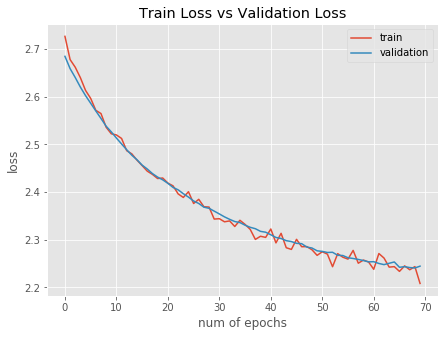

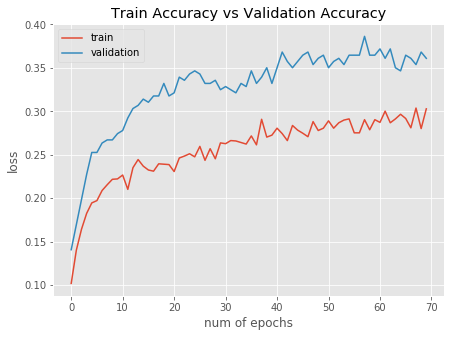

In [108]:
import matplotlib.pyplot as plt                        

train_loss = trainning_result.history['loss']
validation_loss = trainning_result.history['val_loss']
train_acc = trainning_result.history['acc']
validation_acc = trainning_result.history['val_acc']
xc = range(epochs)

visualize_loss(xc, train_loss, validation_loss)
visualize_acc(xc, train_acc, validation_acc)
